<a href="https://colab.research.google.com/github/jshinm/code_bucket/blob/main/NamedEntityRecognition_bioBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 9 - Name entity recognition to find adverse drug reaction entities with BioBERT


***Information Extraction*** (IE) on biomedical documents is gaining steam recently, thanks to wide availability of biomedical documents and pre-trained models such as transformers.
Transformers like BERT learn contextualized word embeddings.
When deploying such pre-trained models (like bioBERT) on a different domain, they usually need to be fine-tuned to overcome the shift in the word distribution.
One particular application, in the context of pharmacovigilance, is Named Entity Recognition (NER). We want to extract Adverse Drug Reaction (ADR) labels from the drug descriptions.

In this lab, we pursue NER on *drug label* documents on dataset called TAC 2017 (https://bionlp.nlm.nih.gov/tac2017adversereactions/).

***Named Entity Recognition*** (NER) labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names. We are essentially interested in finding the locations of words which describe an "adverse reaction" like allergy, ache, etc.

We will primarily follow this work [Transfer Learning for Biomedical Named Entity Recognition with BioBERT](http://ceur-ws.org/Vol-2451/paper-26.pdf) and make use of its associated open-source code [Code](https://github.com/AnthiS/MasterThesis_DS/blob/master/biobert_ner/README-Template.md) (only used to obtain pre-processed data). BioBERT details are in https://academic.oup.com/bioinformatics/article/36/4/1234/5566506.
It is highly recommended to go through above two papers since there are many details to *bioBERT* that are interesting.

Notes:
1. Do not forget to select GPU runtime.
2. If you see message like "restart runtime to use latest tensorflow", please follow the instruction and restart the runtime.
3. If you are more comfortable in putting results/log files in a separate doc file, please feel free to do so.

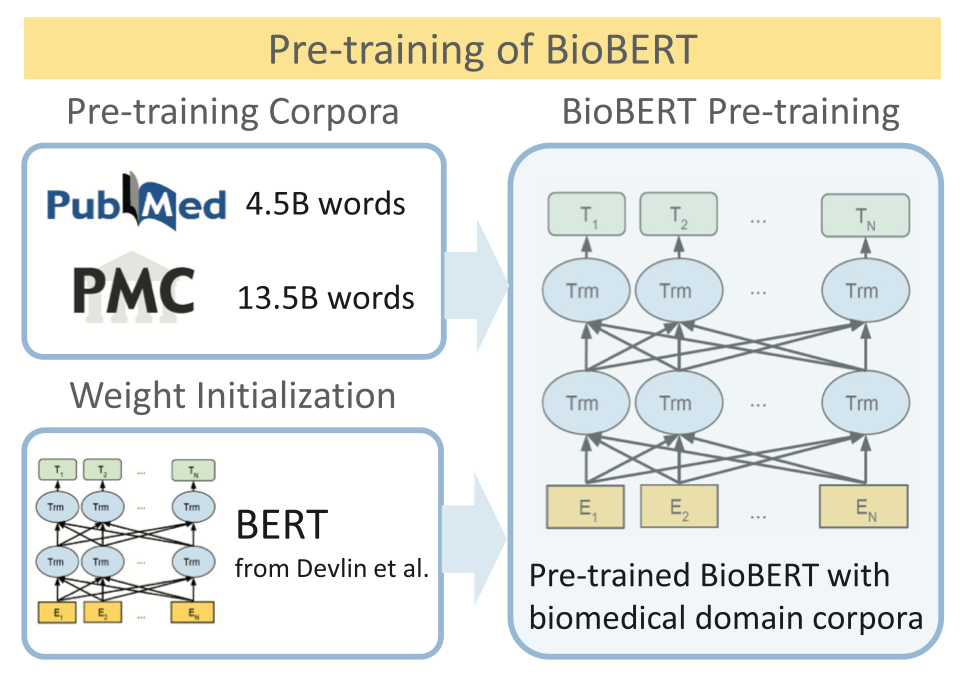

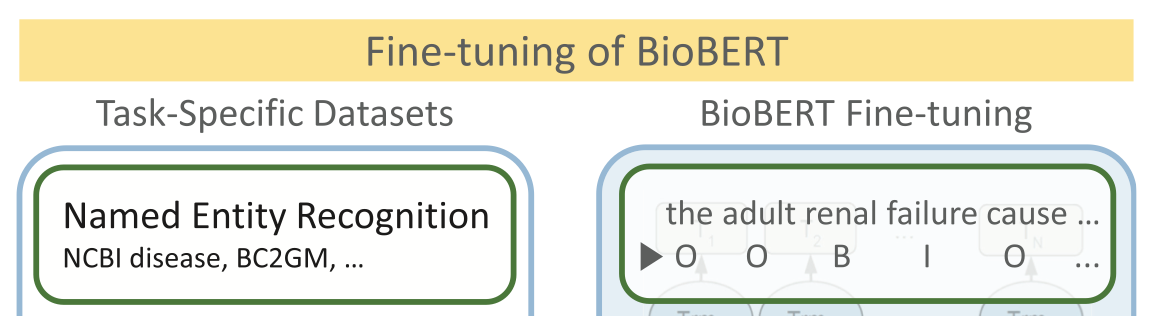

In [1]:
# get required libraries and repos (repositories)
import os
import math
from shutil import copyfile
from copy import copy
import tensorflow as tf
import numpy as np

!git clone https://github.com/dmis-lab/biobert.git
!git clone https://github.com/google-research/bert.git
!git clone https://github.com/AnthiS/MasterThesis_DS.git
!pip install tensorflow-gpu==1.15.2

Cloning into 'biobert'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 329 (delta 28), reused 7 (delta 3), pack-reused 278
Receiving objects: 100% (329/329), 507.77 KiB | 25.39 MiB/s, done.
Resolving deltas: 100% (190/190), done.
Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 328.28 KiB | 21.88 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Cloning into 'MasterThesis_DS'...
remote: Enumerating objects: 201, done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 201
Receiving objects: 100% (201/201), 2.68 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (50/50), done.
     |████████████████████████████████| 411.0MB 42kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 512kB 51.7MB/s 
     |█████████████████

## Task 0 (Data download and preparation)
Download and save to drive the following pre-trained biobert model: BioBERT-Base v1.1 (+ PubMed 1M) - based on BERT-base-Cased (same vocabulary).

https://drive.google.com/file/d/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD/view?usp=sharing

We will fine-tune this model later to accomplish transfer learning for our dataset.

Run the following two cells.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/MyDrive/biobert_v1.1_pubmed/ # the path for you might be different, depending on where you saved it in your drive

Mounted at /content/drive


In [2]:
# Download the TAC2017 dataset in original XML format
!wget https://bionlp.nlm.nih.gov/tac2017adversereactions/train_xml.tar.gz
!tar -xf train_xml.tar.gz
!cat train_xml/ADCETRIS.xml # printing the first XML file in training data

--2021-04-22 06:06:03--  https://bionlp.nlm.nih.gov/tac2017adversereactions/train_xml.tar.gz
Resolving bionlp.nlm.nih.gov (bionlp.nlm.nih.gov)... 130.14.65.21, 2607:f220:41e:7065::21
Connecting to bionlp.nlm.nih.gov (bionlp.nlm.nih.gov)|130.14.65.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898022 (877K) [application/x-gzip]
Saving to: ‘train_xml.tar.gz’

train_xml.tar.gz    100%[===================>] 876.97K  --.-KB/s    in 0.07s   

2021-04-22 06:06:03 (12.3 MB/s) - ‘train_xml.tar.gz’ saved [898022/898022]

<?xml version="1.0" encoding="UTF-8"?>
<Label drug="adcetris" track="TAC2017_ADR">
  <Text>
    <Section name="adverse reactions" id="S1">    6 ADVERSE REACTIONS

  The following serious adverse reactions are discussed in greater detail in other sections of the prescribing information:



 *  Peripheral Neuropathy [see  Warnings and Precautions (      5.1      )  ]  
 *  Anaphylaxis and Infusion Reactions [see  Warnings and Precautions (      5.2   

**The  TAC 2017 dataset**
According to the authors of the dataset, "the purpose of this TAC track is to test various natural language processing (NLP) approaches for their information extraction (IE) performance on adverse reactions found in structured product labels (SPLs, or simply "labels"). A large set of labels will be provided to participants, of which 101 will be annotated with adverse reactions. Additionally, the training labels will be accompanied by the MedDRA Preferred Terms (PT) and Lower Level Terms (LLT) of the ADRs in the drug labels. This corresponds to the primary goal of the task: to identify the known ADRs in a SPL in the form of MedDRA concepts. Participants will be evaluated by their performance on a held-out set of labeled SPLs."


We will work with only the *annotated training portion* of TAC 2017 since labels are not available for the larger unannotated portion: https://bionlp.nlm.nih.gov/tac2017adversereactions/unannotated_xml.tar.gz.

> Indented block



Instead of directly using `train_xml.tar.gz`, we will use a pre-processed version which is split into five equal portions in the open-source code we downloaded. It is *bio-tagged* i.e. the tokens of drug documents are labeled as "B", "I", or "O".
> "B" marks the *beginning* of adverse reaction <br>
> "I" denotes the *interior* of labeling (follows after the "B" tag) <br>
> "O" is the *default/non-available* tag <br>
Standard bio-tagging scheme is used for this.

Find the splits in: `MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_i` where $i \in [1,5]$. Each split consists of four `.tsv` files: 
- `train.tsv`, `train_dev.tsv` (training samples)
- `devel.tsv` (development samples)
- `test.tsv` (test samples)

 This type of organization is required by bioBERT code.

## TASK 1 (20 points): (Exploring & verifying data)
Print the top 40 and bottom 40 lines of training (`train_dev.tsv`) and testing files (`test.tsv`) in the first split of data ("TAC_1"). Now write code to verify that only the following three types of labels are present in all the five splits of data: "B", "I", and "O".

In [5]:
#CODE HERE
!tar -xf /content/drive/MyDrive/JHU_NDD/biobert_v1.1_pubmed.tar.gz

In [21]:
#USED PACKAGES
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import os

In [22]:
DIRPATH = '/content/drive/MyDrive/JHU_NDD/'
FILENAME = 'biobert_v1.1_pubmed.tar.gz'
TACPATH = 'MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_'
TRAINFILE = 'train_dev.tsv'
TESTFILE = 'test.tsv'
DIRPATH+FILENAME

'/content/drive/MyDrive/JHU_NDD/biobert_v1.1_pubmed.tar.gz'

In [23]:
TAC1_train = pd.read_csv(TACPATH + '1/' + TRAINFILE, sep='\t')
TAC1_test = pd.read_csv(TACPATH + '1/' + TESTFILE, sep='\t')

In [ ]:
TAC1_train.head(40)

Unnamed: 0 Unnamed: 1
0               The          O
1       psychiatric          B
2          symptoms          I
3                in          O
4               the          O
5              vast          O
6          majority          O
7                of          O
8          patients          O
9                in          O
10             both          O
11       controlled          O
12              and          O
13       open-label          O
14           trials          O
15         resolved          O
16           within          O
17                7          O
18             days          O
19               of          O
20  discontinuation          O
21               of          O
22           POTIGA          O
23                .          O
24              NaN        NaN
25       Chickenpox          B
26              and          O
27          measles          B
28                ,          O
29              for          O
30          example          O
31                ,          O
32              can          O
33             have          O
34                a          O
35             more          O
36          serious          O
37               or          O
38             even          O
39            fatal          B

In [ ]:
TAC1_train.tail(40)

Unnamed: 0 Unnamed: 1
171863           is          O
171864    discussed          O
171865    elsewhere          O
171866           in          O
171867          the          O
171868     labeling          O
171869            :          O
171870            *          O
171871  Hypotension          B
171872          and          O
171873       Reflex          B
171874  Tachycardia          I
171875            [          O
171876          see          O
171877     Warnings          O
171878          and          O
171879  Precautions          O
171880            (          O
171881          5.2          O
171882            )          O
171883            ]          O
171884      EXCERPT          O
171885            :          O
171886         Most          O
171887       common          O
171888      adverse          O
171889    reactions          O
171890            (          O
171891            >          O
171892            2          O
171893            %          O
171894            )          O
171895          are          O
171896     headache          B
171897            ,          O
171898       nausea          B
171899            ,          O
171900          and          O
171901     vomiting          B
171902            .          O

In [ ]:
TAC1_test.head(40)

Unnamed: 0 Unnamed: 1
0   Approximately          O
1              60          O
2               %          O
3              of          O
4             the          O
5         treated          O
6        patients          O
7            were          O
8            male          O
9               ,          O
10           with          O
11              a          O
12           mean          O
13            age          O
14             of          O
15           55.1          O
16          years          O
17              .          O
18            NaN        NaN
19            The          O
20          table          O
21          below          O
22          lists          O
23            the          O
24        adverse          O
25           drug          O
26      reactions          O
27           that          O
28       occurred          O
29             in          O
30             at          O
31          least          O
32              1          O
33              %          O
34             of          O
35       patients          O
36        treated          O
37           with          O
38      Ferriprox          O
39             in          O

In [ ]:
TAC1_test.tail(40)

Unnamed: 0 Unnamed: 1
42705                   and          O
42706             follow-up          O
42707               testing          O
42708                 every          O
42709                     6          O
42710                months          O
42711                     .          O
42712                   NaN        NaN
42713                    To          O
42714                report          O
42715             SUSPECTED          O
42716               ADVERSE          O
42717             REACTIONS          O
42718                     ,          O
42719        contactJanssen          O
42720               Biotech          O
42721                     ,          O
42722                  Inc.          O
42723                    at          O
42724         1-800-JANSSEN          O
42725                     (          O
42726        1-800-526-7736          O
42727                     )          O
42728                    or          O
42729                   FDA          O
42730                    at          O
42731        1-800-FDA-1088          O
42732                    or          O
42733  www.fda.gov/medwatch          O
42734                     .          O
42735                   NaN        NaN
42736               Monitor          O
42737                   for          O
42738             pulmonary          O
42739              symptoms          O
42740                   and          O
42741             bilateral          O
42742          interstitial          O
42743           infiltrates          O
42744                     .          O

In [ ]:
#loading train and test datasets
TACS_train = []
TACS_test  = []

for i in range(1,6):
    tempath = TACPATH + f'{i}/' + TRAINFILE
    TACS_train.append(pd.read_csv(tempath, '\t').dropna()) #dropping na only for demonstration purposes

    tempath = TACPATH + f'{i}/' + TESTFILE
    TACS_test.append(pd.read_csv(tempath, '\t').dropna()) #dropping na only for demonstration purposes

In [ ]:
for i in range(len(TACS_train)):
    print(f'For TAC_{i} training set:, {TACS_train[i].iloc[:,1].unique()}')
    print(f'For TAC_{i} test set:, {TACS_test[i].iloc[:,1].unique()}')
    print('-'*20)

For TAC_0 training set:, ['O' 'B' 'I']
For TAC_0 test set:, ['O' 'B' 'I']
--------------------
For TAC_1 training set:, ['O' 'B' 'I']
For TAC_1 test set:, ['O' 'B' 'I']
--------------------
For TAC_2 training set:, ['O' 'B' 'I']
For TAC_2 test set:, ['O' 'B' 'I']
--------------------
For TAC_3 training set:, ['O' 'B' 'I']
For TAC_3 test set:, ['O' 'B' 'I']
--------------------
For TAC_4 training set:, ['O' 'B' 'I']
For TAC_4 test set:, ['O' 'B' 'I']
--------------------


##  TASK 2 (30 points): (Fine-tune bioBERT and get f-score)


### TASK 2.1
On the first split of data (TAC_1), fine-tune the pre-trained bioBERT you downloaded. <br>

Training instructions for Named Entity Recognition are detailed in bioBERT software (https://github.com/dmis-lab/biobert). <br>

You need to simply run <br>
 `run_ner.py --do_train=true --do_eval=true ...`  <br>
 followed by  <br>
 `run_ner.py --do_train=false --do_predict=true ...`  <br>
 where `...` means some additional arguments. Results will be printed in the training log automatically. <br>

In comments, report the obtained f1-scores (F), precision (P), and recall (R). Note that these are token-level scores (in contrast to entity level) and we report **only** token-level scores in this lab. Find them below text which looks like this:  <br>
`# I0414 21:48:07.564054 140447680956288 run_ner.py:624] \*\*\*\*\* token-level evaluation results *****`




In [ ]:
OUTPUT_DIR = 'output'
BIOBERT_DIR = 'biobert_v1.1_pubmed'
NER_DIR='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1/'

In [ ]:
%run biobert/run_ner.py --do_train=true --do_eval=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0421 21:48:17.116453 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0421 21:48:17.124137 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0421 21:48:17.127166 139917308094336 module_wrapper.py:139] From /content/biobert/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0421 21:48:17.132360 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:481: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0421 21:48:17.284365 139917308094336 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0421 21:48:17.905244 139917308094336 utils.py:157] NumExpr defaulting to 2 threads.


Two continual empty lines detected!


W0421 21:48:18.480350 139917308094336 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f408524d7a0>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40850d1a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per_host_

I0421 21:48:18.485789 139917308094336 estimator.py:212] Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40850d1a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0421 21:48:18.493486 139917308094336 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0421 21:48:18.497406 139917308094336 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


W0421 21:48:18.500743 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0421 21:48:18.504747 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:296: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Writing example 0 of 5926


I0421 21:48:18.507718 139917308094336 run_ner.py:296] Writing example 0 of 5926


INFO:tensorflow:*** Example ***


I0421 21:48:18.517501 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0421 21:48:18.519944 139917308094336 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0421 21:48:18.522655 139917308094336 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.525213 139917308094336 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.528074 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.531141 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.534053 139917308094336 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:48:18.538406 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0421 21:48:18.541374 139917308094336 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0421 21:48:18.544378 139917308094336 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.547364 139917308094336 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.550643 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.554062 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.556958 139917308094336 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:48:18.561244 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0421 21:48:18.564158 139917308094336 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0421 21:48:18.566638 139917308094336 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.569642 139917308094336 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.572375 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.575472 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.577995 139917308094336 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:48:18.582775 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0421 21:48:18.585237 139917308094336 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0421 21:48:18.588310 139917308094336 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.590735 139917308094336 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.593781 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.596792 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:48:18.599796 139917308094336 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5926


I0421 21:48:24.589026 139917308094336 run_ner.py:296] Writing example 5000 of 5926


INFO:tensorflow:***** Running training *****


I0421 21:48:25.692221 139917308094336 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 5926


I0421 21:48:25.700787 139917308094336 run_ner.py:542]   Num examples = 5926


INFO:tensorflow:  Batch size = 32


I0421 21:48:25.709230 139917308094336 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 185


I0421 21:48:25.717428 139917308094336 run_ner.py:544]   Num steps = 185


W0421 21:48:25.725120 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0421 21:48:25.754325 139917308094336 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0421 21:48:25.757896 139917308094336 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0421 21:48:25.813835 139917308094336 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0421 21:48:25.822100 139917308094336 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0421 21:48:25.904615 139917308094336 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0421 21:48:26.039566 139917308094336 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0421 21:48:26.067898 139917308094336 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0421 21:48:26.071659 139917308094336 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0421 21:48:26.079794 139917308094336 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0421 21:48:26.084396 139917308094336 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0421 21:48:26.087448 139917308094336 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0421 21:48:26.091456 139917308094336 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0421 21:48:26.094880 139917308094336 run_ner.py:394]   name = segment_ids, shape = (32, 128)


W0421 21:48:26.097956 139917308094336 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0421 21:48:26.104092 139917308094336 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0421 21:48:26.179166 139917308094336 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0421 21:48:26.235718 139917308094336 deprecation.py:506] From /content/biobert/modeling.py:359: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use keras.layers.Dense instead.


W0421 21:48:26.264554 139917308094336 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0421 21:48:26.274998 139917308094336 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0421 21:48:26.430630 139917308094336 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0421 21:48:28.742705 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0421 21:48:28.752866 139917308094336 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0421 21:48:30.196619 139917308094336 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 21:48:30.199090 139917308094336 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 21:48:30.217810 139917308094336 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 21:48:30.232658 139917308094336 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.237730 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.242948 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.251618 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.264864 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.267573 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.270894 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.273482 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.276948 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.279550 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.282826 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.285335 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.287913 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.291260 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.294056 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.296437 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.299316 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.302293 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.304655 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.307639 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.310650 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.313382 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.316560 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.319127 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.322198 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.325260 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.327785 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.330121 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.333014 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.336404 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.340904 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.343563 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.347043 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.350060 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.353996 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.362768 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.370254 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.376783 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.379933 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.386648 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.393376 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.398501 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.409466 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.416442 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.422510 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.432142 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.442533 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.448653 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.461650 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.467052 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.471452 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.494506 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.502651 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.513279 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.522036 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.532146 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.538219 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.545121 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.556092 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.566215 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.573077 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.587164 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.595566 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.607628 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.620289 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.624605 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.639458 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.646819 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.657198 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.662809 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.669048 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.676049 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.682271 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.688968 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.695528 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.701934 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.710098 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.715796 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.721955 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.728828 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.734155 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.739721 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.746802 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.753918 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.759241 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.763945 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.779958 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.788663 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.798689 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.803438 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.806426 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.809645 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.812859 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.815725 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.818509 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.821290 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.824022 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.828277 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.832153 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.835666 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.839146 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.842751 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.847121 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.850846 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.854300 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.858187 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.861338 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.864768 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.868426 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.871902 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.875219 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.878442 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.881670 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.885240 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.894827 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.902039 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.905600 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.909163 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.912365 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.916209 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.920420 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.923774 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.927059 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.930038 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.933822 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:30.937872 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:30.943219 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:30.946868 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.950491 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.955766 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.962097 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.968261 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.973483 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.983471 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.986481 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:30.991495 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:30.998554 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.004816 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.011126 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.021717 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.030466 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:31.043557 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:31.060419 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:31.087657 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.095908 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.101944 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.119945 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.137734 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.144103 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.147337 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.153940 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.159493 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.166135 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.173246 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.183995 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.189231 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.196053 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:31.204106 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:31.224353 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:31.231973 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.264608 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.297750 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.353982 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.386800 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.393932 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.401647 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.406020 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.411118 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.419677 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.423175 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.429860 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.434673 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.440404 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:31.446838 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:31.451052 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:31.458842 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.464872 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.468147 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.470795 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.474296 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.476990 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.479583 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.482110 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.485546 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.488642 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.491064 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.493774 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.496803 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.500016 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:48:31.502822 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:48:31.505917 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:48:31.508877 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.512032 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.514649 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.517204 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:48:31.521588 139917308094336 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:48:31.524667 139917308094336 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 21:48:31.527218 139917308094336 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 21:48:31.531239 139917308094336 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0421 21:48:31.534020 139917308094336 module_wrapper.py:139] From /content/biobert/optimization.py:27: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.



W0421 21:48:31.539175 139917308094336 module_wrapper.py:139] From /content/biobert/optimization.py:32: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0421 21:48:34.915597 139917308094336 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/clip_ops.py:301: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0421 21:48:39.984930 139917308094336 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0421 21:48:39.990054 139917308094336 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0421 21:48:43.188739 139917308094336 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-0


I0421 21:48:43.323282 139917308094336 saver.py:1284] Restoring parameters from output/model.ckpt-0


Instructions for updating:
Use standard file utilities to get mtimes.


W0421 21:48:46.369534 139917308094336 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/training/saver.py:1069: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


I0421 21:48:47.102603 139917308094336 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 21:48:47.313276 139917308094336 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output/model.ckpt.


I0421 21:48:54.318587 139917308094336 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output/model.ckpt.


INFO:tensorflow:global_step/sec: 0.169866


I0421 21:49:10.797894 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.169866


INFO:tensorflow:examples/sec: 5.4357


I0421 21:49:10.802757 139917308094336 tpu_estimator.py:2308] examples/sec: 5.4357


INFO:tensorflow:global_step/sec: 0.616239


I0421 21:49:12.420644 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616239


INFO:tensorflow:examples/sec: 19.7196


I0421 21:49:12.429086 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7196


INFO:tensorflow:global_step/sec: 0.610442


I0421 21:49:14.058868 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610442


INFO:tensorflow:examples/sec: 19.5341


I0421 21:49:14.077095 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5341


INFO:tensorflow:global_step/sec: 0.608675


I0421 21:49:15.701744 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608675


INFO:tensorflow:examples/sec: 19.4776


I0421 21:49:15.714257 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4776


INFO:tensorflow:global_step/sec: 0.608435


I0421 21:49:17.345237 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608435


INFO:tensorflow:examples/sec: 19.4699


I0421 21:49:17.358302 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4699


INFO:tensorflow:global_step/sec: 0.611589


I0421 21:49:18.980312 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611589


INFO:tensorflow:examples/sec: 19.5709


I0421 21:49:18.990779 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5709


INFO:tensorflow:global_step/sec: 0.611657


I0421 21:49:20.615214 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611657


INFO:tensorflow:examples/sec: 19.573


I0421 21:49:20.626813 139917308094336 tpu_estimator.py:2308] examples/sec: 19.573


INFO:tensorflow:global_step/sec: 0.61192


I0421 21:49:22.249466 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61192


INFO:tensorflow:examples/sec: 19.5814


I0421 21:49:22.258511 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5814


INFO:tensorflow:global_step/sec: 0.611224


I0421 21:49:23.885529 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611224


INFO:tensorflow:examples/sec: 19.5592


I0421 21:49:23.898053 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5592


INFO:tensorflow:global_step/sec: 0.613693


I0421 21:49:25.515006 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613693


INFO:tensorflow:examples/sec: 19.6382


I0421 21:49:25.528420 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6382


INFO:tensorflow:global_step/sec: 0.608968


I0421 21:49:27.157086 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608968


INFO:tensorflow:examples/sec: 19.487


I0421 21:49:27.160017 139917308094336 tpu_estimator.py:2308] examples/sec: 19.487


INFO:tensorflow:global_step/sec: 0.60917


I0421 21:49:28.798675 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.60917


INFO:tensorflow:examples/sec: 19.4934


I0421 21:49:28.809552 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4934


INFO:tensorflow:global_step/sec: 0.61089


I0421 21:49:30.435710 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61089


INFO:tensorflow:examples/sec: 19.5485


I0421 21:49:30.450727 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5485


INFO:tensorflow:global_step/sec: 0.609381


I0421 21:49:32.076602 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609381


INFO:tensorflow:examples/sec: 19.5002


I0421 21:49:32.081999 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5002


INFO:tensorflow:global_step/sec: 0.615523


I0421 21:49:33.701271 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615523


INFO:tensorflow:examples/sec: 19.6967


I0421 21:49:33.704778 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6967


INFO:tensorflow:global_step/sec: 0.606712


I0421 21:49:35.349482 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.606712


INFO:tensorflow:examples/sec: 19.4148


I0421 21:49:35.357922 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4148


INFO:tensorflow:global_step/sec: 0.615003


I0421 21:49:36.975512 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615003


INFO:tensorflow:examples/sec: 19.6801


I0421 21:49:36.986265 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6801


INFO:tensorflow:global_step/sec: 0.608663


I0421 21:49:38.618445 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608663


INFO:tensorflow:examples/sec: 19.4772


I0421 21:49:38.628397 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4772


INFO:tensorflow:global_step/sec: 0.609161


I0421 21:49:40.260089 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609161


INFO:tensorflow:examples/sec: 19.4931


I0421 21:49:40.279816 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4931


INFO:tensorflow:global_step/sec: 0.607191


I0421 21:49:41.907086 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607191


INFO:tensorflow:examples/sec: 19.4301


I0421 21:49:41.910458 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4301


INFO:tensorflow:global_step/sec: 0.61123


I0421 21:49:43.543068 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61123


INFO:tensorflow:examples/sec: 19.5594


I0421 21:49:43.548424 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5594


INFO:tensorflow:global_step/sec: 0.614904


I0421 21:49:45.169298 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614904


INFO:tensorflow:examples/sec: 19.6769


I0421 21:49:45.182173 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6769


INFO:tensorflow:global_step/sec: 0.610138


I0421 21:49:46.808276 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610138


INFO:tensorflow:examples/sec: 19.5244


I0421 21:49:46.817003 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5244


INFO:tensorflow:global_step/sec: 0.612567


I0421 21:49:48.440768 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612567


INFO:tensorflow:examples/sec: 19.6021


I0421 21:49:48.443770 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6021


INFO:tensorflow:global_step/sec: 0.612312


I0421 21:49:50.073966 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612312


INFO:tensorflow:examples/sec: 19.594


I0421 21:49:50.087115 139917308094336 tpu_estimator.py:2308] examples/sec: 19.594


INFO:tensorflow:global_step/sec: 0.613032


I0421 21:49:51.705126 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613032


INFO:tensorflow:examples/sec: 19.617


I0421 21:49:51.718391 139917308094336 tpu_estimator.py:2308] examples/sec: 19.617


INFO:tensorflow:global_step/sec: 0.607059


I0421 21:49:53.352413 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607059


INFO:tensorflow:examples/sec: 19.4259


I0421 21:49:53.355495 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4259


INFO:tensorflow:global_step/sec: 0.610829


I0421 21:49:54.989544 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610829


INFO:tensorflow:examples/sec: 19.5465


I0421 21:49:55.001196 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5465


INFO:tensorflow:global_step/sec: 0.614412


I0421 21:49:56.617129 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614412


INFO:tensorflow:examples/sec: 19.6612


I0421 21:49:56.620680 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6612


INFO:tensorflow:global_step/sec: 0.614106


I0421 21:49:58.245484 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614106


INFO:tensorflow:examples/sec: 19.6514


I0421 21:49:58.250419 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6514


INFO:tensorflow:global_step/sec: 0.611802


I0421 21:49:59.880049 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611802


INFO:tensorflow:examples/sec: 19.5777


I0421 21:49:59.891754 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5777


INFO:tensorflow:global_step/sec: 0.61007


I0421 21:50:01.519172 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61007


INFO:tensorflow:examples/sec: 19.5223


I0421 21:50:01.529217 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5223


INFO:tensorflow:global_step/sec: 0.611338


I0421 21:50:03.154979 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611338


INFO:tensorflow:examples/sec: 19.5628


I0421 21:50:03.167510 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5628


INFO:tensorflow:global_step/sec: 0.611456


I0421 21:50:04.790351 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611456


INFO:tensorflow:examples/sec: 19.5666


I0421 21:50:04.798962 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5666


INFO:tensorflow:global_step/sec: 0.610533


I0421 21:50:06.428250 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610533


INFO:tensorflow:examples/sec: 19.5371


I0421 21:50:06.439837 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5371


INFO:tensorflow:global_step/sec: 0.61088


I0421 21:50:08.065241 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61088


INFO:tensorflow:examples/sec: 19.5482


I0421 21:50:08.073054 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5482


INFO:tensorflow:global_step/sec: 0.611145


I0421 21:50:09.701497 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611145


INFO:tensorflow:examples/sec: 19.5567


I0421 21:50:09.715081 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5567


INFO:tensorflow:global_step/sec: 0.611065


I0421 21:50:11.338054 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611065


INFO:tensorflow:examples/sec: 19.5541


I0421 21:50:11.342431 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5541


INFO:tensorflow:global_step/sec: 0.614287


I0421 21:50:12.965938 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614287


INFO:tensorflow:examples/sec: 19.6572


I0421 21:50:12.974958 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6572


INFO:tensorflow:global_step/sec: 0.611064


I0421 21:50:14.602432 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611064


INFO:tensorflow:examples/sec: 19.554


I0421 21:50:14.610927 139917308094336 tpu_estimator.py:2308] examples/sec: 19.554


INFO:tensorflow:global_step/sec: 0.612227


I0421 21:50:16.235805 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612227


INFO:tensorflow:examples/sec: 19.5913


I0421 21:50:16.244378 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5913


INFO:tensorflow:global_step/sec: 0.612335


I0421 21:50:17.868921 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612335


INFO:tensorflow:examples/sec: 19.5947


I0421 21:50:17.873884 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5947


INFO:tensorflow:global_step/sec: 0.616772


I0421 21:50:19.490217 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616772


INFO:tensorflow:examples/sec: 19.7367


I0421 21:50:19.499218 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7367


INFO:tensorflow:global_step/sec: 0.610657


I0421 21:50:21.127900 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610657


INFO:tensorflow:examples/sec: 19.541


I0421 21:50:21.136319 139917308094336 tpu_estimator.py:2308] examples/sec: 19.541


INFO:tensorflow:global_step/sec: 0.613967


I0421 21:50:22.756542 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613967


INFO:tensorflow:examples/sec: 19.6469


I0421 21:50:22.770542 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6469


INFO:tensorflow:global_step/sec: 0.615318


I0421 21:50:24.381748 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615318


INFO:tensorflow:examples/sec: 19.6902


I0421 21:50:24.394360 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6902


INFO:tensorflow:global_step/sec: 0.60866


I0421 21:50:26.024703 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.60866


INFO:tensorflow:examples/sec: 19.4771


I0421 21:50:26.030015 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4771


INFO:tensorflow:global_step/sec: 0.614821


I0421 21:50:27.651300 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614821


INFO:tensorflow:examples/sec: 19.6743


I0421 21:50:27.656180 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6743


INFO:tensorflow:global_step/sec: 0.616778


I0421 21:50:29.272548 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616778


INFO:tensorflow:examples/sec: 19.7369


I0421 21:50:29.275466 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7369


INFO:tensorflow:global_step/sec: 0.614226


I0421 21:50:30.900554 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614226


INFO:tensorflow:examples/sec: 19.6552


I0421 21:50:30.909760 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6552


INFO:tensorflow:global_step/sec: 0.607912


I0421 21:50:32.545561 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607912


INFO:tensorflow:examples/sec: 19.4532


I0421 21:50:32.550002 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4532


INFO:tensorflow:global_step/sec: 0.618248


I0421 21:50:34.163048 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.618248


INFO:tensorflow:examples/sec: 19.7839


I0421 21:50:34.167455 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7839


INFO:tensorflow:global_step/sec: 0.61556


I0421 21:50:35.787604 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61556


INFO:tensorflow:examples/sec: 19.6979


I0421 21:50:35.798281 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6979


INFO:tensorflow:global_step/sec: 0.611735


I0421 21:50:37.422275 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611735


INFO:tensorflow:examples/sec: 19.5755


I0421 21:50:37.425420 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5755


INFO:tensorflow:global_step/sec: 0.612421


I0421 21:50:39.055155 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612421


INFO:tensorflow:examples/sec: 19.5975


I0421 21:50:39.064572 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5975


INFO:tensorflow:global_step/sec: 0.609219


I0421 21:50:40.696598 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609219


INFO:tensorflow:examples/sec: 19.495


I0421 21:50:40.704608 139917308094336 tpu_estimator.py:2308] examples/sec: 19.495


INFO:tensorflow:global_step/sec: 0.61284


I0421 21:50:42.328362 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61284


INFO:tensorflow:examples/sec: 19.6109


I0421 21:50:42.339861 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6109


INFO:tensorflow:global_step/sec: 0.610162


I0421 21:50:43.967206 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610162


INFO:tensorflow:examples/sec: 19.5252


I0421 21:50:43.981917 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5252


INFO:tensorflow:global_step/sec: 0.611172


I0421 21:50:45.603410 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611172


INFO:tensorflow:examples/sec: 19.5575


I0421 21:50:45.606702 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5575


INFO:tensorflow:global_step/sec: 0.611899


I0421 21:50:47.237719 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611899


INFO:tensorflow:examples/sec: 19.5808


I0421 21:50:47.240654 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5808


INFO:tensorflow:global_step/sec: 0.612376


I0421 21:50:48.870685 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612376


INFO:tensorflow:examples/sec: 19.596


I0421 21:50:48.880887 139917308094336 tpu_estimator.py:2308] examples/sec: 19.596


INFO:tensorflow:global_step/sec: 0.612196


I0421 21:50:50.504137 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612196


INFO:tensorflow:examples/sec: 19.5903


I0421 21:50:50.519498 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5903


INFO:tensorflow:global_step/sec: 0.611044


I0421 21:50:52.140716 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611044


INFO:tensorflow:examples/sec: 19.5534


I0421 21:50:52.156093 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5534


INFO:tensorflow:global_step/sec: 0.610815


I0421 21:50:53.777830 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610815


INFO:tensorflow:examples/sec: 19.5461


I0421 21:50:53.784530 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5461


INFO:tensorflow:global_step/sec: 0.613984


I0421 21:50:55.406550 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613984


INFO:tensorflow:examples/sec: 19.6475


I0421 21:50:55.420002 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6475


INFO:tensorflow:global_step/sec: 0.610619


I0421 21:50:57.044203 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610619


INFO:tensorflow:examples/sec: 19.5398


I0421 21:50:57.060699 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5398


INFO:tensorflow:global_step/sec: 0.606819


I0421 21:50:58.692164 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.606819


INFO:tensorflow:examples/sec: 19.4182


I0421 21:50:58.703828 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4182


INFO:tensorflow:global_step/sec: 0.613648


I0421 21:51:00.321783 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613648


INFO:tensorflow:examples/sec: 19.6367


I0421 21:51:00.330237 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6367


INFO:tensorflow:global_step/sec: 0.608791


I0421 21:51:01.964374 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608791


INFO:tensorflow:examples/sec: 19.4813


I0421 21:51:01.972528 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4813


INFO:tensorflow:global_step/sec: 0.60885


I0421 21:51:03.606779 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.60885


INFO:tensorflow:examples/sec: 19.4832


I0421 21:51:03.621099 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4832


INFO:tensorflow:global_step/sec: 0.609295


I0421 21:51:05.248094 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609295


INFO:tensorflow:examples/sec: 19.4975


I0421 21:51:05.259119 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4975


INFO:tensorflow:global_step/sec: 0.614036


I0421 21:51:06.876742 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614036


INFO:tensorflow:examples/sec: 19.6492


I0421 21:51:06.879929 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6492


INFO:tensorflow:global_step/sec: 0.606047


I0421 21:51:08.526632 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.606047


INFO:tensorflow:examples/sec: 19.3935


I0421 21:51:08.536969 139917308094336 tpu_estimator.py:2308] examples/sec: 19.3935


INFO:tensorflow:global_step/sec: 0.611514


I0421 21:51:10.161953 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611514


INFO:tensorflow:examples/sec: 19.5685


I0421 21:51:10.169548 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5685


INFO:tensorflow:global_step/sec: 0.608296


I0421 21:51:11.805911 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608296


INFO:tensorflow:examples/sec: 19.4655


I0421 21:51:11.820979 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4655


INFO:tensorflow:global_step/sec: 0.611482


I0421 21:51:13.441223 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611482


INFO:tensorflow:examples/sec: 19.5674


I0421 21:51:13.453777 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5674


INFO:tensorflow:global_step/sec: 0.614122


I0421 21:51:15.069556 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614122


INFO:tensorflow:examples/sec: 19.6519


I0421 21:51:15.073109 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6519


INFO:tensorflow:global_step/sec: 0.61565


I0421 21:51:16.693904 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61565


INFO:tensorflow:examples/sec: 19.7008


I0421 21:51:16.702728 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7008


INFO:tensorflow:global_step/sec: 0.615393


I0421 21:51:18.318908 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615393


INFO:tensorflow:examples/sec: 19.6926


I0421 21:51:18.332157 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6926


INFO:tensorflow:global_step/sec: 0.61273


I0421 21:51:19.950947 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61273


INFO:tensorflow:examples/sec: 19.6074


I0421 21:51:19.969148 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6074


INFO:tensorflow:global_step/sec: 0.609913


I0421 21:51:21.590488 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609913


INFO:tensorflow:examples/sec: 19.5172


I0421 21:51:21.593523 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5172


INFO:tensorflow:global_step/sec: 0.614158


I0421 21:51:23.218756 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614158


INFO:tensorflow:examples/sec: 19.653


I0421 21:51:23.222128 139917308094336 tpu_estimator.py:2308] examples/sec: 19.653


INFO:tensorflow:global_step/sec: 0.612328


I0421 21:51:24.851873 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612328


INFO:tensorflow:examples/sec: 19.5945


I0421 21:51:24.860180 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5945


INFO:tensorflow:global_step/sec: 0.609916


I0421 21:51:26.491400 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609916


INFO:tensorflow:examples/sec: 19.5173


I0421 21:51:26.503266 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5173


INFO:tensorflow:global_step/sec: 0.609809


I0421 21:51:28.131257 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609809


INFO:tensorflow:examples/sec: 19.5139


I0421 21:51:28.147382 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5139


INFO:tensorflow:global_step/sec: 0.615106


I0421 21:51:29.757035 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615106


INFO:tensorflow:examples/sec: 19.6834


I0421 21:51:29.766106 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6834


INFO:tensorflow:global_step/sec: 0.616163


I0421 21:51:31.379949 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616163


INFO:tensorflow:examples/sec: 19.7172


I0421 21:51:31.383462 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7172


INFO:tensorflow:global_step/sec: 0.610836


I0421 21:51:33.017023 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610836


INFO:tensorflow:examples/sec: 19.5468


I0421 21:51:33.019952 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5468


INFO:tensorflow:global_step/sec: 0.616036


I0421 21:51:34.640373 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616036


INFO:tensorflow:examples/sec: 19.7131


I0421 21:51:34.643770 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7131


INFO:tensorflow:global_step/sec: 0.609796


I0421 21:51:36.280213 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609796


INFO:tensorflow:examples/sec: 19.5135


I0421 21:51:36.293472 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5135


INFO:tensorflow:global_step/sec: 0.609978


I0421 21:51:37.919599 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609978


INFO:tensorflow:examples/sec: 19.5193


I0421 21:51:37.923036 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5193


INFO:tensorflow:global_step/sec: 0.615185


I0421 21:51:39.545178 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615185


INFO:tensorflow:examples/sec: 19.6859


I0421 21:51:39.554780 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6859


INFO:tensorflow:global_step/sec: 0.612972


I0421 21:51:41.176528 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612972


INFO:tensorflow:examples/sec: 19.6151


I0421 21:51:41.183672 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6151


INFO:tensorflow:global_step/sec: 0.611953


I0421 21:51:42.810657 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611953


INFO:tensorflow:examples/sec: 19.5825


I0421 21:51:42.814879 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5825


INFO:tensorflow:global_step/sec: 0.610039


I0421 21:51:44.449903 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610039


INFO:tensorflow:examples/sec: 19.5212


I0421 21:51:44.455987 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5212


INFO:tensorflow:global_step/sec: 0.616111


I0421 21:51:46.072933 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616111


INFO:tensorflow:examples/sec: 19.7156


I0421 21:51:46.083897 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7156


INFO:tensorflow:global_step/sec: 0.610264


I0421 21:51:47.711589 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610264


INFO:tensorflow:examples/sec: 19.5285


I0421 21:51:47.715273 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5285


INFO:tensorflow:global_step/sec: 0.613271


I0421 21:51:49.342245 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613271


INFO:tensorflow:examples/sec: 19.6247


I0421 21:51:49.349096 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6247


INFO:tensorflow:global_step/sec: 0.614437


I0421 21:51:50.969635 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614437


INFO:tensorflow:examples/sec: 19.662


I0421 21:51:50.982839 139917308094336 tpu_estimator.py:2308] examples/sec: 19.662


INFO:tensorflow:global_step/sec: 0.611513


I0421 21:51:52.604998 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611513


INFO:tensorflow:examples/sec: 19.5684


I0421 21:51:52.613497 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5684


INFO:tensorflow:global_step/sec: 0.609473


I0421 21:51:54.245793 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609473


INFO:tensorflow:examples/sec: 19.5031


I0421 21:51:54.250814 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5031


INFO:tensorflow:global_step/sec: 0.614856


I0421 21:51:55.872176 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614856


INFO:tensorflow:examples/sec: 19.6754


I0421 21:51:55.883828 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6754


INFO:tensorflow:global_step/sec: 0.614051


I0421 21:51:57.500733 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614051


INFO:tensorflow:examples/sec: 19.6496


I0421 21:51:57.509890 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6496


INFO:tensorflow:global_step/sec: 0.614577


I0421 21:51:59.127938 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614577


INFO:tensorflow:examples/sec: 19.6665


I0421 21:51:59.152024 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6665


INFO:tensorflow:global_step/sec: 0.601765


I0421 21:52:00.789583 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.601765


INFO:tensorflow:examples/sec: 19.2565


I0421 21:52:00.801954 139917308094336 tpu_estimator.py:2308] examples/sec: 19.2565


INFO:tensorflow:global_step/sec: 0.613252


I0421 21:52:02.420312 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613252


INFO:tensorflow:examples/sec: 19.6241


I0421 21:52:02.426826 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6241


INFO:tensorflow:global_step/sec: 0.612928


I0421 21:52:04.051783 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612928


INFO:tensorflow:examples/sec: 19.6137


I0421 21:52:04.059251 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6137


INFO:tensorflow:global_step/sec: 0.610711


I0421 21:52:05.689168 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610711


INFO:tensorflow:examples/sec: 19.5428


I0421 21:52:05.698518 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5428


INFO:tensorflow:global_step/sec: 0.609777


I0421 21:52:07.329147 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609777


INFO:tensorflow:examples/sec: 19.5129


I0421 21:52:07.332716 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5129


INFO:tensorflow:global_step/sec: 0.612544


I0421 21:52:08.961714 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612544


INFO:tensorflow:examples/sec: 19.6014


I0421 21:52:08.974646 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6014


INFO:tensorflow:global_step/sec: 0.611616


I0421 21:52:10.596748 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611616


INFO:tensorflow:examples/sec: 19.5717


I0421 21:52:10.603642 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5717


INFO:tensorflow:global_step/sec: 0.610543


I0421 21:52:12.234616 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610543


INFO:tensorflow:examples/sec: 19.5374


I0421 21:52:12.242649 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5374


INFO:tensorflow:global_step/sec: 0.613008


I0421 21:52:13.865894 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613008


INFO:tensorflow:examples/sec: 19.6163


I0421 21:52:13.877778 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6163


INFO:tensorflow:global_step/sec: 0.611857


I0421 21:52:15.500252 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611857


INFO:tensorflow:examples/sec: 19.5794


I0421 21:52:15.507746 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5794


INFO:tensorflow:global_step/sec: 0.617648


I0421 21:52:17.119287 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.617648


INFO:tensorflow:examples/sec: 19.7647


I0421 21:52:17.134277 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7647


INFO:tensorflow:global_step/sec: 0.607514


I0421 21:52:18.765395 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607514


INFO:tensorflow:examples/sec: 19.4404


I0421 21:52:18.775778 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4404


INFO:tensorflow:global_step/sec: 0.612764


I0421 21:52:20.397304 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612764


INFO:tensorflow:examples/sec: 19.6084


I0421 21:52:20.400779 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6084


INFO:tensorflow:global_step/sec: 0.613126


I0421 21:52:22.028296 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613126


INFO:tensorflow:examples/sec: 19.62


I0421 21:52:22.043373 139917308094336 tpu_estimator.py:2308] examples/sec: 19.62


INFO:tensorflow:global_step/sec: 0.605111


I0421 21:52:23.680954 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.605111


INFO:tensorflow:examples/sec: 19.3636


I0421 21:52:23.688726 139917308094336 tpu_estimator.py:2308] examples/sec: 19.3636


INFO:tensorflow:global_step/sec: 0.609171


I0421 21:52:25.322527 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609171


INFO:tensorflow:examples/sec: 19.4935


I0421 21:52:25.329302 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4935


INFO:tensorflow:global_step/sec: 0.613672


I0421 21:52:26.951993 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613672


INFO:tensorflow:examples/sec: 19.6375


I0421 21:52:26.961527 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6375


INFO:tensorflow:global_step/sec: 0.614289


I0421 21:52:28.579988 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614289


INFO:tensorflow:examples/sec: 19.6572


I0421 21:52:28.595005 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6572


INFO:tensorflow:global_step/sec: 0.610649


I0421 21:52:30.217483 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610649


INFO:tensorflow:examples/sec: 19.5408


I0421 21:52:30.228142 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5408


INFO:tensorflow:global_step/sec: 0.613921


I0421 21:52:31.846349 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613921


INFO:tensorflow:examples/sec: 19.6455


I0421 21:52:31.854603 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6455


INFO:tensorflow:global_step/sec: 0.609987


I0421 21:52:33.485797 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609987


INFO:tensorflow:examples/sec: 19.5196


I0421 21:52:33.493220 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5196


INFO:tensorflow:global_step/sec: 0.611122


I0421 21:52:35.122123 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611122


INFO:tensorflow:examples/sec: 19.5559


I0421 21:52:35.130749 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5559


INFO:tensorflow:global_step/sec: 0.609774


I0421 21:52:36.762023 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609774


INFO:tensorflow:examples/sec: 19.5128


I0421 21:52:36.770349 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5128


INFO:tensorflow:global_step/sec: 0.612284


I0421 21:52:38.395268 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612284


INFO:tensorflow:examples/sec: 19.5931


I0421 21:52:38.404411 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5931


INFO:tensorflow:global_step/sec: 0.611341


I0421 21:52:40.031022 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611341


INFO:tensorflow:examples/sec: 19.5629


I0421 21:52:40.038618 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5629


INFO:tensorflow:global_step/sec: 0.60998


I0421 21:52:41.670382 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.60998


INFO:tensorflow:examples/sec: 19.5194


I0421 21:52:41.686102 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5194


INFO:tensorflow:global_step/sec: 0.615063


I0421 21:52:43.296230 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.615063


INFO:tensorflow:examples/sec: 19.682


I0421 21:52:43.299840 139917308094336 tpu_estimator.py:2308] examples/sec: 19.682


INFO:tensorflow:global_step/sec: 0.610988


I0421 21:52:44.932965 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610988


INFO:tensorflow:examples/sec: 19.5516


I0421 21:52:44.938408 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5516


INFO:tensorflow:global_step/sec: 0.616215


I0421 21:52:46.555743 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616215


INFO:tensorflow:examples/sec: 19.7189


I0421 21:52:46.574568 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7189


INFO:tensorflow:global_step/sec: 0.611003


I0421 21:52:48.192409 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611003


INFO:tensorflow:examples/sec: 19.5521


I0421 21:52:48.201152 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5521


INFO:tensorflow:global_step/sec: 0.613322


I0421 21:52:49.822911 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613322


INFO:tensorflow:examples/sec: 19.6263


I0421 21:52:49.828856 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6263


INFO:tensorflow:global_step/sec: 0.611535


I0421 21:52:51.458130 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611535


INFO:tensorflow:examples/sec: 19.5691


I0421 21:52:51.463799 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5691


INFO:tensorflow:global_step/sec: 0.614562


I0421 21:52:53.085268 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614562


INFO:tensorflow:examples/sec: 19.666


I0421 21:52:53.088536 139917308094336 tpu_estimator.py:2308] examples/sec: 19.666


INFO:tensorflow:global_step/sec: 0.612375


I0421 21:52:54.718286 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612375


INFO:tensorflow:examples/sec: 19.596


I0421 21:52:54.730962 139917308094336 tpu_estimator.py:2308] examples/sec: 19.596


INFO:tensorflow:global_step/sec: 0.608252


I0421 21:52:56.362342 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608252


INFO:tensorflow:examples/sec: 19.4641


I0421 21:52:56.373867 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4641


INFO:tensorflow:global_step/sec: 0.611306


I0421 21:52:57.998179 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611306


INFO:tensorflow:examples/sec: 19.5618


I0421 21:52:58.001246 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5618


INFO:tensorflow:global_step/sec: 0.609612


I0421 21:52:59.638588 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609612


INFO:tensorflow:examples/sec: 19.5076


I0421 21:52:59.651078 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5076


INFO:tensorflow:global_step/sec: 0.613879


I0421 21:53:01.267551 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613879


INFO:tensorflow:examples/sec: 19.6441


I0421 21:53:01.275546 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6441


INFO:tensorflow:global_step/sec: 0.612367


I0421 21:53:02.900583 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612367


INFO:tensorflow:examples/sec: 19.5957


I0421 21:53:02.907245 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5957


INFO:tensorflow:global_step/sec: 0.613087


I0421 21:53:04.531666 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613087


INFO:tensorflow:examples/sec: 19.6188


I0421 21:53:04.541544 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6188


INFO:tensorflow:global_step/sec: 0.611962


I0421 21:53:06.165822 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611962


INFO:tensorflow:examples/sec: 19.5828


I0421 21:53:06.170235 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5828


INFO:tensorflow:global_step/sec: 0.618121


I0421 21:53:07.783582 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.618121


INFO:tensorflow:examples/sec: 19.7799


I0421 21:53:07.799955 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7799


INFO:tensorflow:global_step/sec: 0.611632


I0421 21:53:09.418527 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611632


INFO:tensorflow:examples/sec: 19.5722


I0421 21:53:09.421536 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5722


INFO:tensorflow:global_step/sec: 0.616693


I0421 21:53:11.040119 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616693


INFO:tensorflow:examples/sec: 19.7342


I0421 21:53:11.050081 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7342


INFO:tensorflow:global_step/sec: 0.6122


I0421 21:53:12.673504 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.6122


INFO:tensorflow:examples/sec: 19.5904


I0421 21:53:12.691054 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5904


INFO:tensorflow:global_step/sec: 0.60918


I0421 21:53:14.315051 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.60918


INFO:tensorflow:examples/sec: 19.4938


I0421 21:53:14.318171 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4938


INFO:tensorflow:global_step/sec: 0.612275


I0421 21:53:15.948309 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612275


INFO:tensorflow:examples/sec: 19.5928


I0421 21:53:15.956889 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5928


INFO:tensorflow:global_step/sec: 0.611284


I0421 21:53:17.584190 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611284


INFO:tensorflow:examples/sec: 19.5611


I0421 21:53:17.592032 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5611


INFO:tensorflow:global_step/sec: 0.612148


I0421 21:53:19.217825 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612148


INFO:tensorflow:examples/sec: 19.5888


I0421 21:53:19.223271 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5888


INFO:tensorflow:global_step/sec: 0.61358


I0421 21:53:20.847591 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61358


INFO:tensorflow:examples/sec: 19.6345


I0421 21:53:20.852035 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6345


INFO:tensorflow:global_step/sec: 0.619937


I0421 21:53:22.460770 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.619937


INFO:tensorflow:examples/sec: 19.838


I0421 21:53:22.466089 139917308094336 tpu_estimator.py:2308] examples/sec: 19.838


INFO:tensorflow:global_step/sec: 0.548993


I0421 21:53:24.282199 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.548993


INFO:tensorflow:examples/sec: 17.5678


I0421 21:53:24.289415 139917308094336 tpu_estimator.py:2308] examples/sec: 17.5678


INFO:tensorflow:global_step/sec: 0.613234


I0421 21:53:25.912943 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613234


INFO:tensorflow:examples/sec: 19.6235


I0421 21:53:25.922388 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6235


INFO:tensorflow:global_step/sec: 0.614137


I0421 21:53:27.541161 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614137


INFO:tensorflow:examples/sec: 19.6524


I0421 21:53:27.551903 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6524


INFO:tensorflow:global_step/sec: 0.609114


I0421 21:53:29.182903 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609114


INFO:tensorflow:examples/sec: 19.4917


I0421 21:53:29.186439 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4917


INFO:tensorflow:global_step/sec: 0.616875


I0421 21:53:30.803995 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616875


INFO:tensorflow:examples/sec: 19.74


I0421 21:53:30.807500 139917308094336 tpu_estimator.py:2308] examples/sec: 19.74


INFO:tensorflow:global_step/sec: 0.614305


I0421 21:53:32.432129 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614305


INFO:tensorflow:examples/sec: 19.6577


I0421 21:53:32.446687 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6577


INFO:tensorflow:global_step/sec: 0.611907


I0421 21:53:34.066072 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611907


INFO:tensorflow:examples/sec: 19.581


I0421 21:53:34.076884 139917308094336 tpu_estimator.py:2308] examples/sec: 19.581


INFO:tensorflow:global_step/sec: 0.612969


I0421 21:53:35.697573 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612969


INFO:tensorflow:examples/sec: 19.615


I0421 21:53:35.705037 139917308094336 tpu_estimator.py:2308] examples/sec: 19.615


INFO:tensorflow:global_step/sec: 0.613131


I0421 21:53:37.328428 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613131


INFO:tensorflow:examples/sec: 19.6202


I0421 21:53:37.338154 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6202


INFO:tensorflow:global_step/sec: 0.609748


I0421 21:53:38.968456 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.609748


INFO:tensorflow:examples/sec: 19.5119


I0421 21:53:38.971118 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5119


INFO:tensorflow:global_step/sec: 0.612131


I0421 21:53:40.602095 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612131


INFO:tensorflow:examples/sec: 19.5882


I0421 21:53:40.616874 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5882


INFO:tensorflow:global_step/sec: 0.607485


I0421 21:53:42.248338 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607485


INFO:tensorflow:examples/sec: 19.4395


I0421 21:53:42.251275 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4395


INFO:tensorflow:global_step/sec: 0.614152


I0421 21:53:43.876493 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.614152


INFO:tensorflow:examples/sec: 19.6529


I0421 21:53:43.889030 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6529


INFO:tensorflow:global_step/sec: 0.611187


I0421 21:53:45.512647 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611187


INFO:tensorflow:examples/sec: 19.558


I0421 21:53:45.527747 139917308094336 tpu_estimator.py:2308] examples/sec: 19.558


INFO:tensorflow:global_step/sec: 0.612974


I0421 21:53:47.144019 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612974


INFO:tensorflow:examples/sec: 19.6152


I0421 21:53:47.158417 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6152


INFO:tensorflow:global_step/sec: 0.610424


I0421 21:53:48.782294 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610424


INFO:tensorflow:examples/sec: 19.5336


I0421 21:53:48.785465 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5336


INFO:tensorflow:global_step/sec: 0.613073


I0421 21:53:50.413357 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613073


INFO:tensorflow:examples/sec: 19.6183


I0421 21:53:50.419732 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6183


INFO:tensorflow:global_step/sec: 0.61454


I0421 21:53:52.040671 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61454


INFO:tensorflow:examples/sec: 19.6653


I0421 21:53:52.059237 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6653


INFO:tensorflow:global_step/sec: 0.607903


I0421 21:53:53.685647 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607903


INFO:tensorflow:examples/sec: 19.4529


I0421 21:53:53.688765 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4529


INFO:tensorflow:global_step/sec: 0.607161


I0421 21:53:55.332643 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.607161


INFO:tensorflow:examples/sec: 19.4292


I0421 21:53:55.336152 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4292


INFO:tensorflow:global_step/sec: 0.61615


I0421 21:53:56.955618 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61615


INFO:tensorflow:examples/sec: 19.7168


I0421 21:53:56.966269 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7168


INFO:tensorflow:global_step/sec: 0.612249


I0421 21:53:58.589002 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612249


INFO:tensorflow:examples/sec: 19.592


I0421 21:53:58.600275 139917308094336 tpu_estimator.py:2308] examples/sec: 19.592


INFO:tensorflow:global_step/sec: 0.613548


I0421 21:54:00.218866 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.613548


INFO:tensorflow:examples/sec: 19.6336


I0421 21:54:00.221879 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6336


INFO:tensorflow:global_step/sec: 0.616306


I0421 21:54:01.841413 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.616306


INFO:tensorflow:examples/sec: 19.7218


I0421 21:54:01.851536 139917308094336 tpu_estimator.py:2308] examples/sec: 19.7218


INFO:tensorflow:global_step/sec: 0.610973


I0421 21:54:03.478138 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.610973


INFO:tensorflow:examples/sec: 19.5512


I0421 21:54:03.486766 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5512


INFO:tensorflow:global_step/sec: 0.608118


I0421 21:54:05.122483 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.608118


INFO:tensorflow:examples/sec: 19.4598


I0421 21:54:05.132807 139917308094336 tpu_estimator.py:2308] examples/sec: 19.4598


INFO:tensorflow:global_step/sec: 0.61401


I0421 21:54:06.751166 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.61401


INFO:tensorflow:examples/sec: 19.6483


I0421 21:54:06.754549 139917308094336 tpu_estimator.py:2308] examples/sec: 19.6483


INFO:tensorflow:global_step/sec: 0.612081


I0421 21:54:08.384935 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.612081


INFO:tensorflow:examples/sec: 19.5866


I0421 21:54:08.393800 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5866


INFO:tensorflow:global_step/sec: 0.611119


I0421 21:54:10.021237 139917308094336 tpu_estimator.py:2307] global_step/sec: 0.611119


INFO:tensorflow:examples/sec: 19.5558


I0421 21:54:10.032851 139917308094336 tpu_estimator.py:2308] examples/sec: 19.5558


INFO:tensorflow:Saving checkpoints for 185 into output/model.ckpt.


I0421 21:54:10.061826 139917308094336 basic_session_run_hooks.py:606] Saving checkpoints for 185 into output/model.ckpt.


INFO:tensorflow:Loss for final step: 80.97464.


I0421 21:54:15.930634 139917308094336 estimator.py:371] Loss for final step: 80.97464.


INFO:tensorflow:training_loop marked as finished


I0421 21:54:15.941839 139917308094336 error_handling.py:101] training_loop marked as finished


Two continual empty lines detected!
INFO:tensorflow:Writing example 0 of 1450


I0421 21:54:16.024440 139917308094336 run_ner.py:296] Writing example 0 of 1450


INFO:tensorflow:*** Example ***


I0421 21:54:16.034241 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0421 21:54:16.038601 139917308094336 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0421 21:54:16.047916 139917308094336 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.062843 139917308094336 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.067799 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.074092 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.080282 139917308094336 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:16.088826 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0421 21:54:16.094235 139917308094336 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0421 21:54:16.097932 139917308094336 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.104879 139917308094336 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.112351 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.117410 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.121640 139917308094336 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:16.136335 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0421 21:54:16.142932 139917308094336 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0421 21:54:16.151205 139917308094336 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.157079 139917308094336 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.161558 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.167409 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.175122 139917308094336 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:16.180140 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0421 21:54:16.186283 139917308094336 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0421 21:54:16.191483 139917308094336 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.197089 139917308094336 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.206996 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.212601 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:16.217868 139917308094336 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:***** Running evaluation *****


I0421 21:54:18.389558 139917308094336 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 1450


I0421 21:54:18.399179 139917308094336 run_ner.py:558]   Num examples = 1450


INFO:tensorflow:  Batch size = 8


I0421 21:54:18.408602 139917308094336 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0421 21:54:18.476150 139917308094336 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0421 21:54:18.485623 139917308094336 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0421 21:54:18.494510 139917308094336 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0421 21:54:18.500538 139917308094336 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0421 21:54:18.506214 139917308094336 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0421 21:54:18.512765 139917308094336 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0421 21:54:18.518672 139917308094336 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0421 21:54:22.616545 139917308094336 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 21:54:22.625833 139917308094336 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 21:54:22.629993 139917308094336 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 21:54:22.641742 139917308094336 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.647832 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.653863 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.659194 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.664281 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.671351 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.677077 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.681232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.688899 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.693003 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.700046 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.704018 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.711108 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:22.714510 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:22.719974 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:22.726197 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.729869 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.740298 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.747744 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.752394 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.757216 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.763796 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.768981 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.792110 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.798922 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.806685 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.813256 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.818823 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.823777 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:22.829182 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:22.836031 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:22.840861 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.846038 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.852926 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.858998 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.863023 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.869038 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.874585 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.881210 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.886809 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.893190 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.899837 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.905908 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.912019 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.918042 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:22.922821 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:22.929142 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:22.935173 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.941915 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.949093 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.957756 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.969388 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.976470 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:22.982302 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:22.996026 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.004464 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.013867 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.022476 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.029319 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.033808 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.040306 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.046437 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.056832 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.061931 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.068610 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.074538 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.080711 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.087632 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.092662 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.099227 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.106532 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.115006 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.121155 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.127329 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.134802 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.140722 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.146237 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.153052 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.158222 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.164156 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.170436 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.174595 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.180983 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.187156 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.190948 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.196757 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.202814 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.208882 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.215146 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.220256 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.225667 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.232003 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.241561 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.251760 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.260925 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.267813 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.275960 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.280587 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.286709 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.293021 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.298667 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.304532 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.310446 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.317036 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.322308 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.328691 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.335091 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.340071 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.347101 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.366597 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.384723 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.396902 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.401011 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.407369 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.413606 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.421927 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.429676 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.441646 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.450220 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.463789 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.468838 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.473934 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.480938 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.491233 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.500294 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.514073 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.522235 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.528638 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.542945 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.552097 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.557793 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.563216 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.568837 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.574212 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.580139 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.584974 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.592170 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.597829 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.601973 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.608803 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.613297 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.619031 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.626301 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.630002 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.641395 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.645839 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.651217 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.656504 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.662816 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.668339 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.674046 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.679863 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.691816 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.700232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.704473 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.709524 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.714807 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.720975 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.726793 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.731830 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.739086 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.744839 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.751062 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.758888 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.766255 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.774010 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.779236 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.785133 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.790747 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:23.795200 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.801002 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.962901 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:23.969232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:23.977344 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:23.988977 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:23.996258 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.000059 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.004089 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.007159 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:24.016610 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.020595 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:24.023437 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.026715 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:24.029987 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.033155 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:24.044693 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.058605 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.070840 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.077555 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:54:24.083959 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:54:24.090138 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:54:24.100547 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.107357 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.110749 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.114361 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:54:24.117965 139917308094336 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:54:24.121349 139917308094336 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 21:54:24.124557 139917308094336 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 21:54:24.128105 139917308094336 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0421 21:54:24.510702 139917308094336 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0421 21:54:24.540447 139917308094336 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.


I0421 21:54:25.651517 139917308094336 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-21T21:54:25Z


I0421 21:54:25.694625 139917308094336 evaluation.py:255] Starting evaluation at 2021-04-21T21:54:25Z


INFO:tensorflow:Graph was finalized.


I0421 21:54:26.592144 139917308094336 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-185


I0421 21:54:26.607859 139917308094336 saver.py:1284] Restoring parameters from output/model.ckpt-185


INFO:tensorflow:Running local_init_op.


I0421 21:54:27.979874 139917308094336 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 21:54:28.144649 139917308094336 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-21-21:54:56


I0421 21:54:56.650209 139917308094336 evaluation.py:275] Finished evaluation at 2021-04-21-21:54:56


INFO:tensorflow:Saving dict for global step 185: eval_f = 0.9161774, eval_precision = 0.92467874, eval_recall = 0.9085878, global_step = 185, loss = 10.995446


I0421 21:54:56.662903 139917308094336 estimator.py:2049] Saving dict for global step 185: eval_f = 0.9161774, eval_precision = 0.92467874, eval_recall = 0.9085878, global_step = 185, loss = 10.995446


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


I0421 21:54:57.464665 139917308094336 estimator.py:2109] Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


INFO:tensorflow:evaluation_loop marked as finished


I0421 21:54:57.473156 139917308094336 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0421 21:54:57.477795 139917308094336 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.9161774


I0421 21:54:57.481180 139917308094336 run_ner.py:574]   eval_f = 0.9161774


INFO:tensorflow:  eval_precision = 0.92467874


I0421 21:54:57.483726 139917308094336 run_ner.py:574]   eval_precision = 0.92467874


INFO:tensorflow:  eval_recall = 0.9085878


I0421 21:54:57.486624 139917308094336 run_ner.py:574]   eval_recall = 0.9085878


INFO:tensorflow:  global_step = 185


I0421 21:54:57.489423 139917308094336 run_ner.py:574]   global_step = 185


INFO:tensorflow:  loss = 10.995446


I0421 21:54:57.492370 139917308094336 run_ner.py:574]   loss = 10.995446


Two continual empty lines detected!
INFO:tensorflow:Writing example 0 of 1482


I0421 21:54:57.927525 139917308094336 run_ner.py:296] Writing example 0 of 1482


INFO:tensorflow:*** Example ***


I0421 21:54:57.940092 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0421 21:54:57.947274 139917308094336 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0421 21:54:57.956613 139917308094336 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:57.962572 139917308094336 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:57.966861 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:57.973032 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:57.978042 139917308094336 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:57.985674 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0421 21:54:57.989794 139917308094336 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0421 21:54:57.997715 139917308094336 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.007042 139917308094336 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.012586 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.019788 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.027476 139917308094336 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:58.038172 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0421 21:54:58.040749 139917308094336 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0421 21:54:58.043869 139917308094336 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.046883 139917308094336 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.052220 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.054782 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.057587 139917308094336 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 21:54:58.062691 139917308094336 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0421 21:54:58.065809 139917308094336 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0421 21:54:58.068376 139917308094336 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.071068 139917308094336 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.073535 139917308094336 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.077092 139917308094336 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 21:54:58.081994 139917308094336 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:***** Running prediction*****


I0421 21:55:00.582685 139917308094336 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 1482


I0421 21:55:00.585137 139917308094336 run_ner.py:607]   Num examples = 1482


INFO:tensorflow:  Batch size = 8


I0421 21:55:00.599387 139917308094336 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0421 21:55:00.606221 139917308094336 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0421 21:55:00.679187 139917308094336 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0421 21:55:00.689420 139917308094336 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0421 21:55:00.697603 139917308094336 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0421 21:55:00.702299 139917308094336 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0421 21:55:00.710096 139917308094336 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0421 21:55:00.715433 139917308094336 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0421 21:55:00.720541 139917308094336 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0421 21:55:04.450093 139917308094336 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 21:55:04.452923 139917308094336 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 21:55:04.479018 139917308094336 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 21:55:04.482777 139917308094336 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.485855 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.488762 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.492309 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.495358 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.498226 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.501245 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.505286 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.509302 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.512334 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.515504 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.521569 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.528547 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.534112 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.539775 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.545027 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.550145 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.555765 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.560840 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.569051 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.572207 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.575232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.578316 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.581199 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.584327 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.587232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.590172 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.593508 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.596495 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.599563 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.602895 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.605808 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.608507 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.611296 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.614372 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.617410 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.620338 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.623517 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.626356 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.629404 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.632424 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.635748 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.638786 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.641900 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.645073 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.648009 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.651072 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.654253 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.661704 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.665343 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.669760 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.672865 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.676340 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.679799 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.682967 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.686486 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.690348 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.693653 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.696707 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.700308 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.703497 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.706952 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.710581 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.713774 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.716833 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.719643 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.724929 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.728118 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.731258 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.734980 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.738062 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.741137 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.744807 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.748280 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.751338 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.754438 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.764127 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.767585 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.773940 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.778822 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.784924 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.789840 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.794958 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.801632 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.807325 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.814385 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.819530 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.845127 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.851297 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.854507 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.860020 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.865232 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.871149 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.875956 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.882369 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.887639 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.898117 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.901351 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.907068 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.914806 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.920208 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.924936 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.929941 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.935751 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.948091 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:04.963712 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.966924 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.974082 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.980019 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:04.983506 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:04.988019 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:04.990639 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.993912 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:04.997313 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.001122 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.004520 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.007366 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.010497 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.014301 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.017339 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.020410 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.031293 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.041415 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.057153 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.070606 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:05.078124 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:05.087528 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:05.100534 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.109657 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.119348 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.125418 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.137883 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.151921 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.160992 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.169806 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.178941 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.187561 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.193265 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.205899 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.214125 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.219437 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:05.226061 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:05.230238 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:05.239133 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.242266 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.248582 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.251467 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.256605 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.261759 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.267009 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.273407 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.278419 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.284935 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.289862 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.294774 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.299946 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.307040 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:05.312420 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:05.315393 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:05.323167 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.384101 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.387651 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.392446 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.403104 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.410650 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.424168 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.437240 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.449453 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.457319 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.468858 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.477391 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.480368 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.486472 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:05.491959 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:05.496659 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:05.501490 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.506591 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.513479 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.517914 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.524531 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.529865 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.534546 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.539607 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.545590 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.551768 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.558358 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.561730 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.568464 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.573937 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:05.578159 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:05.582879 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:05.588897 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.595646 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.601089 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.605987 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:05.610231 139917308094336 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:05.615495 139917308094336 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 21:55:05.624059 139917308094336 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 21:55:05.629969 139917308094336 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0421 21:55:07.479718 139917308094336 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-21T21:55:07Z


I0421 21:55:07.523486 139917308094336 evaluation.py:255] Starting evaluation at 2021-04-21T21:55:07Z


INFO:tensorflow:Graph was finalized.


I0421 21:55:08.437646 139917308094336 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-185


I0421 21:55:08.461583 139917308094336 saver.py:1284] Restoring parameters from output/model.ckpt-185


INFO:tensorflow:Running local_init_op.


I0421 21:55:09.796410 139917308094336 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 21:55:09.998610 139917308094336 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-21-21:55:39


I0421 21:55:39.018368 139917308094336 evaluation.py:275] Finished evaluation at 2021-04-21-21:55:39


INFO:tensorflow:Saving dict for global step 185: eval_f = 0.89603245, eval_precision = 0.8965595, eval_recall = 0.89638513, global_step = 185, loss = 12.657356


I0421 21:55:39.032168 139917308094336 estimator.py:2049] Saving dict for global step 185: eval_f = 0.89603245, eval_precision = 0.8965595, eval_recall = 0.89638513, global_step = 185, loss = 12.657356


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


I0421 21:55:39.038463 139917308094336 estimator.py:2109] Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


INFO:tensorflow:evaluation_loop marked as finished


I0421 21:55:39.045240 139917308094336 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0421 21:55:39.063080 139917308094336 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.89603245


I0421 21:55:39.067506 139917308094336 run_ner.py:626]   eval_f = 0.89603245


INFO:tensorflow:  eval_precision = 0.8965595


I0421 21:55:39.074165 139917308094336 run_ner.py:626]   eval_precision = 0.8965595


INFO:tensorflow:  eval_recall = 0.89638513


I0421 21:55:39.080666 139917308094336 run_ner.py:626]   eval_recall = 0.89638513


INFO:tensorflow:  global_step = 185


I0421 21:55:39.090777 139917308094336 run_ner.py:626]   global_step = 185


INFO:tensorflow:  loss = 12.657356


I0421 21:55:39.095204 139917308094336 run_ner.py:626]   loss = 12.657356


INFO:tensorflow:Calling model_fn.


I0421 21:55:39.190839 139917308094336 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0421 21:55:39.196421 139917308094336 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0421 21:55:39.207159 139917308094336 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0421 21:55:39.213775 139917308094336 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0421 21:55:39.219587 139917308094336 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0421 21:55:39.225590 139917308094336 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0421 21:55:39.230157 139917308094336 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0421 21:55:43.082021 139917308094336 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 21:55:43.084755 139917308094336 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 21:55:43.110743 139917308094336 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 21:55:43.114250 139917308094336 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.117641 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.120287 139917308094336 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.123373 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.129505 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.132636 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.136341 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.139286 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.142210 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.145596 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.149218 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.152353 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.155427 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.158734 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.162406 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.165540 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.168147 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.177991 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.183837 139917308094336 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.190414 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.198581 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.206845 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.214987 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.219961 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.222889 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.225939 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.240347 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.253369 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.259809 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.286725 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.303900 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.323736 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.330227 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.335139 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.342315 139917308094336 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.349857 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.367847 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.382088 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.385650 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.404878 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.413347 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.422623 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.432374 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.439739 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.454892 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.460288 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.467787 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.473397 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.478766 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.484101 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.489333 139917308094336 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.494848 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.501194 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.506803 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.513875 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.519098 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.530559 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.537149 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.545596 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.573619 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.588861 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.598145 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.605560 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.610563 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.616311 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.623282 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.627917 139917308094336 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.636054 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.642275 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.648646 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.656290 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.661835 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.668077 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.673969 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.678618 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.685560 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.691980 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.697038 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.702577 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.707070 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.712877 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.719347 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.725415 139917308094336 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.731950 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.737198 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.743083 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.748159 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.753012 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.758832 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.765538 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.770637 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.778964 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.781943 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.788259 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.793932 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.798583 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.806093 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.812955 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.818005 139917308094336 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.823042 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.828707 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.842079 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.851933 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.860088 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.874405 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.881482 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.890941 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.901888 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.906509 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.910165 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.913915 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.917660 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.920904 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.924252 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.928210 139917308094336 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.931320 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.934892 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.938537 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.941824 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.945600 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.949359 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:43.958426 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.969876 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.977894 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.981663 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:43.985277 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:43.988891 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:43.992193 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.996011 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:43.999429 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.002824 139917308094336 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.006085 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.009530 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.012940 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.025051 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.029505 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.038389 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.044591 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.054605 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.061198 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.071153 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:44.077374 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:44.089964 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:44.093065 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.102474 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.112568 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.116569 139917308094336 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.120616 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.124174 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.127611 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.131387 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.134608 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.137640 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.150523 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.153808 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.156663 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.159254 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:44.162304 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:44.165240 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:44.168138 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.170960 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.174311 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.177330 139917308094336 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.184929 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.190884 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.200406 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.206965 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.213064 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.224821 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.231162 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.235350 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.239555 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.242540 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:44.246811 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:44.249776 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:44.253176 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.256223 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.259875 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.262836 139917308094336 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.266505 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.269487 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.272330 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.278861 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.282849 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.286464 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.402844 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.408812 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.429343 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.435115 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 21:55:44.460512 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 21:55:44.466982 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 21:55:44.500354 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.504918 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.518306 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.521446 139917308094336 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 21:55:44.525339 139917308094336 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 21:55:44.529186 139917308094336 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 21:55:44.532492 139917308094336 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 21:55:44.535573 139917308094336 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0421 21:55:44.540808 139917308094336 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0421 21:55:45.803569 139917308094336 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-185


I0421 21:55:45.825078 139917308094336 saver.py:1284] Restoring parameters from output/model.ckpt-185


INFO:tensorflow:Running local_init_op.


I0421 21:55:47.041064 139917308094336 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 21:55:47.194237 139917308094336 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0421 21:56:15.996723 139917308094336 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0421 21:56:16.000786 139917308094336 error_handling.py:101] prediction_loop marked as finished


In [ ]:
%run biobert/run_ner.py --do_train=false --do_predict=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0421 22:19:35.435073 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0421 22:19:35.441941 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0421 22:19:35.448706 140566126905216 module_wrapper.py:139] From /content/biobert/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0421 22:19:35.459355 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:481: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0421 22:19:35.562974 140566126905216 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0421 22:19:36.184205 140566126905216 utils.py:157] NumExpr defaulting to 2 threads.


W0421 22:19:36.560328 140566126905216 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fd797027f80>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd796fe8890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per_host_

I0421 22:19:36.571024 140566126905216 estimator.py:212] Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd796fe8890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0421 22:19:36.578925 140566126905216 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0421 22:19:36.583837 140566126905216 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


Two continual empty lines detected!



W0421 22:19:36.639233 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0421 22:19:36.642381 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:296: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Writing example 0 of 1482


I0421 22:19:36.648071 140566126905216 run_ner.py:296] Writing example 0 of 1482


INFO:tensorflow:*** Example ***


I0421 22:19:36.662084 140566126905216 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0421 22:19:36.669820 140566126905216 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0421 22:19:36.673238 140566126905216 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.676644 140566126905216 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.683520 140566126905216 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.687006 140566126905216 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.691190 140566126905216 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 22:19:36.697343 140566126905216 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0421 22:19:36.700859 140566126905216 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0421 22:19:36.704707 140566126905216 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.709164 140566126905216 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.712929 140566126905216 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.716673 140566126905216 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.721020 140566126905216 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 22:19:36.727235 140566126905216 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0421 22:19:36.730789 140566126905216 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0421 22:19:36.734823 140566126905216 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.737746 140566126905216 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.740741 140566126905216 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.743961 140566126905216 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.747327 140566126905216 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0421 22:19:36.752250 140566126905216 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0421 22:19:36.754859 140566126905216 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0421 22:19:36.758041 140566126905216 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.760792 140566126905216 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.764177 140566126905216 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.766924 140566126905216 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0421 22:19:36.770329 140566126905216 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:***** Running prediction*****


I0421 22:19:38.666336 140566126905216 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 1482


I0421 22:19:38.670984 140566126905216 run_ner.py:607]   Num examples = 1482


INFO:tensorflow:  Batch size = 8


I0421 22:19:38.676033 140566126905216 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0421 22:19:38.678348 140566126905216 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


W0421 22:19:38.681376 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0421 22:19:38.705383 140566126905216 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0421 22:19:38.733658 140566126905216 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0421 22:19:38.742513 140566126905216 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0421 22:19:38.818196 140566126905216 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0421 22:19:38.957130 140566126905216 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0421 22:19:38.985191 140566126905216 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0421 22:19:38.991190 140566126905216 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0421 22:19:38.996542 140566126905216 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0421 22:19:39.007313 140566126905216 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0421 22:19:39.015504 140566126905216 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0421 22:19:39.020568 140566126905216 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0421 22:19:39.026449 140566126905216 run_ner.py:394]   name = segment_ids, shape = (?, 128)


W0421 22:19:39.049585 140566126905216 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0421 22:19:39.066598 140566126905216 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0421 22:19:39.123426 140566126905216 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Use keras.layers.Dense instead.


W0421 22:19:39.195634 140566126905216 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0421 22:19:39.201789 140566126905216 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0421 22:19:39.336493 140566126905216 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0421 22:19:41.407130 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0421 22:19:41.420120 140566126905216 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0421 22:19:42.784930 140566126905216 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 22:19:42.797469 140566126905216 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 22:19:42.804282 140566126905216 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 22:19:42.812229 140566126905216 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.829961 140566126905216 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.833059 140566126905216 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.838656 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.842213 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.845778 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.849086 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.852589 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.857878 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.861523 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.864810 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.868069 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.871781 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:42.875334 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:42.883584 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:42.889056 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.901788 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.911464 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.918862 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.926374 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.930311 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.938977 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.941451 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.944331 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.947145 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.949604 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.952987 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.955732 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.957971 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:42.960172 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:42.965649 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:42.968574 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.971613 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.974968 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.977602 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.981044 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.986178 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.989388 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:42.994587 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:42.997914 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.001578 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.007164 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.010579 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.013220 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.016151 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.021605 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.024438 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.030107 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.032873 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.036382 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.039491 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.043281 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.059301 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.068128 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.073627 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.083341 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.090120 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.100164 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.108122 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.114380 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.124597 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.132163 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.141868 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.151255 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.156020 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.159554 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.162003 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.164989 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.167784 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.170536 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.173380 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.176240 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.181399 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.183562 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.186346 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.189180 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.191682 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.194439 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.196880 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.199624 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.202211 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.205019 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.208089 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.210588 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.213690 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.216849 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.219734 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.222850 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.225875 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.228833 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.232429 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.235424 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.238636 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.241396 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.244216 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.250331 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.253562 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.262439 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.267749 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.279758 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.290886 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.298522 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.307522 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.317628 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.324110 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.347728 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.391803 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.398870 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.406769 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.436657 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.444593 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.452924 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.474879 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.487094 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.498020 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.507811 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.514448 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.524355 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.534381 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.556091 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.570895 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.579830 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.586913 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.598030 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.601829 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.606399 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.613187 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.617020 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.620307 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.622851 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.626056 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.629917 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.635414 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.638210 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.642119 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.645812 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.648735 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.651413 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.655287 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.667037 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.676410 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.697816 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.712532 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.720405 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.732211 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.740625 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.750932 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.758774 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.771990 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.779413 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.782664 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.786132 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.789839 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.792546 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.796560 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.799775 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.803473 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:43.806282 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:43.809588 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:43.813258 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.816604 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.819272 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.821689 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.824581 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.827515 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.838313 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.850971 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.854989 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.865253 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:43.875860 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.881307 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:43.885905 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.071312 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:44.093766 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:44.105892 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:44.126945 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.135972 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.146623 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.166571 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:44.179825 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.193943 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:44.219797 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.222811 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:44.226956 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.230051 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:44.233539 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.236992 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.240485 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.243835 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:19:44.246568 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:19:44.249987 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:19:44.253322 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.256990 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.263278 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.266534 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:19:44.269568 140566126905216 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:19:44.273350 140566126905216 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 22:19:44.277832 140566126905216 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 22:19:44.282574 140566126905216 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0421 22:19:44.620092 140566126905216 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0421 22:19:44.664301 140566126905216 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0421 22:19:44.693188 140566126905216 deprecation.py:323] From /content/biobert/tf_metrics.py:142: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0421 22:19:45.530976 140566126905216 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-21T22:19:45Z


I0421 22:19:45.566685 140566126905216 evaluation.py:255] Starting evaluation at 2021-04-21T22:19:45Z


INFO:tensorflow:Graph was finalized.


I0421 22:19:46.162037 140566126905216 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-185


I0421 22:19:46.311432 140566126905216 saver.py:1284] Restoring parameters from output/model.ckpt-185


INFO:tensorflow:Running local_init_op.


I0421 22:19:47.718391 140566126905216 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 22:19:47.801078 140566126905216 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-21-22:20:16


I0421 22:20:16.242154 140566126905216 evaluation.py:275] Finished evaluation at 2021-04-21-22:20:16


INFO:tensorflow:Saving dict for global step 185: eval_f = 0.89603245, eval_precision = 0.8965595, eval_recall = 0.89638513, global_step = 185, loss = 12.657356


I0421 22:20:16.248954 140566126905216 estimator.py:2049] Saving dict for global step 185: eval_f = 0.89603245, eval_precision = 0.8965595, eval_recall = 0.89638513, global_step = 185, loss = 12.657356


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


I0421 22:20:17.084220 140566126905216 estimator.py:2109] Saving 'checkpoint_path' summary for global step 185: output/model.ckpt-185


INFO:tensorflow:evaluation_loop marked as finished


I0421 22:20:17.090152 140566126905216 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0421 22:20:17.094896 140566126905216 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.89603245


I0421 22:20:17.098016 140566126905216 run_ner.py:626]   eval_f = 0.89603245


INFO:tensorflow:  eval_precision = 0.8965595


I0421 22:20:17.102301 140566126905216 run_ner.py:626]   eval_precision = 0.8965595


INFO:tensorflow:  eval_recall = 0.89638513


I0421 22:20:17.105923 140566126905216 run_ner.py:626]   eval_recall = 0.89638513


INFO:tensorflow:  global_step = 185


I0421 22:20:17.108864 140566126905216 run_ner.py:626]   global_step = 185


INFO:tensorflow:  loss = 12.657356


I0421 22:20:17.111809 140566126905216 run_ner.py:626]   loss = 12.657356


INFO:tensorflow:Calling model_fn.


I0421 22:20:17.210673 140566126905216 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0421 22:20:17.229395 140566126905216 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0421 22:20:17.237111 140566126905216 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0421 22:20:17.246806 140566126905216 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0421 22:20:17.250021 140566126905216 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0421 22:20:17.253984 140566126905216 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0421 22:20:17.257782 140566126905216 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0421 22:20:20.889635 140566126905216 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0421 22:20:20.902022 140566126905216 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0421 22:20:20.908098 140566126905216 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0421 22:20:20.927846 140566126905216 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.931291 140566126905216 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.939754 140566126905216 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:20.945566 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.951738 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:20.956252 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.960619 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:20.966059 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.970831 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:20.983541 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.988968 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:20.997086 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.002637 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.007110 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.010745 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.013221 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.016105 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.018979 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.021629 140566126905216 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.024542 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.027001 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.029898 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.032584 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.035523 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.038130 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.041881 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.044410 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.047312 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.053787 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.061560 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.066848 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.072908 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.081002 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.088247 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.095109 140566126905216 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.101599 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.109519 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.116058 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.126665 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.131564 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.141542 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.147487 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.151005 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.153565 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.156008 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.158583 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.161408 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.164060 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.166828 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.169479 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.172266 140566126905216 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.174747 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.177500 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.180113 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.182563 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.186920 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.190628 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.193216 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.195833 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.198775 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.202220 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.204903 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.207425 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.210418 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.213519 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.216234 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.219266 140566126905216 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.222320 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.224902 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.227360 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.234669 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.251872 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.257851 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.264717 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.273041 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.278015 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.299537 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.344133 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.351646 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.377453 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.392848 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.405857 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.430556 140566126905216 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.441059 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.445042 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.457419 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.469773 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.476046 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.484728 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.494905 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.498261 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.507396 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.510941 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.527512 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.540338 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.556352 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.565900 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.571671 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.578475 140566126905216 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.591677 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.602026 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.634608 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.637120 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.640254 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.643929 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.647173 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.650185 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.653923 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.656970 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.659674 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.662340 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.664858 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.667632 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.670672 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.673314 140566126905216 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.676397 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.693585 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.701673 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.705497 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.714510 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.717889 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.726577 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.735247 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.744138 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.747354 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.753034 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.761803 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.770309 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.781314 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.784617 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.792546 140566126905216 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.801049 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.811853 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.814883 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.823650 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.832563 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.839305 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.850971 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.858615 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.870390 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.873787 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.884677 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.890482 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.901762 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.912284 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.919217 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.922341 140566126905216 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.925229 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.927626 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.930466 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.933388 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.936065 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.939263 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.942281 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.945065 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.947594 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.950495 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:21.954914 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:21.960491 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:21.965968 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.971389 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.976665 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:21.982038 140566126905216 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:21.991665 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.000341 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.008785 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.040994 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.066820 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.075560 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.084941 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.089365 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.095203 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.099955 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:22.106503 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:22.114686 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:22.120169 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.124872 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.129911 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.135519 140566126905216 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.141136 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.147147 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.154357 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.159397 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.165014 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.170779 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.175939 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.183652 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.188399 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.194002 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0421 22:20:22.199148 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0421 22:20:22.204758 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0421 22:20:22.210291 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.217859 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.223443 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.366758 140566126905216 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0421 22:20:22.373144 140566126905216 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0421 22:20:22.378804 140566126905216 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0421 22:20:22.382656 140566126905216 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0421 22:20:22.388599 140566126905216 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0421 22:20:22.394323 140566126905216 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0421 22:20:23.693824 140566126905216 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output/model.ckpt-185


I0421 22:20:23.724612 140566126905216 saver.py:1284] Restoring parameters from output/model.ckpt-185


INFO:tensorflow:Running local_init_op.


I0421 22:20:24.937861 140566126905216 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0421 22:20:25.069313 140566126905216 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0421 22:20:53.342544 140566126905216 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0421 22:20:53.353883 140566126905216 error_handling.py:101] prediction_loop marked as finished


`I0421 22:20:17.094896 140566126905216 run_ner.py:624] ***** token-level evaluation results *****`

`INFO:tensorflow:  eval_f = 0.89603245`

`I0421 22:20:17.098016 140566126905216 run_ner.py:626]   eval_f = 0.89603245`

`INFO:tensorflow:  eval_precision = 0.8965595`

`I0421 22:20:17.102301 140566126905216 run_ner.py:626]   eval_precision = 0.8965595`

`INFO:tensorflow:  eval_recall = 0.89638513`

`I0421 22:20:17.105923 140566126905216 run_ner.py:626]   eval_recall = 0.89638513`

`INFO:tensorflow:  global_step = 185`

`I0421 22:20:17.108864 140566126905216 run_ner.py:626]   global_step = 185`

`INFO:tensorflow:  loss = 12.657356`

`I0421 22:20:17.111809 140566126905216 run_ner.py:626]   loss = 12.657356`

### TASK 2.2

You will get two output files: 
- `label_test.txt`
- `token_test.txt` <br>

Print few sentences (and corresponding predicted labels) for sanity check. <br>
> You will find additional tokens such as "[END]" (marks the end of sentence)This is because bioBERT software uses a WordPiece tokenizer and we do 7-class classification for each input word: 
> "[PAD]", "B", "I", "O", "X", "[CLS]", "[SEP]". "X" is for broken out-of-vocab words, "[SEP]" & "[CLS]" are for specifying boundary, while "[PAD]" is for denoting padding (if done to increase length of sentence to `max_seq_length` of BERT).

The computational budget for training all models in this lab is restricted to 1-2 epochs only `--num_train_epochs=1`. You should get f-score around 90%, which is similar to the numbers published in the transfer learning paper [Transfer Learning for Biomedical Named Entity Recognition with BioBERT](http://ceur-ws.org/Vol-2451/paper-26.pdf). The score you get is not directly comparable to the paper since we only do token-level evaluation while NER evaluation is reported for entity/word level. Nonetheless, the difference should be minimal as tokenization and detokenization are deterministic transformations.

In [ ]:
# CODE HERE
output_label = pd.read_csv(OUTPUT_DIR + '/label_test.txt', delimiter='\t')
output_token = pd.read_csv(OUTPUT_DIR + '/token_test.txt', delimiter='\t')

In [ ]:
pd.concat([output_token , output_label], axis=1)

[CLS]  [CLS]
0      Approximately      O
1                 60      O
2                  %      O
3                 of      O
4                the      O
...              ...    ...
64779           ##fi      X
64780           ##lt      X
64781        ##rates      X
64782              .      O
64783          [SEP]  [SEP]

[64784 rows x 2 columns]

In [ ]:
idx = output_token[output_token.iloc[:,0] == 'end'].index[0]
idx

18262

In [ ]:
' '.join(output_token[:idx].to_numpy().flatten().tolist())

"Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years . [SEP] [CLS] The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials . [SEP] [CLS] 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients . [SEP] [CLS] If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication . [SEP] [CLS] 5 . 8 He ##pa ##to ##to ##xi ##city Ser ##ious cases of he ##pa ##to ##to ##xi ##city , including fatal outcomes , have occurred in patients receiving AD ##CE ##TR ##IS . [SEP] [CLS] * T ##iss ##ue inflammation as well as pro ##static h ##yper ##p ##lasia have been associated with false positive 11 C - ch ##olin ##e P ##ET images . [SEP] [CLS] Inter ##rup ##t or disco ##ntin ##ue Z ##yd ##eli ##g as

In [ ]:
' '.join(output_label[:idx].to_numpy().flatten().tolist())

'O O O O O O O O O O O O O O O O X X O O [SEP] [CLS] O O O O O O O O O O O O O O O O O O O O X X X X O O O O [SEP] [CLS] O X X O O X X O X X X X X X B X I I O O B X O B O O O O O X X X X X O O [SEP] [CLS] O O O O O O X X O O O O O O O O O O O O O [SEP] [CLS] O X X O X X X X X O X O O B X X X X X O O B O O O O O O O O X X X O [SEP] [CLS] O B X X I O O O B X I X X X O O O O O O O O X X X X O X O O [SEP] [CLS] O X X O O X X O X X X O O O O O X X O O O O X X O O O X O O X X X O O X X O O O [SEP] [CLS] O O O O O O X O O O X X X X O O O O O O O O X X X X O O O O [SEP] [CLS] O O O O X O O X O X X X X O X O X O O O O O B O O [SEP] [CLS] O O X X O O O O X X O O O O X X X X O O O B I X X X I X X I O [SEP] [CLS] O X X O X O X X O X X B X I X X I O B X O O O O O O X X O B O O O O O O O O X X X X X O [SEP] [CLS] O B X X I O O O X X O O O O X X O O O X O O X X X O O X X O O O [SEP] [CLS] O X O O X X X X O O O O O O O O O X X O O O O [SEP] [CLS] O X X O O X O X O X X X X O O O O X X O O O O O [SEP] [

## TASK 3 (25 points): (Training on combined data)
Untill now, we worked with the first split of data only. Now, combine the five splits i.e. concatenation of respective files of all splits. Report f-score performance on new combined test set.

In [19]:
OUTPUT_DIR = 'output_task3'
BIOBERT_DIR = 'biobert_v1.1_pubmed'
NER_DIR='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC/'
NER_OUT='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC/'

In [24]:
flist = os.listdir(TACPATH + '1')
flist

['train.tsv', 'test.tsv', 'train_dev.tsv', 'devel.tsv']

In [25]:
#load all tsv files and concatenate all five datasets
if not os.path.exists(NER_OUT):
    os.mkdir(NER_OUT)
    print(f'[{NER_OUT}] created')

    for filename in flist:

        TACS_data = pd.DataFrame(columns=TAC1_train.columns)

        for i in range(1,6):
            tempath = TACPATH + f'{i}/' + filename
            TACS_data = pd.concat([TACS_data, pd.read_csv(tempath, '\t')], ignore_index=True) 

        TACS_data.to_csv('/content/' + NER_OUT + filename, sep='\t', header=False, index=False)
        print(f'{filename} created')

[MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC/] created
train.tsv created
test.tsv created
train_dev.tsv created
devel.tsv created


In [ ]:
pd.read_csv(TACPATH[:-1] + '/' + TRAINFILE, '\t').shape

(858594, 2)

In [ ]:
%run biobert/run_ner.py --do_train=true --do_eval=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0422 02:44:26.676726 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0422 02:44:26.683579 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0422 02:44:26.687378 139681726457728 module_wrapper.py:139] From /content/biobert/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0422 02:44:26.691640 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:481: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0422 02:44:26.780032 139681726457728 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0422 02:44:27.290163 139681726457728 utils.py:157] NumExpr defaulting to 2 threads.


W0422 02:44:28.211757 139681726457728 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f09aac7d440>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f09aa563b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per

I0422 02:44:28.224812 139681726457728 estimator.py:212] Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f09aa563b50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_s

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 02:44:28.228588 139681726457728 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 02:44:28.234471 139681726457728 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


W0422 02:44:28.242765 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0422 02:44:28.246433 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:296: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Writing example 0 of 29628


I0422 02:44:28.251301 139681726457728 run_ner.py:296] Writing example 0 of 29628


INFO:tensorflow:*** Example ***


I0422 02:44:28.261841 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 02:44:28.265504 139681726457728 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 02:44:28.270941 139681726457728 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.274974 139681726457728 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.279590 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.282440 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.288817 139681726457728 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:44:28.303140 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 02:44:28.309480 139681726457728 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 02:44:28.312901 139681726457728 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.320388 139681726457728 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.328752 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.331678 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.335410 139681726457728 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:44:28.340275 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 02:44:28.345270 139681726457728 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 02:44:28.351640 139681726457728 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.355404 139681726457728 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.359106 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.368388 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.490589 139681726457728 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:44:28.497737 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 02:44:28.501842 139681726457728 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 02:44:28.505486 139681726457728 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.507572 139681726457728 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.510844 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.514723 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:44:28.524976 139681726457728 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 29628


I0422 02:44:33.132525 139681726457728 run_ner.py:296] Writing example 5000 of 29628


INFO:tensorflow:Writing example 10000 of 29628


I0422 02:44:37.788356 139681726457728 run_ner.py:296] Writing example 10000 of 29628


INFO:tensorflow:Writing example 15000 of 29628


I0422 02:44:42.340584 139681726457728 run_ner.py:296] Writing example 15000 of 29628


INFO:tensorflow:Writing example 20000 of 29628


I0422 02:44:46.914121 139681726457728 run_ner.py:296] Writing example 20000 of 29628


INFO:tensorflow:Writing example 25000 of 29628


I0422 02:44:51.539854 139681726457728 run_ner.py:296] Writing example 25000 of 29628


INFO:tensorflow:***** Running training *****


I0422 02:44:55.866017 139681726457728 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 29628


I0422 02:44:55.868316 139681726457728 run_ner.py:542]   Num examples = 29628


INFO:tensorflow:  Batch size = 32


I0422 02:44:55.883939 139681726457728 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 925


I0422 02:44:55.888398 139681726457728 run_ner.py:544]   Num steps = 925


W0422 02:44:55.893783 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0422 02:44:55.906599 139681726457728 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0422 02:44:55.912194 139681726457728 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0422 02:44:55.954490 139681726457728 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 02:44:55.956446 139681726457728 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 02:44:56.031866 139681726457728 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 02:44:56.141521 139681726457728 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0422 02:44:56.163122 139681726457728 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 02:44:56.168394 139681726457728 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 02:44:56.175015 139681726457728 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 02:44:56.183139 139681726457728 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 02:44:56.188016 139681726457728 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 02:44:56.199639 139681726457728 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 02:44:56.207655 139681726457728 run_ner.py:394]   name = segment_ids, shape = (32, 128)


W0422 02:44:56.214009 139681726457728 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0422 02:44:56.223755 139681726457728 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0422 02:44:56.254776 139681726457728 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0422 02:44:56.290493 139681726457728 deprecation.py:506] From /content/biobert/modeling.py:359: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use keras.layers.Dense instead.


W0422 02:44:56.311912 139681726457728 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0422 02:44:56.318224 139681726457728 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0422 02:44:56.429157 139681726457728 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0422 02:44:57.943264 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0422 02:44:57.951102 139681726457728 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0422 02:44:59.009022 139681726457728 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 02:44:59.012990 139681726457728 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 02:44:59.016281 139681726457728 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 02:44:59.019563 139681726457728 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.021773 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.023947 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.026181 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.028566 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.031454 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.033627 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.035792 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.038072 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.040270 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.042466 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.044804 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.047035 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.049228 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.051568 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.054306 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.056398 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.058590 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.060709 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.062933 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.065046 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.067220 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.069382 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.071437 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.073607 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.075894 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.078069 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.080227 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.082326 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.084444 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.086558 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.089758 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.091822 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.093714 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.095654 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.098010 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.100087 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.102069 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.104336 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.106487 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.108644 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.110675 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.112792 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.114922 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.116919 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.119110 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.121136 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.125218 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.130217 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.132337 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.134509 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.136690 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.138851 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.140791 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.142974 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.145043 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.146948 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.149052 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.151208 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.153154 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.155036 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.156993 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.159241 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.161252 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.163258 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.165475 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.167551 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.169809 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.171943 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.173854 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.175820 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.177720 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.179933 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.182053 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.184244 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.186271 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.188209 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.190327 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.192470 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.194497 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.196479 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.198674 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.200849 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.203164 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.205355 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.207766 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.209581 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.219154 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.222087 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.231998 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.247436 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.253759 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.256756 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.259778 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.262447 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.264915 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.271082 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.273421 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.278556 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.281536 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.293100 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.297083 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.300557 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.306084 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.309536 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.313080 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.316672 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.323426 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.325688 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.329740 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.333633 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.339041 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.342134 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.344880 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.355998 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.367430 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.375339 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.396783 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.402623 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.412423 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.414865 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.420078 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.424389 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.429638 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.434097 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.439878 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.442658 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.445089 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.447188 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.449326 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.451888 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.454251 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.456499 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.460860 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.464587 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.469096 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.473372 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.476670 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.485055 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.493541 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.495839 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.498029 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.506582 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.508823 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.516422 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.518834 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.528648 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.536159 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.538339 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.550063 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.565861 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.572510 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.579634 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.598693 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.614718 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.643627 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.649534 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.656643 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.661460 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.677184 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.705791 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.710211 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.732685 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.736959 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.746898 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.763835 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.792412 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.797650 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.813218 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.817046 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.824151 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.828607 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.838212 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.841748 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.850405 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.857683 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.862660 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.870800 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.875501 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.881455 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.889468 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.894972 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.901092 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.906580 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.910832 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.917565 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.923065 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.927468 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.932738 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:44:59.940541 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:44:59.943426 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:44:59.948580 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.952710 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.956662 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.960604 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:44:59.964571 139681726457728 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:44:59.972028 139681726457728 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 02:44:59.974472 139681726457728 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 02:44:59.978895 139681726457728 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0422 02:44:59.983634 139681726457728 module_wrapper.py:139] From /content/biobert/optimization.py:27: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.



W0422 02:44:59.989253 139681726457728 module_wrapper.py:139] From /content/biobert/optimization.py:32: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0422 02:45:02.503012 139681726457728 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/clip_ops.py:301: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0422 02:45:06.101251 139681726457728 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 02:45:06.106444 139681726457728 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 02:45:08.358849 139681726457728 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 02:45:16.877675 139681726457728 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 02:45:17.062847 139681726457728 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task3/model.ckpt.


I0422 02:45:22.718681 139681726457728 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task3/model.ckpt.


INFO:tensorflow:global_step/sec: 0.231691


I0422 02:45:37.014420 139681726457728 tpu_estimator.py:2307] global_step/sec: 0.231691


INFO:tensorflow:examples/sec: 7.4141


I0422 02:45:37.019707 139681726457728 tpu_estimator.py:2308] examples/sec: 7.4141


INFO:tensorflow:global_step/sec: 1.21985


I0422 02:45:37.834093 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21985


INFO:tensorflow:examples/sec: 39.0351


I0422 02:45:37.842930 139681726457728 tpu_estimator.py:2308] examples/sec: 39.0351


INFO:tensorflow:global_step/sec: 1.22448


I0422 02:45:38.650773 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22448


INFO:tensorflow:examples/sec: 39.1832


I0422 02:45:38.653095 139681726457728 tpu_estimator.py:2308] examples/sec: 39.1832


INFO:tensorflow:global_step/sec: 1.22712


I0422 02:45:39.465687 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22712


INFO:tensorflow:examples/sec: 39.2679


I0422 02:45:39.472186 139681726457728 tpu_estimator.py:2308] examples/sec: 39.2679


INFO:tensorflow:global_step/sec: 1.21964


I0422 02:45:40.285612 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21964


INFO:tensorflow:examples/sec: 39.0285


I0422 02:45:40.292396 139681726457728 tpu_estimator.py:2308] examples/sec: 39.0285


INFO:tensorflow:global_step/sec: 1.21847


I0422 02:45:41.106300 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21847


INFO:tensorflow:examples/sec: 38.9909


I0422 02:45:41.112597 139681726457728 tpu_estimator.py:2308] examples/sec: 38.9909


INFO:tensorflow:global_step/sec: 1.22422


I0422 02:45:41.923157 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22422


INFO:tensorflow:examples/sec: 39.1751


I0422 02:45:41.930785 139681726457728 tpu_estimator.py:2308] examples/sec: 39.1751


INFO:tensorflow:global_step/sec: 1.21529


I0422 02:45:42.745999 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21529


INFO:tensorflow:examples/sec: 38.8894


I0422 02:45:42.753584 139681726457728 tpu_estimator.py:2308] examples/sec: 38.8894


INFO:tensorflow:global_step/sec: 1.21779


I0422 02:45:43.567163 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21779


INFO:tensorflow:examples/sec: 38.9694


I0422 02:45:43.569711 139681726457728 tpu_estimator.py:2308] examples/sec: 38.9694


INFO:tensorflow:global_step/sec: 1.22248


I0422 02:45:44.385169 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22248


INFO:tensorflow:examples/sec: 39.1193


I0422 02:45:44.400285 139681726457728 tpu_estimator.py:2308] examples/sec: 39.1193


INFO:tensorflow:global_step/sec: 1.21344


I0422 02:45:45.209269 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21344


INFO:tensorflow:examples/sec: 38.8301


I0422 02:45:45.217879 139681726457728 tpu_estimator.py:2308] examples/sec: 38.8301


INFO:tensorflow:global_step/sec: 1.21092


I0422 02:45:46.035096 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21092


INFO:tensorflow:examples/sec: 38.7493


I0422 02:45:46.043798 139681726457728 tpu_estimator.py:2308] examples/sec: 38.7493


INFO:tensorflow:global_step/sec: 1.20648


I0422 02:45:46.863949 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20648


INFO:tensorflow:examples/sec: 38.6075


I0422 02:45:46.866532 139681726457728 tpu_estimator.py:2308] examples/sec: 38.6075


INFO:tensorflow:global_step/sec: 1.20708


I0422 02:45:47.692454 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20708


INFO:tensorflow:examples/sec: 38.6264


I0422 02:45:47.697097 139681726457728 tpu_estimator.py:2308] examples/sec: 38.6264


INFO:tensorflow:global_step/sec: 1.22182


I0422 02:45:48.510850 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22182


INFO:tensorflow:examples/sec: 39.0981


I0422 02:45:48.515713 139681726457728 tpu_estimator.py:2308] examples/sec: 39.0981


INFO:tensorflow:global_step/sec: 1.21577


I0422 02:45:49.333400 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21577


INFO:tensorflow:examples/sec: 38.9045


I0422 02:45:49.341414 139681726457728 tpu_estimator.py:2308] examples/sec: 38.9045


INFO:tensorflow:global_step/sec: 1.20574


I0422 02:45:50.162739 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20574


INFO:tensorflow:examples/sec: 38.5838


I0422 02:45:50.166224 139681726457728 tpu_estimator.py:2308] examples/sec: 38.5838


INFO:tensorflow:global_step/sec: 1.223


I0422 02:45:50.980421 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.223


INFO:tensorflow:examples/sec: 39.1359


I0422 02:45:50.985565 139681726457728 tpu_estimator.py:2308] examples/sec: 39.1359


INFO:tensorflow:global_step/sec: 1.21592


I0422 02:45:51.802830 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21592


INFO:tensorflow:examples/sec: 38.9095


I0422 02:45:51.805585 139681726457728 tpu_estimator.py:2308] examples/sec: 38.9095


INFO:tensorflow:global_step/sec: 1.22327


I0422 02:45:52.620338 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.22327


INFO:tensorflow:examples/sec: 39.1446


I0422 02:45:52.623571 139681726457728 tpu_estimator.py:2308] examples/sec: 39.1446


INFO:tensorflow:global_step/sec: 1.20704


I0422 02:45:53.448789 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20704


INFO:tensorflow:examples/sec: 38.6252


I0422 02:45:53.457320 139681726457728 tpu_estimator.py:2308] examples/sec: 38.6252


INFO:tensorflow:global_step/sec: 1.20122


I0422 02:45:54.281276 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20122


INFO:tensorflow:examples/sec: 38.439


I0422 02:45:54.289768 139681726457728 tpu_estimator.py:2308] examples/sec: 38.439


INFO:tensorflow:global_step/sec: 1.20272


I0422 02:45:55.112729 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20272


INFO:tensorflow:examples/sec: 38.487


I0422 02:45:55.119895 139681726457728 tpu_estimator.py:2308] examples/sec: 38.487


INFO:tensorflow:global_step/sec: 1.19641


I0422 02:45:55.948558 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19641


INFO:tensorflow:examples/sec: 38.285


I0422 02:45:55.951084 139681726457728 tpu_estimator.py:2308] examples/sec: 38.285


INFO:tensorflow:global_step/sec: 1.2062


I0422 02:45:56.777607 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.2062


INFO:tensorflow:examples/sec: 38.5985


I0422 02:45:56.783477 139681726457728 tpu_estimator.py:2308] examples/sec: 38.5985


INFO:tensorflow:global_step/sec: 1.20702


I0422 02:45:57.606080 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20702


INFO:tensorflow:examples/sec: 38.6247


I0422 02:45:57.618189 139681726457728 tpu_estimator.py:2308] examples/sec: 38.6247


INFO:tensorflow:global_step/sec: 1.19292


I0422 02:45:58.444408 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19292


INFO:tensorflow:examples/sec: 38.1735


I0422 02:45:58.458213 139681726457728 tpu_estimator.py:2308] examples/sec: 38.1735


INFO:tensorflow:global_step/sec: 1.19944


I0422 02:45:59.278093 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19944


INFO:tensorflow:examples/sec: 38.382


I0422 02:45:59.282042 139681726457728 tpu_estimator.py:2308] examples/sec: 38.382


INFO:tensorflow:global_step/sec: 1.21592


I0422 02:46:00.100537 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.21592


INFO:tensorflow:examples/sec: 38.9094


I0422 02:46:00.107201 139681726457728 tpu_estimator.py:2308] examples/sec: 38.9094


INFO:tensorflow:global_step/sec: 1.20189


I0422 02:46:00.932546 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20189


INFO:tensorflow:examples/sec: 38.4606


I0422 02:46:00.938682 139681726457728 tpu_estimator.py:2308] examples/sec: 38.4606


INFO:tensorflow:global_step/sec: 1.20262


I0422 02:46:01.764067 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.20262


INFO:tensorflow:examples/sec: 38.4837


I0422 02:46:01.766531 139681726457728 tpu_estimator.py:2308] examples/sec: 38.4837


INFO:tensorflow:global_step/sec: 1.19385


I0422 02:46:02.601683 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19385


INFO:tensorflow:examples/sec: 38.2032


I0422 02:46:02.609609 139681726457728 tpu_estimator.py:2308] examples/sec: 38.2032


INFO:tensorflow:global_step/sec: 1.19435


I0422 02:46:03.438950 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19435


INFO:tensorflow:examples/sec: 38.2192


I0422 02:46:03.447763 139681726457728 tpu_estimator.py:2308] examples/sec: 38.2192


INFO:tensorflow:global_step/sec: 1.19118


I0422 02:46:04.278495 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19118


INFO:tensorflow:examples/sec: 38.1178


I0422 02:46:04.290390 139681726457728 tpu_estimator.py:2308] examples/sec: 38.1178


INFO:tensorflow:global_step/sec: 1.19118


I0422 02:46:05.117976 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19118


INFO:tensorflow:examples/sec: 38.1179


I0422 02:46:05.120846 139681726457728 tpu_estimator.py:2308] examples/sec: 38.1179


INFO:tensorflow:global_step/sec: 1.19611


I0422 02:46:05.953994 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19611


INFO:tensorflow:examples/sec: 38.2755


I0422 02:46:05.964524 139681726457728 tpu_estimator.py:2308] examples/sec: 38.2755


INFO:tensorflow:global_step/sec: 1.19002


I0422 02:46:06.794353 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19002


INFO:tensorflow:examples/sec: 38.0806


I0422 02:46:06.796807 139681726457728 tpu_estimator.py:2308] examples/sec: 38.0806


INFO:tensorflow:global_step/sec: 1.19846


I0422 02:46:07.628730 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19846


INFO:tensorflow:examples/sec: 38.3508


I0422 02:46:07.644705 139681726457728 tpu_estimator.py:2308] examples/sec: 38.3508


INFO:tensorflow:global_step/sec: 1.18306


I0422 02:46:08.473985 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18306


INFO:tensorflow:examples/sec: 37.858


I0422 02:46:08.478133 139681726457728 tpu_estimator.py:2308] examples/sec: 37.858


INFO:tensorflow:global_step/sec: 1.19464


I0422 02:46:09.311061 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19464


INFO:tensorflow:examples/sec: 38.2285


I0422 02:46:09.313520 139681726457728 tpu_estimator.py:2308] examples/sec: 38.2285


INFO:tensorflow:global_step/sec: 1.19447


I0422 02:46:10.148272 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19447


INFO:tensorflow:examples/sec: 38.223


I0422 02:46:10.157557 139681726457728 tpu_estimator.py:2308] examples/sec: 38.223


INFO:tensorflow:global_step/sec: 1.18776


I0422 02:46:10.990204 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18776


INFO:tensorflow:examples/sec: 38.0084


I0422 02:46:10.993034 139681726457728 tpu_estimator.py:2308] examples/sec: 38.0084


INFO:tensorflow:global_step/sec: 1.18341


I0422 02:46:11.835211 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18341


INFO:tensorflow:examples/sec: 37.8691


I0422 02:46:11.841835 139681726457728 tpu_estimator.py:2308] examples/sec: 37.8691


INFO:tensorflow:global_step/sec: 1.18855


I0422 02:46:12.676561 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18855


INFO:tensorflow:examples/sec: 38.0335


I0422 02:46:12.685633 139681726457728 tpu_estimator.py:2308] examples/sec: 38.0335


INFO:tensorflow:global_step/sec: 1.18438


I0422 02:46:13.520898 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18438


INFO:tensorflow:examples/sec: 37.9003


I0422 02:46:13.527475 139681726457728 tpu_estimator.py:2308] examples/sec: 37.9003


INFO:tensorflow:global_step/sec: 1.18946


I0422 02:46:14.361579 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18946


INFO:tensorflow:examples/sec: 38.0628


I0422 02:46:14.363948 139681726457728 tpu_estimator.py:2308] examples/sec: 38.0628


INFO:tensorflow:global_step/sec: 1.19189


I0422 02:46:15.200598 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19189


INFO:tensorflow:examples/sec: 38.1405


I0422 02:46:15.207158 139681726457728 tpu_estimator.py:2308] examples/sec: 38.1405


INFO:tensorflow:global_step/sec: 1.17359


I0422 02:46:16.052715 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17359


INFO:tensorflow:examples/sec: 37.5547


I0422 02:46:16.059118 139681726457728 tpu_estimator.py:2308] examples/sec: 37.5547


INFO:tensorflow:global_step/sec: 1.19054


I0422 02:46:16.892622 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.19054


INFO:tensorflow:examples/sec: 38.0974


I0422 02:46:16.901221 139681726457728 tpu_estimator.py:2308] examples/sec: 38.0974


INFO:tensorflow:global_step/sec: 1.18364


I0422 02:46:17.737486 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18364


INFO:tensorflow:examples/sec: 37.8766


I0422 02:46:17.746250 139681726457728 tpu_estimator.py:2308] examples/sec: 37.8766


INFO:tensorflow:global_step/sec: 1.18082


I0422 02:46:18.584371 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18082


INFO:tensorflow:examples/sec: 37.7863


I0422 02:46:18.586880 139681726457728 tpu_estimator.py:2308] examples/sec: 37.7863


INFO:tensorflow:global_step/sec: 1.18324


I0422 02:46:19.429505 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18324


INFO:tensorflow:examples/sec: 37.8636


I0422 02:46:19.434895 139681726457728 tpu_estimator.py:2308] examples/sec: 37.8636


INFO:tensorflow:global_step/sec: 1.18166


I0422 02:46:20.275751 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.18166


INFO:tensorflow:examples/sec: 37.8132


I0422 02:46:20.281682 139681726457728 tpu_estimator.py:2308] examples/sec: 37.8132


INFO:tensorflow:global_step/sec: 1.17938


I0422 02:46:21.123644 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17938


INFO:tensorflow:examples/sec: 37.7403


I0422 02:46:21.132578 139681726457728 tpu_estimator.py:2308] examples/sec: 37.7403


INFO:tensorflow:global_step/sec: 1.17037


I0422 02:46:21.978082 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17037


INFO:tensorflow:examples/sec: 37.4518


I0422 02:46:21.984784 139681726457728 tpu_estimator.py:2308] examples/sec: 37.4518


INFO:tensorflow:global_step/sec: 1.17764


I0422 02:46:22.827251 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17764


INFO:tensorflow:examples/sec: 37.6846


I0422 02:46:22.835593 139681726457728 tpu_estimator.py:2308] examples/sec: 37.6846


INFO:tensorflow:global_step/sec: 1.17165


I0422 02:46:23.680738 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17165


INFO:tensorflow:examples/sec: 37.4929


I0422 02:46:23.691376 139681726457728 tpu_estimator.py:2308] examples/sec: 37.4929


INFO:tensorflow:global_step/sec: 1.17152


I0422 02:46:24.534314 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17152


INFO:tensorflow:examples/sec: 37.4887


I0422 02:46:24.545194 139681726457728 tpu_estimator.py:2308] examples/sec: 37.4887


INFO:tensorflow:global_step/sec: 1.17545


I0422 02:46:25.385096 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17545


INFO:tensorflow:examples/sec: 37.6145


I0422 02:46:25.387547 139681726457728 tpu_estimator.py:2308] examples/sec: 37.6145


INFO:tensorflow:global_step/sec: 1.17506


I0422 02:46:26.236077 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17506


INFO:tensorflow:examples/sec: 37.602


I0422 02:46:26.245689 139681726457728 tpu_estimator.py:2308] examples/sec: 37.602


INFO:tensorflow:global_step/sec: 1.17379


I0422 02:46:27.088030 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17379


INFO:tensorflow:examples/sec: 37.5614


I0422 02:46:27.097378 139681726457728 tpu_estimator.py:2308] examples/sec: 37.5614


INFO:tensorflow:global_step/sec: 1.16858


I0422 02:46:27.943742 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.16858


INFO:tensorflow:examples/sec: 37.3946


I0422 02:46:27.952320 139681726457728 tpu_estimator.py:2308] examples/sec: 37.3946


INFO:tensorflow:global_step/sec: 1.17412


I0422 02:46:28.795466 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.17412


INFO:tensorflow:examples/sec: 37.5719


I0422 02:46:28.801957 139681726457728 tpu_estimator.py:2308] examples/sec: 37.5719


INFO:tensorflow:global_step/sec: 1.15946


I0422 02:46:29.657924 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15946


INFO:tensorflow:examples/sec: 37.1028


I0422 02:46:29.668522 139681726457728 tpu_estimator.py:2308] examples/sec: 37.1028


INFO:tensorflow:global_step/sec: 1.15888


I0422 02:46:30.520829 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15888


INFO:tensorflow:examples/sec: 37.0841


I0422 02:46:30.530031 139681726457728 tpu_estimator.py:2308] examples/sec: 37.0841


INFO:tensorflow:global_step/sec: 1.16343


I0422 02:46:31.380359 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.16343


INFO:tensorflow:examples/sec: 37.2299


I0422 02:46:31.390752 139681726457728 tpu_estimator.py:2308] examples/sec: 37.2299


INFO:tensorflow:global_step/sec: 1.16276


I0422 02:46:32.240398 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.16276


INFO:tensorflow:examples/sec: 37.2082


I0422 02:46:32.243011 139681726457728 tpu_estimator.py:2308] examples/sec: 37.2082


INFO:tensorflow:global_step/sec: 1.15684


I0422 02:46:33.104801 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15684


INFO:tensorflow:examples/sec: 37.019


I0422 02:46:33.107275 139681726457728 tpu_estimator.py:2308] examples/sec: 37.019


INFO:tensorflow:global_step/sec: 1.16286


I0422 02:46:33.964756 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.16286


INFO:tensorflow:examples/sec: 37.2115


I0422 02:46:33.969561 139681726457728 tpu_estimator.py:2308] examples/sec: 37.2115


INFO:tensorflow:global_step/sec: 1.16699


I0422 02:46:34.821651 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.16699


INFO:tensorflow:examples/sec: 37.3436


I0422 02:46:34.824080 139681726457728 tpu_estimator.py:2308] examples/sec: 37.3436


INFO:tensorflow:global_step/sec: 1.1584


I0422 02:46:35.684913 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1584


INFO:tensorflow:examples/sec: 37.0688


I0422 02:46:35.694690 139681726457728 tpu_estimator.py:2308] examples/sec: 37.0688


INFO:tensorflow:global_step/sec: 1.15832


I0422 02:46:36.548241 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15832


INFO:tensorflow:examples/sec: 37.0662


I0422 02:46:36.557477 139681726457728 tpu_estimator.py:2308] examples/sec: 37.0662


INFO:tensorflow:global_step/sec: 1.15292


I0422 02:46:37.415605 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15292


INFO:tensorflow:examples/sec: 36.8934


I0422 02:46:37.425293 139681726457728 tpu_estimator.py:2308] examples/sec: 36.8934


INFO:tensorflow:global_step/sec: 1.15155


I0422 02:46:38.283996 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15155


INFO:tensorflow:examples/sec: 36.8496


I0422 02:46:38.290184 139681726457728 tpu_estimator.py:2308] examples/sec: 36.8496


INFO:tensorflow:global_step/sec: 1.15524


I0422 02:46:39.149626 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15524


INFO:tensorflow:examples/sec: 36.9675


I0422 02:46:39.155647 139681726457728 tpu_estimator.py:2308] examples/sec: 36.9675


INFO:tensorflow:global_step/sec: 1.14836


I0422 02:46:40.020451 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.14836


INFO:tensorflow:examples/sec: 36.7476


I0422 02:46:40.030182 139681726457728 tpu_estimator.py:2308] examples/sec: 36.7476


INFO:tensorflow:global_step/sec: 1.15418


I0422 02:46:40.886837 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15418


INFO:tensorflow:examples/sec: 36.9339


I0422 02:46:40.889263 139681726457728 tpu_estimator.py:2308] examples/sec: 36.9339


INFO:tensorflow:global_step/sec: 1.15166


I0422 02:46:41.755149 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15166


INFO:tensorflow:examples/sec: 36.8532


I0422 02:46:41.758521 139681726457728 tpu_estimator.py:2308] examples/sec: 36.8532


INFO:tensorflow:global_step/sec: 1.15655


I0422 02:46:42.619943 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15655


INFO:tensorflow:examples/sec: 37.0097


I0422 02:46:42.629499 139681726457728 tpu_estimator.py:2308] examples/sec: 37.0097


INFO:tensorflow:global_step/sec: 1.14143


I0422 02:46:43.495893 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.14143


INFO:tensorflow:examples/sec: 36.5257


I0422 02:46:43.498579 139681726457728 tpu_estimator.py:2308] examples/sec: 36.5257


INFO:tensorflow:global_step/sec: 1.15122


I0422 02:46:44.364526 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.15122


INFO:tensorflow:examples/sec: 36.8391


I0422 02:46:44.367082 139681726457728 tpu_estimator.py:2308] examples/sec: 36.8391


INFO:tensorflow:global_step/sec: 1.14169


I0422 02:46:45.240417 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.14169


INFO:tensorflow:examples/sec: 36.534


I0422 02:46:45.249723 139681726457728 tpu_estimator.py:2308] examples/sec: 36.534


INFO:tensorflow:global_step/sec: 1.13549


I0422 02:46:46.121083 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13549


INFO:tensorflow:examples/sec: 36.3357


I0422 02:46:46.132253 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3357


INFO:tensorflow:global_step/sec: 1.12592


I0422 02:46:47.009247 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12592


INFO:tensorflow:examples/sec: 36.0294


I0422 02:46:47.018280 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0294


INFO:tensorflow:global_step/sec: 1.14534


I0422 02:46:47.882362 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.14534


INFO:tensorflow:examples/sec: 36.6508


I0422 02:46:47.892189 139681726457728 tpu_estimator.py:2308] examples/sec: 36.6508


INFO:tensorflow:global_step/sec: 1.13605


I0422 02:46:48.762594 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13605


INFO:tensorflow:examples/sec: 36.3537


I0422 02:46:48.771723 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3537


INFO:tensorflow:global_step/sec: 1.1434


I0422 02:46:49.637207 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1434


INFO:tensorflow:examples/sec: 36.5888


I0422 02:46:49.646020 139681726457728 tpu_estimator.py:2308] examples/sec: 36.5888


INFO:tensorflow:global_step/sec: 1.1439


I0422 02:46:50.511425 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1439


INFO:tensorflow:examples/sec: 36.6048


I0422 02:46:50.513921 139681726457728 tpu_estimator.py:2308] examples/sec: 36.6048


INFO:tensorflow:global_step/sec: 1.13554


I0422 02:46:51.392014 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13554


INFO:tensorflow:examples/sec: 36.3374


I0422 02:46:51.394381 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3374


INFO:tensorflow:global_step/sec: 1.13973


I0422 02:46:52.269433 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13973


INFO:tensorflow:examples/sec: 36.4714


I0422 02:46:52.277269 139681726457728 tpu_estimator.py:2308] examples/sec: 36.4714


INFO:tensorflow:global_step/sec: 1.13643


I0422 02:46:53.149395 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13643


INFO:tensorflow:examples/sec: 36.3657


I0422 02:46:53.151936 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3657


INFO:tensorflow:global_step/sec: 1.12808


I0422 02:46:54.035842 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12808


INFO:tensorflow:examples/sec: 36.0985


I0422 02:46:54.047662 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0985


INFO:tensorflow:global_step/sec: 1.13048


I0422 02:46:54.920439 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13048


INFO:tensorflow:examples/sec: 36.1753


I0422 02:46:54.933282 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1753


INFO:tensorflow:global_step/sec: 1.12714


I0422 02:46:55.807619 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12714


INFO:tensorflow:examples/sec: 36.0683


I0422 02:46:55.813653 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0683


INFO:tensorflow:global_step/sec: 1.13972


I0422 02:46:56.685031 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13972


INFO:tensorflow:examples/sec: 36.471


I0422 02:46:56.695072 139681726457728 tpu_estimator.py:2308] examples/sec: 36.471


INFO:tensorflow:global_step/sec: 1.12942


I0422 02:46:57.570472 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12942


INFO:tensorflow:examples/sec: 36.1414


I0422 02:46:57.573269 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1414


INFO:tensorflow:global_step/sec: 1.12077


I0422 02:46:58.462675 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12077


INFO:tensorflow:examples/sec: 35.8648


I0422 02:46:58.465251 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8648


INFO:tensorflow:global_step/sec: 1.12855


I0422 02:46:59.348762 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12855


INFO:tensorflow:examples/sec: 36.1137


I0422 02:46:59.359094 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1137


INFO:tensorflow:global_step/sec: 1.11812


I0422 02:47:00.243089 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7799


I0422 02:47:00.248481 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7799


INFO:tensorflow:global_step/sec: 1.13399


I0422 02:47:01.124984 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13399


INFO:tensorflow:examples/sec: 36.2878


I0422 02:47:01.135683 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2878


INFO:tensorflow:global_step/sec: 1.11761


I0422 02:47:02.019746 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7635


I0422 02:47:02.025115 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7635


INFO:tensorflow:global_step/sec: 1.11693


I0422 02:47:02.915052 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11693


INFO:tensorflow:examples/sec: 35.7418


I0422 02:47:02.925255 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7418


INFO:tensorflow:global_step/sec: 1.11765


I0422 02:47:03.809794 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.7649


I0422 02:47:03.815562 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7649


INFO:tensorflow:global_step/sec: 1.11766


I0422 02:47:04.704512 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.765


I0422 02:47:04.708702 139681726457728 tpu_estimator.py:2308] examples/sec: 35.765


INFO:tensorflow:global_step/sec: 1.11946


I0422 02:47:05.597782 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8229


I0422 02:47:05.601455 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8229


INFO:tensorflow:global_step/sec: 1.11747


I0422 02:47:06.492664 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.7589


I0422 02:47:06.499277 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7589


INFO:tensorflow:global_step/sec: 1.12002


I0422 02:47:07.385532 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12002


INFO:tensorflow:examples/sec: 35.8407


I0422 02:47:07.388215 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8407


INFO:tensorflow:global_step/sec: 1.11455


I0422 02:47:08.282749 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11455


INFO:tensorflow:examples/sec: 35.6655


I0422 02:47:08.285314 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6655


INFO:tensorflow:global_step/sec: 1.11734


I0422 02:47:09.177715 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11734


INFO:tensorflow:examples/sec: 35.7549


I0422 02:47:09.186933 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7549


INFO:tensorflow:global_step/sec: 1.10409


I0422 02:47:10.083465 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10409


INFO:tensorflow:examples/sec: 35.331


I0422 02:47:10.093010 139681726457728 tpu_estimator.py:2308] examples/sec: 35.331


INFO:tensorflow:global_step/sec: 1.10825


I0422 02:47:10.985772 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10825


INFO:tensorflow:examples/sec: 35.464


I0422 02:47:10.992202 139681726457728 tpu_estimator.py:2308] examples/sec: 35.464


INFO:tensorflow:global_step/sec: 1.11719


I0422 02:47:11.880867 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11719


INFO:tensorflow:examples/sec: 35.7501


I0422 02:47:11.890256 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7501


INFO:tensorflow:global_step/sec: 1.09935


I0422 02:47:12.790514 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09935


INFO:tensorflow:examples/sec: 35.1791


I0422 02:47:12.794729 139681726457728 tpu_estimator.py:2308] examples/sec: 35.1791


INFO:tensorflow:global_step/sec: 1.11398


I0422 02:47:13.688173 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11398


INFO:tensorflow:examples/sec: 35.6472


I0422 02:47:13.698070 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6472


INFO:tensorflow:global_step/sec: 1.09388


I0422 02:47:14.602385 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09388


INFO:tensorflow:examples/sec: 35.0042


I0422 02:47:14.613036 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0042


INFO:tensorflow:global_step/sec: 1.09505


I0422 02:47:15.515571 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09505


INFO:tensorflow:examples/sec: 35.0415


I0422 02:47:15.519234 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0415


INFO:tensorflow:global_step/sec: 1.1169


I0422 02:47:16.410890 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1169


INFO:tensorflow:examples/sec: 35.7409


I0422 02:47:16.417768 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7409


INFO:tensorflow:global_step/sec: 1.09523


I0422 02:47:17.323943 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09523


INFO:tensorflow:examples/sec: 35.0474


I0422 02:47:17.326494 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0474


INFO:tensorflow:global_step/sec: 1.09369


I0422 02:47:18.238279 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09369


INFO:tensorflow:examples/sec: 34.9981


I0422 02:47:18.248708 139681726457728 tpu_estimator.py:2308] examples/sec: 34.9981


INFO:tensorflow:global_step/sec: 1.09257


I0422 02:47:19.153560 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09257


INFO:tensorflow:examples/sec: 34.9622


I0422 02:47:19.163055 139681726457728 tpu_estimator.py:2308] examples/sec: 34.9622


INFO:tensorflow:global_step/sec: 1.09519


I0422 02:47:20.066642 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09519


INFO:tensorflow:examples/sec: 35.0459


I0422 02:47:20.071754 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0459


INFO:tensorflow:global_step/sec: 1.09248


I0422 02:47:20.982006 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09248


INFO:tensorflow:examples/sec: 34.9593


I0422 02:47:20.992438 139681726457728 tpu_estimator.py:2308] examples/sec: 34.9593


INFO:tensorflow:global_step/sec: 1.09208


I0422 02:47:21.897698 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09208


INFO:tensorflow:examples/sec: 34.9466


I0422 02:47:21.910892 139681726457728 tpu_estimator.py:2308] examples/sec: 34.9466


INFO:tensorflow:global_step/sec: 1.09288


I0422 02:47:22.812691 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09288


INFO:tensorflow:examples/sec: 34.972


I0422 02:47:22.815825 139681726457728 tpu_estimator.py:2308] examples/sec: 34.972


INFO:tensorflow:global_step/sec: 1.09863


I0422 02:47:23.722912 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09863


INFO:tensorflow:examples/sec: 35.1561


I0422 02:47:23.732571 139681726457728 tpu_estimator.py:2308] examples/sec: 35.1561


INFO:tensorflow:global_step/sec: 1.09509


I0422 02:47:24.636109 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09509


INFO:tensorflow:examples/sec: 35.0429


I0422 02:47:24.642574 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0429


INFO:tensorflow:global_step/sec: 1.09587


I0422 02:47:25.548645 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09587


INFO:tensorflow:examples/sec: 35.0678


I0422 02:47:25.556316 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0678


INFO:tensorflow:global_step/sec: 1.08756


I0422 02:47:26.468096 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.08756


INFO:tensorflow:examples/sec: 34.802


I0422 02:47:26.474564 139681726457728 tpu_estimator.py:2308] examples/sec: 34.802


INFO:tensorflow:global_step/sec: 1.10084


I0422 02:47:27.376495 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10084


INFO:tensorflow:examples/sec: 35.2269


I0422 02:47:27.386677 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2269


INFO:tensorflow:global_step/sec: 1.09384


I0422 02:47:28.290680 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09384


INFO:tensorflow:examples/sec: 35.003


I0422 02:47:28.296214 139681726457728 tpu_estimator.py:2308] examples/sec: 35.003


INFO:tensorflow:global_step/sec: 1.09497


I0422 02:47:29.203988 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09497


INFO:tensorflow:examples/sec: 35.0391


I0422 02:47:29.216537 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0391


INFO:tensorflow:global_step/sec: 1.09224


I0422 02:47:30.119536 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09224


INFO:tensorflow:examples/sec: 34.9517


I0422 02:47:30.130309 139681726457728 tpu_estimator.py:2308] examples/sec: 34.9517


INFO:tensorflow:global_step/sec: 1.09628


I0422 02:47:31.031687 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09628


INFO:tensorflow:examples/sec: 35.0808


I0422 02:47:31.037121 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0808


INFO:tensorflow:global_step/sec: 1.11939


I0422 02:47:31.925062 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8204


I0422 02:47:31.931462 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8204


INFO:tensorflow:global_step/sec: 1.09668


I0422 02:47:32.836889 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09668


INFO:tensorflow:examples/sec: 35.0939


I0422 02:47:32.839472 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0939


INFO:tensorflow:global_step/sec: 1.09517


I0422 02:47:33.749973 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09517


INFO:tensorflow:examples/sec: 35.0455


I0422 02:47:33.752387 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0455


INFO:tensorflow:global_step/sec: 1.11211


I0422 02:47:34.649156 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11211


INFO:tensorflow:examples/sec: 35.5876


I0422 02:47:34.660471 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5876


INFO:tensorflow:global_step/sec: 1.1084


I0422 02:47:35.551372 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1084


INFO:tensorflow:examples/sec: 35.4687


I0422 02:47:35.553692 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4687


INFO:tensorflow:global_step/sec: 1.10168


I0422 02:47:36.459081 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10168


INFO:tensorflow:examples/sec: 35.2539


I0422 02:47:36.468564 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2539


INFO:tensorflow:global_step/sec: 1.11647


I0422 02:47:37.354729 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11647


INFO:tensorflow:examples/sec: 35.7271


I0422 02:47:37.360731 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7271


INFO:tensorflow:global_step/sec: 1.11697


I0422 02:47:38.250021 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11697


INFO:tensorflow:examples/sec: 35.7431


I0422 02:47:38.260610 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7431


INFO:tensorflow:global_step/sec: 1.11717


I0422 02:47:39.145150 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7494


I0422 02:47:39.155252 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7494


INFO:tensorflow:global_step/sec: 1.11663


I0422 02:47:40.040711 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.732


I0422 02:47:40.043128 139681726457728 tpu_estimator.py:2308] examples/sec: 35.732


INFO:tensorflow:global_step/sec: 1.11575


I0422 02:47:40.936967 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11575


INFO:tensorflow:examples/sec: 35.704


I0422 02:47:40.939386 139681726457728 tpu_estimator.py:2308] examples/sec: 35.704


INFO:tensorflow:global_step/sec: 1.11599


I0422 02:47:41.833040 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11599


INFO:tensorflow:examples/sec: 35.7118


I0422 02:47:41.837894 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7118


INFO:tensorflow:global_step/sec: 1.11681


I0422 02:47:42.728437 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11681


INFO:tensorflow:examples/sec: 35.7378


I0422 02:47:42.741253 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7378


INFO:tensorflow:global_step/sec: 1.11758


I0422 02:47:43.623220 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7625


I0422 02:47:43.632986 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7625


INFO:tensorflow:global_step/sec: 1.11635


I0422 02:47:44.518986 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7233


I0422 02:47:44.527821 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7233


INFO:tensorflow:global_step/sec: 1.11532


I0422 02:47:45.415589 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11532


INFO:tensorflow:examples/sec: 35.6901


I0422 02:47:45.421788 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6901


INFO:tensorflow:global_step/sec: 1.11609


I0422 02:47:46.311608 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11609


INFO:tensorflow:examples/sec: 35.7148


I0422 02:47:46.324154 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7148


INFO:tensorflow:global_step/sec: 1.11418


I0422 02:47:47.209145 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11418


INFO:tensorflow:examples/sec: 35.6539


I0422 02:47:47.222992 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6539


INFO:tensorflow:global_step/sec: 1.11513


I0422 02:47:48.105871 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11513


INFO:tensorflow:examples/sec: 35.684


I0422 02:47:48.111543 139681726457728 tpu_estimator.py:2308] examples/sec: 35.684


INFO:tensorflow:global_step/sec: 1.11786


I0422 02:47:49.000452 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7714


I0422 02:47:49.006657 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7714


INFO:tensorflow:global_step/sec: 1.11853


I0422 02:47:49.894471 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.7931


I0422 02:47:49.906903 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7931


INFO:tensorflow:global_step/sec: 1.11805


I0422 02:47:50.788869 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7777


I0422 02:47:50.792556 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7777


INFO:tensorflow:global_step/sec: 1.13599


I0422 02:47:51.669177 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13599


INFO:tensorflow:examples/sec: 36.3518


I0422 02:47:51.671803 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3518


INFO:tensorflow:global_step/sec: 1.11596


I0422 02:47:52.565241 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7108


I0422 02:47:52.569934 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7108


INFO:tensorflow:global_step/sec: 1.12704


I0422 02:47:53.452549 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12704


INFO:tensorflow:examples/sec: 36.0654


I0422 02:47:53.455198 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0654


INFO:tensorflow:global_step/sec: 1.13528


I0422 02:47:54.333394 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13528


INFO:tensorflow:examples/sec: 36.3288


I0422 02:47:54.337103 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3288


INFO:tensorflow:global_step/sec: 1.13413


I0422 02:47:55.215109 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13413


INFO:tensorflow:examples/sec: 36.2921


I0422 02:47:55.217624 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2921


INFO:tensorflow:global_step/sec: 1.11968


I0422 02:47:56.108258 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8296


I0422 02:47:56.118785 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8296


INFO:tensorflow:global_step/sec: 1.12255


I0422 02:47:56.999048 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12255


INFO:tensorflow:examples/sec: 35.9215


I0422 02:47:57.012158 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9215


INFO:tensorflow:global_step/sec: 1.11859


I0422 02:47:57.893049 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.795


I0422 02:47:57.905786 139681726457728 tpu_estimator.py:2308] examples/sec: 35.795


INFO:tensorflow:global_step/sec: 1.12115


I0422 02:47:58.784972 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12115


INFO:tensorflow:examples/sec: 35.8768


I0422 02:47:58.796103 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8768


INFO:tensorflow:global_step/sec: 1.11658


I0422 02:47:59.680563 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11658


INFO:tensorflow:examples/sec: 35.7304


I0422 02:47:59.690721 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7304


INFO:tensorflow:global_step/sec: 1.12786


I0422 02:48:00.567201 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12786


INFO:tensorflow:examples/sec: 36.0915


I0422 02:48:00.574213 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0915


INFO:tensorflow:global_step/sec: 1.13315


I0422 02:48:01.449681 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13315


INFO:tensorflow:examples/sec: 36.2608


I0422 02:48:01.458163 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2608


INFO:tensorflow:global_step/sec: 1.12496


I0422 02:48:02.338624 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12496


INFO:tensorflow:examples/sec: 35.9989


I0422 02:48:02.341107 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9989


INFO:tensorflow:global_step/sec: 1.11804


I0422 02:48:03.233029 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7773


I0422 02:48:03.243997 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7773


INFO:tensorflow:global_step/sec: 1.12785


I0422 02:48:04.119678 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12785


INFO:tensorflow:examples/sec: 36.0911


I0422 02:48:04.122226 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0911


INFO:tensorflow:global_step/sec: 1.13194


I0422 02:48:05.003109 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13194


INFO:tensorflow:examples/sec: 36.2221


I0422 02:48:05.012908 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2221


INFO:tensorflow:global_step/sec: 1.11912


I0422 02:48:05.896705 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8118


I0422 02:48:05.910422 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8118


INFO:tensorflow:global_step/sec: 1.11918


I0422 02:48:06.790194 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8138


I0422 02:48:06.802621 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8138


INFO:tensorflow:global_step/sec: 1.12219


I0422 02:48:07.681296 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12219


INFO:tensorflow:examples/sec: 35.91


I0422 02:48:07.691143 139681726457728 tpu_estimator.py:2308] examples/sec: 35.91


INFO:tensorflow:global_step/sec: 1.12261


I0422 02:48:08.572095 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12261


INFO:tensorflow:examples/sec: 35.9237


I0422 02:48:08.583521 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9237


INFO:tensorflow:global_step/sec: 1.13638


I0422 02:48:09.452054 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13638


INFO:tensorflow:examples/sec: 36.3642


I0422 02:48:09.454466 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3642


INFO:tensorflow:global_step/sec: 1.13064


I0422 02:48:10.336563 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13064


INFO:tensorflow:examples/sec: 36.1805


I0422 02:48:10.351247 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1805


INFO:tensorflow:global_step/sec: 1.11615


I0422 02:48:11.232498 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11615


INFO:tensorflow:examples/sec: 35.7167


I0422 02:48:11.234958 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7167


INFO:tensorflow:global_step/sec: 1.13675


I0422 02:48:12.112147 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13675


INFO:tensorflow:examples/sec: 36.3759


I0422 02:48:12.121685 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3759


INFO:tensorflow:global_step/sec: 1.12514


I0422 02:48:13.000944 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12514


INFO:tensorflow:examples/sec: 36.0044


I0422 02:48:13.017216 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0044


INFO:tensorflow:global_step/sec: 1.11977


I0422 02:48:13.893991 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8326


I0422 02:48:13.907017 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8326


INFO:tensorflow:global_step/sec: 1.12711


I0422 02:48:14.781203 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12711


INFO:tensorflow:examples/sec: 36.0676


I0422 02:48:14.794080 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0676


INFO:tensorflow:global_step/sec: 1.12212


I0422 02:48:15.672412 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12212


INFO:tensorflow:examples/sec: 35.9077


I0422 02:48:15.678860 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9077


INFO:tensorflow:global_step/sec: 1.13129


I0422 02:48:16.556338 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13129


INFO:tensorflow:examples/sec: 36.2013


I0422 02:48:16.568230 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2013


INFO:tensorflow:global_step/sec: 1.12172


I0422 02:48:17.447802 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12172


INFO:tensorflow:examples/sec: 35.8951


I0422 02:48:17.455500 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8951


INFO:tensorflow:global_step/sec: 1.13787


I0422 02:48:18.326664 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13787


INFO:tensorflow:examples/sec: 36.4118


I0422 02:48:18.339917 139681726457728 tpu_estimator.py:2308] examples/sec: 36.4118


INFO:tensorflow:global_step/sec: 1.11857


I0422 02:48:19.220672 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11857


INFO:tensorflow:examples/sec: 35.7943


I0422 02:48:19.230669 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7943


INFO:tensorflow:global_step/sec: 1.124


I0422 02:48:20.110326 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.124


INFO:tensorflow:examples/sec: 35.9681


I0422 02:48:20.115901 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9681


INFO:tensorflow:global_step/sec: 1.12654


I0422 02:48:20.997994 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12654


INFO:tensorflow:examples/sec: 36.0492


I0422 02:48:21.001965 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0492


INFO:tensorflow:global_step/sec: 1.13187


I0422 02:48:21.881532 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13187


INFO:tensorflow:examples/sec: 36.2197


I0422 02:48:21.883940 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2197


INFO:tensorflow:global_step/sec: 1.1176


I0422 02:48:22.776261 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7631


I0422 02:48:22.780136 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7631


INFO:tensorflow:global_step/sec: 1.13508


I0422 02:48:23.657276 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13508


INFO:tensorflow:examples/sec: 36.3227


I0422 02:48:23.668016 139681726457728 tpu_estimator.py:2308] examples/sec: 36.3227


INFO:tensorflow:global_step/sec: 1.11973


I0422 02:48:24.550363 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8313


I0422 02:48:24.561123 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8313


INFO:tensorflow:global_step/sec: 1.12305


I0422 02:48:25.440775 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12305


INFO:tensorflow:examples/sec: 35.9377


I0422 02:48:25.443136 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9377


INFO:tensorflow:global_step/sec: 1.12671


I0422 02:48:26.328321 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12671


INFO:tensorflow:examples/sec: 36.0546


I0422 02:48:26.337185 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0546


INFO:tensorflow:global_step/sec: 1.11727


I0422 02:48:27.223372 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7526


I0422 02:48:27.234899 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7526


INFO:tensorflow:global_step/sec: 1.11814


I0422 02:48:28.117689 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7805


I0422 02:48:28.126566 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7805


INFO:tensorflow:global_step/sec: 1.11801


I0422 02:48:29.012098 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7764


I0422 02:48:29.014382 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7764


INFO:tensorflow:global_step/sec: 1.12043


I0422 02:48:29.904659 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12043


INFO:tensorflow:examples/sec: 35.8538


I0422 02:48:29.915963 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8538


INFO:tensorflow:global_step/sec: 1.11887


I0422 02:48:30.798412 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.804


I0422 02:48:30.803784 139681726457728 tpu_estimator.py:2308] examples/sec: 35.804


INFO:tensorflow:global_step/sec: 1.1161


I0422 02:48:31.694386 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1161


INFO:tensorflow:examples/sec: 35.7153


I0422 02:48:31.700861 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7153


INFO:tensorflow:global_step/sec: 1.11024


I0422 02:48:32.595078 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11024


INFO:tensorflow:examples/sec: 35.5278


I0422 02:48:32.597466 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5278


INFO:tensorflow:global_step/sec: 1.13048


I0422 02:48:33.479655 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13048


INFO:tensorflow:examples/sec: 36.1753


I0422 02:48:33.481981 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1753


INFO:tensorflow:global_step/sec: 1.10523


I0422 02:48:34.384453 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10523


INFO:tensorflow:examples/sec: 35.3674


I0422 02:48:34.396134 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3674


INFO:tensorflow:global_step/sec: 1.10633


I0422 02:48:35.288380 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10633


INFO:tensorflow:examples/sec: 35.4024


I0422 02:48:35.298482 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4024


INFO:tensorflow:global_step/sec: 1.11869


I0422 02:48:36.182253 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7979


I0422 02:48:36.195497 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7979


INFO:tensorflow:global_step/sec: 1.10603


I0422 02:48:37.086434 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10603


INFO:tensorflow:examples/sec: 35.3929


I0422 02:48:37.095214 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3929


INFO:tensorflow:global_step/sec: 1.10504


I0422 02:48:37.991357 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10504


INFO:tensorflow:examples/sec: 35.3612


I0422 02:48:38.001155 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3612


INFO:tensorflow:global_step/sec: 1.11679


I0422 02:48:38.886783 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7372


I0422 02:48:38.890627 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7372


INFO:tensorflow:global_step/sec: 1.12494


I0422 02:48:39.775687 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12494


INFO:tensorflow:examples/sec: 35.998


I0422 02:48:39.778061 139681726457728 tpu_estimator.py:2308] examples/sec: 35.998


INFO:tensorflow:global_step/sec: 1.11011


I0422 02:48:40.676544 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11011


INFO:tensorflow:examples/sec: 35.5235


I0422 02:48:40.686040 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5235


INFO:tensorflow:global_step/sec: 1.1173


I0422 02:48:41.571544 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1173


INFO:tensorflow:examples/sec: 35.7534


I0422 02:48:41.581473 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7534


INFO:tensorflow:global_step/sec: 1.115


I0422 02:48:42.468409 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.115


INFO:tensorflow:examples/sec: 35.68


I0422 02:48:42.477623 139681726457728 tpu_estimator.py:2308] examples/sec: 35.68


INFO:tensorflow:global_step/sec: 1.10433


I0422 02:48:43.373903 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10433


INFO:tensorflow:examples/sec: 35.3386


I0422 02:48:43.379958 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3386


INFO:tensorflow:global_step/sec: 1.10908


I0422 02:48:44.275540 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10908


INFO:tensorflow:examples/sec: 35.4907


I0422 02:48:44.285542 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4907


INFO:tensorflow:global_step/sec: 1.11747


I0422 02:48:45.170460 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.759


I0422 02:48:45.174094 139681726457728 tpu_estimator.py:2308] examples/sec: 35.759


INFO:tensorflow:global_step/sec: 1.11758


I0422 02:48:46.065233 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7626


I0422 02:48:46.081034 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7626


INFO:tensorflow:global_step/sec: 1.10203


I0422 02:48:46.972643 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10203


INFO:tensorflow:examples/sec: 35.265


I0422 02:48:46.979029 139681726457728 tpu_estimator.py:2308] examples/sec: 35.265


INFO:tensorflow:global_step/sec: 1.10469


I0422 02:48:47.877904 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10469


INFO:tensorflow:examples/sec: 35.3499


I0422 02:48:47.880458 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3499


INFO:tensorflow:global_step/sec: 1.10366


I0422 02:48:48.783995 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10366


INFO:tensorflow:examples/sec: 35.3172


I0422 02:48:48.796958 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3172


INFO:tensorflow:global_step/sec: 1.1082


I0422 02:48:49.686307 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1082


INFO:tensorflow:examples/sec: 35.4626


I0422 02:48:49.692410 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4626


INFO:tensorflow:global_step/sec: 1.10407


I0422 02:48:50.592053 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10407


INFO:tensorflow:examples/sec: 35.3303


I0422 02:48:50.601530 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3303


INFO:tensorflow:global_step/sec: 1.10424


I0422 02:48:51.497642 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10424


INFO:tensorflow:examples/sec: 35.3358


I0422 02:48:51.509922 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3358


INFO:tensorflow:global_step/sec: 1.11566


I0422 02:48:52.393987 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11566


INFO:tensorflow:examples/sec: 35.701


I0422 02:48:52.405978 139681726457728 tpu_estimator.py:2308] examples/sec: 35.701


INFO:tensorflow:global_step/sec: 1.10433


I0422 02:48:53.299533 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10433


INFO:tensorflow:examples/sec: 35.3386


I0422 02:48:53.302172 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3386


INFO:tensorflow:global_step/sec: 1.10514


I0422 02:48:54.204403 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10514


INFO:tensorflow:examples/sec: 35.3645


I0422 02:48:54.215653 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3645


INFO:tensorflow:global_step/sec: 1.10568


I0422 02:48:55.108791 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3816


I0422 02:48:55.111187 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3816


INFO:tensorflow:global_step/sec: 1.10446


I0422 02:48:56.014203 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10446


INFO:tensorflow:examples/sec: 35.3427


I0422 02:48:56.020826 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3427


INFO:tensorflow:global_step/sec: 1.10353


I0422 02:48:56.920453 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10353


INFO:tensorflow:examples/sec: 35.313


I0422 02:48:56.929385 139681726457728 tpu_estimator.py:2308] examples/sec: 35.313


INFO:tensorflow:global_step/sec: 1.10909


I0422 02:48:57.822040 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10909


INFO:tensorflow:examples/sec: 35.4908


I0422 02:48:57.836455 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4908


INFO:tensorflow:global_step/sec: 1.10608


I0422 02:48:58.726161 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10608


INFO:tensorflow:examples/sec: 35.3946


I0422 02:48:58.738186 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3946


INFO:tensorflow:global_step/sec: 1.11119


I0422 02:48:59.626070 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11119


INFO:tensorflow:examples/sec: 35.558


I0422 02:48:59.632288 139681726457728 tpu_estimator.py:2308] examples/sec: 35.558


INFO:tensorflow:global_step/sec: 1.11788


I0422 02:49:00.520623 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7722


I0422 02:49:00.530676 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7722


INFO:tensorflow:global_step/sec: 1.10441


I0422 02:49:01.426085 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10441


INFO:tensorflow:examples/sec: 35.341


I0422 02:49:01.432683 139681726457728 tpu_estimator.py:2308] examples/sec: 35.341


INFO:tensorflow:global_step/sec: 1.10905


I0422 02:49:02.327757 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10905


INFO:tensorflow:examples/sec: 35.4897


I0422 02:49:02.335582 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4897


INFO:tensorflow:global_step/sec: 1.10483


I0422 02:49:03.232880 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10483


INFO:tensorflow:examples/sec: 35.3545


I0422 02:49:03.238941 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3545


INFO:tensorflow:global_step/sec: 1.12291


I0422 02:49:04.123459 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12291


INFO:tensorflow:examples/sec: 35.9333


I0422 02:49:04.127617 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9333


INFO:tensorflow:global_step/sec: 1.10621


I0422 02:49:05.027417 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10621


INFO:tensorflow:examples/sec: 35.3988


I0422 02:49:05.029789 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3988


INFO:tensorflow:global_step/sec: 1.11889


I0422 02:49:05.921144 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8046


I0422 02:49:05.927519 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8046


INFO:tensorflow:global_step/sec: 1.10802


I0422 02:49:06.823656 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10802


INFO:tensorflow:examples/sec: 35.4566


I0422 02:49:06.826107 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4566


INFO:tensorflow:global_step/sec: 1.11635


I0422 02:49:07.719438 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7233


I0422 02:49:07.722133 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7233


INFO:tensorflow:global_step/sec: 1.10863


I0422 02:49:08.621478 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10863


INFO:tensorflow:examples/sec: 35.4762


I0422 02:49:08.625140 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4762


INFO:tensorflow:global_step/sec: 1.12442


I0422 02:49:09.510789 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12442


INFO:tensorflow:examples/sec: 35.9814


I0422 02:49:09.513163 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9814


INFO:tensorflow:global_step/sec: 1.1105


I0422 02:49:10.411280 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1105


INFO:tensorflow:examples/sec: 35.5361


I0422 02:49:10.424614 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5361


INFO:tensorflow:global_step/sec: 1.11926


I0422 02:49:11.304721 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11926


INFO:tensorflow:examples/sec: 35.8162


I0422 02:49:11.310859 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8162


INFO:tensorflow:global_step/sec: 1.12029


I0422 02:49:12.197369 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8492


I0422 02:49:12.210108 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8492


INFO:tensorflow:global_step/sec: 1.10652


I0422 02:49:13.101085 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10652


INFO:tensorflow:examples/sec: 35.4088


I0422 02:49:13.106050 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4088


INFO:tensorflow:global_step/sec: 1.12108


I0422 02:49:13.993081 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12108


INFO:tensorflow:examples/sec: 35.8746


I0422 02:49:14.000137 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8746


INFO:tensorflow:global_step/sec: 1.1062


I0422 02:49:14.897084 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1062


INFO:tensorflow:examples/sec: 35.3984


I0422 02:49:14.899404 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3984


INFO:tensorflow:global_step/sec: 1.11963


I0422 02:49:15.790227 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.8281


I0422 02:49:15.803980 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8281


INFO:tensorflow:global_step/sec: 1.10355


I0422 02:49:16.696425 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10355


INFO:tensorflow:examples/sec: 35.3135


I0422 02:49:16.698938 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3135


INFO:tensorflow:global_step/sec: 1.11343


I0422 02:49:17.594550 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11343


INFO:tensorflow:examples/sec: 35.6297


I0422 02:49:17.604148 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6297


INFO:tensorflow:global_step/sec: 1.11248


I0422 02:49:18.493434 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11248


INFO:tensorflow:examples/sec: 35.5993


I0422 02:49:18.502508 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5993


INFO:tensorflow:global_step/sec: 1.11807


I0422 02:49:19.387814 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7784


I0422 02:49:19.399529 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7784


INFO:tensorflow:global_step/sec: 1.11989


I0422 02:49:20.280749 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8365


I0422 02:49:20.291190 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8365


INFO:tensorflow:global_step/sec: 1.11893


I0422 02:49:21.174538 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8057


I0422 02:49:21.179521 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8057


INFO:tensorflow:global_step/sec: 1.11784


I0422 02:49:22.069031 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.771


I0422 02:49:22.076500 139681726457728 tpu_estimator.py:2308] examples/sec: 35.771


INFO:tensorflow:global_step/sec: 1.11757


I0422 02:49:22.963854 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11757


INFO:tensorflow:examples/sec: 35.7621


I0422 02:49:22.969254 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7621


INFO:tensorflow:global_step/sec: 1.11913


I0422 02:49:23.857458 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.812


I0422 02:49:23.860026 139681726457728 tpu_estimator.py:2308] examples/sec: 35.812


INFO:tensorflow:global_step/sec: 1.11629


I0422 02:49:24.753235 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11629


INFO:tensorflow:examples/sec: 35.7214


I0422 02:49:24.758615 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7214


INFO:tensorflow:global_step/sec: 1.11829


I0422 02:49:25.647457 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7853


I0422 02:49:25.653440 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7853


INFO:tensorflow:global_step/sec: 1.11727


I0422 02:49:26.542527 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7527


I0422 02:49:26.549612 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7527


INFO:tensorflow:global_step/sec: 1.11955


I0422 02:49:27.435721 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11955


INFO:tensorflow:examples/sec: 35.8255


I0422 02:49:27.456415 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8255


INFO:tensorflow:global_step/sec: 1.11788


I0422 02:49:28.330245 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7723


I0422 02:49:28.339801 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7723


INFO:tensorflow:global_step/sec: 1.11855


I0422 02:49:29.224266 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7937


I0422 02:49:29.231512 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7937


INFO:tensorflow:global_step/sec: 1.10984


I0422 02:49:30.125334 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10984


INFO:tensorflow:examples/sec: 35.515


I0422 02:49:30.144589 139681726457728 tpu_estimator.py:2308] examples/sec: 35.515


INFO:tensorflow:global_step/sec: 1.10497


I0422 02:49:31.030292 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10497


INFO:tensorflow:examples/sec: 35.359


I0422 02:49:31.040604 139681726457728 tpu_estimator.py:2308] examples/sec: 35.359


INFO:tensorflow:global_step/sec: 1.11854


I0422 02:49:31.924380 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7932


I0422 02:49:31.933195 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7932


INFO:tensorflow:global_step/sec: 1.11907


I0422 02:49:32.817901 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11907


INFO:tensorflow:examples/sec: 35.8103


I0422 02:49:32.830065 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8103


INFO:tensorflow:global_step/sec: 1.11891


I0422 02:49:33.711641 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11891


INFO:tensorflow:examples/sec: 35.8053


I0422 02:49:33.721610 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8053


INFO:tensorflow:global_step/sec: 1.10914


I0422 02:49:34.613250 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10914


INFO:tensorflow:examples/sec: 35.4924


I0422 02:49:34.619843 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4924


INFO:tensorflow:global_step/sec: 1.12337


I0422 02:49:35.503439 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12337


INFO:tensorflow:examples/sec: 35.9477


I0422 02:49:35.514602 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9477


INFO:tensorflow:global_step/sec: 1.11577


I0422 02:49:36.399654 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11577


INFO:tensorflow:examples/sec: 35.7047


I0422 02:49:36.411746 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7047


INFO:tensorflow:global_step/sec: 1.12077


I0422 02:49:37.291902 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12077


INFO:tensorflow:examples/sec: 35.8645


I0422 02:49:37.297125 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8645


INFO:tensorflow:global_step/sec: 1.12187


I0422 02:49:38.183276 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12187


INFO:tensorflow:examples/sec: 35.8998


I0422 02:49:38.189078 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8998


INFO:tensorflow:global_step/sec: 1.11749


I0422 02:49:39.078406 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11749


INFO:tensorflow:examples/sec: 35.7597


I0422 02:49:39.092961 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7597


INFO:tensorflow:global_step/sec: 1.10601


I0422 02:49:39.982276 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10601


INFO:tensorflow:examples/sec: 35.3924


I0422 02:49:39.992518 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3924


INFO:tensorflow:global_step/sec: 1.11752


I0422 02:49:40.877132 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7607


I0422 02:49:40.883799 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7607


INFO:tensorflow:global_step/sec: 1.11881


I0422 02:49:41.770929 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11881


INFO:tensorflow:examples/sec: 35.802


I0422 02:49:41.776967 139681726457728 tpu_estimator.py:2308] examples/sec: 35.802


INFO:tensorflow:global_step/sec: 1.11926


I0422 02:49:42.664400 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11926


INFO:tensorflow:examples/sec: 35.8164


I0422 02:49:42.667044 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8164


INFO:tensorflow:global_step/sec: 1.1023


I0422 02:49:43.571571 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1023


INFO:tensorflow:examples/sec: 35.2736


I0422 02:49:43.577890 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2736


INFO:tensorflow:global_step/sec: 1.11173


I0422 02:49:44.471068 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11173


INFO:tensorflow:examples/sec: 35.5753


I0422 02:49:44.482467 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5753


INFO:tensorflow:global_step/sec: 1.1126


I0422 02:49:45.369853 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1126


INFO:tensorflow:examples/sec: 35.6031


I0422 02:49:45.380120 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6031


INFO:tensorflow:global_step/sec: 1.10896


I0422 02:49:46.271604 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10896


INFO:tensorflow:examples/sec: 35.4867


I0422 02:49:46.283630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4867


INFO:tensorflow:global_step/sec: 1.1032


I0422 02:49:47.178064 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1032


INFO:tensorflow:examples/sec: 35.3023


I0422 02:49:47.190009 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3023


INFO:tensorflow:global_step/sec: 1.11895


I0422 02:49:48.071787 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11895


INFO:tensorflow:examples/sec: 35.8066


I0422 02:49:48.078043 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8066


INFO:tensorflow:global_step/sec: 1.11618


I0422 02:49:48.967688 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11618


INFO:tensorflow:examples/sec: 35.7179


I0422 02:49:48.976535 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7179


INFO:tensorflow:global_step/sec: 1.11653


I0422 02:49:49.863319 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.7289


I0422 02:49:49.872433 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7289


INFO:tensorflow:global_step/sec: 1.11703


I0422 02:49:50.758548 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11703


INFO:tensorflow:examples/sec: 35.7448


I0422 02:49:50.761145 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7448


INFO:tensorflow:global_step/sec: 1.11726


I0422 02:49:51.653573 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7524


I0422 02:49:51.665230 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7524


INFO:tensorflow:global_step/sec: 1.11554


I0422 02:49:52.550006 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6972


I0422 02:49:52.561560 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6972


INFO:tensorflow:global_step/sec: 1.11622


I0422 02:49:53.445895 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11622


INFO:tensorflow:examples/sec: 35.7191


I0422 02:49:53.448337 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7191


INFO:tensorflow:global_step/sec: 1.11568


I0422 02:49:54.342209 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11568


INFO:tensorflow:examples/sec: 35.7017


I0422 02:49:54.347179 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7017


INFO:tensorflow:global_step/sec: 1.11489


I0422 02:49:55.239168 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11489


INFO:tensorflow:examples/sec: 35.6765


I0422 02:49:55.244068 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6765


INFO:tensorflow:global_step/sec: 1.11672


I0422 02:49:56.134645 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.7349


I0422 02:49:56.145516 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7349


INFO:tensorflow:global_step/sec: 1.11843


I0422 02:49:57.028758 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7896


I0422 02:49:57.031229 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7896


INFO:tensorflow:global_step/sec: 1.11649


I0422 02:49:57.924373 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11649


INFO:tensorflow:examples/sec: 35.7278


I0422 02:49:57.929219 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7278


INFO:tensorflow:global_step/sec: 1.11845


I0422 02:49:58.818532 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7903


I0422 02:49:58.829239 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7903


INFO:tensorflow:global_step/sec: 1.11733


I0422 02:49:59.713518 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11733


INFO:tensorflow:examples/sec: 35.7545


I0422 02:49:59.720036 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7545


INFO:tensorflow:global_step/sec: 1.116


I0422 02:50:00.609553 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.116


INFO:tensorflow:examples/sec: 35.7121


I0422 02:50:00.622392 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7121


INFO:tensorflow:global_step/sec: 1.11687


I0422 02:50:01.504906 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.7398


I0422 02:50:01.510921 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7398


INFO:tensorflow:global_step/sec: 1.11672


I0422 02:50:02.400397 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.7351


I0422 02:50:02.413590 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7351


INFO:tensorflow:global_step/sec: 1.11614


I0422 02:50:03.296371 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11614


INFO:tensorflow:examples/sec: 35.7164


I0422 02:50:03.303831 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7164


INFO:tensorflow:global_step/sec: 1.11551


I0422 02:50:04.192802 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11551


INFO:tensorflow:examples/sec: 35.6963


I0422 02:50:04.195558 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6963


INFO:tensorflow:global_step/sec: 1.11974


I0422 02:50:05.085888 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11974


INFO:tensorflow:examples/sec: 35.8317


I0422 02:50:05.088356 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8317


INFO:tensorflow:global_step/sec: 1.11789


I0422 02:50:05.980437 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7726


I0422 02:50:05.984113 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7726


INFO:tensorflow:global_step/sec: 1.1181


I0422 02:50:06.874795 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7793


I0422 02:50:06.886118 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7793


INFO:tensorflow:global_step/sec: 1.11727


I0422 02:50:07.769813 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7527


I0422 02:50:07.772163 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7527


INFO:tensorflow:global_step/sec: 1.11836


I0422 02:50:08.663966 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7875


I0422 02:50:08.666273 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7875


INFO:tensorflow:global_step/sec: 1.11859


I0422 02:50:09.557970 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.7948


I0422 02:50:09.560391 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7948


INFO:tensorflow:global_step/sec: 1.11839


I0422 02:50:10.452100 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7886


I0422 02:50:10.463189 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7886


INFO:tensorflow:global_step/sec: 1.11615


I0422 02:50:11.348064 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11615


INFO:tensorflow:examples/sec: 35.7169


I0422 02:50:11.350763 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7169


INFO:tensorflow:global_step/sec: 1.11997


I0422 02:50:12.240917 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11997


INFO:tensorflow:examples/sec: 35.839


I0422 02:50:12.247105 139681726457728 tpu_estimator.py:2308] examples/sec: 35.839


INFO:tensorflow:global_step/sec: 1.10628


I0422 02:50:13.144846 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10628


INFO:tensorflow:examples/sec: 35.4008


I0422 02:50:13.150732 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4008


INFO:tensorflow:global_step/sec: 1.10622


I0422 02:50:14.048825 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10622


INFO:tensorflow:examples/sec: 35.3989


I0422 02:50:14.051074 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3989


INFO:tensorflow:global_step/sec: 1.11932


I0422 02:50:14.942220 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8183


I0422 02:50:14.946617 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8183


INFO:tensorflow:global_step/sec: 1.1199


I0422 02:50:15.835185 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8367


I0422 02:50:15.844227 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8367


INFO:tensorflow:global_step/sec: 1.11842


I0422 02:50:16.729288 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7895


I0422 02:50:16.737189 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7895


INFO:tensorflow:global_step/sec: 1.11774


I0422 02:50:17.623959 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7677


I0422 02:50:17.626700 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7677


INFO:tensorflow:global_step/sec: 1.11902


I0422 02:50:18.517594 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8087


I0422 02:50:18.522865 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8087


INFO:tensorflow:global_step/sec: 1.11795


I0422 02:50:19.412112 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7743


I0422 02:50:19.419596 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7743


INFO:tensorflow:global_step/sec: 1.11852


I0422 02:50:20.306145 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11852


INFO:tensorflow:examples/sec: 35.7925


I0422 02:50:20.321247 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7925


INFO:tensorflow:global_step/sec: 1.11095


I0422 02:50:21.206279 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11095


INFO:tensorflow:examples/sec: 35.5504


I0422 02:50:21.218602 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5504


INFO:tensorflow:global_step/sec: 1.11383


I0422 02:50:22.104051 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11383


INFO:tensorflow:examples/sec: 35.6427


I0422 02:50:22.117985 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6427


INFO:tensorflow:global_step/sec: 1.10537


I0422 02:50:23.008730 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10537


INFO:tensorflow:examples/sec: 35.3717


I0422 02:50:23.022542 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3717


INFO:tensorflow:global_step/sec: 1.10817


I0422 02:50:23.911142 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10817


INFO:tensorflow:examples/sec: 35.4614


I0422 02:50:23.913648 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4614


INFO:tensorflow:global_step/sec: 1.11978


I0422 02:50:24.804146 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.833


I0422 02:50:24.816142 139681726457728 tpu_estimator.py:2308] examples/sec: 35.833


INFO:tensorflow:global_step/sec: 1.10667


I0422 02:50:25.707777 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10667


INFO:tensorflow:examples/sec: 35.4133


I0422 02:50:25.717959 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4133


INFO:tensorflow:global_step/sec: 1.1056


I0422 02:50:26.612283 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1056


INFO:tensorflow:examples/sec: 35.3792


I0422 02:50:26.624440 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3792


INFO:tensorflow:global_step/sec: 1.10858


I0422 02:50:27.514337 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10858


INFO:tensorflow:examples/sec: 35.4745


I0422 02:50:27.518304 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4745


INFO:tensorflow:global_step/sec: 1.119


I0422 02:50:28.407987 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8079


I0422 02:50:28.410679 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8079


INFO:tensorflow:global_step/sec: 1.1052


I0422 02:50:29.312803 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1052


INFO:tensorflow:examples/sec: 35.3664


I0422 02:50:29.315472 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3664


INFO:tensorflow:global_step/sec: 1.11745


I0422 02:50:30.207677 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11745


INFO:tensorflow:examples/sec: 35.7583


I0422 02:50:30.214568 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7583


INFO:tensorflow:global_step/sec: 1.1094


I0422 02:50:31.109095 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1094


INFO:tensorflow:examples/sec: 35.5009


I0422 02:50:31.117285 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5009


INFO:tensorflow:global_step/sec: 1.11905


I0422 02:50:32.002696 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8096


I0422 02:50:32.009898 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8096


INFO:tensorflow:global_step/sec: 1.11839


I0422 02:50:32.896834 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7885


I0422 02:50:32.904285 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7885


INFO:tensorflow:global_step/sec: 1.10456


I0422 02:50:33.802158 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10456


INFO:tensorflow:examples/sec: 35.3459


I0422 02:50:33.807957 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3459


INFO:tensorflow:global_step/sec: 1.11031


I0422 02:50:34.702804 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11031


INFO:tensorflow:examples/sec: 35.5298


I0422 02:50:34.710867 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5298


INFO:tensorflow:global_step/sec: 1.10541


I0422 02:50:35.607487 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10541


INFO:tensorflow:examples/sec: 35.3732


I0422 02:50:35.613395 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3732


INFO:tensorflow:global_step/sec: 1.1065


I0422 02:50:36.511223 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1065


INFO:tensorflow:examples/sec: 35.408


I0422 02:50:36.513586 139681726457728 tpu_estimator.py:2308] examples/sec: 35.408


INFO:tensorflow:global_step/sec: 1.11968


I0422 02:50:37.404367 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8299


I0422 02:50:37.407354 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8299


INFO:tensorflow:global_step/sec: 1.11842


I0422 02:50:38.298461 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7896


I0422 02:50:38.309680 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7896


INFO:tensorflow:global_step/sec: 1.10031


I0422 02:50:39.207253 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10031


INFO:tensorflow:examples/sec: 35.21


I0422 02:50:39.214790 139681726457728 tpu_estimator.py:2308] examples/sec: 35.21


INFO:tensorflow:global_step/sec: 1.1179


I0422 02:50:40.101806 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7727


I0422 02:50:40.110952 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7727


INFO:tensorflow:global_step/sec: 1.11027


I0422 02:50:41.002495 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11027


INFO:tensorflow:examples/sec: 35.5288


I0422 02:50:41.008868 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5288


INFO:tensorflow:global_step/sec: 1.1198


I0422 02:50:41.895520 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8335


I0422 02:50:41.901821 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8335


INFO:tensorflow:global_step/sec: 1.1071


I0422 02:50:42.798768 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1071


INFO:tensorflow:examples/sec: 35.4271


I0422 02:50:42.801327 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4271


INFO:tensorflow:global_step/sec: 1.10508


I0422 02:50:43.703672 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10508


INFO:tensorflow:examples/sec: 35.3626


I0422 02:50:43.718105 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3626


INFO:tensorflow:global_step/sec: 1.1068


I0422 02:50:44.607191 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1068


INFO:tensorflow:examples/sec: 35.4175


I0422 02:50:44.614807 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4175


INFO:tensorflow:global_step/sec: 1.107


I0422 02:50:45.510550 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.107


INFO:tensorflow:examples/sec: 35.4241


I0422 02:50:45.514126 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4241


INFO:tensorflow:global_step/sec: 1.12228


I0422 02:50:46.401551 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12228


INFO:tensorflow:examples/sec: 35.9129


I0422 02:50:46.415024 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9129


INFO:tensorflow:global_step/sec: 1.09913


I0422 02:50:47.311428 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09913


INFO:tensorflow:examples/sec: 35.172


I0422 02:50:47.316452 139681726457728 tpu_estimator.py:2308] examples/sec: 35.172


INFO:tensorflow:global_step/sec: 1.12293


I0422 02:50:48.201911 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12293


INFO:tensorflow:examples/sec: 35.9337


I0422 02:50:48.211220 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9337


INFO:tensorflow:global_step/sec: 1.10733


I0422 02:50:49.105014 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10733


INFO:tensorflow:examples/sec: 35.4347


I0422 02:50:49.114398 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4347


INFO:tensorflow:global_step/sec: 1.10809


I0422 02:50:50.007472 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10809


INFO:tensorflow:examples/sec: 35.4589


I0422 02:50:50.015838 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4589


INFO:tensorflow:global_step/sec: 1.10527


I0422 02:50:50.912177 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10527


INFO:tensorflow:examples/sec: 35.3687


I0422 02:50:50.924300 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3687


INFO:tensorflow:global_step/sec: 1.10564


I0422 02:50:51.816642 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10564


INFO:tensorflow:examples/sec: 35.3804


I0422 02:50:51.822839 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3804


INFO:tensorflow:global_step/sec: 1.11829


I0422 02:50:52.710876 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7851


I0422 02:50:52.720684 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7851


INFO:tensorflow:global_step/sec: 1.10445


I0422 02:50:53.616379 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10445


INFO:tensorflow:examples/sec: 35.3425


I0422 02:50:53.618722 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3425


INFO:tensorflow:global_step/sec: 1.11726


I0422 02:50:54.511384 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7522


I0422 02:50:54.519305 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7522


INFO:tensorflow:global_step/sec: 1.11504


I0422 02:50:55.408170 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11504


INFO:tensorflow:examples/sec: 35.6812


I0422 02:50:55.419195 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6812


INFO:tensorflow:global_step/sec: 1.11905


I0422 02:50:56.301789 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8095


I0422 02:50:56.313414 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8095


INFO:tensorflow:global_step/sec: 1.11629


I0422 02:50:57.197602 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11629


INFO:tensorflow:examples/sec: 35.7214


I0422 02:50:57.209886 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7214


INFO:tensorflow:global_step/sec: 1.11851


I0422 02:50:58.091654 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11851


INFO:tensorflow:examples/sec: 35.7922


I0422 02:50:58.101606 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7922


INFO:tensorflow:global_step/sec: 1.11603


I0422 02:50:58.987715 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11603


INFO:tensorflow:examples/sec: 35.7129


I0422 02:50:58.990471 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7129


INFO:tensorflow:global_step/sec: 1.10658


I0422 02:50:59.891392 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10658


INFO:tensorflow:examples/sec: 35.4106


I0422 02:50:59.906141 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4106


INFO:tensorflow:global_step/sec: 1.11524


I0422 02:51:00.788046 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11524


INFO:tensorflow:examples/sec: 35.6877


I0422 02:51:00.798429 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6877


INFO:tensorflow:global_step/sec: 1.10599


I0422 02:51:01.692218 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10599


INFO:tensorflow:examples/sec: 35.3916


I0422 02:51:01.704624 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3916


INFO:tensorflow:global_step/sec: 1.11712


I0422 02:51:02.587392 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11712


INFO:tensorflow:examples/sec: 35.7479


I0422 02:51:02.589976 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7479


INFO:tensorflow:global_step/sec: 1.11724


I0422 02:51:03.482450 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7516


I0422 02:51:03.493659 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7516


INFO:tensorflow:global_step/sec: 1.1074


I0422 02:51:04.385466 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1074


INFO:tensorflow:examples/sec: 35.4369


I0422 02:51:04.397679 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4369


INFO:tensorflow:global_step/sec: 1.10286


I0422 02:51:05.292188 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10286


INFO:tensorflow:examples/sec: 35.2916


I0422 02:51:05.301596 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2916


INFO:tensorflow:global_step/sec: 1.11602


I0422 02:51:06.188240 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11602


INFO:tensorflow:examples/sec: 35.7125


I0422 02:51:06.194228 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7125


INFO:tensorflow:global_step/sec: 1.11496


I0422 02:51:07.085132 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11496


INFO:tensorflow:examples/sec: 35.6787


I0422 02:51:07.087547 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6787


INFO:tensorflow:global_step/sec: 1.11863


I0422 02:51:07.979068 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7961


I0422 02:51:07.981693 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7961


INFO:tensorflow:global_step/sec: 1.11517


I0422 02:51:08.875804 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11517


INFO:tensorflow:examples/sec: 35.6854


I0422 02:51:08.886368 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6854


INFO:tensorflow:global_step/sec: 1.11717


I0422 02:51:09.770925 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7495


I0422 02:51:09.781141 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7495


INFO:tensorflow:global_step/sec: 1.11637


I0422 02:51:10.666678 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11637


INFO:tensorflow:examples/sec: 35.7238


I0422 02:51:10.677475 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7238


INFO:tensorflow:global_step/sec: 1.1158


I0422 02:51:11.562911 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1158


INFO:tensorflow:examples/sec: 35.7055


I0422 02:51:11.569455 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7055


INFO:tensorflow:global_step/sec: 1.1167


I0422 02:51:12.458401 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1167


INFO:tensorflow:examples/sec: 35.7345


I0422 02:51:12.469735 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7345


INFO:tensorflow:global_step/sec: 1.11894


I0422 02:51:13.352078 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.8061


I0422 02:51:13.359561 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8061


INFO:tensorflow:global_step/sec: 1.12078


I0422 02:51:14.244339 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12078


INFO:tensorflow:examples/sec: 35.8648


I0422 02:51:14.253467 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8648


INFO:tensorflow:global_step/sec: 1.11984


I0422 02:51:15.137338 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11984


INFO:tensorflow:examples/sec: 35.8348


I0422 02:51:15.153681 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8348


INFO:tensorflow:global_step/sec: 1.12035


I0422 02:51:16.029910 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12035


INFO:tensorflow:examples/sec: 35.8511


I0422 02:51:16.032560 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8511


INFO:tensorflow:global_step/sec: 1.1169


I0422 02:51:16.925242 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1169


INFO:tensorflow:examples/sec: 35.7408


I0422 02:51:16.936278 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7408


INFO:tensorflow:global_step/sec: 1.11849


I0422 02:51:17.819304 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7916


I0422 02:51:17.825453 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7916


INFO:tensorflow:global_step/sec: 1.11807


I0422 02:51:18.713738 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7782


I0422 02:51:18.724928 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7782


INFO:tensorflow:global_step/sec: 1.11953


I0422 02:51:19.606944 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11953


INFO:tensorflow:examples/sec: 35.8251


I0422 02:51:19.616274 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8251


INFO:tensorflow:global_step/sec: 1.119


I0422 02:51:20.500589 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8081


I0422 02:51:20.507649 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8081


INFO:tensorflow:global_step/sec: 1.11715


I0422 02:51:21.395715 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11715


INFO:tensorflow:examples/sec: 35.7487


I0422 02:51:21.399633 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7487


INFO:tensorflow:global_step/sec: 1.12301


I0422 02:51:22.286176 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12301


INFO:tensorflow:examples/sec: 35.9362


I0422 02:51:22.300008 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9362


INFO:tensorflow:global_step/sec: 1.11207


I0422 02:51:23.185452 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11207


INFO:tensorflow:examples/sec: 35.5863


I0422 02:51:23.188136 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5863


INFO:tensorflow:global_step/sec: 1.11784


I0422 02:51:24.079992 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7709


I0422 02:51:24.086625 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7709


INFO:tensorflow:global_step/sec: 1.1184


I0422 02:51:24.974127 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7887


I0422 02:51:24.982662 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7887


INFO:tensorflow:global_step/sec: 1.1165


I0422 02:51:25.869779 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1165


INFO:tensorflow:examples/sec: 35.728


I0422 02:51:25.881511 139681726457728 tpu_estimator.py:2308] examples/sec: 35.728


INFO:tensorflow:global_step/sec: 1.10273


I0422 02:51:26.776567 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10273


INFO:tensorflow:examples/sec: 35.2875


I0422 02:51:26.790441 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2875


INFO:tensorflow:global_step/sec: 1.10973


I0422 02:51:27.677752 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10973


INFO:tensorflow:examples/sec: 35.5113


I0422 02:51:27.688332 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5113


INFO:tensorflow:global_step/sec: 1.10702


I0422 02:51:28.581094 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10702


INFO:tensorflow:examples/sec: 35.4246


I0422 02:51:28.588738 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4246


INFO:tensorflow:global_step/sec: 1.12014


I0422 02:51:29.473811 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8446


I0422 02:51:29.484101 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8446


INFO:tensorflow:global_step/sec: 1.11579


I0422 02:51:30.370035 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11579


INFO:tensorflow:examples/sec: 35.7054


I0422 02:51:30.383333 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7054


INFO:tensorflow:global_step/sec: 1.11008


I0422 02:51:31.270866 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11008


INFO:tensorflow:examples/sec: 35.5224


I0422 02:51:31.273297 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5224


INFO:tensorflow:global_step/sec: 1.1236


I0422 02:51:32.160857 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1236


INFO:tensorflow:examples/sec: 35.9553


I0422 02:51:32.173108 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9553


INFO:tensorflow:global_step/sec: 1.11131


I0422 02:51:33.060698 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11131


INFO:tensorflow:examples/sec: 35.5619


I0422 02:51:33.067777 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5619


INFO:tensorflow:global_step/sec: 1.119


I0422 02:51:33.954380 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8081


I0422 02:51:33.965011 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8081


INFO:tensorflow:global_step/sec: 1.10758


I0422 02:51:34.857234 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10758


INFO:tensorflow:examples/sec: 35.4425


I0422 02:51:34.859851 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4425


INFO:tensorflow:global_step/sec: 1.10608


I0422 02:51:35.761326 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10608


INFO:tensorflow:examples/sec: 35.3944


I0422 02:51:35.770880 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3944


INFO:tensorflow:global_step/sec: 1.11919


I0422 02:51:36.654839 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.814


I0422 02:51:36.658493 139681726457728 tpu_estimator.py:2308] examples/sec: 35.814


INFO:tensorflow:global_step/sec: 1.13155


I0422 02:51:37.538668 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13155


INFO:tensorflow:examples/sec: 36.2096


I0422 02:51:37.550514 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2096


INFO:tensorflow:global_step/sec: 1.10605


I0422 02:51:38.442702 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10605


INFO:tensorflow:examples/sec: 35.3936


I0422 02:51:38.446384 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3936


INFO:tensorflow:global_step/sec: 1.11886


I0422 02:51:39.336493 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8035


I0422 02:51:39.338989 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8035


INFO:tensorflow:global_step/sec: 1.09849


I0422 02:51:40.246796 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.09849


INFO:tensorflow:examples/sec: 35.1518


I0422 02:51:40.258948 139681726457728 tpu_estimator.py:2308] examples/sec: 35.1518


INFO:tensorflow:global_step/sec: 1.11167


I0422 02:51:41.146376 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11167


INFO:tensorflow:examples/sec: 35.5735


I0422 02:51:41.151320 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5735


INFO:tensorflow:global_step/sec: 1.11908


I0422 02:51:42.039975 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8105


I0422 02:51:42.053459 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8105


INFO:tensorflow:global_step/sec: 1.1077


I0422 02:51:42.942707 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1077


INFO:tensorflow:examples/sec: 35.4463


I0422 02:51:42.948997 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4463


INFO:tensorflow:global_step/sec: 1.12076


I0422 02:51:43.834974 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12076


INFO:tensorflow:examples/sec: 35.8643


I0422 02:51:43.850270 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8643


INFO:tensorflow:global_step/sec: 1.10618


I0422 02:51:44.738985 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10618


INFO:tensorflow:examples/sec: 35.3976


I0422 02:51:44.750535 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3976


INFO:tensorflow:global_step/sec: 1.11826


I0422 02:51:45.633240 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7845


I0422 02:51:45.643494 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7845


INFO:tensorflow:global_step/sec: 1.11916


I0422 02:51:46.526749 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8132


I0422 02:51:46.532137 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8132


INFO:tensorflow:global_step/sec: 1.11872


I0422 02:51:47.420630 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7992


I0422 02:51:47.430948 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.10797


I0422 02:51:48.323190 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10797


INFO:tensorflow:examples/sec: 35.455


I0422 02:51:48.337692 139681726457728 tpu_estimator.py:2308] examples/sec: 35.455


INFO:tensorflow:global_step/sec: 1.11456


I0422 02:51:49.220409 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11456


INFO:tensorflow:examples/sec: 35.666


I0422 02:51:49.235317 139681726457728 tpu_estimator.py:2308] examples/sec: 35.666


INFO:tensorflow:global_step/sec: 1.11032


I0422 02:51:50.121033 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11032


INFO:tensorflow:examples/sec: 35.5304


I0422 02:51:50.132136 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5304


INFO:tensorflow:global_step/sec: 1.11935


I0422 02:51:51.014419 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11935


INFO:tensorflow:examples/sec: 35.8191


I0422 02:51:51.026199 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8191


INFO:tensorflow:global_step/sec: 1.11691


I0422 02:51:51.909729 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11691


INFO:tensorflow:examples/sec: 35.7411


I0422 02:51:51.916651 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7411


INFO:tensorflow:global_step/sec: 1.1197


I0422 02:51:52.802834 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8304


I0422 02:51:52.808146 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8304


INFO:tensorflow:global_step/sec: 1.11752


I0422 02:51:53.697670 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7605


I0422 02:51:53.707454 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7605


INFO:tensorflow:global_step/sec: 1.11913


I0422 02:51:54.591225 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.8121


I0422 02:51:54.597570 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8121


INFO:tensorflow:global_step/sec: 1.11823


I0422 02:51:55.485544 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7833


I0422 02:51:55.498292 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7833


INFO:tensorflow:global_step/sec: 1.12016


I0422 02:51:56.378241 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12016


INFO:tensorflow:examples/sec: 35.845


I0422 02:51:56.381856 139681726457728 tpu_estimator.py:2308] examples/sec: 35.845


INFO:tensorflow:global_step/sec: 1.11946


I0422 02:51:57.271556 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8226


I0422 02:51:57.273977 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8226


INFO:tensorflow:global_step/sec: 1.11774


I0422 02:51:58.166193 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7678


I0422 02:51:58.173729 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7678


INFO:tensorflow:global_step/sec: 1.11673


I0422 02:51:59.061648 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11673


INFO:tensorflow:examples/sec: 35.7352


I0422 02:51:59.072474 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7352


INFO:tensorflow:global_step/sec: 1.11948


I0422 02:51:59.954935 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11948


INFO:tensorflow:examples/sec: 35.8234


I0422 02:51:59.958475 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8234


INFO:tensorflow:global_step/sec: 1.13211


I0422 02:52:00.838245 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13211


INFO:tensorflow:examples/sec: 36.2274


I0422 02:52:00.840609 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2274


INFO:tensorflow:global_step/sec: 1.13165


I0422 02:52:01.721906 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13165


INFO:tensorflow:examples/sec: 36.2129


I0422 02:52:01.734500 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2129


INFO:tensorflow:global_step/sec: 1.10741


I0422 02:52:02.624911 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10741


INFO:tensorflow:examples/sec: 35.4373


I0422 02:52:02.627692 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4373


INFO:tensorflow:global_step/sec: 1.11813


I0422 02:52:03.519255 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11813


INFO:tensorflow:examples/sec: 35.7802


I0422 02:52:03.525460 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7802


INFO:tensorflow:global_step/sec: 1.10593


I0422 02:52:04.423484 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10593


INFO:tensorflow:examples/sec: 35.3897


I0422 02:52:04.429137 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3897


INFO:tensorflow:global_step/sec: 1.10318


I0422 02:52:05.329941 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10318


INFO:tensorflow:examples/sec: 35.3018


I0422 02:52:05.332408 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3018


INFO:tensorflow:global_step/sec: 1.12368


I0422 02:52:06.219868 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12368


INFO:tensorflow:examples/sec: 35.9579


I0422 02:52:06.222506 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9579


INFO:tensorflow:global_step/sec: 1.11612


I0422 02:52:07.115823 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11612


INFO:tensorflow:examples/sec: 35.7158


I0422 02:52:07.123672 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7158


INFO:tensorflow:global_step/sec: 1.11861


I0422 02:52:08.009786 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7955


I0422 02:52:08.018717 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7955


INFO:tensorflow:global_step/sec: 1.12969


I0422 02:52:08.895015 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12969


INFO:tensorflow:examples/sec: 36.1499


I0422 02:52:08.904761 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1499


INFO:tensorflow:global_step/sec: 1.1176


I0422 02:52:09.789767 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7634


I0422 02:52:09.793477 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7634


INFO:tensorflow:global_step/sec: 1.11382


I0422 02:52:10.687601 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11382


INFO:tensorflow:examples/sec: 35.6421


I0422 02:52:10.689997 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6421


INFO:tensorflow:global_step/sec: 1.11411


I0422 02:52:11.585173 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11411


INFO:tensorflow:examples/sec: 35.6515


I0422 02:52:11.599449 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6515


INFO:tensorflow:global_step/sec: 1.11659


I0422 02:52:12.480742 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7309


I0422 02:52:12.483132 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7309


INFO:tensorflow:global_step/sec: 1.11655


I0422 02:52:13.376377 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11655


INFO:tensorflow:examples/sec: 35.7297


I0422 02:52:13.388578 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7297


INFO:tensorflow:global_step/sec: 1.10351


I0422 02:52:14.282546 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10351


INFO:tensorflow:examples/sec: 35.3123


I0422 02:52:14.293489 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3123


INFO:tensorflow:global_step/sec: 1.10602


I0422 02:52:15.186716 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10602


INFO:tensorflow:examples/sec: 35.3925


I0422 02:52:15.198532 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3925


INFO:tensorflow:global_step/sec: 1.10679


I0422 02:52:16.090219 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10679


INFO:tensorflow:examples/sec: 35.4172


I0422 02:52:16.100034 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4172


INFO:tensorflow:global_step/sec: 1.1157


I0422 02:52:16.986546 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1157


INFO:tensorflow:examples/sec: 35.7024


I0422 02:52:16.999115 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7024


INFO:tensorflow:global_step/sec: 1.10421


I0422 02:52:17.892153 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10421


INFO:tensorflow:examples/sec: 35.3347


I0422 02:52:17.904359 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3347


INFO:tensorflow:global_step/sec: 1.11501


I0422 02:52:18.788990 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11501


INFO:tensorflow:examples/sec: 35.6802


I0422 02:52:18.797070 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6802


INFO:tensorflow:global_step/sec: 1.11741


I0422 02:52:19.683921 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.7571


I0422 02:52:19.695694 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7571


INFO:tensorflow:global_step/sec: 1.11813


I0422 02:52:20.578267 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11813


INFO:tensorflow:examples/sec: 35.7802


I0422 02:52:20.588679 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7802


INFO:tensorflow:global_step/sec: 1.10644


I0422 02:52:21.482069 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10644


INFO:tensorflow:examples/sec: 35.4062


I0422 02:52:21.484430 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4062


INFO:tensorflow:global_step/sec: 1.12176


I0422 02:52:22.373541 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12176


INFO:tensorflow:examples/sec: 35.8963


I0422 02:52:22.388622 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8963


INFO:tensorflow:global_step/sec: 1.10548


I0422 02:52:23.278136 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10548


INFO:tensorflow:examples/sec: 35.3754


I0422 02:52:23.280851 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3754


INFO:tensorflow:global_step/sec: 1.11726


I0422 02:52:24.173159 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7523


I0422 02:52:24.178183 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7523


INFO:tensorflow:global_step/sec: 1.11892


I0422 02:52:25.066884 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8055


I0422 02:52:25.073038 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8055


INFO:tensorflow:global_step/sec: 1.10695


I0422 02:52:25.970245 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10695


INFO:tensorflow:examples/sec: 35.4225


I0422 02:52:25.981302 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4225


INFO:tensorflow:global_step/sec: 1.10783


I0422 02:52:26.872947 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10783


INFO:tensorflow:examples/sec: 35.4504


I0422 02:52:26.883510 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4504


INFO:tensorflow:global_step/sec: 1.11933


I0422 02:52:27.766364 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11933


INFO:tensorflow:examples/sec: 35.8184


I0422 02:52:27.776995 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8184


INFO:tensorflow:global_step/sec: 1.10044


I0422 02:52:28.675055 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10044


INFO:tensorflow:examples/sec: 35.2141


I0422 02:52:28.680515 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2141


INFO:tensorflow:global_step/sec: 1.11029


I0422 02:52:29.575711 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11029


INFO:tensorflow:examples/sec: 35.5293


I0422 02:52:29.593869 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5293


INFO:tensorflow:global_step/sec: 1.11953


I0422 02:52:30.468946 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11953


INFO:tensorflow:examples/sec: 35.8248


I0422 02:52:30.481435 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8248


INFO:tensorflow:global_step/sec: 1.10832


I0422 02:52:31.371217 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10832


INFO:tensorflow:examples/sec: 35.4662


I0422 02:52:31.375576 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4662


INFO:tensorflow:global_step/sec: 1.12128


I0422 02:52:32.263046 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12128


INFO:tensorflow:examples/sec: 35.881


I0422 02:52:32.265447 139681726457728 tpu_estimator.py:2308] examples/sec: 35.881


INFO:tensorflow:global_step/sec: 1.11446


I0422 02:52:33.160339 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11446


INFO:tensorflow:examples/sec: 35.6628


I0422 02:52:33.164360 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6628


INFO:tensorflow:global_step/sec: 1.11122


I0422 02:52:34.060261 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11122


INFO:tensorflow:examples/sec: 35.5591


I0422 02:52:34.062661 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5591


INFO:tensorflow:global_step/sec: 1.10704


I0422 02:52:34.963587 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10704


INFO:tensorflow:examples/sec: 35.4252


I0422 02:52:34.967431 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4252


INFO:tensorflow:global_step/sec: 1.13301


I0422 02:52:35.846211 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13301


INFO:tensorflow:examples/sec: 36.2564


I0422 02:52:35.848936 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2564


INFO:tensorflow:global_step/sec: 1.11913


I0422 02:52:36.739727 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.8121


I0422 02:52:36.751129 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8121


INFO:tensorflow:global_step/sec: 1.10968


I0422 02:52:37.640880 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10968


INFO:tensorflow:examples/sec: 35.5099


I0422 02:52:37.643698 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5099


INFO:tensorflow:global_step/sec: 1.12043


I0422 02:52:38.533400 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12043


INFO:tensorflow:examples/sec: 35.8538


I0422 02:52:38.535954 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8538


INFO:tensorflow:global_step/sec: 1.10448


I0422 02:52:39.438816 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10448


INFO:tensorflow:examples/sec: 35.3433


I0422 02:52:39.451137 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3433


INFO:tensorflow:global_step/sec: 1.10819


I0422 02:52:40.341168 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10819


INFO:tensorflow:examples/sec: 35.4621


I0422 02:52:40.352469 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4621


INFO:tensorflow:global_step/sec: 1.10858


I0422 02:52:41.243222 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10858


INFO:tensorflow:examples/sec: 35.4745


I0422 02:52:41.255991 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4745


INFO:tensorflow:global_step/sec: 1.1088


I0422 02:52:42.145102 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1088


INFO:tensorflow:examples/sec: 35.4817


I0422 02:52:42.151938 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4817


INFO:tensorflow:global_step/sec: 1.11753


I0422 02:52:43.039937 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11753


INFO:tensorflow:examples/sec: 35.7611


I0422 02:52:43.042481 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7611


INFO:tensorflow:global_step/sec: 1.112


I0422 02:52:43.939239 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.112


INFO:tensorflow:examples/sec: 35.5839


I0422 02:52:43.941632 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5839


INFO:tensorflow:global_step/sec: 1.11024


I0422 02:52:44.839923 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11024


INFO:tensorflow:examples/sec: 35.5278


I0422 02:52:44.846279 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5278


INFO:tensorflow:global_step/sec: 1.11758


I0422 02:52:45.734709 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7625


I0422 02:52:45.743708 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7625


INFO:tensorflow:global_step/sec: 1.11871


I0422 02:52:46.628596 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7989


I0422 02:52:46.638275 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7989


INFO:tensorflow:global_step/sec: 1.11623


I0422 02:52:47.524480 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11623


INFO:tensorflow:examples/sec: 35.7195


I0422 02:52:47.534486 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7195


INFO:tensorflow:global_step/sec: 1.11822


I0422 02:52:48.418778 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7832


I0422 02:52:48.429719 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7832


INFO:tensorflow:global_step/sec: 1.10667


I0422 02:52:49.322337 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10667


INFO:tensorflow:examples/sec: 35.4135


I0422 02:52:49.324769 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4135


INFO:tensorflow:global_step/sec: 1.13254


I0422 02:52:50.205315 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13254


INFO:tensorflow:examples/sec: 36.2412


I0422 02:52:50.214744 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2412


INFO:tensorflow:global_step/sec: 1.10675


I0422 02:52:51.108904 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10675


INFO:tensorflow:examples/sec: 35.4159


I0422 02:52:51.113745 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4159


INFO:tensorflow:global_step/sec: 1.13231


I0422 02:52:51.992026 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13231


INFO:tensorflow:examples/sec: 36.234


I0422 02:52:52.007822 139681726457728 tpu_estimator.py:2308] examples/sec: 36.234


INFO:tensorflow:global_step/sec: 1.11986


I0422 02:52:52.885011 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8354


I0422 02:52:52.887603 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8354


INFO:tensorflow:global_step/sec: 1.12046


I0422 02:52:53.777493 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12046


INFO:tensorflow:examples/sec: 35.8548


I0422 02:52:53.791077 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8548


INFO:tensorflow:global_step/sec: 1.11726


I0422 02:52:54.672533 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7524


I0422 02:52:54.677402 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7524


INFO:tensorflow:global_step/sec: 1.11511


I0422 02:52:55.569249 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11511


INFO:tensorflow:examples/sec: 35.6835


I0422 02:52:55.580338 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6835


INFO:tensorflow:global_step/sec: 1.10894


I0422 02:52:56.471049 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10894


INFO:tensorflow:examples/sec: 35.4862


I0422 02:52:56.480266 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4862


INFO:tensorflow:global_step/sec: 1.12161


I0422 02:52:57.362616 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12161


INFO:tensorflow:examples/sec: 35.8917


I0422 02:52:57.364972 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8917


INFO:tensorflow:global_step/sec: 1.12187


I0422 02:52:58.254006 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12187


INFO:tensorflow:examples/sec: 35.8998


I0422 02:52:58.269444 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8998


INFO:tensorflow:global_step/sec: 1.10507


I0422 02:52:59.158915 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10507


INFO:tensorflow:examples/sec: 35.3622


I0422 02:52:59.170379 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3622


INFO:tensorflow:global_step/sec: 1.10568


I0422 02:53:00.063379 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3818


I0422 02:53:00.069483 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3818


INFO:tensorflow:global_step/sec: 1.12277


I0422 02:53:00.954004 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12277


INFO:tensorflow:examples/sec: 35.9288


I0422 02:53:00.961947 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9288


INFO:tensorflow:global_step/sec: 1.11444


I0422 02:53:01.851291 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11444


INFO:tensorflow:examples/sec: 35.6621


I0422 02:53:01.853780 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6621


INFO:tensorflow:global_step/sec: 1.11349


I0422 02:53:02.749377 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11349


INFO:tensorflow:examples/sec: 35.6317


I0422 02:53:02.757333 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6317


INFO:tensorflow:global_step/sec: 1.11525


I0422 02:53:03.646021 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11525


INFO:tensorflow:examples/sec: 35.688


I0422 02:53:03.648457 139681726457728 tpu_estimator.py:2308] examples/sec: 35.688


INFO:tensorflow:global_step/sec: 1.12034


I0422 02:53:04.538668 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12034


INFO:tensorflow:examples/sec: 35.8508


I0422 02:53:04.541753 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8508


INFO:tensorflow:global_step/sec: 1.11872


I0422 02:53:05.432511 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7992


I0422 02:53:05.434982 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.10718


I0422 02:53:06.335703 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10718


INFO:tensorflow:examples/sec: 35.4297


I0422 02:53:06.347819 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4297


INFO:tensorflow:global_step/sec: 1.11309


I0422 02:53:07.234097 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11309


INFO:tensorflow:examples/sec: 35.619


I0422 02:53:07.241333 139681726457728 tpu_estimator.py:2308] examples/sec: 35.619


INFO:tensorflow:global_step/sec: 1.11584


I0422 02:53:08.130285 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11584


INFO:tensorflow:examples/sec: 35.7068


I0422 02:53:08.149594 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7068


INFO:tensorflow:global_step/sec: 1.11402


I0422 02:53:09.027935 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11402


INFO:tensorflow:examples/sec: 35.6486


I0422 02:53:09.030238 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6486


INFO:tensorflow:global_step/sec: 1.11702


I0422 02:53:09.923156 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11702


INFO:tensorflow:examples/sec: 35.7447


I0422 02:53:09.931572 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7447


INFO:tensorflow:global_step/sec: 1.1182


I0422 02:53:10.817511 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7824


I0422 02:53:10.829591 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7824


INFO:tensorflow:global_step/sec: 1.10568


I0422 02:53:11.721886 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3818


I0422 02:53:11.730098 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3818


INFO:tensorflow:global_step/sec: 1.1216


I0422 02:53:12.613475 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1216


INFO:tensorflow:examples/sec: 35.8911


I0422 02:53:12.623968 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8911


INFO:tensorflow:global_step/sec: 1.10719


I0422 02:53:13.516666 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10719


INFO:tensorflow:examples/sec: 35.43


I0422 02:53:13.523162 139681726457728 tpu_estimator.py:2308] examples/sec: 35.43


INFO:tensorflow:global_step/sec: 1.11212


I0422 02:53:14.415844 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11212


INFO:tensorflow:examples/sec: 35.5877


I0422 02:53:14.430135 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5877


INFO:tensorflow:global_step/sec: 1.1182


I0422 02:53:15.310153 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7822


I0422 02:53:15.322433 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7822


INFO:tensorflow:global_step/sec: 1.11844


I0422 02:53:16.204292 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.79


I0422 02:53:16.209658 139681726457728 tpu_estimator.py:2308] examples/sec: 35.79


INFO:tensorflow:global_step/sec: 1.10626


I0422 02:53:17.108266 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10626


INFO:tensorflow:examples/sec: 35.4002


I0422 02:53:17.113440 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4002


INFO:tensorflow:global_step/sec: 1.13007


I0422 02:53:17.993097 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13007


INFO:tensorflow:examples/sec: 36.1623


I0422 02:53:17.998656 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1623


INFO:tensorflow:global_step/sec: 1.11605


I0422 02:53:18.889131 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11605


INFO:tensorflow:examples/sec: 35.7138


I0422 02:53:18.897363 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7138


INFO:tensorflow:global_step/sec: 1.11778


I0422 02:53:19.783768 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.7688


I0422 02:53:19.800399 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7688


INFO:tensorflow:global_step/sec: 1.11846


I0422 02:53:20.677828 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7908


I0422 02:53:20.685449 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7908


INFO:tensorflow:global_step/sec: 1.11905


I0422 02:53:21.571473 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8097


I0422 02:53:21.579244 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8097


INFO:tensorflow:global_step/sec: 1.11609


I0422 02:53:22.467474 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11609


INFO:tensorflow:examples/sec: 35.7148


I0422 02:53:22.479256 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7148


INFO:tensorflow:global_step/sec: 1.11832


I0422 02:53:23.361624 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11832


INFO:tensorflow:examples/sec: 35.7861


I0422 02:53:23.372719 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7861


INFO:tensorflow:global_step/sec: 1.11615


I0422 02:53:24.257588 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11615


INFO:tensorflow:examples/sec: 35.7166


I0422 02:53:24.262980 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7166


INFO:tensorflow:global_step/sec: 1.11712


I0422 02:53:25.152747 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11712


INFO:tensorflow:examples/sec: 35.7479


I0422 02:53:25.155981 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7479


INFO:tensorflow:global_step/sec: 1.11843


I0422 02:53:26.046850 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7899


I0422 02:53:26.049287 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7899


INFO:tensorflow:global_step/sec: 1.10883


I0422 02:53:26.948714 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10883


INFO:tensorflow:examples/sec: 35.4825


I0422 02:53:26.952503 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4825


INFO:tensorflow:global_step/sec: 1.10167


I0422 02:53:27.856569 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10167


INFO:tensorflow:examples/sec: 35.2535


I0422 02:53:27.866614 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2535


INFO:tensorflow:global_step/sec: 1.10633


I0422 02:53:28.760306 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10633


INFO:tensorflow:examples/sec: 35.4025


I0422 02:53:28.765581 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4025


INFO:tensorflow:global_step/sec: 1.12418


I0422 02:53:29.649828 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12418


INFO:tensorflow:examples/sec: 35.9737


I0422 02:53:29.652195 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9737


INFO:tensorflow:global_step/sec: 1.11575


I0422 02:53:30.546097 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11575


INFO:tensorflow:examples/sec: 35.7039


I0422 02:53:30.550199 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7039


INFO:tensorflow:global_step/sec: 1.10988


I0422 02:53:31.447084 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10988


INFO:tensorflow:examples/sec: 35.5162


I0422 02:53:31.450639 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5162


INFO:tensorflow:global_step/sec: 1.12646


I0422 02:53:32.334824 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12646


INFO:tensorflow:examples/sec: 36.0466


I0422 02:53:32.337148 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0466


INFO:tensorflow:global_step/sec: 1.11076


I0422 02:53:33.235116 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11076


INFO:tensorflow:examples/sec: 35.5442


I0422 02:53:33.247449 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5442


INFO:tensorflow:global_step/sec: 1.11937


I0422 02:53:34.128495 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11937


INFO:tensorflow:examples/sec: 35.8199


I0422 02:53:34.138495 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8199


INFO:tensorflow:global_step/sec: 1.0961


I0422 02:53:35.040964 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.0961


INFO:tensorflow:examples/sec: 35.0752


I0422 02:53:35.043957 139681726457728 tpu_estimator.py:2308] examples/sec: 35.0752


INFO:tensorflow:global_step/sec: 1.11581


I0422 02:53:35.937015 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11581


INFO:tensorflow:examples/sec: 35.7059


I0422 02:53:35.948968 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7059


INFO:tensorflow:global_step/sec: 1.10402


I0422 02:53:36.842801 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10402


INFO:tensorflow:examples/sec: 35.3285


I0422 02:53:36.849619 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3285


INFO:tensorflow:global_step/sec: 1.11882


I0422 02:53:37.736602 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8024


I0422 02:53:37.744820 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8024


INFO:tensorflow:global_step/sec: 1.11627


I0422 02:53:38.632437 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11627


INFO:tensorflow:examples/sec: 35.7208


I0422 02:53:38.644572 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7208


INFO:tensorflow:global_step/sec: 1.10767


I0422 02:53:39.535213 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10767


INFO:tensorflow:examples/sec: 35.4456


I0422 02:53:39.541447 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4456


INFO:tensorflow:global_step/sec: 1.12005


I0422 02:53:40.428034 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12005


INFO:tensorflow:examples/sec: 35.8416


I0422 02:53:40.439822 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8416


INFO:tensorflow:global_step/sec: 1.10296


I0422 02:53:41.334686 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10296


INFO:tensorflow:examples/sec: 35.2949


I0422 02:53:41.340694 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2949


INFO:tensorflow:global_step/sec: 1.11498


I0422 02:53:42.231580 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11498


INFO:tensorflow:examples/sec: 35.6793


I0422 02:53:42.244848 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6793


INFO:tensorflow:global_step/sec: 1.11047


I0422 02:53:43.132092 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11047


INFO:tensorflow:examples/sec: 35.5351


I0422 02:53:43.134591 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5351


INFO:tensorflow:global_step/sec: 1.11967


I0422 02:53:44.025223 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8296


I0422 02:53:44.031271 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8296


INFO:tensorflow:global_step/sec: 1.11867


I0422 02:53:44.919134 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7973


I0422 02:53:44.923976 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7973


INFO:tensorflow:global_step/sec: 1.12047


I0422 02:53:45.811611 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12047


INFO:tensorflow:examples/sec: 35.855


I0422 02:53:45.822706 139681726457728 tpu_estimator.py:2308] examples/sec: 35.855


INFO:tensorflow:global_step/sec: 1.10669


I0422 02:53:46.715202 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10669


INFO:tensorflow:examples/sec: 35.4142


I0422 02:53:46.729428 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4142


INFO:tensorflow:global_step/sec: 1.11337


I0422 02:53:47.613394 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11337


INFO:tensorflow:examples/sec: 35.6279


I0422 02:53:47.615823 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6279


INFO:tensorflow:global_step/sec: 1.11872


I0422 02:53:48.507251 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7991


I0422 02:53:48.513898 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7991


INFO:tensorflow:global_step/sec: 1.11412


I0422 02:53:49.404829 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11412


INFO:tensorflow:examples/sec: 35.6517


I0422 02:53:49.415528 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6517


INFO:tensorflow:global_step/sec: 1.10552


I0422 02:53:50.309385 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10552


INFO:tensorflow:examples/sec: 35.3767


I0422 02:53:50.315658 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3767


INFO:tensorflow:global_step/sec: 1.11553


I0422 02:53:51.205786 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11553


INFO:tensorflow:examples/sec: 35.6971


I0422 02:53:51.211940 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6971


INFO:tensorflow:global_step/sec: 1.12034


I0422 02:53:52.098432 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12034


INFO:tensorflow:examples/sec: 35.851


I0422 02:53:52.102468 139681726457728 tpu_estimator.py:2308] examples/sec: 35.851


INFO:tensorflow:global_step/sec: 1.11867


I0422 02:53:52.992290 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7973


I0422 02:53:52.995752 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7973


INFO:tensorflow:global_step/sec: 1.10191


I0422 02:53:53.899850 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10191


INFO:tensorflow:examples/sec: 35.2612


I0422 02:53:53.908444 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2612


INFO:tensorflow:global_step/sec: 1.12574


I0422 02:53:54.788134 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12574


INFO:tensorflow:examples/sec: 36.0236


I0422 02:53:54.795688 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0236


INFO:tensorflow:global_step/sec: 1.10703


I0422 02:53:55.691458 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10703


INFO:tensorflow:examples/sec: 35.4249


I0422 02:53:55.697758 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4249


INFO:tensorflow:global_step/sec: 1.11979


I0422 02:53:56.584498 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8332


I0422 02:53:56.587954 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8332


INFO:tensorflow:global_step/sec: 1.11795


I0422 02:53:57.478962 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7744


I0422 02:53:57.491058 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7744


INFO:tensorflow:global_step/sec: 1.10751


I0422 02:53:58.381897 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10751


INFO:tensorflow:examples/sec: 35.4402


I0422 02:53:58.389226 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4402


INFO:tensorflow:global_step/sec: 1.11806


I0422 02:53:59.276320 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11806


INFO:tensorflow:examples/sec: 35.7779


I0422 02:53:59.280215 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7779


INFO:tensorflow:global_step/sec: 1.119


I0422 02:54:00.169966 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8079


I0422 02:54:00.181332 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8079


INFO:tensorflow:global_step/sec: 1.10446


I0422 02:54:01.075388 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10446


INFO:tensorflow:examples/sec: 35.3427


I0422 02:54:01.079103 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3427


INFO:tensorflow:global_step/sec: 1.10818


I0422 02:54:01.977752 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10818


INFO:tensorflow:examples/sec: 35.4617


I0422 02:54:01.984482 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4617


INFO:tensorflow:global_step/sec: 1.10815


I0422 02:54:02.880161 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10815


INFO:tensorflow:examples/sec: 35.4607


I0422 02:54:02.897220 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4607


INFO:tensorflow:global_step/sec: 1.10606


I0422 02:54:03.784288 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10606


INFO:tensorflow:examples/sec: 35.3938


I0422 02:54:03.786791 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3938


INFO:tensorflow:global_step/sec: 1.11529


I0422 02:54:04.680912 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11529


INFO:tensorflow:examples/sec: 35.6894


I0422 02:54:04.683200 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6894


INFO:tensorflow:global_step/sec: 1.1193


I0422 02:54:05.574308 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1193


INFO:tensorflow:examples/sec: 35.8177


I0422 02:54:05.583502 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8177


INFO:tensorflow:global_step/sec: 1.10848


I0422 02:54:06.476490 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10848


INFO:tensorflow:examples/sec: 35.4712


I0422 02:54:06.491480 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4712


INFO:tensorflow:global_step/sec: 1.10699


I0422 02:54:07.379796 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10699


INFO:tensorflow:examples/sec: 35.4238


I0422 02:54:07.388723 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4238


INFO:tensorflow:global_step/sec: 1.11799


I0422 02:54:08.274271 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7757


I0422 02:54:08.276616 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7757


INFO:tensorflow:global_step/sec: 1.10451


I0422 02:54:09.179669 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10451


INFO:tensorflow:examples/sec: 35.3442


I0422 02:54:09.189326 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3442


INFO:tensorflow:global_step/sec: 1.10618


I0422 02:54:10.083664 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10618


INFO:tensorflow:examples/sec: 35.3977


I0422 02:54:10.095630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3977


INFO:tensorflow:global_step/sec: 1.10983


I0422 02:54:10.984721 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10983


INFO:tensorflow:examples/sec: 35.5146


I0422 02:54:10.995511 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5146


INFO:tensorflow:global_step/sec: 1.10541


I0422 02:54:11.889361 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10541


INFO:tensorflow:examples/sec: 35.3733


I0422 02:54:11.905445 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3733


INFO:tensorflow:global_step/sec: 1.11873


I0422 02:54:12.783227 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7995


I0422 02:54:12.795824 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7995


INFO:tensorflow:global_step/sec: 1.10939


I0422 02:54:13.684616 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10939


INFO:tensorflow:examples/sec: 35.5004


I0422 02:54:13.687334 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5004


INFO:tensorflow:global_step/sec: 1.11161


I0422 02:54:14.584213 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11161


INFO:tensorflow:examples/sec: 35.5714


I0422 02:54:14.590658 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5714


INFO:tensorflow:global_step/sec: 1.10898


I0422 02:54:15.485939 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10898


INFO:tensorflow:examples/sec: 35.4872


I0422 02:54:15.493884 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4872


INFO:tensorflow:global_step/sec: 1.11732


I0422 02:54:16.380946 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11732


INFO:tensorflow:examples/sec: 35.7544


I0422 02:54:16.391948 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7544


INFO:tensorflow:global_step/sec: 1.11819


I0422 02:54:17.275247 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7822


I0422 02:54:17.281426 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7822


INFO:tensorflow:global_step/sec: 1.11617


I0422 02:54:18.171159 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11617


INFO:tensorflow:examples/sec: 35.7176


I0422 02:54:18.181935 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7176


INFO:tensorflow:global_step/sec: 1.10823


I0422 02:54:19.073514 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10823


INFO:tensorflow:examples/sec: 35.4633


I0422 02:54:19.077057 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4633


INFO:tensorflow:global_step/sec: 1.13178


I0422 02:54:19.957066 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13178


INFO:tensorflow:examples/sec: 36.2171


I0422 02:54:19.967862 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2171


INFO:tensorflow:global_step/sec: 1.10547


I0422 02:54:20.861644 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10547


INFO:tensorflow:examples/sec: 35.375


I0422 02:54:20.864059 139681726457728 tpu_estimator.py:2308] examples/sec: 35.375


INFO:tensorflow:global_step/sec: 1.11744


I0422 02:54:21.756562 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.7581


I0422 02:54:21.771112 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7581


INFO:tensorflow:global_step/sec: 1.10503


I0422 02:54:22.661517 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10503


INFO:tensorflow:examples/sec: 35.3609


I0422 02:54:22.669285 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3609


INFO:tensorflow:global_step/sec: 1.11538


I0422 02:54:23.558069 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11538


INFO:tensorflow:examples/sec: 35.6922


I0422 02:54:23.564728 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6922


INFO:tensorflow:global_step/sec: 1.10204


I0422 02:54:24.465424 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10204


INFO:tensorflow:examples/sec: 35.2654


I0422 02:54:24.471566 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2654


INFO:tensorflow:global_step/sec: 1.12


I0422 02:54:25.358356 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12


INFO:tensorflow:examples/sec: 35.8401


I0422 02:54:25.367377 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8401


INFO:tensorflow:global_step/sec: 1.1213


I0422 02:54:26.250172 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1213


INFO:tensorflow:examples/sec: 35.8817


I0422 02:54:26.256592 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8817


INFO:tensorflow:global_step/sec: 1.1174


I0422 02:54:27.145080 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1174


INFO:tensorflow:examples/sec: 35.7567


I0422 02:54:27.147478 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7567


INFO:tensorflow:global_step/sec: 1.10261


I0422 02:54:28.052038 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10261


INFO:tensorflow:examples/sec: 35.2834


I0422 02:54:28.060421 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2834


INFO:tensorflow:global_step/sec: 1.11755


I0422 02:54:28.946830 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7617


I0422 02:54:28.958219 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7617


INFO:tensorflow:global_step/sec: 1.11655


I0422 02:54:29.842463 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11655


INFO:tensorflow:examples/sec: 35.7296


I0422 02:54:29.848732 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7296


INFO:tensorflow:global_step/sec: 1.11352


I0422 02:54:30.740521 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11352


INFO:tensorflow:examples/sec: 35.6327


I0422 02:54:30.751056 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6327


INFO:tensorflow:global_step/sec: 1.11516


I0422 02:54:31.637224 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11516


INFO:tensorflow:examples/sec: 35.6853


I0422 02:54:31.643459 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6853


INFO:tensorflow:global_step/sec: 1.11595


I0422 02:54:32.533324 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11595


INFO:tensorflow:examples/sec: 35.7104


I0422 02:54:32.544862 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7104


INFO:tensorflow:global_step/sec: 1.10779


I0422 02:54:33.436042 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10779


INFO:tensorflow:examples/sec: 35.4491


I0422 02:54:33.443209 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4491


INFO:tensorflow:global_step/sec: 1.1171


I0422 02:54:34.331223 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1171


INFO:tensorflow:examples/sec: 35.7471


I0422 02:54:34.341804 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7471


INFO:tensorflow:global_step/sec: 1.1175


I0422 02:54:35.226044 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1175


INFO:tensorflow:examples/sec: 35.7599


I0422 02:54:35.242457 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7599


INFO:tensorflow:global_step/sec: 1.10701


I0422 02:54:36.129410 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10701


INFO:tensorflow:examples/sec: 35.4244


I0422 02:54:36.135734 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4244


INFO:tensorflow:global_step/sec: 1.11902


I0422 02:54:37.023024 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8086


I0422 02:54:37.029048 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8086


INFO:tensorflow:global_step/sec: 1.11798


I0422 02:54:37.917526 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7755


I0422 02:54:37.927630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7755


INFO:tensorflow:global_step/sec: 1.11912


I0422 02:54:38.811061 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8118


I0422 02:54:38.819577 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8118


INFO:tensorflow:global_step/sec: 1.1183


I0422 02:54:39.705282 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7857


I0422 02:54:39.711811 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7857


INFO:tensorflow:global_step/sec: 1.11705


I0422 02:54:40.600550 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7456


I0422 02:54:40.616096 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7456


INFO:tensorflow:global_step/sec: 1.10501


I0422 02:54:41.505480 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10501


INFO:tensorflow:examples/sec: 35.3602


I0422 02:54:41.518944 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3602


INFO:tensorflow:global_step/sec: 1.10779


I0422 02:54:42.408139 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10779


INFO:tensorflow:examples/sec: 35.4493


I0422 02:54:42.422436 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4493


INFO:tensorflow:global_step/sec: 1.10897


I0422 02:54:43.309886 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10897


INFO:tensorflow:examples/sec: 35.4871


I0422 02:54:43.312556 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4871


INFO:tensorflow:global_step/sec: 1.12089


I0422 02:54:44.202036 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12089


INFO:tensorflow:examples/sec: 35.8685


I0422 02:54:44.217429 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8685


INFO:tensorflow:global_step/sec: 1.10404


I0422 02:54:45.107847 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10404


INFO:tensorflow:examples/sec: 35.3292


I0422 02:54:45.116630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3292


INFO:tensorflow:global_step/sec: 1.11972


I0422 02:54:46.000900 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.8311


I0422 02:54:46.007071 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8311


INFO:tensorflow:global_step/sec: 1.11755


I0422 02:54:46.895690 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7618


I0422 02:54:46.912848 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7618


INFO:tensorflow:global_step/sec: 1.10737


I0422 02:54:47.798722 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10737


INFO:tensorflow:examples/sec: 35.4359


I0422 02:54:47.810743 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4359


INFO:tensorflow:global_step/sec: 1.10658


I0422 02:54:48.702433 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10658


INFO:tensorflow:examples/sec: 35.4104


I0422 02:54:48.712464 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4104


INFO:tensorflow:global_step/sec: 1.11931


I0422 02:54:49.595856 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11931


INFO:tensorflow:examples/sec: 35.818


I0422 02:54:49.606067 139681726457728 tpu_estimator.py:2308] examples/sec: 35.818


INFO:tensorflow:global_step/sec: 1.10798


I0422 02:54:50.498371 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10798


INFO:tensorflow:examples/sec: 35.4555


I0422 02:54:50.510611 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4555


INFO:tensorflow:global_step/sec: 1.11593


I0422 02:54:51.394517 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11593


INFO:tensorflow:examples/sec: 35.7098


I0422 02:54:51.400671 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7098


INFO:tensorflow:global_step/sec: 1.12181


I0422 02:54:52.285933 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12181


INFO:tensorflow:examples/sec: 35.898


I0422 02:54:52.288276 139681726457728 tpu_estimator.py:2308] examples/sec: 35.898


INFO:tensorflow:global_step/sec: 1.11863


I0422 02:54:53.179840 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7961


I0422 02:54:53.182257 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7961


INFO:tensorflow:global_step/sec: 1.1066


I0422 02:54:54.083559 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1066


INFO:tensorflow:examples/sec: 35.4111


I0422 02:54:54.094447 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4111


INFO:tensorflow:global_step/sec: 1.12023


I0422 02:54:54.976185 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12023


INFO:tensorflow:examples/sec: 35.8473


I0422 02:54:54.988629 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8473


INFO:tensorflow:global_step/sec: 1.10604


I0422 02:54:55.880312 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10604


INFO:tensorflow:examples/sec: 35.3934


I0422 02:54:55.896823 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3934


INFO:tensorflow:global_step/sec: 1.10849


I0422 02:54:56.782506 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10849


INFO:tensorflow:examples/sec: 35.4717


I0422 02:54:56.785327 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4717


INFO:tensorflow:global_step/sec: 1.11214


I0422 02:54:57.681614 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11214


INFO:tensorflow:examples/sec: 35.5886


I0422 02:54:57.693094 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5886


INFO:tensorflow:global_step/sec: 1.11662


I0422 02:54:58.577153 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11662


INFO:tensorflow:examples/sec: 35.7319


I0422 02:54:58.588009 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7319


INFO:tensorflow:global_step/sec: 1.11842


I0422 02:54:59.471286 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7894


I0422 02:54:59.482766 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7894


INFO:tensorflow:global_step/sec: 1.10642


I0422 02:55:00.375102 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10642


INFO:tensorflow:examples/sec: 35.4055


I0422 02:55:00.386630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4055


INFO:tensorflow:global_step/sec: 1.1197


I0422 02:55:01.268228 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8303


I0422 02:55:01.279519 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8303


INFO:tensorflow:global_step/sec: 1.11305


I0422 02:55:02.166637 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11305


INFO:tensorflow:examples/sec: 35.6175


I0422 02:55:02.169168 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6175


INFO:tensorflow:global_step/sec: 1.12363


I0422 02:55:03.056606 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12363


INFO:tensorflow:examples/sec: 35.9562


I0422 02:55:03.068544 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9562


INFO:tensorflow:global_step/sec: 1.10819


I0422 02:55:03.958983 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10819


INFO:tensorflow:examples/sec: 35.4619


I0422 02:55:03.971858 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4619


INFO:tensorflow:global_step/sec: 1.10504


I0422 02:55:04.863964 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10504


INFO:tensorflow:examples/sec: 35.3613


I0422 02:55:04.870041 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3613


INFO:tensorflow:global_step/sec: 1.11797


I0422 02:55:05.758409 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11797


INFO:tensorflow:examples/sec: 35.7749


I0422 02:55:05.769113 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7749


INFO:tensorflow:global_step/sec: 1.11875


I0422 02:55:06.652246 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.7999


I0422 02:55:06.657317 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7999


INFO:tensorflow:global_step/sec: 1.11774


I0422 02:55:07.546921 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7677


I0422 02:55:07.549310 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7677


INFO:tensorflow:global_step/sec: 1.11812


I0422 02:55:08.441287 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.78


I0422 02:55:08.443945 139681726457728 tpu_estimator.py:2308] examples/sec: 35.78


INFO:tensorflow:global_step/sec: 1.10711


I0422 02:55:09.344557 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10711


INFO:tensorflow:examples/sec: 35.4275


I0422 02:55:09.354337 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4275


INFO:tensorflow:global_step/sec: 1.10823


I0422 02:55:10.246866 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10823


INFO:tensorflow:examples/sec: 35.4634


I0422 02:55:10.260877 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4634


INFO:tensorflow:global_step/sec: 1.11333


I0422 02:55:11.145095 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11333


INFO:tensorflow:examples/sec: 35.6264


I0422 02:55:11.154458 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6264


INFO:tensorflow:global_step/sec: 1.11678


I0422 02:55:12.040537 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.7369


I0422 02:55:12.052506 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7369


INFO:tensorflow:global_step/sec: 1.11862


I0422 02:55:12.934497 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.7959


I0422 02:55:12.948554 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7959


INFO:tensorflow:global_step/sec: 1.11882


I0422 02:55:13.828280 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8024


I0422 02:55:13.840756 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8024


INFO:tensorflow:global_step/sec: 1.10631


I0422 02:55:14.732183 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10631


INFO:tensorflow:examples/sec: 35.4019


I0422 02:55:14.734539 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4019


INFO:tensorflow:global_step/sec: 1.10615


I0422 02:55:15.636218 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10615


INFO:tensorflow:examples/sec: 35.3968


I0422 02:55:15.647024 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3968


INFO:tensorflow:global_step/sec: 1.11822


I0422 02:55:16.530501 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 02:55:16.536456 139681726457728 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.11778


I0422 02:55:17.425132 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.7689


I0422 02:55:17.431685 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7689


INFO:tensorflow:global_step/sec: 1.11963


I0422 02:55:18.318293 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.8282


I0422 02:55:18.329181 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8282


INFO:tensorflow:global_step/sec: 1.10652


I0422 02:55:19.222238 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10652


INFO:tensorflow:examples/sec: 35.4085


I0422 02:55:19.233358 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4085


INFO:tensorflow:global_step/sec: 1.10648


I0422 02:55:20.125781 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10648


INFO:tensorflow:examples/sec: 35.4072


I0422 02:55:20.128165 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4072


INFO:tensorflow:global_step/sec: 1.12344


I0422 02:55:21.015924 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12344


INFO:tensorflow:examples/sec: 35.9501


I0422 02:55:21.021650 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9501


INFO:tensorflow:global_step/sec: 1.11988


I0422 02:55:21.908855 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.836


I0422 02:55:21.915601 139681726457728 tpu_estimator.py:2308] examples/sec: 35.836


INFO:tensorflow:global_step/sec: 1.1121


I0422 02:55:22.808069 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1121


INFO:tensorflow:examples/sec: 35.5871


I0422 02:55:22.823043 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5871


INFO:tensorflow:global_step/sec: 1.11777


I0422 02:55:23.702739 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7686


I0422 02:55:23.713285 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7686


INFO:tensorflow:global_step/sec: 1.10826


I0422 02:55:24.605005 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10826


INFO:tensorflow:examples/sec: 35.4643


I0422 02:55:24.617650 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4643


INFO:tensorflow:global_step/sec: 1.10441


I0422 02:55:25.510495 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10441


INFO:tensorflow:examples/sec: 35.341


I0422 02:55:25.522420 139681726457728 tpu_estimator.py:2308] examples/sec: 35.341


INFO:tensorflow:global_step/sec: 1.11835


I0422 02:55:26.404641 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7873


I0422 02:55:26.414966 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7873


INFO:tensorflow:global_step/sec: 1.10472


I0422 02:55:27.309873 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10472


INFO:tensorflow:examples/sec: 35.3509


I0422 02:55:27.312437 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3509


INFO:tensorflow:global_step/sec: 1.12174


I0422 02:55:28.201356 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12174


INFO:tensorflow:examples/sec: 35.8956


I0422 02:55:28.211070 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8956


INFO:tensorflow:global_step/sec: 1.11878


I0422 02:55:29.095157 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.801


I0422 02:55:29.109439 139681726457728 tpu_estimator.py:2308] examples/sec: 35.801


INFO:tensorflow:global_step/sec: 1.10353


I0422 02:55:30.001360 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10353


INFO:tensorflow:examples/sec: 35.3129


I0422 02:55:30.010509 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3129


INFO:tensorflow:global_step/sec: 1.11801


I0422 02:55:30.895805 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7765


I0422 02:55:30.901957 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7765


INFO:tensorflow:global_step/sec: 1.11829


I0422 02:55:31.790022 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7852


I0422 02:55:31.798068 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7852


INFO:tensorflow:global_step/sec: 1.11566


I0422 02:55:32.686363 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11566


INFO:tensorflow:examples/sec: 35.701


I0422 02:55:32.698226 139681726457728 tpu_estimator.py:2308] examples/sec: 35.701


INFO:tensorflow:global_step/sec: 1.11535


I0422 02:55:33.582927 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11535


INFO:tensorflow:examples/sec: 35.6912


I0422 02:55:33.585764 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6912


INFO:tensorflow:global_step/sec: 1.11857


I0422 02:55:34.476937 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11857


INFO:tensorflow:examples/sec: 35.7943


I0422 02:55:34.487487 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7943


INFO:tensorflow:global_step/sec: 1.10562


I0422 02:55:35.381397 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10562


INFO:tensorflow:examples/sec: 35.3799


I0422 02:55:35.385625 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3799


INFO:tensorflow:global_step/sec: 1.13135


I0422 02:55:36.265296 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13135


INFO:tensorflow:examples/sec: 36.2031


I0422 02:55:36.268001 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2031


INFO:tensorflow:global_step/sec: 1.10428


I0422 02:55:37.170849 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10428


INFO:tensorflow:examples/sec: 35.337


I0422 02:55:37.183517 139681726457728 tpu_estimator.py:2308] examples/sec: 35.337


INFO:tensorflow:global_step/sec: 1.10419


I0422 02:55:38.076521 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10419


INFO:tensorflow:examples/sec: 35.334


I0422 02:55:38.079695 139681726457728 tpu_estimator.py:2308] examples/sec: 35.334


INFO:tensorflow:global_step/sec: 1.11681


I0422 02:55:38.971898 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11681


INFO:tensorflow:examples/sec: 35.738


I0422 02:55:38.974304 139681726457728 tpu_estimator.py:2308] examples/sec: 35.738


INFO:tensorflow:global_step/sec: 1.10503


I0422 02:55:39.876884 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10503


INFO:tensorflow:examples/sec: 35.361


I0422 02:55:39.881823 139681726457728 tpu_estimator.py:2308] examples/sec: 35.361


INFO:tensorflow:global_step/sec: 1.11779


I0422 02:55:40.771513 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11779


INFO:tensorflow:examples/sec: 35.7692


I0422 02:55:40.775869 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7692


INFO:tensorflow:global_step/sec: 1.11764


I0422 02:55:41.666219 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11764


INFO:tensorflow:examples/sec: 35.7645


I0422 02:55:41.680146 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7645


INFO:tensorflow:global_step/sec: 1.10602


I0422 02:55:42.570383 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10602


INFO:tensorflow:examples/sec: 35.3928


I0422 02:55:42.578299 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3928


INFO:tensorflow:global_step/sec: 1.11864


I0422 02:55:43.464305 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11864


INFO:tensorflow:examples/sec: 35.7966


I0422 02:55:43.470290 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7966


INFO:tensorflow:global_step/sec: 1.1184


I0422 02:55:44.358459 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 02:55:44.364628 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.1208


I0422 02:55:45.250675 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1208


INFO:tensorflow:examples/sec: 35.8656


I0422 02:55:45.267108 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8656


INFO:tensorflow:global_step/sec: 1.10771


I0422 02:55:46.153468 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10771


INFO:tensorflow:examples/sec: 35.4468


I0422 02:55:46.157042 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4468


INFO:tensorflow:global_step/sec: 1.11776


I0422 02:55:47.048090 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7684


I0422 02:55:47.058307 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7684


INFO:tensorflow:global_step/sec: 1.11057


I0422 02:55:47.948531 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11057


INFO:tensorflow:examples/sec: 35.5383


I0422 02:55:47.953194 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5383


INFO:tensorflow:global_step/sec: 1.11942


I0422 02:55:48.841822 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8215


I0422 02:55:48.845418 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8215


INFO:tensorflow:global_step/sec: 1.11779


I0422 02:55:49.736479 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11779


INFO:tensorflow:examples/sec: 35.7692


I0422 02:55:49.743309 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7692


INFO:tensorflow:global_step/sec: 1.11659


I0422 02:55:50.632045 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7308


I0422 02:55:50.641668 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7308


INFO:tensorflow:global_step/sec: 1.11817


I0422 02:55:51.526381 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11817


INFO:tensorflow:examples/sec: 35.7813


I0422 02:55:51.532101 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7813


INFO:tensorflow:global_step/sec: 1.11825


I0422 02:55:52.420641 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7841


I0422 02:55:52.424428 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7841


INFO:tensorflow:global_step/sec: 1.11879


I0422 02:55:53.314409 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11879


INFO:tensorflow:examples/sec: 35.8014


I0422 02:55:53.316916 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8014


INFO:tensorflow:global_step/sec: 1.11886


I0422 02:55:54.208212 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8037


I0422 02:55:54.222212 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8037


INFO:tensorflow:global_step/sec: 1.12069


I0422 02:55:55.100830 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12069


INFO:tensorflow:examples/sec: 35.862


I0422 02:55:55.105781 139681726457728 tpu_estimator.py:2308] examples/sec: 35.862


INFO:tensorflow:global_step/sec: 1.11738


I0422 02:55:55.995507 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11738


INFO:tensorflow:examples/sec: 35.7562


I0422 02:55:56.000651 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7562


INFO:tensorflow:global_step/sec: 1.1187


I0422 02:55:56.889373 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7983


I0422 02:55:56.908479 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7983


INFO:tensorflow:global_step/sec: 1.10309


I0422 02:55:57.795912 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10309


INFO:tensorflow:examples/sec: 35.2987


I0422 02:55:57.802359 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2987


INFO:tensorflow:global_step/sec: 1.10674


I0422 02:55:58.699488 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10674


INFO:tensorflow:examples/sec: 35.4155


I0422 02:55:58.701874 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4155


INFO:tensorflow:global_step/sec: 1.10633


I0422 02:55:59.603356 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10633


INFO:tensorflow:examples/sec: 35.4026


I0422 02:55:59.617336 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4026


INFO:tensorflow:global_step/sec: 1.10737


I0422 02:56:00.506401 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10737


INFO:tensorflow:examples/sec: 35.4359


I0422 02:56:00.508679 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4359


INFO:tensorflow:global_step/sec: 1.10349


I0422 02:56:01.412606 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10349


INFO:tensorflow:examples/sec: 35.3118


I0422 02:56:01.426433 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3118


INFO:tensorflow:global_step/sec: 1.10679


I0422 02:56:02.316133 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10679


INFO:tensorflow:examples/sec: 35.4172


I0422 02:56:02.328919 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4172


INFO:tensorflow:global_step/sec: 1.12065


I0422 02:56:03.208473 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12065


INFO:tensorflow:examples/sec: 35.8608


I0422 02:56:03.214542 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8608


INFO:tensorflow:global_step/sec: 1.11869


I0422 02:56:04.102388 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.798


I0422 02:56:04.114390 139681726457728 tpu_estimator.py:2308] examples/sec: 35.798


INFO:tensorflow:global_step/sec: 1.1081


I0422 02:56:05.004816 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1081


INFO:tensorflow:examples/sec: 35.4592


I0422 02:56:05.015136 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4592


INFO:tensorflow:global_step/sec: 1.10569


I0422 02:56:05.909224 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10569


INFO:tensorflow:examples/sec: 35.3822


I0422 02:56:05.922338 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3822


INFO:tensorflow:global_step/sec: 1.11328


I0422 02:56:06.807487 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11328


INFO:tensorflow:examples/sec: 35.6249


I0422 02:56:06.821431 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6249


INFO:tensorflow:global_step/sec: 1.11201


I0422 02:56:07.706772 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11201


INFO:tensorflow:examples/sec: 35.5844


I0422 02:56:07.713412 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5844


INFO:tensorflow:global_step/sec: 1.11905


I0422 02:56:08.600369 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8095


I0422 02:56:08.614248 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8095


INFO:tensorflow:global_step/sec: 1.10654


I0422 02:56:09.504078 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10654


INFO:tensorflow:examples/sec: 35.4093


I0422 02:56:09.512293 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4093


INFO:tensorflow:global_step/sec: 1.11936


I0422 02:56:10.397456 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11936


INFO:tensorflow:examples/sec: 35.8196


I0422 02:56:10.409235 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8196


INFO:tensorflow:global_step/sec: 1.10452


I0422 02:56:11.302801 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10452


INFO:tensorflow:examples/sec: 35.3447


I0422 02:56:11.313196 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3447


INFO:tensorflow:global_step/sec: 1.10864


I0422 02:56:12.204811 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10864


INFO:tensorflow:examples/sec: 35.4765


I0422 02:56:12.207145 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4765


INFO:tensorflow:global_step/sec: 1.11162


I0422 02:56:13.104403 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11162


INFO:tensorflow:examples/sec: 35.5719


I0422 02:56:13.106727 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5719


INFO:tensorflow:global_step/sec: 1.113


I0422 02:56:14.002878 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.113


INFO:tensorflow:examples/sec: 35.6158


I0422 02:56:14.014811 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6158


INFO:tensorflow:global_step/sec: 1.10465


I0422 02:56:14.908138 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10465


INFO:tensorflow:examples/sec: 35.3489


I0422 02:56:14.910537 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3489


INFO:tensorflow:global_step/sec: 1.11873


I0422 02:56:15.801999 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7994


I0422 02:56:15.807081 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7994


INFO:tensorflow:global_step/sec: 1.1195


I0422 02:56:16.695275 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8241


I0422 02:56:16.699166 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8241


INFO:tensorflow:global_step/sec: 1.121


I0422 02:56:17.587304 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.121


INFO:tensorflow:examples/sec: 35.8721


I0422 02:56:17.593424 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8721


INFO:tensorflow:global_step/sec: 1.11813


I0422 02:56:18.481660 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11813


INFO:tensorflow:examples/sec: 35.7802


I0422 02:56:18.490426 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7802


INFO:tensorflow:global_step/sec: 1.11972


I0422 02:56:19.374729 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.8311


I0422 02:56:19.384618 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8311


INFO:tensorflow:global_step/sec: 1.11858


I0422 02:56:20.268735 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7944


I0422 02:56:20.275730 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7944


INFO:tensorflow:global_step/sec: 1.11996


I0422 02:56:21.161625 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8388


I0422 02:56:21.164266 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8388


INFO:tensorflow:global_step/sec: 1.10625


I0422 02:56:22.065598 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10625


INFO:tensorflow:examples/sec: 35.4001


I0422 02:56:22.068190 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4001


INFO:tensorflow:global_step/sec: 1.10868


I0422 02:56:22.967547 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10868


INFO:tensorflow:examples/sec: 35.4778


I0422 02:56:22.969863 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4778


INFO:tensorflow:global_step/sec: 1.11485


I0422 02:56:23.864536 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11485


INFO:tensorflow:examples/sec: 35.6752


I0422 02:56:23.871152 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6752


INFO:tensorflow:global_step/sec: 1.11905


I0422 02:56:24.758140 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8096


I0422 02:56:24.765072 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8096


INFO:tensorflow:global_step/sec: 1.10565


I0422 02:56:25.662608 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10565


INFO:tensorflow:examples/sec: 35.3808


I0422 02:56:25.671730 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3808


INFO:tensorflow:global_step/sec: 1.10789


I0422 02:56:26.565218 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10789


INFO:tensorflow:examples/sec: 35.4523


I0422 02:56:26.575512 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4523


INFO:tensorflow:global_step/sec: 1.11779


I0422 02:56:27.459836 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11779


INFO:tensorflow:examples/sec: 35.7693


I0422 02:56:27.472541 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7693


INFO:tensorflow:global_step/sec: 1.1075


I0422 02:56:28.362767 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1075


INFO:tensorflow:examples/sec: 35.44


I0422 02:56:28.369052 139681726457728 tpu_estimator.py:2308] examples/sec: 35.44


INFO:tensorflow:global_step/sec: 1.10512


I0422 02:56:29.267668 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10512


INFO:tensorflow:examples/sec: 35.3638


I0422 02:56:29.274872 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3638


INFO:tensorflow:global_step/sec: 1.11849


I0422 02:56:30.161701 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 02:56:30.170203 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.11847


I0422 02:56:31.055831 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.7909


I0422 02:56:31.068802 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7909


INFO:tensorflow:global_step/sec: 1.10636


I0422 02:56:31.959648 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10636


INFO:tensorflow:examples/sec: 35.4035


I0422 02:56:31.968836 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4035


INFO:tensorflow:global_step/sec: 1.12153


I0422 02:56:32.851285 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12153


INFO:tensorflow:examples/sec: 35.8891


I0422 02:56:32.866653 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8891


INFO:tensorflow:global_step/sec: 1.10364


I0422 02:56:33.757405 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10364


INFO:tensorflow:examples/sec: 35.3164


I0422 02:56:33.761533 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3164


INFO:tensorflow:global_step/sec: 1.11725


I0422 02:56:34.652467 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.752


I0422 02:56:34.661516 139681726457728 tpu_estimator.py:2308] examples/sec: 35.752


INFO:tensorflow:global_step/sec: 1.11687


I0422 02:56:35.547788 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.7399


I0422 02:56:35.553660 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7399


INFO:tensorflow:global_step/sec: 1.11719


I0422 02:56:36.442892 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11719


INFO:tensorflow:examples/sec: 35.7502


I0422 02:56:36.448729 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7502


INFO:tensorflow:global_step/sec: 1.11609


I0422 02:56:37.338889 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11609


INFO:tensorflow:examples/sec: 35.7148


I0422 02:56:37.343854 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7148


INFO:tensorflow:global_step/sec: 1.11596


I0422 02:56:38.234981 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7107


I0422 02:56:38.247812 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7107


INFO:tensorflow:global_step/sec: 1.11577


I0422 02:56:39.131220 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11577


INFO:tensorflow:examples/sec: 35.7047


I0422 02:56:39.133644 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7047


INFO:tensorflow:global_step/sec: 1.12048


I0422 02:56:40.023723 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12048


INFO:tensorflow:examples/sec: 35.8554


I0422 02:56:40.029111 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8554


INFO:tensorflow:global_step/sec: 1.11115


I0422 02:56:40.923659 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11115


INFO:tensorflow:examples/sec: 35.5569


I0422 02:56:40.926069 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5569


INFO:tensorflow:global_step/sec: 1.11811


I0422 02:56:41.818019 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11811


INFO:tensorflow:examples/sec: 35.7795


I0422 02:56:41.826504 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7795


INFO:tensorflow:global_step/sec: 1.10296


I0422 02:56:42.724671 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10296


INFO:tensorflow:examples/sec: 35.2948


I0422 02:56:42.736017 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2948


INFO:tensorflow:global_step/sec: 1.11192


I0422 02:56:43.624012 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11192


INFO:tensorflow:examples/sec: 35.5813


I0422 02:56:43.635697 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5813


INFO:tensorflow:global_step/sec: 1.11368


I0422 02:56:44.521948 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11368


INFO:tensorflow:examples/sec: 35.6378


I0422 02:56:44.530450 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6378


INFO:tensorflow:global_step/sec: 1.11918


I0422 02:56:45.415480 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8137


I0422 02:56:45.419086 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8137


INFO:tensorflow:global_step/sec: 1.12241


I0422 02:56:46.306422 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12241


INFO:tensorflow:examples/sec: 35.917


I0422 02:56:46.321456 139681726457728 tpu_estimator.py:2308] examples/sec: 35.917


INFO:tensorflow:global_step/sec: 1.10457


I0422 02:56:47.211737 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10457


INFO:tensorflow:examples/sec: 35.3463


I0422 02:56:47.230166 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3463


INFO:tensorflow:global_step/sec: 1.10547


I0422 02:56:48.116331 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10547


INFO:tensorflow:examples/sec: 35.3752


I0422 02:56:48.120007 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3752


INFO:tensorflow:global_step/sec: 1.1321


I0422 02:56:48.999640 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1321


INFO:tensorflow:examples/sec: 36.2272


I0422 02:56:49.002225 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2272


INFO:tensorflow:global_step/sec: 1.10374


I0422 02:56:49.905886 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10374


INFO:tensorflow:examples/sec: 35.3197


I0422 02:56:49.918643 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3197


INFO:tensorflow:global_step/sec: 1.10254


I0422 02:56:50.812647 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10254


INFO:tensorflow:examples/sec: 35.2812


I0422 02:56:50.818574 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2812


INFO:tensorflow:global_step/sec: 1.12001


I0422 02:56:51.705514 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12001


INFO:tensorflow:examples/sec: 35.8402


I0422 02:56:51.713381 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8402


INFO:tensorflow:global_step/sec: 1.12033


I0422 02:56:52.598097 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12033


INFO:tensorflow:examples/sec: 35.8504


I0422 02:56:52.609658 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8504


INFO:tensorflow:global_step/sec: 1.12046


I0422 02:56:53.490595 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12046


INFO:tensorflow:examples/sec: 35.8548


I0422 02:56:53.496331 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8548


INFO:tensorflow:global_step/sec: 1.11719


I0422 02:56:54.385687 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11719


INFO:tensorflow:examples/sec: 35.7501


I0422 02:56:54.388048 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7501


INFO:tensorflow:global_step/sec: 1.12013


I0422 02:56:55.278446 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12013


INFO:tensorflow:examples/sec: 35.8442


I0422 02:56:55.284110 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8442


INFO:tensorflow:global_step/sec: 1.12046


I0422 02:56:56.170935 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12046


INFO:tensorflow:examples/sec: 35.8548


I0422 02:56:56.187828 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8548


INFO:tensorflow:global_step/sec: 1.10594


I0422 02:56:57.075131 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10594


INFO:tensorflow:examples/sec: 35.3902


I0422 02:56:57.085549 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3902


INFO:tensorflow:global_step/sec: 1.1118


I0422 02:56:57.974568 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1118


INFO:tensorflow:examples/sec: 35.5775


I0422 02:56:57.977691 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5775


INFO:tensorflow:global_step/sec: 1.12977


I0422 02:56:58.859721 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12977


INFO:tensorflow:examples/sec: 36.1527


I0422 02:56:58.868396 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1527


INFO:tensorflow:global_step/sec: 1.11451


I0422 02:56:59.756958 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11451


INFO:tensorflow:examples/sec: 35.6645


I0422 02:56:59.759360 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6645


INFO:tensorflow:global_step/sec: 1.10909


I0422 02:57:00.658609 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10909


INFO:tensorflow:examples/sec: 35.4908


I0422 02:57:00.670558 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4908


INFO:tensorflow:global_step/sec: 1.11809


I0422 02:57:01.552992 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.779


I0422 02:57:01.559282 139681726457728 tpu_estimator.py:2308] examples/sec: 35.779


INFO:tensorflow:global_step/sec: 1.1181


I0422 02:57:02.447361 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7792


I0422 02:57:02.450878 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7792


INFO:tensorflow:global_step/sec: 1.12857


I0422 02:57:03.333475 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12857


INFO:tensorflow:examples/sec: 36.1141


I0422 02:57:03.340161 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1141


INFO:tensorflow:global_step/sec: 1.12193


I0422 02:57:04.224754 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12193


INFO:tensorflow:examples/sec: 35.9018


I0422 02:57:04.232793 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9018


INFO:tensorflow:global_step/sec: 1.11585


I0422 02:57:05.120950 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11585


INFO:tensorflow:examples/sec: 35.7072


I0422 02:57:05.127021 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7072


INFO:tensorflow:global_step/sec: 1.11423


I0422 02:57:06.018432 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11423


INFO:tensorflow:examples/sec: 35.6553


I0422 02:57:06.032670 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6553


INFO:tensorflow:global_step/sec: 1.11398


I0422 02:57:06.916116 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11398


INFO:tensorflow:examples/sec: 35.6474


I0422 02:57:06.925652 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6474


INFO:tensorflow:global_step/sec: 1.12083


I0422 02:57:07.808299 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12083


INFO:tensorflow:examples/sec: 35.8664


I0422 02:57:07.818996 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8664


INFO:tensorflow:global_step/sec: 1.11816


I0422 02:57:08.702636 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.781


I0422 02:57:08.705220 139681726457728 tpu_estimator.py:2308] examples/sec: 35.781


INFO:tensorflow:global_step/sec: 1.12132


I0422 02:57:09.594446 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12132


INFO:tensorflow:examples/sec: 35.8821


I0422 02:57:09.606322 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8821


INFO:tensorflow:global_step/sec: 1.10696


I0422 02:57:10.497841 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10696


INFO:tensorflow:examples/sec: 35.4226


I0422 02:57:10.500172 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4226


INFO:tensorflow:global_step/sec: 1.12121


I0422 02:57:11.389701 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12121


INFO:tensorflow:examples/sec: 35.8787


I0422 02:57:11.395726 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8787


INFO:tensorflow:global_step/sec: 1.10489


I0422 02:57:12.294778 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10489


INFO:tensorflow:examples/sec: 35.3566


I0422 02:57:12.305502 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3566


INFO:tensorflow:global_step/sec: 1.12081


I0422 02:57:13.186983 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.8661


I0422 02:57:13.198090 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8661


INFO:tensorflow:global_step/sec: 1.10801


I0422 02:57:14.089508 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10801


INFO:tensorflow:examples/sec: 35.4563


I0422 02:57:14.097296 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4563


INFO:tensorflow:global_step/sec: 1.12215


I0422 02:57:14.980658 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12215


INFO:tensorflow:examples/sec: 35.9088


I0422 02:57:14.992389 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9088


INFO:tensorflow:global_step/sec: 1.1037


I0422 02:57:15.886698 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1037


INFO:tensorflow:examples/sec: 35.3184


I0422 02:57:15.889122 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3184


INFO:tensorflow:global_step/sec: 1.11959


I0422 02:57:16.779882 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8267


I0422 02:57:16.782241 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8267


INFO:tensorflow:global_step/sec: 1.118


I0422 02:57:17.674352 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.118


INFO:tensorflow:examples/sec: 35.7759


I0422 02:57:17.680325 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7759


INFO:tensorflow:global_step/sec: 1.11908


I0422 02:57:18.567918 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8107


I0422 02:57:18.570308 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8107


INFO:tensorflow:global_step/sec: 1.1124


I0422 02:57:19.466889 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1124


INFO:tensorflow:examples/sec: 35.5967


I0422 02:57:19.469195 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5967


INFO:tensorflow:global_step/sec: 1.12555


I0422 02:57:20.355356 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12555


INFO:tensorflow:examples/sec: 36.0176


I0422 02:57:20.358387 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0176


INFO:tensorflow:global_step/sec: 1.12448


I0422 02:57:21.244641 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12448


INFO:tensorflow:examples/sec: 35.9834


I0422 02:57:21.253469 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9834


INFO:tensorflow:global_step/sec: 1.11233


I0422 02:57:22.143605 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11233


INFO:tensorflow:examples/sec: 35.5947


I0422 02:57:22.145936 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5947


INFO:tensorflow:global_step/sec: 1.11897


I0422 02:57:23.037404 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8069


I0422 02:57:23.042702 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.11944


I0422 02:57:23.930623 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8221


I0422 02:57:23.936841 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8221


INFO:tensorflow:global_step/sec: 1.11785


I0422 02:57:24.825209 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7711


I0422 02:57:24.838428 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7711


INFO:tensorflow:global_step/sec: 1.11971


I0422 02:57:25.718296 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11971


INFO:tensorflow:examples/sec: 35.8308


I0422 02:57:25.720761 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8308


INFO:tensorflow:global_step/sec: 1.13178


I0422 02:57:26.601889 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13178


INFO:tensorflow:examples/sec: 36.2169


I0422 02:57:26.607588 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2169


INFO:tensorflow:global_step/sec: 1.1135


I0422 02:57:27.499936 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1135


INFO:tensorflow:examples/sec: 35.6321


I0422 02:57:27.502369 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6321


INFO:tensorflow:global_step/sec: 1.11945


I0422 02:57:28.393227 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8225


I0422 02:57:28.398522 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8225


INFO:tensorflow:global_step/sec: 1.13385


I0422 02:57:29.275185 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13385


INFO:tensorflow:examples/sec: 36.2832


I0422 02:57:29.277698 139681726457728 tpu_estimator.py:2308] examples/sec: 36.2832


INFO:tensorflow:global_step/sec: 1.11843


I0422 02:57:30.169285 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7899


I0422 02:57:30.171630 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7899


INFO:tensorflow:global_step/sec: 1.11966


I0422 02:57:31.062427 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11966


INFO:tensorflow:examples/sec: 35.8292


I0422 02:57:31.068212 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8292


INFO:tensorflow:global_step/sec: 1.12158


I0422 02:57:31.953999 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12158


INFO:tensorflow:examples/sec: 35.8907


I0422 02:57:31.963529 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8907


INFO:tensorflow:global_step/sec: 1.11692


I0422 02:57:32.849331 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11692


INFO:tensorflow:examples/sec: 35.7414


I0422 02:57:32.859220 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7414


INFO:tensorflow:global_step/sec: 1.11739


I0422 02:57:33.744265 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7566


I0422 02:57:33.753092 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7566


INFO:tensorflow:global_step/sec: 1.11944


I0422 02:57:34.637561 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8221


I0422 02:57:34.650852 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8221


INFO:tensorflow:global_step/sec: 1.11766


I0422 02:57:35.532298 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.7651


I0422 02:57:35.542506 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7651


INFO:tensorflow:global_step/sec: 1.11804


I0422 02:57:36.426707 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7774


I0422 02:57:36.442469 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7774


INFO:tensorflow:global_step/sec: 1.12014


I0422 02:57:37.319469 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8444


I0422 02:57:37.326760 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8444


INFO:tensorflow:global_step/sec: 1.10483


I0422 02:57:38.224575 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10483


INFO:tensorflow:examples/sec: 35.3546


I0422 02:57:38.236385 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3546


INFO:tensorflow:global_step/sec: 1.10577


I0422 02:57:39.128931 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10577


INFO:tensorflow:examples/sec: 35.3848


I0422 02:57:39.137226 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3848


INFO:tensorflow:global_step/sec: 1.11758


I0422 02:57:40.023735 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7627


I0422 02:57:40.032198 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7627


INFO:tensorflow:global_step/sec: 1.11798


I0422 02:57:40.918178 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7754


I0422 02:57:40.931442 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7754


INFO:tensorflow:global_step/sec: 1.11613


I0422 02:57:41.814127 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11613


INFO:tensorflow:examples/sec: 35.7163


I0422 02:57:41.816659 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7163


INFO:tensorflow:global_step/sec: 1.11707


I0422 02:57:42.709338 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11707


INFO:tensorflow:examples/sec: 35.7464


I0422 02:57:42.725461 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7464


INFO:tensorflow:global_step/sec: 1.1172


I0422 02:57:43.604447 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1172


INFO:tensorflow:examples/sec: 35.7503


I0422 02:57:43.608216 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7503


INFO:tensorflow:global_step/sec: 1.11604


I0422 02:57:44.500463 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7133


I0422 02:57:44.508692 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7133


INFO:tensorflow:global_step/sec: 1.11645


I0422 02:57:45.396152 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11645


INFO:tensorflow:examples/sec: 35.7265


I0422 02:57:45.404314 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7265


INFO:tensorflow:global_step/sec: 1.11622


I0422 02:57:46.292040 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11622


INFO:tensorflow:examples/sec: 35.719


I0422 02:57:46.294362 139681726457728 tpu_estimator.py:2308] examples/sec: 35.719


INFO:tensorflow:global_step/sec: 1.11838


I0422 02:57:47.186180 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7881


I0422 02:57:47.191946 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7881


INFO:tensorflow:global_step/sec: 1.11497


I0422 02:57:48.083066 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11497


INFO:tensorflow:examples/sec: 35.679


I0422 02:57:48.085397 139681726457728 tpu_estimator.py:2308] examples/sec: 35.679


INFO:tensorflow:global_step/sec: 1.11728


I0422 02:57:48.978091 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7529


I0422 02:57:48.983731 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7529


INFO:tensorflow:global_step/sec: 1.11604


I0422 02:57:49.874121 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7131


I0422 02:57:49.877078 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7131


INFO:tensorflow:global_step/sec: 1.10647


I0422 02:57:50.777920 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10647


INFO:tensorflow:examples/sec: 35.407


I0422 02:57:50.780302 139681726457728 tpu_estimator.py:2308] examples/sec: 35.407


INFO:tensorflow:global_step/sec: 1.11972


I0422 02:57:51.670994 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.8312


I0422 02:57:51.678415 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8312


INFO:tensorflow:global_step/sec: 1.10197


I0422 02:57:52.578463 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10197


INFO:tensorflow:examples/sec: 35.2629


I0422 02:57:52.583553 139681726457728 tpu_estimator.py:2308] examples/sec: 35.2629


INFO:tensorflow:global_step/sec: 1.11654


I0422 02:57:53.474056 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11654


INFO:tensorflow:examples/sec: 35.7291


I0422 02:57:53.481523 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7291


INFO:tensorflow:global_step/sec: 1.11642


I0422 02:57:54.369802 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11642


INFO:tensorflow:examples/sec: 35.7253


I0422 02:57:54.375069 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7253


INFO:tensorflow:global_step/sec: 1.11637


I0422 02:57:55.265551 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11637


INFO:tensorflow:examples/sec: 35.724


I0422 02:57:55.274442 139681726457728 tpu_estimator.py:2308] examples/sec: 35.724


INFO:tensorflow:global_step/sec: 1.11718


I0422 02:57:56.160668 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11718


INFO:tensorflow:examples/sec: 35.7499


I0422 02:57:56.167825 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7499


INFO:tensorflow:global_step/sec: 1.11712


I0422 02:57:57.055817 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11712


INFO:tensorflow:examples/sec: 35.7478


I0422 02:57:57.059485 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7478


INFO:tensorflow:global_step/sec: 1.13053


I0422 02:57:57.940379 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13053


INFO:tensorflow:examples/sec: 36.1771


I0422 02:57:57.952335 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1771


INFO:tensorflow:global_step/sec: 1.10448


I0422 02:57:58.845752 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10448


INFO:tensorflow:examples/sec: 35.3434


I0422 02:57:58.848141 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3434


INFO:tensorflow:global_step/sec: 1.12358


I0422 02:57:59.735773 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12358


INFO:tensorflow:examples/sec: 35.9544


I0422 02:57:59.741888 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9544


INFO:tensorflow:global_step/sec: 1.11318


I0422 02:58:00.634094 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11318


INFO:tensorflow:examples/sec: 35.6216


I0422 02:58:00.640589 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6216


INFO:tensorflow:global_step/sec: 1.11957


I0422 02:58:01.527290 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8263


I0422 02:58:01.537170 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8263


INFO:tensorflow:global_step/sec: 1.1181


I0422 02:58:02.421672 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7792


I0422 02:58:02.429495 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7792


INFO:tensorflow:global_step/sec: 1.12012


I0422 02:58:03.314469 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8437


I0422 02:58:03.326584 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8437


INFO:tensorflow:global_step/sec: 1.10778


I0422 02:58:04.217149 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10778


INFO:tensorflow:examples/sec: 35.4488


I0422 02:58:04.230077 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4488


INFO:tensorflow:global_step/sec: 1.10619


I0422 02:58:05.121169 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10619


INFO:tensorflow:examples/sec: 35.398


I0422 02:58:05.127333 139681726457728 tpu_estimator.py:2308] examples/sec: 35.398


INFO:tensorflow:global_step/sec: 1.11713


I0422 02:58:06.016314 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11713


INFO:tensorflow:examples/sec: 35.7481


I0422 02:58:06.020905 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7481


INFO:tensorflow:global_step/sec: 1.11901


I0422 02:58:06.909952 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11901


INFO:tensorflow:examples/sec: 35.8084


I0422 02:58:06.912934 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8084


INFO:tensorflow:global_step/sec: 1.11619


I0422 02:58:07.805857 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11619


INFO:tensorflow:examples/sec: 35.7181


I0422 02:58:07.808225 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7181


INFO:tensorflow:global_step/sec: 1.11769


I0422 02:58:08.700556 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11769


INFO:tensorflow:examples/sec: 35.7661


I0422 02:58:08.708404 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7661


INFO:tensorflow:global_step/sec: 1.11903


I0422 02:58:09.594198 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11903


INFO:tensorflow:examples/sec: 35.8088


I0422 02:58:09.605732 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8088


INFO:tensorflow:global_step/sec: 1.11803


I0422 02:58:10.488631 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7769


I0422 02:58:10.499647 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7769


INFO:tensorflow:global_step/sec: 1.11819


I0422 02:58:11.382927 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7822


I0422 02:58:11.395201 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7822


INFO:tensorflow:global_step/sec: 1.11784


I0422 02:58:12.277560 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7708


I0422 02:58:12.290292 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7708


INFO:tensorflow:global_step/sec: 1.11875


I0422 02:58:13.171377 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8001


I0422 02:58:13.173775 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8001


INFO:tensorflow:global_step/sec: 1.11741


I0422 02:58:14.066291 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.7572


I0422 02:58:14.078173 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7572


INFO:tensorflow:global_step/sec: 1.11853


I0422 02:58:14.960327 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.793


I0422 02:58:14.972441 139681726457728 tpu_estimator.py:2308] examples/sec: 35.793


INFO:tensorflow:global_step/sec: 1.11798


I0422 02:58:15.854804 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7753


I0422 02:58:15.869405 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7753


INFO:tensorflow:global_step/sec: 1.11831


I0422 02:58:16.749013 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7858


I0422 02:58:16.756769 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7858


INFO:tensorflow:global_step/sec: 1.10484


I0422 02:58:17.654137 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10484


INFO:tensorflow:examples/sec: 35.3548


I0422 02:58:17.660374 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3548


INFO:tensorflow:global_step/sec: 1.12201


I0422 02:58:18.545647 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12201


INFO:tensorflow:examples/sec: 35.9042


I0422 02:58:18.558430 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9042


INFO:tensorflow:global_step/sec: 1.10535


I0422 02:58:19.450083 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10535


INFO:tensorflow:examples/sec: 35.3712


I0422 02:58:19.461879 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3712


INFO:tensorflow:global_step/sec: 1.1183


I0422 02:58:20.344293 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7854


I0422 02:58:20.360652 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7854


INFO:tensorflow:global_step/sec: 1.12078


I0422 02:58:21.236579 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12078


INFO:tensorflow:examples/sec: 35.8649


I0422 02:58:21.248705 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8649


INFO:tensorflow:global_step/sec: 1.10835


I0422 02:58:22.138742 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10835


INFO:tensorflow:examples/sec: 35.4673


I0422 02:58:22.146160 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4673


INFO:tensorflow:global_step/sec: 1.12166


I0422 02:58:23.030293 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12166


INFO:tensorflow:examples/sec: 35.8931


I0422 02:58:23.036326 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8931


INFO:tensorflow:global_step/sec: 1.11859


I0422 02:58:23.924278 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.7948


I0422 02:58:23.930286 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7948


INFO:tensorflow:global_step/sec: 1.12335


I0422 02:58:24.814496 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12335


INFO:tensorflow:examples/sec: 35.9472


I0422 02:58:24.823418 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9472


INFO:tensorflow:global_step/sec: 1.11645


I0422 02:58:25.710164 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11645


INFO:tensorflow:examples/sec: 35.7265


I0422 02:58:25.722494 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7265


INFO:tensorflow:global_step/sec: 1.11156


I0422 02:58:26.609812 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11156


INFO:tensorflow:examples/sec: 35.57


I0422 02:58:26.621534 139681726457728 tpu_estimator.py:2308] examples/sec: 35.57


INFO:tensorflow:global_step/sec: 1.11249


I0422 02:58:27.508675 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11249


INFO:tensorflow:examples/sec: 35.5996


I0422 02:58:27.514735 139681726457728 tpu_estimator.py:2308] examples/sec: 35.5996


INFO:tensorflow:global_step/sec: 1.11752


I0422 02:58:28.403585 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7607


I0422 02:58:28.407247 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7607


INFO:tensorflow:global_step/sec: 1.11846


I0422 02:58:29.297610 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7907


I0422 02:58:29.300191 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7907


INFO:tensorflow:global_step/sec: 1.12383


I0422 02:58:30.187432 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12383


INFO:tensorflow:examples/sec: 35.9626


I0422 02:58:30.192984 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9626


INFO:tensorflow:global_step/sec: 1.11351


I0422 02:58:31.085518 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11351


INFO:tensorflow:examples/sec: 35.6322


I0422 02:58:31.088196 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6322


INFO:tensorflow:global_step/sec: 1.12015


I0422 02:58:31.978223 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8448


I0422 02:58:31.988256 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8448


INFO:tensorflow:global_step/sec: 1.11622


I0422 02:58:32.874102 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11622


INFO:tensorflow:examples/sec: 35.7192


I0422 02:58:32.888079 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7192


INFO:tensorflow:global_step/sec: 1.10879


I0422 02:58:33.775978 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10879


INFO:tensorflow:examples/sec: 35.4814


I0422 02:58:33.787378 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4814


INFO:tensorflow:global_step/sec: 1.10476


I0422 02:58:34.681161 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10476


INFO:tensorflow:examples/sec: 35.3523


I0422 02:58:34.689050 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3523


INFO:tensorflow:global_step/sec: 1.1246


I0422 02:58:35.570413 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.1246


INFO:tensorflow:examples/sec: 35.9872


I0422 02:58:35.576069 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9872


INFO:tensorflow:global_step/sec: 1.12567


I0422 02:58:36.458714 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12567


INFO:tensorflow:examples/sec: 36.0215


I0422 02:58:36.464707 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0215


INFO:tensorflow:global_step/sec: 1.11774


I0422 02:58:37.353384 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7677


I0422 02:58:37.359389 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7677


INFO:tensorflow:global_step/sec: 1.12154


I0422 02:58:38.245038 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12154


INFO:tensorflow:examples/sec: 35.8892


I0422 02:58:38.255232 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8892


INFO:tensorflow:global_step/sec: 1.10684


I0422 02:58:39.148525 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10684


INFO:tensorflow:examples/sec: 35.4188


I0422 02:58:39.158692 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4188


INFO:tensorflow:global_step/sec: 1.11977


I0422 02:58:40.041651 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8327


I0422 02:58:40.058155 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8327


INFO:tensorflow:global_step/sec: 1.107


I0422 02:58:40.944878 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.107


INFO:tensorflow:examples/sec: 35.4239


I0422 02:58:40.949186 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4239


INFO:tensorflow:global_step/sec: 1.12095


I0422 02:58:41.836969 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12095


INFO:tensorflow:examples/sec: 35.8705


I0422 02:58:41.853815 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8705


INFO:tensorflow:global_step/sec: 1.10349


I0422 02:58:42.743185 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10349


INFO:tensorflow:examples/sec: 35.3116


I0422 02:58:42.752430 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3116


INFO:tensorflow:global_step/sec: 1.11801


I0422 02:58:43.637629 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7764


I0422 02:58:43.650125 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7764


INFO:tensorflow:global_step/sec: 1.11887


I0422 02:58:44.531410 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8039


I0422 02:58:44.540435 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8039


INFO:tensorflow:global_step/sec: 1.11723


I0422 02:58:45.426491 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11723


INFO:tensorflow:examples/sec: 35.7512


I0422 02:58:45.434248 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7512


INFO:tensorflow:global_step/sec: 1.10645


I0422 02:58:46.330255 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10645


INFO:tensorflow:examples/sec: 35.4064


I0422 02:58:46.341336 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4064


INFO:tensorflow:global_step/sec: 1.10702


I0422 02:58:47.233581 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10702


INFO:tensorflow:examples/sec: 35.4247


I0422 02:58:47.244591 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4247


INFO:tensorflow:global_step/sec: 1.11777


I0422 02:58:48.128229 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7685


I0422 02:58:48.130770 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7685


INFO:tensorflow:global_step/sec: 1.10821


I0422 02:58:49.030583 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10821


INFO:tensorflow:examples/sec: 35.4627


I0422 02:58:49.034820 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4627


INFO:tensorflow:global_step/sec: 1.13095


I0422 02:58:49.914814 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.13095


INFO:tensorflow:examples/sec: 36.1904


I0422 02:58:49.921836 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1904


INFO:tensorflow:global_step/sec: 1.11712


I0422 02:58:50.809889 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11712


INFO:tensorflow:examples/sec: 35.748


I0422 02:58:50.815891 139681726457728 tpu_estimator.py:2308] examples/sec: 35.748


INFO:tensorflow:global_step/sec: 1.11718


I0422 02:58:51.705058 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11718


INFO:tensorflow:examples/sec: 35.7498


I0422 02:58:51.709898 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7498


INFO:tensorflow:global_step/sec: 1.11839


I0422 02:58:52.599209 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7884


I0422 02:58:52.610678 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7884


INFO:tensorflow:global_step/sec: 1.11692


I0422 02:58:53.494517 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11692


INFO:tensorflow:examples/sec: 35.7415


I0422 02:58:53.500235 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7415


INFO:tensorflow:global_step/sec: 1.12746


I0422 02:58:54.381512 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12746


INFO:tensorflow:examples/sec: 36.0787


I0422 02:58:54.384275 139681726457728 tpu_estimator.py:2308] examples/sec: 36.0787


INFO:tensorflow:global_step/sec: 1.12901


I0422 02:58:55.267197 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12901


INFO:tensorflow:examples/sec: 36.1284


I0422 02:58:55.269764 139681726457728 tpu_estimator.py:2308] examples/sec: 36.1284


INFO:tensorflow:global_step/sec: 1.11739


I0422 02:58:56.162142 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7564


I0422 02:58:56.168130 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7564


INFO:tensorflow:global_step/sec: 1.11547


I0422 02:58:57.058664 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11547


INFO:tensorflow:examples/sec: 35.6949


I0422 02:58:57.062772 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6949


INFO:tensorflow:global_step/sec: 1.11855


I0422 02:58:57.952654 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7936


I0422 02:58:57.967860 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7936


INFO:tensorflow:global_step/sec: 1.11269


I0422 02:58:58.851385 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11269


INFO:tensorflow:examples/sec: 35.6061


I0422 02:58:58.853668 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6061


INFO:tensorflow:global_step/sec: 1.12483


I0422 02:58:59.740432 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12483


INFO:tensorflow:examples/sec: 35.9947


I0422 02:58:59.748122 139681726457728 tpu_estimator.py:2308] examples/sec: 35.9947


INFO:tensorflow:global_step/sec: 1.10773


I0422 02:59:00.643154 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10773


INFO:tensorflow:examples/sec: 35.4473


I0422 02:59:00.649786 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4473


INFO:tensorflow:global_step/sec: 1.11724


I0422 02:59:01.538214 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7515


I0422 02:59:01.546260 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7515


INFO:tensorflow:global_step/sec: 1.11678


I0422 02:59:02.433659 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.7371


I0422 02:59:02.445361 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7371


INFO:tensorflow:global_step/sec: 1.11444


I0422 02:59:03.330956 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11444


INFO:tensorflow:examples/sec: 35.662


I0422 02:59:03.339720 139681726457728 tpu_estimator.py:2308] examples/sec: 35.662


INFO:tensorflow:global_step/sec: 1.11644


I0422 02:59:04.226663 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11644


INFO:tensorflow:examples/sec: 35.7262


I0422 02:59:04.236365 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7262


INFO:tensorflow:global_step/sec: 1.11748


I0422 02:59:05.121535 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11748


INFO:tensorflow:examples/sec: 35.7595


I0422 02:59:05.127659 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7595


INFO:tensorflow:global_step/sec: 1.11541


I0422 02:59:06.018065 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11541


INFO:tensorflow:examples/sec: 35.6932


I0422 02:59:06.020431 139681726457728 tpu_estimator.py:2308] examples/sec: 35.6932


INFO:tensorflow:global_step/sec: 1.11844


I0422 02:59:06.912155 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.79


I0422 02:59:06.914562 139681726457728 tpu_estimator.py:2308] examples/sec: 35.79


INFO:tensorflow:global_step/sec: 1.12171


I0422 02:59:07.803656 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12171


INFO:tensorflow:examples/sec: 35.8947


I0422 02:59:07.811338 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8947


INFO:tensorflow:global_step/sec: 1.12048


I0422 02:59:08.696123 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12048


INFO:tensorflow:examples/sec: 35.8555


I0422 02:59:08.704249 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8555


INFO:tensorflow:global_step/sec: 1.11936


I0422 02:59:09.589510 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11936


INFO:tensorflow:examples/sec: 35.8194


I0422 02:59:09.592171 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8194


INFO:tensorflow:global_step/sec: 1.12026


I0422 02:59:10.482146 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12026


INFO:tensorflow:examples/sec: 35.8485


I0422 02:59:10.484389 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8485


INFO:tensorflow:global_step/sec: 1.11892


I0422 02:59:11.375859 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8053


I0422 02:59:11.386485 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8053


INFO:tensorflow:global_step/sec: 1.11882


I0422 02:59:12.269672 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8021


I0422 02:59:12.278311 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8021


INFO:tensorflow:global_step/sec: 1.11923


I0422 02:59:13.163145 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11923


INFO:tensorflow:examples/sec: 35.8154


I0422 02:59:13.177700 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8154


INFO:tensorflow:global_step/sec: 1.11954


I0422 02:59:14.056373 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11954


INFO:tensorflow:examples/sec: 35.8253


I0422 02:59:14.064221 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8253


INFO:tensorflow:global_step/sec: 1.12047


I0422 02:59:14.948851 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.12047


INFO:tensorflow:examples/sec: 35.8549


I0422 02:59:14.960972 139681726457728 tpu_estimator.py:2308] examples/sec: 35.8549


INFO:tensorflow:global_step/sec: 1.10613


I0422 02:59:15.852896 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10613


INFO:tensorflow:examples/sec: 35.3962


I0422 02:59:15.864670 139681726457728 tpu_estimator.py:2308] examples/sec: 35.3962


INFO:tensorflow:global_step/sec: 1.10633


I0422 02:59:16.756783 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10633


INFO:tensorflow:examples/sec: 35.4025


I0422 02:59:16.768390 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4025


INFO:tensorflow:global_step/sec: 1.11858


I0422 02:59:17.650783 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7945


I0422 02:59:17.661089 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7945


INFO:tensorflow:global_step/sec: 1.10647


I0422 02:59:18.554551 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10647


INFO:tensorflow:examples/sec: 35.407


I0422 02:59:18.560324 139681726457728 tpu_estimator.py:2308] examples/sec: 35.407


INFO:tensorflow:global_step/sec: 1.11696


I0422 02:59:19.449836 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7428


I0422 02:59:19.455645 139681726457728 tpu_estimator.py:2308] examples/sec: 35.7428


INFO:tensorflow:global_step/sec: 1.10785


I0422 02:59:20.352490 139681726457728 tpu_estimator.py:2307] global_step/sec: 1.10785


INFO:tensorflow:examples/sec: 35.4513


I0422 02:59:20.359061 139681726457728 tpu_estimator.py:2308] examples/sec: 35.4513


INFO:tensorflow:Saving checkpoints for 925 into output_task3/model.ckpt.


I0422 02:59:20.366872 139681726457728 basic_session_run_hooks.py:606] Saving checkpoints for 925 into output_task3/model.ckpt.


INFO:tensorflow:Loss for final step: 3.1368299.


I0422 02:59:26.542834 139681726457728 estimator.py:371] Loss for final step: 3.1368299.


INFO:tensorflow:training_loop marked as finished


I0422 02:59:26.545537 139681726457728 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 7228


I0422 02:59:27.100191 139681726457728 run_ner.py:296] Writing example 0 of 7228


INFO:tensorflow:*** Example ***


I0422 02:59:27.105767 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 02:59:27.109220 139681726457728 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 02:59:27.112299 139681726457728 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.114173 139681726457728 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.116372 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.118371 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.120368 139681726457728 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:59:27.123472 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 02:59:27.125396 139681726457728 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 02:59:27.127277 139681726457728 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.129446 139681726457728 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.131407 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.133467 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.135326 139681726457728 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:59:27.138772 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 02:59:27.140540 139681726457728 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 02:59:27.142142 139681726457728 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.143923 139681726457728 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.145872 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.147823 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.149797 139681726457728 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 02:59:27.153590 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 02:59:27.155464 139681726457728 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 02:59:27.157329 139681726457728 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.159394 139681726457728 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.161726 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.163720 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 02:59:27.166189 139681726457728 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 7228


I0422 02:59:32.809564 139681726457728 run_ner.py:296] Writing example 5000 of 7228


INFO:tensorflow:***** Running evaluation *****


I0422 02:59:34.914988 139681726457728 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 7228


I0422 02:59:34.919468 139681726457728 run_ner.py:558]   Num examples = 7228


INFO:tensorflow:  Batch size = 8


I0422 02:59:34.922863 139681726457728 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 02:59:34.975490 139681726457728 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 02:59:34.978959 139681726457728 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 02:59:34.982227 139681726457728 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 02:59:34.985655 139681726457728 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 02:59:34.988402 139681726457728 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 02:59:34.990507 139681726457728 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 02:59:34.992315 139681726457728 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 02:59:37.825237 139681726457728 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 02:59:37.827579 139681726457728 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 02:59:37.845674 139681726457728 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 02:59:37.848671 139681726457728 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.850366 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.852044 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.854024 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.856302 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.858085 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.859898 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.861699 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.864161 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.866071 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.873036 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.877083 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.882628 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:37.886019 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:37.889682 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:37.893930 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.902465 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.904515 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.906881 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.909364 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.911300 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.917021 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.919717 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.921754 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.923931 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.926073 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.928253 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.930335 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.932547 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:37.934626 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:37.936832 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:37.938867 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.941091 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.943314 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.945710 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.950042 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.953068 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.955502 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.957639 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.960013 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.962219 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.964413 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.966777 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.968898 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.971267 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:37.973547 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:37.975858 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:37.978210 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.980360 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.982496 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.986761 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.989285 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.992792 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.995507 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:37.997650 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:37.999948 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.002138 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.004250 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.008516 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.012761 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.016952 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.022958 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.025152 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.028812 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.032871 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.036841 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.040548 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.044225 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.049036 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.051824 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.055845 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.060818 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.064639 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.070263 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.072417 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.077085 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.082857 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.085091 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.088896 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.094152 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.096358 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.100682 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.104411 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.109180 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.112377 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.117721 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.119660 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.124979 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.128768 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.136662 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.141116 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.145409 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.149618 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.153938 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.158293 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.160716 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.163433 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.165674 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.167975 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.170309 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.172291 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.181574 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.183873 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.192009 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.194167 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.215822 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.230797 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.243431 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.251514 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.262058 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.269190 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.275098 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.280807 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.286927 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.289206 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.291195 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.295391 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.299907 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.307692 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.309764 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.311630 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.313873 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.318734 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.326022 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.336163 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.341972 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.350618 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.355848 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.371922 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.377157 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.383965 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.388558 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.392450 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.396473 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.400426 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.413777 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.419203 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.423992 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.429263 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.433987 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.439143 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.444021 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.447852 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.479414 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.481558 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.486793 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.490438 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.497545 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.502841 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.510546 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.517083 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.523075 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.531434 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.541317 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.546426 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.550564 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.554510 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.562546 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.568434 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.576443 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.581546 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.586539 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.592537 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.597593 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.599750 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.604550 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.608243 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.613547 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.618604 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.623733 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.628829 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.632931 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.635541 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.640546 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.646487 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.652551 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.657581 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.661570 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.666551 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.672587 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.676584 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.678573 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.683683 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.687833 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.690541 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.695574 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.700577 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.707161 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.745709 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 02:59:38.747856 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 02:59:38.749959 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 02:59:38.752085 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.754203 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.756050 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.757701 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 02:59:38.759549 139681726457728 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 02:59:38.761326 139681726457728 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 02:59:38.763043 139681726457728 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 02:59:38.768206 139681726457728 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0422 02:59:39.067453 139681726457728 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 02:59:39.097998 139681726457728 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.


I0422 02:59:39.960893 139681726457728 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T02:59:39Z


I0422 02:59:39.995010 139681726457728 evaluation.py:255] Starting evaluation at 2021-04-22T02:59:39Z


INFO:tensorflow:Graph was finalized.


I0422 02:59:40.621836 139681726457728 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task3/model.ckpt-925


I0422 02:59:40.642517 139681726457728 saver.py:1284] Restoring parameters from output_task3/model.ckpt-925


INFO:tensorflow:Running local_init_op.


I0422 02:59:41.767314 139681726457728 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 02:59:41.897136 139681726457728 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-03:00:43


I0422 03:00:43.506697 139681726457728 evaluation.py:275] Finished evaluation at 2021-04-22-03:00:43


INFO:tensorflow:Saving dict for global step 925: eval_f = 0.988752, eval_precision = 0.9859345, eval_recall = 0.99158645, global_step = 925, loss = 1.7274103


I0422 03:00:43.510703 139681726457728 estimator.py:2049] Saving dict for global step 925: eval_f = 0.988752, eval_precision = 0.9859345, eval_recall = 0.99158645, global_step = 925, loss = 1.7274103


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


I0422 03:00:44.155578 139681726457728 estimator.py:2109] Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


INFO:tensorflow:evaluation_loop marked as finished


I0422 03:00:44.162837 139681726457728 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 03:00:44.165988 139681726457728 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.988752


I0422 03:00:44.168958 139681726457728 run_ner.py:574]   eval_f = 0.988752


INFO:tensorflow:  eval_precision = 0.9859345


I0422 03:00:44.171180 139681726457728 run_ner.py:574]   eval_precision = 0.9859345


INFO:tensorflow:  eval_recall = 0.99158645


I0422 03:00:44.173099 139681726457728 run_ner.py:574]   eval_recall = 0.99158645


INFO:tensorflow:  global_step = 925


I0422 03:00:44.175132 139681726457728 run_ner.py:574]   global_step = 925


INFO:tensorflow:  loss = 1.7274103


I0422 03:00:44.176891 139681726457728 run_ner.py:574]   loss = 1.7274103


INFO:tensorflow:Writing example 0 of 7404


I0422 03:00:44.495764 139681726457728 run_ner.py:296] Writing example 0 of 7404


INFO:tensorflow:*** Example ***


I0422 03:00:44.500173 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 03:00:44.503226 139681726457728 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 03:00:44.506448 139681726457728 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.508706 139681726457728 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.510586 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.512498 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.514235 139681726457728 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:00:44.517702 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 03:00:44.519500 139681726457728 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 03:00:44.521429 139681726457728 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.523294 139681726457728 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.525059 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.526849 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.528821 139681726457728 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:00:44.532335 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 03:00:44.535457 139681726457728 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 03:00:44.537218 139681726457728 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.539030 139681726457728 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.541219 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.543051 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.544843 139681726457728 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:00:44.548456 139681726457728 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 03:00:44.550108 139681726457728 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 03:00:44.551478 139681726457728 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.553008 139681726457728 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.554865 139681726457728 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.556613 139681726457728 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:00:44.559237 139681726457728 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 7404


I0422 03:00:50.581470 139681726457728 run_ner.py:296] Writing example 5000 of 7404


INFO:tensorflow:***** Running prediction*****


I0422 03:00:53.030354 139681726457728 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 7404


I0422 03:00:53.032744 139681726457728 run_ner.py:607]   Num examples = 7404


INFO:tensorflow:  Batch size = 8


I0422 03:00:53.040137 139681726457728 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 03:00:53.042317 139681726457728 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0422 03:00:53.097360 139681726457728 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 03:00:53.103137 139681726457728 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 03:00:53.115168 139681726457728 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 03:00:53.119827 139681726457728 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 03:00:53.122006 139681726457728 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 03:00:53.124285 139681726457728 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 03:00:53.126570 139681726457728 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 03:00:56.205919 139681726457728 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 03:00:56.213090 139681726457728 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 03:00:56.216485 139681726457728 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 03:00:56.219936 139681726457728 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.221759 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.224135 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.225859 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.227539 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.229800 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.231725 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.233517 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.235465 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.237236 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.239031 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.241290 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.250365 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.254392 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.260454 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.267638 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.273583 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.277645 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.283319 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.287313 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.296653 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.300632 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.302685 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.305371 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.307240 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.309097 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.311768 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.320984 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.325939 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.331095 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.333474 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.335295 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.337094 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.339224 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.341488 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.343277 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.346044 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.350491 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.352424 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.354385 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.355969 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.357666 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.361019 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.366822 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.368694 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.372906 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.376765 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.380594 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.383839 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.387734 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.391801 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.395296 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.398738 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.403685 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.406540 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.410579 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.414363 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.417811 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.421675 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.426989 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.434544 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.437539 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.441674 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.446532 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.449381 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.452497 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.456163 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.461560 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.463739 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.469305 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.473463 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.476538 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.480771 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.484369 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.488765 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.491707 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.495258 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.498153 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.501898 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.506436 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.509636 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.515456 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.518683 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.522240 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.526100 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.529664 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.533490 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.537503 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.540306 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.545498 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.548719 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.552644 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.556808 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.561392 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.568711 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.572712 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.575334 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.580437 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.582608 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.587687 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.590542 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.595472 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.599293 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.602900 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.606927 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.613049 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.614935 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.619123 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.622169 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.625933 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.629579 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.633003 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.636976 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.641187 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.645009 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.648977 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.653261 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.658522 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.661776 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.665131 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.668833 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.672520 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.678471 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.685191 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.690822 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.693536 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.697937 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.700977 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.704476 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.708865 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.712600 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.716397 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.720697 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.726687 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.729531 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.733871 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.738038 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.741173 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.743938 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.748527 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.752247 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.755537 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.759879 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.764218 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.767946 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.773455 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.777240 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.779512 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.788650 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.811819 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.814516 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.818535 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.822303 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.825530 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.829681 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.833431 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.837524 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.841700 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.846549 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.851125 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.854448 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.857735 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.861436 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.867884 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.873680 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.877673 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.880905 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.884243 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.887572 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:56.891245 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.896079 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.899925 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.903742 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:56.907601 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:56.917430 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:56.922914 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:56.927434 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.053239 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.056379 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:57.061053 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.064830 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:57.068715 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.072557 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:57.076261 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.083984 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:57.089736 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.094789 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.099534 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.102957 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:00:57.107254 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:00:57.111838 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:00:57.114780 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.119157 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.123682 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.127780 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:00:57.132701 139681726457728 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:00:57.139925 139681726457728 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 03:00:57.146294 139681726457728 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 03:00:57.150927 139681726457728 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 03:00:58.221673 139681726457728 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T03:00:58Z


I0422 03:00:58.254833 139681726457728 evaluation.py:255] Starting evaluation at 2021-04-22T03:00:58Z


INFO:tensorflow:Graph was finalized.


I0422 03:00:58.889569 139681726457728 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task3/model.ckpt-925


I0422 03:00:58.911237 139681726457728 saver.py:1284] Restoring parameters from output_task3/model.ckpt-925


INFO:tensorflow:Running local_init_op.


I0422 03:01:00.130052 139681726457728 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 03:01:00.276826 139681726457728 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-03:02:02


I0422 03:02:02.767695 139681726457728 evaluation.py:275] Finished evaluation at 2021-04-22-03:02:02


INFO:tensorflow:Saving dict for global step 925: eval_f = 0.98926085, eval_precision = 0.9854572, eval_recall = 0.9930942, global_step = 925, loss = 1.8459983


I0422 03:02:02.774165 139681726457728 estimator.py:2049] Saving dict for global step 925: eval_f = 0.98926085, eval_precision = 0.9854572, eval_recall = 0.9930942, global_step = 925, loss = 1.8459983


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


I0422 03:02:02.791382 139681726457728 estimator.py:2109] Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


INFO:tensorflow:evaluation_loop marked as finished


I0422 03:02:02.797061 139681726457728 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 03:02:02.802202 139681726457728 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.98926085


I0422 03:02:02.804891 139681726457728 run_ner.py:626]   eval_f = 0.98926085


INFO:tensorflow:  eval_precision = 0.9854572


I0422 03:02:02.809014 139681726457728 run_ner.py:626]   eval_precision = 0.9854572


INFO:tensorflow:  eval_recall = 0.9930942


I0422 03:02:02.815503 139681726457728 run_ner.py:626]   eval_recall = 0.9930942


INFO:tensorflow:  global_step = 925


I0422 03:02:02.820138 139681726457728 run_ner.py:626]   global_step = 925


INFO:tensorflow:  loss = 1.8459983


I0422 03:02:02.824339 139681726457728 run_ner.py:626]   loss = 1.8459983


INFO:tensorflow:Calling model_fn.


I0422 03:02:02.890338 139681726457728 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 03:02:02.892311 139681726457728 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 03:02:02.906311 139681726457728 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 03:02:02.909038 139681726457728 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 03:02:02.912882 139681726457728 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 03:02:02.917062 139681726457728 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 03:02:02.921142 139681726457728 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 03:02:05.967408 139681726457728 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 03:02:05.969616 139681726457728 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 03:02:05.982438 139681726457728 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 03:02:05.985264 139681726457728 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:05.991197 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:05.994539 139681726457728 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:05.998252 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.002073 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.007576 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.011278 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.015111 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.020088 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.025466 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.029358 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.033201 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.036845 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.040055 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.043874 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.047227 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.051479 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.056196 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.061541 139681726457728 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.065716 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.069624 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.073877 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.076432 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.080891 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.084623 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.088530 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.092327 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.096168 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.099830 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.102757 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.108439 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.112237 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.118248 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.128554 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.133074 139681726457728 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.138553 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.147103 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.153204 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.157539 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.165924 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.174580 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.179665 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.184388 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.187857 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.191603 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.195533 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.199544 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.205235 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.208538 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.213712 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.217816 139681726457728 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.222806 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.228991 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.235280 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.239450 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.241552 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.243933 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.246395 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.248488 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.250651 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.253089 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.257588 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.259762 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.261852 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.264363 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.266863 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.269005 139681726457728 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.271203 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.273832 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.275493 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.277869 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.279780 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.282212 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.284335 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.286414 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.288703 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.292236 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.301951 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.304543 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.307461 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.309808 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.312122 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.315045 139681726457728 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.317286 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.319525 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.321799 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.324665 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.326828 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.329001 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.331306 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.334301 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.336853 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.339041 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.342049 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.344458 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.348994 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.351262 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.354859 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.358410 139681726457728 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.360628 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.362834 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.371513 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.373835 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.376883 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.379984 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.382293 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.384522 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.386687 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.389418 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.392394 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.395017 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.397632 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.399987 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.402482 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.404472 139681726457728 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.406531 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.410639 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.412869 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.417497 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.421967 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.426671 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.431807 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.435559 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.440194 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.444901 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.449494 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.453552 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.457064 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.461642 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.465577 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.469465 139681726457728 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.474537 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.478096 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.482014 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.486949 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.491113 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.495430 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.500055 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.505204 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.507397 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.509490 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.511996 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.514155 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.516316 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.518900 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.521393 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.523545 139681726457728 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.525613 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.527766 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.530319 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.532791 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.534921 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.537716 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.540559 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.542337 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.544096 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.547515 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.549566 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.551676 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.553843 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.556909 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.565075 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.572858 139681726457728 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.591925 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.609425 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.617439 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.637460 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.641073 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.643157 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.645934 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.648518 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.651510 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.655471 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.657697 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.660333 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.662696 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.665207 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.667858 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.669981 139681726457728 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.675623 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.678360 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.681022 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.683815 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.686589 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.698168 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.706914 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.716185 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.719426 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.726933 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:02:06.733706 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:02:06.742754 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:02:06.745567 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.753794 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.756117 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.763635 139681726457728 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:02:06.770217 139681726457728 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:02:06.772756 139681726457728 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 03:02:06.780528 139681726457728 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 03:02:06.783015 139681726457728 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 03:02:06.789796 139681726457728 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 03:02:08.148236 139681726457728 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task3/model.ckpt-925


I0422 03:02:08.173296 139681726457728 saver.py:1284] Restoring parameters from output_task3/model.ckpt-925


INFO:tensorflow:Running local_init_op.


I0422 03:02:09.225418 139681726457728 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 03:02:09.366426 139681726457728 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 03:03:12.078683 139681726457728 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 03:03:12.081105 139681726457728 error_handling.py:101] prediction_loop marked as finished


In [ ]:
%run biobert/run_ner.py --do_train=false --do_predict=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0422 03:10:35.961302 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0422 03:10:35.967980 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0422 03:10:35.972241 140219355973504 module_wrapper.py:139] From /content/biobert/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0422 03:10:35.977411 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:481: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0422 03:10:36.071607 140219355973504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0422 03:10:36.574593 140219355973504 utils.py:157] NumExpr defaulting to 2 threads.


W0422 03:10:36.945314 140219355973504 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f86d9db7950>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f86d9d72990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per

I0422 03:10:36.948246 140219355973504 estimator.py:212] Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f86d9d72990>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_s

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 03:10:36.952730 140219355973504 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 03:10:36.957972 140219355973504 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


W0422 03:10:37.130503 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0422 03:10:37.135651 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:296: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Writing example 0 of 7404


I0422 03:10:37.139244 140219355973504 run_ner.py:296] Writing example 0 of 7404


INFO:tensorflow:*** Example ***


I0422 03:10:37.147622 140219355973504 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 03:10:37.149822 140219355973504 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 03:10:37.155918 140219355973504 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.160509 140219355973504 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.166934 140219355973504 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.170973 140219355973504 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.173290 140219355973504 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:10:37.177296 140219355973504 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 03:10:37.179844 140219355973504 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 03:10:37.182514 140219355973504 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.184917 140219355973504 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.187090 140219355973504 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.189452 140219355973504 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.192438 140219355973504 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:10:37.196305 140219355973504 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 03:10:37.198411 140219355973504 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 03:10:37.200523 140219355973504 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.202919 140219355973504 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.205441 140219355973504 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.207941 140219355973504 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.210435 140219355973504 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 03:10:37.214627 140219355973504 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 03:10:37.216793 140219355973504 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 03:10:37.219142 140219355973504 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.222159 140219355973504 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.224389 140219355973504 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.226579 140219355973504 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 03:10:37.228721 140219355973504 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 7404


I0422 03:10:42.339581 140219355973504 run_ner.py:296] Writing example 5000 of 7404


INFO:tensorflow:***** Running prediction*****


I0422 03:10:44.717358 140219355973504 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 7404


I0422 03:10:44.724087 140219355973504 run_ner.py:607]   Num examples = 7404


INFO:tensorflow:  Batch size = 8


I0422 03:10:44.732078 140219355973504 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 03:10:44.735524 140219355973504 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


W0422 03:10:44.740847 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0422 03:10:44.756820 140219355973504 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0422 03:10:44.778709 140219355973504 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 03:10:44.786133 140219355973504 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 03:10:44.851803 140219355973504 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 03:10:44.959789 140219355973504 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0422 03:10:44.983902 140219355973504 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 03:10:44.991760 140219355973504 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 03:10:44.999537 140219355973504 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 03:10:45.007011 140219355973504 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 03:10:45.012606 140219355973504 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 03:10:45.020451 140219355973504 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 03:10:45.026446 140219355973504 run_ner.py:394]   name = segment_ids, shape = (?, 128)


W0422 03:10:45.044674 140219355973504 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0422 03:10:45.051246 140219355973504 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0422 03:10:45.088287 140219355973504 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Use keras.layers.Dense instead.


W0422 03:10:45.160452 140219355973504 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0422 03:10:45.163558 140219355973504 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0422 03:10:45.280863 140219355973504 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0422 03:10:46.846383 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0422 03:10:46.854938 140219355973504 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0422 03:10:47.909386 140219355973504 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 03:10:47.915103 140219355973504 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 03:10:47.922558 140219355973504 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 03:10:47.932395 140219355973504 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.936539 140219355973504 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.944172 140219355973504 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:47.954231 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.959470 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:47.963830 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.966401 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:47.971766 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.978258 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:47.984859 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.989784 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.992058 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:47.994437 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:47.996902 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.001496 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.003801 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.011521 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.015317 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.018184 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.020736 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.023128 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.025536 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.028337 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.030997 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.035564 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.038118 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.040410 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.042981 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.045495 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.047796 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.052376 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.054872 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.058574 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.061182 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.063754 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.066079 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.068765 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.071118 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.073517 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.077832 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.080384 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.082830 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.085454 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.087758 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.092078 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.094468 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.096860 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.106071 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.113073 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.119273 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.125752 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.130238 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.138044 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.143916 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.157454 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.164234 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.171395 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.179762 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.184675 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.194788 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.199298 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.209522 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.214142 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.219589 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.226856 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.230044 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.232483 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.234748 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.237421 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.239925 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.242489 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.244995 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.247550 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.249722 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.252683 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.254985 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.257513 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.259851 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.262627 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.264981 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.267122 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.268921 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.271183 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.273135 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.275339 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.277648 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.280261 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.288338 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.294603 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.296961 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.305155 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.309046 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.317888 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.323487 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.328090 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.334053 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.340429 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.344261 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.351661 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.356747 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.366162 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.372160 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.379998 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.386004 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.392557 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.400932 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.405492 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.408701 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.411354 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.413789 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.416031 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.418354 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.420706 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.423120 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.425559 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.427799 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.430197 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.432686 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.436519 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.442366 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.447071 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.450730 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.453928 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.456246 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.458559 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.460819 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.466844 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.474067 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.481361 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.485929 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.492573 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.494994 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.502100 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.510937 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.515855 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.520943 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.528369 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.532570 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.540083 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.545379 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.552504 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.555180 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.557287 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.559663 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.562168 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.564309 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.566950 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.569389 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.571527 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.573692 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.576291 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.578463 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.581010 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.583224 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.585650 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.587916 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.589867 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.591792 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.593908 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.599247 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.603932 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.608650 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.615567 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.620456 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.627011 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.630081 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.632199 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.634757 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.637095 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.639306 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.711244 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.713252 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.715307 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.717658 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.719803 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.721989 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.724021 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.726453 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.728549 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.730498 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.732715 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.734617 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.736729 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.738827 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.740857 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.742927 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.744917 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.747374 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.749623 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:10:48.751700 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:10:48.753873 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:10:48.758945 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.762597 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.766354 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.771380 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:10:48.773562 140219355973504 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:10:48.777956 140219355973504 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 03:10:48.781811 140219355973504 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 03:10:48.786463 140219355973504 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0422 03:10:49.017631 140219355973504 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 03:10:49.067609 140219355973504 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0422 03:10:49.095797 140219355973504 deprecation.py:323] From /content/biobert/tf_metrics.py:142: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0422 03:10:49.934678 140219355973504 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T03:10:49Z


I0422 03:10:49.961482 140219355973504 evaluation.py:255] Starting evaluation at 2021-04-22T03:10:49Z


INFO:tensorflow:Graph was finalized.


I0422 03:10:50.417425 140219355973504 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task3/model.ckpt-925


I0422 03:10:50.614937 140219355973504 saver.py:1284] Restoring parameters from output_task3/model.ckpt-925


INFO:tensorflow:Running local_init_op.


I0422 03:10:51.932092 140219355973504 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 03:10:52.011431 140219355973504 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-03:11:50


I0422 03:11:50.629185 140219355973504 evaluation.py:275] Finished evaluation at 2021-04-22-03:11:50


INFO:tensorflow:Saving dict for global step 925: eval_f = 0.98926085, eval_precision = 0.9854572, eval_recall = 0.9930942, global_step = 925, loss = 1.8459983


I0422 03:11:50.633730 140219355973504 estimator.py:2049] Saving dict for global step 925: eval_f = 0.98926085, eval_precision = 0.9854572, eval_recall = 0.9930942, global_step = 925, loss = 1.8459983


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


I0422 03:11:51.347878 140219355973504 estimator.py:2109] Saving 'checkpoint_path' summary for global step 925: output_task3/model.ckpt-925


INFO:tensorflow:evaluation_loop marked as finished


I0422 03:11:51.354586 140219355973504 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 03:11:51.361660 140219355973504 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.98926085


I0422 03:11:51.366214 140219355973504 run_ner.py:626]   eval_f = 0.98926085


INFO:tensorflow:  eval_precision = 0.9854572


I0422 03:11:51.372179 140219355973504 run_ner.py:626]   eval_precision = 0.9854572


INFO:tensorflow:  eval_recall = 0.9930942


I0422 03:11:51.382605 140219355973504 run_ner.py:626]   eval_recall = 0.9930942


INFO:tensorflow:  global_step = 925


I0422 03:11:51.387612 140219355973504 run_ner.py:626]   global_step = 925


INFO:tensorflow:  loss = 1.8459983


I0422 03:11:51.391943 140219355973504 run_ner.py:626]   loss = 1.8459983


INFO:tensorflow:Calling model_fn.


I0422 03:11:51.449042 140219355973504 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 03:11:51.453287 140219355973504 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 03:11:51.461804 140219355973504 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 03:11:51.466586 140219355973504 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 03:11:51.472155 140219355973504 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 03:11:51.476074 140219355973504 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 03:11:51.479599 140219355973504 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 03:11:54.113062 140219355973504 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 03:11:54.117011 140219355973504 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 03:11:54.138189 140219355973504 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 03:11:54.146018 140219355973504 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.150980 140219355973504 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.156994 140219355973504 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.165036 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.167614 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.172826 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.176642 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.179763 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.182923 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.186180 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.190005 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.194324 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.197908 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.201927 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.205782 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.210043 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.213446 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.216336 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.220223 140219355973504 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.225036 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.229391 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.232362 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.235281 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.238613 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.242712 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.246326 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.251372 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.256064 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.258533 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.263723 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.265665 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.269639 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.274541 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.277446 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.281646 140219355973504 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.285868 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.290715 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.294814 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.298496 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.302437 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.307275 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.310388 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.314488 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.318547 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.321398 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.325018 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.328847 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.332496 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.336846 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.340107 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.343734 140219355973504 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.348210 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.351588 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.355705 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.360965 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.364778 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.368663 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.371154 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.374737 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.380937 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.385169 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.388615 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.393638 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.398094 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.403985 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.406964 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.409966 140219355973504 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.415544 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.417720 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.421942 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.424700 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.429172 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.435960 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.439587 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.443764 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.447458 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.450433 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.454432 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.457687 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.461663 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.465530 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.469532 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.473471 140219355973504 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.477707 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.482434 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.486021 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.490556 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.494657 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.499015 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.502866 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.506466 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.510436 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.515333 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.522926 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.530920 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.533734 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.540422 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.548439 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.552130 140219355973504 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.556919 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.560266 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.567552 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.574154 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.580454 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.584785 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.588167 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.591140 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.594259 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.600508 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.609770 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.614368 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.618166 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.630597 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.635360 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.639064 140219355973504 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.644920 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.648253 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.652251 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.658834 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.685986 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.689405 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.711909 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.716141 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.739052 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.752442 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.756808 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.760245 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.763491 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.767265 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.769877 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.776843 140219355973504 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.787637 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.792234 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.796299 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.809523 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.822891 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.826910 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.830296 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.834042 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.840596 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.848209 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.851077 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.854044 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.860035 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.863478 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.869933 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.875458 140219355973504 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.879476 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.887500 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.890476 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.892554 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.894804 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.897640 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.899995 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.902799 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.904832 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.908942 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.911784 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.914251 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:54.916330 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.920313 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.922682 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.924659 140219355973504 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.927915 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.931377 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.935414 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.939670 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.950644 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.953057 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:54.960911 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.966713 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.970258 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:54.972459 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:54.981540 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:54.990025 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:55.000456 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.007020 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.019095 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.026435 140219355973504 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:55.032241 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.044573 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:55.050637 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.060566 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:55.064693 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.072458 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:55.076315 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.078595 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.081890 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.084526 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 03:11:55.088136 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 03:11:55.090774 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 03:11:55.094860 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.098860 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.106186 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.108880 140219355973504 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 03:11:55.111392 140219355973504 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 03:11:55.114128 140219355973504 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 03:11:55.116529 140219355973504 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 03:11:55.119223 140219355973504 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 03:11:55.129745 140219355973504 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 03:11:56.068014 140219355973504 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task3/model.ckpt-925


I0422 03:11:56.085907 140219355973504 saver.py:1284] Restoring parameters from output_task3/model.ckpt-925


INFO:tensorflow:Running local_init_op.


I0422 03:11:57.111999 140219355973504 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 03:11:57.223096 140219355973504 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 03:12:57.513836 140219355973504 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 03:12:57.517832 140219355973504 error_handling.py:101] prediction_loop marked as finished


`I0422 03:11:51.361660 140219355973504 run_ner.py:624] ***** token-level evaluation results *****`

`INFO:tensorflow:  eval_f = 0.98926085`

`I0422 03:11:51.366214 140219355973504 run_ner.py:626]   eval_f = 0.98926085`

`INFO:tensorflow:  eval_precision = 0.9854572`

`I0422 03:11:51.372179 140219355973504 run_ner.py:626]   eval_precision = 0.9854572`

`INFO:tensorflow:  eval_recall = 0.9930942`

`I0422 03:11:51.382605 140219355973504 run_ner.py:626]   eval_recall = 0.9930942`

`INFO:tensorflow:  global_step = 925`

`I0422 03:11:51.387612 140219355973504 run_ner.py:626]   global_step = 925`

`INFO:tensorflow:  loss = 1.8459983`

`I0422 03:11:51.391943 140219355973504 run_ner.py:626]   loss = 1.8459983`

## TASK 4 (25 points) (Training ensemble of models):
Train 5 models, `model_i` will be trained on all data splits except i-th split $i \in [1,5]$. Then create a new model whose weights are the average of weights of your five models. Evaluate it on the combined test set (combination of five test sets). Comment on results. Does model averaging give you better results? If you are unable to average 5 models due to computational issues, you may average <5 models also.

In [6]:
OUTPUT_DIR = 'output_task3'
BIOBERT_DIR = 'biobert_v1.1_pubmed'
NER_DIR='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC'
NER_OUT='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC'
TACPATH = 'MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_'
TRAINFILE = 'train_dev.tsv'
TESTFILE = 'test.tsv'

In [7]:
flist = os.listdir(TACPATH + '1')
flist

['train.tsv', 'test.tsv', 'train_dev.tsv', 'devel.tsv']

In [10]:
#load all tsv files and concatenate all five datasets
for not_i in range(1,6):
    NER_OUT = TACPATH + f'not{not_i}/'

    if not os.path.exists(NER_OUT):
        os.mkdir(NER_OUT)
        print(f'[{NER_OUT}] created')

    for filename in flist:

        TACS_data = pd.DataFrame(columns=TAC1_train.columns)

        for i in range(1,6):
            if i != not_i:
                tempath = TACPATH + f'{i}/' + filename
                TACS_data = pd.concat([TACS_data, pd.read_csv(tempath, '\t')], ignore_index=True) 

        TACS_data.to_csv('/content/' + NER_OUT + filename, sep='\t', header=False, index=False)
        print(f'{NER_OUT}{filename} created')

MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not1/train.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not1/test.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not1/train_dev.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not1/devel.tsv created
[MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not2/] created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not2/train.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not2/test.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not2/train_dev.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not2/devel.tsv created
[MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not3/] created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not3/train.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_not3/test.tsv created
MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examp

In [11]:
for i in range(1,6):
    BIOBERT_DIR = 'biobert_v1.1_pubmed'
    TACPATH = 'MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_'
    NER_DIR=TACPATH + f'not{i}'
    OUTPUT_DIR = f'output_task4_not{i}'
    %run biobert/run_ner.py --do_train=true --do_eval=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR
    %reset -f

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0422 06:08:20.621158 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0422 06:08:20.624706 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:466: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0422 06:08:20.628636 139666178398080 module_wrapper.py:139] From /content/biobert/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0422 06:08:20.633163 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:481: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0422 06:08:20.720631 139666178398080 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0422 06:08:21.613900 139666178398080 utils.py:157] NumExpr defaulting to 2 threads.


W0422 06:08:22.420645 139666178398080 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f06099ab8c0>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task4_not1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060939c310>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None

I0422 06:08:22.424054 139666178398080 estimator.py:212] Using config: {'_model_dir': 'output_task4_not1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060939c310>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 06:08:22.431163 139666178398080 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 06:08:22.436663 139666178398080 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


W0422 06:08:22.443924 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0422 06:08:22.448884 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:296: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Writing example 0 of 23703


I0422 06:08:22.452274 139666178398080 run_ner.py:296] Writing example 0 of 23703


INFO:tensorflow:*** Example ***


I0422 06:08:22.462086 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 06:08:22.466451 139666178398080 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 06:08:22.469324 139666178398080 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.474838 139666178398080 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.479809 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.482991 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.485880 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:08:22.490884 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 06:08:22.494208 139666178398080 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 06:08:22.497037 139666178398080 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.502979 139666178398080 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.510925 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.518145 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.520286 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:08:22.523907 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 06:08:22.526786 139666178398080 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 06:08:22.529564 139666178398080 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.532397 139666178398080 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.534602 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.537666 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.540357 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:08:22.544666 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 06:08:22.546736 139666178398080 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 06:08:22.548860 139666178398080 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.552567 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.554801 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.556980 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:08:22.559887 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 23703


I0422 06:08:27.412848 139666178398080 run_ner.py:296] Writing example 5000 of 23703


INFO:tensorflow:Writing example 10000 of 23703


I0422 06:08:32.070206 139666178398080 run_ner.py:296] Writing example 10000 of 23703


INFO:tensorflow:Writing example 15000 of 23703


I0422 06:08:36.791727 139666178398080 run_ner.py:296] Writing example 15000 of 23703


INFO:tensorflow:Writing example 20000 of 23703


I0422 06:08:41.336548 139666178398080 run_ner.py:296] Writing example 20000 of 23703


INFO:tensorflow:***** Running training *****


I0422 06:08:44.771239 139666178398080 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 23703


I0422 06:08:44.773463 139666178398080 run_ner.py:542]   Num examples = 23703


INFO:tensorflow:  Batch size = 32


I0422 06:08:44.778291 139666178398080 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 740


I0422 06:08:44.783805 139666178398080 run_ner.py:544]   Num steps = 740


W0422 06:08:44.788643 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0422 06:08:44.809134 139666178398080 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0422 06:08:44.813354 139666178398080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0422 06:08:44.843592 139666178398080 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 06:08:44.845621 139666178398080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 06:08:44.912024 139666178398080 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 06:08:45.011241 139666178398080 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0422 06:08:45.031950 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 06:08:45.036308 139666178398080 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 06:08:45.044869 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 06:08:45.055072 139666178398080 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 06:08:45.057675 139666178398080 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 06:08:45.066889 139666178398080 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 06:08:45.068554 139666178398080 run_ner.py:394]   name = segment_ids, shape = (32, 128)


W0422 06:08:45.070432 139666178398080 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0422 06:08:45.074653 139666178398080 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0422 06:08:45.116873 139666178398080 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0422 06:08:45.154466 139666178398080 deprecation.py:506] From /content/biobert/modeling.py:359: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use keras.layers.Dense instead.


W0422 06:08:45.174847 139666178398080 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0422 06:08:45.181591 139666178398080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0422 06:08:45.300090 139666178398080 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0422 06:08:46.954608 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0422 06:08:46.963821 139666178398080 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0422 06:08:48.006721 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:08:48.010452 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:08:48.020632 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:08:48.030467 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.035637 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.040898 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.042864 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.049238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.055569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.057480 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.059309 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.066923 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.068708 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.070527 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.072385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.075535 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.083495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.091550 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.097769 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.103547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.109683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.142295 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.151625 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.157734 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.160258 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.162147 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.164649 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.167247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.174880 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.177089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.178926 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.181077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.183277 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.185207 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.187082 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.189571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.191845 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.194228 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.196795 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.200989 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.203222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.205651 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.208227 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.210898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.213418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.216158 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.218457 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.220450 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.233004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.244889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.253813 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.258783 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.263572 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.271499 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.276418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.282135 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.289587 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.294921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.301635 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.309224 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.312642 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.316196 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.318710 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.323464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.325263 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.327671 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.330109 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.332232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.334285 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.336185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.338539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.340620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.343007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.346132 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.348454 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.350313 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.352992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.359675 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.362105 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.364302 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.366460 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.372985 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.374781 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.376436 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.378535 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.380718 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.382761 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.386166 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.388059 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.390070 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.391807 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.393980 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.396314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.404428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.406885 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.408901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.411102 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.413009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.415451 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.417314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.419014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.420737 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.422866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.425060 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.426981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.429012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.431082 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.432861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.434464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.436755 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.438654 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.441448 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.452860 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.456364 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.492690 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.512897 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.542971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.553681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.556681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.561743 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.566563 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.581703 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.589055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.602755 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.604887 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.609879 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.615338 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.619791 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.622425 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.624539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.626999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.629320 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.632651 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.635198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.637608 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.640318 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.643276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.645585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.647794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.649989 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.652493 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.654855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.657235 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.666096 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.670969 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.673107 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.687511 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.691485 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.697591 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.700463 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.702573 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.704726 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.706960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.709398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.711643 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.713849 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.716225 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.718670 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.720790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.723120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.725317 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.727489 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.729987 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.732340 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.735590 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.745712 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.749495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.755659 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.768780 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.774981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.782552 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.787487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.790717 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.795750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.801017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.808862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.813957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.818934 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.826126 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.829665 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.835354 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.842341 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.849013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.854180 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.860311 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.864336 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.870287 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.874928 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.879672 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.882497 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.885866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.894436 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:08:48.899446 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:08:48.904916 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:08:48.910460 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.914536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.924349 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.926941 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:08:48.930351 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:08:48.934600 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:08:48.939342 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:08:48.943401 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0422 06:08:48.947833 139666178398080 module_wrapper.py:139] From /content/biobert/optimization.py:27: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.



W0422 06:08:48.952841 139666178398080 module_wrapper.py:139] From /content/biobert/optimization.py:32: The name tf.train.polynomial_decay is deprecated. Please use tf.compat.v1.train.polynomial_decay instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0422 06:08:51.497535 139666178398080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/clip_ops.py:301: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0422 06:08:55.063616 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 06:08:55.067210 139666178398080 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 06:08:57.359509 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 06:09:04.670660 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:09:04.839030 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task4_not1/model.ckpt.


I0422 06:09:10.194185 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task4_not1/model.ckpt.


INFO:tensorflow:global_step/sec: 0.242277


I0422 06:09:24.379259 139666178398080 tpu_estimator.py:2307] global_step/sec: 0.242277


INFO:tensorflow:examples/sec: 7.75286


I0422 06:09:24.381891 139666178398080 tpu_estimator.py:2308] examples/sec: 7.75286


INFO:tensorflow:global_step/sec: 1.21786


I0422 06:09:25.200371 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.21786


INFO:tensorflow:examples/sec: 38.9714


I0422 06:09:25.202744 139666178398080 tpu_estimator.py:2308] examples/sec: 38.9714


INFO:tensorflow:global_step/sec: 1.20522


I0422 06:09:26.030092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.20522


INFO:tensorflow:examples/sec: 38.567


I0422 06:09:26.035299 139666178398080 tpu_estimator.py:2308] examples/sec: 38.567


INFO:tensorflow:global_step/sec: 1.21415


I0422 06:09:26.853722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.21415


INFO:tensorflow:examples/sec: 38.8527


I0422 06:09:26.856070 139666178398080 tpu_estimator.py:2308] examples/sec: 38.8527


INFO:tensorflow:global_step/sec: 1.21665


I0422 06:09:27.675678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.21665


INFO:tensorflow:examples/sec: 38.9327


I0422 06:09:27.681244 139666178398080 tpu_estimator.py:2308] examples/sec: 38.9327


INFO:tensorflow:global_step/sec: 1.2115


I0422 06:09:28.501069 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.2115


INFO:tensorflow:examples/sec: 38.7679


I0422 06:09:28.510231 139666178398080 tpu_estimator.py:2308] examples/sec: 38.7679


INFO:tensorflow:global_step/sec: 1.20273


I0422 06:09:29.332502 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.20273


INFO:tensorflow:examples/sec: 38.4873


I0422 06:09:29.334925 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4873


INFO:tensorflow:global_step/sec: 1.20293


I0422 06:09:30.163805 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.20293


INFO:tensorflow:examples/sec: 38.4936


I0422 06:09:30.177049 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4936


INFO:tensorflow:global_step/sec: 1.20179


I0422 06:09:30.995960 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.20179


INFO:tensorflow:examples/sec: 38.4573


I0422 06:09:31.000598 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4573


INFO:tensorflow:global_step/sec: 1.21366


I0422 06:09:31.819876 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.21366


INFO:tensorflow:examples/sec: 38.8371


I0422 06:09:31.824721 139666178398080 tpu_estimator.py:2308] examples/sec: 38.8371


INFO:tensorflow:global_step/sec: 1.20354


I0422 06:09:32.650744 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.20354


INFO:tensorflow:examples/sec: 38.5134


I0422 06:09:32.655839 139666178398080 tpu_estimator.py:2308] examples/sec: 38.5134


INFO:tensorflow:global_step/sec: 1.17418


I0422 06:09:33.502417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17418


INFO:tensorflow:examples/sec: 37.5737


I0422 06:09:33.508048 139666178398080 tpu_estimator.py:2308] examples/sec: 37.5737


INFO:tensorflow:global_step/sec: 1.2015


I0422 06:09:34.334712 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.2015


INFO:tensorflow:examples/sec: 38.4479


I0422 06:09:34.341536 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4479


INFO:tensorflow:global_step/sec: 1.2018


I0422 06:09:35.166778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.2018


INFO:tensorflow:examples/sec: 38.4576


I0422 06:09:35.171717 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4576


INFO:tensorflow:global_step/sec: 1.19037


I0422 06:09:36.006875 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19037


INFO:tensorflow:examples/sec: 38.0918


I0422 06:09:36.011886 139666178398080 tpu_estimator.py:2308] examples/sec: 38.0918


INFO:tensorflow:global_step/sec: 1.19564


I0422 06:09:36.843229 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19564


INFO:tensorflow:examples/sec: 38.2605


I0422 06:09:36.848225 139666178398080 tpu_estimator.py:2308] examples/sec: 38.2605


INFO:tensorflow:global_step/sec: 1.2005


I0422 06:09:37.676218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.2005


INFO:tensorflow:examples/sec: 38.4159


I0422 06:09:37.678768 139666178398080 tpu_estimator.py:2308] examples/sec: 38.4159


INFO:tensorflow:global_step/sec: 1.19326


I0422 06:09:38.514247 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19326


INFO:tensorflow:examples/sec: 38.1844


I0422 06:09:38.519454 139666178398080 tpu_estimator.py:2308] examples/sec: 38.1844


INFO:tensorflow:global_step/sec: 1.19082


I0422 06:09:39.354036 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19082


INFO:tensorflow:examples/sec: 38.1064


I0422 06:09:39.356600 139666178398080 tpu_estimator.py:2308] examples/sec: 38.1064


INFO:tensorflow:global_step/sec: 1.18672


I0422 06:09:40.196676 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18672


INFO:tensorflow:examples/sec: 37.975


I0422 06:09:40.201464 139666178398080 tpu_estimator.py:2308] examples/sec: 37.975


INFO:tensorflow:global_step/sec: 1.19173


I0422 06:09:41.035847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19173


INFO:tensorflow:examples/sec: 38.1355


I0422 06:09:41.040374 139666178398080 tpu_estimator.py:2308] examples/sec: 38.1355


INFO:tensorflow:global_step/sec: 1.1962


I0422 06:09:41.871780 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1962


INFO:tensorflow:examples/sec: 38.2783


I0422 06:09:41.876259 139666178398080 tpu_estimator.py:2308] examples/sec: 38.2783


INFO:tensorflow:global_step/sec: 1.19401


I0422 06:09:42.709279 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.19401


INFO:tensorflow:examples/sec: 38.2082


I0422 06:09:42.717548 139666178398080 tpu_estimator.py:2308] examples/sec: 38.2082


INFO:tensorflow:global_step/sec: 1.18655


I0422 06:09:43.552096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18655


INFO:tensorflow:examples/sec: 37.9695


I0422 06:09:43.556881 139666178398080 tpu_estimator.py:2308] examples/sec: 37.9695


INFO:tensorflow:global_step/sec: 1.18983


I0422 06:09:44.392538 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18983


INFO:tensorflow:examples/sec: 38.0746


I0422 06:09:44.410011 139666178398080 tpu_estimator.py:2308] examples/sec: 38.0746


INFO:tensorflow:global_step/sec: 1.18293


I0422 06:09:45.237926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18293


INFO:tensorflow:examples/sec: 37.8537


I0422 06:09:45.240675 139666178398080 tpu_estimator.py:2308] examples/sec: 37.8537


INFO:tensorflow:global_step/sec: 1.17155


I0422 06:09:46.091444 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17155


INFO:tensorflow:examples/sec: 37.4896


I0422 06:09:46.093864 139666178398080 tpu_estimator.py:2308] examples/sec: 37.4896


INFO:tensorflow:global_step/sec: 1.1657


I0422 06:09:46.949307 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1657


INFO:tensorflow:examples/sec: 37.3023


I0422 06:09:46.954158 139666178398080 tpu_estimator.py:2308] examples/sec: 37.3023


INFO:tensorflow:global_step/sec: 1.18208


I0422 06:09:47.795290 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18208


INFO:tensorflow:examples/sec: 37.8265


I0422 06:09:47.797701 139666178398080 tpu_estimator.py:2308] examples/sec: 37.8265


INFO:tensorflow:global_step/sec: 1.17651


I0422 06:09:48.645244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17651


INFO:tensorflow:examples/sec: 37.6485


I0422 06:09:48.647647 139666178398080 tpu_estimator.py:2308] examples/sec: 37.6485


INFO:tensorflow:global_step/sec: 1.18496


I0422 06:09:49.489153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18496


INFO:tensorflow:examples/sec: 37.9188


I0422 06:09:49.494135 139666178398080 tpu_estimator.py:2308] examples/sec: 37.9188


INFO:tensorflow:global_step/sec: 1.1778


I0422 06:09:50.338197 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1778


INFO:tensorflow:examples/sec: 37.6896


I0422 06:09:50.343960 139666178398080 tpu_estimator.py:2308] examples/sec: 37.6896


INFO:tensorflow:global_step/sec: 1.18027


I0422 06:09:51.185477 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.18027


INFO:tensorflow:examples/sec: 37.7685


I0422 06:09:51.187885 139666178398080 tpu_estimator.py:2308] examples/sec: 37.7685


INFO:tensorflow:global_step/sec: 1.17362


I0422 06:09:52.037516 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17362


INFO:tensorflow:examples/sec: 37.5559


I0422 06:09:52.042746 139666178398080 tpu_estimator.py:2308] examples/sec: 37.5559


INFO:tensorflow:global_step/sec: 1.17411


I0422 06:09:52.889258 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17411


INFO:tensorflow:examples/sec: 37.5716


I0422 06:09:52.894149 139666178398080 tpu_estimator.py:2308] examples/sec: 37.5716


INFO:tensorflow:global_step/sec: 1.17345


I0422 06:09:53.741406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.17345


INFO:tensorflow:examples/sec: 37.5504


I0422 06:09:53.750557 139666178398080 tpu_estimator.py:2308] examples/sec: 37.5504


INFO:tensorflow:global_step/sec: 1.16657


I0422 06:09:54.598627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16657


INFO:tensorflow:examples/sec: 37.3303


I0422 06:09:54.601062 139666178398080 tpu_estimator.py:2308] examples/sec: 37.3303


INFO:tensorflow:global_step/sec: 1.16335


I0422 06:09:55.458218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16335


INFO:tensorflow:examples/sec: 37.2271


I0422 06:09:55.461995 139666178398080 tpu_estimator.py:2308] examples/sec: 37.2271


INFO:tensorflow:global_step/sec: 1.1732


I0422 06:09:56.310626 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1732


INFO:tensorflow:examples/sec: 37.5423


I0422 06:09:56.319981 139666178398080 tpu_estimator.py:2308] examples/sec: 37.5423


INFO:tensorflow:global_step/sec: 1.16109


I0422 06:09:57.171867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16109


INFO:tensorflow:examples/sec: 37.1549


I0422 06:09:57.176456 139666178398080 tpu_estimator.py:2308] examples/sec: 37.1549


INFO:tensorflow:global_step/sec: 1.16326


I0422 06:09:58.031501 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16326


INFO:tensorflow:examples/sec: 37.2243


I0422 06:09:58.036994 139666178398080 tpu_estimator.py:2308] examples/sec: 37.2243


INFO:tensorflow:global_step/sec: 1.16357


I0422 06:09:58.890944 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16357


INFO:tensorflow:examples/sec: 37.2343


I0422 06:09:58.895498 139666178398080 tpu_estimator.py:2308] examples/sec: 37.2343


INFO:tensorflow:global_step/sec: 1.16844


I0422 06:09:59.746780 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16844


INFO:tensorflow:examples/sec: 37.3901


I0422 06:09:59.751739 139666178398080 tpu_estimator.py:2308] examples/sec: 37.3901


INFO:tensorflow:global_step/sec: 1.15139


I0422 06:10:00.615288 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15139


INFO:tensorflow:examples/sec: 36.8444


I0422 06:10:00.620008 139666178398080 tpu_estimator.py:2308] examples/sec: 36.8444


INFO:tensorflow:global_step/sec: 1.16246


I0422 06:10:01.475531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16246


INFO:tensorflow:examples/sec: 37.1987


I0422 06:10:01.480712 139666178398080 tpu_estimator.py:2308] examples/sec: 37.1987


INFO:tensorflow:global_step/sec: 1.15928


I0422 06:10:02.338139 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15928


INFO:tensorflow:examples/sec: 37.0971


I0422 06:10:02.340679 139666178398080 tpu_estimator.py:2308] examples/sec: 37.0971


INFO:tensorflow:global_step/sec: 1.16539


I0422 06:10:03.196222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.16539


INFO:tensorflow:examples/sec: 37.2925


I0422 06:10:03.200466 139666178398080 tpu_estimator.py:2308] examples/sec: 37.2925


INFO:tensorflow:global_step/sec: 1.15755


I0422 06:10:04.060121 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15755


INFO:tensorflow:examples/sec: 37.0416


I0422 06:10:04.062592 139666178398080 tpu_estimator.py:2308] examples/sec: 37.0416


INFO:tensorflow:global_step/sec: 1.15368


I0422 06:10:04.926909 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15368


INFO:tensorflow:examples/sec: 36.9179


I0422 06:10:04.931204 139666178398080 tpu_estimator.py:2308] examples/sec: 36.9179


INFO:tensorflow:global_step/sec: 1.15593


I0422 06:10:05.792031 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15593


INFO:tensorflow:examples/sec: 36.9896


I0422 06:10:05.796930 139666178398080 tpu_estimator.py:2308] examples/sec: 36.9896


INFO:tensorflow:global_step/sec: 1.15615


I0422 06:10:06.656963 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15615


INFO:tensorflow:examples/sec: 36.9968


I0422 06:10:06.661293 139666178398080 tpu_estimator.py:2308] examples/sec: 36.9968


INFO:tensorflow:global_step/sec: 1.15728


I0422 06:10:07.521035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15728


INFO:tensorflow:examples/sec: 37.0329


I0422 06:10:07.525977 139666178398080 tpu_estimator.py:2308] examples/sec: 37.0329


INFO:tensorflow:global_step/sec: 1.1549


I0422 06:10:08.386993 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1549


INFO:tensorflow:examples/sec: 36.9569


I0422 06:10:08.391742 139666178398080 tpu_estimator.py:2308] examples/sec: 36.9569


INFO:tensorflow:global_step/sec: 1.15723


I0422 06:10:09.251048 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15723


INFO:tensorflow:examples/sec: 37.0312


I0422 06:10:09.255750 139666178398080 tpu_estimator.py:2308] examples/sec: 37.0312


INFO:tensorflow:global_step/sec: 1.15395


I0422 06:10:10.117629 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15395


INFO:tensorflow:examples/sec: 36.9264


I0422 06:10:10.122240 139666178398080 tpu_estimator.py:2308] examples/sec: 36.9264


INFO:tensorflow:global_step/sec: 1.14641


I0422 06:10:10.989971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14641


INFO:tensorflow:examples/sec: 36.685


I0422 06:10:10.994973 139666178398080 tpu_estimator.py:2308] examples/sec: 36.685


INFO:tensorflow:global_step/sec: 1.14674


I0422 06:10:11.862088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14674


INFO:tensorflow:examples/sec: 36.6956


I0422 06:10:11.864518 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6956


INFO:tensorflow:global_step/sec: 1.14566


I0422 06:10:12.734833 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14566


INFO:tensorflow:examples/sec: 36.6611


I0422 06:10:12.739913 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6611


INFO:tensorflow:global_step/sec: 1.15003


I0422 06:10:13.604377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.15003


INFO:tensorflow:examples/sec: 36.8011


I0422 06:10:13.607011 139666178398080 tpu_estimator.py:2308] examples/sec: 36.8011


INFO:tensorflow:global_step/sec: 1.14759


I0422 06:10:14.475766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14759


INFO:tensorflow:examples/sec: 36.7229


I0422 06:10:14.486776 139666178398080 tpu_estimator.py:2308] examples/sec: 36.7229


INFO:tensorflow:global_step/sec: 1.13764


I0422 06:10:15.354783 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13764


INFO:tensorflow:examples/sec: 36.4046


I0422 06:10:15.359322 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4046


INFO:tensorflow:global_step/sec: 1.14574


I0422 06:10:16.227575 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14574


INFO:tensorflow:examples/sec: 36.6635


I0422 06:10:16.232678 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6635


INFO:tensorflow:global_step/sec: 1.14975


I0422 06:10:17.097326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14975


INFO:tensorflow:examples/sec: 36.7919


I0422 06:10:17.099425 139666178398080 tpu_estimator.py:2308] examples/sec: 36.7919


INFO:tensorflow:global_step/sec: 1.12796


I0422 06:10:17.983891 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12796


INFO:tensorflow:examples/sec: 36.0947


I0422 06:10:17.993195 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0947


INFO:tensorflow:global_step/sec: 1.14171


I0422 06:10:18.859779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14171


INFO:tensorflow:examples/sec: 36.5346


I0422 06:10:18.865244 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5346


INFO:tensorflow:global_step/sec: 1.13383


I0422 06:10:19.741774 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13383


INFO:tensorflow:examples/sec: 36.2824


I0422 06:10:19.746817 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2824


INFO:tensorflow:global_step/sec: 1.13309


I0422 06:10:20.624281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13309


INFO:tensorflow:examples/sec: 36.2588


I0422 06:10:20.632810 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2588


INFO:tensorflow:global_step/sec: 1.12698


I0422 06:10:21.511599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12698


INFO:tensorflow:examples/sec: 36.0633


I0422 06:10:21.516457 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0633


INFO:tensorflow:global_step/sec: 1.14656


I0422 06:10:22.383778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14656


INFO:tensorflow:examples/sec: 36.6899


I0422 06:10:22.388764 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6899


INFO:tensorflow:global_step/sec: 1.11602


I0422 06:10:23.279849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11602


INFO:tensorflow:examples/sec: 35.7127


I0422 06:10:23.282304 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7127


INFO:tensorflow:global_step/sec: 1.13248


I0422 06:10:24.162861 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13248


INFO:tensorflow:examples/sec: 36.2394


I0422 06:10:24.165761 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2394


INFO:tensorflow:global_step/sec: 1.12914


I0422 06:10:25.048504 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12914


INFO:tensorflow:examples/sec: 36.1325


I0422 06:10:25.053216 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1325


INFO:tensorflow:global_step/sec: 1.11641


I0422 06:10:25.944217 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11641


INFO:tensorflow:examples/sec: 35.725


I0422 06:10:25.949232 139666178398080 tpu_estimator.py:2308] examples/sec: 35.725


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:10:26.838591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7782


I0422 06:10:26.843674 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7782


INFO:tensorflow:global_step/sec: 1.11663


I0422 06:10:27.734166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.7323


I0422 06:10:27.738174 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7323


INFO:tensorflow:global_step/sec: 1.13314


I0422 06:10:28.616653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13314


INFO:tensorflow:examples/sec: 36.2605


I0422 06:10:28.619289 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2605


INFO:tensorflow:global_step/sec: 1.11801


I0422 06:10:29.511137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7763


I0422 06:10:29.516075 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7763


INFO:tensorflow:global_step/sec: 1.1213


I0422 06:10:30.402926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1213


INFO:tensorflow:examples/sec: 35.8816


I0422 06:10:30.406934 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8816


INFO:tensorflow:global_step/sec: 1.11612


I0422 06:10:31.298888 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11612


INFO:tensorflow:examples/sec: 35.7159


I0422 06:10:31.301479 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7159


INFO:tensorflow:global_step/sec: 1.12709


I0422 06:10:32.186131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12709


INFO:tensorflow:examples/sec: 36.0668


I0422 06:10:32.189615 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0668


INFO:tensorflow:global_step/sec: 1.11632


I0422 06:10:33.081928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11632


INFO:tensorflow:examples/sec: 35.7221


I0422 06:10:33.087024 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7221


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:10:33.976601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7684


I0422 06:10:33.982020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7684


INFO:tensorflow:global_step/sec: 1.11711


I0422 06:10:34.871751 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11711


INFO:tensorflow:examples/sec: 35.7475


I0422 06:10:34.876381 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7475


INFO:tensorflow:global_step/sec: 1.11634


I0422 06:10:35.767521 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11634


INFO:tensorflow:examples/sec: 35.7229


I0422 06:10:35.769967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7229


INFO:tensorflow:global_step/sec: 1.11618


I0422 06:10:36.663450 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11618


INFO:tensorflow:examples/sec: 35.7177


I0422 06:10:36.671190 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7177


INFO:tensorflow:global_step/sec: 1.09057


I0422 06:10:37.580382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09057


INFO:tensorflow:examples/sec: 34.8981


I0422 06:10:37.582780 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8981


INFO:tensorflow:global_step/sec: 1.11585


I0422 06:10:38.476570 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11585


INFO:tensorflow:examples/sec: 35.7071


I0422 06:10:38.482280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7071


INFO:tensorflow:global_step/sec: 1.11786


I0422 06:10:39.371175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7716


I0422 06:10:39.376204 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7716


INFO:tensorflow:global_step/sec: 1.11655


I0422 06:10:40.266769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11655


INFO:tensorflow:examples/sec: 35.7297


I0422 06:10:40.271517 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7297


INFO:tensorflow:global_step/sec: 1.09037


I0422 06:10:41.183871 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09037


INFO:tensorflow:examples/sec: 34.892


I0422 06:10:41.186574 139666178398080 tpu_estimator.py:2308] examples/sec: 34.892


INFO:tensorflow:global_step/sec: 1.1171


I0422 06:10:42.079044 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1171


INFO:tensorflow:examples/sec: 35.7473


I0422 06:10:42.083745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7473


INFO:tensorflow:global_step/sec: 1.08964


I0422 06:10:42.996763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08964


INFO:tensorflow:examples/sec: 34.8685


I0422 06:10:42.999358 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8685


INFO:tensorflow:global_step/sec: 1.1072


I0422 06:10:43.900022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1072


INFO:tensorflow:examples/sec: 35.4305


I0422 06:10:43.906171 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4305


INFO:tensorflow:global_step/sec: 1.09971


I0422 06:10:44.809269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09971


INFO:tensorflow:examples/sec: 35.1907


I0422 06:10:44.811848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1907


INFO:tensorflow:global_step/sec: 1.08803


I0422 06:10:45.728385 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08803


INFO:tensorflow:examples/sec: 34.817


I0422 06:10:45.737272 139666178398080 tpu_estimator.py:2308] examples/sec: 34.817


INFO:tensorflow:global_step/sec: 1.08634


I0422 06:10:46.648900 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08634


INFO:tensorflow:examples/sec: 34.763


I0422 06:10:46.655508 139666178398080 tpu_estimator.py:2308] examples/sec: 34.763


INFO:tensorflow:global_step/sec: 1.08986


I0422 06:10:47.566432 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08986


INFO:tensorflow:examples/sec: 34.8757


I0422 06:10:47.568852 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8757


INFO:tensorflow:global_step/sec: 1.08325


I0422 06:10:48.489573 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08325


INFO:tensorflow:examples/sec: 34.6639


I0422 06:10:48.494791 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6639


INFO:tensorflow:global_step/sec: 1.09133


I0422 06:10:49.405856 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09133


INFO:tensorflow:examples/sec: 34.9226


I0422 06:10:49.408315 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9226


INFO:tensorflow:global_step/sec: 1.09166


I0422 06:10:50.321933 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09166


INFO:tensorflow:examples/sec: 34.9331


I0422 06:10:50.326862 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9331


INFO:tensorflow:global_step/sec: 1.08732


I0422 06:10:51.241630 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08732


INFO:tensorflow:examples/sec: 34.7941


I0422 06:10:51.246776 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7941


INFO:tensorflow:global_step/sec: 1.07954


I0422 06:10:52.168004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07954


INFO:tensorflow:examples/sec: 34.5452


I0422 06:10:52.172836 139666178398080 tpu_estimator.py:2308] examples/sec: 34.5452


INFO:tensorflow:global_step/sec: 1.09594


I0422 06:10:53.080412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09594


INFO:tensorflow:examples/sec: 35.0701


I0422 06:10:53.085595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0701


INFO:tensorflow:global_step/sec: 1.09247


I0422 06:10:53.995752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09247


INFO:tensorflow:examples/sec: 34.9592


I0422 06:10:54.000601 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9592


INFO:tensorflow:global_step/sec: 1.09557


I0422 06:10:54.908539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09557


INFO:tensorflow:examples/sec: 35.0581


I0422 06:10:54.911076 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0581


INFO:tensorflow:global_step/sec: 1.08968


I0422 06:10:55.826230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08968


INFO:tensorflow:examples/sec: 34.8699


I0422 06:10:55.836082 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8699


INFO:tensorflow:global_step/sec: 1.09943


I0422 06:10:56.735790 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09943


INFO:tensorflow:examples/sec: 35.1818


I0422 06:10:56.738285 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1818


INFO:tensorflow:global_step/sec: 1.0951


I0422 06:10:57.648959 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0951


INFO:tensorflow:examples/sec: 35.0433


I0422 06:10:57.652101 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0433


INFO:tensorflow:global_step/sec: 1.11454


I0422 06:10:58.546165 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11454


INFO:tensorflow:examples/sec: 35.6653


I0422 06:10:58.551667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6653


INFO:tensorflow:global_step/sec: 1.09733


I0422 06:10:59.457472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09733


INFO:tensorflow:examples/sec: 35.1146


I0422 06:10:59.462075 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1146


INFO:tensorflow:global_step/sec: 1.09332


I0422 06:11:00.372118 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09332


INFO:tensorflow:examples/sec: 34.9863


I0422 06:11:00.383522 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9863


INFO:tensorflow:global_step/sec: 1.0952


I0422 06:11:01.285199 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0952


INFO:tensorflow:examples/sec: 35.0465


I0422 06:11:01.291189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0465


INFO:tensorflow:global_step/sec: 1.11656


I0422 06:11:02.180808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11656


INFO:tensorflow:examples/sec: 35.73


I0422 06:11:02.187520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.73


INFO:tensorflow:global_step/sec: 1.09312


I0422 06:11:03.095603 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09312


INFO:tensorflow:examples/sec: 34.9797


I0422 06:11:03.107197 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9797


INFO:tensorflow:global_step/sec: 1.10186


I0422 06:11:04.003166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10186


INFO:tensorflow:examples/sec: 35.2596


I0422 06:11:04.005672 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2596


INFO:tensorflow:global_step/sec: 1.11088


I0422 06:11:04.903368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11088


INFO:tensorflow:examples/sec: 35.5481


I0422 06:11:04.909134 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5481


INFO:tensorflow:global_step/sec: 1.10798


I0422 06:11:05.805932 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10798


INFO:tensorflow:examples/sec: 35.4552


I0422 06:11:05.811884 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4552


INFO:tensorflow:global_step/sec: 1.10639


I0422 06:11:06.709802 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10639


INFO:tensorflow:examples/sec: 35.4045


I0422 06:11:06.714958 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4045


INFO:tensorflow:global_step/sec: 1.11599


I0422 06:11:07.605867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11599


INFO:tensorflow:examples/sec: 35.7116


I0422 06:11:07.611937 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7116


INFO:tensorflow:global_step/sec: 1.12556


I0422 06:11:08.494268 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12556


INFO:tensorflow:examples/sec: 36.0178


I0422 06:11:08.499245 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0178


INFO:tensorflow:global_step/sec: 1.09946


I0422 06:11:09.403805 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09946


INFO:tensorflow:examples/sec: 35.1826


I0422 06:11:09.406177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1826


INFO:tensorflow:global_step/sec: 1.11169


I0422 06:11:10.303335 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11169


INFO:tensorflow:examples/sec: 35.574


I0422 06:11:10.313658 139666178398080 tpu_estimator.py:2308] examples/sec: 35.574


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:11:11.195897 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8535


I0422 06:11:11.198428 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8535


INFO:tensorflow:global_step/sec: 1.11981


I0422 06:11:12.088880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11981


INFO:tensorflow:examples/sec: 35.8339


I0422 06:11:12.091355 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8339


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:11:12.983096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7854


I0422 06:11:12.987923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7854


INFO:tensorflow:global_step/sec: 1.10903


I0422 06:11:13.884779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10903


INFO:tensorflow:examples/sec: 35.4891


I0422 06:11:13.889848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4891


INFO:tensorflow:global_step/sec: 1.1293


I0422 06:11:14.770279 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1293


INFO:tensorflow:examples/sec: 36.1377


I0422 06:11:14.774979 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1377


INFO:tensorflow:global_step/sec: 1.11668


I0422 06:11:15.665784 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7338


I0422 06:11:15.670542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7338


INFO:tensorflow:global_step/sec: 1.11947


I0422 06:11:16.559065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11947


INFO:tensorflow:examples/sec: 35.8231


I0422 06:11:16.563698 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8231


INFO:tensorflow:global_step/sec: 1.11934


I0422 06:11:17.452435 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.8188


I0422 06:11:17.463981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8188


INFO:tensorflow:global_step/sec: 1.08979


I0422 06:11:18.370055 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08979


INFO:tensorflow:examples/sec: 34.8734


I0422 06:11:18.374656 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8734


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:11:19.264463 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7782


I0422 06:11:19.271935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7782


INFO:tensorflow:global_step/sec: 1.1183


I0422 06:11:20.158663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7857


I0422 06:11:20.167737 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7857


INFO:tensorflow:global_step/sec: 1.11705


I0422 06:11:21.053893 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7457


I0422 06:11:21.058719 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7457


INFO:tensorflow:global_step/sec: 1.12068


I0422 06:11:21.946199 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12068


INFO:tensorflow:examples/sec: 35.8618


I0422 06:11:21.950596 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8618


INFO:tensorflow:global_step/sec: 1.1235


I0422 06:11:22.836268 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1235


INFO:tensorflow:examples/sec: 35.952


I0422 06:11:22.841053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.952


INFO:tensorflow:global_step/sec: 1.12447


I0422 06:11:23.725576 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12447


INFO:tensorflow:examples/sec: 35.9829


I0422 06:11:23.728041 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9829


INFO:tensorflow:global_step/sec: 1.12269


I0422 06:11:24.616296 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12269


INFO:tensorflow:examples/sec: 35.926


I0422 06:11:24.621105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.926


INFO:tensorflow:global_step/sec: 1.13355


I0422 06:11:25.498499 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13355


INFO:tensorflow:examples/sec: 36.2735


I0422 06:11:25.500753 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2735


INFO:tensorflow:global_step/sec: 1.11818


I0422 06:11:26.392790 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7818


I0422 06:11:26.403171 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7818


INFO:tensorflow:global_step/sec: 1.1187


I0422 06:11:27.286684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7983


I0422 06:11:27.289125 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7983


INFO:tensorflow:global_step/sec: 1.11763


I0422 06:11:28.181434 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11763


INFO:tensorflow:examples/sec: 35.7642


I0422 06:11:28.191595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7642


INFO:tensorflow:global_step/sec: 1.11892


I0422 06:11:29.075156 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8056


I0422 06:11:29.077719 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8056


INFO:tensorflow:global_step/sec: 1.13176


I0422 06:11:29.958739 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13176


INFO:tensorflow:examples/sec: 36.2165


I0422 06:11:29.963507 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2165


INFO:tensorflow:global_step/sec: 1.13063


I0422 06:11:30.843179 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13063


INFO:tensorflow:examples/sec: 36.1802


I0422 06:11:30.848148 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1802


INFO:tensorflow:global_step/sec: 1.1272


I0422 06:11:31.730350 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1272


INFO:tensorflow:examples/sec: 36.0704


I0422 06:11:31.742037 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0704


INFO:tensorflow:global_step/sec: 1.12362


I0422 06:11:32.620320 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12362


INFO:tensorflow:examples/sec: 35.9558


I0422 06:11:32.623287 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9558


INFO:tensorflow:global_step/sec: 1.12374


I0422 06:11:33.510214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12374


INFO:tensorflow:examples/sec: 35.9598


I0422 06:11:33.513767 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9598


INFO:tensorflow:global_step/sec: 1.1256


I0422 06:11:34.398641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1256


INFO:tensorflow:examples/sec: 36.0191


I0422 06:11:34.404544 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0191


INFO:tensorflow:global_step/sec: 1.12111


I0422 06:11:35.290628 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12111


INFO:tensorflow:examples/sec: 35.8754


I0422 06:11:35.295160 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8754


INFO:tensorflow:global_step/sec: 1.12696


I0422 06:11:36.177995 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12696


INFO:tensorflow:examples/sec: 36.0629


I0422 06:11:36.183257 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0629


INFO:tensorflow:global_step/sec: 1.12019


I0422 06:11:37.070651 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12019


INFO:tensorflow:examples/sec: 35.846


I0422 06:11:37.081156 139666178398080 tpu_estimator.py:2308] examples/sec: 35.846


INFO:tensorflow:global_step/sec: 1.11951


I0422 06:11:37.963945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11951


INFO:tensorflow:examples/sec: 35.8243


I0422 06:11:37.968076 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8243


INFO:tensorflow:global_step/sec: 1.13459


I0422 06:11:38.845277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13459


INFO:tensorflow:examples/sec: 36.307


I0422 06:11:38.850156 139666178398080 tpu_estimator.py:2308] examples/sec: 36.307


INFO:tensorflow:global_step/sec: 1.11775


I0422 06:11:39.739955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11775


INFO:tensorflow:examples/sec: 35.7678


I0422 06:11:39.744693 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7678


INFO:tensorflow:global_step/sec: 1.12213


I0422 06:11:40.631080 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12213


INFO:tensorflow:examples/sec: 35.9083


I0422 06:11:40.633458 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9083


INFO:tensorflow:global_step/sec: 1.13359


I0422 06:11:41.513239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13359


INFO:tensorflow:examples/sec: 36.2748


I0422 06:11:41.517878 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2748


INFO:tensorflow:global_step/sec: 1.13169


I0422 06:11:42.396917 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13169


INFO:tensorflow:examples/sec: 36.2142


I0422 06:11:42.400901 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2142


INFO:tensorflow:global_step/sec: 1.12891


I0422 06:11:43.282706 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12891


INFO:tensorflow:examples/sec: 36.125


I0422 06:11:43.287373 139666178398080 tpu_estimator.py:2308] examples/sec: 36.125


INFO:tensorflow:global_step/sec: 1.1276


I0422 06:11:44.169520 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1276


INFO:tensorflow:examples/sec: 36.0833


I0422 06:11:44.174680 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0833


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:11:45.063471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.797


I0422 06:11:45.066118 139666178398080 tpu_estimator.py:2308] examples/sec: 35.797


INFO:tensorflow:global_step/sec: 1.12909


I0422 06:11:45.949122 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12909


INFO:tensorflow:examples/sec: 36.1309


I0422 06:11:45.960013 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1309


INFO:tensorflow:global_step/sec: 1.1181


I0422 06:11:46.843508 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7792


I0422 06:11:46.845914 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7792


INFO:tensorflow:global_step/sec: 1.12509


I0422 06:11:47.732313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12509


INFO:tensorflow:examples/sec: 36.0028


I0422 06:11:47.737049 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0028


INFO:tensorflow:global_step/sec: 1.1199


I0422 06:11:48.625285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8369


I0422 06:11:48.637664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8369


INFO:tensorflow:global_step/sec: 1.1202


I0422 06:11:49.517971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1202


INFO:tensorflow:examples/sec: 35.8463


I0422 06:11:49.520444 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8463


INFO:tensorflow:global_step/sec: 1.12881


I0422 06:11:50.403851 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12881


INFO:tensorflow:examples/sec: 36.1218


I0422 06:11:50.408587 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1218


INFO:tensorflow:global_step/sec: 1.11603


I0422 06:11:51.299891 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11603


INFO:tensorflow:examples/sec: 35.7129


I0422 06:11:51.304609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7129


INFO:tensorflow:global_step/sec: 1.11675


I0422 06:11:52.195337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11675


INFO:tensorflow:examples/sec: 35.736


I0422 06:11:52.197660 139666178398080 tpu_estimator.py:2308] examples/sec: 35.736


INFO:tensorflow:global_step/sec: 1.11393


I0422 06:11:53.093059 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11393


INFO:tensorflow:examples/sec: 35.6457


I0422 06:11:53.097811 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6457


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:11:53.987110 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:11:53.991203 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.11711


I0422 06:11:54.882281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11711


INFO:tensorflow:examples/sec: 35.7476


I0422 06:11:54.886818 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7476


INFO:tensorflow:global_step/sec: 1.13349


I0422 06:11:55.764512 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13349


INFO:tensorflow:examples/sec: 36.2717


I0422 06:11:55.769376 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2717


INFO:tensorflow:global_step/sec: 1.12963


I0422 06:11:56.649763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12963


INFO:tensorflow:examples/sec: 36.148


I0422 06:11:56.654462 139666178398080 tpu_estimator.py:2308] examples/sec: 36.148


INFO:tensorflow:global_step/sec: 1.12088


I0422 06:11:57.541942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12088


INFO:tensorflow:examples/sec: 35.8681


I0422 06:11:57.547049 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8681


INFO:tensorflow:global_step/sec: 1.11754


I0422 06:11:58.436736 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7612


I0422 06:11:58.440882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7612


INFO:tensorflow:global_step/sec: 1.11882


I0422 06:11:59.330559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8022


I0422 06:11:59.334271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8022


INFO:tensorflow:global_step/sec: 1.11815


I0422 06:12:00.224917 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11815


INFO:tensorflow:examples/sec: 35.7808


I0422 06:12:00.229768 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7808


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:12:01.119433 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7722


I0422 06:12:01.124192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7722


INFO:tensorflow:global_step/sec: 1.1202


I0422 06:12:02.012135 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1202


INFO:tensorflow:examples/sec: 35.8465


I0422 06:12:02.016782 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8465


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:12:02.906348 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7853


I0422 06:12:02.910343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7853


INFO:tensorflow:global_step/sec: 1.11674


I0422 06:12:03.801838 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7356


I0422 06:12:03.805436 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7356


INFO:tensorflow:global_step/sec: 1.12061


I0422 06:12:04.694190 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12061


INFO:tensorflow:examples/sec: 35.8594


I0422 06:12:04.696574 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8594


INFO:tensorflow:global_step/sec: 1.11761


I0422 06:12:05.588982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7634


I0422 06:12:05.593735 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7634


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:12:06.481992 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8337


I0422 06:12:06.486883 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8337


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:12:07.375952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.7957


I0422 06:12:07.382085 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7957


INFO:tensorflow:global_step/sec: 1.1113


I0422 06:12:08.275795 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1113


INFO:tensorflow:examples/sec: 35.5617


I0422 06:12:08.280216 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5617


INFO:tensorflow:global_step/sec: 1.11586


I0422 06:12:09.172201 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11586


INFO:tensorflow:examples/sec: 35.7074


I0422 06:12:09.177153 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7074


INFO:tensorflow:global_step/sec: 1.11163


I0422 06:12:10.071532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11163


INFO:tensorflow:examples/sec: 35.572


I0422 06:12:10.083586 139666178398080 tpu_estimator.py:2308] examples/sec: 35.572


INFO:tensorflow:global_step/sec: 1.11239


I0422 06:12:10.970507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11239


INFO:tensorflow:examples/sec: 35.5965


I0422 06:12:10.972909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5965


INFO:tensorflow:global_step/sec: 1.10191


I0422 06:12:11.878154 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10191


INFO:tensorflow:examples/sec: 35.2612


I0422 06:12:11.882624 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2612


INFO:tensorflow:global_step/sec: 1.11819


I0422 06:12:12.772315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.782


I0422 06:12:12.776935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.782


INFO:tensorflow:global_step/sec: 1.12133


I0422 06:12:13.664151 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12133


INFO:tensorflow:examples/sec: 35.8827


I0422 06:12:13.669062 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8827


INFO:tensorflow:global_step/sec: 1.11223


I0422 06:12:14.563220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11223


INFO:tensorflow:examples/sec: 35.5915


I0422 06:12:14.568089 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5915


INFO:tensorflow:global_step/sec: 1.11496


I0422 06:12:15.460109 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11496


INFO:tensorflow:examples/sec: 35.6789


I0422 06:12:15.464868 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6789


INFO:tensorflow:global_step/sec: 1.1177


I0422 06:12:16.354791 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1177


INFO:tensorflow:examples/sec: 35.7663


I0422 06:12:16.367491 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7663


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:12:17.248411 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8091


I0422 06:12:17.260954 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8091


INFO:tensorflow:global_step/sec: 1.10449


I0422 06:12:18.153768 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10449


INFO:tensorflow:examples/sec: 35.3438


I0422 06:12:18.158071 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3438


INFO:tensorflow:global_step/sec: 1.11386


I0422 06:12:19.051602 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11386


INFO:tensorflow:examples/sec: 35.6434


I0422 06:12:19.056684 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6434


INFO:tensorflow:global_step/sec: 1.11216


I0422 06:12:19.950752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11216


INFO:tensorflow:examples/sec: 35.5892


I0422 06:12:19.953189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5892


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:12:20.844250 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8144


I0422 06:12:20.849205 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8144


INFO:tensorflow:global_step/sec: 1.1189


I0422 06:12:21.738001 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8047


I0422 06:12:21.740495 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8047


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:12:22.631955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7962


I0422 06:12:22.636419 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7962


INFO:tensorflow:global_step/sec: 1.11991


I0422 06:12:23.524872 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11991


INFO:tensorflow:examples/sec: 35.8372


I0422 06:12:23.530180 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8372


INFO:tensorflow:global_step/sec: 1.12017


I0422 06:12:24.417582 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12017


INFO:tensorflow:examples/sec: 35.8454


I0422 06:12:24.427422 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8454


INFO:tensorflow:global_step/sec: 1.11756


I0422 06:12:25.312386 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.762


I0422 06:12:25.315076 139666178398080 tpu_estimator.py:2308] examples/sec: 35.762


INFO:tensorflow:global_step/sec: 1.11734


I0422 06:12:26.207381 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11734


INFO:tensorflow:examples/sec: 35.7548


I0422 06:12:26.214246 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7548


INFO:tensorflow:global_step/sec: 1.09898


I0422 06:12:27.117291 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09898


INFO:tensorflow:examples/sec: 35.1675


I0422 06:12:27.127046 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1675


INFO:tensorflow:global_step/sec: 1.11345


I0422 06:12:28.015412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11345


INFO:tensorflow:examples/sec: 35.6305


I0422 06:12:28.017742 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6305


INFO:tensorflow:global_step/sec: 1.11959


I0422 06:12:28.908596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8267


I0422 06:12:28.912902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8267


INFO:tensorflow:global_step/sec: 1.09858


I0422 06:12:29.818886 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09858


INFO:tensorflow:examples/sec: 35.1545


I0422 06:12:29.822124 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1545


INFO:tensorflow:global_step/sec: 1.11358


I0422 06:12:30.716867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11358


INFO:tensorflow:examples/sec: 35.6346


I0422 06:12:30.719233 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6346


INFO:tensorflow:global_step/sec: 1.117


I0422 06:12:31.612120 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.7441


I0422 06:12:31.617169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7441


INFO:tensorflow:global_step/sec: 1.11989


I0422 06:12:32.505057 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8365


I0422 06:12:32.509865 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8365


INFO:tensorflow:global_step/sec: 1.11926


I0422 06:12:33.398500 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11926


INFO:tensorflow:examples/sec: 35.8165


I0422 06:12:33.413335 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8165


INFO:tensorflow:global_step/sec: 1.09942


I0422 06:12:34.308078 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09942


INFO:tensorflow:examples/sec: 35.1814


I0422 06:12:34.312763 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1814


INFO:tensorflow:global_step/sec: 1.11216


I0422 06:12:35.207226 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11216


INFO:tensorflow:examples/sec: 35.5891


I0422 06:12:35.212275 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5891


INFO:tensorflow:global_step/sec: 1.12019


I0422 06:12:36.099950 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12019


INFO:tensorflow:examples/sec: 35.846


I0422 06:12:36.104692 139666178398080 tpu_estimator.py:2308] examples/sec: 35.846


INFO:tensorflow:global_step/sec: 1.1072


I0422 06:12:37.003137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1072


INFO:tensorflow:examples/sec: 35.4304


I0422 06:12:37.005561 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4304


INFO:tensorflow:global_step/sec: 1.10746


I0422 06:12:37.906112 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10746


INFO:tensorflow:examples/sec: 35.4388


I0422 06:12:37.910597 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4388


INFO:tensorflow:global_step/sec: 1.11694


I0422 06:12:38.801381 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11694


INFO:tensorflow:examples/sec: 35.7419


I0422 06:12:38.805106 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7419


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:12:39.694653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8241


I0422 06:12:39.703092 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8241


INFO:tensorflow:global_step/sec: 1.12006


I0422 06:12:40.587465 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8419


I0422 06:12:40.592007 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8419


INFO:tensorflow:global_step/sec: 1.12041


I0422 06:12:41.480002 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12041


INFO:tensorflow:examples/sec: 35.8531


I0422 06:12:41.482309 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8531


INFO:tensorflow:global_step/sec: 1.12208


I0422 06:12:42.371194 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12208


INFO:tensorflow:examples/sec: 35.9066


I0422 06:12:42.376935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9066


INFO:tensorflow:global_step/sec: 1.11601


I0422 06:12:43.267242 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11601


INFO:tensorflow:examples/sec: 35.7124


I0422 06:12:43.269601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7124


INFO:tensorflow:global_step/sec: 1.11246


I0422 06:12:44.166153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11246


INFO:tensorflow:examples/sec: 35.5986


I0422 06:12:44.168595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5986


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:12:45.060183 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.793


I0422 06:12:45.071009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.793


INFO:tensorflow:global_step/sec: 1.11704


I0422 06:12:45.955412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11704


INFO:tensorflow:examples/sec: 35.7452


I0422 06:12:45.961033 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7452


INFO:tensorflow:global_step/sec: 1.11629


I0422 06:12:46.851240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11629


INFO:tensorflow:examples/sec: 35.7214


I0422 06:12:46.853703 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7214


INFO:tensorflow:global_step/sec: 1.11607


I0422 06:12:47.747237 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11607


INFO:tensorflow:examples/sec: 35.7141


I0422 06:12:47.751749 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7141


INFO:tensorflow:global_step/sec: 1.11685


I0422 06:12:48.642595 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11685


INFO:tensorflow:examples/sec: 35.7393


I0422 06:12:48.647056 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7393


INFO:tensorflow:global_step/sec: 1.11725


I0422 06:12:49.537642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.752


I0422 06:12:49.542527 139666178398080 tpu_estimator.py:2308] examples/sec: 35.752


INFO:tensorflow:global_step/sec: 1.11707


I0422 06:12:50.432863 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11707


INFO:tensorflow:examples/sec: 35.7462


I0422 06:12:50.438283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7462


INFO:tensorflow:global_step/sec: 1.11759


I0422 06:12:51.327639 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11759


INFO:tensorflow:examples/sec: 35.7629


I0422 06:12:51.332509 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7629


INFO:tensorflow:global_step/sec: 1.11596


I0422 06:12:52.223736 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7106


I0422 06:12:52.234645 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7106


INFO:tensorflow:global_step/sec: 1.11819


I0422 06:12:53.118033 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7821


I0422 06:12:53.122608 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7821


INFO:tensorflow:global_step/sec: 1.11646


I0422 06:12:54.013728 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11646


INFO:tensorflow:examples/sec: 35.7269


I0422 06:12:54.018554 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7269


INFO:tensorflow:global_step/sec: 1.11621


I0422 06:12:54.909613 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11621


INFO:tensorflow:examples/sec: 35.7187


I0422 06:12:54.915119 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7187


INFO:tensorflow:global_step/sec: 1.11928


I0422 06:12:55.803032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11928


INFO:tensorflow:examples/sec: 35.817


I0422 06:12:55.805490 139666178398080 tpu_estimator.py:2308] examples/sec: 35.817


INFO:tensorflow:global_step/sec: 1.11669


I0422 06:12:56.698574 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11669


INFO:tensorflow:examples/sec: 35.7342


I0422 06:12:56.705334 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7342


INFO:tensorflow:global_step/sec: 1.11717


I0422 06:12:57.593662 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7495


I0422 06:12:57.598038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7495


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:12:58.489281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.7289


I0422 06:12:58.500746 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7289


INFO:tensorflow:global_step/sec: 1.11614


I0422 06:12:59.385226 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11614


INFO:tensorflow:examples/sec: 35.7164


I0422 06:12:59.387737 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7164


INFO:tensorflow:global_step/sec: 1.11674


I0422 06:13:00.280714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7355


I0422 06:13:00.286814 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7355


INFO:tensorflow:global_step/sec: 1.11681


I0422 06:13:01.176095 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11681


INFO:tensorflow:examples/sec: 35.738


I0422 06:13:01.180893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.738


INFO:tensorflow:global_step/sec: 1.11677


I0422 06:13:02.071533 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11677


INFO:tensorflow:examples/sec: 35.7366


I0422 06:13:02.075617 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7366


INFO:tensorflow:global_step/sec: 1.12079


I0422 06:13:02.963755 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12079


INFO:tensorflow:examples/sec: 35.8653


I0422 06:13:02.967585 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8653


INFO:tensorflow:global_step/sec: 1.11616


I0422 06:13:03.859708 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11616


INFO:tensorflow:examples/sec: 35.7171


I0422 06:13:03.876805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7171


INFO:tensorflow:global_step/sec: 1.10558


I0422 06:13:04.764195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10558


INFO:tensorflow:examples/sec: 35.3787


I0422 06:13:04.766553 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3787


INFO:tensorflow:global_step/sec: 1.10613


I0422 06:13:05.668277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10613


INFO:tensorflow:examples/sec: 35.3961


I0422 06:13:05.671621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3961


INFO:tensorflow:global_step/sec: 1.12094


I0422 06:13:06.560355 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12094


INFO:tensorflow:examples/sec: 35.87


I0422 06:13:06.562681 139666178398080 tpu_estimator.py:2308] examples/sec: 35.87


INFO:tensorflow:global_step/sec: 1.11894


I0422 06:13:07.454059 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.8062


I0422 06:13:07.459429 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8062


INFO:tensorflow:global_step/sec: 1.11952


I0422 06:13:08.347302 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11952


INFO:tensorflow:examples/sec: 35.8247


I0422 06:13:08.351979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8247


INFO:tensorflow:global_step/sec: 1.12038


I0422 06:13:09.239860 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12038


INFO:tensorflow:examples/sec: 35.8522


I0422 06:13:09.249561 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8522


INFO:tensorflow:global_step/sec: 1.11606


I0422 06:13:10.135884 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11606


INFO:tensorflow:examples/sec: 35.714


I0422 06:13:10.140275 139666178398080 tpu_estimator.py:2308] examples/sec: 35.714


INFO:tensorflow:global_step/sec: 1.11767


I0422 06:13:11.030582 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11767


INFO:tensorflow:examples/sec: 35.7655


I0422 06:13:11.032969 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7655


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:13:11.923847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8239


I0422 06:13:11.928769 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8239


INFO:tensorflow:global_step/sec: 1.11844


I0422 06:13:12.817951 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.79


I0422 06:13:12.822592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.79


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:13:13.712067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7896


I0422 06:13:13.718869 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7896


INFO:tensorflow:global_step/sec: 1.12128


I0422 06:13:14.603922 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12128


INFO:tensorflow:examples/sec: 35.881


I0422 06:13:14.608394 139666178398080 tpu_estimator.py:2308] examples/sec: 35.881


INFO:tensorflow:global_step/sec: 1.11727


I0422 06:13:15.498940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7528


I0422 06:13:15.503671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7528


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:13:16.392557 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8094


I0422 06:13:16.396967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8094


INFO:tensorflow:global_step/sec: 1.11992


I0422 06:13:17.285480 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11992


INFO:tensorflow:examples/sec: 35.8374


I0422 06:13:17.290770 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8374


INFO:tensorflow:global_step/sec: 1.10527


I0422 06:13:18.190222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10527


INFO:tensorflow:examples/sec: 35.3688


I0422 06:13:18.192725 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3688


INFO:tensorflow:global_step/sec: 1.10873


I0422 06:13:19.092152 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10873


INFO:tensorflow:examples/sec: 35.4795


I0422 06:13:19.096668 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4795


INFO:tensorflow:global_step/sec: 1.11839


I0422 06:13:19.986319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7884


I0422 06:13:19.991178 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7884


INFO:tensorflow:global_step/sec: 1.1179


I0422 06:13:20.880845 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7727


I0422 06:13:20.893925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7727


INFO:tensorflow:global_step/sec: 1.1209


I0422 06:13:21.772988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1209


INFO:tensorflow:examples/sec: 35.8688


I0422 06:13:21.777574 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8688


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:13:22.667295 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7812


I0422 06:13:22.677634 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7812


INFO:tensorflow:global_step/sec: 1.12005


I0422 06:13:23.560107 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12005


INFO:tensorflow:examples/sec: 35.8416


I0422 06:13:23.571776 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8416


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:13:24.453899 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8039


I0422 06:13:24.459520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8039


INFO:tensorflow:global_step/sec: 1.11958


I0422 06:13:25.347063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11958


INFO:tensorflow:examples/sec: 35.8267


I0422 06:13:25.349424 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8267


INFO:tensorflow:global_step/sec: 1.11867


I0422 06:13:26.241010 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7976


I0422 06:13:26.245790 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7976


INFO:tensorflow:global_step/sec: 1.11795


I0422 06:13:27.135480 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7745


I0422 06:13:27.147443 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7745


INFO:tensorflow:global_step/sec: 1.12069


I0422 06:13:28.027769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12069


INFO:tensorflow:examples/sec: 35.8622


I0422 06:13:28.031254 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8622


INFO:tensorflow:global_step/sec: 1.13269


I0422 06:13:28.910638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13269


INFO:tensorflow:examples/sec: 36.246


I0422 06:13:28.914511 139666178398080 tpu_estimator.py:2308] examples/sec: 36.246


INFO:tensorflow:global_step/sec: 1.12006


I0422 06:13:29.803674 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8421


I0422 06:13:29.808445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8421


INFO:tensorflow:global_step/sec: 1.11292


I0422 06:13:30.701996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11292


INFO:tensorflow:examples/sec: 35.6133


I0422 06:13:30.706633 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6133


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:13:31.596619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7685


I0422 06:13:31.601977 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7685


INFO:tensorflow:global_step/sec: 1.11248


I0422 06:13:32.495503 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11248


INFO:tensorflow:examples/sec: 35.5993


I0422 06:13:32.500132 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5993


INFO:tensorflow:global_step/sec: 1.11652


I0422 06:13:33.391149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11652


INFO:tensorflow:examples/sec: 35.7286


I0422 06:13:33.405081 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7286


INFO:tensorflow:global_step/sec: 1.10563


I0422 06:13:34.295622 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10563


INFO:tensorflow:examples/sec: 35.3801


I0422 06:13:34.298862 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3801


INFO:tensorflow:global_step/sec: 1.11084


I0422 06:13:35.195855 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11084


INFO:tensorflow:examples/sec: 35.5469


I0422 06:13:35.200017 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5469


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:13:36.090124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 06:13:36.097581 139666178398080 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.10883


I0422 06:13:36.992226 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10883


INFO:tensorflow:examples/sec: 35.4826


I0422 06:13:37.001640 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4826


INFO:tensorflow:global_step/sec: 1.11647


I0422 06:13:37.887648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11647


INFO:tensorflow:examples/sec: 35.727


I0422 06:13:37.890495 139666178398080 tpu_estimator.py:2308] examples/sec: 35.727


INFO:tensorflow:global_step/sec: 1.1212


I0422 06:13:38.779549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1212


INFO:tensorflow:examples/sec: 35.8784


I0422 06:13:38.784251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8784


INFO:tensorflow:global_step/sec: 1.11627


I0422 06:13:39.675394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11627


INFO:tensorflow:examples/sec: 35.7207


I0422 06:13:39.684602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7207


INFO:tensorflow:global_step/sec: 1.11546


I0422 06:13:40.571889 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11546


INFO:tensorflow:examples/sec: 35.6948


I0422 06:13:40.576882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6948


INFO:tensorflow:global_step/sec: 1.12054


I0422 06:13:41.464302 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12054


INFO:tensorflow:examples/sec: 35.8572


I0422 06:13:41.466587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8572


INFO:tensorflow:global_step/sec: 1.12199


I0422 06:13:42.355597 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12199


INFO:tensorflow:examples/sec: 35.9038


I0422 06:13:42.359570 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9038


INFO:tensorflow:global_step/sec: 1.12019


I0422 06:13:43.248280 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12019


INFO:tensorflow:examples/sec: 35.8461


I0422 06:13:43.252874 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8461


INFO:tensorflow:global_step/sec: 1.13659


I0422 06:13:44.128102 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13659


INFO:tensorflow:examples/sec: 36.371


I0422 06:13:44.132576 139666178398080 tpu_estimator.py:2308] examples/sec: 36.371


INFO:tensorflow:global_step/sec: 1.1206


I0422 06:13:45.020483 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1206


INFO:tensorflow:examples/sec: 35.8593


I0422 06:13:45.024667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8593


INFO:tensorflow:global_step/sec: 1.11972


I0422 06:13:45.913572 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.8309


I0422 06:13:45.918560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8309


INFO:tensorflow:global_step/sec: 1.11611


I0422 06:13:46.809483 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11611


INFO:tensorflow:examples/sec: 35.7156


I0422 06:13:46.823693 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7156


INFO:tensorflow:global_step/sec: 1.12171


I0422 06:13:47.701030 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12171


INFO:tensorflow:examples/sec: 35.8948


I0422 06:13:47.705418 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8948


INFO:tensorflow:global_step/sec: 1.11937


I0422 06:13:48.594386 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11937


INFO:tensorflow:examples/sec: 35.82


I0422 06:13:48.598088 139666178398080 tpu_estimator.py:2308] examples/sec: 35.82


INFO:tensorflow:global_step/sec: 1.12474


I0422 06:13:49.483481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12474


INFO:tensorflow:examples/sec: 35.9915


I0422 06:13:49.485815 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9915


INFO:tensorflow:global_step/sec: 1.11075


I0422 06:13:50.383794 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11075


INFO:tensorflow:examples/sec: 35.5439


I0422 06:13:50.389017 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5439


INFO:tensorflow:global_step/sec: 1.12078


I0422 06:13:51.276026 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12078


INFO:tensorflow:examples/sec: 35.865


I0422 06:13:51.279980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.865


INFO:tensorflow:global_step/sec: 1.10532


I0422 06:13:52.180752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10532


INFO:tensorflow:examples/sec: 35.3701


I0422 06:13:52.185218 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3701


INFO:tensorflow:global_step/sec: 1.1204


I0422 06:13:53.073265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8528


I0422 06:13:53.084605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8528


INFO:tensorflow:global_step/sec: 1.11421


I0422 06:13:53.970767 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11421


INFO:tensorflow:examples/sec: 35.6547


I0422 06:13:53.975905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6547


INFO:tensorflow:global_step/sec: 1.11117


I0422 06:13:54.870718 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11117


INFO:tensorflow:examples/sec: 35.5575


I0422 06:13:54.875656 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5575


INFO:tensorflow:global_step/sec: 1.11238


I0422 06:13:55.769684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11238


INFO:tensorflow:examples/sec: 35.5961


I0422 06:13:55.774295 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5961


INFO:tensorflow:global_step/sec: 1.11865


I0422 06:13:56.663622 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7967


I0422 06:13:56.668602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7967


INFO:tensorflow:global_step/sec: 1.11554


I0422 06:13:57.560061 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6972


I0422 06:13:57.564848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6972


INFO:tensorflow:global_step/sec: 1.11598


I0422 06:13:58.456119 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11598


INFO:tensorflow:examples/sec: 35.7115


I0422 06:13:58.459858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7115


INFO:tensorflow:global_step/sec: 1.13015


I0422 06:13:59.340990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13015


INFO:tensorflow:examples/sec: 36.1648


I0422 06:13:59.343516 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1648


INFO:tensorflow:global_step/sec: 1.11239


I0422 06:14:00.239933 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11239


INFO:tensorflow:examples/sec: 35.5965


I0422 06:14:00.246351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5965


INFO:tensorflow:global_step/sec: 1.112


I0422 06:14:01.139214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.112


INFO:tensorflow:examples/sec: 35.5839


I0422 06:14:01.141663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5839


INFO:tensorflow:global_step/sec: 1.11125


I0422 06:14:02.039116 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11125


INFO:tensorflow:examples/sec: 35.56


I0422 06:14:02.042201 139666178398080 tpu_estimator.py:2308] examples/sec: 35.56


INFO:tensorflow:global_step/sec: 1.11652


I0422 06:14:02.934759 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11652


INFO:tensorflow:examples/sec: 35.7286


I0422 06:14:02.939361 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7286


INFO:tensorflow:global_step/sec: 1.11548


I0422 06:14:03.831225 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11548


INFO:tensorflow:examples/sec: 35.6953


I0422 06:14:03.842585 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6953


INFO:tensorflow:global_step/sec: 1.11726


I0422 06:14:04.726269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7525


I0422 06:14:04.731384 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7525


INFO:tensorflow:global_step/sec: 1.11578


I0422 06:14:05.622504 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11578


INFO:tensorflow:examples/sec: 35.7049


I0422 06:14:05.624873 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7049


INFO:tensorflow:global_step/sec: 1.11663


I0422 06:14:06.518051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.7321


I0422 06:14:06.522084 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7321


INFO:tensorflow:global_step/sec: 1.09779


I0422 06:14:07.429006 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09779


INFO:tensorflow:examples/sec: 35.1292


I0422 06:14:07.438551 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1292


INFO:tensorflow:global_step/sec: 1.11678


I0422 06:14:08.324428 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.7369


I0422 06:14:08.327264 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7369


INFO:tensorflow:global_step/sec: 1.10801


I0422 06:14:09.226946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10801


INFO:tensorflow:examples/sec: 35.4562


I0422 06:14:09.231364 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4562


INFO:tensorflow:global_step/sec: 1.12031


I0422 06:14:10.119543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12031


INFO:tensorflow:examples/sec: 35.85


I0422 06:14:10.121849 139666178398080 tpu_estimator.py:2308] examples/sec: 35.85


INFO:tensorflow:global_step/sec: 1.1208


I0422 06:14:11.011767 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1208


INFO:tensorflow:examples/sec: 35.8656


I0422 06:14:11.014112 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8656


INFO:tensorflow:global_step/sec: 1.11961


I0422 06:14:11.904939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11961


INFO:tensorflow:examples/sec: 35.8276


I0422 06:14:11.920241 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8276


INFO:tensorflow:global_step/sec: 1.09892


I0422 06:14:12.814930 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09892


INFO:tensorflow:examples/sec: 35.1654


I0422 06:14:12.819747 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1654


INFO:tensorflow:global_step/sec: 1.11649


I0422 06:14:13.710591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11649


INFO:tensorflow:examples/sec: 35.7278


I0422 06:14:13.715783 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7278


INFO:tensorflow:global_step/sec: 1.10829


I0422 06:14:14.612895 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10829


INFO:tensorflow:examples/sec: 35.4654


I0422 06:14:14.617182 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4654


INFO:tensorflow:global_step/sec: 1.12113


I0422 06:14:15.504843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12113


INFO:tensorflow:examples/sec: 35.876


I0422 06:14:15.507252 139666178398080 tpu_estimator.py:2308] examples/sec: 35.876


INFO:tensorflow:global_step/sec: 1.10607


I0422 06:14:16.408940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10607


INFO:tensorflow:examples/sec: 35.3944


I0422 06:14:16.411290 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3944


INFO:tensorflow:global_step/sec: 1.11865


I0422 06:14:17.302882 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7968


I0422 06:14:17.307668 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7968


INFO:tensorflow:global_step/sec: 1.10744


I0422 06:14:18.205914 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10744


INFO:tensorflow:examples/sec: 35.4381


I0422 06:14:18.210480 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4381


INFO:tensorflow:global_step/sec: 1.11346


I0422 06:14:19.103942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11346


INFO:tensorflow:examples/sec: 35.6309


I0422 06:14:19.108759 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6309


INFO:tensorflow:global_step/sec: 1.11556


I0422 06:14:20.000343 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11556


INFO:tensorflow:examples/sec: 35.6979


I0422 06:14:20.004214 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6979


INFO:tensorflow:global_step/sec: 1.12376


I0422 06:14:20.890222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12376


INFO:tensorflow:examples/sec: 35.9602


I0422 06:14:20.897791 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9602


INFO:tensorflow:global_step/sec: 1.12468


I0422 06:14:21.779353 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12468


INFO:tensorflow:examples/sec: 35.9899


I0422 06:14:21.783959 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9899


INFO:tensorflow:global_step/sec: 1.116


I0422 06:14:22.675420 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.116


INFO:tensorflow:examples/sec: 35.7119


I0422 06:14:22.680120 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7119


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:14:23.569517 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7898


I0422 06:14:23.573642 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7898


INFO:tensorflow:global_step/sec: 1.11326


I0422 06:14:24.467789 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11326


INFO:tensorflow:examples/sec: 35.6243


I0422 06:14:24.473180 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6243


INFO:tensorflow:global_step/sec: 1.11781


I0422 06:14:25.362396 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11781


INFO:tensorflow:examples/sec: 35.7699


I0422 06:14:25.368753 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7699


INFO:tensorflow:global_step/sec: 1.12037


I0422 06:14:26.255015 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12037


INFO:tensorflow:examples/sec: 35.8518


I0422 06:14:26.260305 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8518


INFO:tensorflow:global_step/sec: 1.12018


I0422 06:14:27.147704 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12018


INFO:tensorflow:examples/sec: 35.8458


I0422 06:14:27.151990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8458


INFO:tensorflow:global_step/sec: 1.11855


I0422 06:14:28.041687 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7936


I0422 06:14:28.056107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7936


INFO:tensorflow:global_step/sec: 1.10696


I0422 06:14:28.945069 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10696


INFO:tensorflow:examples/sec: 35.4228


I0422 06:14:28.947609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4228


INFO:tensorflow:global_step/sec: 1.10593


I0422 06:14:29.849271 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10593


INFO:tensorflow:examples/sec: 35.3898


I0422 06:14:29.854189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3898


INFO:tensorflow:global_step/sec: 1.12154


I0422 06:14:30.740921 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12154


INFO:tensorflow:examples/sec: 35.8894


I0422 06:14:30.743754 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8894


INFO:tensorflow:global_step/sec: 1.12898


I0422 06:14:31.626675 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12898


INFO:tensorflow:examples/sec: 36.1273


I0422 06:14:31.631901 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1273


INFO:tensorflow:global_step/sec: 1.11119


I0422 06:14:32.526579 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11119


INFO:tensorflow:examples/sec: 35.5582


I0422 06:14:32.531107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5582


INFO:tensorflow:global_step/sec: 1.11449


I0422 06:14:33.423878 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11449


INFO:tensorflow:examples/sec: 35.6637


I0422 06:14:33.426200 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6637


INFO:tensorflow:global_step/sec: 1.11933


I0422 06:14:34.317264 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11933


INFO:tensorflow:examples/sec: 35.8186


I0422 06:14:34.321968 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8186


INFO:tensorflow:global_step/sec: 1.11857


I0422 06:14:35.211267 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11857


INFO:tensorflow:examples/sec: 35.7942


I0422 06:14:35.218389 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7942


INFO:tensorflow:global_step/sec: 1.10403


I0422 06:14:36.117025 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10403


INFO:tensorflow:examples/sec: 35.3289


I0422 06:14:36.121399 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3289


INFO:tensorflow:global_step/sec: 1.12135


I0422 06:14:37.008804 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12135


INFO:tensorflow:examples/sec: 35.8833


I0422 06:14:37.011909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8833


INFO:tensorflow:global_step/sec: 1.11423


I0422 06:14:37.906287 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11423


INFO:tensorflow:examples/sec: 35.6554


I0422 06:14:37.908803 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6554


INFO:tensorflow:global_step/sec: 1.11191


I0422 06:14:38.805674 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11191


INFO:tensorflow:examples/sec: 35.581


I0422 06:14:38.809092 139666178398080 tpu_estimator.py:2308] examples/sec: 35.581


INFO:tensorflow:global_step/sec: 1.12094


I0422 06:14:39.697753 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12094


INFO:tensorflow:examples/sec: 35.8701


I0422 06:14:39.700576 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8701


INFO:tensorflow:global_step/sec: 1.1187


I0422 06:14:40.591650 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7984


I0422 06:14:40.597755 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7984


INFO:tensorflow:global_step/sec: 1.11791


I0422 06:14:41.486178 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11791


INFO:tensorflow:examples/sec: 35.7731


I0422 06:14:41.492192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7731


INFO:tensorflow:global_step/sec: 1.10262


I0422 06:14:42.393155 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10262


INFO:tensorflow:examples/sec: 35.2837


I0422 06:14:42.395671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2837


INFO:tensorflow:global_step/sec: 1.11017


I0422 06:14:43.293923 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11017


INFO:tensorflow:examples/sec: 35.5254


I0422 06:14:43.305263 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5254


INFO:tensorflow:global_step/sec: 1.11743


I0422 06:14:44.188770 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7579


I0422 06:14:44.192651 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7579


INFO:tensorflow:global_step/sec: 1.10633


I0422 06:14:45.092684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10633


INFO:tensorflow:examples/sec: 35.4024


I0422 06:14:45.097749 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4024


INFO:tensorflow:global_step/sec: 1.10629


I0422 06:14:45.996600 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10629


INFO:tensorflow:examples/sec: 35.4014


I0422 06:14:46.001659 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4014


INFO:tensorflow:global_step/sec: 1.12061


I0422 06:14:46.888988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12061


INFO:tensorflow:examples/sec: 35.8594


I0422 06:14:46.894567 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8594


INFO:tensorflow:global_step/sec: 1.10836


I0422 06:14:47.791195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10836


INFO:tensorflow:examples/sec: 35.4674


I0422 06:14:47.796077 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4674


INFO:tensorflow:global_step/sec: 1.12147


I0422 06:14:48.682899 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12147


INFO:tensorflow:examples/sec: 35.887


I0422 06:14:48.687562 139666178398080 tpu_estimator.py:2308] examples/sec: 35.887


INFO:tensorflow:global_step/sec: 1.11318


I0422 06:14:49.581218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11318


INFO:tensorflow:examples/sec: 35.6218


I0422 06:14:49.589607 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6218


INFO:tensorflow:global_step/sec: 1.11236


I0422 06:14:50.480194 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11236


INFO:tensorflow:examples/sec: 35.5956


I0422 06:14:50.482639 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5956


INFO:tensorflow:global_step/sec: 1.11407


I0422 06:14:51.377812 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11407


INFO:tensorflow:examples/sec: 35.6503


I0422 06:14:51.382813 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6503


INFO:tensorflow:global_step/sec: 1.11918


I0422 06:14:52.271329 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8137


I0422 06:14:52.276631 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8137


INFO:tensorflow:global_step/sec: 1.12163


I0422 06:14:53.162902 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12163


INFO:tensorflow:examples/sec: 35.8921


I0422 06:14:53.173262 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8921


INFO:tensorflow:global_step/sec: 1.11948


I0422 06:14:54.056149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11948


INFO:tensorflow:examples/sec: 35.8233


I0422 06:14:54.060904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8233


INFO:tensorflow:global_step/sec: 1.1102


I0422 06:14:54.956899 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1102


INFO:tensorflow:examples/sec: 35.5264


I0422 06:14:54.959360 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5264


INFO:tensorflow:global_step/sec: 1.11238


I0422 06:14:55.855873 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11238


INFO:tensorflow:examples/sec: 35.5961


I0422 06:14:55.859206 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5961


INFO:tensorflow:global_step/sec: 1.11268


I0422 06:14:56.754619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11268


INFO:tensorflow:examples/sec: 35.6057


I0422 06:14:56.758416 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6057


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:14:57.649008 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7784


I0422 06:14:57.651395 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7784


INFO:tensorflow:global_step/sec: 1.11844


I0422 06:14:58.543092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.7902


I0422 06:14:58.545463 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7902


INFO:tensorflow:global_step/sec: 1.10234


I0422 06:14:59.450253 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10234


INFO:tensorflow:examples/sec: 35.275


I0422 06:14:59.455456 139666178398080 tpu_estimator.py:2308] examples/sec: 35.275


INFO:tensorflow:global_step/sec: 1.10919


I0422 06:15:00.351811 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10919


INFO:tensorflow:examples/sec: 35.4942


I0422 06:15:00.356331 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4942


INFO:tensorflow:global_step/sec: 1.11805


I0422 06:15:01.246237 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7777


I0422 06:15:01.248589 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7777


INFO:tensorflow:global_step/sec: 1.10568


I0422 06:15:02.150639 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3818


I0422 06:15:02.156606 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3818


INFO:tensorflow:global_step/sec: 1.1064


I0422 06:15:03.054478 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1064


INFO:tensorflow:examples/sec: 35.4048


I0422 06:15:03.056975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4048


INFO:tensorflow:global_step/sec: 1.11751


I0422 06:15:03.949322 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7602


I0422 06:15:03.960189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7602


INFO:tensorflow:global_step/sec: 1.10057


I0422 06:15:04.857958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10057


INFO:tensorflow:examples/sec: 35.2181


I0422 06:15:04.862790 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2181


INFO:tensorflow:global_step/sec: 1.11855


I0422 06:15:05.751957 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7937


I0422 06:15:05.756842 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7937


INFO:tensorflow:global_step/sec: 1.11564


I0422 06:15:06.648300 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11564


INFO:tensorflow:examples/sec: 35.7004


I0422 06:15:06.653700 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7004


INFO:tensorflow:global_step/sec: 1.11207


I0422 06:15:07.547539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11207


INFO:tensorflow:examples/sec: 35.5861


I0422 06:15:07.555429 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5861


INFO:tensorflow:global_step/sec: 1.11302


I0422 06:15:08.446007 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11302


INFO:tensorflow:examples/sec: 35.6165


I0422 06:15:08.450621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6165


INFO:tensorflow:global_step/sec: 1.11364


I0422 06:15:09.343970 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11364


INFO:tensorflow:examples/sec: 35.6366


I0422 06:15:09.348903 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6366


INFO:tensorflow:global_step/sec: 1.11941


I0422 06:15:10.237267 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11941


INFO:tensorflow:examples/sec: 35.8212


I0422 06:15:10.250649 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8212


INFO:tensorflow:global_step/sec: 1.11839


I0422 06:15:11.131412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7886


I0422 06:15:11.133927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7886


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:15:12.025373 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.7957


I0422 06:15:12.030851 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7957


INFO:tensorflow:global_step/sec: 1.11773


I0422 06:15:12.920047 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11773


INFO:tensorflow:examples/sec: 35.7672


I0422 06:15:12.924781 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7672


INFO:tensorflow:global_step/sec: 1.11673


I0422 06:15:13.815522 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11673


INFO:tensorflow:examples/sec: 35.7354


I0422 06:15:13.820435 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7354


INFO:tensorflow:global_step/sec: 1.11684


I0422 06:15:14.710909 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11684


INFO:tensorflow:examples/sec: 35.739


I0422 06:15:14.725975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.739


INFO:tensorflow:global_step/sec: 1.10459


I0422 06:15:15.616175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10459


INFO:tensorflow:examples/sec: 35.3469


I0422 06:15:15.621313 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3469


INFO:tensorflow:global_step/sec: 1.10544


I0422 06:15:16.520819 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10544


INFO:tensorflow:examples/sec: 35.3742


I0422 06:15:16.531464 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3742


INFO:tensorflow:global_step/sec: 1.11856


I0422 06:15:17.414848 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.794


I0422 06:15:17.419331 139666178398080 tpu_estimator.py:2308] examples/sec: 35.794


INFO:tensorflow:global_step/sec: 1.11927


I0422 06:15:18.308260 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8168


I0422 06:15:18.312701 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8168


INFO:tensorflow:global_step/sec: 1.1202


I0422 06:15:19.200983 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1202


INFO:tensorflow:examples/sec: 35.8463


I0422 06:15:19.205875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8463


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:15:20.094716 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8045


I0422 06:15:20.099499 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8045


INFO:tensorflow:global_step/sec: 1.11835


I0422 06:15:20.988893 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.787


I0422 06:15:21.002988 139666178398080 tpu_estimator.py:2308] examples/sec: 35.787


INFO:tensorflow:global_step/sec: 1.11892


I0422 06:15:21.882613 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8053


I0422 06:15:21.895514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8053


INFO:tensorflow:global_step/sec: 1.12046


I0422 06:15:22.775100 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12046


INFO:tensorflow:examples/sec: 35.8549


I0422 06:15:22.779815 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8549


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:15:23.669647 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7722


I0422 06:15:23.674516 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7722


INFO:tensorflow:global_step/sec: 1.11931


I0422 06:15:24.563050 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11931


INFO:tensorflow:examples/sec: 35.8179


I0422 06:15:24.566251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8179


INFO:tensorflow:global_step/sec: 1.10643


I0422 06:15:25.466868 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10643


INFO:tensorflow:examples/sec: 35.4058


I0422 06:15:25.471903 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4058


INFO:tensorflow:global_step/sec: 1.11783


I0422 06:15:26.361456 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11783


INFO:tensorflow:examples/sec: 35.7706


I0422 06:15:26.365761 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7706


INFO:tensorflow:global_step/sec: 1.11908


I0422 06:15:27.255051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8106


I0422 06:15:27.259632 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8106


INFO:tensorflow:global_step/sec: 1.10465


I0422 06:15:28.160299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10465


INFO:tensorflow:examples/sec: 35.3487


I0422 06:15:28.164791 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3487


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:15:29.054507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7875


I0422 06:15:29.066929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7875


INFO:tensorflow:global_step/sec: 1.1197


I0422 06:15:29.947578 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8303


I0422 06:15:29.952343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8303


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:15:30.841101 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8132


I0422 06:15:30.844193 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8132


INFO:tensorflow:global_step/sec: 1.11934


I0422 06:15:31.734503 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.8189


I0422 06:15:31.739746 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8189


INFO:tensorflow:global_step/sec: 1.11846


I0422 06:15:32.628568 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7908


I0422 06:15:32.638882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7908


INFO:tensorflow:global_step/sec: 1.11785


I0422 06:15:33.523163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7712


I0422 06:15:33.525573 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7712


INFO:tensorflow:global_step/sec: 1.11892


I0422 06:15:34.416872 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8056


I0422 06:15:34.421315 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8056


INFO:tensorflow:global_step/sec: 1.11689


I0422 06:15:35.312206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11689


INFO:tensorflow:examples/sec: 35.7406


I0422 06:15:35.317130 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7406


INFO:tensorflow:global_step/sec: 1.11949


I0422 06:15:36.205462 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11949


INFO:tensorflow:examples/sec: 35.8235


I0422 06:15:36.208839 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8235


INFO:tensorflow:global_step/sec: 1.11604


I0422 06:15:37.101490 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7133


I0422 06:15:37.105900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7133


INFO:tensorflow:global_step/sec: 1.11928


I0422 06:15:37.994940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11928


INFO:tensorflow:examples/sec: 35.8171


I0422 06:15:38.010902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8171


INFO:tensorflow:global_step/sec: 1.10748


I0422 06:15:38.897882 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10748


INFO:tensorflow:examples/sec: 35.4394


I0422 06:15:38.902676 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4394


INFO:tensorflow:global_step/sec: 1.11861


I0422 06:15:39.791851 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7954


I0422 06:15:39.794311 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7954


INFO:tensorflow:global_step/sec: 1.11793


I0422 06:15:40.686337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11793


INFO:tensorflow:examples/sec: 35.7738


I0422 06:15:40.690774 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7738


INFO:tensorflow:global_step/sec: 1.11761


I0422 06:15:41.581138 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7637


I0422 06:15:41.585390 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7637


INFO:tensorflow:global_step/sec: 1.12062


I0422 06:15:42.473473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12062


INFO:tensorflow:examples/sec: 35.8598


I0422 06:15:42.478601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8598


INFO:tensorflow:global_step/sec: 1.11517


I0422 06:15:43.370201 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11517


INFO:tensorflow:examples/sec: 35.6854


I0422 06:15:43.375016 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6854


INFO:tensorflow:global_step/sec: 1.11349


I0422 06:15:44.268265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11349


INFO:tensorflow:examples/sec: 35.6316


I0422 06:15:44.273280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6316


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:15:45.162496 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7853


I0422 06:15:45.167013 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7853


INFO:tensorflow:global_step/sec: 1.11854


I0422 06:15:46.056534 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7933


I0422 06:15:46.059379 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7933


INFO:tensorflow:global_step/sec: 1.1181


I0422 06:15:46.950920 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7793


I0422 06:15:46.953374 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7793


INFO:tensorflow:global_step/sec: 1.12185


I0422 06:15:47.842286 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12185


INFO:tensorflow:examples/sec: 35.8993


I0422 06:15:47.847432 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8993


INFO:tensorflow:global_step/sec: 1.11943


I0422 06:15:48.735591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11943


INFO:tensorflow:examples/sec: 35.8217


I0422 06:15:48.740331 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8217


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:15:49.629896 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 06:15:49.634362 139666178398080 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.11865


I0422 06:15:50.523799 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7969


I0422 06:15:50.528640 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7969


INFO:tensorflow:global_step/sec: 1.11885


I0422 06:15:51.417564 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11885


INFO:tensorflow:examples/sec: 35.8033


I0422 06:15:51.422122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8033


INFO:tensorflow:global_step/sec: 1.13154


I0422 06:15:52.301321 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13154


INFO:tensorflow:examples/sec: 36.2094


I0422 06:15:52.303696 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2094


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:15:53.195971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7696


I0422 06:15:53.200486 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7696


INFO:tensorflow:global_step/sec: 1.11809


I0422 06:15:54.090310 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.779


I0422 06:15:54.092655 139666178398080 tpu_estimator.py:2308] examples/sec: 35.779


INFO:tensorflow:global_step/sec: 1.1208


I0422 06:15:54.982531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1208


INFO:tensorflow:examples/sec: 35.8655


I0422 06:15:54.987437 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8655


INFO:tensorflow:global_step/sec: 1.11661


I0422 06:15:55.878119 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11661


INFO:tensorflow:examples/sec: 35.7315


I0422 06:15:55.882634 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7315


INFO:tensorflow:global_step/sec: 1.11257


I0422 06:15:56.776948 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11257


INFO:tensorflow:examples/sec: 35.6024


I0422 06:15:56.781685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6024


INFO:tensorflow:global_step/sec: 1.11989


I0422 06:15:57.669885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8364


I0422 06:15:57.685908 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8364


INFO:tensorflow:global_step/sec: 1.10992


I0422 06:15:58.570848 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10992


INFO:tensorflow:examples/sec: 35.5173


I0422 06:15:58.576339 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5173


INFO:tensorflow:global_step/sec: 1.10201


I0422 06:15:59.478262 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10201


INFO:tensorflow:examples/sec: 35.2644


I0422 06:15:59.483031 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2644


INFO:tensorflow:global_step/sec: 1.11818


I0422 06:16:00.372578 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7817


I0422 06:16:00.377365 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7817


INFO:tensorflow:global_step/sec: 1.11658


I0422 06:16:01.268181 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11658


INFO:tensorflow:examples/sec: 35.7304


I0422 06:16:01.272739 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7304


INFO:tensorflow:global_step/sec: 1.12051


I0422 06:16:02.160622 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12051


INFO:tensorflow:examples/sec: 35.8563


I0422 06:16:02.165400 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8563


INFO:tensorflow:global_step/sec: 1.11642


I0422 06:16:03.056382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11642


INFO:tensorflow:examples/sec: 35.7254


I0422 06:16:03.069989 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7254


INFO:tensorflow:global_step/sec: 1.10406


I0422 06:16:03.962101 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10406


INFO:tensorflow:examples/sec: 35.33


I0422 06:16:03.966851 139666178398080 tpu_estimator.py:2308] examples/sec: 35.33


INFO:tensorflow:global_step/sec: 1.11284


I0422 06:16:04.860699 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11284


INFO:tensorflow:examples/sec: 35.6108


I0422 06:16:04.865623 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6108


INFO:tensorflow:global_step/sec: 1.12071


I0422 06:16:05.752994 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12071


INFO:tensorflow:examples/sec: 35.8626


I0422 06:16:05.755370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8626


INFO:tensorflow:global_step/sec: 1.11727


I0422 06:16:06.648036 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7527


I0422 06:16:06.665129 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7527


INFO:tensorflow:global_step/sec: 1.11606


I0422 06:16:07.544039 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11606


INFO:tensorflow:examples/sec: 35.7139


I0422 06:16:07.548990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7139


INFO:tensorflow:global_step/sec: 1.12293


I0422 06:16:08.434570 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12293


INFO:tensorflow:examples/sec: 35.9338


I0422 06:16:08.439458 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9338


INFO:tensorflow:global_step/sec: 1.11921


I0422 06:16:09.328076 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11921


INFO:tensorflow:examples/sec: 35.8146


I0422 06:16:09.340085 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8146


INFO:tensorflow:global_step/sec: 1.11547


I0422 06:16:10.224545 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11547


INFO:tensorflow:examples/sec: 35.6949


I0422 06:16:10.226787 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6949


INFO:tensorflow:global_step/sec: 1.11949


I0422 06:16:11.117806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11949


INFO:tensorflow:examples/sec: 35.8237


I0422 06:16:11.121893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8237


INFO:tensorflow:global_step/sec: 1.11691


I0422 06:16:12.013142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11691


INFO:tensorflow:examples/sec: 35.7412


I0422 06:16:12.017558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7412


INFO:tensorflow:global_step/sec: 1.119


I0422 06:16:12.906780 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8081


I0422 06:16:12.920510 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8081


INFO:tensorflow:global_step/sec: 1.11089


I0422 06:16:13.806988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11089


INFO:tensorflow:examples/sec: 35.5486


I0422 06:16:13.811725 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5486


INFO:tensorflow:global_step/sec: 1.11648


I0422 06:16:14.702641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11648


INFO:tensorflow:examples/sec: 35.7273


I0422 06:16:14.708025 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7273


INFO:tensorflow:global_step/sec: 1.11578


I0422 06:16:15.598887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11578


INFO:tensorflow:examples/sec: 35.7051


I0422 06:16:15.601225 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7051


INFO:tensorflow:global_step/sec: 1.11621


I0422 06:16:16.494765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11621


INFO:tensorflow:examples/sec: 35.7186


I0422 06:16:16.499265 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7186


INFO:tensorflow:global_step/sec: 1.11962


I0422 06:16:17.387928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11962


INFO:tensorflow:examples/sec: 35.8279


I0422 06:16:17.397136 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8279


INFO:tensorflow:global_step/sec: 1.1152


I0422 06:16:18.284612 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1152


INFO:tensorflow:examples/sec: 35.6864


I0422 06:16:18.289261 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6864


INFO:tensorflow:global_step/sec: 1.11852


I0422 06:16:19.178663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11852


INFO:tensorflow:examples/sec: 35.7926


I0422 06:16:19.195607 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7926


INFO:tensorflow:global_step/sec: 1.11715


I0422 06:16:20.073784 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11715


INFO:tensorflow:examples/sec: 35.7488


I0422 06:16:20.079037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7488


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:16:20.967908 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7898


I0422 06:16:20.972783 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7898


INFO:tensorflow:global_step/sec: 1.11558


I0422 06:16:21.864413 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11558


INFO:tensorflow:examples/sec: 35.6985


I0422 06:16:21.868944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6985


INFO:tensorflow:global_step/sec: 1.11564


I0422 06:16:22.760638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11564


INFO:tensorflow:examples/sec: 35.7005


I0422 06:16:22.765613 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7005


INFO:tensorflow:global_step/sec: 1.11702


I0422 06:16:23.655889 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11702


INFO:tensorflow:examples/sec: 35.7446


I0422 06:16:23.660786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7446


INFO:tensorflow:global_step/sec: 1.11708


I0422 06:16:24.551088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11708


INFO:tensorflow:examples/sec: 35.7465


I0422 06:16:24.555972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7465


INFO:tensorflow:global_step/sec: 1.12044


I0422 06:16:25.443604 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12044


INFO:tensorflow:examples/sec: 35.8542


I0422 06:16:25.447242 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8542


INFO:tensorflow:global_step/sec: 1.10642


I0422 06:16:26.347395 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10642


INFO:tensorflow:examples/sec: 35.4054


I0422 06:16:26.352985 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4054


INFO:tensorflow:global_step/sec: 1.13101


I0422 06:16:27.231566 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13101


INFO:tensorflow:examples/sec: 36.1923


I0422 06:16:27.236394 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1923


INFO:tensorflow:global_step/sec: 1.12032


I0422 06:16:28.124158 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12032


INFO:tensorflow:examples/sec: 35.8504


I0422 06:16:28.128584 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8504


INFO:tensorflow:global_step/sec: 1.12048


I0422 06:16:29.016638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12048


INFO:tensorflow:examples/sec: 35.8553


I0422 06:16:29.018879 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8553


INFO:tensorflow:global_step/sec: 1.11908


I0422 06:16:29.910229 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8104


I0422 06:16:29.927758 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8104


INFO:tensorflow:global_step/sec: 1.11784


I0422 06:16:30.804837 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7708


I0422 06:16:30.809176 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7708


INFO:tensorflow:global_step/sec: 1.1185


I0422 06:16:31.698872 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1185


INFO:tensorflow:examples/sec: 35.792


I0422 06:16:31.701385 139666178398080 tpu_estimator.py:2308] examples/sec: 35.792


INFO:tensorflow:global_step/sec: 1.1188


I0422 06:16:32.592667 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1188


INFO:tensorflow:examples/sec: 35.8017


I0422 06:16:32.594931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8017


INFO:tensorflow:global_step/sec: 1.11787


I0422 06:16:33.487232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11787


INFO:tensorflow:examples/sec: 35.7719


I0422 06:16:33.489650 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7719


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:16:34.380939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8069


I0422 06:16:34.385482 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.1182


I0422 06:16:35.275216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7824


I0422 06:16:35.279864 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7824


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:16:36.169386 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7876


I0422 06:16:36.174190 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7876


INFO:tensorflow:global_step/sec: 1.11967


I0422 06:16:37.062497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8293


I0422 06:16:37.064834 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8293


INFO:tensorflow:global_step/sec: 1.12038


I0422 06:16:37.955063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12038


INFO:tensorflow:examples/sec: 35.8523


I0422 06:16:37.959676 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8523


INFO:tensorflow:global_step/sec: 1.11959


I0422 06:16:38.848247 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8269


I0422 06:16:38.854838 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8269


INFO:tensorflow:global_step/sec: 1.1087


I0422 06:16:39.750209 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1087


INFO:tensorflow:examples/sec: 35.4785


I0422 06:16:39.752704 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4785


INFO:tensorflow:global_step/sec: 1.11772


I0422 06:16:40.645111 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11772


INFO:tensorflow:examples/sec: 35.767


I0422 06:16:40.654067 139666178398080 tpu_estimator.py:2308] examples/sec: 35.767


INFO:tensorflow:global_step/sec: 1.11177


I0422 06:16:41.544347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11177


INFO:tensorflow:examples/sec: 35.5767


I0422 06:16:41.546720 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5767


INFO:tensorflow:global_step/sec: 1.11228


I0422 06:16:42.443412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11228


INFO:tensorflow:examples/sec: 35.5929


I0422 06:16:42.446671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5929


INFO:tensorflow:global_step/sec: 1.11786


I0422 06:16:43.337980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7716


I0422 06:16:43.344356 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7716


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:16:44.231997 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.793


I0422 06:16:44.243300 139666178398080 tpu_estimator.py:2308] examples/sec: 35.793


INFO:tensorflow:global_step/sec: 1.11735


I0422 06:16:45.127002 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11735


INFO:tensorflow:examples/sec: 35.7551


I0422 06:16:45.135768 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7551


INFO:tensorflow:global_step/sec: 1.11999


I0422 06:16:46.019845 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11999


INFO:tensorflow:examples/sec: 35.8398


I0422 06:16:46.027186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8398


INFO:tensorflow:global_step/sec: 1.12006


I0422 06:16:46.912652 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8418


I0422 06:16:46.918123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8418


INFO:tensorflow:global_step/sec: 1.12023


I0422 06:16:47.805315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12023


INFO:tensorflow:examples/sec: 35.8473


I0422 06:16:47.810883 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8473


INFO:tensorflow:global_step/sec: 1.12137


I0422 06:16:48.697081 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12137


INFO:tensorflow:examples/sec: 35.8839


I0422 06:16:48.699707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8839


INFO:tensorflow:global_step/sec: 1.11922


I0422 06:16:49.590572 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11922


INFO:tensorflow:examples/sec: 35.8151


I0422 06:16:49.595642 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8151


INFO:tensorflow:global_step/sec: 1.11995


I0422 06:16:50.483461 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8383


I0422 06:16:50.485780 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8383


INFO:tensorflow:global_step/sec: 1.11792


I0422 06:16:51.377991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11792


INFO:tensorflow:examples/sec: 35.7735


I0422 06:16:51.380424 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7735


INFO:tensorflow:global_step/sec: 1.11875


I0422 06:16:52.271845 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8001


I0422 06:16:52.274168 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8001


INFO:tensorflow:global_step/sec: 1.11855


I0422 06:16:53.165856 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7938


I0422 06:16:53.170151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7938


INFO:tensorflow:global_step/sec: 1.11841


I0422 06:16:54.060013 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.789


I0422 06:16:54.069196 139666178398080 tpu_estimator.py:2308] examples/sec: 35.789


INFO:tensorflow:global_step/sec: 1.11982


I0422 06:16:54.952971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11982


INFO:tensorflow:examples/sec: 35.8342


I0422 06:16:54.959240 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8342


INFO:tensorflow:global_step/sec: 1.11812


I0422 06:16:55.847333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7798


I0422 06:16:55.852623 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7798


INFO:tensorflow:global_step/sec: 1.12108


I0422 06:16:56.739337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12108


INFO:tensorflow:examples/sec: 35.8745


I0422 06:16:56.747959 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8745


INFO:tensorflow:global_step/sec: 1.11859


I0422 06:16:57.633339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.7948


I0422 06:16:57.636181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7948


INFO:tensorflow:global_step/sec: 1.12126


I0422 06:16:58.525174 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12126


INFO:tensorflow:examples/sec: 35.8804


I0422 06:16:58.527553 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8804


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:16:59.418779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8094


I0422 06:16:59.421151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8094


INFO:tensorflow:global_step/sec: 1.11926


I0422 06:17:00.312227 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11926


INFO:tensorflow:examples/sec: 35.8162


I0422 06:17:00.317229 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8162


INFO:tensorflow:global_step/sec: 1.11905


I0422 06:17:01.205850 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8096


I0422 06:17:01.210514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8096


INFO:tensorflow:global_step/sec: 1.11672


I0422 06:17:02.101324 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.7352


I0422 06:17:02.105831 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7352


INFO:tensorflow:global_step/sec: 1.1204


I0422 06:17:02.993886 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8529


I0422 06:17:02.998472 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8529


INFO:tensorflow:global_step/sec: 1.11757


I0422 06:17:03.888639 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11757


INFO:tensorflow:examples/sec: 35.7624


I0422 06:17:03.893427 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7624


INFO:tensorflow:global_step/sec: 1.11872


I0422 06:17:04.782544 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7991


I0422 06:17:04.786921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7991


INFO:tensorflow:global_step/sec: 1.11933


I0422 06:17:05.675940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11933


INFO:tensorflow:examples/sec: 35.8186


I0422 06:17:05.680184 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8186


INFO:tensorflow:global_step/sec: 1.11944


I0422 06:17:06.569215 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8222


I0422 06:17:06.573779 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8222


INFO:tensorflow:global_step/sec: 1.11739


I0422 06:17:07.464164 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7563


I0422 06:17:07.469206 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7563


INFO:tensorflow:global_step/sec: 1.1005


I0422 06:17:08.372880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1005


INFO:tensorflow:examples/sec: 35.2159


I0422 06:17:08.375389 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2159


INFO:tensorflow:global_step/sec: 1.11906


I0422 06:17:09.266441 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11906


INFO:tensorflow:examples/sec: 35.81


I0422 06:17:09.270992 139666178398080 tpu_estimator.py:2308] examples/sec: 35.81


INFO:tensorflow:global_step/sec: 1.11838


I0422 06:17:10.160614 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7881


I0422 06:17:10.165174 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7881


INFO:tensorflow:global_step/sec: 1.11232


I0422 06:17:11.059620 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11232


INFO:tensorflow:examples/sec: 35.5943


I0422 06:17:11.064535 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5943


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:17:11.952664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.833


I0422 06:17:11.958241 139666178398080 tpu_estimator.py:2308] examples/sec: 35.833


INFO:tensorflow:global_step/sec: 1.11789


I0422 06:17:12.847208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7725


I0422 06:17:12.853181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7725


INFO:tensorflow:global_step/sec: 1.11969


I0422 06:17:13.740315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.83


I0422 06:17:13.742699 139666178398080 tpu_estimator.py:2308] examples/sec: 35.83


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:17:14.634041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8071


I0422 06:17:14.638693 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8071


INFO:tensorflow:global_step/sec: 1.11771


I0422 06:17:15.528673 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11771


INFO:tensorflow:examples/sec: 35.7668


I0422 06:17:15.533399 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7668


INFO:tensorflow:global_step/sec: 1.11755


I0422 06:17:16.423498 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7615


I0422 06:17:16.428955 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7615


INFO:tensorflow:global_step/sec: 1.11779


I0422 06:17:17.318103 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11779


INFO:tensorflow:examples/sec: 35.7693


I0422 06:17:17.331115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7693


INFO:tensorflow:global_step/sec: 1.11744


I0422 06:17:18.213044 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.7581


I0422 06:17:18.217978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7581


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:17:19.107627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7696


I0422 06:17:19.112542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7696


INFO:tensorflow:global_step/sec: 1.11687


I0422 06:17:20.003045 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.7398


I0422 06:17:20.007799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7398


INFO:tensorflow:global_step/sec: 1.11675


I0422 06:17:20.898445 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11675


INFO:tensorflow:examples/sec: 35.7359


I0422 06:17:20.904621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7359


INFO:tensorflow:global_step/sec: 1.11618


I0422 06:17:21.794382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11618


INFO:tensorflow:examples/sec: 35.7176


I0422 06:17:21.799503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7176


INFO:tensorflow:global_step/sec: 1.1186


I0422 06:17:22.688322 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1186


INFO:tensorflow:examples/sec: 35.7953


I0422 06:17:22.693101 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7953


INFO:tensorflow:global_step/sec: 1.11685


I0422 06:17:23.583713 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11685


INFO:tensorflow:examples/sec: 35.7391


I0422 06:17:23.587657 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7391


INFO:tensorflow:global_step/sec: 1.11847


I0422 06:17:24.477797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.791


I0422 06:17:24.482774 139666178398080 tpu_estimator.py:2308] examples/sec: 35.791


INFO:tensorflow:global_step/sec: 1.10465


I0422 06:17:25.383054 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10465


INFO:tensorflow:examples/sec: 35.3487


I0422 06:17:25.387792 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3487


INFO:tensorflow:global_step/sec: 1.11827


I0422 06:17:26.277306 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7846


I0422 06:17:26.281183 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7846


INFO:tensorflow:global_step/sec: 1.11165


I0422 06:17:27.176886 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11165


INFO:tensorflow:examples/sec: 35.5727


I0422 06:17:27.189316 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5727


INFO:tensorflow:global_step/sec: 1.10781


I0422 06:17:28.079554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10781


INFO:tensorflow:examples/sec: 35.4499


I0422 06:17:28.081928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4499


INFO:tensorflow:global_step/sec: 1.105


I0422 06:17:28.984541 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.105


INFO:tensorflow:examples/sec: 35.3599


I0422 06:17:28.989367 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3599


INFO:tensorflow:global_step/sec: 1.11888


I0422 06:17:29.878270 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11888


INFO:tensorflow:examples/sec: 35.8041


I0422 06:17:29.886020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8041


INFO:tensorflow:global_step/sec: 1.10679


I0422 06:17:30.781795 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10679


INFO:tensorflow:examples/sec: 35.4174


I0422 06:17:30.784396 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4174


INFO:tensorflow:global_step/sec: 1.11855


I0422 06:17:31.675800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7937


I0422 06:17:31.680843 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7937


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:17:32.569416 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8094


I0422 06:17:32.573755 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8094


INFO:tensorflow:global_step/sec: 1.10768


I0422 06:17:33.472234 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10768


INFO:tensorflow:examples/sec: 35.4457


I0422 06:17:33.476179 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4457


INFO:tensorflow:global_step/sec: 1.12291


I0422 06:17:34.362759 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12291


INFO:tensorflow:examples/sec: 35.9332


I0422 06:17:34.365128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9332


INFO:tensorflow:global_step/sec: 1.11429


I0422 06:17:35.260197 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11429


INFO:tensorflow:examples/sec: 35.6572


I0422 06:17:35.265861 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6572


INFO:tensorflow:global_step/sec: 1.12058


I0422 06:17:36.152578 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12058


INFO:tensorflow:examples/sec: 35.8585


I0422 06:17:36.157343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8585


INFO:tensorflow:global_step/sec: 1.12011


I0422 06:17:37.045345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12011


INFO:tensorflow:examples/sec: 35.8436


I0422 06:17:37.055811 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8436


INFO:tensorflow:global_step/sec: 1.11818


I0422 06:17:37.939673 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7818


I0422 06:17:37.944358 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7818


INFO:tensorflow:global_step/sec: 1.11896


I0422 06:17:38.833356 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8068


I0422 06:17:38.839899 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8068


INFO:tensorflow:global_step/sec: 1.11957


I0422 06:17:39.726556 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8261


I0422 06:17:39.730133 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8261


INFO:tensorflow:global_step/sec: 1.11867


I0422 06:17:40.620461 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7973


I0422 06:17:40.625097 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7973


INFO:tensorflow:global_step/sec: 1.11795


I0422 06:17:41.514968 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7745


I0422 06:17:41.520910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7745


INFO:tensorflow:global_step/sec: 1.12031


I0422 06:17:42.407564 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12031


INFO:tensorflow:examples/sec: 35.8499


I0422 06:17:42.410107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8499


INFO:tensorflow:global_step/sec: 1.11858


I0422 06:17:43.301554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7945


I0422 06:17:43.306727 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7945


INFO:tensorflow:global_step/sec: 1.11881


I0422 06:17:44.195391 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11881


INFO:tensorflow:examples/sec: 35.8019


I0422 06:17:44.197688 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8019


INFO:tensorflow:global_step/sec: 1.119


I0422 06:17:45.089059 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8081


I0422 06:17:45.093357 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8081


INFO:tensorflow:global_step/sec: 1.11811


I0422 06:17:45.983399 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11811


INFO:tensorflow:examples/sec: 35.7795


I0422 06:17:45.985686 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7795


INFO:tensorflow:global_step/sec: 1.11935


I0422 06:17:46.876778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11935


INFO:tensorflow:examples/sec: 35.8192


I0422 06:17:46.891561 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8192


INFO:tensorflow:global_step/sec: 1.10587


I0422 06:17:47.781037 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10587


INFO:tensorflow:examples/sec: 35.3878


I0422 06:17:47.783992 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3878


INFO:tensorflow:global_step/sec: 1.11757


I0422 06:17:48.675843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11757


INFO:tensorflow:examples/sec: 35.7624


I0422 06:17:48.680366 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7624


INFO:tensorflow:global_step/sec: 1.10725


I0422 06:17:49.578985 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10725


INFO:tensorflow:examples/sec: 35.4319


I0422 06:17:49.583631 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4319


INFO:tensorflow:global_step/sec: 1.11707


I0422 06:17:50.474186 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11707


INFO:tensorflow:examples/sec: 35.7463


I0422 06:17:50.479287 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7463


INFO:tensorflow:global_step/sec: 1.12197


I0422 06:17:51.365473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12197


INFO:tensorflow:examples/sec: 35.9029


I0422 06:17:51.383919 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9029


INFO:tensorflow:global_step/sec: 1.1021


I0422 06:17:52.272840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1021


INFO:tensorflow:examples/sec: 35.2673


I0422 06:17:52.277666 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2673


INFO:tensorflow:global_step/sec: 1.11838


I0422 06:17:53.166975 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7881


I0422 06:17:53.172292 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7881


INFO:tensorflow:global_step/sec: 1.11149


I0422 06:17:54.066680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11149


INFO:tensorflow:examples/sec: 35.5675


I0422 06:17:54.077283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5675


INFO:tensorflow:global_step/sec: 1.11945


I0422 06:17:54.959988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8224


I0422 06:17:54.964408 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8224


INFO:tensorflow:global_step/sec: 1.10665


I0422 06:17:55.863592 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10665


INFO:tensorflow:examples/sec: 35.4129


I0422 06:17:55.866879 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4129


INFO:tensorflow:global_step/sec: 1.11953


I0422 06:17:56.756835 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11953


INFO:tensorflow:examples/sec: 35.825


I0422 06:17:56.773890 139666178398080 tpu_estimator.py:2308] examples/sec: 35.825


INFO:tensorflow:global_step/sec: 1.10469


I0422 06:17:57.662060 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10469


INFO:tensorflow:examples/sec: 35.3501


I0422 06:17:57.666786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3501


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:17:58.556268 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7854


I0422 06:17:58.560910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7854


INFO:tensorflow:global_step/sec: 1.11786


I0422 06:17:59.450888 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7715


I0422 06:17:59.459051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7715


INFO:tensorflow:global_step/sec: 1.10276


I0422 06:18:00.357645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10276


INFO:tensorflow:examples/sec: 35.2884


I0422 06:18:00.362153 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2884


INFO:tensorflow:global_step/sec: 1.11948


I0422 06:18:01.250971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11948


INFO:tensorflow:examples/sec: 35.8233


I0422 06:18:01.255644 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8233


INFO:tensorflow:global_step/sec: 1.1138


I0422 06:18:02.148769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1138


INFO:tensorflow:examples/sec: 35.6415


I0422 06:18:02.151108 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6415


INFO:tensorflow:global_step/sec: 1.11227


I0422 06:18:03.047817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11227


INFO:tensorflow:examples/sec: 35.5927


I0422 06:18:03.052750 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5927


INFO:tensorflow:global_step/sec: 1.10711


I0422 06:18:03.951062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10711


INFO:tensorflow:examples/sec: 35.4274


I0422 06:18:03.953365 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4274


INFO:tensorflow:global_step/sec: 1.10682


I0422 06:18:04.854546 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10682


INFO:tensorflow:examples/sec: 35.4184


I0422 06:18:04.871987 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4184


INFO:tensorflow:global_step/sec: 1.1092


I0422 06:18:05.756124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1092


INFO:tensorflow:examples/sec: 35.4944


I0422 06:18:05.760714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4944


INFO:tensorflow:global_step/sec: 1.11721


I0422 06:18:06.651197 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7506


I0422 06:18:06.660023 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7506


INFO:tensorflow:global_step/sec: 1.11851


I0422 06:18:07.545246 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11851


INFO:tensorflow:examples/sec: 35.7924


I0422 06:18:07.550136 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7924


INFO:tensorflow:global_step/sec: 1.1159


I0422 06:18:08.441381 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 06:18:08.445977 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11168


I0422 06:18:09.340950 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11168


INFO:tensorflow:examples/sec: 35.5737


I0422 06:18:09.345618 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5737


INFO:tensorflow:global_step/sec: 1.11632


I0422 06:18:10.236711 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11632


INFO:tensorflow:examples/sec: 35.7221


I0422 06:18:10.241325 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7221


INFO:tensorflow:global_step/sec: 1.12063


I0422 06:18:11.129075 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12063


INFO:tensorflow:examples/sec: 35.8602


I0422 06:18:11.133492 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8602


INFO:tensorflow:global_step/sec: 1.1173


I0422 06:18:12.024116 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1173


INFO:tensorflow:examples/sec: 35.7536


I0422 06:18:12.029011 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7536


INFO:tensorflow:global_step/sec: 1.118


I0422 06:18:12.918511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.118


INFO:tensorflow:examples/sec: 35.776


I0422 06:18:12.929931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.776


INFO:tensorflow:global_step/sec: 1.12205


I0422 06:18:13.809783 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12205


INFO:tensorflow:examples/sec: 35.9055


I0422 06:18:13.812236 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9055


INFO:tensorflow:global_step/sec: 1.11852


I0422 06:18:14.703815 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11852


INFO:tensorflow:examples/sec: 35.7928


I0422 06:18:14.718255 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7928


INFO:tensorflow:global_step/sec: 1.10181


I0422 06:18:15.611413 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10181


INFO:tensorflow:examples/sec: 35.2579


I0422 06:18:15.616451 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2579


INFO:tensorflow:global_step/sec: 1.11078


I0422 06:18:16.511699 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11078


INFO:tensorflow:examples/sec: 35.545


I0422 06:18:16.515448 139666178398080 tpu_estimator.py:2308] examples/sec: 35.545


INFO:tensorflow:global_step/sec: 1.11872


I0422 06:18:17.405540 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7991


I0422 06:18:17.410012 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7991


INFO:tensorflow:global_step/sec: 1.11869


I0422 06:18:18.299450 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7981


I0422 06:18:18.301762 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7981


INFO:tensorflow:global_step/sec: 1.11993


I0422 06:18:19.192375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11993


INFO:tensorflow:examples/sec: 35.8378


I0422 06:18:19.199938 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8378


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:18:20.086630 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7838


I0422 06:18:20.091213 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7838


INFO:tensorflow:global_step/sec: 1.12103


I0422 06:18:20.978667 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12103


INFO:tensorflow:examples/sec: 35.8729


I0422 06:18:20.983878 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8729


INFO:tensorflow:global_step/sec: 1.11726


I0422 06:18:21.873714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7522


I0422 06:18:21.878854 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7522


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:18:22.768409 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7684


I0422 06:18:22.773364 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7684


INFO:tensorflow:global_step/sec: 1.12113


I0422 06:18:23.660319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12113


INFO:tensorflow:examples/sec: 35.8761


I0422 06:18:23.664556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8761


INFO:tensorflow:global_step/sec: 1.11708


I0422 06:18:24.555518 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11708


INFO:tensorflow:examples/sec: 35.7464


I0422 06:18:24.560567 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7464


INFO:tensorflow:global_step/sec: 1.11851


I0422 06:18:25.449558 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11851


INFO:tensorflow:examples/sec: 35.7924


I0422 06:18:25.454131 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7924


INFO:tensorflow:global_step/sec: 1.11667


I0422 06:18:26.345091 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11667


INFO:tensorflow:examples/sec: 35.7334


I0422 06:18:26.350461 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7334


INFO:tensorflow:global_step/sec: 1.11759


I0422 06:18:27.239911 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11759


INFO:tensorflow:examples/sec: 35.763


I0422 06:18:27.245202 139666178398080 tpu_estimator.py:2308] examples/sec: 35.763


INFO:tensorflow:global_step/sec: 1.11461


I0422 06:18:28.137026 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11461


INFO:tensorflow:examples/sec: 35.6676


I0422 06:18:28.141939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6676


INFO:tensorflow:global_step/sec: 1.1174


I0422 06:18:29.031977 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1174


INFO:tensorflow:examples/sec: 35.7568


I0422 06:18:29.039992 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7568


INFO:tensorflow:global_step/sec: 1.11604


I0422 06:18:29.928019 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7131


I0422 06:18:29.931623 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7131


INFO:tensorflow:global_step/sec: 1.1235


I0422 06:18:30.818076 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1235


INFO:tensorflow:examples/sec: 35.952


I0422 06:18:30.822535 139666178398080 tpu_estimator.py:2308] examples/sec: 35.952


INFO:tensorflow:global_step/sec: 1.10754


I0422 06:18:31.720993 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10754


INFO:tensorflow:examples/sec: 35.4412


I0422 06:18:31.723324 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4412


INFO:tensorflow:global_step/sec: 1.11504


I0422 06:18:32.617798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11504


INFO:tensorflow:examples/sec: 35.6812


I0422 06:18:32.621504 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6812


INFO:tensorflow:global_step/sec: 1.11625


I0422 06:18:33.513668 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11625


INFO:tensorflow:examples/sec: 35.7199


I0422 06:18:33.518295 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7199


INFO:tensorflow:global_step/sec: 1.11651


I0422 06:18:34.409299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11651


INFO:tensorflow:examples/sec: 35.7283


I0422 06:18:34.420327 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7283


INFO:tensorflow:global_step/sec: 1.11739


I0422 06:18:35.304249 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7566


I0422 06:18:35.313226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7566


INFO:tensorflow:global_step/sec: 1.11652


I0422 06:18:36.199897 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11652


INFO:tensorflow:examples/sec: 35.7287


I0422 06:18:36.204710 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7287


INFO:tensorflow:global_step/sec: 1.10438


I0422 06:18:37.105368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10438


INFO:tensorflow:examples/sec: 35.3401


I0422 06:18:37.110318 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3401


INFO:tensorflow:global_step/sec: 1.11751


I0422 06:18:38.000230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7603


I0422 06:18:38.005091 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7603


INFO:tensorflow:global_step/sec: 1.10352


I0422 06:18:38.906414 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10352


INFO:tensorflow:examples/sec: 35.3125


I0422 06:18:38.918940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3125


INFO:tensorflow:global_step/sec: 1.11831


I0422 06:18:39.800641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7859


I0422 06:18:39.805311 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7859


INFO:tensorflow:global_step/sec: 1.11834


I0422 06:18:40.694802 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11834


INFO:tensorflow:examples/sec: 35.7869


I0422 06:18:40.699887 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7869


INFO:tensorflow:global_step/sec: 1.10752


I0422 06:18:41.597732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10752


INFO:tensorflow:examples/sec: 35.4408


I0422 06:18:41.600443 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4408


INFO:tensorflow:global_step/sec: 1.13234


I0422 06:18:42.480871 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13234


INFO:tensorflow:examples/sec: 36.2349


I0422 06:18:42.484013 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2349


INFO:tensorflow:global_step/sec: 1.1206


I0422 06:18:43.373220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1206


INFO:tensorflow:examples/sec: 35.8592


I0422 06:18:43.381452 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8592


INFO:tensorflow:global_step/sec: 1.12036


I0422 06:18:44.265815 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12036


INFO:tensorflow:examples/sec: 35.8515


I0422 06:18:44.270358 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8515


INFO:tensorflow:global_step/sec: 1.12032


I0422 06:18:45.158396 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12032


INFO:tensorflow:examples/sec: 35.8503


I0422 06:18:45.163267 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8503


INFO:tensorflow:global_step/sec: 1.11921


I0422 06:18:46.051944 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11921


INFO:tensorflow:examples/sec: 35.8146


I0422 06:18:46.056485 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8146


INFO:tensorflow:global_step/sec: 1.11959


I0422 06:18:46.945086 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8269


I0422 06:18:46.949656 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8269


INFO:tensorflow:global_step/sec: 1.11901


I0422 06:18:47.838735 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11901


INFO:tensorflow:examples/sec: 35.8083


I0422 06:18:47.842049 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8083


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:18:48.732843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7903


I0422 06:18:48.750898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7903


INFO:tensorflow:global_step/sec: 1.10117


I0422 06:18:49.640956 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10117


INFO:tensorflow:examples/sec: 35.2375


I0422 06:18:49.647170 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2375


INFO:tensorflow:global_step/sec: 1.11185


I0422 06:18:50.540327 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11185


INFO:tensorflow:examples/sec: 35.5793


I0422 06:18:50.552021 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5793


INFO:tensorflow:global_step/sec: 1.1048


I0422 06:18:51.445487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1048


INFO:tensorflow:examples/sec: 35.3537


I0422 06:18:51.447770 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3537


INFO:tensorflow:global_step/sec: 1.12363


I0422 06:18:52.335443 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12363


INFO:tensorflow:examples/sec: 35.9562


I0422 06:18:52.342116 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9562


INFO:tensorflow:global_step/sec: 1.10779


I0422 06:18:53.238149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10779


INFO:tensorflow:examples/sec: 35.4493


I0422 06:18:53.244298 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4493


INFO:tensorflow:global_step/sec: 1.11833


I0422 06:18:54.132337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7867


I0422 06:18:54.134626 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7867


INFO:tensorflow:global_step/sec: 1.11932


I0422 06:18:55.025763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8183


I0422 06:18:55.030542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8183


INFO:tensorflow:global_step/sec: 1.10645


I0422 06:18:55.929554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10645


INFO:tensorflow:examples/sec: 35.4063


I0422 06:18:55.931892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4063


INFO:tensorflow:global_step/sec: 1.11289


I0422 06:18:56.828091 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11289


INFO:tensorflow:examples/sec: 35.6126


I0422 06:18:56.842579 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6126


INFO:tensorflow:global_step/sec: 1.11409


I0422 06:18:57.725688 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11409


INFO:tensorflow:examples/sec: 35.6509


I0422 06:18:57.728291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6509


INFO:tensorflow:global_step/sec: 1.11733


I0422 06:18:58.620673 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11733


INFO:tensorflow:examples/sec: 35.7546


I0422 06:18:58.623888 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7546


INFO:tensorflow:global_step/sec: 1.11989


I0422 06:18:59.513609 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8366


I0422 06:18:59.515899 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8366


INFO:tensorflow:global_step/sec: 1.11939


I0422 06:19:00.406969 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8204


I0422 06:19:00.411352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8204


INFO:tensorflow:global_step/sec: 1.10181


I0422 06:19:01.314599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10181


INFO:tensorflow:examples/sec: 35.258


I0422 06:19:01.319309 139666178398080 tpu_estimator.py:2308] examples/sec: 35.258


INFO:tensorflow:global_step/sec: 1.11956


I0422 06:19:02.207756 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11956


INFO:tensorflow:examples/sec: 35.826


I0422 06:19:02.212670 139666178398080 tpu_estimator.py:2308] examples/sec: 35.826


INFO:tensorflow:global_step/sec: 1.12457


I0422 06:19:03.097008 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12457


INFO:tensorflow:examples/sec: 35.9862


I0422 06:19:03.110938 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9862


INFO:tensorflow:global_step/sec: 1.10743


I0422 06:19:04.000009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10743


INFO:tensorflow:examples/sec: 35.4376


I0422 06:19:04.004744 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4376


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:19:04.894403 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7783


I0422 06:19:04.898381 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7783


INFO:tensorflow:global_step/sec: 1.12091


I0422 06:19:05.786525 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12091


INFO:tensorflow:examples/sec: 35.8691


I0422 06:19:05.791503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8691


INFO:tensorflow:global_step/sec: 1.11534


I0422 06:19:06.683102 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11534


INFO:tensorflow:examples/sec: 35.6908


I0422 06:19:06.687948 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6908


INFO:tensorflow:global_step/sec: 1.11969


I0422 06:19:07.576209 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.8301


I0422 06:19:07.581012 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8301


INFO:tensorflow:global_step/sec: 1.11886


I0422 06:19:08.469975 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8034


I0422 06:19:08.475122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8034


INFO:tensorflow:global_step/sec: 1.11833


I0422 06:19:09.364175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7866


I0422 06:19:09.371206 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7866


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:19:10.258460 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7826


I0422 06:19:10.262753 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7826


INFO:tensorflow:global_step/sec: 1.11975


I0422 06:19:11.151519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11975


INFO:tensorflow:examples/sec: 35.8321


I0422 06:19:11.155792 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8321


INFO:tensorflow:global_step/sec: 1.11812


I0422 06:19:12.045876 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7797


I0422 06:19:12.051049 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7797


INFO:tensorflow:global_step/sec: 1.11741


I0422 06:19:12.940789 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.757


I0422 06:19:12.944804 139666178398080 tpu_estimator.py:2308] examples/sec: 35.757


INFO:tensorflow:global_step/sec: 1.11982


I0422 06:19:13.833806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11982


INFO:tensorflow:examples/sec: 35.8343


I0422 06:19:13.836210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8343


INFO:tensorflow:global_step/sec: 1.1187


I0422 06:19:14.727698 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7984


I0422 06:19:14.741354 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7984


INFO:tensorflow:global_step/sec: 1.12203


I0422 06:19:15.618952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12203


INFO:tensorflow:examples/sec: 35.9048


I0422 06:19:15.623816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9048


INFO:tensorflow:global_step/sec: 1.1172


I0422 06:19:16.514034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1172


INFO:tensorflow:examples/sec: 35.7505


I0422 06:19:16.518805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7505


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:19:17.408277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7837


I0422 06:19:17.412708 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7837


INFO:tensorflow:global_step/sec: 1.09824


I0422 06:19:18.318864 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09824


INFO:tensorflow:examples/sec: 35.1436


I0422 06:19:18.323592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1436


INFO:tensorflow:global_step/sec: 1.12623


I0422 06:19:19.206766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12623


INFO:tensorflow:examples/sec: 36.0395


I0422 06:19:19.221999 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0395


INFO:tensorflow:global_step/sec: 1.10628


I0422 06:19:20.110719 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10628


INFO:tensorflow:examples/sec: 35.4009


I0422 06:19:20.122111 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4009


INFO:tensorflow:global_step/sec: 1.1184


I0422 06:19:21.004842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 06:19:21.009413 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11724


I0422 06:19:21.899898 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7517


I0422 06:19:21.903921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7517


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:19:22.793885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.7957


I0422 06:19:22.798492 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7957


INFO:tensorflow:global_step/sec: 1.11949


I0422 06:19:23.687108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11949


INFO:tensorflow:examples/sec: 35.8236


I0422 06:19:23.691675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8236


INFO:tensorflow:global_step/sec: 1.11819


I0422 06:19:24.581411 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7821


I0422 06:19:24.586765 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7821


INFO:tensorflow:global_step/sec: 1.11876


I0422 06:19:25.475284 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8002


I0422 06:19:25.477612 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8002


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:19:26.369174 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7979


I0422 06:19:26.371506 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7979


INFO:tensorflow:global_step/sec: 1.11874


I0422 06:19:27.263034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7998


I0422 06:19:27.267385 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7998


INFO:tensorflow:global_step/sec: 1.12087


I0422 06:19:28.155214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12087


INFO:tensorflow:examples/sec: 35.8677


I0422 06:19:28.166231 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8677


INFO:tensorflow:global_step/sec: 1.12085


I0422 06:19:29.047385 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12085


INFO:tensorflow:examples/sec: 35.8674


I0422 06:19:29.052354 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8674


INFO:tensorflow:global_step/sec: 1.11799


I0422 06:19:29.941860 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7757


I0422 06:19:29.946444 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7757


INFO:tensorflow:global_step/sec: 1.11699


I0422 06:19:30.837098 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11699


INFO:tensorflow:examples/sec: 35.7438


I0422 06:19:30.841974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7438


INFO:tensorflow:global_step/sec: 1.11971


I0422 06:19:31.730201 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11971


INFO:tensorflow:examples/sec: 35.8306


I0422 06:19:31.734327 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8306


INFO:tensorflow:global_step/sec: 1.1193


I0422 06:19:32.623599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1193


INFO:tensorflow:examples/sec: 35.8177


I0422 06:19:32.626251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8177


INFO:tensorflow:global_step/sec: 1.11698


I0422 06:19:33.518889 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11698


INFO:tensorflow:examples/sec: 35.7433


I0422 06:19:33.521394 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7433


INFO:tensorflow:global_step/sec: 1.11588


I0422 06:19:34.415030 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11588


INFO:tensorflow:examples/sec: 35.7081


I0422 06:19:34.417416 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7081


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:19:35.309317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7837


I0422 06:19:35.319820 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7837


INFO:tensorflow:global_step/sec: 1.11785


I0422 06:19:36.203884 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7711


I0422 06:19:36.206281 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7711


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:19:37.097730 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7995


I0422 06:19:37.102155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7995


INFO:tensorflow:global_step/sec: 1.11518


I0422 06:19:37.994449 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11518


INFO:tensorflow:examples/sec: 35.6859


I0422 06:19:37.996895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6859


INFO:tensorflow:global_step/sec: 1.11551


I0422 06:19:38.890922 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11551


INFO:tensorflow:examples/sec: 35.6964


I0422 06:19:38.895256 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6964


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:19:39.785008 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7905


I0422 06:19:39.789448 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7905


INFO:tensorflow:global_step/sec: 1.11631


I0422 06:19:40.680798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11631


INFO:tensorflow:examples/sec: 35.7218


I0422 06:19:40.691906 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7218


INFO:tensorflow:global_step/sec: 1.09872


I0422 06:19:41.590926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09872


INFO:tensorflow:examples/sec: 35.1591


I0422 06:19:41.595696 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1591


INFO:tensorflow:global_step/sec: 1.10839


I0422 06:19:42.493162 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10839


INFO:tensorflow:examples/sec: 35.4685


I0422 06:19:42.497815 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4685


INFO:tensorflow:global_step/sec: 1.11885


I0422 06:19:43.386964 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11885


INFO:tensorflow:examples/sec: 35.8031


I0422 06:19:43.391621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8031


INFO:tensorflow:global_step/sec: 1.11513


I0422 06:19:44.283677 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11513


INFO:tensorflow:examples/sec: 35.6843


I0422 06:19:44.288429 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6843


INFO:tensorflow:global_step/sec: 1.11576


I0422 06:19:45.179949 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11576


INFO:tensorflow:examples/sec: 35.7042


I0422 06:19:45.184106 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7042


INFO:tensorflow:global_step/sec: 1.1196


I0422 06:19:46.073108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8272


I0422 06:19:46.077857 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8272


INFO:tensorflow:global_step/sec: 1.1066


I0422 06:19:46.976778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1066


INFO:tensorflow:examples/sec: 35.4113


I0422 06:19:46.980180 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4113


INFO:tensorflow:global_step/sec: 1.11869


I0422 06:19:47.870680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7979


I0422 06:19:47.875604 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7979


INFO:tensorflow:global_step/sec: 1.11111


I0422 06:19:48.770697 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11111


INFO:tensorflow:examples/sec: 35.5556


I0422 06:19:48.775465 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5556


INFO:tensorflow:global_step/sec: 1.11262


I0422 06:19:49.669472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11262


INFO:tensorflow:examples/sec: 35.6039


I0422 06:19:49.675279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6039


INFO:tensorflow:global_step/sec: 1.12053


I0422 06:19:50.561919 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12053


INFO:tensorflow:examples/sec: 35.857


I0422 06:19:50.572593 139666178398080 tpu_estimator.py:2308] examples/sec: 35.857


INFO:tensorflow:global_step/sec: 1.1184


I0422 06:19:51.456185 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 06:19:51.459820 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11977


I0422 06:19:52.349087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8325


I0422 06:19:52.351409 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8325


INFO:tensorflow:global_step/sec: 1.11657


I0422 06:19:53.244679 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11657


INFO:tensorflow:examples/sec: 35.7303


I0422 06:19:53.248985 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7303


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:19:54.137965 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8241


I0422 06:19:54.148458 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8241


INFO:tensorflow:global_step/sec: 1.11854


I0422 06:19:55.031991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7934


I0422 06:19:55.036689 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7934


INFO:tensorflow:global_step/sec: 1.11991


I0422 06:19:55.924901 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11991


INFO:tensorflow:examples/sec: 35.8372


I0422 06:19:55.934002 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8372


INFO:tensorflow:global_step/sec: 1.10598


I0422 06:19:56.829113 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10598


INFO:tensorflow:examples/sec: 35.3913


I0422 06:19:56.833122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3913


INFO:tensorflow:global_step/sec: 1.11985


I0422 06:19:57.722049 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11985


INFO:tensorflow:examples/sec: 35.8351


I0422 06:19:57.726740 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8351


INFO:tensorflow:global_step/sec: 1.11489


I0422 06:19:58.618999 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11489


INFO:tensorflow:examples/sec: 35.6764


I0422 06:19:58.626980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6764


INFO:tensorflow:global_step/sec: 1.11241


I0422 06:19:59.517968 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11241


INFO:tensorflow:examples/sec: 35.597


I0422 06:19:59.522863 139666178398080 tpu_estimator.py:2308] examples/sec: 35.597


INFO:tensorflow:global_step/sec: 1.1179


I0422 06:20:00.412477 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7729


I0422 06:20:00.429787 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7729


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:20:01.306524 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.7929


I0422 06:20:01.308903 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7929


INFO:tensorflow:global_step/sec: 1.1113


I0422 06:20:02.206357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1113


INFO:tensorflow:examples/sec: 35.5615


I0422 06:20:02.217406 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5615


INFO:tensorflow:global_step/sec: 1.11501


I0422 06:20:03.103232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11501


INFO:tensorflow:examples/sec: 35.6803


I0422 06:20:03.108268 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6803


INFO:tensorflow:global_step/sec: 1.11499


I0422 06:20:04.000096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11499


INFO:tensorflow:examples/sec: 35.6798


I0422 06:20:04.004739 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6798


INFO:tensorflow:global_step/sec: 1.11037


I0422 06:20:04.900800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11037


INFO:tensorflow:examples/sec: 35.532


I0422 06:20:04.905273 139666178398080 tpu_estimator.py:2308] examples/sec: 35.532


INFO:tensorflow:global_step/sec: 1.11659


I0422 06:20:05.796268 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7309


I0422 06:20:05.802292 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7309


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:20:06.690549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 06:20:06.696056 139666178398080 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.09968


I0422 06:20:07.599882 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09968


INFO:tensorflow:examples/sec: 35.1898


I0422 06:20:07.604331 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1898


INFO:tensorflow:global_step/sec: 1.139


I0422 06:20:08.477847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.139


INFO:tensorflow:examples/sec: 36.448


I0422 06:20:08.482211 139666178398080 tpu_estimator.py:2308] examples/sec: 36.448


INFO:tensorflow:global_step/sec: 1.12077


I0422 06:20:09.370103 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12077


INFO:tensorflow:examples/sec: 35.8645


I0422 06:20:09.372475 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8645


INFO:tensorflow:global_step/sec: 1.11976


I0422 06:20:10.263139 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11976


INFO:tensorflow:examples/sec: 35.8324


I0422 06:20:10.267956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8324


INFO:tensorflow:global_step/sec: 1.11787


I0422 06:20:11.157726 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11787


INFO:tensorflow:examples/sec: 35.7717


I0422 06:20:11.162482 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7717


INFO:tensorflow:global_step/sec: 1.12126


I0422 06:20:12.049586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12126


INFO:tensorflow:examples/sec: 35.8803


I0422 06:20:12.057115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8803


INFO:tensorflow:global_step/sec: 1.11968


I0422 06:20:12.942679 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8299


I0422 06:20:12.948720 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8299


INFO:tensorflow:global_step/sec: 1.12059


I0422 06:20:13.835052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12059


INFO:tensorflow:examples/sec: 35.8589


I0422 06:20:13.838678 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8589


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:20:14.728317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8239


I0422 06:20:14.730652 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8239


INFO:tensorflow:global_step/sec: 1.11744


I0422 06:20:15.623213 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.7579


I0422 06:20:15.627416 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7579


INFO:tensorflow:global_step/sec: 1.1199


I0422 06:20:16.516153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8368


I0422 06:20:16.518556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8368


INFO:tensorflow:global_step/sec: 1.11833


I0422 06:20:17.410348 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7866


I0422 06:20:17.417693 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7866


INFO:tensorflow:global_step/sec: 1.12051


I0422 06:20:18.302797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12051


INFO:tensorflow:examples/sec: 35.8563


I0422 06:20:18.306538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8563


INFO:tensorflow:global_step/sec: 1.11766


I0422 06:20:19.197517 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.7653


I0422 06:20:19.199848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7653


INFO:tensorflow:global_step/sec: 1.11835


I0422 06:20:20.091683 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7873


I0422 06:20:20.095970 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7873


INFO:tensorflow:global_step/sec: 1.11884


I0422 06:20:20.985482 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.803


I0422 06:20:20.998889 139666178398080 tpu_estimator.py:2308] examples/sec: 35.803


INFO:tensorflow:global_step/sec: 1.11934


I0422 06:20:21.878881 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.8188


I0422 06:20:21.881244 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8188


INFO:tensorflow:global_step/sec: 1.11996


I0422 06:20:22.771747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8386


I0422 06:20:22.777693 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8386


INFO:tensorflow:Saving checkpoints for 740 into output_task4_not1/model.ckpt.


I0422 06:20:22.783964 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 740 into output_task4_not1/model.ckpt.


INFO:tensorflow:Loss for final step: 13.160591.


I0422 06:20:28.507761 139666178398080 estimator.py:371] Loss for final step: 13.160591.


INFO:tensorflow:training_loop marked as finished


I0422 06:20:28.514601 139666178398080 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 5779


I0422 06:20:28.711528 139666178398080 run_ner.py:296] Writing example 0 of 5779


INFO:tensorflow:*** Example ***


I0422 06:20:28.715844 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 06:20:28.717863 139666178398080 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: The mean time to na ##dir was 13 days and the mean time to recovery from severe ne ##ut ##rop ##enia ( < 500 / mm 3 ) was 8 days .


I0422 06:20:28.725515 139666178398080 run_ner.py:273] tokens: The mean time to na ##dir was 13 days and the mean time to recovery from severe ne ##ut ##rop ##enia ( < 500 / mm 3 ) was 8 days .


INFO:tensorflow:input_ids: 101 1109 1928 1159 1106 9468 15232 1108 1492 1552 1105 1103 1928 1159 1106 7593 1121 5199 24928 3818 12736 23179 113 133 2260 120 2608 124 114 1108 129 1552 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.738474 139666178398080 run_ner.py:274] input_ids: 101 1109 1928 1159 1106 9468 15232 1108 1492 1552 1105 1103 1928 1159 1106 7593 1121 5199 24928 3818 12736 23179 113 133 2260 120 2608 124 114 1108 129 1552 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.740948 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.746369 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 1 4 4 4 3 3 3 4 4 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.750129 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 1 4 4 4 3 3 3 4 4 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:20:28.756836 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 06:20:28.760687 139666178398080 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: The most common laboratory abnormal ##ities ( > 20 % ) reported in the two random ##ized clinical trials that occurred more commonly ( > = 2 % ) in the a ##bir ##ater ##one ace ##tate arm were an ##emia , elevated al ##kal ##ine p ##hos ##pha ##tase , h ##yper ##tri ##gly ##cer ##ide ##mia , l ##ymph ##ope ##nia , h ##yper ##cho ##les ##tero ##lem ##ia , h ##yper ##gly ##ce ##mia , elevated AS ##T , h ##y ##pop ##hos ##phate ##mia , elevated AL ##T and h ##y ##po ##kal ##emia .


I0422 06:20:28.764360 139666178398080 run_ner.py:273] tokens: The most common laboratory abnormal ##ities ( > 20 % ) reported in the two random ##ized clinical trials that occurred more commonly ( > = 2 % ) in the a ##bir ##ater ##one ace ##tate arm were an ##emia , elevated al ##kal ##ine p ##hos ##pha ##tase , h ##yper ##tri ##gly ##cer ##ide ##mia , l ##ymph ##ope ##nia , h ##yper ##cho ##les ##tero ##lem ##ia , h ##yper ##gly ##ce ##mia , elevated AS ##T , h ##y ##pop ##hos ##phate ##mia , elevated AL ##T and h ##y ##po ##kal ##emia .


INFO:tensorflow:input_ids: 101 1109 1211 1887 8087 22832 4233 113 135 1406 110 114 2103 1107 1103 1160 7091 2200 7300 7356 1115 3296 1167 3337 113 135 134 123 110 114 1107 1103 170 18710 19987 4798 20839 10237 1981 1127 1126 20504 117 8208 2393 14046 2042 185 15342 20695 25347 117 177 24312 19091 18901 14840 3269 8191 117 181 25698 15622 5813 117 177 24312 8401 2897 25710 14183 1465 117 177 24312 18901 2093 8191 117 8208 15278 1942 117 177 1183 18299 15342 26290 8191 117 8208 18589 1942 1105 177 1183 5674 14046 20504 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.768616 139666178398080 run_ner.py:274] input_ids: 101 1109 1211 1887 8087 22832 4233 113 135 1406 110 114 2103 1107 1103 1160 7091 2200 7300 7356 1115 3296 1167 3337 113 135 134 123 110 114 1107 1103 170 18710 19987 4798 20839 10237 1981 1127 1126 20504 117 8208 2393 14046 2042 185 15342 20695 25347 117 177 24312 19091 18901 14840 3269 8191 117 181 25698 15622 5813 117 177 24312 8401 2897 25710 14183 1465 117 177 24312 18901 2093 8191 117 8208 15278 1942 117 177 1183 18299 15342 26290 8191 117 8208 18589 1942 1105 177 1183 5674 14046 20504 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.772421 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.776393 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 4 3 4 3 3 1 4 3 1 2 4 4 2 4 4 4 3 1 4 4 4 4 4 4 3 1 4 4 4 3 1 4 4 4 4 4 4 3 1 4 4 4 4 3 1 2 4 3 1 4 4 4 4 4 3 1 2 4 3 1 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.779082 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 4 3 4 3 3 1 4 3 1 2 4 4 2 4 4 4 3 1 4 4 4 4 4 4 3 1 4 4 4 3 1 4 4 4 4 4 4 3 1 4 4 4 4 3 1 2 4 3 1 4 4 4 4 4 3 1 2 4 3 1 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:20:28.784394 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 06:20:28.788997 139666178398080 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Thirty - nine subjects ( 35 % ) had dose interrupt ##ions and sixteen subjects ( 15 % ) had dose reduction ##s due to adverse reactions or laboratory abnormal ##ities .


I0422 06:20:28.793030 139666178398080 run_ner.py:273] tokens: Thirty - nine subjects ( 35 % ) had dose interrupt ##ions and sixteen subjects ( 15 % ) had dose reduction ##s due to adverse reactions or laboratory abnormal ##ities .


INFO:tensorflow:input_ids: 101 10868 118 2551 5174 113 2588 110 114 1125 13753 19717 5266 1105 7423 5174 113 1405 110 114 1125 13753 7234 1116 1496 1106 16798 9535 1137 8087 22832 4233 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.795007 139666178398080 run_ner.py:274] input_ids: 101 10868 118 2551 5174 113 2588 110 114 1125 13753 19717 5266 1105 7423 5174 113 1405 110 114 1125 13753 7234 1116 1496 1106 16798 9535 1137 8087 22832 4233 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.799040 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.802635 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.808069 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:20:28.812442 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 06:20:28.815551 139666178398080 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: The information below is derived from a clinical trial database for FA ##NA ##P ##T consisting of 207 ##0 patients exposed to FA ##NA ##P ##T at doses of 10 mg / day or greater , for the treatment of s ##chi ##zophrenia .


I0422 06:20:28.819230 139666178398080 run_ner.py:273] tokens: The information below is derived from a clinical trial database for FA ##NA ##P ##T consisting of 207 ##0 patients exposed to FA ##NA ##P ##T at doses of 10 mg / day or greater , for the treatment of s ##chi ##zophrenia .


INFO:tensorflow:input_ids: 101 1109 1869 2071 1110 4408 1121 170 7300 3443 8539 1111 6820 11185 2101 1942 4721 1104 21606 1568 4420 5490 1106 6820 11185 2101 1942 1120 24429 1104 1275 17713 120 1285 1137 3407 117 1111 1103 3252 1104 188 4313 26474 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.822972 139666178398080 run_ner.py:274] input_ids: 101 1109 1869 2071 1110 4408 1121 170 7300 3443 8539 1111 6820 11185 2101 1942 4721 1104 21606 1568 4420 5490 1106 6820 11185 2101 1942 1120 24429 1104 1275 17713 120 1285 1137 3407 117 1111 1103 3252 1104 188 4313 26474 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.827136 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.832813 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 3 3 3 4 3 3 3 3 4 4 4 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:20:28.836679 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 3 3 3 4 3 3 3 3 4 4 4 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5779


I0422 06:20:34.345741 139666178398080 run_ner.py:296] Writing example 5000 of 5779


INFO:tensorflow:***** Running evaluation *****


I0422 06:20:35.100982 139666178398080 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 5779


I0422 06:20:35.106653 139666178398080 run_ner.py:558]   Num examples = 5779


INFO:tensorflow:  Batch size = 8


I0422 06:20:35.120102 139666178398080 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 06:20:35.186222 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:20:35.189634 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:20:35.198702 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:20:35.201537 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:20:35.205729 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:20:35.210466 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:20:35.214303 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:20:38.328367 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:20:38.333864 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:20:38.336901 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:20:38.340127 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.341764 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.343626 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.345414 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.347339 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.349452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.351463 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.353473 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.355395 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.357386 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.359241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.361136 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.371267 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.373555 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.375359 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.377756 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.379983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.381924 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.383807 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.385630 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.387760 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.390007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.392948 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.397265 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.405569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.411679 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.416027 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.425025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.426957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.433856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.435889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.441416 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.446210 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.448731 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.450571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.452578 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.476196 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.481886 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.489607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.511078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.530126 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.537252 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.541616 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.546994 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.556020 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.570353 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.576063 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.578449 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.600249 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.611917 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.615245 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.642768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.647737 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.672112 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.678621 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.682855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.688198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.691303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.696002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.703448 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.708113 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.710479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.716300 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.720806 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.727067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.738018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.742977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.748455 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.752868 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.758090 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.762500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.765573 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.770299 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.789111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.792394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.795296 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.799802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.802798 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.808064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.810766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.814718 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.819977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.823042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.828923 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.832917 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.836314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.841003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.847058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.852614 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.857015 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.859888 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.864156 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.868036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.872916 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.877036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.881006 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.885605 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.889860 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.892364 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.896536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.900408 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.904235 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.909013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.912271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.915472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.921556 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.925011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.928976 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.932067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:38.936180 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:38.939262 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:38.942790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.949033 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.951519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.957049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.961033 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.964875 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.968470 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.980042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.982430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.986454 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:38.990428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.994482 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:38.998958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.003257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:39.007571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:39.012538 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:39.021048 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.026005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.030269 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.034748 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.039119 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.043992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.047783 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.053537 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.061789 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.067499 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.069844 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.073195 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.077092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.081937 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:39.093961 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:39.123677 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:39.127452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.130728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.133930 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.137782 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.141585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.145696 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.149750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.154006 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.158259 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.161299 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.165603 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.168882 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.172571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.176810 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:39.180292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:39.183927 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:39.187078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.191612 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.195045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.199709 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.202379 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.205556 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.210128 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.213846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.217172 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.221718 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.224745 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.228940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.232599 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.237061 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:39.240011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:39.245085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:39.247919 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.250728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.256365 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.260004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.265019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.270159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.277300 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.281595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.284603 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.288134 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.291585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.295341 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.299350 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.302966 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:20:39.306455 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:20:39.309892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:20:39.313466 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.317909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.321141 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.325474 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:20:39.329048 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:20:39.333339 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:20:39.337433 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:20:39.341338 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


W0422 06:20:39.587167 139666178398080 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 06:20:39.603936 139666178398080 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.


I0422 06:20:40.330462 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:20:40Z


I0422 06:20:40.360264 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:20:40Z


INFO:tensorflow:Graph was finalized.


I0422 06:20:40.963070 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not1/model.ckpt-740


I0422 06:20:40.984457 139666178398080 saver.py:1284] Restoring parameters from output_task4_not1/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:20:42.089243 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:20:42.222382 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:21:32


I0422 06:21:32.470223 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:21:32


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.98409224, eval_precision = 0.9823723, eval_recall = 0.9858236, global_step = 740, loss = 2.542563


I0422 06:21:32.472853 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.98409224, eval_precision = 0.9823723, eval_recall = 0.9858236, global_step = 740, loss = 2.542563


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not1/model.ckpt-740


I0422 06:21:33.244648 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not1/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:21:33.251054 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 06:21:33.254624 139666178398080 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.98409224


I0422 06:21:33.257926 139666178398080 run_ner.py:574]   eval_f = 0.98409224


INFO:tensorflow:  eval_precision = 0.9823723


I0422 06:21:33.259563 139666178398080 run_ner.py:574]   eval_precision = 0.9823723


INFO:tensorflow:  eval_recall = 0.9858236


I0422 06:21:33.261572 139666178398080 run_ner.py:574]   eval_recall = 0.9858236


INFO:tensorflow:  global_step = 740


I0422 06:21:33.263457 139666178398080 run_ner.py:574]   global_step = 740


INFO:tensorflow:  loss = 2.542563


I0422 06:21:33.265482 139666178398080 run_ner.py:574]   loss = 2.542563


INFO:tensorflow:Writing example 0 of 5923


I0422 06:21:33.527381 139666178398080 run_ner.py:296] Writing example 0 of 5923


INFO:tensorflow:*** Example ***


I0422 06:21:33.534174 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 06:21:33.537451 139666178398080 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 06:21:33.540808 139666178398080 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.543023 139666178398080 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.545230 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.547520 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.549690 139666178398080 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:21:33.553333 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 06:21:33.555216 139666178398080 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 06:21:33.556791 139666178398080 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.558555 139666178398080 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.560717 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.562864 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.565085 139666178398080 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:21:33.568500 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 06:21:33.570473 139666178398080 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: The risk of th ##rom ##boe ##mbo ##lic disease due to oral con ##tra ##ceptive ##s gradually disappears after CO ##C use is discontinued .


I0422 06:21:33.572601 139666178398080 run_ner.py:273] tokens: The risk of th ##rom ##boe ##mbo ##lic disease due to oral con ##tra ##ceptive ##s gradually disappears after CO ##C use is discontinued .


INFO:tensorflow:input_ids: 101 1109 3187 1104 24438 16071 21968 13685 8031 3653 1496 1106 9619 14255 4487 17046 1116 6044 18441 1170 18732 1658 1329 1110 8779 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.574579 139666178398080 run_ner.py:274] input_ids: 101 1109 3187 1104 24438 16071 21968 13685 8031 3653 1496 1106 9619 14255 4487 17046 1116 6044 18441 1170 18732 1658 1329 1110 8779 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.576660 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.578884 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 1 4 4 4 4 2 3 3 3 3 4 4 4 3 3 3 3 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.580853 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 1 4 4 4 4 2 3 3 3 3 4 4 4 3 3 3 3 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:21:33.584599 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 06:21:33.586635 139666178398080 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: b includes ne ##uro ##pathy peripheral , ne ##uro ##pathy , peripheral motor ne ##uro ##pathy , p ##oly ##ne ##uro ##pathy , peripheral sensory ##ne ##uro ##pathy , and para ##est ##hesia .


I0422 06:21:33.588583 139666178398080 run_ner.py:273] tokens: b includes ne ##uro ##pathy peripheral , ne ##uro ##pathy , peripheral motor ne ##uro ##pathy , p ##oly ##ne ##uro ##pathy , peripheral sensory ##ne ##uro ##pathy , and para ##est ##hesia .


INFO:tensorflow:input_ids: 101 171 2075 24928 11955 12233 17963 117 24928 11955 12233 117 17963 5968 24928 11955 12233 117 185 23415 1673 11955 12233 117 17963 19144 1673 11955 12233 117 1105 18311 2556 27300 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.590563 139666178398080 run_ner.py:274] input_ids: 101 171 2075 24928 11955 12233 17963 117 24928 11955 12233 117 17963 5968 24928 11955 12233 117 185 23415 1673 11955 12233 117 17963 19144 1673 11955 12233 117 1105 18311 2556 27300 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.592878 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.595241 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 1 4 4 2 3 1 4 4 3 1 2 2 4 4 3 1 4 4 4 4 3 1 2 4 4 4 3 3 1 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:21:33.597391 139666178398080 run_ner.py:277] label_ids: 5 3 3 1 4 4 2 3 1 4 4 3 1 2 2 4 4 3 1 4 4 4 4 3 1 2 4 4 4 3 3 1 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5923


I0422 06:21:39.630316 139666178398080 run_ner.py:296] Writing example 5000 of 5923


INFO:tensorflow:***** Running prediction*****


I0422 06:21:40.589728 139666178398080 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 5923


I0422 06:21:40.597918 139666178398080 run_ner.py:607]   Num examples = 5923


INFO:tensorflow:  Batch size = 8


I0422 06:21:40.605258 139666178398080 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = The psychiatric symptoms in the vast majority of patients in both controlled and open-label trials resolved within 7 days of discontinuation of POTIGA .


I0422 06:21:40.609818 139666178398080 run_ner.py:609]   Example of predict_examples = The psychiatric symptoms in the vast majority of patients in both controlled and open-label trials resolved within 7 days of discontinuation of POTIGA .


INFO:tensorflow:Calling model_fn.


I0422 06:21:40.669342 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:21:40.679432 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:21:40.688684 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:21:40.693932 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:21:40.699291 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:21:40.703725 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:21:40.708080 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:21:43.555033 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:21:43.557229 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:21:43.574872 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:21:43.577749 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.579476 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.581461 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.583486 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.585294 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.587026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.588979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.590786 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.592531 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.594384 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.596268 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.598238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.599977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.601900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.603787 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.607958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.610421 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.612814 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.614667 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.616498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.618335 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.620466 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.622558 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.624484 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.626302 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.628098 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.629934 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.632026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.634173 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.639469 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.641683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.644329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.646117 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.647937 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.649811 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.651996 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.654166 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.656045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.657880 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.659755 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.661918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.664034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.666111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.667977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.669894 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.671649 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.673732 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.676012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.678172 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.680033 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.681814 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.683757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.685597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.687245 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.688986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.690584 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.692287 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.699566 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.704425 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.706298 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.712076 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.719956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.721916 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.727648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.735304 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.737506 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.744576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.746621 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.755913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.775461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.782741 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.789064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.796160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.802866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.810993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.818200 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.822308 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.837706 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.847942 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.850478 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.861304 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.864842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.872254 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.880285 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.893913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.896586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.902977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.909905 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.912320 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:43.921075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.924401 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.931046 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.937018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:43.939472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:43.942278 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:43.950537 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:43.953955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.002902 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.047656 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.049602 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.053579 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.057755 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.061644 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.068732 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.072721 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.081141 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.083212 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.086064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.087896 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.089729 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.091601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.093679 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.095794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.097936 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.099879 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.102040 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.104195 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.106022 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.108212 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.110313 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.112472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.114395 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.116231 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.118024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.120108 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.122204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.124138 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.126163 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.127781 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.129476 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.131206 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.132840 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.138799 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.140703 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.145261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.152293 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.154276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.161575 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.163491 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.168848 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.174687 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.179148 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.188190 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.190075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.195079 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.201042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.206364 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.210220 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.217906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.248922 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.253268 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.280995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.282940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.284750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.286808 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.289570 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.291319 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.293747 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.295863 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.297931 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.299856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.302065 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.304044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.305986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.307995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.309872 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.311880 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.313739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.315614 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.317638 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.319605 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.321842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.323736 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.325744 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.327776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.329888 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.332996 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.334947 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.337052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.338865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.340836 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.343173 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.347438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.357062 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.359197 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.365671 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.367774 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.375411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.377674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:21:44.379915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:21:44.388241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:21:44.390334 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.396133 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.403417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.405530 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:21:44.407663 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:21:44.416104 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:21:44.418476 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:21:44.428222 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:21:45.474208 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:21:45Z


I0422 06:21:45.505727 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:21:45Z


INFO:tensorflow:Graph was finalized.


I0422 06:21:46.402268 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not1/model.ckpt-740


I0422 06:21:46.420415 139666178398080 saver.py:1284] Restoring parameters from output_task4_not1/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:21:47.571371 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:21:47.711929 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:22:39


I0422 06:22:39.223174 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:22:39


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9828805, eval_precision = 0.9798196, eval_recall = 0.9859611, global_step = 740, loss = 2.545441


I0422 06:22:39.228348 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9828805, eval_precision = 0.9798196, eval_recall = 0.9859611, global_step = 740, loss = 2.545441


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not1/model.ckpt-740


I0422 06:22:39.231844 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not1/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:22:39.235382 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 06:22:39.237906 139666178398080 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.9828805


I0422 06:22:39.239950 139666178398080 run_ner.py:626]   eval_f = 0.9828805


INFO:tensorflow:  eval_precision = 0.9798196


I0422 06:22:39.241902 139666178398080 run_ner.py:626]   eval_precision = 0.9798196


INFO:tensorflow:  eval_recall = 0.9859611


I0422 06:22:39.244587 139666178398080 run_ner.py:626]   eval_recall = 0.9859611


INFO:tensorflow:  global_step = 740


I0422 06:22:39.247025 139666178398080 run_ner.py:626]   global_step = 740


INFO:tensorflow:  loss = 2.545441


I0422 06:22:39.249537 139666178398080 run_ner.py:626]   loss = 2.545441


INFO:tensorflow:Calling model_fn.


I0422 06:22:39.344612 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 06:22:39.352430 139666178398080 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 06:22:39.362363 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:22:39.366049 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:22:39.368529 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:22:39.372150 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:22:39.374258 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:22:42.411623 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:22:42.416749 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:22:42.419944 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:22:42.422842 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.425168 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.427339 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.429266 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.431107 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.432769 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.441747 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.445719 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.451505 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.455468 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.461237 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.465244 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.469289 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.476306 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.482496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.488686 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.494788 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.496974 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.504427 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.508808 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.514702 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.523120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.527066 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.533245 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.535244 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.541018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.545330 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.549043 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.552616 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.558050 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.561683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.564589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.569257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.572010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.576163 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.579907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.586498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.589764 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.593094 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.596711 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.600410 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.604039 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.609909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.612132 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.616269 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.620037 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.625519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.628417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.631658 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.635099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.639004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.644400 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.651613 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.660287 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.664772 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.667142 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.672215 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.675063 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.679590 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.683201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.686915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.689554 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.694019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.698357 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.702075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.705005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.708574 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.713464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.722972 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.726678 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.732023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.737720 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.745115 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.751286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.757014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.761860 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.765391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.777077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.781521 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.794326 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.810665 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.825244 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.830119 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.834523 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.838420 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.846621 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.854992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.859497 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.869803 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.873639 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.877151 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.883136 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.887484 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.891615 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.895684 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.899136 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.904592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.908054 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.915010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.919798 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.923337 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.928003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.931022 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.934963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.939166 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.944659 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.949023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.952465 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.956500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:42.962224 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:42.964316 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:42.969428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.974373 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.976510 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.982312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.986114 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:42.989535 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:42.993895 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.004444 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.006568 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.010386 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.014005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.018521 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.023702 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.025753 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:43.029284 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:43.035198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:43.040742 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.046353 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.050180 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.056635 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.059162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.063011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.066805 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.070762 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.074768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.079933 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.085541 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.088021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.092908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.096009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:43.101228 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:43.105129 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:43.107656 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.112452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.116228 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.119862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.124268 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.127377 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.132031 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.135329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.139884 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.143718 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.149201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.153071 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.156214 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.160547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:43.163946 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:43.167487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:43.174546 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.180199 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.182276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.186647 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.190459 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.194056 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.197599 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.201545 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.205467 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.209792 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.215054 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.220602 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.226291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.228385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:43.232160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:43.237222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:43.239856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.244790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.248011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.252576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.256433 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.259394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.263921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.273530 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.279764 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.284312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.288524 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.292445 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.296171 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.303947 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:22:43.307788 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:22:43.311812 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:22:43.315693 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.319647 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.323292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.326604 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:22:43.332161 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:22:43.335977 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:22:43.340284 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:22:43.344355 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:22:43.348993 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 06:22:44.411424 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not1/model.ckpt-740


I0422 06:22:44.434042 139666178398080 saver.py:1284] Restoring parameters from output_task4_not1/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:22:45.482958 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:22:45.608934 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 06:23:36.737314 139666178398080 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 06:23:36.743182 139666178398080 error_handling.py:101] prediction_loop marked as finished
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0422 06:23:37.770951 139666178398080 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f060527a950>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task4_not2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060a12acd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None

I0422 06:23:37.773870 139666178398080 estimator.py:212] Using config: {'_model_dir': 'output_task4_not2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060a12acd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 06:23:37.786656 139666178398080 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 06:23:37.790447 139666178398080 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:Writing example 0 of 23703


I0422 06:23:37.795308 139666178398080 run_ner.py:296] Writing example 0 of 23703


INFO:tensorflow:*** Example ***


I0422 06:23:37.805263 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 06:23:37.807260 139666178398080 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 06:23:37.809132 139666178398080 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.810923 139666178398080 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.813086 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.814866 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.816584 139666178398080 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:23:37.820148 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 06:23:37.822071 139666178398080 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 06:23:37.823731 139666178398080 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.825883 139666178398080 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.827878 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.832484 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.838982 139666178398080 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:23:37.844761 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 06:23:37.847543 139666178398080 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 06:23:37.849424 139666178398080 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.851263 139666178398080 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.853913 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.855798 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.857863 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:23:37.861676 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 06:23:37.870860 139666178398080 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 06:23:37.879284 139666178398080 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.881247 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.891031 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.892942 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:23:37.902067 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 23703


I0422 06:23:43.668513 139666178398080 run_ner.py:296] Writing example 5000 of 23703


INFO:tensorflow:Writing example 10000 of 23703


I0422 06:23:48.383036 139666178398080 run_ner.py:296] Writing example 10000 of 23703


INFO:tensorflow:Writing example 15000 of 23703


I0422 06:23:53.083127 139666178398080 run_ner.py:296] Writing example 15000 of 23703


INFO:tensorflow:Writing example 20000 of 23703


I0422 06:23:57.792041 139666178398080 run_ner.py:296] Writing example 20000 of 23703


INFO:tensorflow:***** Running training *****


I0422 06:24:01.343685 139666178398080 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 23703


I0422 06:24:01.345794 139666178398080 run_ner.py:542]   Num examples = 23703


INFO:tensorflow:  Batch size = 32


I0422 06:24:01.357334 139666178398080 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 740


I0422 06:24:01.360355 139666178398080 run_ner.py:544]   Num steps = 740


INFO:tensorflow:Calling model_fn.


I0422 06:24:01.420383 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 06:24:01.427077 139666178398080 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 06:24:01.431184 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 06:24:01.435004 139666178398080 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 06:24:01.441159 139666178398080 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 06:24:01.444089 139666178398080 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 06:24:01.447308 139666178398080 run_ner.py:394]   name = segment_ids, shape = (32, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:24:04.499214 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:24:04.501139 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:24:04.512793 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:24:04.516683 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.520278 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.527817 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.531331 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.535774 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.541231 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.546226 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.552085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.555968 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.559743 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.563593 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.567389 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.571258 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.576303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.581682 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.583675 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.588814 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.590483 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.595412 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.599097 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.603089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.607028 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.610016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.614217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.618292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.621993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.626042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.629167 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.633476 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.639185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.642104 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.653759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.661736 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.667799 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.671942 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.680260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.684315 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.689068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.695246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.697148 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.701417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.703534 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.706322 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.708125 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.710709 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.712791 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.714670 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.716694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.718790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.720813 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.722931 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.725102 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.727270 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.729467 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.731384 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.733511 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.735699 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.737648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.739634 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.741678 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.743880 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.745728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.747619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.749525 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.751450 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.753666 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.755951 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.758267 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.760296 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.762409 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.764163 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.765856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.767570 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.769436 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.774014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.776740 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.778618 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.780755 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.782919 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.784972 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.787088 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.789337 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.791413 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.793317 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.795252 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.797169 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.799411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.801698 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.804061 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.805986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.807814 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.809790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.812008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.813912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.815773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.817605 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.819592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.827887 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.830938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.833053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.835089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.837545 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.839757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.841677 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.843624 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.845889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.848089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.849921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.851758 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.853896 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.856174 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.858464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.860329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.862325 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.864295 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.866472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.868665 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.870568 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.872495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.874686 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.876917 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.879160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.881125 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.883059 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.890600 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.894184 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.901651 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:04.907417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.915865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.919735 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.928244 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.942261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.952723 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.956458 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.962430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.966773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.970876 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:04.974492 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.978031 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.981999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:04.986906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:04.992725 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:04.996841 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:05.000872 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.005026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.009092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.014949 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.018012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.022419 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.026380 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.030904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.037526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.042325 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.044469 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.057181 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.066682 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.072705 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:05.080461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:05.085875 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:05.097710 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.113752 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.117746 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.121124 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.128689 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.142194 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.147423 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.151847 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.158329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.161307 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.171182 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.177292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.186838 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.191186 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:05.201323 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:05.210103 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:05.214093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.217569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.221499 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.227222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.231133 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.234633 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.239336 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.243342 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.247250 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.251848 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.255620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.258919 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.263914 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.267016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:24:05.272406 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:24:05.276044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:24:05.280539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.284653 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.288727 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.292454 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:24:05.295756 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:24:05.300210 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:24:05.307109 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:24:05.310986 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:24:13.519180 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 06:24:13.524612 139666178398080 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 06:24:17.516909 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 06:24:34.431644 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:24:34.670269 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task4_not2/model.ckpt.


I0422 06:24:40.071656 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task4_not2/model.ckpt.


INFO:tensorflow:global_step/sec: 0.233109


I0422 06:24:52.445739 139666178398080 tpu_estimator.py:2307] global_step/sec: 0.233109


INFO:tensorflow:examples/sec: 7.45947


I0422 06:24:52.456984 139666178398080 tpu_estimator.py:2308] examples/sec: 7.45947


INFO:tensorflow:global_step/sec: 1.13486


I0422 06:24:53.326920 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13486


INFO:tensorflow:examples/sec: 36.3156


I0422 06:24:53.332733 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3156


INFO:tensorflow:global_step/sec: 1.14067


I0422 06:24:54.203572 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14067


INFO:tensorflow:examples/sec: 36.5015


I0422 06:24:54.216993 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5015


INFO:tensorflow:global_step/sec: 1.13416


I0422 06:24:55.085285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13416


INFO:tensorflow:examples/sec: 36.2931


I0422 06:24:55.098613 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2931


INFO:tensorflow:global_step/sec: 1.13365


I0422 06:24:55.967410 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13365


INFO:tensorflow:examples/sec: 36.2769


I0422 06:24:55.972374 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2769


INFO:tensorflow:global_step/sec: 1.1413


I0422 06:24:56.843581 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1413


INFO:tensorflow:examples/sec: 36.5216


I0422 06:24:56.846246 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5216


INFO:tensorflow:global_step/sec: 1.13171


I0422 06:24:57.727220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13171


INFO:tensorflow:examples/sec: 36.2146


I0422 06:24:57.732159 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2146


INFO:tensorflow:global_step/sec: 1.12808


I0422 06:24:58.613683 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12808


INFO:tensorflow:examples/sec: 36.0985


I0422 06:24:58.616210 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0985


INFO:tensorflow:global_step/sec: 1.12161


I0422 06:24:59.505244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12161


INFO:tensorflow:examples/sec: 35.8914


I0422 06:24:59.510169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8914


INFO:tensorflow:global_step/sec: 1.1242


I0422 06:25:00.394800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1242


INFO:tensorflow:examples/sec: 35.9743


I0422 06:25:00.402880 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9743


INFO:tensorflow:global_step/sec: 1.12738


I0422 06:25:01.281789 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12738


INFO:tensorflow:examples/sec: 36.0762


I0422 06:25:01.286611 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0762


INFO:tensorflow:global_step/sec: 1.11997


I0422 06:25:02.174658 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11997


INFO:tensorflow:examples/sec: 35.8389


I0422 06:25:02.185966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8389


INFO:tensorflow:global_step/sec: 1.11893


I0422 06:25:03.068410 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8057


I0422 06:25:03.071096 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8057


INFO:tensorflow:global_step/sec: 1.11795


I0422 06:25:03.962900 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7744


I0422 06:25:03.967771 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7744


INFO:tensorflow:global_step/sec: 1.11804


I0422 06:25:04.857313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7772


I0422 06:25:04.868445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7772


INFO:tensorflow:global_step/sec: 1.10039


I0422 06:25:05.766069 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10039


INFO:tensorflow:examples/sec: 35.2125


I0422 06:25:05.771239 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2125


INFO:tensorflow:global_step/sec: 1.1241


I0422 06:25:06.655693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1241


INFO:tensorflow:examples/sec: 35.9711


I0422 06:25:06.659291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9711


INFO:tensorflow:global_step/sec: 1.122


I0422 06:25:07.546980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.122


INFO:tensorflow:examples/sec: 35.9041


I0422 06:25:07.550598 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9041


INFO:tensorflow:global_step/sec: 1.10997


I0422 06:25:08.447874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10997


INFO:tensorflow:examples/sec: 35.5192


I0422 06:25:08.452650 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5192


INFO:tensorflow:global_step/sec: 1.11064


I0422 06:25:09.348251 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11064


INFO:tensorflow:examples/sec: 35.5405


I0422 06:25:09.352974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5405


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:25:10.241915 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8077


I0422 06:25:10.246624 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8077


INFO:tensorflow:global_step/sec: 1.10566


I0422 06:25:11.146333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10566


INFO:tensorflow:examples/sec: 35.3812


I0422 06:25:11.149246 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3812


INFO:tensorflow:global_step/sec: 1.12408


I0422 06:25:12.035976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12408


INFO:tensorflow:examples/sec: 35.9706


I0422 06:25:12.040999 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9706


INFO:tensorflow:global_step/sec: 1.09998


I0422 06:25:12.945076 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09998


INFO:tensorflow:examples/sec: 35.1994


I0422 06:25:12.947420 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1994


INFO:tensorflow:global_step/sec: 1.10605


I0422 06:25:13.849170 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10605


INFO:tensorflow:examples/sec: 35.3936


I0422 06:25:13.856554 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3936


INFO:tensorflow:global_step/sec: 1.09707


I0422 06:25:14.760719 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09707


INFO:tensorflow:examples/sec: 35.1063


I0422 06:25:14.763038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1063


INFO:tensorflow:global_step/sec: 1.09149


I0422 06:25:15.676894 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09149


INFO:tensorflow:examples/sec: 34.9278


I0422 06:25:15.681300 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9278


INFO:tensorflow:global_step/sec: 1.08934


I0422 06:25:16.594887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08934


INFO:tensorflow:examples/sec: 34.8589


I0422 06:25:16.599402 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8589


INFO:tensorflow:global_step/sec: 1.08784


I0422 06:25:17.514113 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08784


INFO:tensorflow:examples/sec: 34.811


I0422 06:25:17.519235 139666178398080 tpu_estimator.py:2308] examples/sec: 34.811


INFO:tensorflow:global_step/sec: 1.08127


I0422 06:25:18.438955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08127


INFO:tensorflow:examples/sec: 34.6007


I0422 06:25:18.449997 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6007


INFO:tensorflow:global_step/sec: 1.08379


I0422 06:25:19.361632 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08379


INFO:tensorflow:examples/sec: 34.6814


I0422 06:25:19.367024 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6814


INFO:tensorflow:global_step/sec: 1.0898


I0422 06:25:20.279223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0898


INFO:tensorflow:examples/sec: 34.8736


I0422 06:25:20.287918 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8736


INFO:tensorflow:global_step/sec: 1.09377


I0422 06:25:21.193510 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09377


INFO:tensorflow:examples/sec: 35.0005


I0422 06:25:21.210981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0005


INFO:tensorflow:global_step/sec: 1.07711


I0422 06:25:22.121926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07711


INFO:tensorflow:examples/sec: 34.4674


I0422 06:25:22.127051 139666178398080 tpu_estimator.py:2308] examples/sec: 34.4674


INFO:tensorflow:global_step/sec: 1.08342


I0422 06:25:23.044942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08342


INFO:tensorflow:examples/sec: 34.6694


I0422 06:25:23.047308 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6694


INFO:tensorflow:global_step/sec: 1.08812


I0422 06:25:23.963975 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08812


INFO:tensorflow:examples/sec: 34.82


I0422 06:25:23.969611 139666178398080 tpu_estimator.py:2308] examples/sec: 34.82


INFO:tensorflow:global_step/sec: 1.08175


I0422 06:25:24.888368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08175


INFO:tensorflow:examples/sec: 34.6161


I0422 06:25:24.894166 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6161


INFO:tensorflow:global_step/sec: 1.08539


I0422 06:25:25.809677 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08539


INFO:tensorflow:examples/sec: 34.7326


I0422 06:25:25.820888 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7326


INFO:tensorflow:global_step/sec: 1.08764


I0422 06:25:26.729112 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08764


INFO:tensorflow:examples/sec: 34.8044


I0422 06:25:26.731649 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8044


INFO:tensorflow:global_step/sec: 1.08144


I0422 06:25:27.653805 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08144


INFO:tensorflow:examples/sec: 34.6062


I0422 06:25:27.658565 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6062


INFO:tensorflow:global_step/sec: 1.09184


I0422 06:25:28.569671 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09184


INFO:tensorflow:examples/sec: 34.939


I0422 06:25:28.574580 139666178398080 tpu_estimator.py:2308] examples/sec: 34.939


INFO:tensorflow:global_step/sec: 1.09321


I0422 06:25:29.484430 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09321


INFO:tensorflow:examples/sec: 34.9828


I0422 06:25:29.490501 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9828


INFO:tensorflow:global_step/sec: 1.09477


I0422 06:25:30.397894 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09477


INFO:tensorflow:examples/sec: 35.0325


I0422 06:25:30.405419 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0325


INFO:tensorflow:global_step/sec: 1.09576


I0422 06:25:31.310459 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09576


INFO:tensorflow:examples/sec: 35.0642


I0422 06:25:31.315150 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0642


INFO:tensorflow:global_step/sec: 1.09439


I0422 06:25:32.224225 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09439


INFO:tensorflow:examples/sec: 35.0204


I0422 06:25:32.226645 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0204


INFO:tensorflow:global_step/sec: 1.09327


I0422 06:25:33.138924 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09327


INFO:tensorflow:examples/sec: 34.9845


I0422 06:25:33.143409 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9845


INFO:tensorflow:global_step/sec: 1.09422


I0422 06:25:34.052809 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09422


INFO:tensorflow:examples/sec: 35.0151


I0422 06:25:34.057413 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0151


INFO:tensorflow:global_step/sec: 1.11597


I0422 06:25:34.948894 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11597


INFO:tensorflow:examples/sec: 35.711


I0422 06:25:34.954370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.711


INFO:tensorflow:global_step/sec: 1.10449


I0422 06:25:35.854293 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10449


INFO:tensorflow:examples/sec: 35.3438


I0422 06:25:35.856740 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3438


INFO:tensorflow:global_step/sec: 1.11396


I0422 06:25:36.752000 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11396


INFO:tensorflow:examples/sec: 35.6467


I0422 06:25:36.761569 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6467


INFO:tensorflow:global_step/sec: 1.09869


I0422 06:25:37.662142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09869


INFO:tensorflow:examples/sec: 35.1579


I0422 06:25:37.666805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1579


INFO:tensorflow:global_step/sec: 1.1129


I0422 06:25:38.560696 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1129


INFO:tensorflow:examples/sec: 35.613


I0422 06:25:38.565710 139666178398080 tpu_estimator.py:2308] examples/sec: 35.613


INFO:tensorflow:global_step/sec: 1.12076


I0422 06:25:39.452964 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12076


INFO:tensorflow:examples/sec: 35.8644


I0422 06:25:39.457548 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8644


INFO:tensorflow:global_step/sec: 1.09814


I0422 06:25:40.363594 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09814


INFO:tensorflow:examples/sec: 35.1406


I0422 06:25:40.368279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1406


INFO:tensorflow:global_step/sec: 1.11553


I0422 06:25:41.260035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11553


INFO:tensorflow:examples/sec: 35.697


I0422 06:25:41.263303 139666178398080 tpu_estimator.py:2308] examples/sec: 35.697


INFO:tensorflow:global_step/sec: 1.11984


I0422 06:25:42.153036 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11984


INFO:tensorflow:examples/sec: 35.8348


I0422 06:25:42.157507 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8348


INFO:tensorflow:global_step/sec: 1.12025


I0422 06:25:43.045672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12025


INFO:tensorflow:examples/sec: 35.8479


I0422 06:25:43.057440 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8479


INFO:tensorflow:global_step/sec: 1.12137


I0422 06:25:43.937445 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12137


INFO:tensorflow:examples/sec: 35.8838


I0422 06:25:43.942687 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8838


INFO:tensorflow:global_step/sec: 1.11877


I0422 06:25:44.831281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11877


INFO:tensorflow:examples/sec: 35.8005


I0422 06:25:44.836005 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8005


INFO:tensorflow:global_step/sec: 1.10736


I0422 06:25:45.734308 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10736


INFO:tensorflow:examples/sec: 35.4356


I0422 06:25:45.738991 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4356


INFO:tensorflow:global_step/sec: 1.11637


I0422 06:25:46.630093 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11637


INFO:tensorflow:examples/sec: 35.7238


I0422 06:25:46.636757 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7238


INFO:tensorflow:global_step/sec: 1.11747


I0422 06:25:47.524971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.759


I0422 06:25:47.529347 139666178398080 tpu_estimator.py:2308] examples/sec: 35.759


INFO:tensorflow:global_step/sec: 1.11571


I0422 06:25:48.421280 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11571


INFO:tensorflow:examples/sec: 35.7026


I0422 06:25:48.425513 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7026


INFO:tensorflow:global_step/sec: 1.11722


I0422 06:25:49.316333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11722


INFO:tensorflow:examples/sec: 35.7512


I0422 06:25:49.321251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7512


INFO:tensorflow:global_step/sec: 1.12073


I0422 06:25:50.208611 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12073


INFO:tensorflow:examples/sec: 35.8634


I0422 06:25:50.221990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8634


INFO:tensorflow:global_step/sec: 1.09851


I0422 06:25:51.118960 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09851


INFO:tensorflow:examples/sec: 35.1524


I0422 06:25:51.123734 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1524


INFO:tensorflow:global_step/sec: 1.12414


I0422 06:25:52.008553 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12414


INFO:tensorflow:examples/sec: 35.9724


I0422 06:25:52.010931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9724


INFO:tensorflow:global_step/sec: 1.13432


I0422 06:25:52.890082 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13432


INFO:tensorflow:examples/sec: 36.2981


I0422 06:25:52.894752 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2981


INFO:tensorflow:global_step/sec: 1.11703


I0422 06:25:53.785327 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11703


INFO:tensorflow:examples/sec: 35.7449


I0422 06:25:53.790053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7449


INFO:tensorflow:global_step/sec: 1.11992


I0422 06:25:54.678241 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11992


INFO:tensorflow:examples/sec: 35.8374


I0422 06:25:54.682761 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8374


INFO:tensorflow:global_step/sec: 1.12067


I0422 06:25:55.570552 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12067


INFO:tensorflow:examples/sec: 35.8615


I0422 06:25:55.575499 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8615


INFO:tensorflow:global_step/sec: 1.13776


I0422 06:25:56.449480 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13776


INFO:tensorflow:examples/sec: 36.4084


I0422 06:25:56.453983 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4084


INFO:tensorflow:global_step/sec: 1.11736


I0422 06:25:57.344455 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7555


I0422 06:25:57.349388 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7555


INFO:tensorflow:global_step/sec: 1.126


I0422 06:25:58.232551 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.126


INFO:tensorflow:examples/sec: 36.032


I0422 06:25:58.235123 139666178398080 tpu_estimator.py:2308] examples/sec: 36.032


INFO:tensorflow:global_step/sec: 1.13622


I0422 06:25:59.112662 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13622


INFO:tensorflow:examples/sec: 36.3589


I0422 06:25:59.119849 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3589


INFO:tensorflow:global_step/sec: 1.11989


I0422 06:26:00.005620 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8364


I0422 06:26:00.010897 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8364


INFO:tensorflow:global_step/sec: 1.12145


I0422 06:26:00.897314 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12145


INFO:tensorflow:examples/sec: 35.8863


I0422 06:26:00.901633 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8863


INFO:tensorflow:global_step/sec: 1.13923


I0422 06:26:01.775105 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13923


INFO:tensorflow:examples/sec: 36.4554


I0422 06:26:01.782341 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4554


INFO:tensorflow:global_step/sec: 1.12829


I0422 06:26:02.661412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12829


INFO:tensorflow:examples/sec: 36.1052


I0422 06:26:02.669713 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1052


INFO:tensorflow:global_step/sec: 1.12365


I0422 06:26:03.551349 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12365


INFO:tensorflow:examples/sec: 35.9569


I0422 06:26:03.564155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9569


INFO:tensorflow:global_step/sec: 1.13212


I0422 06:26:04.434648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13212


INFO:tensorflow:examples/sec: 36.2279


I0422 06:26:04.438056 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2279


INFO:tensorflow:global_step/sec: 1.13245


I0422 06:26:05.317690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13245


INFO:tensorflow:examples/sec: 36.2384


I0422 06:26:05.329280 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2384


INFO:tensorflow:global_step/sec: 1.13039


I0422 06:26:06.202368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13039


INFO:tensorflow:examples/sec: 36.1724


I0422 06:26:06.215277 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1724


INFO:tensorflow:global_step/sec: 1.11934


I0422 06:26:07.095718 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.8189


I0422 06:26:07.099993 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8189


INFO:tensorflow:global_step/sec: 1.1365


I0422 06:26:07.975622 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1365


INFO:tensorflow:examples/sec: 36.3679


I0422 06:26:07.988966 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3679


INFO:tensorflow:global_step/sec: 1.1262


I0422 06:26:08.863583 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1262


INFO:tensorflow:examples/sec: 36.0384


I0422 06:26:08.866841 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0384


INFO:tensorflow:global_step/sec: 1.13393


I0422 06:26:09.745453 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13393


INFO:tensorflow:examples/sec: 36.2859


I0422 06:26:09.750215 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2859


INFO:tensorflow:global_step/sec: 1.13423


I0422 06:26:10.627125 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13423


INFO:tensorflow:examples/sec: 36.2955


I0422 06:26:10.631863 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2955


INFO:tensorflow:global_step/sec: 1.13058


I0422 06:26:11.511611 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13058


INFO:tensorflow:examples/sec: 36.1785


I0422 06:26:11.514145 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1785


INFO:tensorflow:global_step/sec: 1.13091


I0422 06:26:12.395859 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13091


INFO:tensorflow:examples/sec: 36.1891


I0422 06:26:12.402634 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1891


INFO:tensorflow:global_step/sec: 1.13173


I0422 06:26:13.279471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13173


INFO:tensorflow:examples/sec: 36.2153


I0422 06:26:13.283918 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2153


INFO:tensorflow:global_step/sec: 1.14488


I0422 06:26:14.152977 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14488


INFO:tensorflow:examples/sec: 36.636


I0422 06:26:14.164683 139666178398080 tpu_estimator.py:2308] examples/sec: 36.636


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:26:15.047690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7633


I0422 06:26:15.053622 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7633


INFO:tensorflow:global_step/sec: 1.13241


I0422 06:26:15.930765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13241


INFO:tensorflow:examples/sec: 36.2371


I0422 06:26:15.937062 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2371


INFO:tensorflow:global_step/sec: 1.1316


I0422 06:26:16.814471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1316


INFO:tensorflow:examples/sec: 36.2113


I0422 06:26:16.819169 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2113


INFO:tensorflow:global_step/sec: 1.13026


I0422 06:26:17.699236 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13026


INFO:tensorflow:examples/sec: 36.1683


I0422 06:26:17.704233 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1683


INFO:tensorflow:global_step/sec: 1.12822


I0422 06:26:18.585571 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12822


INFO:tensorflow:examples/sec: 36.1032


I0422 06:26:18.590699 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1032


INFO:tensorflow:global_step/sec: 1.13129


I0422 06:26:19.469500 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13129


INFO:tensorflow:examples/sec: 36.2014


I0422 06:26:19.478813 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2014


INFO:tensorflow:global_step/sec: 1.12995


I0422 06:26:20.354444 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12995


INFO:tensorflow:examples/sec: 36.1584


I0422 06:26:20.357096 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1584


INFO:tensorflow:global_step/sec: 1.13009


I0422 06:26:21.239394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13009


INFO:tensorflow:examples/sec: 36.1629


I0422 06:26:21.241790 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1629


INFO:tensorflow:global_step/sec: 1.13054


I0422 06:26:22.123944 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13054


INFO:tensorflow:examples/sec: 36.1773


I0422 06:26:22.129103 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1773


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:26:23.018093 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7876


I0422 06:26:23.020651 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7876


INFO:tensorflow:global_step/sec: 1.13222


I0422 06:26:23.901305 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13222


INFO:tensorflow:examples/sec: 36.2309


I0422 06:26:23.903736 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2309


INFO:tensorflow:global_step/sec: 1.11698


I0422 06:26:24.796578 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11698


INFO:tensorflow:examples/sec: 35.7433


I0422 06:26:24.807895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7433


INFO:tensorflow:global_step/sec: 1.12664


I0422 06:26:25.684261 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12664


INFO:tensorflow:examples/sec: 36.0525


I0422 06:26:25.686656 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0525


INFO:tensorflow:global_step/sec: 1.13111


I0422 06:26:26.568253 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13111


INFO:tensorflow:examples/sec: 36.1956


I0422 06:26:26.572836 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1956


INFO:tensorflow:global_step/sec: 1.11527


I0422 06:26:27.464913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11527


INFO:tensorflow:examples/sec: 35.6888


I0422 06:26:27.477584 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6888


INFO:tensorflow:global_step/sec: 1.11677


I0422 06:26:28.360352 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11677


INFO:tensorflow:examples/sec: 35.7367


I0422 06:26:28.362812 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7367


INFO:tensorflow:global_step/sec: 1.11618


I0422 06:26:29.256277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11618


INFO:tensorflow:examples/sec: 35.7178


I0422 06:26:29.258719 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7178


INFO:tensorflow:global_step/sec: 1.1159


I0422 06:26:30.152412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7089


I0422 06:26:30.164449 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7089


INFO:tensorflow:global_step/sec: 1.1166


I0422 06:26:31.047988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1166


INFO:tensorflow:examples/sec: 35.7311


I0422 06:26:31.050567 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7311


INFO:tensorflow:global_step/sec: 1.11669


I0422 06:26:31.943472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11669


INFO:tensorflow:examples/sec: 35.7341


I0422 06:26:31.945875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7341


INFO:tensorflow:global_step/sec: 1.11559


I0422 06:26:32.839870 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11559


INFO:tensorflow:examples/sec: 35.6988


I0422 06:26:32.843938 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6988


INFO:tensorflow:global_step/sec: 1.11666


I0422 06:26:33.735394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11666


INFO:tensorflow:examples/sec: 35.7331


I0422 06:26:33.737862 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7331


INFO:tensorflow:global_step/sec: 1.11699


I0422 06:26:34.630658 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11699


INFO:tensorflow:examples/sec: 35.7436


I0422 06:26:34.635315 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7436


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:26:35.524967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 06:26:35.530043 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.11936


I0422 06:26:36.418299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11936


INFO:tensorflow:examples/sec: 35.8195


I0422 06:26:36.423124 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8195


INFO:tensorflow:global_step/sec: 1.11789


I0422 06:26:37.312875 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7725


I0422 06:26:37.315392 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7725


INFO:tensorflow:global_step/sec: 1.11884


I0422 06:26:38.206648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.8028


I0422 06:26:38.211233 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8028


INFO:tensorflow:global_step/sec: 1.12114


I0422 06:26:39.098601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12114


INFO:tensorflow:examples/sec: 35.8764


I0422 06:26:39.102431 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8764


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:26:39.993216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7696


I0422 06:26:39.998196 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7696


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:26:40.887142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.797


I0422 06:26:40.889846 139666178398080 tpu_estimator.py:2308] examples/sec: 35.797


INFO:tensorflow:global_step/sec: 1.11749


I0422 06:26:41.782014 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11749


INFO:tensorflow:examples/sec: 35.7597


I0422 06:26:41.796662 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7597


INFO:tensorflow:global_step/sec: 1.12169


I0422 06:26:42.673515 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12169


INFO:tensorflow:examples/sec: 35.8941


I0422 06:26:42.678527 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8941


INFO:tensorflow:global_step/sec: 1.11894


I0422 06:26:43.567202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.806


I0422 06:26:43.571626 139666178398080 tpu_estimator.py:2308] examples/sec: 35.806


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:26:44.460746 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8127


I0422 06:26:44.465405 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8127


INFO:tensorflow:global_step/sec: 1.11747


I0422 06:26:45.355635 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.7591


I0422 06:26:45.358027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7591


INFO:tensorflow:global_step/sec: 1.12021


I0422 06:26:46.248308 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12021


INFO:tensorflow:examples/sec: 35.8468


I0422 06:26:46.257152 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8468


INFO:tensorflow:global_step/sec: 1.12025


I0422 06:26:47.140993 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12025


INFO:tensorflow:examples/sec: 35.8481


I0422 06:26:47.151981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8481


INFO:tensorflow:global_step/sec: 1.11951


I0422 06:26:48.034222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11951


INFO:tensorflow:examples/sec: 35.8242


I0422 06:26:48.036566 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8242


INFO:tensorflow:global_step/sec: 1.1182


I0422 06:26:48.928518 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7825


I0422 06:26:48.934172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7825


INFO:tensorflow:global_step/sec: 1.11896


I0422 06:26:49.822218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8066


I0422 06:26:49.836295 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8066


INFO:tensorflow:global_step/sec: 1.11973


I0422 06:26:50.715276 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8313


I0422 06:26:50.717593 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8313


INFO:tensorflow:global_step/sec: 1.10615


I0422 06:26:51.619560 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10615


INFO:tensorflow:examples/sec: 35.3968


I0422 06:26:51.623963 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3968


INFO:tensorflow:global_step/sec: 1.1084


I0422 06:26:52.521514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1084


INFO:tensorflow:examples/sec: 35.4688


I0422 06:26:52.523954 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4688


INFO:tensorflow:global_step/sec: 1.11432


I0422 06:26:53.418930 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11432


INFO:tensorflow:examples/sec: 35.6582


I0422 06:26:53.423323 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6582


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:26:54.312423 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8144


I0422 06:26:54.318181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8144


INFO:tensorflow:global_step/sec: 1.12026


I0422 06:26:55.205074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12026


INFO:tensorflow:examples/sec: 35.8483


I0422 06:26:55.214307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8483


INFO:tensorflow:global_step/sec: 1.11871


I0422 06:26:56.098963 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7987


I0422 06:26:56.103929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7987


INFO:tensorflow:global_step/sec: 1.12113


I0422 06:26:56.990934 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12113


INFO:tensorflow:examples/sec: 35.8762


I0422 06:26:56.995609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8762


INFO:tensorflow:global_step/sec: 1.11979


I0422 06:26:57.883955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8334


I0422 06:26:57.901000 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8334


INFO:tensorflow:global_step/sec: 1.10448


I0422 06:26:58.789338 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10448


INFO:tensorflow:examples/sec: 35.3434


I0422 06:26:58.793578 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3434


INFO:tensorflow:global_step/sec: 1.10991


I0422 06:26:59.690302 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10991


INFO:tensorflow:examples/sec: 35.5171


I0422 06:26:59.700618 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5171


INFO:tensorflow:global_step/sec: 1.10447


I0422 06:27:00.595735 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10447


INFO:tensorflow:examples/sec: 35.3431


I0422 06:27:00.600406 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3431


INFO:tensorflow:global_step/sec: 1.12229


I0422 06:27:01.486749 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12229


INFO:tensorflow:examples/sec: 35.9131


I0422 06:27:01.491367 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9131


INFO:tensorflow:global_step/sec: 1.11367


I0422 06:27:02.384793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11367


INFO:tensorflow:examples/sec: 35.6374


I0422 06:27:02.389580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6374


INFO:tensorflow:global_step/sec: 1.11047


I0422 06:27:03.285216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11047


INFO:tensorflow:examples/sec: 35.5351


I0422 06:27:03.299322 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5351


INFO:tensorflow:global_step/sec: 1.12088


I0422 06:27:04.177375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12088


INFO:tensorflow:examples/sec: 35.8682


I0422 06:27:04.179714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8682


INFO:tensorflow:global_step/sec: 1.11947


I0422 06:27:05.070644 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11947


INFO:tensorflow:examples/sec: 35.823


I0422 06:27:05.075301 139666178398080 tpu_estimator.py:2308] examples/sec: 35.823


INFO:tensorflow:global_step/sec: 1.11967


I0422 06:27:05.963769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8294


I0422 06:27:05.970385 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8294


INFO:tensorflow:global_step/sec: 1.11744


I0422 06:27:06.858672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.758


I0422 06:27:06.863310 139666178398080 tpu_estimator.py:2308] examples/sec: 35.758


INFO:tensorflow:global_step/sec: 1.12038


I0422 06:27:07.751235 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12038


INFO:tensorflow:examples/sec: 35.8521


I0422 06:27:07.756432 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8521


INFO:tensorflow:global_step/sec: 1.12057


I0422 06:27:08.643637 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12057


INFO:tensorflow:examples/sec: 35.8582


I0422 06:27:08.646169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8582


INFO:tensorflow:global_step/sec: 1.12232


I0422 06:27:09.534645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12232


INFO:tensorflow:examples/sec: 35.9142


I0422 06:27:09.536986 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9142


INFO:tensorflow:global_step/sec: 1.11668


I0422 06:27:10.430164 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7336


I0422 06:27:10.440650 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7336


INFO:tensorflow:global_step/sec: 1.10707


I0422 06:27:11.333465 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10707


INFO:tensorflow:examples/sec: 35.4263


I0422 06:27:11.337283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4263


INFO:tensorflow:global_step/sec: 1.11983


I0422 06:27:12.226442 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11983


INFO:tensorflow:examples/sec: 35.8347


I0422 06:27:12.231137 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8347


INFO:tensorflow:global_step/sec: 1.11543


I0422 06:27:13.122976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11543


INFO:tensorflow:examples/sec: 35.6936


I0422 06:27:13.127816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6936


INFO:tensorflow:global_step/sec: 1.10994


I0422 06:27:14.023918 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10994


INFO:tensorflow:examples/sec: 35.5182


I0422 06:27:14.028580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5182


INFO:tensorflow:global_step/sec: 1.11919


I0422 06:27:14.917421 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.814


I0422 06:27:14.922399 139666178398080 tpu_estimator.py:2308] examples/sec: 35.814


INFO:tensorflow:global_step/sec: 1.11895


I0422 06:27:15.811120 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11895


INFO:tensorflow:examples/sec: 35.8063


I0422 06:27:15.815941 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8063


INFO:tensorflow:global_step/sec: 1.11888


I0422 06:27:16.704885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11888


INFO:tensorflow:examples/sec: 35.8043


I0422 06:27:16.708786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8043


INFO:tensorflow:global_step/sec: 1.12018


I0422 06:27:17.597575 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12018


INFO:tensorflow:examples/sec: 35.8457


I0422 06:27:17.612073 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8457


INFO:tensorflow:global_step/sec: 1.12118


I0422 06:27:18.489490 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12118


INFO:tensorflow:examples/sec: 35.8777


I0422 06:27:18.494422 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8777


INFO:tensorflow:global_step/sec: 1.1197


I0422 06:27:19.382580 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8303


I0422 06:27:19.395584 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8303


INFO:tensorflow:global_step/sec: 1.10867


I0422 06:27:20.284586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10867


INFO:tensorflow:examples/sec: 35.4773


I0422 06:27:20.292334 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4773


INFO:tensorflow:global_step/sec: 1.1061


I0422 06:27:21.188665 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1061


INFO:tensorflow:examples/sec: 35.3952


I0422 06:27:21.193196 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3952


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:27:22.082608 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.7958


I0422 06:27:22.087550 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7958


INFO:tensorflow:global_step/sec: 1.12


I0422 06:27:22.975516 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12


INFO:tensorflow:examples/sec: 35.8399


I0422 06:27:22.980136 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8399


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:27:23.869806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7836


I0422 06:27:23.874565 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7836


INFO:tensorflow:global_step/sec: 1.11841


I0422 06:27:24.763887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.7891


I0422 06:27:24.769039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7891


INFO:tensorflow:global_step/sec: 1.11846


I0422 06:27:25.657982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7907


I0422 06:27:25.661664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7907


INFO:tensorflow:global_step/sec: 1.11688


I0422 06:27:26.553314 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11688


INFO:tensorflow:examples/sec: 35.7401


I0422 06:27:26.569798 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7401


INFO:tensorflow:global_step/sec: 1.11762


I0422 06:27:27.448064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.7638


I0422 06:27:27.452556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7638


INFO:tensorflow:global_step/sec: 1.11659


I0422 06:27:28.343662 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7308


I0422 06:27:28.346193 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7308


INFO:tensorflow:global_step/sec: 1.11735


I0422 06:27:29.238618 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11735


INFO:tensorflow:examples/sec: 35.7553


I0422 06:27:29.240883 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7553


INFO:tensorflow:global_step/sec: 1.11476


I0422 06:27:30.135672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11476


INFO:tensorflow:examples/sec: 35.6723


I0422 06:27:30.140291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6723


INFO:tensorflow:global_step/sec: 1.11663


I0422 06:27:31.031232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.732


I0422 06:27:31.042059 139666178398080 tpu_estimator.py:2308] examples/sec: 35.732


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:27:31.926057 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7631


I0422 06:27:31.937137 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7631


INFO:tensorflow:global_step/sec: 1.11716


I0422 06:27:32.821130 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11716


INFO:tensorflow:examples/sec: 35.749


I0422 06:27:32.825766 139666178398080 tpu_estimator.py:2308] examples/sec: 35.749


INFO:tensorflow:global_step/sec: 1.11569


I0422 06:27:33.717458 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11569


INFO:tensorflow:examples/sec: 35.7022


I0422 06:27:33.721705 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7022


INFO:tensorflow:global_step/sec: 1.11551


I0422 06:27:34.613941 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11551


INFO:tensorflow:examples/sec: 35.6964


I0422 06:27:34.618570 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6964


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:27:35.508066 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7874


I0422 06:27:35.512644 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7874


INFO:tensorflow:global_step/sec: 1.11696


I0422 06:27:36.403332 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7426


I0422 06:27:36.413602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7426


INFO:tensorflow:global_step/sec: 1.11373


I0422 06:27:37.301230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11373


INFO:tensorflow:examples/sec: 35.6394


I0422 06:27:37.303625 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6394


INFO:tensorflow:global_step/sec: 1.12337


I0422 06:27:38.191416 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12337


INFO:tensorflow:examples/sec: 35.948


I0422 06:27:38.200854 139666178398080 tpu_estimator.py:2308] examples/sec: 35.948


INFO:tensorflow:global_step/sec: 1.11506


I0422 06:27:39.088230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11506


INFO:tensorflow:examples/sec: 35.6821


I0422 06:27:39.092911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6821


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:27:39.982288 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:27:39.986921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.1186


I0422 06:27:40.876281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1186


INFO:tensorflow:examples/sec: 35.7951


I0422 06:27:40.881433 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7951


INFO:tensorflow:global_step/sec: 1.1259


I0422 06:27:41.764433 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1259


INFO:tensorflow:examples/sec: 36.0288


I0422 06:27:41.770663 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0288


INFO:tensorflow:global_step/sec: 1.12185


I0422 06:27:42.655817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12185


INFO:tensorflow:examples/sec: 35.8992


I0422 06:27:42.660565 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8992


INFO:tensorflow:global_step/sec: 1.1204


I0422 06:27:43.548359 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8526


I0422 06:27:43.552778 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8526


INFO:tensorflow:global_step/sec: 1.13211


I0422 06:27:44.431722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13211


INFO:tensorflow:examples/sec: 36.2274


I0422 06:27:44.436536 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2274


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:27:45.326007 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7813


I0422 06:27:45.330744 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7813


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:27:46.220258 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7829


I0422 06:27:46.224802 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7829


INFO:tensorflow:global_step/sec: 1.11858


I0422 06:27:47.114269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7945


I0422 06:27:47.118915 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7945


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:27:48.008166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7978


I0422 06:27:48.013324 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7978


INFO:tensorflow:global_step/sec: 1.11608


I0422 06:27:48.904239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11608


INFO:tensorflow:examples/sec: 35.7145


I0422 06:27:48.908922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7145


INFO:tensorflow:global_step/sec: 1.12047


I0422 06:27:49.796655 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12047


INFO:tensorflow:examples/sec: 35.855


I0422 06:27:49.806474 139666178398080 tpu_estimator.py:2308] examples/sec: 35.855


INFO:tensorflow:global_step/sec: 1.11736


I0422 06:27:50.691678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7555


I0422 06:27:50.696848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7555


INFO:tensorflow:global_step/sec: 1.11711


I0422 06:27:51.586775 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11711


INFO:tensorflow:examples/sec: 35.7476


I0422 06:27:51.591116 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7476


INFO:tensorflow:global_step/sec: 1.11939


I0422 06:27:52.480118 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8205


I0422 06:27:52.482453 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8205


INFO:tensorflow:global_step/sec: 1.12111


I0422 06:27:53.372110 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12111


INFO:tensorflow:examples/sec: 35.8755


I0422 06:27:53.378170 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8755


INFO:tensorflow:global_step/sec: 1.11686


I0422 06:27:54.267458 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11686


INFO:tensorflow:examples/sec: 35.7396


I0422 06:27:54.272105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7396


INFO:tensorflow:global_step/sec: 1.11854


I0422 06:27:55.161522 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7932


I0422 06:27:55.164051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7932


INFO:tensorflow:global_step/sec: 1.12037


I0422 06:27:56.054054 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12037


INFO:tensorflow:examples/sec: 35.8519


I0422 06:27:56.062922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8519


INFO:tensorflow:global_step/sec: 1.11699


I0422 06:27:56.949348 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11699


INFO:tensorflow:examples/sec: 35.7435


I0422 06:27:56.951716 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7435


INFO:tensorflow:global_step/sec: 1.10857


I0422 06:27:57.851408 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10857


INFO:tensorflow:examples/sec: 35.4743


I0422 06:27:57.853905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4743


INFO:tensorflow:global_step/sec: 1.13068


I0422 06:27:58.735802 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13068


INFO:tensorflow:examples/sec: 36.1818


I0422 06:27:58.738098 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1818


INFO:tensorflow:global_step/sec: 1.11894


I0422 06:27:59.629519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.806


I0422 06:27:59.633786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.806


INFO:tensorflow:global_step/sec: 1.1181


I0422 06:28:00.523914 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7793


I0422 06:28:00.529077 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7793


INFO:tensorflow:global_step/sec: 1.117


I0422 06:28:01.419132 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.7439


I0422 06:28:01.421438 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7439


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:28:02.312423 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8239


I0422 06:28:02.317490 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8239


INFO:tensorflow:global_step/sec: 1.11839


I0422 06:28:03.206554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7885


I0422 06:28:03.212128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7885


INFO:tensorflow:global_step/sec: 1.1232


I0422 06:28:04.096852 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1232


INFO:tensorflow:examples/sec: 35.9425


I0422 06:28:04.101893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9425


INFO:tensorflow:global_step/sec: 1.12146


I0422 06:28:04.988556 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12146


INFO:tensorflow:examples/sec: 35.8866


I0422 06:28:04.993283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8866


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:28:05.883168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7695


I0422 06:28:05.885683 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7695


INFO:tensorflow:global_step/sec: 1.13701


I0422 06:28:06.762670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13701


INFO:tensorflow:examples/sec: 36.3842


I0422 06:28:06.766234 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3842


INFO:tensorflow:global_step/sec: 1.13422


I0422 06:28:07.644326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13422


INFO:tensorflow:examples/sec: 36.295


I0422 06:28:07.648004 139666178398080 tpu_estimator.py:2308] examples/sec: 36.295


INFO:tensorflow:global_step/sec: 1.13347


I0422 06:28:08.526587 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13347


INFO:tensorflow:examples/sec: 36.2709


I0422 06:28:08.528877 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2709


INFO:tensorflow:global_step/sec: 1.11772


I0422 06:28:09.421239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11772


INFO:tensorflow:examples/sec: 35.7671


I0422 06:28:09.425805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7671


INFO:tensorflow:global_step/sec: 1.11931


I0422 06:28:10.314664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11931


INFO:tensorflow:examples/sec: 35.8181


I0422 06:28:10.318228 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8181


INFO:tensorflow:global_step/sec: 1.11576


I0422 06:28:11.210929 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11576


INFO:tensorflow:examples/sec: 35.7043


I0422 06:28:11.215426 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7043


INFO:tensorflow:global_step/sec: 1.12016


I0422 06:28:12.103638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12016


INFO:tensorflow:examples/sec: 35.8451


I0422 06:28:12.109402 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8451


INFO:tensorflow:global_step/sec: 1.11933


I0422 06:28:12.997027 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11933


INFO:tensorflow:examples/sec: 35.8185


I0422 06:28:13.008785 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8185


INFO:tensorflow:global_step/sec: 1.11774


I0422 06:28:13.891713 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7676


I0422 06:28:13.896053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7676


INFO:tensorflow:global_step/sec: 1.11919


I0422 06:28:14.785211 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.814


I0422 06:28:14.790245 139666178398080 tpu_estimator.py:2308] examples/sec: 35.814


INFO:tensorflow:global_step/sec: 1.12058


I0422 06:28:15.677599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12058


INFO:tensorflow:examples/sec: 35.8586


I0422 06:28:15.680269 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8586


INFO:tensorflow:global_step/sec: 1.11825


I0422 06:28:16.571861 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.784


I0422 06:28:16.583904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.784


INFO:tensorflow:global_step/sec: 1.11682


I0422 06:28:17.467253 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11682


INFO:tensorflow:examples/sec: 35.7382


I0422 06:28:17.472391 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7382


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:28:18.361804 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7723


I0422 06:28:18.364702 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7723


INFO:tensorflow:global_step/sec: 1.1168


I0422 06:28:19.257210 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1168


INFO:tensorflow:examples/sec: 35.7375


I0422 06:28:19.267165 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7375


INFO:tensorflow:global_step/sec: 1.11961


I0422 06:28:20.150396 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11961


INFO:tensorflow:examples/sec: 35.8276


I0422 06:28:20.155485 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8276


INFO:tensorflow:global_step/sec: 1.11867


I0422 06:28:21.044318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7974


I0422 06:28:21.046913 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7974


INFO:tensorflow:global_step/sec: 1.11701


I0422 06:28:21.939541 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11701


INFO:tensorflow:examples/sec: 35.7444


I0422 06:28:21.941905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7444


INFO:tensorflow:global_step/sec: 1.11907


I0422 06:28:22.833142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11907


INFO:tensorflow:examples/sec: 35.8102


I0422 06:28:22.837905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8102


INFO:tensorflow:global_step/sec: 1.11681


I0422 06:28:23.728543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11681


INFO:tensorflow:examples/sec: 35.738


I0422 06:28:23.733255 139666178398080 tpu_estimator.py:2308] examples/sec: 35.738


INFO:tensorflow:global_step/sec: 1.11803


I0422 06:28:24.622979 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7771


I0422 06:28:24.634105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7771


INFO:tensorflow:global_step/sec: 1.11753


I0422 06:28:25.517809 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11753


INFO:tensorflow:examples/sec: 35.761


I0422 06:28:25.522677 139666178398080 tpu_estimator.py:2308] examples/sec: 35.761


INFO:tensorflow:global_step/sec: 1.11122


I0422 06:28:26.417728 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11122


INFO:tensorflow:examples/sec: 35.5591


I0422 06:28:26.423945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5591


INFO:tensorflow:global_step/sec: 1.12358


I0422 06:28:27.307732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12358


INFO:tensorflow:examples/sec: 35.9545


I0422 06:28:27.317923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9545


INFO:tensorflow:global_step/sec: 1.11977


I0422 06:28:28.200759 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8328


I0422 06:28:28.205302 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8328


INFO:tensorflow:global_step/sec: 1.1174


I0422 06:28:29.095704 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1174


INFO:tensorflow:examples/sec: 35.7568


I0422 06:28:29.101814 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7568


INFO:tensorflow:global_step/sec: 1.11973


I0422 06:28:29.988792 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8312


I0422 06:28:30.000110 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8312


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:28:30.882954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7877


I0422 06:28:30.887462 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7877


INFO:tensorflow:global_step/sec: 1.1174


I0422 06:28:31.777892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1174


INFO:tensorflow:examples/sec: 35.7567


I0422 06:28:31.783135 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7567


INFO:tensorflow:global_step/sec: 1.11721


I0422 06:28:32.672989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7506


I0422 06:28:32.678414 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7506


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:28:33.566948 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7961


I0422 06:28:33.571539 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7961


INFO:tensorflow:global_step/sec: 1.1152


I0422 06:28:34.463629 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1152


INFO:tensorflow:examples/sec: 35.6863


I0422 06:28:34.465944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6863


INFO:tensorflow:global_step/sec: 1.11567


I0422 06:28:35.359975 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11567


INFO:tensorflow:examples/sec: 35.7013


I0422 06:28:35.365128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7013


INFO:tensorflow:global_step/sec: 1.11795


I0422 06:28:36.254438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7746


I0422 06:28:36.259231 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7746


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:28:37.149090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7684


I0422 06:28:37.151473 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7684


INFO:tensorflow:global_step/sec: 1.12653


I0422 06:28:38.036773 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12653


INFO:tensorflow:examples/sec: 36.049


I0422 06:28:38.039094 139666178398080 tpu_estimator.py:2308] examples/sec: 36.049


INFO:tensorflow:global_step/sec: 1.11075


I0422 06:28:38.937062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11075


INFO:tensorflow:examples/sec: 35.5439


I0422 06:28:38.941773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5439


INFO:tensorflow:global_step/sec: 1.12012


I0422 06:28:39.829856 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.844


I0422 06:28:39.834162 139666178398080 tpu_estimator.py:2308] examples/sec: 35.844


INFO:tensorflow:global_step/sec: 1.11554


I0422 06:28:40.726244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6972


I0422 06:28:40.728549 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6972


INFO:tensorflow:global_step/sec: 1.12517


I0422 06:28:41.615016 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12517


INFO:tensorflow:examples/sec: 36.0053


I0422 06:28:41.619427 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0053


INFO:tensorflow:global_step/sec: 1.13039


I0422 06:28:42.499641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13039


INFO:tensorflow:examples/sec: 36.1724


I0422 06:28:42.504510 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1724


INFO:tensorflow:global_step/sec: 1.11668


I0422 06:28:43.395179 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7337


I0422 06:28:43.397537 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7337


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:28:44.289107 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7963


I0422 06:28:44.293606 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7963


INFO:tensorflow:global_step/sec: 1.11728


I0422 06:28:45.184149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7529


I0422 06:28:45.188802 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7529


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:28:46.078958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7633


I0422 06:28:46.093014 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7633


INFO:tensorflow:global_step/sec: 1.10849


I0422 06:28:46.981069 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10849


INFO:tensorflow:examples/sec: 35.4716


I0422 06:28:46.984026 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4716


INFO:tensorflow:global_step/sec: 1.1155


I0422 06:28:47.877511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1155


INFO:tensorflow:examples/sec: 35.6961


I0422 06:28:47.882517 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6961


INFO:tensorflow:global_step/sec: 1.124


I0422 06:28:48.767182 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.124


INFO:tensorflow:examples/sec: 35.9678


I0422 06:28:48.769712 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9678


INFO:tensorflow:global_step/sec: 1.11724


I0422 06:28:49.662249 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7518


I0422 06:28:49.666775 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7518


INFO:tensorflow:global_step/sec: 1.11275


I0422 06:28:50.560945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11275


INFO:tensorflow:examples/sec: 35.6079


I0422 06:28:50.565788 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6079


INFO:tensorflow:global_step/sec: 1.11262


I0422 06:28:51.459699 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11262


INFO:tensorflow:examples/sec: 35.6038


I0422 06:28:51.461965 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6038


INFO:tensorflow:global_step/sec: 1.12592


I0422 06:28:52.347878 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12592


INFO:tensorflow:examples/sec: 36.0293


I0422 06:28:52.350235 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0293


INFO:tensorflow:global_step/sec: 1.13732


I0422 06:28:53.227133 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13732


INFO:tensorflow:examples/sec: 36.3943


I0422 06:28:53.234081 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3943


INFO:tensorflow:global_step/sec: 1.12008


I0422 06:28:54.119945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12008


INFO:tensorflow:examples/sec: 35.8427


I0422 06:28:54.122294 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8427


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:28:55.013509 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8111


I0422 06:28:55.015723 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8111


INFO:tensorflow:global_step/sec: 1.12169


I0422 06:28:55.905030 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12169


INFO:tensorflow:examples/sec: 35.894


I0422 06:28:55.915946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.894


INFO:tensorflow:global_step/sec: 1.11846


I0422 06:28:56.799098 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7909


I0422 06:28:56.804897 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7909


INFO:tensorflow:global_step/sec: 1.11957


I0422 06:28:57.692290 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8261


I0422 06:28:57.696860 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8261


INFO:tensorflow:global_step/sec: 1.11827


I0422 06:28:58.586550 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7848


I0422 06:28:58.591401 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7848


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:28:59.480071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8127


I0422 06:28:59.485875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8127


INFO:tensorflow:global_step/sec: 1.11804


I0422 06:29:00.374498 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7771


I0422 06:29:00.379673 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7771


INFO:tensorflow:global_step/sec: 1.11837


I0422 06:29:01.268655 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11837


INFO:tensorflow:examples/sec: 35.7879


I0422 06:29:01.274124 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7879


INFO:tensorflow:global_step/sec: 1.11693


I0422 06:29:02.163990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11693


INFO:tensorflow:examples/sec: 35.7419


I0422 06:29:02.169790 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7419


INFO:tensorflow:global_step/sec: 1.12009


I0422 06:29:03.056737 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12009


INFO:tensorflow:examples/sec: 35.8429


I0422 06:29:03.068009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8429


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:29:03.950320 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8111


I0422 06:29:03.952609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8111


INFO:tensorflow:global_step/sec: 1.11708


I0422 06:29:04.845501 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11708


INFO:tensorflow:examples/sec: 35.7466


I0422 06:29:04.850036 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7466


INFO:tensorflow:global_step/sec: 1.11707


I0422 06:29:05.740710 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11707


INFO:tensorflow:examples/sec: 35.7461


I0422 06:29:05.743350 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7461


INFO:tensorflow:global_step/sec: 1.12563


I0422 06:29:06.629090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12563


INFO:tensorflow:examples/sec: 36.0202


I0422 06:29:06.634052 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0202


INFO:tensorflow:global_step/sec: 1.11046


I0422 06:29:07.529619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11046


INFO:tensorflow:examples/sec: 35.5346


I0422 06:29:07.534876 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5346


INFO:tensorflow:global_step/sec: 1.1197


I0422 06:29:08.422719 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8305


I0422 06:29:08.427303 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8305


INFO:tensorflow:global_step/sec: 1.11626


I0422 06:29:09.318585 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11626


INFO:tensorflow:examples/sec: 35.7203


I0422 06:29:09.323214 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7203


INFO:tensorflow:global_step/sec: 1.11543


I0422 06:29:10.215111 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11543


INFO:tensorflow:examples/sec: 35.6939


I0422 06:29:10.220135 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6939


INFO:tensorflow:global_step/sec: 1.11635


I0422 06:29:11.110908 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7232


I0422 06:29:11.113110 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7232


INFO:tensorflow:global_step/sec: 1.12027


I0422 06:29:12.003527 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12027


INFO:tensorflow:examples/sec: 35.8486


I0422 06:29:12.015760 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8486


INFO:tensorflow:global_step/sec: 1.11998


I0422 06:29:12.896557 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11998


INFO:tensorflow:examples/sec: 35.8394


I0422 06:29:12.898874 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8394


INFO:tensorflow:global_step/sec: 1.12059


I0422 06:29:13.788769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12059


INFO:tensorflow:examples/sec: 35.859


I0422 06:29:13.800040 139666178398080 tpu_estimator.py:2308] examples/sec: 35.859


INFO:tensorflow:global_step/sec: 1.11724


I0422 06:29:14.683843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7516


I0422 06:29:14.688558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7516


INFO:tensorflow:global_step/sec: 1.11921


I0422 06:29:15.577302 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11921


INFO:tensorflow:examples/sec: 35.8147


I0422 06:29:15.590998 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8147


INFO:tensorflow:global_step/sec: 1.11945


I0422 06:29:16.470627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8222


I0422 06:29:16.483900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8222


INFO:tensorflow:global_step/sec: 1.10861


I0422 06:29:17.372608 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10861


INFO:tensorflow:examples/sec: 35.4756


I0422 06:29:17.374887 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4756


INFO:tensorflow:global_step/sec: 1.12619


I0422 06:29:18.260599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12619


INFO:tensorflow:examples/sec: 36.038


I0422 06:29:18.265879 139666178398080 tpu_estimator.py:2308] examples/sec: 36.038


INFO:tensorflow:global_step/sec: 1.12122


I0422 06:29:19.152474 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12122


INFO:tensorflow:examples/sec: 35.8792


I0422 06:29:19.154922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8792


INFO:tensorflow:global_step/sec: 1.11968


I0422 06:29:20.045599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8299


I0422 06:29:20.050175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8299


INFO:tensorflow:global_step/sec: 1.11754


I0422 06:29:20.940432 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7613


I0422 06:29:20.945235 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7613


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:29:21.834330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7972


I0422 06:29:21.839010 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7972


INFO:tensorflow:global_step/sec: 1.11958


I0422 06:29:22.727539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11958


INFO:tensorflow:examples/sec: 35.8264


I0422 06:29:22.729929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8264


INFO:tensorflow:global_step/sec: 1.11825


I0422 06:29:23.621793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7839


I0422 06:29:23.625912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7839


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:29:24.516051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7831


I0422 06:29:24.520572 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7831


INFO:tensorflow:global_step/sec: 1.11903


I0422 06:29:25.409681 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11903


INFO:tensorflow:examples/sec: 35.8089


I0422 06:29:25.411962 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8089


INFO:tensorflow:global_step/sec: 1.11839


I0422 06:29:26.303850 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7884


I0422 06:29:26.314890 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7884


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:29:27.198143 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7829


I0422 06:29:27.202128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7829


INFO:tensorflow:global_step/sec: 1.11986


I0422 06:29:28.091077 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8356


I0422 06:29:28.096291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8356


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:29:28.985411 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7812


I0422 06:29:28.990140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7812


INFO:tensorflow:global_step/sec: 1.11966


I0422 06:29:29.878536 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11966


INFO:tensorflow:examples/sec: 35.8292


I0422 06:29:29.882982 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8292


INFO:tensorflow:global_step/sec: 1.11988


I0422 06:29:30.771497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.8361


I0422 06:29:30.773940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8361


INFO:tensorflow:global_step/sec: 1.11908


I0422 06:29:31.665090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8105


I0422 06:29:31.674320 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8105


INFO:tensorflow:global_step/sec: 1.11911


I0422 06:29:32.558658 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11911


INFO:tensorflow:examples/sec: 35.8115


I0422 06:29:32.563376 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8115


INFO:tensorflow:global_step/sec: 1.11752


I0422 06:29:33.453500 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7606


I0422 06:29:33.455733 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7606


INFO:tensorflow:global_step/sec: 1.11782


I0422 06:29:34.348091 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7702


I0422 06:29:34.352663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7702


INFO:tensorflow:global_step/sec: 1.11935


I0422 06:29:35.241472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11935


INFO:tensorflow:examples/sec: 35.8193


I0422 06:29:35.250500 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8193


INFO:tensorflow:global_step/sec: 1.10696


I0422 06:29:36.144851 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10696


INFO:tensorflow:examples/sec: 35.4228


I0422 06:29:36.149383 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4228


INFO:tensorflow:global_step/sec: 1.11619


I0422 06:29:37.040739 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11619


INFO:tensorflow:examples/sec: 35.7182


I0422 06:29:37.045255 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7182


INFO:tensorflow:global_step/sec: 1.11033


I0422 06:29:37.941367 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11033


INFO:tensorflow:examples/sec: 35.5306


I0422 06:29:37.951719 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5306


INFO:tensorflow:global_step/sec: 1.11679


I0422 06:29:38.836796 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7374


I0422 06:29:38.842197 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7374


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:29:39.730376 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8112


I0422 06:29:39.732703 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8112


INFO:tensorflow:global_step/sec: 1.11708


I0422 06:29:40.625563 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11708


INFO:tensorflow:examples/sec: 35.7464


I0422 06:29:40.627773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7464


INFO:tensorflow:global_step/sec: 1.11752


I0422 06:29:41.520393 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7606


I0422 06:29:41.531638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7606


INFO:tensorflow:global_step/sec: 1.11683


I0422 06:29:42.415793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11683


INFO:tensorflow:examples/sec: 35.7386


I0422 06:29:42.420363 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7386


INFO:tensorflow:global_step/sec: 1.11798


I0422 06:29:43.310256 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7753


I0422 06:29:43.314393 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7753


INFO:tensorflow:global_step/sec: 1.11564


I0422 06:29:44.206618 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11564


INFO:tensorflow:examples/sec: 35.7003


I0422 06:29:44.211001 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7003


INFO:tensorflow:global_step/sec: 1.11533


I0422 06:29:45.103203 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11533


INFO:tensorflow:examples/sec: 35.6907


I0422 06:29:45.110040 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6907


INFO:tensorflow:global_step/sec: 1.11691


I0422 06:29:45.998526 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11691


INFO:tensorflow:examples/sec: 35.7412


I0422 06:29:46.000955 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7412


INFO:tensorflow:global_step/sec: 1.11566


I0422 06:29:46.894887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11566


INFO:tensorflow:examples/sec: 35.7012


I0422 06:29:46.898009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7012


INFO:tensorflow:global_step/sec: 1.11744


I0422 06:29:47.789758 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.7582


I0422 06:29:47.794445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7582


INFO:tensorflow:global_step/sec: 1.11696


I0422 06:29:48.685043 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7426


I0422 06:29:48.688728 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7426


INFO:tensorflow:global_step/sec: 1.11699


I0422 06:29:49.580318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11699


INFO:tensorflow:examples/sec: 35.7437


I0422 06:29:49.587067 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7437


INFO:tensorflow:global_step/sec: 1.11498


I0422 06:29:50.477180 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11498


INFO:tensorflow:examples/sec: 35.6795


I0422 06:29:50.485370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6795


INFO:tensorflow:global_step/sec: 1.10478


I0422 06:29:51.382351 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10478


INFO:tensorflow:examples/sec: 35.3531


I0422 06:29:51.384795 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3531


INFO:tensorflow:global_step/sec: 1.13027


I0422 06:29:52.267083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13027


INFO:tensorflow:examples/sec: 36.1687


I0422 06:29:52.278538 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1687


INFO:tensorflow:global_step/sec: 1.11683


I0422 06:29:53.162521 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11683


INFO:tensorflow:examples/sec: 35.7384


I0422 06:29:53.167384 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7384


INFO:tensorflow:global_step/sec: 1.11582


I0422 06:29:54.058690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11582


INFO:tensorflow:examples/sec: 35.7062


I0422 06:29:54.062462 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7062


INFO:tensorflow:global_step/sec: 1.11888


I0422 06:29:54.952425 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11888


INFO:tensorflow:examples/sec: 35.8043


I0422 06:29:54.956952 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8043


INFO:tensorflow:global_step/sec: 1.11679


I0422 06:29:55.847862 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7373


I0422 06:29:55.850242 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7373


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:29:56.742139 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7826


I0422 06:29:56.746515 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7826


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:29:57.635208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8334


I0422 06:29:57.639102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8334


INFO:tensorflow:global_step/sec: 1.11944


I0422 06:29:58.528452 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8222


I0422 06:29:58.542633 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8222


INFO:tensorflow:global_step/sec: 1.11954


I0422 06:29:59.421720 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11954


INFO:tensorflow:examples/sec: 35.8252


I0422 06:29:59.427531 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8252


INFO:tensorflow:global_step/sec: 1.12029


I0422 06:30:00.314311 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8491


I0422 06:30:00.316704 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8491


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:30:01.208077 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8037


I0422 06:30:01.210439 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8037


INFO:tensorflow:global_step/sec: 1.11885


I0422 06:30:02.101868 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11885


INFO:tensorflow:examples/sec: 35.8031


I0422 06:30:02.106741 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8031


INFO:tensorflow:global_step/sec: 1.11799


I0422 06:30:02.996312 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7756


I0422 06:30:03.000882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7756


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:30:03.890013 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.807


I0422 06:30:03.902205 139666178398080 tpu_estimator.py:2308] examples/sec: 35.807


INFO:tensorflow:global_step/sec: 1.12065


I0422 06:30:04.782351 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12065


INFO:tensorflow:examples/sec: 35.8609


I0422 06:30:04.784662 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8609


INFO:tensorflow:global_step/sec: 1.11729


I0422 06:30:05.677390 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11729


INFO:tensorflow:examples/sec: 35.7531


I0422 06:30:05.685957 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7531


INFO:tensorflow:global_step/sec: 1.12085


I0422 06:30:06.569550 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12085


INFO:tensorflow:examples/sec: 35.8671


I0422 06:30:06.574239 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8671


INFO:tensorflow:global_step/sec: 1.12003


I0422 06:30:07.462378 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12003


INFO:tensorflow:examples/sec: 35.841


I0422 06:30:07.464702 139666178398080 tpu_estimator.py:2308] examples/sec: 35.841


INFO:tensorflow:global_step/sec: 1.12073


I0422 06:30:08.354656 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12073


INFO:tensorflow:examples/sec: 35.8633


I0422 06:30:08.358371 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8633


INFO:tensorflow:global_step/sec: 1.11943


I0422 06:30:09.247987 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11943


INFO:tensorflow:examples/sec: 35.8219


I0422 06:30:09.252346 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8219


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:30:10.142131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7875


I0422 06:30:10.146867 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7875


INFO:tensorflow:global_step/sec: 1.11834


I0422 06:30:11.036306 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11834


INFO:tensorflow:examples/sec: 35.787


I0422 06:30:11.041151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.787


INFO:tensorflow:global_step/sec: 1.11958


I0422 06:30:11.929505 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11958


INFO:tensorflow:examples/sec: 35.8265


I0422 06:30:11.934120 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8265


INFO:tensorflow:global_step/sec: 1.12001


I0422 06:30:12.822348 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12001


INFO:tensorflow:examples/sec: 35.8404


I0422 06:30:12.824603 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8404


INFO:tensorflow:global_step/sec: 1.12001


I0422 06:30:13.715222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12001


INFO:tensorflow:examples/sec: 35.8402


I0422 06:30:13.720909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8402


INFO:tensorflow:global_step/sec: 1.11782


I0422 06:30:14.609808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7702


I0422 06:30:14.614177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7702


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:30:15.503366 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8113


I0422 06:30:15.507216 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8113


INFO:tensorflow:global_step/sec: 1.11721


I0422 06:30:16.398471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7508


I0422 06:30:16.401386 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7508


INFO:tensorflow:global_step/sec: 1.12072


I0422 06:30:17.290757 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.8629


I0422 06:30:17.295490 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8629


INFO:tensorflow:global_step/sec: 1.11967


I0422 06:30:18.183881 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8293


I0422 06:30:18.188335 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8293


INFO:tensorflow:global_step/sec: 1.1177


I0422 06:30:19.078562 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1177


INFO:tensorflow:examples/sec: 35.7665


I0422 06:30:19.080929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7665


INFO:tensorflow:global_step/sec: 1.11943


I0422 06:30:19.971885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11943


INFO:tensorflow:examples/sec: 35.8218


I0422 06:30:19.976694 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8218


INFO:tensorflow:global_step/sec: 1.11786


I0422 06:30:20.866468 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7716


I0422 06:30:20.872931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7716


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:30:21.759695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8241


I0422 06:30:21.764097 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8241


INFO:tensorflow:global_step/sec: 1.11771


I0422 06:30:22.654411 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11771


INFO:tensorflow:examples/sec: 35.7666


I0422 06:30:22.659013 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7666


INFO:tensorflow:global_step/sec: 1.11814


I0422 06:30:23.548713 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7805


I0422 06:30:23.551027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7805


INFO:tensorflow:global_step/sec: 1.11965


I0422 06:30:24.441946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11965


INFO:tensorflow:examples/sec: 35.8287


I0422 06:30:24.447615 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8287


INFO:tensorflow:global_step/sec: 1.11945


I0422 06:30:25.335155 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8225


I0422 06:30:25.339804 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8225


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:30:26.229108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.796


I0422 06:30:26.233868 139666178398080 tpu_estimator.py:2308] examples/sec: 35.796


INFO:tensorflow:global_step/sec: 1.12019


I0422 06:30:27.121798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12019


INFO:tensorflow:examples/sec: 35.8462


I0422 06:30:27.126731 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8462


INFO:tensorflow:global_step/sec: 1.10632


I0422 06:30:28.025718 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10632


INFO:tensorflow:examples/sec: 35.4022


I0422 06:30:28.030605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4022


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:30:28.919466 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8045


I0422 06:30:28.924325 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8045


INFO:tensorflow:global_step/sec: 1.10881


I0422 06:30:29.821315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10881


INFO:tensorflow:examples/sec: 35.4821


I0422 06:30:29.832641 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4821


INFO:tensorflow:global_step/sec: 1.11842


I0422 06:30:30.715455 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7893


I0422 06:30:30.717794 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7893


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:30:31.609464 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.793


I0422 06:30:31.613554 139666178398080 tpu_estimator.py:2308] examples/sec: 35.793


INFO:tensorflow:global_step/sec: 1.11823


I0422 06:30:32.503728 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7835


I0422 06:30:32.508547 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7835


INFO:tensorflow:global_step/sec: 1.11697


I0422 06:30:33.399035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11697


INFO:tensorflow:examples/sec: 35.7432


I0422 06:30:33.401494 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7432


INFO:tensorflow:global_step/sec: 1.11942


I0422 06:30:34.292327 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8215


I0422 06:30:34.296684 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8215


INFO:tensorflow:global_step/sec: 1.11604


I0422 06:30:35.188366 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7131


I0422 06:30:35.192072 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7131


INFO:tensorflow:global_step/sec: 1.12133


I0422 06:30:36.080167 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12133


INFO:tensorflow:examples/sec: 35.8824


I0422 06:30:36.082579 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8824


INFO:tensorflow:global_step/sec: 1.11818


I0422 06:30:36.974474 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7817


I0422 06:30:36.979169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7817


INFO:tensorflow:global_step/sec: 1.11963


I0422 06:30:37.867638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.828


I0422 06:30:37.878091 139666178398080 tpu_estimator.py:2308] examples/sec: 35.828


INFO:tensorflow:global_step/sec: 1.10716


I0422 06:30:38.770866 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10716


INFO:tensorflow:examples/sec: 35.4293


I0422 06:30:38.775556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4293


INFO:tensorflow:global_step/sec: 1.11876


I0422 06:30:39.664694 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8003


I0422 06:30:39.669232 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8003


INFO:tensorflow:global_step/sec: 1.1211


I0422 06:30:40.556923 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1211


INFO:tensorflow:examples/sec: 35.8751


I0422 06:30:40.569593 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8751


INFO:tensorflow:global_step/sec: 1.10675


I0422 06:30:41.460228 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10675


INFO:tensorflow:examples/sec: 35.4161


I0422 06:30:41.464787 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4161


INFO:tensorflow:global_step/sec: 1.11952


I0422 06:30:42.353451 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11952


INFO:tensorflow:examples/sec: 35.8246


I0422 06:30:42.355936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8246


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:30:43.247321 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7992


I0422 06:30:43.249638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.11806


I0422 06:30:44.141734 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11806


INFO:tensorflow:examples/sec: 35.7779


I0422 06:30:44.153383 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7779


INFO:tensorflow:global_step/sec: 1.10908


I0422 06:30:45.043406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10908


INFO:tensorflow:examples/sec: 35.4906


I0422 06:30:45.045725 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4906


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:30:45.938111 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7631


I0422 06:30:45.943291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7631


INFO:tensorflow:global_step/sec: 1.12072


I0422 06:30:46.830446 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.8632


I0422 06:30:46.835237 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8632


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:30:47.724219 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8037


I0422 06:30:47.729291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8037


INFO:tensorflow:global_step/sec: 1.12092


I0422 06:30:48.616323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12092


INFO:tensorflow:examples/sec: 35.8695


I0422 06:30:48.621025 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8695


INFO:tensorflow:global_step/sec: 1.13022


I0422 06:30:49.501108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13022


INFO:tensorflow:examples/sec: 36.167


I0422 06:30:49.506349 139666178398080 tpu_estimator.py:2308] examples/sec: 36.167


INFO:tensorflow:global_step/sec: 1.11522


I0422 06:30:50.397794 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11522


INFO:tensorflow:examples/sec: 35.6872


I0422 06:30:50.403483 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6872


INFO:tensorflow:global_step/sec: 1.11478


I0422 06:30:51.294853 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11478


INFO:tensorflow:examples/sec: 35.6729


I0422 06:30:51.306011 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6729


INFO:tensorflow:global_step/sec: 1.10453


I0422 06:30:52.200181 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10453


INFO:tensorflow:examples/sec: 35.3451


I0422 06:30:52.204848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3451


INFO:tensorflow:global_step/sec: 1.12099


I0422 06:30:53.092240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12099


INFO:tensorflow:examples/sec: 35.8717


I0422 06:30:53.097028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8717


INFO:tensorflow:global_step/sec: 1.12028


I0422 06:30:53.984908 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12028


INFO:tensorflow:examples/sec: 35.849


I0422 06:30:53.989971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.849


INFO:tensorflow:global_step/sec: 1.11723


I0422 06:30:54.880073 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11723


INFO:tensorflow:examples/sec: 35.7513


I0422 06:30:54.885204 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7513


INFO:tensorflow:global_step/sec: 1.11744


I0422 06:30:55.774871 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.7582


I0422 06:30:55.777517 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7582


INFO:tensorflow:global_step/sec: 1.1306


I0422 06:30:56.659326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1306


INFO:tensorflow:examples/sec: 36.1793


I0422 06:30:56.664920 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1793


INFO:tensorflow:global_step/sec: 1.11553


I0422 06:30:57.555765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11553


INFO:tensorflow:examples/sec: 35.697


I0422 06:30:57.568271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.697


INFO:tensorflow:global_step/sec: 1.11672


I0422 06:30:58.451252 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.735


I0422 06:30:58.460577 139666178398080 tpu_estimator.py:2308] examples/sec: 35.735


INFO:tensorflow:global_step/sec: 1.11819


I0422 06:30:59.345580 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.782


I0422 06:30:59.351131 139666178398080 tpu_estimator.py:2308] examples/sec: 35.782


INFO:tensorflow:global_step/sec: 1.11627


I0422 06:31:00.241389 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11627


INFO:tensorflow:examples/sec: 35.7207


I0422 06:31:00.252967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7207


INFO:tensorflow:global_step/sec: 1.11647


I0422 06:31:01.137083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11647


INFO:tensorflow:examples/sec: 35.7272


I0422 06:31:01.151790 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7272


INFO:tensorflow:global_step/sec: 1.11544


I0422 06:31:02.033585 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11544


INFO:tensorflow:examples/sec: 35.6942


I0422 06:31:02.044494 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6942


INFO:tensorflow:global_step/sec: 1.10572


I0422 06:31:02.937984 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10572


INFO:tensorflow:examples/sec: 35.3832


I0422 06:31:02.942373 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3832


INFO:tensorflow:global_step/sec: 1.13027


I0422 06:31:03.822711 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13027


INFO:tensorflow:examples/sec: 36.1688


I0422 06:31:03.826845 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1688


INFO:tensorflow:global_step/sec: 1.10636


I0422 06:31:04.726583 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10636


INFO:tensorflow:examples/sec: 35.4034


I0422 06:31:04.730966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4034


INFO:tensorflow:global_step/sec: 1.12175


I0422 06:31:05.618034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12175


INFO:tensorflow:examples/sec: 35.8959


I0422 06:31:05.622622 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8959


INFO:tensorflow:global_step/sec: 1.12


I0422 06:31:06.510905 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12


INFO:tensorflow:examples/sec: 35.8401


I0422 06:31:06.513361 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8401


INFO:tensorflow:global_step/sec: 1.12218


I0422 06:31:07.402051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12218


INFO:tensorflow:examples/sec: 35.9098


I0422 06:31:07.405729 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9098


INFO:tensorflow:global_step/sec: 1.13056


I0422 06:31:08.286546 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13056


INFO:tensorflow:examples/sec: 36.1778


I0422 06:31:08.291000 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1778


INFO:tensorflow:global_step/sec: 1.11837


I0422 06:31:09.180703 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11837


INFO:tensorflow:examples/sec: 35.7879


I0422 06:31:09.185053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7879


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:31:10.074643 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.797


I0422 06:31:10.076911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.797


INFO:tensorflow:global_step/sec: 1.1173


I0422 06:31:10.969633 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1173


INFO:tensorflow:examples/sec: 35.7535


I0422 06:31:10.971987 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7535


INFO:tensorflow:global_step/sec: 1.11749


I0422 06:31:11.864496 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11749


INFO:tensorflow:examples/sec: 35.7597


I0422 06:31:11.868488 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7597


INFO:tensorflow:global_step/sec: 1.12669


I0422 06:31:12.752063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12669


INFO:tensorflow:examples/sec: 36.0542


I0422 06:31:12.766142 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0542


INFO:tensorflow:global_step/sec: 1.11293


I0422 06:31:13.650586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11293


INFO:tensorflow:examples/sec: 35.6139


I0422 06:31:13.652879 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6139


INFO:tensorflow:global_step/sec: 1.1154


I0422 06:31:14.547115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1154


INFO:tensorflow:examples/sec: 35.6928


I0422 06:31:14.551676 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6928


INFO:tensorflow:global_step/sec: 1.12518


I0422 06:31:15.435878 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12518


INFO:tensorflow:examples/sec: 36.0058


I0422 06:31:15.442041 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0058


INFO:tensorflow:global_step/sec: 1.11103


I0422 06:31:16.335939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11103


INFO:tensorflow:examples/sec: 35.5531


I0422 06:31:16.346729 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5531


INFO:tensorflow:global_step/sec: 1.11809


I0422 06:31:17.230309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.7787


I0422 06:31:17.234880 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7787


INFO:tensorflow:global_step/sec: 1.11871


I0422 06:31:18.124206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7988


I0422 06:31:18.134908 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7988


INFO:tensorflow:global_step/sec: 1.11891


I0422 06:31:19.017948 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11891


INFO:tensorflow:examples/sec: 35.8051


I0422 06:31:19.020278 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8051


INFO:tensorflow:global_step/sec: 1.13333


I0422 06:31:19.900286 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13333


INFO:tensorflow:examples/sec: 36.2665


I0422 06:31:19.904743 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2665


INFO:tensorflow:global_step/sec: 1.11876


I0422 06:31:20.794131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8003


I0422 06:31:20.798757 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8003


INFO:tensorflow:global_step/sec: 1.12074


I0422 06:31:21.686383 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12074


INFO:tensorflow:examples/sec: 35.8638


I0422 06:31:21.691285 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8638


INFO:tensorflow:global_step/sec: 1.13251


I0422 06:31:22.569382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13251


INFO:tensorflow:examples/sec: 36.2403


I0422 06:31:22.574584 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2403


INFO:tensorflow:global_step/sec: 1.11846


I0422 06:31:23.463464 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7908


I0422 06:31:23.470321 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7908


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:31:24.357356 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7994


I0422 06:31:24.361468 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7994


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:31:25.250991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8092


I0422 06:31:25.256629 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8092


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:31:26.144610 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8093


I0422 06:31:26.149975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8093


INFO:tensorflow:global_step/sec: 1.11799


I0422 06:31:27.039063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7757


I0422 06:31:27.042575 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7757


INFO:tensorflow:global_step/sec: 1.11879


I0422 06:31:27.932883 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11879


INFO:tensorflow:examples/sec: 35.8012


I0422 06:31:27.937618 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8012


INFO:tensorflow:global_step/sec: 1.11895


I0422 06:31:28.826590 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11895


INFO:tensorflow:examples/sec: 35.8063


I0422 06:31:28.829027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8063


INFO:tensorflow:global_step/sec: 1.12026


I0422 06:31:29.719214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12026


INFO:tensorflow:examples/sec: 35.8482


I0422 06:31:29.731993 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8482


INFO:tensorflow:global_step/sec: 1.12101


I0422 06:31:30.611276 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12101


INFO:tensorflow:examples/sec: 35.8725


I0422 06:31:30.621619 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8725


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:31:31.505606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7811


I0422 06:31:31.509830 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7811


INFO:tensorflow:global_step/sec: 1.11682


I0422 06:31:32.401012 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11682


INFO:tensorflow:examples/sec: 35.7381


I0422 06:31:32.405520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7381


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:31:33.294896 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7995


I0422 06:31:33.311081 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7995


INFO:tensorflow:global_step/sec: 1.12014


I0422 06:31:34.187612 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8446


I0422 06:31:34.192877 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8446


INFO:tensorflow:global_step/sec: 1.11777


I0422 06:31:35.082263 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7685


I0422 06:31:35.093305 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7685


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:31:35.976034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8039


I0422 06:31:35.980966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8039


INFO:tensorflow:global_step/sec: 1.11884


I0422 06:31:36.869930 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.803


I0422 06:31:36.874974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.803


INFO:tensorflow:global_step/sec: 1.11743


I0422 06:31:37.764696 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7578


I0422 06:31:37.768595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7578


INFO:tensorflow:global_step/sec: 1.12029


I0422 06:31:38.657323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8492


I0422 06:31:38.659602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8492


INFO:tensorflow:global_step/sec: 1.11679


I0422 06:31:39.552768 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7373


I0422 06:31:39.557403 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7373


INFO:tensorflow:global_step/sec: 1.11932


I0422 06:31:40.446200 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8182


I0422 06:31:40.451058 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8182


INFO:tensorflow:global_step/sec: 1.11811


I0422 06:31:41.340527 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11811


INFO:tensorflow:examples/sec: 35.7796


I0422 06:31:41.342866 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7796


INFO:tensorflow:global_step/sec: 1.12139


I0422 06:31:42.232258 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12139


INFO:tensorflow:examples/sec: 35.8846


I0422 06:31:42.237168 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8846


INFO:tensorflow:global_step/sec: 1.11825


I0422 06:31:43.126539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.784


I0422 06:31:43.137970 139666178398080 tpu_estimator.py:2308] examples/sec: 35.784


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:31:44.020717 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7903


I0422 06:31:44.025334 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7903


INFO:tensorflow:global_step/sec: 1.11647


I0422 06:31:44.916333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11647


INFO:tensorflow:examples/sec: 35.727


I0422 06:31:44.919984 139666178398080 tpu_estimator.py:2308] examples/sec: 35.727


INFO:tensorflow:global_step/sec: 1.12013


I0422 06:31:45.809063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12013


INFO:tensorflow:examples/sec: 35.8442


I0422 06:31:45.814529 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8442


INFO:tensorflow:global_step/sec: 1.11875


I0422 06:31:46.702928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8001


I0422 06:31:46.708165 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8001


INFO:tensorflow:global_step/sec: 1.11883


I0422 06:31:47.596703 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8025


I0422 06:31:47.601975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8025


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:31:48.489715 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8337


I0422 06:31:48.494906 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8337


INFO:tensorflow:global_step/sec: 1.11832


I0422 06:31:49.383939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11832


INFO:tensorflow:examples/sec: 35.7862


I0422 06:31:49.386287 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7862


INFO:tensorflow:global_step/sec: 1.11905


I0422 06:31:50.277542 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8096


I0422 06:31:50.281425 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8096


INFO:tensorflow:global_step/sec: 1.11784


I0422 06:31:51.172108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7708


I0422 06:31:51.176609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7708


INFO:tensorflow:global_step/sec: 1.11689


I0422 06:31:52.067476 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11689


INFO:tensorflow:examples/sec: 35.7404


I0422 06:31:52.069730 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7404


INFO:tensorflow:global_step/sec: 1.12049


I0422 06:31:52.959956 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8557


I0422 06:31:52.962240 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8557


INFO:tensorflow:global_step/sec: 1.11753


I0422 06:31:53.854758 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11753


INFO:tensorflow:examples/sec: 35.7608


I0422 06:31:53.859427 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7608


INFO:tensorflow:global_step/sec: 1.11682


I0422 06:31:54.750162 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11682


INFO:tensorflow:examples/sec: 35.7383


I0422 06:31:54.758707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7383


INFO:tensorflow:global_step/sec: 1.11919


I0422 06:31:55.643663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.8142


I0422 06:31:55.647574 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8142


INFO:tensorflow:global_step/sec: 1.11748


I0422 06:31:56.538525 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11748


INFO:tensorflow:examples/sec: 35.7595


I0422 06:31:56.543346 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7595


INFO:tensorflow:global_step/sec: 1.11704


I0422 06:31:57.433733 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11704


INFO:tensorflow:examples/sec: 35.7452


I0422 06:31:57.438339 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7452


INFO:tensorflow:global_step/sec: 1.11445


I0422 06:31:58.331044 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11445


INFO:tensorflow:examples/sec: 35.6624


I0422 06:31:58.336169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6624


INFO:tensorflow:global_step/sec: 1.11762


I0422 06:31:59.225798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.764


I0422 06:31:59.230368 139666178398080 tpu_estimator.py:2308] examples/sec: 35.764


INFO:tensorflow:global_step/sec: 1.1179


I0422 06:32:00.120367 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7729


I0422 06:32:00.136465 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7729


INFO:tensorflow:global_step/sec: 1.11699


I0422 06:32:01.015601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11699


INFO:tensorflow:examples/sec: 35.7435


I0422 06:32:01.017972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7435


INFO:tensorflow:global_step/sec: 1.13211


I0422 06:32:01.898927 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13211


INFO:tensorflow:examples/sec: 36.2275


I0422 06:32:01.904576 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2275


INFO:tensorflow:global_step/sec: 1.11925


I0422 06:32:02.792357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11925


INFO:tensorflow:examples/sec: 35.8161


I0422 06:32:02.797306 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8161


INFO:tensorflow:global_step/sec: 1.1177


I0422 06:32:03.687075 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1177


INFO:tensorflow:examples/sec: 35.7663


I0422 06:32:03.697958 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7663


INFO:tensorflow:global_step/sec: 1.10124


I0422 06:32:04.595127 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10124


INFO:tensorflow:examples/sec: 35.2396


I0422 06:32:04.600383 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2396


INFO:tensorflow:global_step/sec: 1.11659


I0422 06:32:05.490699 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7309


I0422 06:32:05.494631 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7309


INFO:tensorflow:global_step/sec: 1.11596


I0422 06:32:06.386800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7107


I0422 06:32:06.391857 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7107


INFO:tensorflow:global_step/sec: 1.1163


I0422 06:32:07.282634 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1163


INFO:tensorflow:examples/sec: 35.7215


I0422 06:32:07.288108 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7215


INFO:tensorflow:global_step/sec: 1.11441


I0422 06:32:08.179992 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11441


INFO:tensorflow:examples/sec: 35.661


I0422 06:32:08.184222 139666178398080 tpu_estimator.py:2308] examples/sec: 35.661


INFO:tensorflow:global_step/sec: 1.11574


I0422 06:32:09.076227 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11574


INFO:tensorflow:examples/sec: 35.7035


I0422 06:32:09.080868 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7035


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:32:09.970010 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.804


I0422 06:32:09.972363 139666178398080 tpu_estimator.py:2308] examples/sec: 35.804


INFO:tensorflow:global_step/sec: 1.11771


I0422 06:32:10.864670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11771


INFO:tensorflow:examples/sec: 35.7667


I0422 06:32:10.867006 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7667


INFO:tensorflow:global_step/sec: 1.11558


I0422 06:32:11.761067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11558


INFO:tensorflow:examples/sec: 35.6986


I0422 06:32:11.763468 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6986


INFO:tensorflow:global_step/sec: 1.11817


I0422 06:32:12.655397 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11817


INFO:tensorflow:examples/sec: 35.7815


I0422 06:32:12.661118 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7815


INFO:tensorflow:global_step/sec: 1.11729


I0422 06:32:13.550413 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11729


INFO:tensorflow:examples/sec: 35.7533


I0422 06:32:13.554843 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7533


INFO:tensorflow:global_step/sec: 1.11792


I0422 06:32:14.444888 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11792


INFO:tensorflow:examples/sec: 35.7735


I0422 06:32:14.449122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7735


INFO:tensorflow:global_step/sec: 1.1185


I0422 06:32:15.339004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1185


INFO:tensorflow:examples/sec: 35.792


I0422 06:32:15.349352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.792


INFO:tensorflow:global_step/sec: 1.11988


I0422 06:32:16.231961 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.8361


I0422 06:32:16.236777 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8361


INFO:tensorflow:global_step/sec: 1.11881


I0422 06:32:17.125748 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11881


INFO:tensorflow:examples/sec: 35.802


I0422 06:32:17.128252 139666178398080 tpu_estimator.py:2308] examples/sec: 35.802


INFO:tensorflow:global_step/sec: 1.11777


I0422 06:32:18.020365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7685


I0422 06:32:18.025272 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7685


INFO:tensorflow:global_step/sec: 1.11913


I0422 06:32:18.913940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.8122


I0422 06:32:18.925148 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8122


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:32:19.807413 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8145


I0422 06:32:19.812362 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8145


INFO:tensorflow:global_step/sec: 1.12029


I0422 06:32:20.700053 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8494


I0422 06:32:20.704851 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8494


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:32:21.594361 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7837


I0422 06:32:21.603734 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7837


INFO:tensorflow:global_step/sec: 1.11715


I0422 06:32:22.489438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11715


INFO:tensorflow:examples/sec: 35.7487


I0422 06:32:22.492789 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7487


INFO:tensorflow:global_step/sec: 1.12094


I0422 06:32:23.381567 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12094


INFO:tensorflow:examples/sec: 35.87


I0422 06:32:23.394151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.87


INFO:tensorflow:global_step/sec: 1.10626


I0422 06:32:24.285519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10626


INFO:tensorflow:examples/sec: 35.4003


I0422 06:32:24.290189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4003


INFO:tensorflow:global_step/sec: 1.13469


I0422 06:32:25.166794 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13469


INFO:tensorflow:examples/sec: 36.31


I0422 06:32:25.171658 139666178398080 tpu_estimator.py:2308] examples/sec: 36.31


INFO:tensorflow:global_step/sec: 1.11963


I0422 06:32:26.059980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.8283


I0422 06:32:26.064671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8283


INFO:tensorflow:global_step/sec: 1.12009


I0422 06:32:26.952747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12009


INFO:tensorflow:examples/sec: 35.843


I0422 06:32:26.957889 139666178398080 tpu_estimator.py:2308] examples/sec: 35.843


INFO:tensorflow:global_step/sec: 1.11995


I0422 06:32:27.845633 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8385


I0422 06:32:27.848756 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8385


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:32:28.740004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7812


I0422 06:32:28.752017 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7812


INFO:tensorflow:global_step/sec: 1.0963


I0422 06:32:29.652124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0963


INFO:tensorflow:examples/sec: 35.0817


I0422 06:32:29.663426 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0817


INFO:tensorflow:global_step/sec: 1.11268


I0422 06:32:30.550858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11268


INFO:tensorflow:examples/sec: 35.6059


I0422 06:32:30.555505 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6059


INFO:tensorflow:global_step/sec: 1.10127


I0422 06:32:31.458902 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10127


INFO:tensorflow:examples/sec: 35.2406


I0422 06:32:31.463591 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2406


INFO:tensorflow:global_step/sec: 1.1194


I0422 06:32:32.352217 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1194


INFO:tensorflow:examples/sec: 35.8209


I0422 06:32:32.357369 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8209


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:32:33.245766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8128


I0422 06:32:33.254372 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8128


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:32:34.139342 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8112


I0422 06:32:34.145672 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8112


INFO:tensorflow:global_step/sec: 1.11762


I0422 06:32:35.034086 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.7639


I0422 06:32:35.036481 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7639


INFO:tensorflow:global_step/sec: 1.12011


I0422 06:32:35.926865 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12011


INFO:tensorflow:examples/sec: 35.8434


I0422 06:32:35.931342 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8434


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:32:36.820529 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8077


I0422 06:32:36.825384 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8077


INFO:tensorflow:global_step/sec: 1.11751


I0422 06:32:37.715375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7603


I0422 06:32:37.720353 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7603


INFO:tensorflow:global_step/sec: 1.11985


I0422 06:32:38.608340 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11985


INFO:tensorflow:examples/sec: 35.8352


I0422 06:32:38.610708 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8352


INFO:tensorflow:global_step/sec: 1.12258


I0422 06:32:39.499153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12258


INFO:tensorflow:examples/sec: 35.9227


I0422 06:32:39.503942 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9227


INFO:tensorflow:global_step/sec: 1.11254


I0422 06:32:40.398006 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11254


INFO:tensorflow:examples/sec: 35.6014


I0422 06:32:40.402797 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6014


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:32:41.292261 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 06:32:41.297181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.11876


I0422 06:32:42.186127 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8002


I0422 06:32:42.190937 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8002


INFO:tensorflow:global_step/sec: 1.11996


I0422 06:32:43.079014 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8389


I0422 06:32:43.083721 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8389


INFO:tensorflow:global_step/sec: 1.11616


I0422 06:32:43.974933 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11616


INFO:tensorflow:examples/sec: 35.7173


I0422 06:32:43.984065 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7173


INFO:tensorflow:global_step/sec: 1.11987


I0422 06:32:44.867892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11987


INFO:tensorflow:examples/sec: 35.8358


I0422 06:32:44.871605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8358


INFO:tensorflow:global_step/sec: 1.1202


I0422 06:32:45.760606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1202


INFO:tensorflow:examples/sec: 35.8463


I0422 06:32:45.765457 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8463


INFO:tensorflow:global_step/sec: 1.11756


I0422 06:32:46.655392 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.7621


I0422 06:32:46.657757 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7621


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:32:47.549043 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8092


I0422 06:32:47.557739 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8092


INFO:tensorflow:global_step/sec: 1.11893


I0422 06:32:48.442727 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8058


I0422 06:32:48.447634 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8058


INFO:tensorflow:global_step/sec: 1.11857


I0422 06:32:49.336712 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11857


INFO:tensorflow:examples/sec: 35.7944


I0422 06:32:49.343222 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7944


INFO:tensorflow:global_step/sec: 1.10684


I0422 06:32:50.240193 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10684


INFO:tensorflow:examples/sec: 35.4188


I0422 06:32:50.244915 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4188


INFO:tensorflow:global_step/sec: 1.11333


I0422 06:32:51.138412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11333


INFO:tensorflow:examples/sec: 35.6267


I0422 06:32:51.151902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6267


INFO:tensorflow:global_step/sec: 1.10966


I0422 06:32:52.039584 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10966


INFO:tensorflow:examples/sec: 35.5091


I0422 06:32:52.045351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5091


INFO:tensorflow:global_step/sec: 1.11761


I0422 06:32:52.934348 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7637


I0422 06:32:52.948249 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7637


INFO:tensorflow:global_step/sec: 1.11782


I0422 06:32:53.828958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7704


I0422 06:32:53.837415 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7704


INFO:tensorflow:global_step/sec: 1.11823


I0422 06:32:54.723208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7832


I0422 06:32:54.727904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7832


INFO:tensorflow:global_step/sec: 1.11987


I0422 06:32:55.616168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11987


INFO:tensorflow:examples/sec: 35.836


I0422 06:32:55.620936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.836


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:32:56.510046 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7992


I0422 06:32:56.518648 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.12013


I0422 06:32:57.402806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12013


INFO:tensorflow:examples/sec: 35.8442


I0422 06:32:57.411416 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8442


INFO:tensorflow:global_step/sec: 1.11766


I0422 06:32:58.297528 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.765


I0422 06:32:58.302590 139666178398080 tpu_estimator.py:2308] examples/sec: 35.765


INFO:tensorflow:global_step/sec: 1.12051


I0422 06:32:59.189997 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12051


INFO:tensorflow:examples/sec: 35.8564


I0422 06:32:59.192349 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8564


INFO:tensorflow:global_step/sec: 1.13446


I0422 06:33:00.071443 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13446


INFO:tensorflow:examples/sec: 36.3027


I0422 06:33:00.075120 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3027


INFO:tensorflow:global_step/sec: 1.1204


I0422 06:33:00.964002 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8528


I0422 06:33:00.970707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8528


INFO:tensorflow:global_step/sec: 1.10589


I0422 06:33:01.868237 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10589


INFO:tensorflow:examples/sec: 35.3884


I0422 06:33:01.877284 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3884


INFO:tensorflow:global_step/sec: 1.11641


I0422 06:33:02.763981 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11641


INFO:tensorflow:examples/sec: 35.7252


I0422 06:33:02.768615 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7252


INFO:tensorflow:global_step/sec: 1.11814


I0422 06:33:03.658313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7804


I0422 06:33:03.660581 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7804


INFO:tensorflow:global_step/sec: 1.11717


I0422 06:33:04.553426 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7495


I0422 06:33:04.555733 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7495


INFO:tensorflow:global_step/sec: 1.11884


I0422 06:33:05.447231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.803


I0422 06:33:05.451348 139666178398080 tpu_estimator.py:2308] examples/sec: 35.803


INFO:tensorflow:global_step/sec: 1.11674


I0422 06:33:06.342674 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7356


I0422 06:33:06.353117 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7356


INFO:tensorflow:global_step/sec: 1.11782


I0422 06:33:07.237277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7703


I0422 06:33:07.251324 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7703


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:33:08.130958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8078


I0422 06:33:08.140691 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8078


INFO:tensorflow:global_step/sec: 1.11687


I0422 06:33:09.026298 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.74


I0422 06:33:09.030956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.74


INFO:tensorflow:global_step/sec: 1.11585


I0422 06:33:09.922473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11585


INFO:tensorflow:examples/sec: 35.7071


I0422 06:33:09.927193 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7071


INFO:tensorflow:global_step/sec: 1.11756


I0422 06:33:10.817273 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.7619


I0422 06:33:10.823358 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7619


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:33:11.712938 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.729


I0422 06:33:11.717904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.729


INFO:tensorflow:global_step/sec: 1.11764


I0422 06:33:12.607640 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11764


INFO:tensorflow:examples/sec: 35.7645


I0422 06:33:12.612466 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7645


INFO:tensorflow:global_step/sec: 1.11595


I0422 06:33:13.503788 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11595


INFO:tensorflow:examples/sec: 35.7103


I0422 06:33:13.508507 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7103


INFO:tensorflow:global_step/sec: 1.11554


I0422 06:33:14.400174 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6973


I0422 06:33:14.405147 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6973


INFO:tensorflow:global_step/sec: 1.11609


I0422 06:33:15.296168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11609


INFO:tensorflow:examples/sec: 35.7149


I0422 06:33:15.308135 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7149


INFO:tensorflow:global_step/sec: 1.11616


I0422 06:33:16.192087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11616


INFO:tensorflow:examples/sec: 35.7171


I0422 06:33:16.203239 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7171


INFO:tensorflow:global_step/sec: 1.10531


I0422 06:33:17.096808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10531


INFO:tensorflow:examples/sec: 35.37


I0422 06:33:17.099249 139666178398080 tpu_estimator.py:2308] examples/sec: 35.37


INFO:tensorflow:global_step/sec: 1.12946


I0422 06:33:17.982208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12946


INFO:tensorflow:examples/sec: 36.1428


I0422 06:33:17.986296 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1428


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:33:18.876592 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7829


I0422 06:33:18.881664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7829


INFO:tensorflow:global_step/sec: 1.11498


I0422 06:33:19.773336 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11498


INFO:tensorflow:examples/sec: 35.6794


I0422 06:33:19.778481 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6794


INFO:tensorflow:global_step/sec: 1.1203


I0422 06:33:20.665977 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1203


INFO:tensorflow:examples/sec: 35.8497


I0422 06:33:20.676955 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8497


INFO:tensorflow:global_step/sec: 1.10557


I0422 06:33:21.570473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10557


INFO:tensorflow:examples/sec: 35.3784


I0422 06:33:21.575649 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3784


INFO:tensorflow:global_step/sec: 1.13355


I0422 06:33:22.452682 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13355


INFO:tensorflow:examples/sec: 36.2735


I0422 06:33:22.462793 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2735


INFO:tensorflow:global_step/sec: 1.11785


I0422 06:33:23.347235 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7712


I0422 06:33:23.350925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7712


INFO:tensorflow:global_step/sec: 1.12145


I0422 06:33:24.238955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12145


INFO:tensorflow:examples/sec: 35.8865


I0422 06:33:24.243630 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8865


INFO:tensorflow:global_step/sec: 1.11924


I0422 06:33:25.132391 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11924


INFO:tensorflow:examples/sec: 35.8158


I0422 06:33:25.137135 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8158


INFO:tensorflow:global_step/sec: 1.11824


I0422 06:33:26.026661 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11824


INFO:tensorflow:examples/sec: 35.7837


I0422 06:33:26.038274 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7837


INFO:tensorflow:global_step/sec: 1.11782


I0422 06:33:26.921240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7702


I0422 06:33:26.926073 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7702


INFO:tensorflow:global_step/sec: 1.11951


I0422 06:33:27.814486 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11951


INFO:tensorflow:examples/sec: 35.8244


I0422 06:33:27.816842 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8244


INFO:tensorflow:global_step/sec: 1.11878


I0422 06:33:28.708321 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.8011


I0422 06:33:28.719107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8011


INFO:tensorflow:global_step/sec: 1.1066


I0422 06:33:29.612013 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1066


INFO:tensorflow:examples/sec: 35.4113


I0422 06:33:29.617911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4113


INFO:tensorflow:global_step/sec: 1.11981


I0422 06:33:30.505009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11981


INFO:tensorflow:examples/sec: 35.8341


I0422 06:33:30.510727 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8341


INFO:tensorflow:global_step/sec: 1.12355


I0422 06:33:31.395370 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12355


INFO:tensorflow:examples/sec: 35.9535


I0422 06:33:31.402434 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9535


INFO:tensorflow:global_step/sec: 1.11386


I0422 06:33:32.292816 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11386


INFO:tensorflow:examples/sec: 35.6436


I0422 06:33:32.296477 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6436


INFO:tensorflow:global_step/sec: 1.13591


I0422 06:33:33.173170 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13591


INFO:tensorflow:examples/sec: 36.349


I0422 06:33:33.178211 139666178398080 tpu_estimator.py:2308] examples/sec: 36.349


INFO:tensorflow:global_step/sec: 1.11789


I0422 06:33:34.067718 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7724


I0422 06:33:34.072522 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7724


INFO:tensorflow:global_step/sec: 1.11813


I0422 06:33:34.962064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11813


INFO:tensorflow:examples/sec: 35.7803


I0422 06:33:34.964404 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7803


INFO:tensorflow:global_step/sec: 1.1184


I0422 06:33:35.856219 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 06:33:35.860186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11751


I0422 06:33:36.751050 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7605


I0422 06:33:36.753606 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7605


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:33:37.645071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.7929


I0422 06:33:37.647456 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7929


INFO:tensorflow:global_step/sec: 1.11818


I0422 06:33:38.539382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7817


I0422 06:33:38.542929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7817


INFO:tensorflow:global_step/sec: 1.11888


I0422 06:33:39.433147 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11888


INFO:tensorflow:examples/sec: 35.8041


I0422 06:33:39.437863 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8041


INFO:tensorflow:global_step/sec: 1.11771


I0422 06:33:40.327849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11771


INFO:tensorflow:examples/sec: 35.7669


I0422 06:33:40.332058 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7669


INFO:tensorflow:global_step/sec: 1.12075


I0422 06:33:41.220082 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12075


INFO:tensorflow:examples/sec: 35.864


I0422 06:33:41.225044 139666178398080 tpu_estimator.py:2308] examples/sec: 35.864


INFO:tensorflow:global_step/sec: 1.12029


I0422 06:33:42.112709 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8494


I0422 06:33:42.126853 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8494


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:33:43.006543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7979


I0422 06:33:43.011393 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7979


INFO:tensorflow:global_step/sec: 1.108


I0422 06:33:43.909137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.108


INFO:tensorflow:examples/sec: 35.4559


I0422 06:33:43.914138 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4559


INFO:tensorflow:global_step/sec: 1.12672


I0422 06:33:44.796666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12672


INFO:tensorflow:examples/sec: 36.055


I0422 06:33:44.806986 139666178398080 tpu_estimator.py:2308] examples/sec: 36.055


INFO:tensorflow:global_step/sec: 1.11835


I0422 06:33:45.690854 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7872


I0422 06:33:45.705602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7872


INFO:tensorflow:global_step/sec: 1.11918


I0422 06:33:46.584353 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8136


I0422 06:33:46.589109 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8136


INFO:tensorflow:global_step/sec: 1.11732


I0422 06:33:47.479384 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11732


INFO:tensorflow:examples/sec: 35.7543


I0422 06:33:47.486055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7543


INFO:tensorflow:global_step/sec: 1.11854


I0422 06:33:48.373395 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7932


I0422 06:33:48.379323 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7932


INFO:tensorflow:global_step/sec: 1.11783


I0422 06:33:49.267987 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11783


INFO:tensorflow:examples/sec: 35.7706


I0422 06:33:49.272394 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7706


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:33:50.161011 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8335


I0422 06:33:50.166077 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8335


INFO:tensorflow:global_step/sec: 1.11635


I0422 06:33:51.056766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7231


I0422 06:33:51.061175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7231


INFO:tensorflow:global_step/sec: 1.12058


I0422 06:33:51.949176 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12058


INFO:tensorflow:examples/sec: 35.8585


I0422 06:33:51.959503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8585


INFO:tensorflow:global_step/sec: 1.12052


I0422 06:33:52.841598 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12052


INFO:tensorflow:examples/sec: 35.8567


I0422 06:33:52.846526 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8567


INFO:tensorflow:global_step/sec: 1.11872


I0422 06:33:53.735508 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7989


I0422 06:33:53.739888 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7989


INFO:tensorflow:global_step/sec: 1.11431


I0422 06:33:54.633000 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11431


INFO:tensorflow:examples/sec: 35.6578


I0422 06:33:54.637156 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6578


INFO:tensorflow:global_step/sec: 1.12384


I0422 06:33:55.522759 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12384


INFO:tensorflow:examples/sec: 35.963


I0422 06:33:55.528053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.963


INFO:tensorflow:global_step/sec: 1.11929


I0422 06:33:56.416126 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8173


I0422 06:33:56.418441 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8173


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:33:57.309668 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8133


I0422 06:33:57.315528 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8133


INFO:tensorflow:global_step/sec: 1.11762


I0422 06:33:58.204434 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.764


I0422 06:33:58.215644 139666178398080 tpu_estimator.py:2308] examples/sec: 35.764


INFO:tensorflow:global_step/sec: 1.10767


I0422 06:33:59.107202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10767


INFO:tensorflow:examples/sec: 35.4455


I0422 06:33:59.109745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4455


INFO:tensorflow:global_step/sec: 1.13337


I0422 06:33:59.989534 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13337


INFO:tensorflow:examples/sec: 36.268


I0422 06:34:00.005066 139666178398080 tpu_estimator.py:2308] examples/sec: 36.268


INFO:tensorflow:global_step/sec: 1.10935


I0422 06:34:00.890974 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10935


INFO:tensorflow:examples/sec: 35.4993


I0422 06:34:00.900094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4993


INFO:tensorflow:global_step/sec: 1.11929


I0422 06:34:01.784372 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8174


I0422 06:34:01.798655 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8174


INFO:tensorflow:global_step/sec: 1.10669


I0422 06:34:02.687992 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10669


INFO:tensorflow:examples/sec: 35.4142


I0422 06:34:02.692013 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4142


INFO:tensorflow:global_step/sec: 1.11997


I0422 06:34:03.580860 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11997


INFO:tensorflow:examples/sec: 35.839


I0422 06:34:03.588675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.839


INFO:tensorflow:global_step/sec: 1.10999


I0422 06:34:04.481751 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10999


INFO:tensorflow:examples/sec: 35.5196


I0422 06:34:04.493924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5196


INFO:tensorflow:global_step/sec: 1.10839


I0422 06:34:05.383994 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10839


INFO:tensorflow:examples/sec: 35.4686


I0422 06:34:05.388741 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4686


INFO:tensorflow:global_step/sec: 1.10921


I0422 06:34:06.285513 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10921


INFO:tensorflow:examples/sec: 35.4947


I0422 06:34:06.287796 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4947


INFO:tensorflow:global_step/sec: 1.12049


I0422 06:34:07.178035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8555


I0422 06:34:07.189796 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8555


INFO:tensorflow:global_step/sec: 1.11621


I0422 06:34:08.073877 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11621


INFO:tensorflow:examples/sec: 35.7187


I0422 06:34:08.078073 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7187


INFO:tensorflow:global_step/sec: 1.11876


I0422 06:34:08.967725 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8003


I0422 06:34:08.978001 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8003


INFO:tensorflow:global_step/sec: 1.11858


I0422 06:34:09.861722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7946


I0422 06:34:09.868999 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7946


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:34:10.755767 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:34:10.764925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.10312


I0422 06:34:11.662288 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10312


INFO:tensorflow:examples/sec: 35.2998


I0422 06:34:11.664641 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2998


INFO:tensorflow:global_step/sec: 1.10735


I0422 06:34:12.565342 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10735


INFO:tensorflow:examples/sec: 35.4354


I0422 06:34:12.572040 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4354


INFO:tensorflow:global_step/sec: 1.1116


I0422 06:34:13.464988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1116


INFO:tensorflow:examples/sec: 35.5712


I0422 06:34:13.467614 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5712


INFO:tensorflow:global_step/sec: 1.11505


I0422 06:34:14.361770 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11505


INFO:tensorflow:examples/sec: 35.6816


I0422 06:34:14.368522 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6816


INFO:tensorflow:global_step/sec: 1.11942


I0422 06:34:15.255079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8215


I0422 06:34:15.267086 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8215


INFO:tensorflow:global_step/sec: 1.09396


I0422 06:34:16.169194 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09396


INFO:tensorflow:examples/sec: 35.0067


I0422 06:34:16.175726 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0067


INFO:tensorflow:global_step/sec: 1.12302


I0422 06:34:17.059670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12302


INFO:tensorflow:examples/sec: 35.9366


I0422 06:34:17.065862 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9366


INFO:tensorflow:global_step/sec: 1.11996


I0422 06:34:17.952554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8388


I0422 06:34:17.963939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8388


INFO:tensorflow:global_step/sec: 1.10487


I0422 06:34:18.857626 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10487


INFO:tensorflow:examples/sec: 35.3559


I0422 06:34:18.863901 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3559


INFO:tensorflow:global_step/sec: 1.11644


I0422 06:34:19.753326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11644


INFO:tensorflow:examples/sec: 35.726


I0422 06:34:19.765997 139666178398080 tpu_estimator.py:2308] examples/sec: 35.726


INFO:tensorflow:global_step/sec: 1.11614


I0422 06:34:20.649271 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11614


INFO:tensorflow:examples/sec: 35.7165


I0422 06:34:20.657098 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7165


INFO:tensorflow:global_step/sec: 1.1171


I0422 06:34:21.544465 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1171


INFO:tensorflow:examples/sec: 35.7471


I0422 06:34:21.553149 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7471


INFO:tensorflow:global_step/sec: 1.11657


I0422 06:34:22.440048 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11657


INFO:tensorflow:examples/sec: 35.7303


I0422 06:34:22.456357 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7303


INFO:tensorflow:global_step/sec: 1.117


I0422 06:34:23.335304 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.7441


I0422 06:34:23.345042 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7441


INFO:tensorflow:global_step/sec: 1.11749


I0422 06:34:24.230195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11749


INFO:tensorflow:examples/sec: 35.7597


I0422 06:34:24.242483 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7597


INFO:tensorflow:global_step/sec: 1.11741


I0422 06:34:25.125090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.7572


I0422 06:34:25.140928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7572


INFO:tensorflow:global_step/sec: 1.11672


I0422 06:34:26.020590 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.735


I0422 06:34:26.031817 139666178398080 tpu_estimator.py:2308] examples/sec: 35.735


INFO:tensorflow:global_step/sec: 1.11838


I0422 06:34:26.914722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7881


I0422 06:34:26.917137 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7881


INFO:tensorflow:global_step/sec: 1.11736


I0422 06:34:27.809681 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7556


I0422 06:34:27.812102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7556


INFO:tensorflow:global_step/sec: 1.11901


I0422 06:34:28.703377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11901


INFO:tensorflow:examples/sec: 35.8084


I0422 06:34:28.707750 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8084


INFO:tensorflow:global_step/sec: 1.12107


I0422 06:34:29.595336 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12107


INFO:tensorflow:examples/sec: 35.8741


I0422 06:34:29.599124 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8741


INFO:tensorflow:global_step/sec: 1.11853


I0422 06:34:30.489381 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.793


I0422 06:34:30.495903 139666178398080 tpu_estimator.py:2308] examples/sec: 35.793


INFO:tensorflow:global_step/sec: 1.1204


I0422 06:34:31.381943 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8526


I0422 06:34:31.391974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8526


INFO:tensorflow:global_step/sec: 1.1199


I0422 06:34:32.274885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8369


I0422 06:34:32.280721 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8369


INFO:tensorflow:global_step/sec: 1.11875


I0422 06:34:33.168703 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8


I0422 06:34:33.177816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8


INFO:tensorflow:global_step/sec: 1.10677


I0422 06:34:34.072226 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10677


INFO:tensorflow:examples/sec: 35.4166


I0422 06:34:34.091534 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4166


INFO:tensorflow:global_step/sec: 1.10383


I0422 06:34:34.978173 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10383


INFO:tensorflow:examples/sec: 35.3225


I0422 06:34:34.989739 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3225


INFO:tensorflow:global_step/sec: 1.11799


I0422 06:34:35.872638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7758


I0422 06:34:35.876624 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7758


INFO:tensorflow:global_step/sec: 1.1211


I0422 06:34:36.764621 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1211


INFO:tensorflow:examples/sec: 35.8751


I0422 06:34:36.768093 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8751


INFO:tensorflow:global_step/sec: 1.10553


I0422 06:34:37.669394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10553


INFO:tensorflow:examples/sec: 35.377


I0422 06:34:37.671700 139666178398080 tpu_estimator.py:2308] examples/sec: 35.377


INFO:tensorflow:global_step/sec: 1.12005


I0422 06:34:38.561985 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12005


INFO:tensorflow:examples/sec: 35.8416


I0422 06:34:38.572473 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8416


INFO:tensorflow:global_step/sec: 1.1191


I0422 06:34:39.455562 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8112


I0422 06:34:39.464009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8112


INFO:tensorflow:global_step/sec: 1.11244


I0422 06:34:40.354468 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11244


INFO:tensorflow:examples/sec: 35.598


I0422 06:34:40.367352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.598


INFO:tensorflow:global_step/sec: 1.11438


I0422 06:34:41.251839 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11438


INFO:tensorflow:examples/sec: 35.6602


I0422 06:34:41.256097 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6602


INFO:tensorflow:global_step/sec: 1.11802


I0422 06:34:42.146260 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7766


I0422 06:34:42.149341 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7766


INFO:tensorflow:global_step/sec: 1.12033


I0422 06:34:43.038866 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12033


INFO:tensorflow:examples/sec: 35.8505


I0422 06:34:43.050283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8505


INFO:tensorflow:global_step/sec: 1.10685


I0422 06:34:43.942334 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10685


INFO:tensorflow:examples/sec: 35.4192


I0422 06:34:43.944963 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4192


INFO:tensorflow:global_step/sec: 1.10455


I0422 06:34:44.847753 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10455


INFO:tensorflow:examples/sec: 35.3455


I0422 06:34:44.858711 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3455


INFO:tensorflow:global_step/sec: 1.11884


I0422 06:34:45.741450 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.8029


I0422 06:34:45.748445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8029


INFO:tensorflow:global_step/sec: 1.11084


I0422 06:34:46.641692 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11084


INFO:tensorflow:examples/sec: 35.5468


I0422 06:34:46.650718 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5468


INFO:tensorflow:global_step/sec: 1.11754


I0422 06:34:47.536516 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7614


I0422 06:34:47.548999 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7614


INFO:tensorflow:global_step/sec: 1.10764


I0422 06:34:48.439330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10764


INFO:tensorflow:examples/sec: 35.4444


I0422 06:34:48.441629 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4444


INFO:tensorflow:global_step/sec: 1.11869


I0422 06:34:49.333223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.798


I0422 06:34:49.347003 139666178398080 tpu_estimator.py:2308] examples/sec: 35.798


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:34:50.225750 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8534


I0422 06:34:50.237680 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8534


INFO:tensorflow:global_step/sec: 1.10583


I0422 06:34:51.130064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10583


INFO:tensorflow:examples/sec: 35.3867


I0422 06:34:51.140147 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3867


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:34:52.022566 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8533


I0422 06:34:52.025061 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8533


INFO:tensorflow:global_step/sec: 1.12096


I0422 06:34:52.914668 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12096


INFO:tensorflow:examples/sec: 35.8708


I0422 06:34:52.932927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8708


INFO:tensorflow:global_step/sec: 1.10556


I0422 06:34:53.819199 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10556


INFO:tensorflow:examples/sec: 35.3778


I0422 06:34:53.835924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3778


INFO:tensorflow:global_step/sec: 1.11992


I0422 06:34:54.712106 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11992


INFO:tensorflow:examples/sec: 35.8373


I0422 06:34:54.721993 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8373


INFO:tensorflow:global_step/sec: 1.10837


I0422 06:34:55.614325 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10837


INFO:tensorflow:examples/sec: 35.468


I0422 06:34:55.624972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.468


INFO:tensorflow:global_step/sec: 1.10498


I0422 06:34:56.519322 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10498


INFO:tensorflow:examples/sec: 35.3593


I0422 06:34:56.529980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3593


INFO:tensorflow:global_step/sec: 1.11898


I0422 06:34:57.413014 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11898


INFO:tensorflow:examples/sec: 35.8073


I0422 06:34:57.423940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8073


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:34:58.306545 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8128


I0422 06:34:58.311320 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8128


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:34:59.200951 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7782


I0422 06:34:59.205278 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7782


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:35:00.093976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.8329


I0422 06:35:00.101259 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8329


INFO:tensorflow:global_step/sec: 1.11767


I0422 06:35:00.988695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11767


INFO:tensorflow:examples/sec: 35.7653


I0422 06:35:00.997667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7653


INFO:tensorflow:global_step/sec: 1.10134


I0422 06:35:01.896675 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10134


INFO:tensorflow:examples/sec: 35.2429


I0422 06:35:01.900449 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2429


INFO:tensorflow:global_step/sec: 1.1222


I0422 06:35:02.787783 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1222


INFO:tensorflow:examples/sec: 35.9104


I0422 06:35:02.792185 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9104


INFO:tensorflow:global_step/sec: 1.11542


I0422 06:35:03.684312 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11542


INFO:tensorflow:examples/sec: 35.6935


I0422 06:35:03.694799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6935


INFO:tensorflow:global_step/sec: 1.11048


I0422 06:35:04.584810 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11048


INFO:tensorflow:examples/sec: 35.5352


I0422 06:35:04.587226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5352


INFO:tensorflow:global_step/sec: 1.11654


I0422 06:35:05.480447 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11654


INFO:tensorflow:examples/sec: 35.7292


I0422 06:35:05.485317 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7292


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:35:06.373962 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8144


I0422 06:35:06.384140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8144


INFO:tensorflow:global_step/sec: 1.11535


I0422 06:35:07.270532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11535


INFO:tensorflow:examples/sec: 35.691


I0422 06:35:07.280447 139666178398080 tpu_estimator.py:2308] examples/sec: 35.691


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:35:08.164046 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.813


I0422 06:35:08.178928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.813


INFO:tensorflow:global_step/sec: 1.11794


I0422 06:35:09.058580 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11794


INFO:tensorflow:examples/sec: 35.774


I0422 06:35:09.060858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.774


INFO:tensorflow:global_step/sec: 1.1188


I0422 06:35:09.952385 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1188


INFO:tensorflow:examples/sec: 35.8016


I0422 06:35:09.964352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8016


INFO:tensorflow:global_step/sec: 1.11765


I0422 06:35:10.847100 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.765


I0422 06:35:10.862940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.765


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:35:11.740727 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8076


I0422 06:35:11.750018 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8076


INFO:tensorflow:global_step/sec: 1.11909


I0422 06:35:12.634340 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11909


INFO:tensorflow:examples/sec: 35.8108


I0422 06:35:12.645434 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8108


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:35:13.528299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.796


I0422 06:35:13.543936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.796


INFO:tensorflow:global_step/sec: 1.10841


I0422 06:35:14.430509 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10841


INFO:tensorflow:examples/sec: 35.4691


I0422 06:35:14.442445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4691


INFO:tensorflow:global_step/sec: 1.1118


I0422 06:35:15.329973 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1118


INFO:tensorflow:examples/sec: 35.5776


I0422 06:35:15.348567 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5776


INFO:tensorflow:global_step/sec: 1.10736


I0422 06:35:16.233006 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10736


INFO:tensorflow:examples/sec: 35.4356


I0422 06:35:16.246381 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4356


INFO:tensorflow:global_step/sec: 1.11816


I0422 06:35:17.127311 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.781


I0422 06:35:17.137672 139666178398080 tpu_estimator.py:2308] examples/sec: 35.781


INFO:tensorflow:global_step/sec: 1.11668


I0422 06:35:18.022843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7339


I0422 06:35:18.033607 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7339


INFO:tensorflow:global_step/sec: 1.11865


I0422 06:35:18.916772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7969


I0422 06:35:18.921869 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7969


INFO:tensorflow:global_step/sec: 1.11696


I0422 06:35:19.812042 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7426


I0422 06:35:19.822718 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7426


INFO:tensorflow:global_step/sec: 1.10608


I0422 06:35:20.716158 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10608


INFO:tensorflow:examples/sec: 35.3945


I0422 06:35:20.720907 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3945


INFO:tensorflow:global_step/sec: 1.12712


I0422 06:35:21.603357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12712


INFO:tensorflow:examples/sec: 36.0677


I0422 06:35:21.605849 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0677


INFO:tensorflow:global_step/sec: 1.12012


I0422 06:35:22.496131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8437


I0422 06:35:22.500338 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8437


INFO:tensorflow:global_step/sec: 1.11641


I0422 06:35:23.391859 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11641


INFO:tensorflow:examples/sec: 35.7251


I0422 06:35:23.394156 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7251


INFO:tensorflow:global_step/sec: 1.11626


I0422 06:35:24.287703 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11626


INFO:tensorflow:examples/sec: 35.7202


I0422 06:35:24.295082 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7202


INFO:tensorflow:global_step/sec: 1.11692


I0422 06:35:25.183074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11692


INFO:tensorflow:examples/sec: 35.7413


I0422 06:35:25.193199 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7413


INFO:tensorflow:global_step/sec: 1.11739


I0422 06:35:26.077991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7565


I0422 06:35:26.082195 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7565


INFO:tensorflow:global_step/sec: 1.12819


I0422 06:35:26.964352 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12819


INFO:tensorflow:examples/sec: 36.1022


I0422 06:35:26.966942 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1022


INFO:tensorflow:global_step/sec: 1.12089


I0422 06:35:27.856487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12089


INFO:tensorflow:examples/sec: 35.8685


I0422 06:35:27.868107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8685


INFO:tensorflow:global_step/sec: 1.10957


I0422 06:35:28.757760 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10957


INFO:tensorflow:examples/sec: 35.5063


I0422 06:35:28.764282 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5063


INFO:tensorflow:global_step/sec: 1.12477


I0422 06:35:29.646842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12477


INFO:tensorflow:examples/sec: 35.9926


I0422 06:35:29.653910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9926


INFO:tensorflow:global_step/sec: 1.11448


I0422 06:35:30.544100 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11448


INFO:tensorflow:examples/sec: 35.6635


I0422 06:35:30.556270 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6635


INFO:tensorflow:global_step/sec: 1.10907


I0422 06:35:31.445752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10907


INFO:tensorflow:examples/sec: 35.4901


I0422 06:35:31.461946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4901


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:35:32.339731 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7971


I0422 06:35:32.342155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7971


INFO:tensorflow:global_step/sec: 1.11809


I0422 06:35:33.234048 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.779


I0422 06:35:33.246745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.779


INFO:tensorflow:global_step/sec: 1.10609


I0422 06:35:34.138136 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10609


INFO:tensorflow:examples/sec: 35.3948


I0422 06:35:34.149926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3948


INFO:tensorflow:global_step/sec: 1.11241


I0422 06:35:35.037096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11241


INFO:tensorflow:examples/sec: 35.5971


I0422 06:35:35.045520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5971


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:35:35.930772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8069


I0422 06:35:35.940981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.11836


I0422 06:35:36.824967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7875


I0422 06:35:36.839367 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7875


INFO:tensorflow:global_step/sec: 1.10498


I0422 06:35:37.729954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10498


INFO:tensorflow:examples/sec: 35.3593


I0422 06:35:37.740414 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3593


INFO:tensorflow:global_step/sec: 1.10486


I0422 06:35:38.635020 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10486


INFO:tensorflow:examples/sec: 35.3555


I0422 06:35:38.642131 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3555


INFO:tensorflow:global_step/sec: 1.11935


I0422 06:35:39.528405 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11935


INFO:tensorflow:examples/sec: 35.8193


I0422 06:35:39.530675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8193


INFO:tensorflow:global_step/sec: 1.1084


I0422 06:35:40.430602 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1084


INFO:tensorflow:examples/sec: 35.4687


I0422 06:35:40.440079 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4687


INFO:tensorflow:global_step/sec: 1.11861


I0422 06:35:41.324561 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7956


I0422 06:35:41.335477 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7956


INFO:tensorflow:global_step/sec: 1.11861


I0422 06:35:42.218522 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7956


I0422 06:35:42.233932 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7956


INFO:tensorflow:global_step/sec: 1.12083


I0422 06:35:43.110735 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12083


INFO:tensorflow:examples/sec: 35.8665


I0422 06:35:43.121280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8665


INFO:tensorflow:global_step/sec: 1.11921


I0422 06:35:44.004216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11921


INFO:tensorflow:examples/sec: 35.8149


I0422 06:35:44.013972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8149


INFO:tensorflow:global_step/sec: 1.10733


I0422 06:35:44.907285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10733


INFO:tensorflow:examples/sec: 35.4346


I0422 06:35:44.913138 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4346


INFO:tensorflow:global_step/sec: 1.12027


I0422 06:35:45.800185 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12027


INFO:tensorflow:examples/sec: 35.8485


I0422 06:35:45.815931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8485


INFO:tensorflow:global_step/sec: 1.10533


I0422 06:35:46.704645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10533


INFO:tensorflow:examples/sec: 35.3704


I0422 06:35:46.707753 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3704


INFO:tensorflow:global_step/sec: 1.1195


I0422 06:35:47.597923 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.8241


I0422 06:35:47.610425 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8241


INFO:tensorflow:global_step/sec: 1.10928


I0422 06:35:48.499384 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10928


INFO:tensorflow:examples/sec: 35.4969


I0422 06:35:48.514436 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4969


INFO:tensorflow:global_step/sec: 1.11946


I0422 06:35:49.392679 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8228


I0422 06:35:49.410838 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8228


INFO:tensorflow:global_step/sec: 1.10504


I0422 06:35:50.297606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10504


INFO:tensorflow:examples/sec: 35.3613


I0422 06:35:50.309453 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3613


INFO:tensorflow:global_step/sec: 1.1196


I0422 06:35:51.190798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8273


I0422 06:35:51.193586 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8273


INFO:tensorflow:global_step/sec: 1.11796


I0422 06:35:52.085282 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11796


INFO:tensorflow:examples/sec: 35.7748


I0422 06:35:52.090448 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7748


INFO:tensorflow:global_step/sec: 1.11893


I0422 06:35:52.978998 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8056


I0422 06:35:52.984598 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8056


INFO:tensorflow:Saving checkpoints for 740 into output_task4_not2/model.ckpt.


I0422 06:35:52.990915 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 740 into output_task4_not2/model.ckpt.


INFO:tensorflow:Loss for final step: 11.332966.


I0422 06:35:58.818616 139666178398080 estimator.py:371] Loss for final step: 11.332966.


INFO:tensorflow:training_loop marked as finished


I0422 06:35:58.823660 139666178398080 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 5786


I0422 06:35:59.094760 139666178398080 run_ner.py:296] Writing example 0 of 5786


INFO:tensorflow:*** Example ***


I0422 06:35:59.105890 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 06:35:59.113468 139666178398080 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 06:35:59.116633 139666178398080 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.122257 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.125833 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.130966 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.134494 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:35:59.139591 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 06:35:59.143630 139666178398080 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 06:35:59.149109 139666178398080 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.154100 139666178398080 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.157482 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.160901 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.165144 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:35:59.187577 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 06:35:59.199535 139666178398080 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 06:35:59.204394 139666178398080 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.208664 139666178398080 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.213608 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.216708 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.221852 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:35:59.232456 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 06:35:59.238817 139666178398080 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 06:35:59.244116 139666178398080 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.249792 139666178398080 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.252045 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.257644 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:35:59.263067 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5786


I0422 06:36:05.733480 139666178398080 run_ner.py:296] Writing example 5000 of 5786


INFO:tensorflow:***** Running evaluation *****


I0422 06:36:06.536299 139666178398080 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 5786


I0422 06:36:06.538477 139666178398080 run_ner.py:558]   Num examples = 5786


INFO:tensorflow:  Batch size = 8


I0422 06:36:06.549490 139666178398080 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 06:36:06.603449 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:36:06.613512 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:36:06.621525 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:36:06.624286 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:36:06.632992 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:36:06.637343 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:36:06.641083 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:36:09.655127 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:36:09.657055 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:36:09.670875 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:36:09.674436 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.679625 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.683352 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.688409 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.691763 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.696423 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.700261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.704899 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.708103 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.711736 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.716437 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.719674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.729246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:09.732594 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:09.736192 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:09.740535 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.743607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.747459 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.753500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.755576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.760261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.763637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.768366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.771987 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.776399 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.779007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.782971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.788157 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.791403 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:09.794874 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:09.801938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:09.804099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.806185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.811139 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.817093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.823105 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.829120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.833055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.837796 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.841856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.846998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.850805 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.855018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.859475 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.864729 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:09.868579 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:09.873383 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:09.877448 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.879513 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.884864 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.889948 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.894700 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.898903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.902621 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.907903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.911602 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.917050 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.921123 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.926502 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.930240 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.935501 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:09.939464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:09.944999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:09.948511 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.953881 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.955912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.960576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.966352 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.969009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.973589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.979645 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.983225 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.988357 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:09.992188 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:09.997437 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.002633 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.006184 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.010306 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.015600 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.020694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.024257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.028144 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.033326 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.038257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.042218 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.044906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.048221 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.056892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.064896 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.074080 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.077999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.083177 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.090013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.097167 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.101102 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.111018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.115696 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.128769 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.137816 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.149716 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.153919 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.161427 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.166018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.174928 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.181639 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.188455 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.194276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.198414 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.203918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.208168 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.215049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.220178 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.221628 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.226838 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.228620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.234005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.236505 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.240086 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.241901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.243644 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.247116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.253284 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.257083 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.261160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.266315 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.270008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.274433 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.278614 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.283051 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.288423 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.292260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.296581 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.301048 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.304964 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.314489 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.322723 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.326016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.329919 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.334211 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.338007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.343089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.346488 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.349898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.354724 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.359646 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.365229 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.371588 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.375035 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.380048 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.385464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.390955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.396464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.401969 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.407498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.429173 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.434793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.436689 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.440563 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.445438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.449005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.453759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.458549 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.461707 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.465307 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.470058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.473283 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.478066 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.481547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.486365 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.489611 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.493989 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.496552 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.501351 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.504729 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.510002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.512231 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.517370 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.520994 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.524901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.530273 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.535526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.540089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.543930 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.548510 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.553101 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.558193 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.561977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.568253 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.572507 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:36:10.576834 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:36:10.579768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:36:10.583353 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.589233 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.592883 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.597677 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:36:10.601391 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:36:10.604921 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:36:10.609751 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:36:10.616444 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:36:12.132586 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:36:12Z


I0422 06:36:12.165468 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:36:12Z


INFO:tensorflow:Graph was finalized.


I0422 06:36:12.800246 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not2/model.ckpt-740


I0422 06:36:12.824191 139666178398080 saver.py:1284] Restoring parameters from output_task4_not2/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:36:13.901808 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:36:14.042517 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:37:04


I0422 06:37:04.574080 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:37:04


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9861657, eval_precision = 0.9805465, eval_recall = 0.99185276, global_step = 740, loss = 2.1470501


I0422 06:37:04.591397 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9861657, eval_precision = 0.9805465, eval_recall = 0.99185276, global_step = 740, loss = 2.1470501


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not2/model.ckpt-740


I0422 06:37:05.666193 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not2/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:37:05.678138 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 06:37:05.684640 139666178398080 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.9861657


I0422 06:37:05.689028 139666178398080 run_ner.py:574]   eval_f = 0.9861657


INFO:tensorflow:  eval_precision = 0.9805465


I0422 06:37:05.694195 139666178398080 run_ner.py:574]   eval_precision = 0.9805465


INFO:tensorflow:  eval_recall = 0.99185276


I0422 06:37:05.697551 139666178398080 run_ner.py:574]   eval_recall = 0.99185276


INFO:tensorflow:  global_step = 740


I0422 06:37:05.702565 139666178398080 run_ner.py:574]   global_step = 740


INFO:tensorflow:  loss = 2.1470501


I0422 06:37:05.705558 139666178398080 run_ner.py:574]   loss = 2.1470501


INFO:tensorflow:Writing example 0 of 5923


I0422 06:37:05.980465 139666178398080 run_ner.py:296] Writing example 0 of 5923


INFO:tensorflow:*** Example ***


I0422 06:37:05.993081 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 06:37:06.000563 139666178398080 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 06:37:06.005168 139666178398080 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.010710 139666178398080 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.015594 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.019805 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.022671 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:37:06.028009 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 06:37:06.032636 139666178398080 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 06:37:06.036023 139666178398080 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.039340 139666178398080 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.046110 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.049646 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.053525 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:37:06.058565 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 06:37:06.064378 139666178398080 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 06:37:06.067895 139666178398080 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.071677 139666178398080 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.076887 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.081980 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.085473 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:37:06.090637 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 06:37:06.097512 139666178398080 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 06:37:06.102966 139666178398080 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.106115 139666178398080 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.110508 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.115138 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:37:06.119070 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5923


I0422 06:37:13.271591 139666178398080 run_ner.py:296] Writing example 5000 of 5923


INFO:tensorflow:***** Running prediction*****


I0422 06:37:14.265473 139666178398080 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 5923


I0422 06:37:14.280170 139666178398080 run_ner.py:607]   Num examples = 5923


INFO:tensorflow:  Batch size = 8


I0422 06:37:14.284359 139666178398080 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 06:37:14.290695 139666178398080 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0422 06:37:14.347118 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:37:14.351441 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:37:14.356238 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:37:14.360576 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:37:14.363605 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:37:14.365422 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:37:14.367315 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:37:17.433206 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:37:17.448182 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:37:17.454997 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:37:17.458342 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.461555 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.464564 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.469254 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.473274 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.476801 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.482341 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.485734 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.492180 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.497387 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.501626 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.506067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.510266 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.514067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.519015 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.521192 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.523568 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.525502 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.527668 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.530112 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.531991 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.534011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.536472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.538677 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.540739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.544628 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.546673 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.548866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.551768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.553854 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.555956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.558120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.560304 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.563108 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.565194 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.567323 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.570458 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.572529 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.574619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.577136 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.579689 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.582395 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.584487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.586562 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.588692 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.590990 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.593983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.596116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.598217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.600724 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.602689 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.604336 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.606068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.607950 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.610078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.612381 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.614851 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.616929 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.618985 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.621487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.624658 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.626629 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.628742 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.632294 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.634766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.639335 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.641380 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.648010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.650306 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.658592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.660786 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.662909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.665031 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.669404 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.673592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.677498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.683007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.685229 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.688972 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.693098 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.697885 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.699683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.703785 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.706984 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.712008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.715399 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.719909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.724621 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.728697 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.733258 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.738016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.742256 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.747181 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.752331 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.755717 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.760539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.764280 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.768936 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.774183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.777583 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.781281 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.786109 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.791190 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.794576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.799297 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.802694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.806777 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.811479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.817209 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.824019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.829343 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.831625 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.835971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.839610 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.852684 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.856397 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.861217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.866158 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.869797 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.873443 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.878385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.881794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.885901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.889496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.893950 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.898776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.903017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.905348 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.910079 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.914999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.919090 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.927012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.929398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.931638 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.936001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.938170 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.942162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.950052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.952271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.954338 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.959100 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:17.964010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:17.966203 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:17.971131 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.972964 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.986123 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.991000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:17.993126 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:17.997015 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.000569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.004555 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.008759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.015583 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.017914 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.020593 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.025759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.030668 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:18.036087 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:18.038292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:18.042156 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.047628 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.050831 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.058055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.060232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.062474 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.070247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.072514 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.074671 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.077597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.082446 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.086186 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.090773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.095855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:18.099034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:18.103918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:18.107021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.111496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.115802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.119029 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.122648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.127075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.131022 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.136369 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.141227 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.145913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.150651 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.156057 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.161647 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.166687 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:37:18.171282 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:37:18.175835 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:37:18.181159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.189049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.200420 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.204299 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:37:18.208892 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:37:18.214359 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:37:18.218290 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:37:18.222586 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:37:19.850166 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:37:19Z


I0422 06:37:19.880744 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:37:19Z


INFO:tensorflow:Graph was finalized.


I0422 06:37:20.504810 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not2/model.ckpt-740


I0422 06:37:20.520769 139666178398080 saver.py:1284] Restoring parameters from output_task4_not2/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:37:21.673015 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:37:21.815339 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:38:13


I0422 06:38:13.362537 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:38:13


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9855629, eval_precision = 0.9806537, eval_recall = 0.9905218, global_step = 740, loss = 2.2525523


I0422 06:38:13.365165 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9855629, eval_precision = 0.9806537, eval_recall = 0.9905218, global_step = 740, loss = 2.2525523


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not2/model.ckpt-740


I0422 06:38:13.387735 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not2/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:38:13.393659 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 06:38:13.397939 139666178398080 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.9855629


I0422 06:38:13.400308 139666178398080 run_ner.py:626]   eval_f = 0.9855629


INFO:tensorflow:  eval_precision = 0.9806537


I0422 06:38:13.405461 139666178398080 run_ner.py:626]   eval_precision = 0.9806537


INFO:tensorflow:  eval_recall = 0.9905218


I0422 06:38:13.409797 139666178398080 run_ner.py:626]   eval_recall = 0.9905218


INFO:tensorflow:  global_step = 740


I0422 06:38:13.411761 139666178398080 run_ner.py:626]   global_step = 740


INFO:tensorflow:  loss = 2.2525523


I0422 06:38:13.416260 139666178398080 run_ner.py:626]   loss = 2.2525523


INFO:tensorflow:Calling model_fn.


I0422 06:38:13.484965 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 06:38:13.490564 139666178398080 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 06:38:13.493413 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:38:13.495755 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:38:13.497935 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:38:13.499850 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:38:13.501741 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:38:17.110683 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:38:17.112860 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:38:17.123542 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:38:17.126881 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.129307 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.131151 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.132878 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.134589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.136300 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.138742 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.140676 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.142478 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.144235 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.145952 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.147683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.150021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.151988 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.153981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.155676 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.157387 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.159322 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.161444 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.163490 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.165211 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.166913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.168608 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.170675 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.172731 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.174903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.176692 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.178414 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.180144 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.181841 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.184082 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.192503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.197461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.203791 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.208399 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.212484 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.217095 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.220684 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.225265 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.227117 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.228934 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.231062 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.233690 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.235753 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.237543 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.239347 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.241600 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.243960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.246222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.248106 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.250030 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.252418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.254834 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.256894 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.259861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.261705 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.263806 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.266064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.267884 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.269778 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.272477 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.275617 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.277452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.279256 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.281173 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.282988 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.286306 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.289496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.291371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.293276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.295499 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.298034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.301421 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.303309 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.305371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.307360 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.310155 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.313773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.319085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.323110 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.328168 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.331049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.339010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.342036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.346394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.350061 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.356838 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.360011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.368056 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.370355 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.373166 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.380435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.387099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.390068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.395246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.404799 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.412781 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.420727 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.428672 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.441254 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.458512 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.472233 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.480067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.491183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.501026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.511461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.515354 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.519471 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.525106 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.528028 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.532889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.537103 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.541833 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.547487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.550569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.555293 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.558295 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.563128 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.567979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.571025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.578023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.580094 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.586577 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.590313 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.595273 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.599716 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.604238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.609325 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.613233 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.618219 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.620630 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.625728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.630345 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.633932 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.637793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.642421 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.646339 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.649904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.653399 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.657655 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.661329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.664544 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.668733 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.674751 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.679523 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.681590 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.687771 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.689936 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.694010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.699357 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.704026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.708841 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.712918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.720489 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.722652 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.727745 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.731912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.737274 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.740398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.746402 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.750358 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.755045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.760371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.764610 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.770366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.774422 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.780654 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.782725 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.788151 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.792506 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.897131 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.902561 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.906466 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.910758 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.914179 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:17.917391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.919549 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.921685 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.923935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.926740 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.930459 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.932662 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.934921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.937019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.939230 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:17.942257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.946018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.948172 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:17.950339 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:38:17.952556 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:38:17.989570 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:38:18.017959 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:18.019897 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:18.022531 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:18.034056 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:38:18.043408 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:38:18.054258 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:38:18.060463 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:38:18.065721 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:38:18.069541 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 06:38:19.559409 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not2/model.ckpt-740


I0422 06:38:19.579360 139666178398080 saver.py:1284] Restoring parameters from output_task4_not2/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:38:20.600120 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:38:20.709356 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 06:39:12.032136 139666178398080 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 06:39:12.034674 139666178398080 error_handling.py:101] prediction_loop marked as finished
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0422 06:39:13.041113 139666178398080 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f06099f7680>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task4_not3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0604408290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None

I0422 06:39:13.049560 139666178398080 estimator.py:212] Using config: {'_model_dir': 'output_task4_not3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0604408290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 06:39:13.070458 139666178398080 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 06:39:13.074270 139666178398080 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:Writing example 0 of 23702


I0422 06:39:13.079933 139666178398080 run_ner.py:296] Writing example 0 of 23702


INFO:tensorflow:*** Example ***


I0422 06:39:13.085229 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 06:39:13.096727 139666178398080 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 06:39:13.101616 139666178398080 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.105470 139666178398080 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.109283 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.113484 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.117321 139666178398080 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:39:13.122551 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 06:39:13.126753 139666178398080 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 06:39:13.130571 139666178398080 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.135453 139666178398080 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.139137 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.143244 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.147086 139666178398080 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:39:13.152113 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 06:39:13.157005 139666178398080 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 06:39:13.160158 139666178398080 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.163885 139666178398080 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.168178 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.173341 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.177057 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:39:13.186413 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 06:39:13.189998 139666178398080 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 06:39:13.194462 139666178398080 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.197311 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.200911 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.205145 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:39:13.208930 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 23702


I0422 06:39:20.039170 139666178398080 run_ner.py:296] Writing example 5000 of 23702


INFO:tensorflow:Writing example 10000 of 23702


I0422 06:39:24.679471 139666178398080 run_ner.py:296] Writing example 10000 of 23702


INFO:tensorflow:Writing example 15000 of 23702


I0422 06:39:29.311708 139666178398080 run_ner.py:296] Writing example 15000 of 23702


INFO:tensorflow:Writing example 20000 of 23702


I0422 06:39:33.898135 139666178398080 run_ner.py:296] Writing example 20000 of 23702


INFO:tensorflow:***** Running training *****


I0422 06:39:37.421120 139666178398080 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 23702


I0422 06:39:37.423001 139666178398080 run_ner.py:542]   Num examples = 23702


INFO:tensorflow:  Batch size = 32


I0422 06:39:37.435588 139666178398080 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 740


I0422 06:39:37.439836 139666178398080 run_ner.py:544]   Num steps = 740


INFO:tensorflow:Calling model_fn.


I0422 06:39:37.507244 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 06:39:37.511645 139666178398080 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 06:39:37.523000 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 06:39:37.525815 139666178398080 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 06:39:37.531126 139666178398080 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 06:39:37.535076 139666178398080 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 06:39:37.538469 139666178398080 run_ner.py:394]   name = segment_ids, shape = (32, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:39:40.855616 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:39:40.869986 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:39:40.874206 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:39:40.877711 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.879450 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.881202 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.882900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.885043 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.887153 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.888878 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.890586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.892296 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.894024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.896116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.898056 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.899797 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:40.901492 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:40.903449 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:40.905750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.907569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.909272 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.911045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.912714 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.914526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.916630 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.918674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.920405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.922133 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.923843 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.925547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.927708 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.929688 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:40.937525 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:40.944124 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:40.952000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.956163 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.962722 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.969104 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.974911 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.980502 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.987014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:40.988631 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:40.996381 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.001025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.002754 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.007023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.010397 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.014640 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.019797 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.022575 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.027963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.034452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.039707 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.044876 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.049045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.063840 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.069643 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.074210 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.079778 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.085165 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.089289 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.093977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.099268 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.103605 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.107549 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.112012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.115405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.118994 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.124716 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.128356 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.132312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.136253 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.141185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.146693 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.148500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.152607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.156491 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.160807 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.166867 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.170979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.177563 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.179685 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.185342 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.202428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.209900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.216309 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.234801 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.239181 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.244623 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.250070 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.253909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.258674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.262645 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.266681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.270020 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.274981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.279673 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.283010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.290993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.317981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.319965 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.322337 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.327975 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.334906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.338551 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.344521 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.349981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.356809 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.359210 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.365288 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.369775 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.376929 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.384974 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.387286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.392319 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.395443 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.403472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.409020 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.411363 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.419400 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.425303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.429818 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.435945 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.442076 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.444295 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.446331 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.448493 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.450597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.452817 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.455092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.457248 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.459320 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.461382 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.463771 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.466162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.468239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.470405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.472658 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.474889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.476979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.479157 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.481497 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.483682 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.485750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.488223 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.490636 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.495317 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.497654 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.499886 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.501963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.504017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.506068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.508210 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.515003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.517310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.523604 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.525702 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.533115 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.535398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.541922 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.547578 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.550199 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.555724 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.560364 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.567106 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.573351 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.610079 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.616747 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.625181 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.629905 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.636865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.645601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.661333 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.663586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.666746 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.671189 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.673408 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.675868 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.678597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.680800 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.683287 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.686077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.688405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.691280 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.693428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.696169 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.698635 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.712921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.721716 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.728397 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.737099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.743214 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:39:41.749749 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:39:41.758674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:39:41.775147 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.780500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.875869 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.898518 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:39:41.957095 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:39:41.960904 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:39:41.964921 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:39:41.969013 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:39:50.188861 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 06:39:50.202757 139666178398080 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 06:39:54.227152 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 06:40:03.773948 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:40:04.109098 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task4_not3/model.ckpt.


I0422 06:40:13.670578 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task4_not3/model.ckpt.


INFO:tensorflow:global_step/sec: 0.236101


I0422 06:40:27.149750 139666178398080 tpu_estimator.py:2307] global_step/sec: 0.236101


INFO:tensorflow:examples/sec: 7.55522


I0422 06:40:27.156142 139666178398080 tpu_estimator.py:2308] examples/sec: 7.55522


INFO:tensorflow:global_step/sec: 1.12962


I0422 06:40:28.035001 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12962


INFO:tensorflow:examples/sec: 36.148


I0422 06:40:28.047170 139666178398080 tpu_estimator.py:2308] examples/sec: 36.148


INFO:tensorflow:global_step/sec: 1.13928


I0422 06:40:28.912723 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13928


INFO:tensorflow:examples/sec: 36.4571


I0422 06:40:28.915093 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4571


INFO:tensorflow:global_step/sec: 1.13389


I0422 06:40:29.794650 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13389


INFO:tensorflow:examples/sec: 36.2846


I0422 06:40:29.798328 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2846


INFO:tensorflow:global_step/sec: 1.132


I0422 06:40:30.678037 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.132


INFO:tensorflow:examples/sec: 36.2239


I0422 06:40:30.684391 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2239


INFO:tensorflow:global_step/sec: 1.14639


I0422 06:40:31.550358 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14639


INFO:tensorflow:examples/sec: 36.6846


I0422 06:40:31.552733 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6846


INFO:tensorflow:global_step/sec: 1.128


I0422 06:40:32.436901 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.128


INFO:tensorflow:examples/sec: 36.096


I0422 06:40:32.440813 139666178398080 tpu_estimator.py:2308] examples/sec: 36.096


INFO:tensorflow:global_step/sec: 1.12906


I0422 06:40:33.322546 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12906


INFO:tensorflow:examples/sec: 36.13


I0422 06:40:33.329364 139666178398080 tpu_estimator.py:2308] examples/sec: 36.13


INFO:tensorflow:global_step/sec: 1.11624


I0422 06:40:34.218438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11624


INFO:tensorflow:examples/sec: 35.7196


I0422 06:40:34.220794 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7196


INFO:tensorflow:global_step/sec: 1.12678


I0422 06:40:35.105934 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12678


INFO:tensorflow:examples/sec: 36.057


I0422 06:40:35.109035 139666178398080 tpu_estimator.py:2308] examples/sec: 36.057


INFO:tensorflow:global_step/sec: 1.13648


I0422 06:40:35.985872 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13648


INFO:tensorflow:examples/sec: 36.3673


I0422 06:40:35.989799 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3673


INFO:tensorflow:global_step/sec: 1.11847


I0422 06:40:36.879925 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.791


I0422 06:40:36.891940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.791


INFO:tensorflow:global_step/sec: 1.11759


I0422 06:40:37.774688 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11759


INFO:tensorflow:examples/sec: 35.7629


I0422 06:40:37.785950 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7629


INFO:tensorflow:global_step/sec: 1.12015


I0422 06:40:38.667424 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8448


I0422 06:40:38.677976 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8448


INFO:tensorflow:global_step/sec: 1.12141


I0422 06:40:39.559156 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12141


INFO:tensorflow:examples/sec: 35.8852


I0422 06:40:39.562950 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8852


INFO:tensorflow:global_step/sec: 1.12102


I0422 06:40:40.451192 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12102


INFO:tensorflow:examples/sec: 35.8726


I0422 06:40:40.453549 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8726


INFO:tensorflow:global_step/sec: 1.10105


I0422 06:40:41.359439 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10105


INFO:tensorflow:examples/sec: 35.2337


I0422 06:40:41.369971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2337


INFO:tensorflow:global_step/sec: 1.1124


I0422 06:40:42.258377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1124


INFO:tensorflow:examples/sec: 35.5967


I0422 06:40:42.260806 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5967


INFO:tensorflow:global_step/sec: 1.11832


I0422 06:40:43.152586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11832


INFO:tensorflow:examples/sec: 35.7862


I0422 06:40:43.163973 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7862


INFO:tensorflow:global_step/sec: 1.11996


I0422 06:40:44.045462 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8387


I0422 06:40:44.052767 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8387


INFO:tensorflow:global_step/sec: 1.11596


I0422 06:40:44.941539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7108


I0422 06:40:44.944611 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7108


INFO:tensorflow:global_step/sec: 1.11869


I0422 06:40:45.835447 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7982


I0422 06:40:45.848317 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7982


INFO:tensorflow:global_step/sec: 1.09876


I0422 06:40:46.745586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09876


INFO:tensorflow:examples/sec: 35.1603


I0422 06:40:46.751039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1603


INFO:tensorflow:global_step/sec: 1.10356


I0422 06:40:47.651771 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10356


INFO:tensorflow:examples/sec: 35.3139


I0422 06:40:47.664972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3139


INFO:tensorflow:global_step/sec: 1.10477


I0422 06:40:48.556947 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10477


INFO:tensorflow:examples/sec: 35.3527


I0422 06:40:48.570005 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3527


INFO:tensorflow:global_step/sec: 1.09755


I0422 06:40:49.468017 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09755


INFO:tensorflow:examples/sec: 35.1215


I0422 06:40:49.476469 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1215


INFO:tensorflow:global_step/sec: 1.09485


I0422 06:40:50.381390 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09485


INFO:tensorflow:examples/sec: 35.0351


I0422 06:40:50.384418 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0351


INFO:tensorflow:global_step/sec: 1.08904


I0422 06:40:51.299618 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08904


INFO:tensorflow:examples/sec: 34.8494


I0422 06:40:51.310179 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8494


INFO:tensorflow:global_step/sec: 1.0965


I0422 06:40:52.211604 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0965


INFO:tensorflow:examples/sec: 35.0881


I0422 06:40:52.216185 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0881


INFO:tensorflow:global_step/sec: 1.08349


I0422 06:40:53.134576 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08349


INFO:tensorflow:examples/sec: 34.6716


I0422 06:40:53.141642 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6716


INFO:tensorflow:global_step/sec: 1.09309


I0422 06:40:54.049401 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09309


INFO:tensorflow:examples/sec: 34.9789


I0422 06:40:54.054300 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9789


INFO:tensorflow:global_step/sec: 1.08149


I0422 06:40:54.974087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08149


INFO:tensorflow:examples/sec: 34.6078


I0422 06:40:54.976487 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6078


INFO:tensorflow:global_step/sec: 1.08299


I0422 06:40:55.897408 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08299


INFO:tensorflow:examples/sec: 34.6556


I0422 06:40:55.909241 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6556


INFO:tensorflow:global_step/sec: 1.07025


I0422 06:40:56.831764 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07025


INFO:tensorflow:examples/sec: 34.248


I0422 06:40:56.834096 139666178398080 tpu_estimator.py:2308] examples/sec: 34.248


INFO:tensorflow:global_step/sec: 1.06981


I0422 06:40:57.766518 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.06981


INFO:tensorflow:examples/sec: 34.2339


I0422 06:40:57.775999 139666178398080 tpu_estimator.py:2308] examples/sec: 34.2339


INFO:tensorflow:global_step/sec: 1.07566


I0422 06:40:58.696193 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07566


INFO:tensorflow:examples/sec: 34.421


I0422 06:40:58.711217 139666178398080 tpu_estimator.py:2308] examples/sec: 34.421


INFO:tensorflow:global_step/sec: 1.08393


I0422 06:40:59.618751 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08393


INFO:tensorflow:examples/sec: 34.6856


I0422 06:40:59.623262 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6856


INFO:tensorflow:global_step/sec: 1.10144


I0422 06:41:00.526655 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10144


INFO:tensorflow:examples/sec: 35.246


I0422 06:41:00.540103 139666178398080 tpu_estimator.py:2308] examples/sec: 35.246


INFO:tensorflow:global_step/sec: 1.07355


I0422 06:41:01.458163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07355


INFO:tensorflow:examples/sec: 34.3536


I0422 06:41:01.465311 139666178398080 tpu_estimator.py:2308] examples/sec: 34.3536


INFO:tensorflow:global_step/sec: 1.08987


I0422 06:41:02.375680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08987


INFO:tensorflow:examples/sec: 34.8759


I0422 06:41:02.382713 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8759


INFO:tensorflow:global_step/sec: 1.07307


I0422 06:41:03.307586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07307


INFO:tensorflow:examples/sec: 34.3383


I0422 06:41:03.319432 139666178398080 tpu_estimator.py:2308] examples/sec: 34.3383


INFO:tensorflow:global_step/sec: 1.07042


I0422 06:41:04.241852 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07042


INFO:tensorflow:examples/sec: 34.2533


I0422 06:41:04.258529 139666178398080 tpu_estimator.py:2308] examples/sec: 34.2533


INFO:tensorflow:global_step/sec: 1.08535


I0422 06:41:05.163168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08535


INFO:tensorflow:examples/sec: 34.7312


I0422 06:41:05.165576 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7312


INFO:tensorflow:global_step/sec: 1.09291


I0422 06:41:06.078161 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09291


INFO:tensorflow:examples/sec: 34.9732


I0422 06:41:06.082170 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9732


INFO:tensorflow:global_step/sec: 1.09661


I0422 06:41:06.990051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09661


INFO:tensorflow:examples/sec: 35.0917


I0422 06:41:07.003107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0917


INFO:tensorflow:global_step/sec: 1.09181


I0422 06:41:07.905986 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09181


INFO:tensorflow:examples/sec: 34.938


I0422 06:41:07.919966 139666178398080 tpu_estimator.py:2308] examples/sec: 34.938


INFO:tensorflow:global_step/sec: 1.09253


I0422 06:41:08.821267 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09253


INFO:tensorflow:examples/sec: 34.9609


I0422 06:41:08.827966 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9609


INFO:tensorflow:global_step/sec: 1.09326


I0422 06:41:09.735990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09326


INFO:tensorflow:examples/sec: 34.9844


I0422 06:41:09.743486 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9844


INFO:tensorflow:global_step/sec: 1.09021


I0422 06:41:10.653228 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09021


INFO:tensorflow:examples/sec: 34.8868


I0422 06:41:10.658264 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8868


INFO:tensorflow:global_step/sec: 1.10814


I0422 06:41:11.555628 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4606


I0422 06:41:11.574884 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4606


INFO:tensorflow:global_step/sec: 1.09838


I0422 06:41:12.466068 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09838


INFO:tensorflow:examples/sec: 35.1481


I0422 06:41:12.473835 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1481


INFO:tensorflow:global_step/sec: 1.11447


I0422 06:41:13.363347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11447


INFO:tensorflow:examples/sec: 35.6631


I0422 06:41:13.370380 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6631


INFO:tensorflow:global_step/sec: 1.10327


I0422 06:41:14.269738 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10327


INFO:tensorflow:examples/sec: 35.3046


I0422 06:41:14.272102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3046


INFO:tensorflow:global_step/sec: 1.09628


I0422 06:41:15.181952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09628


INFO:tensorflow:examples/sec: 35.0808


I0422 06:41:15.190013 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0808


INFO:tensorflow:global_step/sec: 1.11306


I0422 06:41:16.080345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11306


INFO:tensorflow:examples/sec: 35.6181


I0422 06:41:16.082698 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6181


INFO:tensorflow:global_step/sec: 1.11969


I0422 06:41:16.973455 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.8301


I0422 06:41:16.975758 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8301


INFO:tensorflow:global_step/sec: 1.11973


I0422 06:41:17.866535 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8312


I0422 06:41:17.881927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8312


INFO:tensorflow:global_step/sec: 1.106


I0422 06:41:18.770703 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.106


INFO:tensorflow:examples/sec: 35.3919


I0422 06:41:18.773134 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3919


INFO:tensorflow:global_step/sec: 1.10758


I0422 06:41:19.673572 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10758


INFO:tensorflow:examples/sec: 35.4427


I0422 06:41:19.688929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4427


INFO:tensorflow:global_step/sec: 1.11985


I0422 06:41:20.566537 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11985


INFO:tensorflow:examples/sec: 35.8353


I0422 06:41:20.584901 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8353


INFO:tensorflow:global_step/sec: 1.09335


I0422 06:41:21.481147 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09335


INFO:tensorflow:examples/sec: 34.9873


I0422 06:41:21.488259 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9873


INFO:tensorflow:global_step/sec: 1.12135


I0422 06:41:22.372958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12135


INFO:tensorflow:examples/sec: 35.8832


I0422 06:41:22.381099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8832


INFO:tensorflow:global_step/sec: 1.11896


I0422 06:41:23.266627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8067


I0422 06:41:23.269038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8067


INFO:tensorflow:global_step/sec: 1.12077


I0422 06:41:24.158893 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12077


INFO:tensorflow:examples/sec: 35.8647


I0422 06:41:24.161031 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8647


INFO:tensorflow:global_step/sec: 1.12012


I0422 06:41:25.051618 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8437


I0422 06:41:25.054128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8437


INFO:tensorflow:global_step/sec: 1.11646


I0422 06:41:25.947312 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11646


INFO:tensorflow:examples/sec: 35.7267


I0422 06:41:25.954136 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7267


INFO:tensorflow:global_step/sec: 1.1216


I0422 06:41:26.838923 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1216


INFO:tensorflow:examples/sec: 35.8913


I0422 06:41:26.845856 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8913


INFO:tensorflow:global_step/sec: 1.11189


I0422 06:41:27.738289 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11189


INFO:tensorflow:examples/sec: 35.5805


I0422 06:41:27.742134 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5805


INFO:tensorflow:global_step/sec: 1.13146


I0422 06:41:28.622076 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13146


INFO:tensorflow:examples/sec: 36.2069


I0422 06:41:28.624538 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2069


INFO:tensorflow:global_step/sec: 1.12286


I0422 06:41:29.512649 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12286


INFO:tensorflow:examples/sec: 35.9316


I0422 06:41:29.528929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9316


INFO:tensorflow:global_step/sec: 1.12024


I0422 06:41:30.405317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12024


INFO:tensorflow:examples/sec: 35.8477


I0422 06:41:30.413440 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8477


INFO:tensorflow:global_step/sec: 1.11668


I0422 06:41:31.300843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7338


I0422 06:41:31.305862 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7338


INFO:tensorflow:global_step/sec: 1.12247


I0422 06:41:32.191721 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12247


INFO:tensorflow:examples/sec: 35.9191


I0422 06:41:32.211175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9191


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:41:33.085649 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7978


I0422 06:41:33.088625 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7978


INFO:tensorflow:global_step/sec: 1.12182


I0422 06:41:33.977052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12182


INFO:tensorflow:examples/sec: 35.8982


I0422 06:41:33.982184 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8982


INFO:tensorflow:global_step/sec: 1.1327


I0422 06:41:34.859913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1327


INFO:tensorflow:examples/sec: 36.2463


I0422 06:41:34.862320 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2463


INFO:tensorflow:global_step/sec: 1.11725


I0422 06:41:35.754968 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.7521


I0422 06:41:35.764611 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7521


INFO:tensorflow:global_step/sec: 1.1337


I0422 06:41:36.637041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1337


INFO:tensorflow:examples/sec: 36.2784


I0422 06:41:36.649164 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2784


INFO:tensorflow:global_step/sec: 1.11969


I0422 06:41:37.530137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.83


I0422 06:41:37.532709 139666178398080 tpu_estimator.py:2308] examples/sec: 35.83


INFO:tensorflow:global_step/sec: 1.1196


I0422 06:41:38.423287 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8273


I0422 06:41:38.432603 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8273


INFO:tensorflow:global_step/sec: 1.13229


I0422 06:41:39.306476 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13229


INFO:tensorflow:examples/sec: 36.2332


I0422 06:41:39.320044 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2332


INFO:tensorflow:global_step/sec: 1.11875


I0422 06:41:40.200324 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.7999


I0422 06:41:40.212235 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7999


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:41:41.095096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7631


I0422 06:41:41.107650 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7631


INFO:tensorflow:global_step/sec: 1.12376


I0422 06:41:41.984979 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12376


INFO:tensorflow:examples/sec: 35.9605


I0422 06:41:41.988544 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9605


INFO:tensorflow:global_step/sec: 1.13135


I0422 06:41:42.868866 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13135


INFO:tensorflow:examples/sec: 36.2031


I0422 06:41:42.871338 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2031


INFO:tensorflow:global_step/sec: 1.13122


I0422 06:41:43.752883 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13122


INFO:tensorflow:examples/sec: 36.1991


I0422 06:41:43.768848 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1991


INFO:tensorflow:global_step/sec: 1.11524


I0422 06:41:44.649517 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11524


INFO:tensorflow:examples/sec: 35.6877


I0422 06:41:44.658397 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6877


INFO:tensorflow:global_step/sec: 1.1336


I0422 06:41:45.531669 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1336


INFO:tensorflow:examples/sec: 36.2753


I0422 06:41:45.550512 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2753


INFO:tensorflow:global_step/sec: 1.13216


I0422 06:41:46.414967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13216


INFO:tensorflow:examples/sec: 36.229


I0422 06:41:46.427368 139666178398080 tpu_estimator.py:2308] examples/sec: 36.229


INFO:tensorflow:global_step/sec: 1.12285


I0422 06:41:47.305542 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12285


INFO:tensorflow:examples/sec: 35.9311


I0422 06:41:47.307926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9311


INFO:tensorflow:global_step/sec: 1.11209


I0422 06:41:48.204763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11209


INFO:tensorflow:examples/sec: 35.587


I0422 06:41:48.212612 139666178398080 tpu_estimator.py:2308] examples/sec: 35.587


INFO:tensorflow:global_step/sec: 1.12223


I0422 06:41:49.095840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12223


INFO:tensorflow:examples/sec: 35.9114


I0422 06:41:49.102871 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9114


INFO:tensorflow:global_step/sec: 1.12883


I0422 06:41:49.981688 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12883


INFO:tensorflow:examples/sec: 36.1226


I0422 06:41:49.993953 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1226


INFO:tensorflow:global_step/sec: 1.1327


I0422 06:41:50.864532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1327


INFO:tensorflow:examples/sec: 36.2463


I0422 06:41:50.871951 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2463


INFO:tensorflow:global_step/sec: 1.1267


I0422 06:41:51.752094 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1267


INFO:tensorflow:examples/sec: 36.0545


I0422 06:41:51.754711 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0545


INFO:tensorflow:global_step/sec: 1.13477


I0422 06:41:52.633319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13477


INFO:tensorflow:examples/sec: 36.3125


I0422 06:41:52.636818 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3125


INFO:tensorflow:global_step/sec: 1.14165


I0422 06:41:53.509251 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14165


INFO:tensorflow:examples/sec: 36.5329


I0422 06:41:53.516618 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5329


INFO:tensorflow:global_step/sec: 1.12144


I0422 06:41:54.400980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12144


INFO:tensorflow:examples/sec: 35.8861


I0422 06:41:54.406587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8861


INFO:tensorflow:global_step/sec: 1.13069


I0422 06:41:55.285363 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13069


INFO:tensorflow:examples/sec: 36.1819


I0422 06:41:55.290998 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1819


INFO:tensorflow:global_step/sec: 1.13403


I0422 06:41:56.167197 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13403


INFO:tensorflow:examples/sec: 36.2889


I0422 06:41:56.169651 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2889


INFO:tensorflow:global_step/sec: 1.1201


I0422 06:41:57.059983 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1201


INFO:tensorflow:examples/sec: 35.8433


I0422 06:41:57.073915 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8433


INFO:tensorflow:global_step/sec: 1.12111


I0422 06:41:57.951941 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12111


INFO:tensorflow:examples/sec: 35.8757


I0422 06:41:57.962146 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8757


INFO:tensorflow:global_step/sec: 1.13466


I0422 06:41:58.833255 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13466


INFO:tensorflow:examples/sec: 36.309


I0422 06:41:58.837180 139666178398080 tpu_estimator.py:2308] examples/sec: 36.309


INFO:tensorflow:global_step/sec: 1.11925


I0422 06:41:59.726715 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11925


INFO:tensorflow:examples/sec: 35.8162


I0422 06:41:59.729095 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8162


INFO:tensorflow:global_step/sec: 1.12954


I0422 06:42:00.612043 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12954


INFO:tensorflow:examples/sec: 36.1452


I0422 06:42:00.619105 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1452


INFO:tensorflow:global_step/sec: 1.11674


I0422 06:42:01.507485 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7357


I0422 06:42:01.512175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7357


INFO:tensorflow:global_step/sec: 1.11728


I0422 06:42:02.402533 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7529


I0422 06:42:02.415974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7529


INFO:tensorflow:global_step/sec: 1.11801


I0422 06:42:03.296996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7764


I0422 06:42:03.311178 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7764


INFO:tensorflow:global_step/sec: 1.117


I0422 06:42:04.192231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.7439


I0422 06:42:04.194671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7439


INFO:tensorflow:global_step/sec: 1.10437


I0422 06:42:05.097714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10437


INFO:tensorflow:examples/sec: 35.3397


I0422 06:42:05.104912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3397


INFO:tensorflow:global_step/sec: 1.13279


I0422 06:42:05.980497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13279


INFO:tensorflow:examples/sec: 36.2494


I0422 06:42:05.985207 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2494


INFO:tensorflow:global_step/sec: 1.11941


I0422 06:42:06.873838 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11941


INFO:tensorflow:examples/sec: 35.8211


I0422 06:42:06.876723 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8211


INFO:tensorflow:global_step/sec: 1.11806


I0422 06:42:07.768223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11806


INFO:tensorflow:examples/sec: 35.778


I0422 06:42:07.770663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.778


INFO:tensorflow:global_step/sec: 1.12193


I0422 06:42:08.659547 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12193


INFO:tensorflow:examples/sec: 35.9018


I0422 06:42:08.674948 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9018


INFO:tensorflow:global_step/sec: 1.11946


I0422 06:42:09.552847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8226


I0422 06:42:09.559992 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8226


INFO:tensorflow:global_step/sec: 1.12243


I0422 06:42:10.443761 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12243


INFO:tensorflow:examples/sec: 35.9178


I0422 06:42:10.450829 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9178


INFO:tensorflow:global_step/sec: 1.1318


I0422 06:42:11.327312 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1318


INFO:tensorflow:examples/sec: 36.2176


I0422 06:42:11.339222 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2176


INFO:tensorflow:global_step/sec: 1.11745


I0422 06:42:12.222213 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11745


INFO:tensorflow:examples/sec: 35.7584


I0422 06:42:12.231096 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7584


INFO:tensorflow:global_step/sec: 1.11688


I0422 06:42:13.117569 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11688


INFO:tensorflow:examples/sec: 35.7403


I0422 06:42:13.132950 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7403


INFO:tensorflow:global_step/sec: 1.11638


I0422 06:42:14.013321 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11638


INFO:tensorflow:examples/sec: 35.724


I0422 06:42:14.015931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.724


INFO:tensorflow:global_step/sec: 1.1062


I0422 06:42:14.917305 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1062


INFO:tensorflow:examples/sec: 35.3985


I0422 06:42:14.927172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3985


INFO:tensorflow:global_step/sec: 1.12949


I0422 06:42:15.802661 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12949


INFO:tensorflow:examples/sec: 36.1436


I0422 06:42:15.809616 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1436


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:42:16.696717 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:42:16.701277 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.11594


I0422 06:42:17.592850 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11594


INFO:tensorflow:examples/sec: 35.71


I0422 06:42:17.596207 139666178398080 tpu_estimator.py:2308] examples/sec: 35.71


INFO:tensorflow:global_step/sec: 1.11748


I0422 06:42:18.487698 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11748


INFO:tensorflow:examples/sec: 35.7594


I0422 06:42:18.494845 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7594


INFO:tensorflow:global_step/sec: 1.11597


I0422 06:42:19.383785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11597


INFO:tensorflow:examples/sec: 35.7111


I0422 06:42:19.386258 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7111


INFO:tensorflow:global_step/sec: 1.11814


I0422 06:42:20.278188 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7804


I0422 06:42:20.286912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7804


INFO:tensorflow:global_step/sec: 1.11912


I0422 06:42:21.171700 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8119


I0422 06:42:21.182944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8119


INFO:tensorflow:global_step/sec: 1.11737


I0422 06:42:22.066636 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7559


I0422 06:42:22.082329 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7559


INFO:tensorflow:global_step/sec: 1.10784


I0422 06:42:22.969309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10784


INFO:tensorflow:examples/sec: 35.451


I0422 06:42:22.973263 139666178398080 tpu_estimator.py:2308] examples/sec: 35.451


INFO:tensorflow:global_step/sec: 1.11913


I0422 06:42:23.862852 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.8123


I0422 06:42:23.865261 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8123


INFO:tensorflow:global_step/sec: 1.10629


I0422 06:42:24.766806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10629


INFO:tensorflow:examples/sec: 35.4014


I0422 06:42:24.776457 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4014


INFO:tensorflow:global_step/sec: 1.11929


I0422 06:42:25.660186 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8172


I0422 06:42:25.662524 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8172


INFO:tensorflow:global_step/sec: 1.10199


I0422 06:42:26.567705 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10199


INFO:tensorflow:examples/sec: 35.2636


I0422 06:42:26.572466 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2636


INFO:tensorflow:global_step/sec: 1.12085


I0422 06:42:27.459842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12085


INFO:tensorflow:examples/sec: 35.8672


I0422 06:42:27.466207 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8672


INFO:tensorflow:global_step/sec: 1.10975


I0422 06:42:28.360942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10975


INFO:tensorflow:examples/sec: 35.512


I0422 06:42:28.366905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.512


INFO:tensorflow:global_step/sec: 1.12013


I0422 06:42:29.253678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12013


INFO:tensorflow:examples/sec: 35.8443


I0422 06:42:29.268755 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8443


INFO:tensorflow:global_step/sec: 1.09259


I0422 06:42:30.168947 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09259


INFO:tensorflow:examples/sec: 34.9627


I0422 06:42:30.183926 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9627


INFO:tensorflow:global_step/sec: 1.12214


I0422 06:42:31.060115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12214


INFO:tensorflow:examples/sec: 35.9085


I0422 06:42:31.077288 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9085


INFO:tensorflow:global_step/sec: 1.10602


I0422 06:42:31.964224 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10602


INFO:tensorflow:examples/sec: 35.3927


I0422 06:42:31.971372 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3927


INFO:tensorflow:global_step/sec: 1.11342


I0422 06:42:32.862377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11342


INFO:tensorflow:examples/sec: 35.6293


I0422 06:42:32.877535 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6293


INFO:tensorflow:global_step/sec: 1.11115


I0422 06:42:33.762350 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11115


INFO:tensorflow:examples/sec: 35.5567


I0422 06:42:33.772037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5567


INFO:tensorflow:global_step/sec: 1.12007


I0422 06:42:34.655132 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12007


INFO:tensorflow:examples/sec: 35.8423


I0422 06:42:34.657457 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8423


INFO:tensorflow:global_step/sec: 1.11909


I0422 06:42:35.548715 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11909


INFO:tensorflow:examples/sec: 35.8109


I0422 06:42:35.552529 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8109


INFO:tensorflow:global_step/sec: 1.11826


I0422 06:42:36.442996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7843


I0422 06:42:36.453898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7843


INFO:tensorflow:global_step/sec: 1.09236


I0422 06:42:37.358433 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09236


INFO:tensorflow:examples/sec: 34.9555


I0422 06:42:37.360755 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9555


INFO:tensorflow:global_step/sec: 1.11995


I0422 06:42:38.251330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8384


I0422 06:42:38.253796 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8384


INFO:tensorflow:global_step/sec: 1.10499


I0422 06:42:39.156303 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10499


INFO:tensorflow:examples/sec: 35.3596


I0422 06:42:39.164998 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3596


INFO:tensorflow:global_step/sec: 1.11344


I0422 06:42:40.054416 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11344


INFO:tensorflow:examples/sec: 35.6302


I0422 06:42:40.060264 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6302


INFO:tensorflow:global_step/sec: 1.11266


I0422 06:42:40.953165 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11266


INFO:tensorflow:examples/sec: 35.6053


I0422 06:42:40.963500 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6053


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:42:41.847054 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7992


I0422 06:42:41.857636 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.10711


I0422 06:42:42.750303 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10711


INFO:tensorflow:examples/sec: 35.4274


I0422 06:42:42.754716 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4274


INFO:tensorflow:global_step/sec: 1.11808


I0422 06:42:43.644680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7786


I0422 06:42:43.661038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7786


INFO:tensorflow:global_step/sec: 1.10688


I0422 06:42:44.548126 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10688


INFO:tensorflow:examples/sec: 35.4202


I0422 06:42:44.567044 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4202


INFO:tensorflow:global_step/sec: 1.10152


I0422 06:42:45.455976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10152


INFO:tensorflow:examples/sec: 35.2487


I0422 06:42:45.465896 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2487


INFO:tensorflow:global_step/sec: 1.11099


I0422 06:42:46.356061 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11099


INFO:tensorflow:examples/sec: 35.5517


I0422 06:42:46.358743 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5517


INFO:tensorflow:global_step/sec: 1.11751


I0422 06:42:47.250941 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7602


I0422 06:42:47.255223 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7602


INFO:tensorflow:global_step/sec: 1.1197


I0422 06:42:48.144024 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8305


I0422 06:42:48.155650 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8305


INFO:tensorflow:global_step/sec: 1.10248


I0422 06:42:49.051055 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10248


INFO:tensorflow:examples/sec: 35.2794


I0422 06:42:49.058471 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2794


INFO:tensorflow:global_step/sec: 1.10839


I0422 06:42:49.953260 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10839


INFO:tensorflow:examples/sec: 35.4684


I0422 06:42:49.955558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4684


INFO:tensorflow:global_step/sec: 1.1186


I0422 06:42:50.847225 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1186


INFO:tensorflow:examples/sec: 35.7953


I0422 06:42:50.849549 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7953


INFO:tensorflow:global_step/sec: 1.11914


I0422 06:42:51.740772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8124


I0422 06:42:51.743177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8124


INFO:tensorflow:global_step/sec: 1.11909


I0422 06:42:52.634368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11909


INFO:tensorflow:examples/sec: 35.8108


I0422 06:42:52.656284 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8108


INFO:tensorflow:global_step/sec: 1.1056


I0422 06:42:53.538853 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1056


INFO:tensorflow:examples/sec: 35.3792


I0422 06:42:53.543110 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3792


INFO:tensorflow:global_step/sec: 1.12118


I0422 06:42:54.430778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12118


INFO:tensorflow:examples/sec: 35.8777


I0422 06:42:54.441766 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8777


INFO:tensorflow:global_step/sec: 1.12081


I0422 06:42:55.323232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.8659


I0422 06:42:55.328086 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8659


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:42:56.216633 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8076


I0422 06:42:56.219982 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8076


INFO:tensorflow:global_step/sec: 1.13309


I0422 06:42:57.099175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13309


INFO:tensorflow:examples/sec: 36.259


I0422 06:42:57.107248 139666178398080 tpu_estimator.py:2308] examples/sec: 36.259


INFO:tensorflow:global_step/sec: 1.11927


I0422 06:42:57.992627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8166


I0422 06:42:57.995084 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8166


INFO:tensorflow:global_step/sec: 1.11713


I0422 06:42:58.887780 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11713


INFO:tensorflow:examples/sec: 35.7482


I0422 06:42:58.899906 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7482


INFO:tensorflow:global_step/sec: 1.10513


I0422 06:42:59.792651 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10513


INFO:tensorflow:examples/sec: 35.3641


I0422 06:42:59.801091 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3641


INFO:tensorflow:global_step/sec: 1.12125


I0422 06:43:00.684510 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12125


INFO:tensorflow:examples/sec: 35.88


I0422 06:43:00.686892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.88


INFO:tensorflow:global_step/sec: 1.1076


I0422 06:43:01.587360 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1076


INFO:tensorflow:examples/sec: 35.4433


I0422 06:43:01.602714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4433


INFO:tensorflow:global_step/sec: 1.12061


I0422 06:43:02.479718 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12061


INFO:tensorflow:examples/sec: 35.8596


I0422 06:43:02.484291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8596


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:43:03.374365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7682


I0422 06:43:03.380321 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7682


INFO:tensorflow:global_step/sec: 1.11851


I0422 06:43:04.268426 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11851


INFO:tensorflow:examples/sec: 35.7923


I0422 06:43:04.270773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7923


INFO:tensorflow:global_step/sec: 1.10705


I0422 06:43:05.171710 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10705


INFO:tensorflow:examples/sec: 35.4257


I0422 06:43:05.180955 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4257


INFO:tensorflow:global_step/sec: 1.11481


I0422 06:43:06.068727 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11481


INFO:tensorflow:examples/sec: 35.674


I0422 06:43:06.071133 139666178398080 tpu_estimator.py:2308] examples/sec: 35.674


INFO:tensorflow:global_step/sec: 1.11181


I0422 06:43:06.968168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11181


INFO:tensorflow:examples/sec: 35.5781


I0422 06:43:06.977540 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5781


INFO:tensorflow:global_step/sec: 1.11781


I0422 06:43:07.862776 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11781


INFO:tensorflow:examples/sec: 35.7699


I0422 06:43:07.869021 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7699


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:43:08.757314 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7721


I0422 06:43:08.760943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7721


INFO:tensorflow:global_step/sec: 1.12697


I0422 06:43:09.644690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12697


INFO:tensorflow:examples/sec: 36.063


I0422 06:43:09.659011 139666178398080 tpu_estimator.py:2308] examples/sec: 36.063


INFO:tensorflow:global_step/sec: 1.10865


I0422 06:43:10.546661 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10865


INFO:tensorflow:examples/sec: 35.4767


I0422 06:43:10.550181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4767


INFO:tensorflow:global_step/sec: 1.11646


I0422 06:43:11.442350 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11646


INFO:tensorflow:examples/sec: 35.7267


I0422 06:43:11.444715 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7267


INFO:tensorflow:global_step/sec: 1.1159


I0422 06:43:12.338495 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 06:43:12.349378 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11927


I0422 06:43:13.231945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8168


I0422 06:43:13.240556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8168


INFO:tensorflow:global_step/sec: 1.11826


I0422 06:43:14.126155 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7844


I0422 06:43:14.135949 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7844


INFO:tensorflow:global_step/sec: 1.11627


I0422 06:43:15.022022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11627


INFO:tensorflow:examples/sec: 35.7206


I0422 06:43:15.028210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7206


INFO:tensorflow:global_step/sec: 1.11597


I0422 06:43:15.918087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11597


INFO:tensorflow:examples/sec: 35.7109


I0422 06:43:15.920456 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7109


INFO:tensorflow:global_step/sec: 1.11619


I0422 06:43:16.814004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11619


INFO:tensorflow:examples/sec: 35.7182


I0422 06:43:16.834373 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7182


INFO:tensorflow:global_step/sec: 1.11576


I0422 06:43:17.710254 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11576


INFO:tensorflow:examples/sec: 35.7045


I0422 06:43:17.718034 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7045


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:43:18.604153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7978


I0422 06:43:18.620279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7978


INFO:tensorflow:global_step/sec: 1.10517


I0422 06:43:19.509009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10517


INFO:tensorflow:examples/sec: 35.3653


I0422 06:43:19.520397 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3653


INFO:tensorflow:global_step/sec: 1.12129


I0422 06:43:20.400840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12129


INFO:tensorflow:examples/sec: 35.8814


I0422 06:43:20.414659 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8814


INFO:tensorflow:global_step/sec: 1.1239


I0422 06:43:21.290572 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1239


INFO:tensorflow:examples/sec: 35.9646


I0422 06:43:21.296447 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9646


INFO:tensorflow:global_step/sec: 1.1143


I0422 06:43:22.188026 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1143


INFO:tensorflow:examples/sec: 35.6575


I0422 06:43:22.195240 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6575


INFO:tensorflow:global_step/sec: 1.11571


I0422 06:43:23.084299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11571


INFO:tensorflow:examples/sec: 35.7028


I0422 06:43:23.086614 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7028


INFO:tensorflow:global_step/sec: 1.11689


I0422 06:43:23.979592 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11689


INFO:tensorflow:examples/sec: 35.7405


I0422 06:43:23.991619 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7405


INFO:tensorflow:global_step/sec: 1.1172


I0422 06:43:24.874723 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1172


INFO:tensorflow:examples/sec: 35.7504


I0422 06:43:24.888202 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7504


INFO:tensorflow:global_step/sec: 1.1171


I0422 06:43:25.769936 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1171


INFO:tensorflow:examples/sec: 35.7471


I0422 06:43:25.772271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7471


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:43:26.663887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7962


I0422 06:43:26.673008 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7962


INFO:tensorflow:global_step/sec: 1.11659


I0422 06:43:27.559455 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11659


INFO:tensorflow:examples/sec: 35.7308


I0422 06:43:27.576130 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7308


INFO:tensorflow:global_step/sec: 1.11763


I0422 06:43:28.454195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11763


INFO:tensorflow:examples/sec: 35.7642


I0422 06:43:28.456535 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7642


INFO:tensorflow:global_step/sec: 1.10087


I0422 06:43:29.362556 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10087


INFO:tensorflow:examples/sec: 35.228


I0422 06:43:29.380271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.228


INFO:tensorflow:global_step/sec: 1.11101


I0422 06:43:30.262650 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11101


INFO:tensorflow:examples/sec: 35.5522


I0422 06:43:30.271956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5522


INFO:tensorflow:global_step/sec: 1.11721


I0422 06:43:31.157722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7509


I0422 06:43:31.172895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7509


INFO:tensorflow:global_step/sec: 1.10689


I0422 06:43:32.061152 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10689


INFO:tensorflow:examples/sec: 35.4206


I0422 06:43:32.078215 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4206


INFO:tensorflow:global_step/sec: 1.1057


I0422 06:43:32.965577 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1057


INFO:tensorflow:examples/sec: 35.3823


I0422 06:43:32.972560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3823


INFO:tensorflow:global_step/sec: 1.11765


I0422 06:43:33.860309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.7648


I0422 06:43:33.864371 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7648


INFO:tensorflow:global_step/sec: 1.11796


I0422 06:43:34.754800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11796


INFO:tensorflow:examples/sec: 35.7748


I0422 06:43:34.766116 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7748


INFO:tensorflow:global_step/sec: 1.11772


I0422 06:43:35.649467 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11772


INFO:tensorflow:examples/sec: 35.7672


I0422 06:43:35.663898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7672


INFO:tensorflow:global_step/sec: 1.122


I0422 06:43:36.540729 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.122


INFO:tensorflow:examples/sec: 35.9041


I0422 06:43:36.551858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9041


INFO:tensorflow:global_step/sec: 1.1085


I0422 06:43:37.442861 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1085


INFO:tensorflow:examples/sec: 35.472


I0422 06:43:37.446099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.472


INFO:tensorflow:global_step/sec: 1.1038


I0422 06:43:38.348811 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1038


INFO:tensorflow:examples/sec: 35.3215


I0422 06:43:38.359460 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3215


INFO:tensorflow:global_step/sec: 1.12141


I0422 06:43:39.240557 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12141


INFO:tensorflow:examples/sec: 35.8851


I0422 06:43:39.245875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8851


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:43:40.134228 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8072


I0422 06:43:40.146960 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8072


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:43:41.028848 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7696


I0422 06:43:41.032246 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7696


INFO:tensorflow:global_step/sec: 1.11878


I0422 06:43:41.922663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.8009


I0422 06:43:41.933061 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8009


INFO:tensorflow:global_step/sec: 1.11891


I0422 06:43:42.816406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11891


INFO:tensorflow:examples/sec: 35.805


I0422 06:43:42.819840 139666178398080 tpu_estimator.py:2308] examples/sec: 35.805


INFO:tensorflow:global_step/sec: 1.09447


I0422 06:43:43.730079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09447


INFO:tensorflow:examples/sec: 35.0231


I0422 06:43:43.748175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0231


INFO:tensorflow:global_step/sec: 1.11512


I0422 06:43:44.626869 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11512


INFO:tensorflow:examples/sec: 35.684


I0422 06:43:44.632256 139666178398080 tpu_estimator.py:2308] examples/sec: 35.684


INFO:tensorflow:global_step/sec: 1.11207


I0422 06:43:45.526072 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11207


INFO:tensorflow:examples/sec: 35.5862


I0422 06:43:45.535157 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5862


INFO:tensorflow:global_step/sec: 1.10579


I0422 06:43:46.430392 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10579


INFO:tensorflow:examples/sec: 35.3853


I0422 06:43:46.447522 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3853


INFO:tensorflow:global_step/sec: 1.11894


I0422 06:43:47.324109 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.806


I0422 06:43:47.326611 139666178398080 tpu_estimator.py:2308] examples/sec: 35.806


INFO:tensorflow:global_step/sec: 1.10735


I0422 06:43:48.227201 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10735


INFO:tensorflow:examples/sec: 35.4352


I0422 06:43:48.230090 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4352


INFO:tensorflow:global_step/sec: 1.10642


I0422 06:43:49.131008 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10642


INFO:tensorflow:examples/sec: 35.4053


I0422 06:43:49.149169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4053


INFO:tensorflow:global_step/sec: 1.121


I0422 06:43:50.023030 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.121


INFO:tensorflow:examples/sec: 35.872


I0422 06:43:50.033111 139666178398080 tpu_estimator.py:2308] examples/sec: 35.872


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:43:50.916716 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8072


I0422 06:43:50.919285 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8072


INFO:tensorflow:global_step/sec: 1.10706


I0422 06:43:51.820019 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10706


INFO:tensorflow:examples/sec: 35.4259


I0422 06:43:51.830689 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4259


INFO:tensorflow:global_step/sec: 1.10286


I0422 06:43:52.726749 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10286


INFO:tensorflow:examples/sec: 35.2915


I0422 06:43:52.729121 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2915


INFO:tensorflow:global_step/sec: 1.11761


I0422 06:43:53.621548 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7635


I0422 06:43:53.632697 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7635


INFO:tensorflow:global_step/sec: 1.11157


I0422 06:43:54.521150 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11157


INFO:tensorflow:examples/sec: 35.5702


I0422 06:43:54.527962 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5702


INFO:tensorflow:global_step/sec: 1.13025


I0422 06:43:55.405922 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13025


INFO:tensorflow:examples/sec: 36.168


I0422 06:43:55.412123 139666178398080 tpu_estimator.py:2308] examples/sec: 36.168


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:43:56.300190 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 06:43:56.302641 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.1187


I0422 06:43:57.194133 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7983


I0422 06:43:57.204679 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7983


INFO:tensorflow:global_step/sec: 1.11802


I0422 06:43:58.088515 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7767


I0422 06:43:58.091039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7767


INFO:tensorflow:global_step/sec: 1.12032


I0422 06:43:58.981120 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12032


INFO:tensorflow:examples/sec: 35.8504


I0422 06:43:58.983463 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8504


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:43:59.875216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7905


I0422 06:43:59.877562 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7905


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:44:00.768990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8038


I0422 06:44:00.779975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8038


INFO:tensorflow:global_step/sec: 1.11856


I0422 06:44:01.663007 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.794


I0422 06:44:01.665455 139666178398080 tpu_estimator.py:2308] examples/sec: 35.794


INFO:tensorflow:global_step/sec: 1.1182


I0422 06:44:02.557268 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7823


I0422 06:44:02.559587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7823


INFO:tensorflow:global_step/sec: 1.11924


I0422 06:44:03.450758 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11924


INFO:tensorflow:examples/sec: 35.8156


I0422 06:44:03.453115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8156


INFO:tensorflow:global_step/sec: 1.11798


I0422 06:44:04.345214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7755


I0422 06:44:04.355258 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7755


INFO:tensorflow:global_step/sec: 1.1179


I0422 06:44:05.239750 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7729


I0422 06:44:05.242094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7729


INFO:tensorflow:global_step/sec: 1.11988


I0422 06:44:06.132693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.8361


I0422 06:44:06.148923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8361


INFO:tensorflow:global_step/sec: 1.11807


I0422 06:44:07.027093 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7781


I0422 06:44:07.029494 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7781


INFO:tensorflow:global_step/sec: 1.11827


I0422 06:44:07.921330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7845


I0422 06:44:07.931155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7845


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:44:08.815088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8044


I0422 06:44:08.822067 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8044


INFO:tensorflow:global_step/sec: 1.11882


I0422 06:44:09.708904 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8022


I0422 06:44:09.714403 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8022


INFO:tensorflow:global_step/sec: 1.11883


I0422 06:44:10.602669 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8026


I0422 06:44:10.607604 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8026


INFO:tensorflow:global_step/sec: 1.10463


I0422 06:44:11.508299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10463


INFO:tensorflow:examples/sec: 35.3481


I0422 06:44:11.519911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3481


INFO:tensorflow:global_step/sec: 1.10657


I0422 06:44:12.411648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10657


INFO:tensorflow:examples/sec: 35.4101


I0422 06:44:12.413895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4101


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:44:13.305582 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7978


I0422 06:44:13.313743 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7978


INFO:tensorflow:global_step/sec: 1.11992


I0422 06:44:14.198487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11992


INFO:tensorflow:examples/sec: 35.8375


I0422 06:44:14.211046 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8375


INFO:tensorflow:global_step/sec: 1.10617


I0422 06:44:15.102510 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10617


INFO:tensorflow:examples/sec: 35.3974


I0422 06:44:15.118663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3974


INFO:tensorflow:global_step/sec: 1.1068


I0422 06:44:16.006029 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1068


INFO:tensorflow:examples/sec: 35.4176


I0422 06:44:16.013055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4176


INFO:tensorflow:global_step/sec: 1.11878


I0422 06:44:16.899946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.801


I0422 06:44:16.907971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.801


INFO:tensorflow:global_step/sec: 1.11859


I0422 06:44:17.793812 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.7949


I0422 06:44:17.810211 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7949


INFO:tensorflow:global_step/sec: 1.1168


I0422 06:44:18.689234 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1168


INFO:tensorflow:examples/sec: 35.7377


I0422 06:44:18.701062 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7377


INFO:tensorflow:global_step/sec: 1.1059


I0422 06:44:19.593502 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1059


INFO:tensorflow:examples/sec: 35.3888


I0422 06:44:19.604854 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3888


INFO:tensorflow:global_step/sec: 1.10638


I0422 06:44:20.497330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10638


INFO:tensorflow:examples/sec: 35.4042


I0422 06:44:20.509116 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4042


INFO:tensorflow:global_step/sec: 1.11878


I0422 06:44:21.391170 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.8009


I0422 06:44:21.399051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8009


INFO:tensorflow:global_step/sec: 1.10628


I0422 06:44:22.295129 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10628


INFO:tensorflow:examples/sec: 35.4008


I0422 06:44:22.297450 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4008


INFO:tensorflow:global_step/sec: 1.12022


I0422 06:44:23.187762 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12022


INFO:tensorflow:examples/sec: 35.8472


I0422 06:44:23.200448 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8472


INFO:tensorflow:global_step/sec: 1.10569


I0422 06:44:24.092190 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10569


INFO:tensorflow:examples/sec: 35.3821


I0422 06:44:24.101965 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3821


INFO:tensorflow:global_step/sec: 1.10723


I0422 06:44:24.995332 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10723


INFO:tensorflow:examples/sec: 35.4315


I0422 06:44:25.008513 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4315


INFO:tensorflow:global_step/sec: 1.10392


I0422 06:44:25.901207 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10392


INFO:tensorflow:examples/sec: 35.3253


I0422 06:44:25.913306 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3253


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:44:26.795493 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7826


I0422 06:44:26.808186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7826


INFO:tensorflow:global_step/sec: 1.10561


I0422 06:44:27.699982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10561


INFO:tensorflow:examples/sec: 35.3796


I0422 06:44:27.707009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3796


INFO:tensorflow:global_step/sec: 1.12049


I0422 06:44:28.592426 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8557


I0422 06:44:28.597852 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8557


INFO:tensorflow:global_step/sec: 1.11847


I0422 06:44:29.486760 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.791


I0422 06:44:29.498963 139666178398080 tpu_estimator.py:2308] examples/sec: 35.791


INFO:tensorflow:global_step/sec: 1.11196


I0422 06:44:30.385817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11196


INFO:tensorflow:examples/sec: 35.5828


I0422 06:44:30.403505 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5828


INFO:tensorflow:global_step/sec: 1.11244


I0422 06:44:31.284817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11244


INFO:tensorflow:examples/sec: 35.598


I0422 06:44:31.287503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.598


INFO:tensorflow:global_step/sec: 1.11727


I0422 06:44:32.179782 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7527


I0422 06:44:32.191783 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7527


INFO:tensorflow:global_step/sec: 1.10884


I0422 06:44:33.081627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10884


INFO:tensorflow:examples/sec: 35.4828


I0422 06:44:33.089910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4828


INFO:tensorflow:global_step/sec: 1.11491


I0422 06:44:33.978569 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11491


INFO:tensorflow:examples/sec: 35.6773


I0422 06:44:33.981646 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6773


INFO:tensorflow:global_step/sec: 1.11714


I0422 06:44:34.873811 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11714


INFO:tensorflow:examples/sec: 35.7486


I0422 06:44:34.892933 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7486


INFO:tensorflow:global_step/sec: 1.10265


I0422 06:44:35.780599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10265


INFO:tensorflow:examples/sec: 35.2849


I0422 06:44:35.787668 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2849


INFO:tensorflow:global_step/sec: 1.12331


I0422 06:44:36.670840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12331


INFO:tensorflow:examples/sec: 35.9459


I0422 06:44:36.684990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9459


INFO:tensorflow:global_step/sec: 1.10894


I0422 06:44:37.572585 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10894


INFO:tensorflow:examples/sec: 35.486


I0422 06:44:37.582838 139666178398080 tpu_estimator.py:2308] examples/sec: 35.486


INFO:tensorflow:global_step/sec: 1.12095


I0422 06:44:38.464704 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12095


INFO:tensorflow:examples/sec: 35.8703


I0422 06:44:38.471617 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8703


INFO:tensorflow:global_step/sec: 1.11892


I0422 06:44:39.358412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11892


INFO:tensorflow:examples/sec: 35.8055


I0422 06:44:39.360587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8055


INFO:tensorflow:global_step/sec: 1.12002


I0422 06:44:40.251249 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12002


INFO:tensorflow:examples/sec: 35.8405


I0422 06:44:40.253602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8405


INFO:tensorflow:global_step/sec: 1.10507


I0422 06:44:41.156165 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10507


INFO:tensorflow:examples/sec: 35.3623


I0422 06:44:41.158493 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3623


INFO:tensorflow:global_step/sec: 1.1143


I0422 06:44:42.053612 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1143


INFO:tensorflow:examples/sec: 35.6575


I0422 06:44:42.059810 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6575


INFO:tensorflow:global_step/sec: 1.11842


I0422 06:44:42.947709 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7895


I0422 06:44:42.955284 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7895


INFO:tensorflow:global_step/sec: 1.10985


I0422 06:44:43.848743 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10985


INFO:tensorflow:examples/sec: 35.5151


I0422 06:44:43.862792 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5151


INFO:tensorflow:global_step/sec: 1.11955


I0422 06:44:44.741990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11955


INFO:tensorflow:examples/sec: 35.8257


I0422 06:44:44.752127 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8257


INFO:tensorflow:global_step/sec: 1.1194


I0422 06:44:45.635290 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1194


INFO:tensorflow:examples/sec: 35.8206


I0422 06:44:45.646395 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8206


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:44:46.527809 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8535


I0422 06:44:46.531359 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8535


INFO:tensorflow:global_step/sec: 1.13254


I0422 06:44:47.410790 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13254


INFO:tensorflow:examples/sec: 36.2412


I0422 06:44:47.413764 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2412


INFO:tensorflow:global_step/sec: 1.13056


I0422 06:44:48.295312 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13056


INFO:tensorflow:examples/sec: 36.1781


I0422 06:44:48.303078 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1781


INFO:tensorflow:global_step/sec: 1.11866


I0422 06:44:49.189234 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7972


I0422 06:44:49.194245 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7972


INFO:tensorflow:global_step/sec: 1.11717


I0422 06:44:50.084364 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7493


I0422 06:44:50.094172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7493


INFO:tensorflow:global_step/sec: 1.11893


I0422 06:44:50.978079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8057


I0422 06:44:50.984611 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8057


INFO:tensorflow:global_step/sec: 1.11776


I0422 06:44:51.872714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7682


I0422 06:44:51.880367 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7682


INFO:tensorflow:global_step/sec: 1.11626


I0422 06:44:52.768534 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11626


INFO:tensorflow:examples/sec: 35.7202


I0422 06:44:52.777941 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7202


INFO:tensorflow:global_step/sec: 1.11858


I0422 06:44:53.662558 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7946


I0422 06:44:53.669704 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7946


INFO:tensorflow:global_step/sec: 1.10426


I0422 06:44:54.568149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10426


INFO:tensorflow:examples/sec: 35.3365


I0422 06:44:54.572276 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3365


INFO:tensorflow:global_step/sec: 1.13356


I0422 06:44:55.450314 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13356


INFO:tensorflow:examples/sec: 36.274


I0422 06:44:55.452654 139666178398080 tpu_estimator.py:2308] examples/sec: 36.274


INFO:tensorflow:global_step/sec: 1.10356


I0422 06:44:56.356488 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10356


INFO:tensorflow:examples/sec: 35.3138


I0422 06:44:56.367848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3138


INFO:tensorflow:global_step/sec: 1.10629


I0422 06:44:57.260412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10629


INFO:tensorflow:examples/sec: 35.4012


I0422 06:44:57.263679 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4012


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:44:58.154068 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8077


I0422 06:44:58.172892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8077


INFO:tensorflow:global_step/sec: 1.11971


I0422 06:44:59.047154 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11971


INFO:tensorflow:examples/sec: 35.8307


I0422 06:44:59.057897 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8307


INFO:tensorflow:global_step/sec: 1.11851


I0422 06:44:59.941202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11851


INFO:tensorflow:examples/sec: 35.7923


I0422 06:44:59.950970 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7923


INFO:tensorflow:global_step/sec: 1.11943


I0422 06:45:00.834504 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11943


INFO:tensorflow:examples/sec: 35.8217


I0422 06:45:00.843653 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8217


INFO:tensorflow:global_step/sec: 1.11874


I0422 06:45:01.728375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7997


I0422 06:45:01.730771 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7997


INFO:tensorflow:global_step/sec: 1.11725


I0422 06:45:02.623431 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.752


I0422 06:45:02.625714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.752


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:45:03.517083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8076


I0422 06:45:03.526974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8076


INFO:tensorflow:global_step/sec: 1.11977


I0422 06:45:04.410154 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8326


I0422 06:45:04.412467 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8326


INFO:tensorflow:global_step/sec: 1.11799


I0422 06:45:05.304610 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7756


I0422 06:45:05.311422 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7756


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:45:06.197632 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.8329


I0422 06:45:06.199936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8329


INFO:tensorflow:global_step/sec: 1.11912


I0422 06:45:07.091187 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8119


I0422 06:45:07.093668 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8119


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:45:07.986834 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.7291


I0422 06:45:07.989329 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7291


INFO:tensorflow:global_step/sec: 1.11778


I0422 06:45:08.881445 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.7689


I0422 06:45:08.893798 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7689


INFO:tensorflow:global_step/sec: 1.10966


I0422 06:45:09.782644 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10966


INFO:tensorflow:examples/sec: 35.509


I0422 06:45:09.791421 139666178398080 tpu_estimator.py:2308] examples/sec: 35.509


INFO:tensorflow:global_step/sec: 1.12017


I0422 06:45:10.675376 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12017


INFO:tensorflow:examples/sec: 35.8455


I0422 06:45:10.679078 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8455


INFO:tensorflow:global_step/sec: 1.13471


I0422 06:45:11.556624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13471


INFO:tensorflow:examples/sec: 36.3108


I0422 06:45:11.565061 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3108


INFO:tensorflow:global_step/sec: 1.11024


I0422 06:45:12.457329 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11024


INFO:tensorflow:examples/sec: 35.5277


I0422 06:45:12.471053 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5277


INFO:tensorflow:global_step/sec: 1.1083


I0422 06:45:13.359623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1083


INFO:tensorflow:examples/sec: 35.4657


I0422 06:45:13.374927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4657


INFO:tensorflow:global_step/sec: 1.11072


I0422 06:45:14.259976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11072


INFO:tensorflow:examples/sec: 35.543


I0422 06:45:14.268898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.543


INFO:tensorflow:global_step/sec: 1.10454


I0422 06:45:15.165288 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10454


INFO:tensorflow:examples/sec: 35.3453


I0422 06:45:15.167645 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3453


INFO:tensorflow:global_step/sec: 1.10875


I0422 06:45:16.067202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10875


INFO:tensorflow:examples/sec: 35.4801


I0422 06:45:16.069498 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4801


INFO:tensorflow:global_step/sec: 1.11901


I0422 06:45:16.960858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11901


INFO:tensorflow:examples/sec: 35.8084


I0422 06:45:16.967746 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8084


INFO:tensorflow:global_step/sec: 1.11971


I0422 06:45:17.853957 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11971


INFO:tensorflow:examples/sec: 35.8308


I0422 06:45:17.858560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8308


INFO:tensorflow:global_step/sec: 1.12046


I0422 06:45:18.746422 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12046


INFO:tensorflow:examples/sec: 35.8548


I0422 06:45:18.748872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8548


INFO:tensorflow:global_step/sec: 1.11834


I0422 06:45:19.640601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11834


INFO:tensorflow:examples/sec: 35.7869


I0422 06:45:19.651118 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7869


INFO:tensorflow:global_step/sec: 1.11792


I0422 06:45:20.535127 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11792


INFO:tensorflow:examples/sec: 35.7733


I0422 06:45:20.537540 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7733


INFO:tensorflow:global_step/sec: 1.11986


I0422 06:45:21.428095 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8354


I0422 06:45:21.430773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8354


INFO:tensorflow:global_step/sec: 1.11898


I0422 06:45:22.321776 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11898


INFO:tensorflow:examples/sec: 35.8073


I0422 06:45:22.325531 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8073


INFO:tensorflow:global_step/sec: 1.12039


I0422 06:45:23.214314 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12039


INFO:tensorflow:examples/sec: 35.8526


I0422 06:45:23.216632 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8526


INFO:tensorflow:global_step/sec: 1.11812


I0422 06:45:24.108684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7799


I0422 06:45:24.111228 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7799


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:45:25.001693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.8329


I0422 06:45:25.005468 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8329


INFO:tensorflow:global_step/sec: 1.11755


I0422 06:45:25.896509 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7617


I0422 06:45:25.898797 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7617


INFO:tensorflow:global_step/sec: 1.13232


I0422 06:45:26.779664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13232


INFO:tensorflow:examples/sec: 36.2341


I0422 06:45:26.796729 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2341


INFO:tensorflow:global_step/sec: 1.10568


I0422 06:45:27.684082 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3817


I0422 06:45:27.693971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3817


INFO:tensorflow:global_step/sec: 1.11728


I0422 06:45:28.579126 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7529


I0422 06:45:28.583192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7529


INFO:tensorflow:global_step/sec: 1.1176


I0422 06:45:29.473896 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7633


I0422 06:45:29.476174 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7633


INFO:tensorflow:global_step/sec: 1.11575


I0422 06:45:30.370143 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11575


INFO:tensorflow:examples/sec: 35.7041


I0422 06:45:30.377364 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7041


INFO:tensorflow:global_step/sec: 1.1152


I0422 06:45:31.266853 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1152


INFO:tensorflow:examples/sec: 35.6865


I0422 06:45:31.270295 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6865


INFO:tensorflow:global_step/sec: 1.11823


I0422 06:45:32.161125 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7834


I0422 06:45:32.163454 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7834


INFO:tensorflow:global_step/sec: 1.11606


I0422 06:45:33.057132 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11606


INFO:tensorflow:examples/sec: 35.7139


I0422 06:45:33.061138 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7139


INFO:tensorflow:global_step/sec: 1.11597


I0422 06:45:33.953203 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11597


INFO:tensorflow:examples/sec: 35.711


I0422 06:45:33.956872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.711


INFO:tensorflow:global_step/sec: 1.11587


I0422 06:45:34.849368 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11587


INFO:tensorflow:examples/sec: 35.7077


I0422 06:45:34.852708 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7077


INFO:tensorflow:global_step/sec: 1.11705


I0422 06:45:35.744580 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7456


I0422 06:45:35.748577 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7456


INFO:tensorflow:global_step/sec: 1.12101


I0422 06:45:36.636642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12101


INFO:tensorflow:examples/sec: 35.8723


I0422 06:45:36.644321 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8723


INFO:tensorflow:global_step/sec: 1.11279


I0422 06:45:37.535284 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11279


INFO:tensorflow:examples/sec: 35.6091


I0422 06:45:37.545846 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6091


INFO:tensorflow:global_step/sec: 1.10932


I0422 06:45:38.436740 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10932


INFO:tensorflow:examples/sec: 35.4982


I0422 06:45:38.450260 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4982


INFO:tensorflow:global_step/sec: 1.12355


I0422 06:45:39.326782 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12355


INFO:tensorflow:examples/sec: 35.9537


I0422 06:45:39.329087 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9537


INFO:tensorflow:global_step/sec: 1.11561


I0422 06:45:40.223142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11561


INFO:tensorflow:examples/sec: 35.6995


I0422 06:45:40.225761 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6995


INFO:tensorflow:global_step/sec: 1.11485


I0422 06:45:41.120124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11485


INFO:tensorflow:examples/sec: 35.6752


I0422 06:45:41.126355 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6752


INFO:tensorflow:global_step/sec: 1.1167


I0422 06:45:42.015619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1167


INFO:tensorflow:examples/sec: 35.7345


I0422 06:45:42.017916 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7345


INFO:tensorflow:global_step/sec: 1.11635


I0422 06:45:42.911399 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7234


I0422 06:45:42.931034 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7234


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:45:43.805622 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7854


I0422 06:45:43.815971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7854


INFO:tensorflow:global_step/sec: 1.10879


I0422 06:45:44.707484 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10879


INFO:tensorflow:examples/sec: 35.4814


I0422 06:45:44.709737 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4814


INFO:tensorflow:global_step/sec: 1.12163


I0422 06:45:45.599041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12163


INFO:tensorflow:examples/sec: 35.8923


I0422 06:45:45.615300 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8923


INFO:tensorflow:global_step/sec: 1.10766


I0422 06:45:46.501880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10766


INFO:tensorflow:examples/sec: 35.4452


I0422 06:45:46.512167 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4452


INFO:tensorflow:global_step/sec: 1.1209


I0422 06:45:47.394008 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1209


INFO:tensorflow:examples/sec: 35.8687


I0422 06:45:47.404420 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8687


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:45:48.289679 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.7288


I0422 06:45:48.292314 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7288


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:45:49.183926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.783


I0422 06:45:49.196948 139666178398080 tpu_estimator.py:2308] examples/sec: 35.783


INFO:tensorflow:global_step/sec: 1.11724


I0422 06:45:50.078988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7516


I0422 06:45:50.089978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7516


INFO:tensorflow:global_step/sec: 1.10486


I0422 06:45:50.984064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10486


INFO:tensorflow:examples/sec: 35.3555


I0422 06:45:50.994352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3555


INFO:tensorflow:global_step/sec: 1.1161


I0422 06:45:51.880041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1161


INFO:tensorflow:examples/sec: 35.7153


I0422 06:45:51.889897 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7153


INFO:tensorflow:global_step/sec: 1.11159


I0422 06:45:52.779642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11159


INFO:tensorflow:examples/sec: 35.571


I0422 06:45:52.799908 139666178398080 tpu_estimator.py:2308] examples/sec: 35.571


INFO:tensorflow:global_step/sec: 1.11897


I0422 06:45:53.673319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8069


I0422 06:45:53.693105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.10284


I0422 06:45:54.580077 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10284


INFO:tensorflow:examples/sec: 35.2909


I0422 06:45:54.593004 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2909


INFO:tensorflow:global_step/sec: 1.10797


I0422 06:45:55.482624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10797


INFO:tensorflow:examples/sec: 35.4551


I0422 06:45:55.501893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4551


INFO:tensorflow:global_step/sec: 1.11882


I0422 06:45:56.376438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11882


INFO:tensorflow:examples/sec: 35.8021


I0422 06:45:56.388246 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8021


INFO:tensorflow:global_step/sec: 1.10733


I0422 06:45:57.279545 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10733


INFO:tensorflow:examples/sec: 35.4344


I0422 06:45:57.284514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4344


INFO:tensorflow:global_step/sec: 1.1188


I0422 06:45:58.173311 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1188


INFO:tensorflow:examples/sec: 35.8016


I0422 06:45:58.176846 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8016


INFO:tensorflow:global_step/sec: 1.11368


I0422 06:45:59.071233 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11368


INFO:tensorflow:examples/sec: 35.6378


I0422 06:45:59.079258 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6378


INFO:tensorflow:global_step/sec: 1.11011


I0422 06:45:59.972071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11011


INFO:tensorflow:examples/sec: 35.5236


I0422 06:45:59.975610 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5236


INFO:tensorflow:global_step/sec: 1.1232


I0422 06:46:00.862362 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1232


INFO:tensorflow:examples/sec: 35.9424


I0422 06:46:00.874943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9424


INFO:tensorflow:global_step/sec: 1.11425


I0422 06:46:01.759816 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11425


INFO:tensorflow:examples/sec: 35.6561


I0422 06:46:01.769985 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6561


INFO:tensorflow:global_step/sec: 1.11666


I0422 06:46:02.655351 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11666


INFO:tensorflow:examples/sec: 35.7333


I0422 06:46:02.666482 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7333


INFO:tensorflow:global_step/sec: 1.1076


I0422 06:46:03.558194 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1076


INFO:tensorflow:examples/sec: 35.4433


I0422 06:46:03.565943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4433


INFO:tensorflow:global_step/sec: 1.12035


I0422 06:46:04.450806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12035


INFO:tensorflow:examples/sec: 35.8511


I0422 06:46:04.461007 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8511


INFO:tensorflow:global_step/sec: 1.10613


I0422 06:46:05.354840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10613


INFO:tensorflow:examples/sec: 35.3961


I0422 06:46:05.364983 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3961


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:46:06.248378 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8127


I0422 06:46:06.252154 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8127


INFO:tensorflow:global_step/sec: 1.11841


I0422 06:46:07.142499 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.789


I0422 06:46:07.152421 139666178398080 tpu_estimator.py:2308] examples/sec: 35.789


INFO:tensorflow:global_step/sec: 1.11819


I0422 06:46:08.036794 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7822


I0422 06:46:08.039174 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7822


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:46:08.930549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8045


I0422 06:46:08.946707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8045


INFO:tensorflow:global_step/sec: 1.1009


I0422 06:46:09.838915 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1009


INFO:tensorflow:examples/sec: 35.2287


I0422 06:46:09.843178 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2287


INFO:tensorflow:global_step/sec: 1.12405


I0422 06:46:10.728539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12405


INFO:tensorflow:examples/sec: 35.9695


I0422 06:46:10.730977 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9695


INFO:tensorflow:global_step/sec: 1.13404


I0422 06:46:11.610334 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13404


INFO:tensorflow:examples/sec: 36.2893


I0422 06:46:11.615013 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2893


INFO:tensorflow:global_step/sec: 1.11747


I0422 06:46:12.505241 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.759


I0422 06:46:12.509179 139666178398080 tpu_estimator.py:2308] examples/sec: 35.759


INFO:tensorflow:global_step/sec: 1.11934


I0422 06:46:13.398602 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.819


I0422 06:46:13.402138 139666178398080 tpu_estimator.py:2308] examples/sec: 35.819


INFO:tensorflow:global_step/sec: 1.11685


I0422 06:46:14.294001 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11685


INFO:tensorflow:examples/sec: 35.7391


I0422 06:46:14.312963 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7391


INFO:tensorflow:global_step/sec: 1.11986


I0422 06:46:15.186969 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8356


I0422 06:46:15.195194 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8356


INFO:tensorflow:global_step/sec: 1.11859


I0422 06:46:16.080946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.795


I0422 06:46:16.091325 139666178398080 tpu_estimator.py:2308] examples/sec: 35.795


INFO:tensorflow:global_step/sec: 1.11787


I0422 06:46:16.975508 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11787


INFO:tensorflow:examples/sec: 35.7717


I0422 06:46:16.992957 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7717


INFO:tensorflow:global_step/sec: 1.11891


I0422 06:46:17.869206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11891


INFO:tensorflow:examples/sec: 35.8053


I0422 06:46:17.880223 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8053


INFO:tensorflow:global_step/sec: 1.10049


I0422 06:46:18.777912 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10049


INFO:tensorflow:examples/sec: 35.2155


I0422 06:46:18.787780 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2155


INFO:tensorflow:global_step/sec: 1.11705


I0422 06:46:19.673128 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7456


I0422 06:46:19.687539 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7456


INFO:tensorflow:global_step/sec: 1.11018


I0422 06:46:20.573891 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11018


INFO:tensorflow:examples/sec: 35.5257


I0422 06:46:20.591814 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5257


INFO:tensorflow:global_step/sec: 1.09803


I0422 06:46:21.484544 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09803


INFO:tensorflow:examples/sec: 35.1368


I0422 06:46:21.500583 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1368


INFO:tensorflow:global_step/sec: 1.11311


I0422 06:46:22.383021 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11311


INFO:tensorflow:examples/sec: 35.6197


I0422 06:46:22.396864 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6197


INFO:tensorflow:global_step/sec: 1.10818


I0422 06:46:23.285355 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10818


INFO:tensorflow:examples/sec: 35.4618


I0422 06:46:23.289226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4618


INFO:tensorflow:global_step/sec: 1.10232


I0422 06:46:24.192530 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10232


INFO:tensorflow:examples/sec: 35.2741


I0422 06:46:24.200621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2741


INFO:tensorflow:global_step/sec: 1.11899


I0422 06:46:25.086210 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8075


I0422 06:46:25.094307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8075


INFO:tensorflow:global_step/sec: 1.10395


I0422 06:46:25.992033 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10395


INFO:tensorflow:examples/sec: 35.3264


I0422 06:46:26.007923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3264


INFO:tensorflow:global_step/sec: 1.10813


I0422 06:46:26.894470 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10813


INFO:tensorflow:examples/sec: 35.4603


I0422 06:46:26.904972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4603


INFO:tensorflow:global_step/sec: 1.11369


I0422 06:46:27.792392 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11369


INFO:tensorflow:examples/sec: 35.638


I0422 06:46:27.796047 139666178398080 tpu_estimator.py:2308] examples/sec: 35.638


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:46:28.686240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7992


I0422 06:46:28.696559 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7992


INFO:tensorflow:global_step/sec: 1.09343


I0422 06:46:29.600801 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09343


INFO:tensorflow:examples/sec: 34.9898


I0422 06:46:29.603135 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9898


INFO:tensorflow:global_step/sec: 1.13519


I0422 06:46:30.481721 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13519


INFO:tensorflow:examples/sec: 36.3259


I0422 06:46:30.484344 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3259


INFO:tensorflow:global_step/sec: 1.11953


I0422 06:46:31.374971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11953


INFO:tensorflow:examples/sec: 35.825


I0422 06:46:31.377403 139666178398080 tpu_estimator.py:2308] examples/sec: 35.825


INFO:tensorflow:global_step/sec: 1.11213


I0422 06:46:32.274133 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11213


INFO:tensorflow:examples/sec: 35.588


I0422 06:46:32.283985 139666178398080 tpu_estimator.py:2308] examples/sec: 35.588


INFO:tensorflow:global_step/sec: 1.10902


I0422 06:46:33.175811 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10902


INFO:tensorflow:examples/sec: 35.4888


I0422 06:46:33.183852 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4888


INFO:tensorflow:global_step/sec: 1.11915


I0422 06:46:34.069385 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8129


I0422 06:46:34.079514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8129


INFO:tensorflow:global_step/sec: 1.11794


I0422 06:46:34.963874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11794


INFO:tensorflow:examples/sec: 35.7742


I0422 06:46:34.970857 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7742


INFO:tensorflow:global_step/sec: 1.11765


I0422 06:46:35.858604 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.7647


I0422 06:46:35.863873 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7647


INFO:tensorflow:global_step/sec: 1.11778


I0422 06:46:36.753232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.769


I0422 06:46:36.758257 139666178398080 tpu_estimator.py:2308] examples/sec: 35.769


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:46:37.647870 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7697


I0422 06:46:37.652274 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7697


INFO:tensorflow:global_step/sec: 1.11703


I0422 06:46:38.543080 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11703


INFO:tensorflow:examples/sec: 35.745


I0422 06:46:38.562900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.745


INFO:tensorflow:global_step/sec: 1.10397


I0422 06:46:39.448897 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10397


INFO:tensorflow:examples/sec: 35.3272


I0422 06:46:39.452637 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3272


INFO:tensorflow:global_step/sec: 1.13132


I0422 06:46:40.332810 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13132


INFO:tensorflow:examples/sec: 36.2023


I0422 06:46:40.342963 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2023


INFO:tensorflow:global_step/sec: 1.10426


I0422 06:46:41.238400 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10426


INFO:tensorflow:examples/sec: 35.3362


I0422 06:46:41.243020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3362


INFO:tensorflow:global_step/sec: 1.12015


I0422 06:46:42.131138 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8449


I0422 06:46:42.133464 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8449


INFO:tensorflow:global_step/sec: 1.1129


I0422 06:46:43.029706 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1129


INFO:tensorflow:examples/sec: 35.6127


I0422 06:46:43.033513 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6127


INFO:tensorflow:global_step/sec: 1.10885


I0422 06:46:43.931519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10885


INFO:tensorflow:examples/sec: 35.4831


I0422 06:46:43.933779 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4831


INFO:tensorflow:global_step/sec: 1.1162


I0422 06:46:44.827420 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1162


INFO:tensorflow:examples/sec: 35.7183


I0422 06:46:44.836921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7183


INFO:tensorflow:global_step/sec: 1.11766


I0422 06:46:45.722141 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.765


I0422 06:46:45.731946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.765


INFO:tensorflow:global_step/sec: 1.11741


I0422 06:46:46.617098 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.757


I0422 06:46:46.619573 139666178398080 tpu_estimator.py:2308] examples/sec: 35.757


INFO:tensorflow:global_step/sec: 1.11762


I0422 06:46:47.511854 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.7638


I0422 06:46:47.514195 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7638


INFO:tensorflow:global_step/sec: 1.11666


I0422 06:46:48.407374 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11666


INFO:tensorflow:examples/sec: 35.7332


I0422 06:46:48.416988 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7332


INFO:tensorflow:global_step/sec: 1.11701


I0422 06:46:49.302609 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11701


INFO:tensorflow:examples/sec: 35.7443


I0422 06:46:49.304848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7443


INFO:tensorflow:global_step/sec: 1.11743


I0422 06:46:50.197536 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7578


I0422 06:46:50.207767 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7578


INFO:tensorflow:global_step/sec: 1.11571


I0422 06:46:51.093811 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11571


INFO:tensorflow:examples/sec: 35.7026


I0422 06:46:51.098138 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7026


INFO:tensorflow:global_step/sec: 1.11854


I0422 06:46:51.987849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7933


I0422 06:46:51.992136 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7933


INFO:tensorflow:global_step/sec: 1.11988


I0422 06:46:52.880793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.836


I0422 06:46:52.900307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.836


INFO:tensorflow:global_step/sec: 1.12081


I0422 06:46:53.773025 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.8659


I0422 06:46:53.783938 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8659


INFO:tensorflow:global_step/sec: 1.1197


I0422 06:46:54.666108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8304


I0422 06:46:54.676171 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8304


INFO:tensorflow:global_step/sec: 1.108


I0422 06:46:55.568625 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.108


INFO:tensorflow:examples/sec: 35.4561


I0422 06:46:55.578967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4561


INFO:tensorflow:global_step/sec: 1.10654


I0422 06:46:56.472341 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10654


INFO:tensorflow:examples/sec: 35.4092


I0422 06:46:56.480500 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4092


INFO:tensorflow:global_step/sec: 1.11992


I0422 06:46:57.365266 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11992


INFO:tensorflow:examples/sec: 35.8374


I0422 06:46:57.374191 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8374


INFO:tensorflow:global_step/sec: 1.10576


I0422 06:46:58.269645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10576


INFO:tensorflow:examples/sec: 35.3842


I0422 06:46:58.271942 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3842


INFO:tensorflow:global_step/sec: 1.11458


I0422 06:46:59.166850 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11458


INFO:tensorflow:examples/sec: 35.6665


I0422 06:46:59.171278 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6665


INFO:tensorflow:global_step/sec: 1.11055


I0422 06:47:00.067284 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11055


INFO:tensorflow:examples/sec: 35.5377


I0422 06:47:00.080911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5377


INFO:tensorflow:global_step/sec: 1.11883


I0422 06:47:00.961084 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8025


I0422 06:47:00.970264 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8025


INFO:tensorflow:global_step/sec: 1.12127


I0422 06:47:01.852946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12127


INFO:tensorflow:examples/sec: 35.8806


I0422 06:47:01.864154 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8806


INFO:tensorflow:global_step/sec: 1.104


I0422 06:47:02.758734 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.104


INFO:tensorflow:examples/sec: 35.3279


I0422 06:47:02.760888 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3279


INFO:tensorflow:global_step/sec: 1.10742


I0422 06:47:03.661744 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10742


INFO:tensorflow:examples/sec: 35.4376


I0422 06:47:03.675203 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4376


INFO:tensorflow:global_step/sec: 1.1199


I0422 06:47:04.554669 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8369


I0422 06:47:04.558357 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8369


INFO:tensorflow:global_step/sec: 1.11777


I0422 06:47:05.449276 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7687


I0422 06:47:05.451592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7687


INFO:tensorflow:global_step/sec: 1.10112


I0422 06:47:06.357453 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10112


INFO:tensorflow:examples/sec: 35.236


I0422 06:47:06.367980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.236


INFO:tensorflow:global_step/sec: 1.11176


I0422 06:47:07.256960 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11176


INFO:tensorflow:examples/sec: 35.5763


I0422 06:47:07.263210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5763


INFO:tensorflow:global_step/sec: 1.11835


I0422 06:47:08.151092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7873


I0422 06:47:08.159307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7873


INFO:tensorflow:global_step/sec: 1.1158


I0422 06:47:09.047309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1158


INFO:tensorflow:examples/sec: 35.7055


I0422 06:47:09.051002 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7055


INFO:tensorflow:global_step/sec: 1.12017


I0422 06:47:09.940066 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12017


INFO:tensorflow:examples/sec: 35.8453


I0422 06:47:09.955993 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8453


INFO:tensorflow:global_step/sec: 1.11968


I0422 06:47:10.833163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8297


I0422 06:47:10.841022 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8297


INFO:tensorflow:global_step/sec: 1.11942


I0422 06:47:11.726519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8216


I0422 06:47:11.736099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8216


INFO:tensorflow:global_step/sec: 1.12065


I0422 06:47:12.618831 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12065


INFO:tensorflow:examples/sec: 35.8609


I0422 06:47:12.637204 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8609


INFO:tensorflow:global_step/sec: 1.10679


I0422 06:47:13.522317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10679


INFO:tensorflow:examples/sec: 35.4173


I0422 06:47:13.524600 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4173


INFO:tensorflow:global_step/sec: 1.11612


I0422 06:47:14.418299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11612


INFO:tensorflow:examples/sec: 35.7158


I0422 06:47:14.426079 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7158


INFO:tensorflow:global_step/sec: 1.10717


I0422 06:47:15.321507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10717


INFO:tensorflow:examples/sec: 35.4295


I0422 06:47:15.330348 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4295


INFO:tensorflow:global_step/sec: 1.12138


I0422 06:47:16.213247 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12138


INFO:tensorflow:examples/sec: 35.8843


I0422 06:47:16.215584 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8843


INFO:tensorflow:global_step/sec: 1.11967


I0422 06:47:17.106356 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8295


I0422 06:47:17.113814 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8295


INFO:tensorflow:global_step/sec: 1.11972


I0422 06:47:17.999458 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.831


I0422 06:47:18.002816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.831


INFO:tensorflow:global_step/sec: 1.11908


I0422 06:47:18.893041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8106


I0422 06:47:18.897450 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8106


INFO:tensorflow:global_step/sec: 1.11802


I0422 06:47:19.787479 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7767


I0422 06:47:19.805983 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7767


INFO:tensorflow:global_step/sec: 1.10568


I0422 06:47:20.691911 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10568


INFO:tensorflow:examples/sec: 35.3817


I0422 06:47:20.701361 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3817


INFO:tensorflow:global_step/sec: 1.11292


I0422 06:47:21.590443 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11292


INFO:tensorflow:examples/sec: 35.6133


I0422 06:47:21.592716 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6133


INFO:tensorflow:global_step/sec: 1.11164


I0422 06:47:22.490026 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11164


INFO:tensorflow:examples/sec: 35.5723


I0422 06:47:22.492383 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5723


INFO:tensorflow:global_step/sec: 1.09367


I0422 06:47:23.404375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09367


INFO:tensorflow:examples/sec: 34.9975


I0422 06:47:23.412881 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9975


INFO:tensorflow:global_step/sec: 1.11931


I0422 06:47:24.297762 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11931


INFO:tensorflow:examples/sec: 35.8178


I0422 06:47:24.300120 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8178


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:47:25.191293 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8132


I0422 06:47:25.193633 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8132


INFO:tensorflow:global_step/sec: 1.11716


I0422 06:47:26.086439 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11716


INFO:tensorflow:examples/sec: 35.7492


I0422 06:47:26.096751 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7492


INFO:tensorflow:global_step/sec: 1.1205


I0422 06:47:26.978892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1205


INFO:tensorflow:examples/sec: 35.8559


I0422 06:47:26.995927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8559


INFO:tensorflow:global_step/sec: 1.10749


I0422 06:47:27.881839 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10749


INFO:tensorflow:examples/sec: 35.4396


I0422 06:47:27.893157 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4396


INFO:tensorflow:global_step/sec: 1.10645


I0422 06:47:28.785607 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10645


INFO:tensorflow:examples/sec: 35.4064


I0422 06:47:28.794057 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4064


INFO:tensorflow:global_step/sec: 1.12025


I0422 06:47:29.678276 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12025


INFO:tensorflow:examples/sec: 35.8481


I0422 06:47:29.682503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8481


INFO:tensorflow:global_step/sec: 1.10522


I0422 06:47:30.583073 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10522


INFO:tensorflow:examples/sec: 35.367


I0422 06:47:30.585388 139666178398080 tpu_estimator.py:2308] examples/sec: 35.367


INFO:tensorflow:global_step/sec: 1.10704


I0422 06:47:31.486379 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10704


INFO:tensorflow:examples/sec: 35.4253


I0422 06:47:31.488667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4253


INFO:tensorflow:global_step/sec: 1.11949


I0422 06:47:32.379647 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11949


INFO:tensorflow:examples/sec: 35.8238


I0422 06:47:32.387775 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8238


INFO:tensorflow:global_step/sec: 1.10599


I0422 06:47:33.283815 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10599


INFO:tensorflow:examples/sec: 35.3916


I0422 06:47:33.286088 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3916


INFO:tensorflow:global_step/sec: 1.11535


I0422 06:47:34.180398 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11535


INFO:tensorflow:examples/sec: 35.6912


I0422 06:47:34.196218 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6912


INFO:tensorflow:global_step/sec: 1.11032


I0422 06:47:35.081019 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11032


INFO:tensorflow:examples/sec: 35.5303


I0422 06:47:35.085183 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5303


INFO:tensorflow:global_step/sec: 1.11907


I0422 06:47:35.974623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11907


INFO:tensorflow:examples/sec: 35.8103


I0422 06:47:35.984427 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8103


INFO:tensorflow:global_step/sec: 1.10786


I0422 06:47:36.877262 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10786


INFO:tensorflow:examples/sec: 35.4517


I0422 06:47:36.894927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4517


INFO:tensorflow:global_step/sec: 1.10422


I0422 06:47:37.782897 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10422


INFO:tensorflow:examples/sec: 35.3351


I0422 06:47:37.792998 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3351


INFO:tensorflow:global_step/sec: 1.12081


I0422 06:47:38.675086 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.8659


I0422 06:47:38.685171 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8659


INFO:tensorflow:global_step/sec: 1.11873


I0422 06:47:39.568982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7994


I0422 06:47:39.580026 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7994


INFO:tensorflow:global_step/sec: 1.11783


I0422 06:47:40.463568 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11783


INFO:tensorflow:examples/sec: 35.7706


I0422 06:47:40.479929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7706


INFO:tensorflow:global_step/sec: 1.11817


I0422 06:47:41.357879 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11817


INFO:tensorflow:examples/sec: 35.7813


I0422 06:47:41.363945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7813


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:47:42.251628 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8043


I0422 06:47:42.257767 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8043


INFO:tensorflow:global_step/sec: 1.11664


I0422 06:47:43.147199 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11664


INFO:tensorflow:examples/sec: 35.7324


I0422 06:47:43.165971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7324


INFO:tensorflow:global_step/sec: 1.11956


I0422 06:47:44.040370 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11956


INFO:tensorflow:examples/sec: 35.8261


I0422 06:47:44.042706 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8261


INFO:tensorflow:global_step/sec: 1.11827


I0422 06:47:44.934623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7846


I0422 06:47:44.939024 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7846


INFO:tensorflow:global_step/sec: 1.11535


I0422 06:47:45.831196 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11535


INFO:tensorflow:examples/sec: 35.6912


I0422 06:47:45.833485 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6912


INFO:tensorflow:global_step/sec: 1.11603


I0422 06:47:46.727225 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11603


INFO:tensorflow:examples/sec: 35.713


I0422 06:47:46.731266 139666178398080 tpu_estimator.py:2308] examples/sec: 35.713


INFO:tensorflow:global_step/sec: 1.11764


I0422 06:47:47.621981 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11764


INFO:tensorflow:examples/sec: 35.7645


I0422 06:47:47.624351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7645


INFO:tensorflow:global_step/sec: 1.11728


I0422 06:47:48.517005 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.753


I0422 06:47:48.527643 139666178398080 tpu_estimator.py:2308] examples/sec: 35.753


INFO:tensorflow:global_step/sec: 1.11649


I0422 06:47:49.412653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11649


INFO:tensorflow:examples/sec: 35.7277


I0422 06:47:49.431461 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7277


INFO:tensorflow:global_step/sec: 1.11719


I0422 06:47:50.307719 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11719


INFO:tensorflow:examples/sec: 35.75


I0422 06:47:50.313155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.75


INFO:tensorflow:global_step/sec: 1.11718


I0422 06:47:51.202880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11718


INFO:tensorflow:examples/sec: 35.7496


I0422 06:47:51.210788 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7496


INFO:tensorflow:global_step/sec: 1.11823


I0422 06:47:52.097157 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7832


I0422 06:47:52.099713 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7832


INFO:tensorflow:global_step/sec: 1.11634


I0422 06:47:52.992952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11634


INFO:tensorflow:examples/sec: 35.7229


I0422 06:47:53.010923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7229


INFO:tensorflow:global_step/sec: 1.10598


I0422 06:47:53.897096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10598


INFO:tensorflow:examples/sec: 35.3913


I0422 06:47:53.901177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3913


INFO:tensorflow:global_step/sec: 1.12769


I0422 06:47:54.783882 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12769


INFO:tensorflow:examples/sec: 36.0861


I0422 06:47:54.791889 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0861


INFO:tensorflow:global_step/sec: 1.10405


I0422 06:47:55.689620 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10405


INFO:tensorflow:examples/sec: 35.3297


I0422 06:47:55.699876 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3297


INFO:tensorflow:global_step/sec: 1.11911


I0422 06:47:56.583206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11911


INFO:tensorflow:examples/sec: 35.8115


I0422 06:47:56.589750 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8115


INFO:tensorflow:global_step/sec: 1.11236


I0422 06:47:57.482187 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11236


INFO:tensorflow:examples/sec: 35.5955


I0422 06:47:57.501039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5955


INFO:tensorflow:global_step/sec: 1.10669


I0422 06:47:58.385780 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10669


INFO:tensorflow:examples/sec: 35.414


I0422 06:47:58.388643 139666178398080 tpu_estimator.py:2308] examples/sec: 35.414


INFO:tensorflow:global_step/sec: 1.11828


I0422 06:47:59.280041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11828


INFO:tensorflow:examples/sec: 35.7848


I0422 06:47:59.282461 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7848


INFO:tensorflow:global_step/sec: 1.12044


I0422 06:48:00.172531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12044


INFO:tensorflow:examples/sec: 35.854


I0422 06:48:00.188962 139666178398080 tpu_estimator.py:2308] examples/sec: 35.854


INFO:tensorflow:global_step/sec: 1.10632


I0422 06:48:01.076436 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10632


INFO:tensorflow:examples/sec: 35.4024


I0422 06:48:01.085993 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4024


INFO:tensorflow:global_step/sec: 1.10656


I0422 06:48:01.980118 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10656


INFO:tensorflow:examples/sec: 35.41


I0422 06:48:01.982516 139666178398080 tpu_estimator.py:2308] examples/sec: 35.41


INFO:tensorflow:global_step/sec: 1.12086


I0422 06:48:02.872384 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12086


INFO:tensorflow:examples/sec: 35.8674


I0422 06:48:02.883592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8674


INFO:tensorflow:global_step/sec: 1.10658


I0422 06:48:03.776000 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10658


INFO:tensorflow:examples/sec: 35.4105


I0422 06:48:03.785828 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4105


INFO:tensorflow:global_step/sec: 1.1201


I0422 06:48:04.668763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1201


INFO:tensorflow:examples/sec: 35.8432


I0422 06:48:04.685173 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8432


INFO:tensorflow:global_step/sec: 1.10881


I0422 06:48:05.570627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10881


INFO:tensorflow:examples/sec: 35.482


I0422 06:48:05.580947 139666178398080 tpu_estimator.py:2308] examples/sec: 35.482


INFO:tensorflow:global_step/sec: 1.11769


I0422 06:48:06.465323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11769


INFO:tensorflow:examples/sec: 35.7662


I0422 06:48:06.471499 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7662


INFO:tensorflow:global_step/sec: 1.11972


I0422 06:48:07.358401 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11972


INFO:tensorflow:examples/sec: 35.8311


I0422 06:48:07.360956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8311


INFO:tensorflow:global_step/sec: 1.11856


I0422 06:48:08.252447 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.794


I0422 06:48:08.262426 139666178398080 tpu_estimator.py:2308] examples/sec: 35.794


INFO:tensorflow:global_step/sec: 1.09786


I0422 06:48:09.163275 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09786


INFO:tensorflow:examples/sec: 35.1316


I0422 06:48:09.165531 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1316


INFO:tensorflow:global_step/sec: 1.11596


I0422 06:48:10.059377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7108


I0422 06:48:10.061752 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7108


INFO:tensorflow:global_step/sec: 1.11956


I0422 06:48:10.952564 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11956


INFO:tensorflow:examples/sec: 35.8259


I0422 06:48:10.963150 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8259


INFO:tensorflow:global_step/sec: 1.10226


I0422 06:48:11.859800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10226


INFO:tensorflow:examples/sec: 35.2723


I0422 06:48:11.862335 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2723


INFO:tensorflow:global_step/sec: 1.11599


I0422 06:48:12.755865 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11599


INFO:tensorflow:examples/sec: 35.7116


I0422 06:48:12.760111 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7116


INFO:tensorflow:global_step/sec: 1.11369


I0422 06:48:13.653766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11369


INFO:tensorflow:examples/sec: 35.6381


I0422 06:48:13.663637 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6381


INFO:tensorflow:global_step/sec: 1.104


I0422 06:48:14.559563 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.104


INFO:tensorflow:examples/sec: 35.3281


I0422 06:48:14.576192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3281


INFO:tensorflow:global_step/sec: 1.1101


I0422 06:48:15.460385 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1101


INFO:tensorflow:examples/sec: 35.5233


I0422 06:48:15.473291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5233


INFO:tensorflow:global_step/sec: 1.11894


I0422 06:48:16.354072 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.8061


I0422 06:48:16.361422 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8061


INFO:tensorflow:global_step/sec: 1.12069


I0422 06:48:17.246377 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12069


INFO:tensorflow:examples/sec: 35.8621


I0422 06:48:17.257900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8621


INFO:tensorflow:global_step/sec: 1.10637


I0422 06:48:18.150244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10637


INFO:tensorflow:examples/sec: 35.4038


I0422 06:48:18.164855 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4038


INFO:tensorflow:global_step/sec: 1.10564


I0422 06:48:19.054712 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10564


INFO:tensorflow:examples/sec: 35.3804


I0422 06:48:19.059367 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3804


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:48:19.948754 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7918


I0422 06:48:19.952526 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7918


INFO:tensorflow:global_step/sec: 1.10814


I0422 06:48:20.851186 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4604


I0422 06:48:20.869912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4604


INFO:tensorflow:global_step/sec: 1.10687


I0422 06:48:21.754625 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10687


INFO:tensorflow:examples/sec: 35.42


I0422 06:48:21.763606 139666178398080 tpu_estimator.py:2308] examples/sec: 35.42


INFO:tensorflow:global_step/sec: 1.12079


I0422 06:48:22.646879 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12079


INFO:tensorflow:examples/sec: 35.8652


I0422 06:48:22.653545 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8652


INFO:tensorflow:global_step/sec: 1.11959


I0422 06:48:23.540042 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8269


I0422 06:48:23.548283 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8269


INFO:tensorflow:global_step/sec: 1.1193


I0422 06:48:24.433454 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1193


INFO:tensorflow:examples/sec: 35.8177


I0422 06:48:24.441738 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8177


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:48:25.327563 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7898


I0422 06:48:25.340514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7898


INFO:tensorflow:global_step/sec: 1.12337


I0422 06:48:26.217745 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12337


INFO:tensorflow:examples/sec: 35.9479


I0422 06:48:26.233931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9479


INFO:tensorflow:global_step/sec: 1.11812


I0422 06:48:27.112129 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.78


I0422 06:48:27.120017 139666178398080 tpu_estimator.py:2308] examples/sec: 35.78


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:48:28.006660 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7721


I0422 06:48:28.017558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7721


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:48:28.900198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8133


I0422 06:48:28.907325 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8133


INFO:tensorflow:global_step/sec: 1.11966


I0422 06:48:29.793292 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11966


INFO:tensorflow:examples/sec: 35.8291


I0422 06:48:29.795593 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8291


INFO:tensorflow:global_step/sec: 1.11944


I0422 06:48:30.686588 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8222


I0422 06:48:30.697108 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8222


INFO:tensorflow:global_step/sec: 1.11722


I0422 06:48:31.581690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11722


INFO:tensorflow:examples/sec: 35.751


I0422 06:48:31.587862 139666178398080 tpu_estimator.py:2308] examples/sec: 35.751


INFO:tensorflow:global_step/sec: 1.11626


I0422 06:48:32.477548 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11626


INFO:tensorflow:examples/sec: 35.7202


I0422 06:48:32.482083 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7202


INFO:tensorflow:global_step/sec: 1.11833


I0422 06:48:33.371737 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7866


I0422 06:48:33.377858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7866


INFO:tensorflow:global_step/sec: 1.12056


I0422 06:48:34.264137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12056


INFO:tensorflow:examples/sec: 35.8578


I0422 06:48:34.280291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8578


INFO:tensorflow:global_step/sec: 1.11939


I0422 06:48:35.157472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8204


I0422 06:48:35.160322 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8204


INFO:tensorflow:global_step/sec: 1.12014


I0422 06:48:36.050244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8445


I0422 06:48:36.056605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8445


INFO:tensorflow:global_step/sec: 1.11788


I0422 06:48:36.944766 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7721


I0422 06:48:36.950121 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7721


INFO:tensorflow:global_step/sec: 1.11778


I0422 06:48:37.839406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.7691


I0422 06:48:37.849968 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7691


INFO:tensorflow:global_step/sec: 1.09922


I0422 06:48:38.749130 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09922


INFO:tensorflow:examples/sec: 35.175


I0422 06:48:38.751450 139666178398080 tpu_estimator.py:2308] examples/sec: 35.175


INFO:tensorflow:global_step/sec: 1.11828


I0422 06:48:39.643360 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11828


INFO:tensorflow:examples/sec: 35.7849


I0422 06:48:39.645667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7849


INFO:tensorflow:global_step/sec: 1.11005


I0422 06:48:40.544223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11005


INFO:tensorflow:examples/sec: 35.5216


I0422 06:48:40.546544 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5216


INFO:tensorflow:global_step/sec: 1.11811


I0422 06:48:41.438597 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11811


INFO:tensorflow:examples/sec: 35.7794


I0422 06:48:41.441090 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7794


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:48:42.332549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7963


I0422 06:48:42.334873 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7963


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:48:43.225628 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.8328


I0422 06:48:43.234945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8328


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:48:44.119698 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7896


I0422 06:48:44.123549 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7896


INFO:tensorflow:global_step/sec: 1.11919


I0422 06:48:45.013185 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.8141


I0422 06:48:45.015607 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8141


INFO:tensorflow:global_step/sec: 1.10694


I0422 06:48:45.916618 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10694


INFO:tensorflow:examples/sec: 35.4222


I0422 06:48:45.934895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4222


INFO:tensorflow:global_step/sec: 1.10815


I0422 06:48:46.819001 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10815


INFO:tensorflow:examples/sec: 35.4609


I0422 06:48:46.822082 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4609


INFO:tensorflow:global_step/sec: 1.11831


I0422 06:48:47.713179 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.786


I0422 06:48:47.724573 139666178398080 tpu_estimator.py:2308] examples/sec: 35.786


INFO:tensorflow:global_step/sec: 1.10685


I0422 06:48:48.616657 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10685


INFO:tensorflow:examples/sec: 35.4193


I0422 06:48:48.623142 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4193


INFO:tensorflow:global_step/sec: 1.11952


I0422 06:48:49.509930 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11952


INFO:tensorflow:examples/sec: 35.8247


I0422 06:48:49.519979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8247


INFO:tensorflow:global_step/sec: 1.10318


I0422 06:48:50.416366 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10318


INFO:tensorflow:examples/sec: 35.3019


I0422 06:48:50.423284 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3019


INFO:tensorflow:global_step/sec: 1.10682


I0422 06:48:51.319873 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10682


INFO:tensorflow:examples/sec: 35.4182


I0422 06:48:51.325210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4182


INFO:tensorflow:global_step/sec: 1.12431


I0422 06:48:52.209275 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12431


INFO:tensorflow:examples/sec: 35.9779


I0422 06:48:52.222921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9779


INFO:tensorflow:global_step/sec: 1.12184


I0422 06:48:53.100684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12184


INFO:tensorflow:examples/sec: 35.899


I0422 06:48:53.104563 139666178398080 tpu_estimator.py:2308] examples/sec: 35.899


INFO:tensorflow:global_step/sec: 1.1182


I0422 06:48:53.994987 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7825


I0422 06:48:54.002198 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7825


INFO:tensorflow:global_step/sec: 1.1162


I0422 06:48:54.890874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1162


INFO:tensorflow:examples/sec: 35.7183


I0422 06:48:54.894509 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7183


INFO:tensorflow:global_step/sec: 1.11996


I0422 06:48:55.783757 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8386


I0422 06:48:55.794547 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8386


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:48:56.678074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 06:48:56.684913 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.117


I0422 06:48:57.573347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.7439


I0422 06:48:57.581926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7439


INFO:tensorflow:global_step/sec: 1.11918


I0422 06:48:58.466818 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8137


I0422 06:48:58.471067 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8137


INFO:tensorflow:global_step/sec: 1.11783


I0422 06:48:59.361428 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11783


INFO:tensorflow:examples/sec: 35.7707


I0422 06:48:59.372519 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7707


INFO:tensorflow:global_step/sec: 1.11651


I0422 06:49:00.257063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11651


INFO:tensorflow:examples/sec: 35.7282


I0422 06:49:00.263069 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7282


INFO:tensorflow:global_step/sec: 1.11706


I0422 06:49:01.152267 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11706


INFO:tensorflow:examples/sec: 35.7458


I0422 06:49:01.154601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7458


INFO:tensorflow:global_step/sec: 1.1175


I0422 06:49:02.047216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1175


INFO:tensorflow:examples/sec: 35.7599


I0422 06:49:02.062929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7599


INFO:tensorflow:global_step/sec: 1.11599


I0422 06:49:02.943180 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11599


INFO:tensorflow:examples/sec: 35.7118


I0422 06:49:02.952970 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7118


INFO:tensorflow:global_step/sec: 1.11789


I0422 06:49:03.837721 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7725


I0422 06:49:03.853927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7725


INFO:tensorflow:global_step/sec: 1.10698


I0422 06:49:04.741080 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10698


INFO:tensorflow:examples/sec: 35.4234


I0422 06:49:04.743652 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4234


INFO:tensorflow:global_step/sec: 1.10327


I0422 06:49:05.647488 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10327


INFO:tensorflow:examples/sec: 35.3046


I0422 06:49:05.663146 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3046


INFO:tensorflow:global_step/sec: 1.10423


I0422 06:49:06.553104 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10423


INFO:tensorflow:examples/sec: 35.3354


I0422 06:49:06.559609 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3354


INFO:tensorflow:global_step/sec: 1.12883


I0422 06:49:07.438991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12883


INFO:tensorflow:examples/sec: 36.1224


I0422 06:49:07.455087 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1224


INFO:tensorflow:global_step/sec: 1.10832


I0422 06:49:08.341453 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10832


INFO:tensorflow:examples/sec: 35.4663


I0422 06:49:08.353330 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4663


INFO:tensorflow:global_step/sec: 1.10508


I0422 06:49:09.246141 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10508


INFO:tensorflow:examples/sec: 35.3624


I0422 06:49:09.255974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3624


INFO:tensorflow:global_step/sec: 1.11632


I0422 06:49:10.141963 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11632


INFO:tensorflow:examples/sec: 35.7224


I0422 06:49:10.153072 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7224


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:49:11.035693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8045


I0422 06:49:11.047059 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8045


INFO:tensorflow:global_step/sec: 1.10789


I0422 06:49:11.938297 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10789


INFO:tensorflow:examples/sec: 35.4525


I0422 06:49:11.947967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4525


INFO:tensorflow:global_step/sec: 1.10828


I0422 06:49:12.840611 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10828


INFO:tensorflow:examples/sec: 35.465


I0422 06:49:12.856743 139666178398080 tpu_estimator.py:2308] examples/sec: 35.465


INFO:tensorflow:global_step/sec: 1.09026


I0422 06:49:13.757807 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09026


INFO:tensorflow:examples/sec: 34.8884


I0422 06:49:13.762413 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8884


INFO:tensorflow:global_step/sec: 1.12884


I0422 06:49:14.643692 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12884


INFO:tensorflow:examples/sec: 36.123


I0422 06:49:14.659550 139666178398080 tpu_estimator.py:2308] examples/sec: 36.123


INFO:tensorflow:global_step/sec: 1.09911


I0422 06:49:15.553490 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09911


INFO:tensorflow:examples/sec: 35.1717


I0422 06:49:15.565139 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1717


INFO:tensorflow:global_step/sec: 1.1096


I0422 06:49:16.454735 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1096


INFO:tensorflow:examples/sec: 35.5071


I0422 06:49:16.456966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5071


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:49:17.347772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8334


I0422 06:49:17.359776 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8334


INFO:tensorflow:global_step/sec: 1.10544


I0422 06:49:18.252365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10544


INFO:tensorflow:examples/sec: 35.3742


I0422 06:49:18.257186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3742


INFO:tensorflow:global_step/sec: 1.13137


I0422 06:49:19.136219 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13137


INFO:tensorflow:examples/sec: 36.2039


I0422 06:49:19.151926 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2039


INFO:tensorflow:global_step/sec: 1.11817


I0422 06:49:20.030740 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11817


INFO:tensorflow:examples/sec: 35.7815


I0422 06:49:20.036469 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7815


INFO:tensorflow:global_step/sec: 1.11748


I0422 06:49:20.925436 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11748


INFO:tensorflow:examples/sec: 35.7593


I0422 06:49:20.927898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7593


INFO:tensorflow:global_step/sec: 1.118


I0422 06:49:21.819906 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.118


INFO:tensorflow:examples/sec: 35.7759


I0422 06:49:21.829922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7759


INFO:tensorflow:global_step/sec: 1.11906


I0422 06:49:22.713514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11906


INFO:tensorflow:examples/sec: 35.81


I0422 06:49:22.725337 139666178398080 tpu_estimator.py:2308] examples/sec: 35.81


INFO:tensorflow:global_step/sec: 1.11939


I0422 06:49:23.606856 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8204


I0422 06:49:23.615624 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8204


INFO:tensorflow:global_step/sec: 1.11984


I0422 06:49:24.499810 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11984


INFO:tensorflow:examples/sec: 35.8349


I0422 06:49:24.510695 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8349


INFO:tensorflow:global_step/sec: 1.11825


I0422 06:49:25.394079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7841


I0422 06:49:25.404052 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7841


INFO:tensorflow:global_step/sec: 1.11927


I0422 06:49:26.287514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8168


I0422 06:49:26.297212 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8168


INFO:tensorflow:global_step/sec: 1.11871


I0422 06:49:27.181396 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7986


I0422 06:49:27.192914 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7986


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:49:28.076025 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7697


I0422 06:49:28.085560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7697


INFO:tensorflow:global_step/sec: 1.1208


I0422 06:49:28.968261 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1208


INFO:tensorflow:examples/sec: 35.8654


I0422 06:49:28.980486 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8654


INFO:tensorflow:global_step/sec: 1.11865


I0422 06:49:29.862165 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7967


I0422 06:49:29.874166 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7967


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:49:30.754697 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8534


I0422 06:49:30.757018 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8534


INFO:tensorflow:global_step/sec: 1.10452


I0422 06:49:31.660074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10452


INFO:tensorflow:examples/sec: 35.3448


I0422 06:49:31.670326 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3448


INFO:tensorflow:global_step/sec: 1.1099


I0422 06:49:32.561057 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1099


INFO:tensorflow:examples/sec: 35.5167


I0422 06:49:32.567170 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5167


INFO:tensorflow:global_step/sec: 1.11781


I0422 06:49:33.455645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11781


INFO:tensorflow:examples/sec: 35.77


I0422 06:49:33.462265 139666178398080 tpu_estimator.py:2308] examples/sec: 35.77


INFO:tensorflow:global_step/sec: 1.11937


I0422 06:49:34.349032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11937


INFO:tensorflow:examples/sec: 35.82


I0422 06:49:34.363912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.82


INFO:tensorflow:global_step/sec: 1.09284


I0422 06:49:35.264065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09284


INFO:tensorflow:examples/sec: 34.971


I0422 06:49:35.269755 139666178398080 tpu_estimator.py:2308] examples/sec: 34.971


INFO:tensorflow:global_step/sec: 1.11961


I0422 06:49:36.157214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11961


INFO:tensorflow:examples/sec: 35.8275


I0422 06:49:36.169015 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8275


INFO:tensorflow:global_step/sec: 1.10679


I0422 06:49:37.060732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10679


INFO:tensorflow:examples/sec: 35.4172


I0422 06:49:37.073157 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4172


INFO:tensorflow:global_step/sec: 1.11325


I0422 06:49:37.959038 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11325


INFO:tensorflow:examples/sec: 35.624


I0422 06:49:37.965699 139666178398080 tpu_estimator.py:2308] examples/sec: 35.624


INFO:tensorflow:global_step/sec: 1.11058


I0422 06:49:38.859435 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11058


INFO:tensorflow:examples/sec: 35.5384


I0422 06:49:38.871185 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5384


INFO:tensorflow:global_step/sec: 1.12129


I0422 06:49:39.751265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12129


INFO:tensorflow:examples/sec: 35.8811


I0422 06:49:39.758210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8811


INFO:tensorflow:global_step/sec: 1.11916


I0422 06:49:40.644791 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8133


I0422 06:49:40.647125 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8133


INFO:tensorflow:global_step/sec: 1.11777


I0422 06:49:41.539432 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7687


I0422 06:49:41.541690 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7687


INFO:tensorflow:global_step/sec: 1.1099


I0422 06:49:42.440407 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1099


INFO:tensorflow:examples/sec: 35.5169


I0422 06:49:42.445083 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5169


INFO:tensorflow:global_step/sec: 1.11938


I0422 06:49:43.333765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11938


INFO:tensorflow:examples/sec: 35.8203


I0422 06:49:43.340206 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8203


INFO:tensorflow:global_step/sec: 1.11514


I0422 06:49:44.230502 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11514


INFO:tensorflow:examples/sec: 35.6844


I0422 06:49:44.240975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6844


INFO:tensorflow:global_step/sec: 1.10932


I0422 06:49:45.131978 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10932


INFO:tensorflow:examples/sec: 35.4983


I0422 06:49:45.135450 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4983


INFO:tensorflow:global_step/sec: 1.1242


I0422 06:49:46.021481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1242


INFO:tensorflow:examples/sec: 35.9745


I0422 06:49:46.032844 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9745


INFO:tensorflow:global_step/sec: 1.11436


I0422 06:49:46.918885 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11436


INFO:tensorflow:examples/sec: 35.6594


I0422 06:49:46.930665 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6594


INFO:tensorflow:global_step/sec: 1.11942


I0422 06:49:47.812170 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8216


I0422 06:49:47.814469 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8216


INFO:tensorflow:global_step/sec: 1.11889


I0422 06:49:48.705953 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8046


I0422 06:49:48.718222 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8046


INFO:tensorflow:global_step/sec: 1.10832


I0422 06:49:49.608190 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10832


INFO:tensorflow:examples/sec: 35.4663


I0422 06:49:49.611187 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4663


INFO:tensorflow:global_step/sec: 1.11761


I0422 06:49:50.502977 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7636


I0422 06:49:50.505447 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7636


INFO:tensorflow:global_step/sec: 1.11464


I0422 06:49:51.400122 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11464


INFO:tensorflow:examples/sec: 35.6685


I0422 06:49:51.411667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6685


INFO:tensorflow:global_step/sec: 1.11173


I0422 06:49:52.299596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11173


INFO:tensorflow:examples/sec: 35.5753


I0422 06:49:52.304279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5753


INFO:tensorflow:global_step/sec: 1.12091


I0422 06:49:53.191730 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12091


INFO:tensorflow:examples/sec: 35.869


I0422 06:49:53.201973 139666178398080 tpu_estimator.py:2308] examples/sec: 35.869


INFO:tensorflow:global_step/sec: 1.10447


I0422 06:49:54.097149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10447


INFO:tensorflow:examples/sec: 35.343


I0422 06:49:54.099529 139666178398080 tpu_estimator.py:2308] examples/sec: 35.343


INFO:tensorflow:global_step/sec: 1.12461


I0422 06:49:54.986345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12461


INFO:tensorflow:examples/sec: 35.9876


I0422 06:49:54.988631 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9876


INFO:tensorflow:global_step/sec: 1.13017


I0422 06:49:55.871173 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13017


INFO:tensorflow:examples/sec: 36.1654


I0422 06:49:55.878044 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1654


INFO:tensorflow:global_step/sec: 1.10436


I0422 06:49:56.776666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10436


INFO:tensorflow:examples/sec: 35.3396


I0422 06:49:56.781277 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3396


INFO:tensorflow:global_step/sec: 1.12002


I0422 06:49:57.669511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12002


INFO:tensorflow:examples/sec: 35.8408


I0422 06:49:57.674104 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8408


INFO:tensorflow:global_step/sec: 1.13271


I0422 06:49:58.552336 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13271


INFO:tensorflow:examples/sec: 36.2467


I0422 06:49:58.554601 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2467


INFO:tensorflow:global_step/sec: 1.1189


I0422 06:49:59.446084 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8049


I0422 06:49:59.448526 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8049


INFO:tensorflow:global_step/sec: 1.11828


I0422 06:50:00.340300 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11828


INFO:tensorflow:examples/sec: 35.785


I0422 06:50:00.342623 139666178398080 tpu_estimator.py:2308] examples/sec: 35.785


INFO:tensorflow:global_step/sec: 1.11523


I0422 06:50:01.236995 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11523


INFO:tensorflow:examples/sec: 35.6875


I0422 06:50:01.239397 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6875


INFO:tensorflow:global_step/sec: 1.12063


I0422 06:50:02.129338 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12063


INFO:tensorflow:examples/sec: 35.8602


I0422 06:50:02.132799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8602


INFO:tensorflow:global_step/sec: 1.11678


I0422 06:50:03.024775 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.7369


I0422 06:50:03.034938 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7369


INFO:tensorflow:global_step/sec: 1.11729


I0422 06:50:03.919789 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11729


INFO:tensorflow:examples/sec: 35.7532


I0422 06:50:03.923511 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7532


INFO:tensorflow:global_step/sec: 1.1229


I0422 06:50:04.810347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1229


INFO:tensorflow:examples/sec: 35.9326


I0422 06:50:04.814923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9326


INFO:tensorflow:global_step/sec: 1.1099


I0422 06:50:05.711320 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1099


INFO:tensorflow:examples/sec: 35.5168


I0422 06:50:05.717922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5168


INFO:tensorflow:global_step/sec: 1.1189


I0422 06:50:06.605071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8048


I0422 06:50:06.609100 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8048


INFO:tensorflow:global_step/sec: 1.11166


I0422 06:50:07.504612 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11166


INFO:tensorflow:examples/sec: 35.5731


I0422 06:50:07.515909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5731


INFO:tensorflow:global_step/sec: 1.11592


I0422 06:50:08.400732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11592


INFO:tensorflow:examples/sec: 35.7096


I0422 06:50:08.417134 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7096


INFO:tensorflow:global_step/sec: 1.11826


I0422 06:50:09.294991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7844


I0422 06:50:09.297436 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7844


INFO:tensorflow:global_step/sec: 1.11715


I0422 06:50:10.190155 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11715


INFO:tensorflow:examples/sec: 35.7489


I0422 06:50:10.199913 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7489


INFO:tensorflow:global_step/sec: 1.11382


I0422 06:50:11.087927 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11382


INFO:tensorflow:examples/sec: 35.6423


I0422 06:50:11.089962 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6423


INFO:tensorflow:global_step/sec: 1.1169


I0422 06:50:11.983247 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1169


INFO:tensorflow:examples/sec: 35.7408


I0422 06:50:11.991379 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7408


INFO:tensorflow:global_step/sec: 1.11661


I0422 06:50:12.878835 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11661


INFO:tensorflow:examples/sec: 35.7317


I0422 06:50:12.894009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7317


INFO:tensorflow:global_step/sec: 1.09764


I0422 06:50:13.789878 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09764


INFO:tensorflow:examples/sec: 35.1245


I0422 06:50:13.792162 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1245


INFO:tensorflow:global_step/sec: 1.11253


I0422 06:50:14.688711 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11253


INFO:tensorflow:examples/sec: 35.601


I0422 06:50:14.701921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.601


INFO:tensorflow:global_step/sec: 1.11124


I0422 06:50:15.588604 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11124


INFO:tensorflow:examples/sec: 35.5598


I0422 06:50:15.595441 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5598


INFO:tensorflow:global_step/sec: 1.12052


I0422 06:50:16.481055 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12052


INFO:tensorflow:examples/sec: 35.8568


I0422 06:50:16.491890 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8568


INFO:tensorflow:global_step/sec: 1.10788


I0422 06:50:17.383678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10788


INFO:tensorflow:examples/sec: 35.4523


I0422 06:50:17.396734 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4523


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:50:18.277765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7903


I0422 06:50:18.284769 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7903


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:50:19.171270 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8143


I0422 06:50:19.187943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8143


INFO:tensorflow:global_step/sec: 1.11965


I0422 06:50:20.064419 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11965


INFO:tensorflow:examples/sec: 35.8287


I0422 06:50:20.074991 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8287


INFO:tensorflow:global_step/sec: 1.10837


I0422 06:50:20.966617 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10837


INFO:tensorflow:examples/sec: 35.468


I0422 06:50:20.975957 139666178398080 tpu_estimator.py:2308] examples/sec: 35.468


INFO:tensorflow:global_step/sec: 1.11754


I0422 06:50:21.861496 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7613


I0422 06:50:21.879947 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7613


INFO:tensorflow:global_step/sec: 1.10735


I0422 06:50:22.764533 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10735


INFO:tensorflow:examples/sec: 35.4351


I0422 06:50:22.766855 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4351


INFO:tensorflow:global_step/sec: 1.11852


I0422 06:50:23.658693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11852


INFO:tensorflow:examples/sec: 35.7925


I0422 06:50:23.673285 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7925


INFO:tensorflow:global_step/sec: 1.10806


I0422 06:50:24.561093 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10806


INFO:tensorflow:examples/sec: 35.4578


I0422 06:50:24.571089 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4578


INFO:tensorflow:global_step/sec: 1.11464


I0422 06:50:25.458188 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11464


INFO:tensorflow:examples/sec: 35.6686


I0422 06:50:25.465227 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6686


INFO:tensorflow:global_step/sec: 1.11437


I0422 06:50:26.355549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11437


INFO:tensorflow:examples/sec: 35.6597


I0422 06:50:26.357807 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6597


INFO:tensorflow:global_step/sec: 1.11172


I0422 06:50:27.255065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11172


INFO:tensorflow:examples/sec: 35.5751


I0422 06:50:27.265172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5751


INFO:tensorflow:global_step/sec: 1.12134


I0422 06:50:28.146889 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12134


INFO:tensorflow:examples/sec: 35.883


I0422 06:50:28.158381 139666178398080 tpu_estimator.py:2308] examples/sec: 35.883


INFO:tensorflow:global_step/sec: 1.11981


I0422 06:50:29.039870 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11981


INFO:tensorflow:examples/sec: 35.8339


I0422 06:50:29.042958 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8339


INFO:tensorflow:global_step/sec: 1.11753


I0422 06:50:29.934684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11753


INFO:tensorflow:examples/sec: 35.7608


I0422 06:50:29.944969 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7608


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:50:30.828639 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7961


I0422 06:50:30.830887 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7961


INFO:tensorflow:global_step/sec: 1.11919


I0422 06:50:31.722143 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.814


I0422 06:50:31.737421 139666178398080 tpu_estimator.py:2308] examples/sec: 35.814


INFO:tensorflow:global_step/sec: 1.10609


I0422 06:50:32.626234 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10609


INFO:tensorflow:examples/sec: 35.3948


I0422 06:50:32.641923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3948


INFO:tensorflow:global_step/sec: 1.10975


I0422 06:50:33.527351 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10975


INFO:tensorflow:examples/sec: 35.5119


I0422 06:50:33.536881 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5119


INFO:tensorflow:global_step/sec: 1.12072


I0422 06:50:34.419627 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.863


I0422 06:50:34.438787 139666178398080 tpu_estimator.py:2308] examples/sec: 35.863


INFO:tensorflow:global_step/sec: 1.10721


I0422 06:50:35.322793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10721


INFO:tensorflow:examples/sec: 35.4307


I0422 06:50:35.326714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4307


INFO:tensorflow:global_step/sec: 1.12949


I0422 06:50:36.208157 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12949


INFO:tensorflow:examples/sec: 36.1436


I0422 06:50:36.218891 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1436


INFO:tensorflow:global_step/sec: 1.10648


I0422 06:50:37.111925 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10648


INFO:tensorflow:examples/sec: 35.4075


I0422 06:50:37.116275 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4075


INFO:tensorflow:global_step/sec: 1.11803


I0422 06:50:38.006345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.777


I0422 06:50:38.019638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.777


INFO:tensorflow:global_step/sec: 1.10922


I0422 06:50:38.907899 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10922


INFO:tensorflow:examples/sec: 35.4951


I0422 06:50:38.910208 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4951


INFO:tensorflow:global_step/sec: 1.11986


I0422 06:50:39.800859 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8355


I0422 06:50:39.808692 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8355


INFO:tensorflow:global_step/sec: 1.11879


I0422 06:50:40.694680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11879


INFO:tensorflow:examples/sec: 35.8012


I0422 06:50:40.697041 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8012


INFO:tensorflow:global_step/sec: 1.11775


I0422 06:50:41.589335 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11775


INFO:tensorflow:examples/sec: 35.7681


I0422 06:50:41.596281 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7681


INFO:tensorflow:global_step/sec: 1.09823


I0422 06:50:42.499892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09823


INFO:tensorflow:examples/sec: 35.1433


I0422 06:50:42.514265 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1433


INFO:tensorflow:global_step/sec: 1.11423


I0422 06:50:43.397412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11423


INFO:tensorflow:examples/sec: 35.6554


I0422 06:50:43.399736 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6554


INFO:tensorflow:global_step/sec: 1.11168


I0422 06:50:44.296927 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11168


INFO:tensorflow:examples/sec: 35.5737


I0422 06:50:44.302150 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5737


INFO:tensorflow:global_step/sec: 1.11397


I0422 06:50:45.194597 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11397


INFO:tensorflow:examples/sec: 35.6472


I0422 06:50:45.205943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6472


INFO:tensorflow:global_step/sec: 1.12098


I0422 06:50:46.086719 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12098


INFO:tensorflow:examples/sec: 35.8713


I0422 06:50:46.091351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8713


INFO:tensorflow:global_step/sec: 1.10743


I0422 06:50:46.989690 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10743


INFO:tensorflow:examples/sec: 35.4376


I0422 06:50:46.992014 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4376


INFO:tensorflow:global_step/sec: 1.11872


I0422 06:50:47.883491 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7989


I0422 06:50:47.885725 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7989


INFO:tensorflow:global_step/sec: 1.11634


I0422 06:50:48.779326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11634


INFO:tensorflow:examples/sec: 35.723


I0422 06:50:48.790523 139666178398080 tpu_estimator.py:2308] examples/sec: 35.723


INFO:tensorflow:global_step/sec: 1.12204


I0422 06:50:49.670566 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12204


INFO:tensorflow:examples/sec: 35.9052


I0422 06:50:49.677640 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9052


INFO:tensorflow:global_step/sec: 1.11977


I0422 06:50:50.563612 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8327


I0422 06:50:50.576709 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8327


INFO:tensorflow:global_step/sec: 1.10025


I0422 06:50:51.472511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10025


INFO:tensorflow:examples/sec: 35.208


I0422 06:50:51.475900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.208


INFO:tensorflow:global_step/sec: 1.11076


I0422 06:50:52.372763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11076


INFO:tensorflow:examples/sec: 35.5444


I0422 06:50:52.382282 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5444


INFO:tensorflow:global_step/sec: 1.1213


I0422 06:50:53.264617 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1213


INFO:tensorflow:examples/sec: 35.8817


I0422 06:50:53.274945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8817


INFO:tensorflow:global_step/sec: 1.09986


I0422 06:50:54.173801 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09986


INFO:tensorflow:examples/sec: 35.1954


I0422 06:50:54.185951 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1954


INFO:tensorflow:global_step/sec: 1.11246


I0422 06:50:55.072721 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11246


INFO:tensorflow:examples/sec: 35.5987


I0422 06:50:55.088955 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5987


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:50:55.966765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:50:55.973181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.12028


I0422 06:50:56.859405 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12028


INFO:tensorflow:examples/sec: 35.849


I0422 06:50:56.861664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.849


INFO:tensorflow:global_step/sec: 1.11798


I0422 06:50:57.753906 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11798


INFO:tensorflow:examples/sec: 35.7753


I0422 06:50:57.764731 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7753


INFO:tensorflow:global_step/sec: 1.10745


I0422 06:50:58.656858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10745


INFO:tensorflow:examples/sec: 35.4383


I0422 06:50:58.659199 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4383


INFO:tensorflow:global_step/sec: 1.10564


I0422 06:50:59.561309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10564


INFO:tensorflow:examples/sec: 35.3805


I0422 06:50:59.573236 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3805


INFO:tensorflow:global_step/sec: 1.11955


I0422 06:51:00.454523 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11955


INFO:tensorflow:examples/sec: 35.8256


I0422 06:51:00.457421 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8256


INFO:tensorflow:global_step/sec: 1.094


I0422 06:51:01.368592 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.094


INFO:tensorflow:examples/sec: 35.0079


I0422 06:51:01.378141 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0079


INFO:tensorflow:global_step/sec: 1.11597


I0422 06:51:02.264683 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11597


INFO:tensorflow:examples/sec: 35.7109


I0422 06:51:02.269129 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7109


INFO:tensorflow:global_step/sec: 1.11631


I0422 06:51:03.160497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11631


INFO:tensorflow:examples/sec: 35.7218


I0422 06:51:03.165355 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7218


INFO:tensorflow:global_step/sec: 1.12257


I0422 06:51:04.051306 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12257


INFO:tensorflow:examples/sec: 35.9224


I0422 06:51:04.053601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9224


INFO:tensorflow:global_step/sec: 1.11669


I0422 06:51:04.946836 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11669


INFO:tensorflow:examples/sec: 35.734


I0422 06:51:04.955059 139666178398080 tpu_estimator.py:2308] examples/sec: 35.734


INFO:tensorflow:global_step/sec: 1.11951


I0422 06:51:05.840064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11951


INFO:tensorflow:examples/sec: 35.8243


I0422 06:51:05.848010 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8243


INFO:tensorflow:global_step/sec: 1.10334


I0422 06:51:06.746416 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10334


INFO:tensorflow:examples/sec: 35.3068


I0422 06:51:06.758731 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3068


INFO:tensorflow:global_step/sec: 1.11464


I0422 06:51:07.643557 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11464


INFO:tensorflow:examples/sec: 35.6684


I0422 06:51:07.652902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6684


INFO:tensorflow:global_step/sec: 1.123


I0422 06:51:08.534032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.123


INFO:tensorflow:examples/sec: 35.9359


I0422 06:51:08.536680 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9359


INFO:tensorflow:global_step/sec: 1.11868


I0422 06:51:09.427945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7978


I0422 06:51:09.439543 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7978


INFO:tensorflow:global_step/sec: 1.11055


I0422 06:51:10.328397 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11055


INFO:tensorflow:examples/sec: 35.5375


I0422 06:51:10.338655 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5375


INFO:tensorflow:global_step/sec: 1.11808


I0422 06:51:11.222849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7785


I0422 06:51:11.230767 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7785


INFO:tensorflow:global_step/sec: 1.11416


I0422 06:51:12.120337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11416


INFO:tensorflow:examples/sec: 35.6532


I0422 06:51:12.128542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6532


INFO:tensorflow:global_step/sec: 1.10884


I0422 06:51:13.022163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10884


INFO:tensorflow:examples/sec: 35.483


I0422 06:51:13.035658 139666178398080 tpu_estimator.py:2308] examples/sec: 35.483


INFO:tensorflow:global_step/sec: 1.11035


I0422 06:51:13.922779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11035


INFO:tensorflow:examples/sec: 35.5313


I0422 06:51:13.934081 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5313


INFO:tensorflow:global_step/sec: 1.11355


I0422 06:51:14.820802 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11355


INFO:tensorflow:examples/sec: 35.6337


I0422 06:51:14.826207 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6337


INFO:tensorflow:global_step/sec: 1.11594


I0422 06:51:15.716927 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11594


INFO:tensorflow:examples/sec: 35.7101


I0422 06:51:15.723665 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7101


INFO:tensorflow:global_step/sec: 1.11839


I0422 06:51:16.611103 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7886


I0422 06:51:16.614611 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7886


INFO:tensorflow:global_step/sec: 1.13088


I0422 06:51:17.495318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13088


INFO:tensorflow:examples/sec: 36.188


I0422 06:51:17.499385 139666178398080 tpu_estimator.py:2308] examples/sec: 36.188


INFO:tensorflow:global_step/sec: 1.10151


I0422 06:51:18.403182 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10151


INFO:tensorflow:examples/sec: 35.2483


I0422 06:51:18.405536 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2483


INFO:tensorflow:global_step/sec: 1.11829


I0422 06:51:19.297387 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11829


INFO:tensorflow:examples/sec: 35.7854


I0422 06:51:19.299788 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7854


INFO:tensorflow:global_step/sec: 1.1175


I0422 06:51:20.192242 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1175


INFO:tensorflow:examples/sec: 35.7599


I0422 06:51:20.200908 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7599


INFO:tensorflow:global_step/sec: 1.12367


I0422 06:51:21.082198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12367


INFO:tensorflow:examples/sec: 35.9574


I0422 06:51:21.098324 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9574


INFO:tensorflow:global_step/sec: 1.10511


I0422 06:51:21.987088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10511


INFO:tensorflow:examples/sec: 35.3636


I0422 06:51:22.006085 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3636


INFO:tensorflow:global_step/sec: 1.1193


I0422 06:51:22.880473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1193


INFO:tensorflow:examples/sec: 35.8175


I0422 06:51:22.883657 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8175


INFO:tensorflow:global_step/sec: 1.11843


I0422 06:51:23.774600 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7897


I0422 06:51:23.778456 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7897


INFO:tensorflow:global_step/sec: 1.10625


I0422 06:51:24.678547 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10625


INFO:tensorflow:examples/sec: 35.3998


I0422 06:51:24.690149 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3998


INFO:tensorflow:global_step/sec: 1.10729


I0422 06:51:25.581682 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10729


INFO:tensorflow:examples/sec: 35.4333


I0422 06:51:25.586151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4333


INFO:tensorflow:global_step/sec: 1.11838


I0422 06:51:26.475806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7881


I0422 06:51:26.482726 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7881


INFO:tensorflow:global_step/sec: 1.1161


I0422 06:51:27.371785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1161


INFO:tensorflow:examples/sec: 35.715


I0422 06:51:27.384694 139666178398080 tpu_estimator.py:2308] examples/sec: 35.715


INFO:tensorflow:global_step/sec: 1.1178


I0422 06:51:28.266412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7695


I0422 06:51:28.273411 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7695


INFO:tensorflow:global_step/sec: 1.11672


I0422 06:51:29.161926 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.7349


I0422 06:51:29.164474 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7349


INFO:tensorflow:Saving checkpoints for 740 into output_task4_not3/model.ckpt.


I0422 06:51:29.186708 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 740 into output_task4_not3/model.ckpt.


INFO:tensorflow:Loss for final step: 2.5912921.


I0422 06:51:34.882105 139666178398080 estimator.py:371] Loss for final step: 2.5912921.


INFO:tensorflow:training_loop marked as finished


I0422 06:51:34.891267 139666178398080 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 5779


I0422 06:51:35.141755 139666178398080 run_ner.py:296] Writing example 0 of 5779


INFO:tensorflow:*** Example ***


I0422 06:51:35.153506 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 06:51:35.161719 139666178398080 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 06:51:35.164889 139666178398080 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.168569 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.173751 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.178205 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.182943 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:51:35.188439 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 06:51:35.193187 139666178398080 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 06:51:35.196997 139666178398080 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.199532 139666178398080 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.204711 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.208039 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.212963 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:51:35.219081 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 06:51:35.222954 139666178398080 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 06:51:35.227017 139666178398080 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.230771 139666178398080 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.236692 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.241141 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.243597 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:51:35.250541 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 06:51:35.253925 139666178398080 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 06:51:35.260026 139666178398080 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.263027 139666178398080 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.267027 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.272342 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:51:35.276144 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5779


I0422 06:51:42.882450 139666178398080 run_ner.py:296] Writing example 5000 of 5779


INFO:tensorflow:***** Running evaluation *****


I0422 06:51:43.704712 139666178398080 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 5779


I0422 06:51:43.707112 139666178398080 run_ner.py:558]   Num examples = 5779


INFO:tensorflow:  Batch size = 8


I0422 06:51:43.721388 139666178398080 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 06:51:43.772754 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:51:43.774714 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:51:43.777151 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:51:43.787436 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:51:43.790692 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:51:43.794426 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:51:43.797682 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:51:47.089589 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:51:47.093587 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:51:47.113012 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:51:47.116838 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.118988 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.121145 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.123118 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.125019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.126918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.128810 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.130960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.133137 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.135088 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.136977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.138853 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.140806 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.142971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.145150 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.147207 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.149113 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.150998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.152902 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.154936 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.157058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.159157 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.161072 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.162971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.164848 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.166858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.168986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.171148 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.173159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.175853 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.180522 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.183641 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.188367 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.191833 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.196366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.199010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.204310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.207714 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.210866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.214384 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.220390 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.226031 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.228907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.232921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.236907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.240005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.244427 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.247904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.252391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.255796 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.260394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.263658 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.267204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.270811 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.274844 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.287626 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.290782 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.294000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.299025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.302003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.305932 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.308892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.312676 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.316988 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.321666 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.326164 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.331766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.337510 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.339637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.343990 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.349094 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.353771 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.357539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.361218 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.365008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.369398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.374228 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.377836 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.382023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.385869 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.390912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.394498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.399247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.402525 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.407316 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.410887 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.415620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.418892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.422410 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.427247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.430908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.435537 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.439460 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.443601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.447706 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.451589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.456761 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.460925 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.465314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.470504 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.476613 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.484954 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.490156 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.495324 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.500856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.504939 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.509953 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.513974 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.519608 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.523999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.528541 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.532924 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.536430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.541402 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.544417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.548160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.552793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.557874 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.565866 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.572435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.574518 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.580350 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.585564 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.590923 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.601476 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.607132 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.611698 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.619001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.626039 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.634145 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.657987 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.682760 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.695093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.699767 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.711322 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.717260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.736578 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.751946 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.758726 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.763453 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.765413 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.769009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.773066 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.777417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.779436 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.783870 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.787847 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.791030 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.795749 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.799907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.801846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.806507 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.810331 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.814452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.833053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.837798 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.839526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.845383 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.848567 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.854163 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.860030 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.863503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.868430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.870194 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.874013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.877009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.883209 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.885237 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.888013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.892146 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.895010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.898908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.902918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:47.906009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:47.908883 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:47.913910 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.917495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.920701 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.924595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.927974 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.932421 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.935811 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:47.939007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:47.943213 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.019595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:48.024291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.028347 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.032068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.038440 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:51:48.042159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:51:48.049233 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:51:48.056255 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.060674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.063396 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.065161 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:51:48.068255 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:51:48.071799 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:51:48.075750 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:51:48.080132 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:51:49.528072 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:51:49Z


I0422 06:51:49.559761 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:51:49Z


INFO:tensorflow:Graph was finalized.


I0422 06:51:50.173882 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not3/model.ckpt-740


I0422 06:51:50.200131 139666178398080 saver.py:1284] Restoring parameters from output_task4_not3/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:51:51.259134 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:51:51.388535 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:52:42


I0422 06:52:42.377800 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:52:42


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9850117, eval_precision = 0.9787071, eval_recall = 0.9913981, global_step = 740, loss = 2.4208913


I0422 06:52:42.380271 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9850117, eval_precision = 0.9787071, eval_recall = 0.9913981, global_step = 740, loss = 2.4208913


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not3/model.ckpt-740


I0422 06:52:43.480097 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not3/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:52:43.490994 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 06:52:43.495038 139666178398080 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.9850117


I0422 06:52:43.498443 139666178398080 run_ner.py:574]   eval_f = 0.9850117


INFO:tensorflow:  eval_precision = 0.9787071


I0422 06:52:43.501688 139666178398080 run_ner.py:574]   eval_precision = 0.9787071


INFO:tensorflow:  eval_recall = 0.9913981


I0422 06:52:43.507706 139666178398080 run_ner.py:574]   eval_recall = 0.9913981


INFO:tensorflow:  global_step = 740


I0422 06:52:43.510638 139666178398080 run_ner.py:574]   global_step = 740


INFO:tensorflow:  loss = 2.4208913


I0422 06:52:43.523859 139666178398080 run_ner.py:574]   loss = 2.4208913


INFO:tensorflow:Writing example 0 of 5924


I0422 06:52:43.805092 139666178398080 run_ner.py:296] Writing example 0 of 5924


INFO:tensorflow:*** Example ***


I0422 06:52:43.816692 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 06:52:43.823250 139666178398080 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 06:52:43.827959 139666178398080 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.837956 139666178398080 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.839807 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.841849 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.860622 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:52:43.870427 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 06:52:43.873751 139666178398080 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 06:52:43.878743 139666178398080 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.880868 139666178398080 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.885999 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.890582 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.896272 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:52:43.900041 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 06:52:43.901976 139666178398080 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 06:52:43.903781 139666178398080 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.905879 139666178398080 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.907769 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.912724 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.915306 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:52:43.918334 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 06:52:43.920044 139666178398080 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 06:52:43.921692 139666178398080 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.923424 139666178398080 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.925257 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.927182 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:52:43.930213 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5924


I0422 06:52:52.200232 139666178398080 run_ner.py:296] Writing example 5000 of 5924


INFO:tensorflow:***** Running prediction*****


I0422 06:52:53.268356 139666178398080 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 5924


I0422 06:52:53.277701 139666178398080 run_ner.py:607]   Num examples = 5924


INFO:tensorflow:  Batch size = 8


I0422 06:52:53.282672 139666178398080 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 06:52:53.285720 139666178398080 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0422 06:52:53.343969 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 06:52:53.353225 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 06:52:53.359506 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:52:53.363038 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:52:53.365989 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:52:53.368060 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:52:53.370129 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:52:56.755104 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:52:56.756983 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:52:56.768792 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:52:56.772928 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.779151 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.783079 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.786449 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.790130 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.795294 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.798641 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.809407 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.818239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.827963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.833379 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.840638 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.850429 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:56.854918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:56.858671 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:56.862479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.871209 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.875602 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.879214 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.884192 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.887515 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.891934 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.896589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.899878 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.904793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.908598 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.912526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.916940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.920536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:56.925439 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:56.930227 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:56.933293 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.937327 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.942217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.945649 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.949238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.954232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.957573 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.962642 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.975852 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.985922 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:56.990191 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.994479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:56.999303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.003155 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.008438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.011003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.015334 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.020766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.024116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.028963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.032868 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.037158 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.041321 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.045077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.049945 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.054513 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.058210 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.061905 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.066847 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.070203 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.075069 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.078793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.083935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.088977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.092991 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.094783 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.099411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.103008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.108197 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.111416 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.115908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.120757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.125342 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.129053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.132591 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.137292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.141012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.144355 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.147974 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.154088 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.157509 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.161138 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.165720 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.172694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.179521 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.183220 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.188101 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.191441 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.195547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.200090 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.205034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.208397 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.213141 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.216360 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.222201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.225528 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.229238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.234073 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.237428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.241894 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.246014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.249689 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.255678 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.257964 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.262073 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.266641 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.270017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.274788 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.279891 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.283874 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.287855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.297429 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.302016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.309009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.322096 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.332684 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.342398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.346507 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.355982 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.363490 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.367375 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.372693 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.379370 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.386013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.393564 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.407010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.409785 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.414665 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.417690 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.423790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.426141 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.430735 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.434384 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.437722 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.443010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.445733 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.449435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.453749 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.458004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.460289 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.465092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.468907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.480184 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.482159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.490927 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.494991 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.504183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.510836 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.513016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.515464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.522922 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.526069 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.536246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.539099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.547247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.553901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.557405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.567394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.570241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.579024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.581884 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.591881 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.594533 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.601862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.607111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.614190 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.621572 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.628909 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.636184 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.642326 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.649189 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.655318 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.663058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.673043 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.751276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.753452 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.755371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.757430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.759666 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.761838 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.763984 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.766074 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.768162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.770464 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.772694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.774802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.776903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.778918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:52:57.781489 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:52:57.783648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:52:57.785976 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.788021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.791022 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.797174 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:52:57.799510 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:52:57.803169 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:52:57.806268 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:52:57.810062 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:52:59.150985 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T06:52:59Z


I0422 06:52:59.183344 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T06:52:59Z


INFO:tensorflow:Graph was finalized.


I0422 06:52:59.783598 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not3/model.ckpt-740


I0422 06:52:59.798654 139666178398080 saver.py:1284] Restoring parameters from output_task4_not3/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:53:00.909329 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:53:01.072535 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-06:53:52


I0422 06:53:52.954001 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-06:53:52


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.98444897, eval_precision = 0.97886765, eval_recall = 0.9900946, global_step = 740, loss = 2.3936732


I0422 06:53:52.962684 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.98444897, eval_precision = 0.97886765, eval_recall = 0.9900946, global_step = 740, loss = 2.3936732


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not3/model.ckpt-740


I0422 06:53:52.971401 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not3/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 06:53:52.976584 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 06:53:52.981462 139666178398080 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.98444897


I0422 06:53:52.986416 139666178398080 run_ner.py:626]   eval_f = 0.98444897


INFO:tensorflow:  eval_precision = 0.97886765


I0422 06:53:52.990560 139666178398080 run_ner.py:626]   eval_precision = 0.97886765


INFO:tensorflow:  eval_recall = 0.9900946


I0422 06:53:52.994032 139666178398080 run_ner.py:626]   eval_recall = 0.9900946


INFO:tensorflow:  global_step = 740


I0422 06:53:52.996776 139666178398080 run_ner.py:626]   global_step = 740


INFO:tensorflow:  loss = 2.3936732


I0422 06:53:53.001432 139666178398080 run_ner.py:626]   loss = 2.3936732


INFO:tensorflow:Calling model_fn.


I0422 06:53:53.084081 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 06:53:53.092222 139666178398080 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 06:53:53.099679 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 06:53:53.102610 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 06:53:53.108949 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 06:53:53.111836 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 06:53:53.115534 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:53:57.142723 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:53:57.149498 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:53:57.155063 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:53:57.169690 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.173459 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.176070 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.180458 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.185350 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.188662 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.192257 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.196270 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.200788 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.204402 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.209088 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.212868 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.216343 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.219871 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.224476 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.227286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.232647 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.235707 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.240405 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.244644 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.246711 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.250806 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.254987 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.260018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.262079 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.266361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.272195 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.274586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.278408 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.283745 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.285698 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.290772 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.295872 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.299180 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.304139 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.309236 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.312913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.316833 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.321758 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.325099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.328794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.333758 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.337178 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.342037 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.345701 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.350794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.354338 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.358050 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.362149 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.371333 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.376937 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.381290 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.384649 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.388135 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.393273 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.397693 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.402730 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.406202 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.411481 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.415274 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.419568 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.425600 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.430017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.434679 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.439955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.444271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.448649 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.452526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.457002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.462527 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.466579 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.471888 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.475669 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.481028 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.533792 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.621303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.664862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.675473 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.678480 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.683476 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.688708 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.692648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.696407 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.701292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.704856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.710373 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.714206 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.720615 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.724627 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.729706 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.735281 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.738893 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.745541 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.749366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.756052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.760851 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.766398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.771291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.776739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.783347 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.787328 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.793913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.804905 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.825935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.837502 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.839479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.847981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.856743 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.866768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.874342 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.877245 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.879208 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.881115 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.883332 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.885797 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.887858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.889906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.892044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.894418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.896554 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.898503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.901171 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.903125 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.905076 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.907586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.910316 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.912391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.914585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.917595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.919497 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.921403 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.923381 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.927774 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.931010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.935162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.940177 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.944746 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.949038 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.953404 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.958473 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.961864 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:57.966781 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:57.970542 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:57.975461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.978990 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.982510 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.987385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.991283 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:57.996918 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:57.999312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.004533 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.007910 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.011664 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.016530 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.020942 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.025432 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.028573 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:58.033683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:58.037116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:58.040817 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.045720 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.049072 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.054017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.057521 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.062414 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.065752 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.069567 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.074469 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.077761 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.083003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.086681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.091688 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.096788 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:58.100241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:58.105159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:58.108897 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.113261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.118007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.123607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.127067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.132592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.135939 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.140986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.144704 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.149321 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.153353 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.158191 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.161858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.165556 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:53:58.170310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:53:58.174175 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:53:58.179122 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.184124 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.187611 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.191246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:53:58.196211 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:53:58.200016 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:53:58.203895 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:53:58.207247 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:53:58.212314 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 06:53:59.497608 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not3/model.ckpt-740


I0422 06:53:59.516780 139666178398080 saver.py:1284] Restoring parameters from output_task4_not3/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 06:54:00.531375 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:54:00.643182 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 06:54:52.278320 139666178398080 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 06:54:52.286924 139666178398080 error_handling.py:101] prediction_loop marked as finished
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0422 06:54:53.411208 139666178398080 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f0608708b90>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task4_not4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060844b790>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None

I0422 06:54:53.414162 139666178398080 estimator.py:212] Using config: {'_model_dir': 'output_task4_not4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f060844b790>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 06:54:53.416348 139666178398080 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 06:54:53.434679 139666178398080 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:Writing example 0 of 23702


I0422 06:54:53.438603 139666178398080 run_ner.py:296] Writing example 0 of 23702


INFO:tensorflow:*** Example ***


I0422 06:54:53.444188 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 06:54:53.449335 139666178398080 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 06:54:53.453561 139666178398080 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.457924 139666178398080 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.461842 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.466192 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.470348 139666178398080 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:54:53.475851 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 06:54:53.480475 139666178398080 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 06:54:53.485365 139666178398080 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.488760 139666178398080 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.493173 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.497701 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.501817 139666178398080 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:54:53.507136 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 06:54:53.510184 139666178398080 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 06:54:53.512776 139666178398080 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.515714 139666178398080 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.518258 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.520361 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.522450 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 06:54:53.526784 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 06:54:53.529999 139666178398080 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 06:54:53.532060 139666178398080 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.534106 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.536237 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.538490 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 06:54:53.541781 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 23702


I0422 06:55:01.370061 139666178398080 run_ner.py:296] Writing example 5000 of 23702


INFO:tensorflow:Writing example 10000 of 23702


I0422 06:55:06.108148 139666178398080 run_ner.py:296] Writing example 10000 of 23702


INFO:tensorflow:Writing example 15000 of 23702


I0422 06:55:10.734640 139666178398080 run_ner.py:296] Writing example 15000 of 23702


INFO:tensorflow:Writing example 20000 of 23702


I0422 06:55:15.383609 139666178398080 run_ner.py:296] Writing example 20000 of 23702


INFO:tensorflow:***** Running training *****


I0422 06:55:18.850265 139666178398080 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 23702


I0422 06:55:18.863016 139666178398080 run_ner.py:542]   Num examples = 23702


INFO:tensorflow:  Batch size = 32


I0422 06:55:18.867834 139666178398080 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 740


I0422 06:55:18.871704 139666178398080 run_ner.py:544]   Num steps = 740


INFO:tensorflow:Calling model_fn.


I0422 06:55:18.940156 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 06:55:18.948468 139666178398080 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 06:55:18.951909 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 06:55:18.955334 139666178398080 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 06:55:18.958944 139666178398080 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 06:55:18.964735 139666178398080 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 06:55:18.969320 139666178398080 run_ner.py:394]   name = segment_ids, shape = (32, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 06:55:22.623276 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 06:55:22.638946 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 06:55:22.648391 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 06:55:22.651248 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.653459 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.655647 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.657382 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.659116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.661438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.663417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.665457 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.667191 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.668889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.670966 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.673419 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.675166 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:22.676877 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:22.678584 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:22.680291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.682507 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.685369 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.687186 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.688892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.690604 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.692692 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.695089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.697571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.699298 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.701002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.702725 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.704453 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.707204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:22.709528 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:22.712676 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:22.715786 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.720440 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.724091 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.730038 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.736739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.740013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.744092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.750916 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.759700 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.761371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.772763 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.774501 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.776653 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.778699 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:22.785185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:22.787263 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:22.793109 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.794875 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.800646 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.802619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.808236 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.814241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.816622 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.818619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.827857 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.832995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.837593 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.842582 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.851566 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.857950 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:22.864300 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:22.870421 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:22.876699 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.882856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.889793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.896150 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.902264 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.907014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.914616 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.920319 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.925345 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.931049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.936207 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.942006 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.950340 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.956104 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:22.959998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:22.967097 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:22.973078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.978332 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.983085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.989415 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:22.993958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:22.998316 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.002578 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.007995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.012048 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.016945 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.021389 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.026633 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.031368 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.034981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.039687 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.044717 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.049454 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.053904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.058710 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.063218 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.067235 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.071637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.076837 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.081604 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.085093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.089956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.094587 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.100053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.106122 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.110539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.115426 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.121793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.125490 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.128850 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.133965 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.139159 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.141102 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.145900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.148805 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.152901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.157235 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.161386 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.179873 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.197484 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.202779 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.204994 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.215637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.218750 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.223590 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.230185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.237760 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.244410 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.250809 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.257042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.263789 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.271393 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.277777 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.283274 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.291586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.296884 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.300761 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.307459 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.317093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.322601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.326524 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.331545 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.337058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.342494 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.348008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.354831 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.359776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.366842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.372640 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.377597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.383232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.388201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.394843 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.400528 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.405517 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.411087 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.419279 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.423295 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.427576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.432438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.436550 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.441728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.446055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.450482 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.455733 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.459721 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.463954 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.468390 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.472361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.476619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.482496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.486356 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.488246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.493468 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.497050 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.502999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.508079 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.512724 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.516512 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.520000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.524070 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.528634 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.533000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.536005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.539516 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.543488 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 06:55:23.548417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 06:55:23.553766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 06:55:23.557669 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.562727 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.724077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.728472 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 06:55:23.733253 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 06:55:23.738327 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 06:55:23.742207 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 06:55:23.746476 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 06:55:32.030178 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 06:55:32.042723 139666178398080 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 06:55:35.996489 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 06:55:45.338287 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 06:55:45.668257 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task4_not4/model.ckpt.


I0422 06:55:55.194263 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task4_not4/model.ckpt.


INFO:tensorflow:global_step/sec: 0.160089


I0422 06:56:13.406140 139666178398080 tpu_estimator.py:2307] global_step/sec: 0.160089


INFO:tensorflow:examples/sec: 5.12284


I0422 06:56:13.414666 139666178398080 tpu_estimator.py:2308] examples/sec: 5.12284


INFO:tensorflow:global_step/sec: 1.14687


I0422 06:56:14.278085 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14687


INFO:tensorflow:examples/sec: 36.6999


I0422 06:56:14.284195 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6999


INFO:tensorflow:global_step/sec: 1.13586


I0422 06:56:15.158440 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13586


INFO:tensorflow:examples/sec: 36.3477


I0422 06:56:15.164629 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3477


INFO:tensorflow:global_step/sec: 1.14651


I0422 06:56:16.030668 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14651


INFO:tensorflow:examples/sec: 36.6883


I0422 06:56:16.036294 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6883


INFO:tensorflow:global_step/sec: 1.13775


I0422 06:56:16.909596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13775


INFO:tensorflow:examples/sec: 36.4082


I0422 06:56:16.915691 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4082


INFO:tensorflow:global_step/sec: 1.1376


I0422 06:56:17.788630 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1376


INFO:tensorflow:examples/sec: 36.4033


I0422 06:56:17.796078 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4033


INFO:tensorflow:global_step/sec: 1.12955


I0422 06:56:18.673945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12955


INFO:tensorflow:examples/sec: 36.1455


I0422 06:56:18.677525 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1455


INFO:tensorflow:global_step/sec: 1.12526


I0422 06:56:19.562630 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12526


INFO:tensorflow:examples/sec: 36.0085


I0422 06:56:19.569417 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0085


INFO:tensorflow:global_step/sec: 1.10873


I0422 06:56:20.464552 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10873


INFO:tensorflow:examples/sec: 35.4795


I0422 06:56:20.471778 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4795


INFO:tensorflow:global_step/sec: 1.11521


I0422 06:56:21.361256 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11521


INFO:tensorflow:examples/sec: 35.6866


I0422 06:56:21.368952 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6866


INFO:tensorflow:global_step/sec: 1.12004


I0422 06:56:22.254082 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12004


INFO:tensorflow:examples/sec: 35.8411


I0422 06:56:22.259797 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8411


INFO:tensorflow:global_step/sec: 1.12671


I0422 06:56:23.141653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12671


INFO:tensorflow:examples/sec: 36.0548


I0422 06:56:23.148033 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0548


INFO:tensorflow:global_step/sec: 1.13181


I0422 06:56:24.025141 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13181


INFO:tensorflow:examples/sec: 36.218


I0422 06:56:24.032615 139666178398080 tpu_estimator.py:2308] examples/sec: 36.218


INFO:tensorflow:global_step/sec: 1.11831


I0422 06:56:24.919342 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.786


I0422 06:56:24.922052 139666178398080 tpu_estimator.py:2308] examples/sec: 35.786


INFO:tensorflow:global_step/sec: 1.11863


I0422 06:56:25.813285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11863


INFO:tensorflow:examples/sec: 35.7962


I0422 06:56:25.815591 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7962


INFO:tensorflow:global_step/sec: 1.11902


I0422 06:56:26.707012 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8086


I0422 06:56:26.709762 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8086


INFO:tensorflow:global_step/sec: 1.11774


I0422 06:56:27.601615 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7677


I0422 06:56:27.619911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7677


INFO:tensorflow:global_step/sec: 1.10237


I0422 06:56:28.508745 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10237


INFO:tensorflow:examples/sec: 35.2758


I0422 06:56:28.511123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2758


INFO:tensorflow:global_step/sec: 1.10966


I0422 06:56:29.409920 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10966


INFO:tensorflow:examples/sec: 35.5092


I0422 06:56:29.413088 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5092


INFO:tensorflow:global_step/sec: 1.09916


I0422 06:56:30.319693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09916


INFO:tensorflow:examples/sec: 35.1732


I0422 06:56:30.327501 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1732


INFO:tensorflow:global_step/sec: 1.11241


I0422 06:56:31.218667 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11241


INFO:tensorflow:examples/sec: 35.597


I0422 06:56:31.223582 139666178398080 tpu_estimator.py:2308] examples/sec: 35.597


INFO:tensorflow:global_step/sec: 1.0997


I0422 06:56:32.127989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0997


INFO:tensorflow:examples/sec: 35.1905


I0422 06:56:32.134201 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1905


INFO:tensorflow:global_step/sec: 1.11451


I0422 06:56:33.025236 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11451


INFO:tensorflow:examples/sec: 35.6643


I0422 06:56:33.033073 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6643


INFO:tensorflow:global_step/sec: 1.09883


I0422 06:56:33.935291 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09883


INFO:tensorflow:examples/sec: 35.1625


I0422 06:56:33.942370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1625


INFO:tensorflow:global_step/sec: 1.11054


I0422 06:56:34.835772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11054


INFO:tensorflow:examples/sec: 35.5372


I0422 06:56:34.838109 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5372


INFO:tensorflow:global_step/sec: 1.09382


I0422 06:56:35.750015 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09382


INFO:tensorflow:examples/sec: 35.0022


I0422 06:56:35.753598 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0022


INFO:tensorflow:global_step/sec: 1.09032


I0422 06:56:36.667147 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09032


INFO:tensorflow:examples/sec: 34.8903


I0422 06:56:36.684432 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8903


INFO:tensorflow:global_step/sec: 1.09634


I0422 06:56:37.579273 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09634


INFO:tensorflow:examples/sec: 35.0829


I0422 06:56:37.586214 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0829


INFO:tensorflow:global_step/sec: 1.09404


I0422 06:56:38.493318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09404


INFO:tensorflow:examples/sec: 35.0094


I0422 06:56:38.501099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0094


INFO:tensorflow:global_step/sec: 1.09299


I0422 06:56:39.408229 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09299


INFO:tensorflow:examples/sec: 34.9757


I0422 06:56:39.418119 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9757


INFO:tensorflow:global_step/sec: 1.09815


I0422 06:56:40.318895 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09815


INFO:tensorflow:examples/sec: 35.1407


I0422 06:56:40.325644 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1407


INFO:tensorflow:global_step/sec: 1.07818


I0422 06:56:41.246355 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07818


INFO:tensorflow:examples/sec: 34.5017


I0422 06:56:41.248783 139666178398080 tpu_estimator.py:2308] examples/sec: 34.5017


INFO:tensorflow:global_step/sec: 1.08393


I0422 06:56:42.168942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08393


INFO:tensorflow:examples/sec: 34.6859


I0422 06:56:42.173369 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6859


INFO:tensorflow:global_step/sec: 1.08309


I0422 06:56:43.092196 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08309


INFO:tensorflow:examples/sec: 34.6588


I0422 06:56:43.094575 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6588


INFO:tensorflow:global_step/sec: 1.0651


I0422 06:56:44.031073 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0651


INFO:tensorflow:examples/sec: 34.0833


I0422 06:56:44.033653 139666178398080 tpu_estimator.py:2308] examples/sec: 34.0833


INFO:tensorflow:global_step/sec: 1.09255


I0422 06:56:44.946380 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09255


INFO:tensorflow:examples/sec: 34.9616


I0422 06:56:44.956592 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9616


INFO:tensorflow:global_step/sec: 1.07167


I0422 06:56:45.879481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07167


INFO:tensorflow:examples/sec: 34.2934


I0422 06:56:45.890957 139666178398080 tpu_estimator.py:2308] examples/sec: 34.2934


INFO:tensorflow:global_step/sec: 1.08092


I0422 06:56:46.804693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08092


INFO:tensorflow:examples/sec: 34.5894


I0422 06:56:46.807103 139666178398080 tpu_estimator.py:2308] examples/sec: 34.5894


INFO:tensorflow:global_step/sec: 1.08553


I0422 06:56:47.725852 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08553


INFO:tensorflow:examples/sec: 34.7371


I0422 06:56:47.735094 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7371


INFO:tensorflow:global_step/sec: 1.08505


I0422 06:56:48.647469 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08505


INFO:tensorflow:examples/sec: 34.7215


I0422 06:56:48.657925 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7215


INFO:tensorflow:global_step/sec: 1.08229


I0422 06:56:49.571423 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08229


INFO:tensorflow:examples/sec: 34.6332


I0422 06:56:49.575080 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6332


INFO:tensorflow:global_step/sec: 1.09274


I0422 06:56:50.486532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09274


INFO:tensorflow:examples/sec: 34.9678


I0422 06:56:50.490261 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9678


INFO:tensorflow:global_step/sec: 1.0835


I0422 06:56:51.409477 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0835


INFO:tensorflow:examples/sec: 34.6721


I0422 06:56:51.411878 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6721


INFO:tensorflow:global_step/sec: 1.07654


I0422 06:56:52.338375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07654


INFO:tensorflow:examples/sec: 34.4494


I0422 06:56:52.349764 139666178398080 tpu_estimator.py:2308] examples/sec: 34.4494


INFO:tensorflow:global_step/sec: 1.08298


I0422 06:56:53.261752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08298


INFO:tensorflow:examples/sec: 34.6552


I0422 06:56:53.281911 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6552


INFO:tensorflow:global_step/sec: 1.08256


I0422 06:56:54.185497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08256


INFO:tensorflow:examples/sec: 34.6418


I0422 06:56:54.187930 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6418


INFO:tensorflow:global_step/sec: 1.09085


I0422 06:56:55.102270 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09085


INFO:tensorflow:examples/sec: 34.9071


I0422 06:56:55.110910 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9071


INFO:tensorflow:global_step/sec: 1.09002


I0422 06:56:56.019645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09002


INFO:tensorflow:examples/sec: 34.8805


I0422 06:56:56.022187 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8805


INFO:tensorflow:global_step/sec: 1.09158


I0422 06:56:56.935746 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09158


INFO:tensorflow:examples/sec: 34.9304


I0422 06:56:56.942609 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9304


INFO:tensorflow:global_step/sec: 1.09387


I0422 06:56:57.849937 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09387


INFO:tensorflow:examples/sec: 35.0039


I0422 06:56:57.854897 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0039


INFO:tensorflow:global_step/sec: 1.09255


I0422 06:56:58.765224 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09255


INFO:tensorflow:examples/sec: 34.9615


I0422 06:56:58.769238 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9615


INFO:tensorflow:global_step/sec: 1.11131


I0422 06:56:59.665053 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11131


INFO:tensorflow:examples/sec: 35.5621


I0422 06:56:59.671482 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5621


INFO:tensorflow:global_step/sec: 1.10157


I0422 06:57:00.572871 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10157


INFO:tensorflow:examples/sec: 35.2501


I0422 06:57:00.587987 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2501


INFO:tensorflow:global_step/sec: 1.09103


I0422 06:57:01.489432 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09103


INFO:tensorflow:examples/sec: 34.9129


I0422 06:57:01.491843 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9129


INFO:tensorflow:global_step/sec: 1.10127


I0422 06:57:02.397454 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10127


INFO:tensorflow:examples/sec: 35.2405


I0422 06:57:02.403860 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2405


INFO:tensorflow:global_step/sec: 1.11748


I0422 06:57:03.292338 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11748


INFO:tensorflow:examples/sec: 35.7595


I0422 06:57:03.303503 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7595


INFO:tensorflow:global_step/sec: 1.10166


I0422 06:57:04.200050 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10166


INFO:tensorflow:examples/sec: 35.2532


I0422 06:57:04.203319 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2532


INFO:tensorflow:global_step/sec: 1.11822


I0422 06:57:05.094365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7829


I0422 06:57:05.096845 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7829


INFO:tensorflow:global_step/sec: 1.10931


I0422 06:57:05.995797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10931


INFO:tensorflow:examples/sec: 35.4979


I0422 06:57:06.006685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4979


INFO:tensorflow:global_step/sec: 1.11959


I0422 06:57:06.889002 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8268


I0422 06:57:06.898665 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8268


INFO:tensorflow:global_step/sec: 1.11974


I0422 06:57:07.782037 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11974


INFO:tensorflow:examples/sec: 35.8316


I0422 06:57:07.792977 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8316


INFO:tensorflow:global_step/sec: 1.10713


I0422 06:57:08.685301 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10713


INFO:tensorflow:examples/sec: 35.4281


I0422 06:57:08.699225 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4281


INFO:tensorflow:global_step/sec: 1.08918


I0422 06:57:09.603422 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08918


INFO:tensorflow:examples/sec: 34.8538


I0422 06:57:09.614874 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8538


INFO:tensorflow:global_step/sec: 1.11114


I0422 06:57:10.503389 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11114


INFO:tensorflow:examples/sec: 35.5565


I0422 06:57:10.505866 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5565


INFO:tensorflow:global_step/sec: 1.1085


I0422 06:57:11.405511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1085


INFO:tensorflow:examples/sec: 35.472


I0422 06:57:11.417669 139666178398080 tpu_estimator.py:2308] examples/sec: 35.472


INFO:tensorflow:global_step/sec: 1.11845


I0422 06:57:12.299602 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7905


I0422 06:57:12.302030 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7905


INFO:tensorflow:global_step/sec: 1.1216


I0422 06:57:13.191498 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1216


INFO:tensorflow:examples/sec: 35.8913


I0422 06:57:13.196884 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8913


INFO:tensorflow:global_step/sec: 1.12081


I0422 06:57:14.083433 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.866


I0422 06:57:14.090899 139666178398080 tpu_estimator.py:2308] examples/sec: 35.866


INFO:tensorflow:global_step/sec: 1.12039


I0422 06:57:14.975950 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12039


INFO:tensorflow:examples/sec: 35.8526


I0422 06:57:14.985855 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8526


INFO:tensorflow:global_step/sec: 1.11932


I0422 06:57:15.869327 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8181


I0422 06:57:15.871774 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8181


INFO:tensorflow:global_step/sec: 1.14162


I0422 06:57:16.745285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14162


INFO:tensorflow:examples/sec: 36.5319


I0422 06:57:16.755630 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5319


INFO:tensorflow:global_step/sec: 1.12151


I0422 06:57:17.636985 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12151


INFO:tensorflow:examples/sec: 35.8882


I0422 06:57:17.647698 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8882


INFO:tensorflow:global_step/sec: 1.1321


I0422 06:57:18.520323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1321


INFO:tensorflow:examples/sec: 36.2272


I0422 06:57:18.524341 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2272


INFO:tensorflow:global_step/sec: 1.13338


I0422 06:57:19.402570 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13338


INFO:tensorflow:examples/sec: 36.2683


I0422 06:57:19.405112 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2683


INFO:tensorflow:global_step/sec: 1.13047


I0422 06:57:20.287144 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13047


INFO:tensorflow:examples/sec: 36.1751


I0422 06:57:20.289533 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1751


INFO:tensorflow:global_step/sec: 1.12459


I0422 06:57:21.176374 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12459


INFO:tensorflow:examples/sec: 35.987


I0422 06:57:21.187892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.987


INFO:tensorflow:global_step/sec: 1.12652


I0422 06:57:22.064302 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12652


INFO:tensorflow:examples/sec: 36.0487


I0422 06:57:22.077364 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0487


INFO:tensorflow:global_step/sec: 1.11459


I0422 06:57:22.961231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11459


INFO:tensorflow:examples/sec: 35.6668


I0422 06:57:22.968307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6668


INFO:tensorflow:global_step/sec: 1.13508


I0422 06:57:23.842280 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13508


INFO:tensorflow:examples/sec: 36.3227


I0422 06:57:23.852097 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3227


INFO:tensorflow:global_step/sec: 1.11995


I0422 06:57:24.735126 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8383


I0422 06:57:24.742689 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8383


INFO:tensorflow:global_step/sec: 1.11718


I0422 06:57:25.630239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11718


INFO:tensorflow:examples/sec: 35.7498


I0422 06:57:25.635261 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7498


INFO:tensorflow:global_step/sec: 1.13326


I0422 06:57:26.512666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13326


INFO:tensorflow:examples/sec: 36.2642


I0422 06:57:26.523146 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2642


INFO:tensorflow:global_step/sec: 1.13128


I0422 06:57:27.396643 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13128


INFO:tensorflow:examples/sec: 36.201


I0422 06:57:27.406530 139666178398080 tpu_estimator.py:2308] examples/sec: 36.201


INFO:tensorflow:global_step/sec: 1.13225


I0422 06:57:28.279804 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13225


INFO:tensorflow:examples/sec: 36.232


I0422 06:57:28.282608 139666178398080 tpu_estimator.py:2308] examples/sec: 36.232


INFO:tensorflow:global_step/sec: 1.13159


I0422 06:57:29.163543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13159


INFO:tensorflow:examples/sec: 36.2107


I0422 06:57:29.173985 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2107


INFO:tensorflow:global_step/sec: 1.1196


I0422 06:57:30.056702 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8272


I0422 06:57:30.061420 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8272


INFO:tensorflow:global_step/sec: 1.13293


I0422 06:57:30.939371 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13293


INFO:tensorflow:examples/sec: 36.2538


I0422 06:57:30.949876 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2538


INFO:tensorflow:global_step/sec: 1.13132


I0422 06:57:31.823280 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13132


INFO:tensorflow:examples/sec: 36.2023


I0422 06:57:31.838220 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2023


INFO:tensorflow:global_step/sec: 1.13164


I0422 06:57:32.706989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13164


INFO:tensorflow:examples/sec: 36.2124


I0422 06:57:32.713237 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2124


INFO:tensorflow:global_step/sec: 1.13123


I0422 06:57:33.590976 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13123


INFO:tensorflow:examples/sec: 36.1995


I0422 06:57:33.593544 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1995


INFO:tensorflow:global_step/sec: 1.13021


I0422 06:57:34.475734 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13021


INFO:tensorflow:examples/sec: 36.1669


I0422 06:57:34.485093 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1669


INFO:tensorflow:global_step/sec: 1.13099


I0422 06:57:35.359952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13099


INFO:tensorflow:examples/sec: 36.1916


I0422 06:57:35.364342 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1916


INFO:tensorflow:global_step/sec: 1.14231


I0422 06:57:36.235345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14231


INFO:tensorflow:examples/sec: 36.5538


I0422 06:57:36.237752 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5538


INFO:tensorflow:global_step/sec: 1.11983


I0422 06:57:37.128344 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11983


INFO:tensorflow:examples/sec: 35.8347


I0422 06:57:37.135095 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8347


INFO:tensorflow:global_step/sec: 1.13362


I0422 06:57:38.010479 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13362


INFO:tensorflow:examples/sec: 36.2758


I0422 06:57:38.013126 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2758


INFO:tensorflow:global_step/sec: 1.13167


I0422 06:57:38.894119 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13167


INFO:tensorflow:examples/sec: 36.2135


I0422 06:57:38.903978 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2135


INFO:tensorflow:global_step/sec: 1.11786


I0422 06:57:39.788691 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7714


I0422 06:57:39.798988 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7714


INFO:tensorflow:global_step/sec: 1.11875


I0422 06:57:40.682528 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8001


I0422 06:57:40.693891 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8001


INFO:tensorflow:global_step/sec: 1.12157


I0422 06:57:41.574148 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12157


INFO:tensorflow:examples/sec: 35.8902


I0422 06:57:41.576523 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8902


INFO:tensorflow:global_step/sec: 1.14043


I0422 06:57:42.451029 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14043


INFO:tensorflow:examples/sec: 36.4937


I0422 06:57:42.456741 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4937


INFO:tensorflow:global_step/sec: 1.11832


I0422 06:57:43.345220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11832


INFO:tensorflow:examples/sec: 35.7861


I0422 06:57:43.356923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7861


INFO:tensorflow:global_step/sec: 1.11691


I0422 06:57:44.240530 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11691


INFO:tensorflow:examples/sec: 35.7411


I0422 06:57:44.246063 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7411


INFO:tensorflow:global_step/sec: 1.13291


I0422 06:57:45.123291 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13291


INFO:tensorflow:examples/sec: 36.2532


I0422 06:57:45.133956 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2532


INFO:tensorflow:global_step/sec: 1.13105


I0422 06:57:46.007365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13105


INFO:tensorflow:examples/sec: 36.1935


I0422 06:57:46.016199 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1935


INFO:tensorflow:global_step/sec: 1.11584


I0422 06:57:46.903532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11584


INFO:tensorflow:examples/sec: 35.707


I0422 06:57:46.915310 139666178398080 tpu_estimator.py:2308] examples/sec: 35.707


INFO:tensorflow:global_step/sec: 1.11937


I0422 06:57:47.796909 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11937


INFO:tensorflow:examples/sec: 35.8199


I0422 06:57:47.799374 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8199


INFO:tensorflow:global_step/sec: 1.11942


I0422 06:57:48.690222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8214


I0422 06:57:48.692654 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8214


INFO:tensorflow:global_step/sec: 1.11232


I0422 06:57:49.589236 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11232


INFO:tensorflow:examples/sec: 35.5943


I0422 06:57:49.591696 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5943


INFO:tensorflow:global_step/sec: 1.12469


I0422 06:57:50.478365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12469


INFO:tensorflow:examples/sec: 35.9899


I0422 06:57:50.487918 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9899


INFO:tensorflow:global_step/sec: 1.11611


I0422 06:57:51.374371 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11611


INFO:tensorflow:examples/sec: 35.7156


I0422 06:57:51.385141 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7156


INFO:tensorflow:global_step/sec: 1.11794


I0422 06:57:52.268869 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11794


INFO:tensorflow:examples/sec: 35.7742


I0422 06:57:52.273484 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7742


INFO:tensorflow:global_step/sec: 1.12316


I0422 06:57:53.159182 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12316


INFO:tensorflow:examples/sec: 35.9411


I0422 06:57:53.163004 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9411


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:57:54.051708 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8535


I0422 06:57:54.061638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8535


INFO:tensorflow:global_step/sec: 1.12915


I0422 06:57:54.937330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12915


INFO:tensorflow:examples/sec: 36.1328


I0422 06:57:54.941088 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1328


INFO:tensorflow:global_step/sec: 1.12961


I0422 06:57:55.822596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12961


INFO:tensorflow:examples/sec: 36.1475


I0422 06:57:55.825630 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1475


INFO:tensorflow:global_step/sec: 1.1157


I0422 06:57:56.718917 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1157


INFO:tensorflow:examples/sec: 35.7026


I0422 06:57:56.721704 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7026


INFO:tensorflow:global_step/sec: 1.10705


I0422 06:57:57.622217 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10705


INFO:tensorflow:examples/sec: 35.4255


I0422 06:57:57.631071 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4255


INFO:tensorflow:global_step/sec: 1.11849


I0422 06:57:58.516254 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 06:57:58.519984 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.12876


I0422 06:57:59.402218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12876


INFO:tensorflow:examples/sec: 36.1203


I0422 06:57:59.405233 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1203


INFO:tensorflow:global_step/sec: 1.10175


I0422 06:58:00.309844 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10175


INFO:tensorflow:examples/sec: 35.2561


I0422 06:58:00.314199 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2561


INFO:tensorflow:global_step/sec: 1.11978


I0422 06:58:01.202877 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.833


I0422 06:58:01.209980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.833


INFO:tensorflow:global_step/sec: 1.11324


I0422 06:58:02.101131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11324


INFO:tensorflow:examples/sec: 35.6237


I0422 06:58:02.111311 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6237


INFO:tensorflow:global_step/sec: 1.11649


I0422 06:58:02.996801 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11649


INFO:tensorflow:examples/sec: 35.7276


I0422 06:58:02.999237 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7276


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:58:03.892472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.729


I0422 06:58:03.901037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.729


INFO:tensorflow:global_step/sec: 1.1166


I0422 06:58:04.788080 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1166


INFO:tensorflow:examples/sec: 35.7313


I0422 06:58:04.790743 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7313


INFO:tensorflow:global_step/sec: 1.11904


I0422 06:58:05.681623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8092


I0422 06:58:05.688510 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8092


INFO:tensorflow:global_step/sec: 1.11743


I0422 06:58:06.576534 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7579


I0422 06:58:06.593181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7579


INFO:tensorflow:global_step/sec: 1.11979


I0422 06:58:07.469568 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8333


I0422 06:58:07.486067 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8333


INFO:tensorflow:global_step/sec: 1.10073


I0422 06:58:08.378067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10073


INFO:tensorflow:examples/sec: 35.2232


I0422 06:58:08.382165 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2232


INFO:tensorflow:global_step/sec: 1.12547


I0422 06:58:09.266573 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12547


INFO:tensorflow:examples/sec: 36.0151


I0422 06:58:09.277929 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0151


INFO:tensorflow:global_step/sec: 1.10768


I0422 06:58:10.169365 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10768


INFO:tensorflow:examples/sec: 35.4459


I0422 06:58:10.171682 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4459


INFO:tensorflow:global_step/sec: 1.1088


I0422 06:58:11.071275 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1088


INFO:tensorflow:examples/sec: 35.4815


I0422 06:58:11.084626 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4815


INFO:tensorflow:global_step/sec: 1.10588


I0422 06:58:11.975497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10588


INFO:tensorflow:examples/sec: 35.3882


I0422 06:58:11.989333 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3882


INFO:tensorflow:global_step/sec: 1.10281


I0422 06:58:12.882258 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10281


INFO:tensorflow:examples/sec: 35.2899


I0422 06:58:12.884615 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2899


INFO:tensorflow:global_step/sec: 1.11173


I0422 06:58:13.781764 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11173


INFO:tensorflow:examples/sec: 35.5753


I0422 06:58:13.787276 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5753


INFO:tensorflow:global_step/sec: 1.11995


I0422 06:58:14.674657 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8385


I0422 06:58:14.684434 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8385


INFO:tensorflow:global_step/sec: 1.11797


I0422 06:58:15.569140 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11797


INFO:tensorflow:examples/sec: 35.7752


I0422 06:58:15.578123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7752


INFO:tensorflow:global_step/sec: 1.09271


I0422 06:58:16.484290 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09271


INFO:tensorflow:examples/sec: 34.9668


I0422 06:58:16.486629 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9668


INFO:tensorflow:global_step/sec: 1.12191


I0422 06:58:17.375642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12191


INFO:tensorflow:examples/sec: 35.9012


I0422 06:58:17.382870 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9012


INFO:tensorflow:global_step/sec: 1.10494


I0422 06:58:18.280657 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10494


INFO:tensorflow:examples/sec: 35.3579


I0422 06:58:18.295364 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3579


INFO:tensorflow:global_step/sec: 1.0978


I0422 06:58:19.191575 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0978


INFO:tensorflow:examples/sec: 35.1295


I0422 06:58:19.197449 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1295


INFO:tensorflow:global_step/sec: 1.11395


I0422 06:58:20.089287 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11395


INFO:tensorflow:examples/sec: 35.6465


I0422 06:58:20.091799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6465


INFO:tensorflow:global_step/sec: 1.1114


I0422 06:58:20.989052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1114


INFO:tensorflow:examples/sec: 35.5647


I0422 06:58:20.998701 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5647


INFO:tensorflow:global_step/sec: 1.12126


I0422 06:58:21.880917 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12126


INFO:tensorflow:examples/sec: 35.8804


I0422 06:58:21.891717 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8804


INFO:tensorflow:global_step/sec: 1.09078


I0422 06:58:22.797667 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09078


INFO:tensorflow:examples/sec: 34.9048


I0422 06:58:22.802596 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9048


INFO:tensorflow:global_step/sec: 1.12124


I0422 06:58:23.689541 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12124


INFO:tensorflow:examples/sec: 35.8797


I0422 06:58:23.691883 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8797


INFO:tensorflow:global_step/sec: 1.09666


I0422 06:58:24.601404 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09666


INFO:tensorflow:examples/sec: 35.0932


I0422 06:58:24.611016 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0932


INFO:tensorflow:global_step/sec: 1.11268


I0422 06:58:25.500138 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11268


INFO:tensorflow:examples/sec: 35.6057


I0422 06:58:25.502542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6057


INFO:tensorflow:global_step/sec: 1.1182


I0422 06:58:26.394439 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7824


I0422 06:58:26.411102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7824


INFO:tensorflow:global_step/sec: 1.09932


I0422 06:58:27.304088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09932


INFO:tensorflow:examples/sec: 35.1784


I0422 06:58:27.312861 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1784


INFO:tensorflow:global_step/sec: 1.11386


I0422 06:58:28.201869 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11386


INFO:tensorflow:examples/sec: 35.6434


I0422 06:58:28.217252 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6434


INFO:tensorflow:global_step/sec: 1.10702


I0422 06:58:29.105208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10702


INFO:tensorflow:examples/sec: 35.4246


I0422 06:58:29.112280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4246


INFO:tensorflow:global_step/sec: 1.11488


I0422 06:58:30.002173 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11488


INFO:tensorflow:examples/sec: 35.6761


I0422 06:58:30.008043 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6761


INFO:tensorflow:global_step/sec: 1.11227


I0422 06:58:30.901206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11227


INFO:tensorflow:examples/sec: 35.5926


I0422 06:58:30.903550 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5926


INFO:tensorflow:global_step/sec: 1.12076


I0422 06:58:31.793471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12076


INFO:tensorflow:examples/sec: 35.8643


I0422 06:58:31.808264 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8643


INFO:tensorflow:global_step/sec: 1.12049


I0422 06:58:32.685954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8556


I0422 06:58:32.697239 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8556


INFO:tensorflow:global_step/sec: 1.09736


I0422 06:58:33.597207 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09736


INFO:tensorflow:examples/sec: 35.1155


I0422 06:58:33.610872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1155


INFO:tensorflow:global_step/sec: 1.1143


I0422 06:58:34.494638 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1143


INFO:tensorflow:examples/sec: 35.6576


I0422 06:58:34.504076 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6576


INFO:tensorflow:global_step/sec: 1.10901


I0422 06:58:35.396341 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10901


INFO:tensorflow:examples/sec: 35.4884


I0422 06:58:35.398753 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4884


INFO:tensorflow:global_step/sec: 1.1074


I0422 06:58:36.299356 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1074


INFO:tensorflow:examples/sec: 35.4369


I0422 06:58:36.301888 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4369


INFO:tensorflow:global_step/sec: 1.11847


I0422 06:58:37.193438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.791


I0422 06:58:37.208940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.791


INFO:tensorflow:global_step/sec: 1.10157


I0422 06:58:38.101229 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10157


INFO:tensorflow:examples/sec: 35.2503


I0422 06:58:38.116947 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2503


INFO:tensorflow:global_step/sec: 1.11169


I0422 06:58:39.000767 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11169


INFO:tensorflow:examples/sec: 35.574


I0422 06:58:39.010123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.574


INFO:tensorflow:global_step/sec: 1.11911


I0422 06:58:39.894329 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11911


INFO:tensorflow:examples/sec: 35.8115


I0422 06:58:39.897449 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8115


INFO:tensorflow:global_step/sec: 1.11914


I0422 06:58:40.787884 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8124


I0422 06:58:40.791081 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8124


INFO:tensorflow:global_step/sec: 1.1198


I0422 06:58:41.680913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8336


I0422 06:58:41.685266 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8336


INFO:tensorflow:global_step/sec: 1.11859


I0422 06:58:42.574911 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11859


INFO:tensorflow:examples/sec: 35.7948


I0422 06:58:42.579192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7948


INFO:tensorflow:global_step/sec: 1.11871


I0422 06:58:43.468765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7987


I0422 06:58:43.484944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7987


INFO:tensorflow:global_step/sec: 1.10281


I0422 06:58:44.375564 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10281


INFO:tensorflow:examples/sec: 35.2898


I0422 06:58:44.386931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2898


INFO:tensorflow:global_step/sec: 1.12291


I0422 06:58:45.266076 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12291


INFO:tensorflow:examples/sec: 35.9332


I0422 06:58:45.270379 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9332


INFO:tensorflow:global_step/sec: 1.11003


I0422 06:58:46.166982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11003


INFO:tensorflow:examples/sec: 35.5211


I0422 06:58:46.178916 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5211


INFO:tensorflow:global_step/sec: 1.11927


I0422 06:58:47.060395 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8166


I0422 06:58:47.062796 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8166


INFO:tensorflow:global_step/sec: 1.10508


I0422 06:58:47.965318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10508


INFO:tensorflow:examples/sec: 35.3624


I0422 06:58:47.967625 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3624


INFO:tensorflow:global_step/sec: 1.12324


I0422 06:58:48.855603 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12324


INFO:tensorflow:examples/sec: 35.9437


I0422 06:58:48.859712 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9437


INFO:tensorflow:global_step/sec: 1.13098


I0422 06:58:49.739814 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13098


INFO:tensorflow:examples/sec: 36.1913


I0422 06:58:49.749355 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1913


INFO:tensorflow:global_step/sec: 1.12


I0422 06:58:50.632649 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12


INFO:tensorflow:examples/sec: 35.8398


I0422 06:58:50.634892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8398


INFO:tensorflow:global_step/sec: 1.12038


I0422 06:58:51.525216 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12038


INFO:tensorflow:examples/sec: 35.8523


I0422 06:58:51.539322 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8523


INFO:tensorflow:global_step/sec: 1.1194


I0422 06:58:52.418527 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1194


INFO:tensorflow:examples/sec: 35.8208


I0422 06:58:52.433911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8208


INFO:tensorflow:global_step/sec: 1.10614


I0422 06:58:53.322619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10614


INFO:tensorflow:examples/sec: 35.3965


I0422 06:58:53.327201 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3965


INFO:tensorflow:global_step/sec: 1.13292


I0422 06:58:54.205305 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13292


INFO:tensorflow:examples/sec: 36.2535


I0422 06:58:54.210251 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2535


INFO:tensorflow:global_step/sec: 1.11774


I0422 06:58:55.099967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7678


I0422 06:58:55.102664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7678


INFO:tensorflow:global_step/sec: 1.11871


I0422 06:58:55.993798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7986


I0422 06:58:55.997690 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7986


INFO:tensorflow:global_step/sec: 1.12547


I0422 06:58:56.882306 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12547


INFO:tensorflow:examples/sec: 36.0152


I0422 06:58:56.892485 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0152


INFO:tensorflow:global_step/sec: 1.11028


I0422 06:58:57.783011 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11028


INFO:tensorflow:examples/sec: 35.5288


I0422 06:58:57.793979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5288


INFO:tensorflow:global_step/sec: 1.11589


I0422 06:58:58.679158 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11589


INFO:tensorflow:examples/sec: 35.7084


I0422 06:58:58.686804 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7084


INFO:tensorflow:global_step/sec: 1.11356


I0422 06:58:59.577164 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11356


INFO:tensorflow:examples/sec: 35.6339


I0422 06:58:59.587941 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6339


INFO:tensorflow:global_step/sec: 1.1156


I0422 06:59:00.473552 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1156


INFO:tensorflow:examples/sec: 35.6992


I0422 06:59:00.487475 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6992


INFO:tensorflow:global_step/sec: 1.11665


I0422 06:59:01.369086 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11665


INFO:tensorflow:examples/sec: 35.7328


I0422 06:59:01.378425 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7328


INFO:tensorflow:global_step/sec: 1.10323


I0422 06:59:02.275513 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10323


INFO:tensorflow:examples/sec: 35.3034


I0422 06:59:02.290543 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3034


INFO:tensorflow:global_step/sec: 1.11427


I0422 06:59:03.172966 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11427


INFO:tensorflow:examples/sec: 35.6568


I0422 06:59:03.186943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6568


INFO:tensorflow:global_step/sec: 1.10547


I0422 06:59:04.077571 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10547


INFO:tensorflow:examples/sec: 35.3749


I0422 06:59:04.084438 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3749


INFO:tensorflow:global_step/sec: 1.11705


I0422 06:59:04.972755 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7457


I0422 06:59:04.975383 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7457


INFO:tensorflow:global_step/sec: 1.11551


I0422 06:59:05.869200 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11551


INFO:tensorflow:examples/sec: 35.6965


I0422 06:59:05.871667 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6965


INFO:tensorflow:global_step/sec: 1.11671


I0422 06:59:06.764694 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11671


INFO:tensorflow:examples/sec: 35.7348


I0422 06:59:06.767074 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7348


INFO:tensorflow:global_step/sec: 1.11696


I0422 06:59:07.659994 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7426


I0422 06:59:07.669248 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7426


INFO:tensorflow:global_step/sec: 1.1184


I0422 06:59:08.554116 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7889


I0422 06:59:08.562096 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7889


INFO:tensorflow:global_step/sec: 1.11601


I0422 06:59:09.450157 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11601


INFO:tensorflow:examples/sec: 35.7124


I0422 06:59:09.454151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7124


INFO:tensorflow:global_step/sec: 1.11353


I0422 06:59:10.348159 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11353


INFO:tensorflow:examples/sec: 35.6329


I0422 06:59:10.356342 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6329


INFO:tensorflow:global_step/sec: 1.11653


I0422 06:59:11.243837 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.7291


I0422 06:59:11.247048 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7291


INFO:tensorflow:global_step/sec: 1.1238


I0422 06:59:12.133676 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1238


INFO:tensorflow:examples/sec: 35.9614


I0422 06:59:12.144587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9614


INFO:tensorflow:global_step/sec: 1.11162


I0422 06:59:13.033267 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11162


INFO:tensorflow:examples/sec: 35.5719


I0422 06:59:13.045291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5719


INFO:tensorflow:global_step/sec: 1.1235


I0422 06:59:13.923345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1235


INFO:tensorflow:examples/sec: 35.952


I0422 06:59:13.927257 139666178398080 tpu_estimator.py:2308] examples/sec: 35.952


INFO:tensorflow:global_step/sec: 1.13442


I0422 06:59:14.804880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13442


INFO:tensorflow:examples/sec: 36.3014


I0422 06:59:14.811735 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3014


INFO:tensorflow:global_step/sec: 1.11874


I0422 06:59:15.698730 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7996


I0422 06:59:15.701805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7996


INFO:tensorflow:global_step/sec: 1.1235


I0422 06:59:16.588793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1235


INFO:tensorflow:examples/sec: 35.9521


I0422 06:59:16.592086 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9521


INFO:tensorflow:global_step/sec: 1.12027


I0422 06:59:17.481434 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12027


INFO:tensorflow:examples/sec: 35.8486


I0422 06:59:17.483895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8486


INFO:tensorflow:global_step/sec: 1.11315


I0422 06:59:18.379784 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11315


INFO:tensorflow:examples/sec: 35.621


I0422 06:59:18.399215 139666178398080 tpu_estimator.py:2308] examples/sec: 35.621


INFO:tensorflow:global_step/sec: 1.10808


I0422 06:59:19.282246 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10808


INFO:tensorflow:examples/sec: 35.4586


I0422 06:59:19.292184 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4586


INFO:tensorflow:global_step/sec: 1.1075


I0422 06:59:20.185174 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1075


INFO:tensorflow:examples/sec: 35.4399


I0422 06:59:20.187569 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4399


INFO:tensorflow:global_step/sec: 1.11724


I0422 06:59:21.080249 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7516


I0422 06:59:21.082511 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7516


INFO:tensorflow:global_step/sec: 1.11671


I0422 06:59:21.975728 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11671


INFO:tensorflow:examples/sec: 35.7347


I0422 06:59:21.992043 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7347


INFO:tensorflow:global_step/sec: 1.10478


I0422 06:59:22.880894 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10478


INFO:tensorflow:examples/sec: 35.3529


I0422 06:59:22.886668 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3529


INFO:tensorflow:global_step/sec: 1.12052


I0422 06:59:23.773323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12052


INFO:tensorflow:examples/sec: 35.8566


I0422 06:59:23.784068 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8566


INFO:tensorflow:global_step/sec: 1.11914


I0422 06:59:24.666892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8124


I0422 06:59:24.682923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8124


INFO:tensorflow:global_step/sec: 1.10799


I0422 06:59:25.569421 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10799


INFO:tensorflow:examples/sec: 35.4557


I0422 06:59:25.576590 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4557


INFO:tensorflow:global_step/sec: 1.12085


I0422 06:59:26.461585 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12085


INFO:tensorflow:examples/sec: 35.8673


I0422 06:59:26.468749 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8673


INFO:tensorflow:global_step/sec: 1.12042


I0422 06:59:27.354107 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12042


INFO:tensorflow:examples/sec: 35.8535


I0422 06:59:27.366870 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8535


INFO:tensorflow:global_step/sec: 1.11969


I0422 06:59:28.247203 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.8301


I0422 06:59:28.257643 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8301


INFO:tensorflow:global_step/sec: 1.12055


I0422 06:59:29.139641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8575


I0422 06:59:29.146184 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8575


INFO:tensorflow:global_step/sec: 1.11964


I0422 06:59:30.032772 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11964


INFO:tensorflow:examples/sec: 35.8284


I0422 06:59:30.037463 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8284


INFO:tensorflow:global_step/sec: 1.11862


I0422 06:59:30.926743 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.796


I0422 06:59:30.928889 139666178398080 tpu_estimator.py:2308] examples/sec: 35.796


INFO:tensorflow:global_step/sec: 1.11838


I0422 06:59:31.820918 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7883


I0422 06:59:31.827961 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7883


INFO:tensorflow:global_step/sec: 1.11834


I0422 06:59:32.715062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11834


INFO:tensorflow:examples/sec: 35.7869


I0422 06:59:32.719021 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7869


INFO:tensorflow:global_step/sec: 1.11821


I0422 06:59:33.609372 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7828


I0422 06:59:33.611999 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7828


INFO:tensorflow:global_step/sec: 1.12041


I0422 06:59:34.501887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12041


INFO:tensorflow:examples/sec: 35.8531


I0422 06:59:34.505598 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8531


INFO:tensorflow:global_step/sec: 1.11806


I0422 06:59:35.396282 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11806


INFO:tensorflow:examples/sec: 35.7778


I0422 06:59:35.398621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7778


INFO:tensorflow:global_step/sec: 1.10781


I0422 06:59:36.299000 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10781


INFO:tensorflow:examples/sec: 35.4501


I0422 06:59:36.310602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4501


INFO:tensorflow:global_step/sec: 1.10708


I0422 06:59:37.202242 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10708


INFO:tensorflow:examples/sec: 35.4267


I0422 06:59:37.205788 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4267


INFO:tensorflow:global_step/sec: 1.12788


I0422 06:59:38.088874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12788


INFO:tensorflow:examples/sec: 36.0922


I0422 06:59:38.091195 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0922


INFO:tensorflow:global_step/sec: 1.11253


I0422 06:59:38.987714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11253


INFO:tensorflow:examples/sec: 35.6008


I0422 06:59:38.995251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6008


INFO:tensorflow:global_step/sec: 1.11511


I0422 06:59:39.884474 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11511


INFO:tensorflow:examples/sec: 35.6836


I0422 06:59:39.891163 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6836


INFO:tensorflow:global_step/sec: 1.11962


I0422 06:59:40.777648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11962


INFO:tensorflow:examples/sec: 35.8278


I0422 06:59:40.780077 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8278


INFO:tensorflow:global_step/sec: 1.11911


I0422 06:59:41.671202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11911


INFO:tensorflow:examples/sec: 35.8116


I0422 06:59:41.680519 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8116


INFO:tensorflow:global_step/sec: 1.11735


I0422 06:59:42.566181 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11735


INFO:tensorflow:examples/sec: 35.7553


I0422 06:59:42.572709 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7553


INFO:tensorflow:global_step/sec: 1.12014


I0422 06:59:43.458961 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8445


I0422 06:59:43.469471 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8445


INFO:tensorflow:global_step/sec: 1.11924


I0422 06:59:44.352388 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11924


INFO:tensorflow:examples/sec: 35.8157


I0422 06:59:44.363937 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8157


INFO:tensorflow:global_step/sec: 1.11987


I0422 06:59:45.245347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11987


INFO:tensorflow:examples/sec: 35.8357


I0422 06:59:45.248932 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8357


INFO:tensorflow:global_step/sec: 1.12534


I0422 06:59:46.134005 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12534


INFO:tensorflow:examples/sec: 36.0109


I0422 06:59:46.142988 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0109


INFO:tensorflow:global_step/sec: 1.11027


I0422 06:59:47.034666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11027


INFO:tensorflow:examples/sec: 35.5287


I0422 06:59:47.053921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5287


INFO:tensorflow:global_step/sec: 1.10934


I0422 06:59:47.936091 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10934


INFO:tensorflow:examples/sec: 35.4988


I0422 06:59:47.938714 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4988


INFO:tensorflow:global_step/sec: 1.12216


I0422 06:59:48.827239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12216


INFO:tensorflow:examples/sec: 35.9091


I0422 06:59:48.830149 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9091


INFO:tensorflow:global_step/sec: 1.1043


I0422 06:59:49.732786 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1043


INFO:tensorflow:examples/sec: 35.3376


I0422 06:59:49.742998 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3376


INFO:tensorflow:global_step/sec: 1.11887


I0422 06:59:50.626629 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8039


I0422 06:59:50.634207 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8039


INFO:tensorflow:global_step/sec: 1.11979


I0422 06:59:51.519561 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8333


I0422 06:59:51.525316 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8333


INFO:tensorflow:global_step/sec: 1.11922


I0422 06:59:52.413068 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11922


INFO:tensorflow:examples/sec: 35.815


I0422 06:59:52.422344 139666178398080 tpu_estimator.py:2308] examples/sec: 35.815


INFO:tensorflow:global_step/sec: 1.11771


I0422 06:59:53.307759 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11771


INFO:tensorflow:examples/sec: 35.7668


I0422 06:59:53.317192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7668


INFO:tensorflow:global_step/sec: 1.1192


I0422 06:59:54.201230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8143


I0422 06:59:54.210340 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8143


INFO:tensorflow:global_step/sec: 1.11673


I0422 06:59:55.096706 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11673


INFO:tensorflow:examples/sec: 35.7353


I0422 06:59:55.099061 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7353


INFO:tensorflow:global_step/sec: 1.11789


I0422 06:59:55.991239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7726


I0422 06:59:55.994844 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7726


INFO:tensorflow:global_step/sec: 1.12033


I0422 06:59:56.883858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12033


INFO:tensorflow:examples/sec: 35.8506


I0422 06:59:56.893919 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8506


INFO:tensorflow:global_step/sec: 1.11734


I0422 06:59:57.778817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11734


INFO:tensorflow:examples/sec: 35.7549


I0422 06:59:57.784599 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7549


INFO:tensorflow:global_step/sec: 1.11902


I0422 06:59:58.672451 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8086


I0422 06:59:58.677777 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8086


INFO:tensorflow:global_step/sec: 1.11783


I0422 06:59:59.567051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11783


INFO:tensorflow:examples/sec: 35.7707


I0422 06:59:59.580906 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7707


INFO:tensorflow:global_step/sec: 1.10993


I0422 07:00:00.468018 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10993


INFO:tensorflow:examples/sec: 35.5179


I0422 07:00:00.477161 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5179


INFO:tensorflow:global_step/sec: 1.11787


I0422 07:00:01.362542 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11787


INFO:tensorflow:examples/sec: 35.772


I0422 07:00:01.372946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.772


INFO:tensorflow:global_step/sec: 1.11844


I0422 07:00:02.256651 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.7901


I0422 07:00:02.259020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7901


INFO:tensorflow:global_step/sec: 1.12072


I0422 07:00:03.148988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.8631


I0422 07:00:03.151329 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8631


INFO:tensorflow:global_step/sec: 1.11817


I0422 07:00:04.043263 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11817


INFO:tensorflow:examples/sec: 35.7815


I0422 07:00:04.052956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7815


INFO:tensorflow:global_step/sec: 1.11795


I0422 07:00:04.937745 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7744


I0422 07:00:04.946153 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7744


INFO:tensorflow:global_step/sec: 1.13173


I0422 07:00:05.821359 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13173


INFO:tensorflow:examples/sec: 36.2155


I0422 07:00:05.831748 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2155


INFO:tensorflow:global_step/sec: 1.10776


I0422 07:00:06.724063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10776


INFO:tensorflow:examples/sec: 35.4482


I0422 07:00:06.730950 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4482


INFO:tensorflow:global_step/sec: 1.1183


I0422 07:00:07.618279 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7857


I0422 07:00:07.622035 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7857


INFO:tensorflow:global_step/sec: 1.11737


I0422 07:00:08.513240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7557


I0422 07:00:08.520298 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7557


INFO:tensorflow:global_step/sec: 1.11927


I0422 07:00:09.406686 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8165


I0422 07:00:09.412560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8165


INFO:tensorflow:global_step/sec: 1.11889


I0422 07:00:10.300440 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11889


INFO:tensorflow:examples/sec: 35.8045


I0422 07:00:10.307630 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8045


INFO:tensorflow:global_step/sec: 1.11265


I0422 07:00:11.199182 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11265


INFO:tensorflow:examples/sec: 35.6048


I0422 07:00:11.201526 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6048


INFO:tensorflow:global_step/sec: 1.11254


I0422 07:00:12.098074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11254


INFO:tensorflow:examples/sec: 35.6013


I0422 07:00:12.113572 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6013


INFO:tensorflow:global_step/sec: 1.10895


I0422 07:00:12.999788 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10895


INFO:tensorflow:examples/sec: 35.4863


I0422 07:00:13.010979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4863


INFO:tensorflow:global_step/sec: 1.11822


I0422 07:00:13.894061 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7832


I0422 07:00:13.896451 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7832


INFO:tensorflow:global_step/sec: 1.1187


I0422 07:00:14.787988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7985


I0422 07:00:14.790474 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7985


INFO:tensorflow:global_step/sec: 1.11615


I0422 07:00:15.683912 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11615


INFO:tensorflow:examples/sec: 35.7167


I0422 07:00:15.694853 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7167


INFO:tensorflow:global_step/sec: 1.11756


I0422 07:00:16.578749 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.7618


I0422 07:00:16.588090 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7618


INFO:tensorflow:global_step/sec: 1.11759


I0422 07:00:17.473487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11759


INFO:tensorflow:examples/sec: 35.7629


I0422 07:00:17.478209 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7629


INFO:tensorflow:global_step/sec: 1.11611


I0422 07:00:18.369458 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11611


INFO:tensorflow:examples/sec: 35.7156


I0422 07:00:18.380556 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7156


INFO:tensorflow:global_step/sec: 1.11557


I0422 07:00:19.265883 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11557


INFO:tensorflow:examples/sec: 35.6984


I0422 07:00:19.281519 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6984


INFO:tensorflow:global_step/sec: 1.11916


I0422 07:00:20.159392 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.813


I0422 07:00:20.174928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.813


INFO:tensorflow:global_step/sec: 1.11662


I0422 07:00:21.054980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11662


INFO:tensorflow:examples/sec: 35.7319


I0422 07:00:21.063742 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7319


INFO:tensorflow:global_step/sec: 1.11431


I0422 07:00:21.952357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11431


INFO:tensorflow:examples/sec: 35.6581


I0422 07:00:21.959527 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6581


INFO:tensorflow:global_step/sec: 1.11761


I0422 07:00:22.847115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11761


INFO:tensorflow:examples/sec: 35.7636


I0422 07:00:22.850424 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7636


INFO:tensorflow:global_step/sec: 1.11989


I0422 07:00:23.740075 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8365


I0422 07:00:23.752259 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8365


INFO:tensorflow:global_step/sec: 1.10483


I0422 07:00:24.645175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10483


INFO:tensorflow:examples/sec: 35.3547


I0422 07:00:24.655217 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3547


INFO:tensorflow:global_step/sec: 1.1126


I0422 07:00:25.544044 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1126


INFO:tensorflow:examples/sec: 35.6032


I0422 07:00:25.559038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6032


INFO:tensorflow:global_step/sec: 1.1012


I0422 07:00:26.452092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1012


INFO:tensorflow:examples/sec: 35.2384


I0422 07:00:26.454487 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2384


INFO:tensorflow:global_step/sec: 1.12265


I0422 07:00:27.342830 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12265


INFO:tensorflow:examples/sec: 35.9249


I0422 07:00:27.353249 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9249


INFO:tensorflow:global_step/sec: 1.12072


I0422 07:00:28.235121 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.8631


I0422 07:00:28.246869 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8631


INFO:tensorflow:global_step/sec: 1.10569


I0422 07:00:29.139520 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10569


INFO:tensorflow:examples/sec: 35.3821


I0422 07:00:29.149623 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3821


INFO:tensorflow:global_step/sec: 1.09853


I0422 07:00:30.049857 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09853


INFO:tensorflow:examples/sec: 35.1531


I0422 07:00:30.058339 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1531


INFO:tensorflow:global_step/sec: 1.11281


I0422 07:00:30.948448 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11281


INFO:tensorflow:examples/sec: 35.61


I0422 07:00:30.950781 139666178398080 tpu_estimator.py:2308] examples/sec: 35.61


INFO:tensorflow:global_step/sec: 1.11648


I0422 07:00:31.844123 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11648


INFO:tensorflow:examples/sec: 35.7273


I0422 07:00:31.851012 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7273


INFO:tensorflow:global_step/sec: 1.11912


I0422 07:00:32.737688 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8119


I0422 07:00:32.747101 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8119


INFO:tensorflow:global_step/sec: 1.11698


I0422 07:00:33.632972 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11698


INFO:tensorflow:examples/sec: 35.7434


I0422 07:00:33.635376 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7434


INFO:tensorflow:global_step/sec: 1.11762


I0422 07:00:34.527696 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.764


I0422 07:00:34.536752 139666178398080 tpu_estimator.py:2308] examples/sec: 35.764


INFO:tensorflow:global_step/sec: 1.11952


I0422 07:00:35.420958 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11952


INFO:tensorflow:examples/sec: 35.8247


I0422 07:00:35.434218 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8247


INFO:tensorflow:global_step/sec: 1.11996


I0422 07:00:36.313855 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8386


I0422 07:00:36.320277 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8386


INFO:tensorflow:global_step/sec: 1.1176


I0422 07:00:37.208606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1176


INFO:tensorflow:examples/sec: 35.7632


I0422 07:00:37.217049 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7632


INFO:tensorflow:global_step/sec: 1.11887


I0422 07:00:38.102359 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8039


I0422 07:00:38.109287 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8039


INFO:tensorflow:global_step/sec: 1.11957


I0422 07:00:38.995511 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8262


I0422 07:00:39.006348 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8262


INFO:tensorflow:global_step/sec: 1.11815


I0422 07:00:39.889909 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11815


INFO:tensorflow:examples/sec: 35.7809


I0422 07:00:39.895756 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7809


INFO:tensorflow:global_step/sec: 1.11775


I0422 07:00:40.784547 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11775


INFO:tensorflow:examples/sec: 35.768


I0422 07:00:40.786934 139666178398080 tpu_estimator.py:2308] examples/sec: 35.768


INFO:tensorflow:global_step/sec: 1.11865


I0422 07:00:41.678474 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7968


I0422 07:00:41.689095 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7968


INFO:tensorflow:global_step/sec: 1.11875


I0422 07:00:42.572329 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.7999


I0422 07:00:42.577294 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7999


INFO:tensorflow:global_step/sec: 1.11885


I0422 07:00:43.466115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11885


INFO:tensorflow:examples/sec: 35.8033


I0422 07:00:43.476658 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8033


INFO:tensorflow:global_step/sec: 1.12125


I0422 07:00:44.357992 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12125


INFO:tensorflow:examples/sec: 35.8801


I0422 07:00:44.369839 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8801


INFO:tensorflow:global_step/sec: 1.12028


I0422 07:00:45.250596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12028


INFO:tensorflow:examples/sec: 35.849


I0422 07:00:45.256372 139666178398080 tpu_estimator.py:2308] examples/sec: 35.849


INFO:tensorflow:global_step/sec: 1.12116


I0422 07:00:46.142534 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12116


INFO:tensorflow:examples/sec: 35.8772


I0422 07:00:46.145055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8772


INFO:tensorflow:global_step/sec: 1.11696


I0422 07:00:47.037840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7427


I0422 07:00:47.040235 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7427


INFO:tensorflow:global_step/sec: 1.11714


I0422 07:00:47.932962 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11714


INFO:tensorflow:examples/sec: 35.7485


I0422 07:00:47.935855 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7485


INFO:tensorflow:global_step/sec: 1.1211


I0422 07:00:48.824978 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1211


INFO:tensorflow:examples/sec: 35.8752


I0422 07:00:48.834020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8752


INFO:tensorflow:global_step/sec: 1.11835


I0422 07:00:49.719130 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7872


I0422 07:00:49.721856 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7872


INFO:tensorflow:global_step/sec: 1.11818


I0422 07:00:50.613417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7818


I0422 07:00:50.615867 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7818


INFO:tensorflow:global_step/sec: 1.11969


I0422 07:00:51.506522 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.83


I0422 07:00:51.508896 139666178398080 tpu_estimator.py:2308] examples/sec: 35.83


INFO:tensorflow:global_step/sec: 1.11795


I0422 07:00:52.401036 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11795


INFO:tensorflow:examples/sec: 35.7743


I0422 07:00:52.411152 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7743


INFO:tensorflow:global_step/sec: 1.11755


I0422 07:00:53.295847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7616


I0422 07:00:53.300202 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7616


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:00:54.189720 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7997


I0422 07:00:54.207723 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7997


INFO:tensorflow:global_step/sec: 1.10694


I0422 07:00:55.093129 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10694


INFO:tensorflow:examples/sec: 35.4221


I0422 07:00:55.099996 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4221


INFO:tensorflow:global_step/sec: 1.12434


I0422 07:00:55.982516 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12434


INFO:tensorflow:examples/sec: 35.9789


I0422 07:00:55.984927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9789


INFO:tensorflow:global_step/sec: 1.11959


I0422 07:00:56.875695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8268


I0422 07:00:56.878074 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8268


INFO:tensorflow:global_step/sec: 1.11698


I0422 07:00:57.770985 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11698


INFO:tensorflow:examples/sec: 35.7434


I0422 07:00:57.780910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7434


INFO:tensorflow:global_step/sec: 1.11207


I0422 07:00:58.670184 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11207


INFO:tensorflow:examples/sec: 35.5862


I0422 07:00:58.679963 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5862


INFO:tensorflow:global_step/sec: 1.11284


I0422 07:00:59.568791 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11284


INFO:tensorflow:examples/sec: 35.6109


I0422 07:00:59.573345 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6109


INFO:tensorflow:global_step/sec: 1.12037


I0422 07:01:00.461350 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12037


INFO:tensorflow:examples/sec: 35.8518


I0422 07:01:00.463686 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8518


INFO:tensorflow:global_step/sec: 1.11927


I0422 07:01:01.354797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8166


I0422 07:01:01.359278 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8166


INFO:tensorflow:global_step/sec: 1.11956


I0422 07:01:02.248016 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11956


INFO:tensorflow:examples/sec: 35.826


I0422 07:01:02.250635 139666178398080 tpu_estimator.py:2308] examples/sec: 35.826


INFO:tensorflow:global_step/sec: 1.11827


I0422 07:01:03.142244 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7845


I0422 07:01:03.144622 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7845


INFO:tensorflow:global_step/sec: 1.12097


I0422 07:01:04.034332 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12097


INFO:tensorflow:examples/sec: 35.871


I0422 07:01:04.044139 139666178398080 tpu_estimator.py:2308] examples/sec: 35.871


INFO:tensorflow:global_step/sec: 1.11975


I0422 07:01:04.927382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11975


INFO:tensorflow:examples/sec: 35.8319


I0422 07:01:04.936834 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8319


INFO:tensorflow:global_step/sec: 1.11822


I0422 07:01:05.821664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7831


I0422 07:01:05.831023 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7831


INFO:tensorflow:global_step/sec: 1.1191


I0422 07:01:06.715246 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8113


I0422 07:01:06.717607 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8113


INFO:tensorflow:global_step/sec: 1.11902


I0422 07:01:07.608899 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8087


I0422 07:01:07.623675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8087


INFO:tensorflow:global_step/sec: 1.12055


I0422 07:01:08.501301 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8575


I0422 07:01:08.510473 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8575


INFO:tensorflow:global_step/sec: 1.10306


I0422 07:01:09.407882 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10306


INFO:tensorflow:examples/sec: 35.2979


I0422 07:01:09.410263 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2979


INFO:tensorflow:global_step/sec: 1.11896


I0422 07:01:10.301561 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8069


I0422 07:01:10.306810 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.10954


I0422 07:01:11.202848 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10954


INFO:tensorflow:examples/sec: 35.5052


I0422 07:01:11.213707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5052


INFO:tensorflow:global_step/sec: 1.09623


I0422 07:01:12.115037 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09623


INFO:tensorflow:examples/sec: 35.0792


I0422 07:01:12.120688 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0792


INFO:tensorflow:global_step/sec: 1.11517


I0422 07:01:13.011758 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11517


INFO:tensorflow:examples/sec: 35.6856


I0422 07:01:13.018236 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6856


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:01:13.907922 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:01:13.917973 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.12017


I0422 07:01:14.800626 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12017


INFO:tensorflow:examples/sec: 35.8456


I0422 07:01:14.804840 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8456


INFO:tensorflow:global_step/sec: 1.11623


I0422 07:01:15.696485 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11623


INFO:tensorflow:examples/sec: 35.7195


I0422 07:01:15.698911 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7195


INFO:tensorflow:global_step/sec: 1.11623


I0422 07:01:16.592411 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11623


INFO:tensorflow:examples/sec: 35.7195


I0422 07:01:16.607953 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7195


INFO:tensorflow:global_step/sec: 1.11826


I0422 07:01:17.486629 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7843


I0422 07:01:17.496755 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7843


INFO:tensorflow:global_step/sec: 1.11822


I0422 07:01:18.380905 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11822


INFO:tensorflow:examples/sec: 35.7831


I0422 07:01:18.386054 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7831


INFO:tensorflow:global_step/sec: 1.11458


I0422 07:01:19.278092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11458


INFO:tensorflow:examples/sec: 35.6666


I0422 07:01:19.281037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6666


INFO:tensorflow:global_step/sec: 1.11827


I0422 07:01:20.172346 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7845


I0422 07:01:20.183586 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7845


INFO:tensorflow:global_step/sec: 1.10713


I0422 07:01:21.075560 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10713


INFO:tensorflow:examples/sec: 35.4281


I0422 07:01:21.085944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4281


INFO:tensorflow:global_step/sec: 1.13015


I0422 07:01:21.960404 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13015


INFO:tensorflow:examples/sec: 36.1649


I0422 07:01:21.970402 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1649


INFO:tensorflow:global_step/sec: 1.11665


I0422 07:01:22.855963 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11665


INFO:tensorflow:examples/sec: 35.7329


I0422 07:01:22.865597 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7329


INFO:tensorflow:global_step/sec: 1.11525


I0422 07:01:23.752609 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11525


INFO:tensorflow:examples/sec: 35.6881


I0422 07:01:23.770580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6881


INFO:tensorflow:global_step/sec: 1.11793


I0422 07:01:24.647136 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11793


INFO:tensorflow:examples/sec: 35.7738


I0422 07:01:24.662928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7738


INFO:tensorflow:global_step/sec: 1.11704


I0422 07:01:25.542328 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11704


INFO:tensorflow:examples/sec: 35.7451


I0422 07:01:25.546368 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7451


INFO:tensorflow:global_step/sec: 1.10497


I0422 07:01:26.447326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10497


INFO:tensorflow:examples/sec: 35.3592


I0422 07:01:26.449698 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3592


INFO:tensorflow:global_step/sec: 1.12006


I0422 07:01:27.340147 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8418


I0422 07:01:27.342234 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8418


INFO:tensorflow:global_step/sec: 1.112


I0422 07:01:28.239417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.112


INFO:tensorflow:examples/sec: 35.584


I0422 07:01:28.249583 139666178398080 tpu_estimator.py:2308] examples/sec: 35.584


INFO:tensorflow:global_step/sec: 1.10837


I0422 07:01:29.141640 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10837


INFO:tensorflow:examples/sec: 35.4677


I0422 07:01:29.148441 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4677


INFO:tensorflow:global_step/sec: 1.11754


I0422 07:01:30.036507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7612


I0422 07:01:30.052538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7612


INFO:tensorflow:global_step/sec: 1.09959


I0422 07:01:30.945934 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09959


INFO:tensorflow:examples/sec: 35.1869


I0422 07:01:30.958552 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1869


INFO:tensorflow:global_step/sec: 1.11533


I0422 07:01:31.842514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11533


INFO:tensorflow:examples/sec: 35.6905


I0422 07:01:31.844786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6905


INFO:tensorflow:global_step/sec: 1.11903


I0422 07:01:32.736139 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11903


INFO:tensorflow:examples/sec: 35.8089


I0422 07:01:32.738603 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8089


INFO:tensorflow:global_step/sec: 1.10033


I0422 07:01:33.644979 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10033


INFO:tensorflow:examples/sec: 35.2106


I0422 07:01:33.647542 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2106


INFO:tensorflow:global_step/sec: 1.11198


I0422 07:01:34.544249 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11198


INFO:tensorflow:examples/sec: 35.5834


I0422 07:01:34.546606 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5834


INFO:tensorflow:global_step/sec: 1.11977


I0422 07:01:35.437316 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8327


I0422 07:01:35.451776 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8327


INFO:tensorflow:global_step/sec: 1.10026


I0422 07:01:36.346175 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10026


INFO:tensorflow:examples/sec: 35.2082


I0422 07:01:36.361935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2082


INFO:tensorflow:global_step/sec: 1.11104


I0422 07:01:37.246231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11104


INFO:tensorflow:examples/sec: 35.5531


I0422 07:01:37.248537 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5531


INFO:tensorflow:global_step/sec: 1.11754


I0422 07:01:38.141047 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11754


INFO:tensorflow:examples/sec: 35.7612


I0422 07:01:38.145181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7612


INFO:tensorflow:global_step/sec: 1.12157


I0422 07:01:39.032648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12157


INFO:tensorflow:examples/sec: 35.8903


I0422 07:01:39.040784 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8903


INFO:tensorflow:global_step/sec: 1.10207


I0422 07:01:39.940033 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10207


INFO:tensorflow:examples/sec: 35.2664


I0422 07:01:39.942279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2664


INFO:tensorflow:global_step/sec: 1.1155


I0422 07:01:40.836496 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1155


INFO:tensorflow:examples/sec: 35.6959


I0422 07:01:40.838988 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6959


INFO:tensorflow:global_step/sec: 1.11283


I0422 07:01:41.735102 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11283


INFO:tensorflow:examples/sec: 35.6107


I0422 07:01:41.749226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6107


INFO:tensorflow:global_step/sec: 1.12023


I0422 07:01:42.627774 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12023


INFO:tensorflow:examples/sec: 35.8473


I0422 07:01:42.630223 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8473


INFO:tensorflow:global_step/sec: 1.11884


I0422 07:01:43.521559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.8029


I0422 07:01:43.528127 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8029


INFO:tensorflow:global_step/sec: 1.0997


I0422 07:01:44.430922 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0997


INFO:tensorflow:examples/sec: 35.1903


I0422 07:01:44.446489 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1903


INFO:tensorflow:global_step/sec: 1.11104


I0422 07:01:45.331025 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11104


INFO:tensorflow:examples/sec: 35.5531


I0422 07:01:45.333394 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5531


INFO:tensorflow:global_step/sec: 1.11946


I0422 07:01:46.224246 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8228


I0422 07:01:46.231195 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8228


INFO:tensorflow:global_step/sec: 1.11923


I0422 07:01:47.117735 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11923


INFO:tensorflow:examples/sec: 35.8154


I0422 07:01:47.125677 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8154


INFO:tensorflow:global_step/sec: 1.11973


I0422 07:01:48.010789 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8315


I0422 07:01:48.015102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8315


INFO:tensorflow:global_step/sec: 1.11756


I0422 07:01:48.905606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.7619


I0422 07:01:48.907976 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7619


INFO:tensorflow:global_step/sec: 1.1058


I0422 07:01:49.809952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1058


INFO:tensorflow:examples/sec: 35.3855


I0422 07:01:49.813372 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3855


INFO:tensorflow:global_step/sec: 1.13384


I0422 07:01:50.691893 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13384


INFO:tensorflow:examples/sec: 36.283


I0422 07:01:50.702074 139666178398080 tpu_estimator.py:2308] examples/sec: 36.283


INFO:tensorflow:global_step/sec: 1.11958


I0422 07:01:51.585115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11958


INFO:tensorflow:examples/sec: 35.8265


I0422 07:01:51.595204 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8265


INFO:tensorflow:global_step/sec: 1.1187


I0422 07:01:52.478996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7985


I0422 07:01:52.492909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7985


INFO:tensorflow:global_step/sec: 1.10136


I0422 07:01:53.386962 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10136


INFO:tensorflow:examples/sec: 35.2436


I0422 07:01:53.402665 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2436


INFO:tensorflow:global_step/sec: 1.11231


I0422 07:01:54.285982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11231


INFO:tensorflow:examples/sec: 35.5939


I0422 07:01:54.290410 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5939


INFO:tensorflow:global_step/sec: 1.11667


I0422 07:01:55.181487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11667


INFO:tensorflow:examples/sec: 35.7336


I0422 07:01:55.186912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7336


INFO:tensorflow:global_step/sec: 1.12102


I0422 07:01:56.073537 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12102


INFO:tensorflow:examples/sec: 35.8726


I0422 07:01:56.076038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8726


INFO:tensorflow:global_step/sec: 1.10431


I0422 07:01:56.979095 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10431


INFO:tensorflow:examples/sec: 35.338


I0422 07:01:56.982592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.338


INFO:tensorflow:global_step/sec: 1.12118


I0422 07:01:57.871013 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12118


INFO:tensorflow:examples/sec: 35.8778


I0422 07:01:57.873415 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8778


INFO:tensorflow:global_step/sec: 1.13386


I0422 07:01:58.753164 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13386


INFO:tensorflow:examples/sec: 36.2835


I0422 07:01:58.756707 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2835


INFO:tensorflow:global_step/sec: 1.11945


I0422 07:01:59.646223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8224


I0422 07:01:59.656791 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8224


INFO:tensorflow:global_step/sec: 1.09985


I0422 07:02:00.555451 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09985


INFO:tensorflow:examples/sec: 35.1952


I0422 07:02:00.557817 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1952


INFO:tensorflow:global_step/sec: 1.12493


I0422 07:02:01.444386 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12493


INFO:tensorflow:examples/sec: 35.9977


I0422 07:02:01.456286 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9977


INFO:tensorflow:global_step/sec: 1.10734


I0422 07:02:02.347460 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10734


INFO:tensorflow:examples/sec: 35.4349


I0422 07:02:02.362921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4349


INFO:tensorflow:global_step/sec: 1.12041


I0422 07:02:03.239997 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12041


INFO:tensorflow:examples/sec: 35.8531


I0422 07:02:03.250758 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8531


INFO:tensorflow:global_step/sec: 1.10717


I0422 07:02:04.143238 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10717


INFO:tensorflow:examples/sec: 35.4294


I0422 07:02:04.145581 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4294


INFO:tensorflow:global_step/sec: 1.11911


I0422 07:02:05.036770 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11911


INFO:tensorflow:examples/sec: 35.8115


I0422 07:02:05.046750 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8115


INFO:tensorflow:global_step/sec: 1.11214


I0422 07:02:05.935940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11214


INFO:tensorflow:examples/sec: 35.5883


I0422 07:02:05.937957 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5883


INFO:tensorflow:global_step/sec: 1.11012


I0422 07:02:06.836755 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11012


INFO:tensorflow:examples/sec: 35.5238


I0422 07:02:06.842078 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5238


INFO:tensorflow:global_step/sec: 1.11857


I0422 07:02:07.730680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11857


INFO:tensorflow:examples/sec: 35.7942


I0422 07:02:07.734167 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7942


INFO:tensorflow:global_step/sec: 1.11872


I0422 07:02:08.624630 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7991


I0422 07:02:08.634940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7991


INFO:tensorflow:global_step/sec: 1.11696


I0422 07:02:09.519898 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7428


I0422 07:02:09.530776 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7428


INFO:tensorflow:global_step/sec: 1.1075


I0422 07:02:10.422839 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1075


INFO:tensorflow:examples/sec: 35.44


I0422 07:02:10.431950 139666178398080 tpu_estimator.py:2308] examples/sec: 35.44


INFO:tensorflow:global_step/sec: 1.11877


I0422 07:02:11.316672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11877


INFO:tensorflow:examples/sec: 35.8005


I0422 07:02:11.326876 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8005


INFO:tensorflow:global_step/sec: 1.12257


I0422 07:02:12.207472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12257


INFO:tensorflow:examples/sec: 35.9221


I0422 07:02:12.216044 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9221


INFO:tensorflow:global_step/sec: 1.11896


I0422 07:02:13.101163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8067


I0422 07:02:13.115902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8067


INFO:tensorflow:global_step/sec: 1.1079


I0422 07:02:14.003770 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1079


INFO:tensorflow:examples/sec: 35.4529


I0422 07:02:14.014014 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4529


INFO:tensorflow:global_step/sec: 1.1191


I0422 07:02:14.897344 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8111


I0422 07:02:14.899711 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8111


INFO:tensorflow:global_step/sec: 1.11716


I0422 07:02:15.792468 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11716


INFO:tensorflow:examples/sec: 35.7493


I0422 07:02:15.802935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7493


INFO:tensorflow:global_step/sec: 1.12099


I0422 07:02:16.684541 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12099


INFO:tensorflow:examples/sec: 35.8717


I0422 07:02:16.695595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8717


INFO:tensorflow:global_step/sec: 1.11703


I0422 07:02:17.579765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11703


INFO:tensorflow:examples/sec: 35.745


I0422 07:02:17.589279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.745


INFO:tensorflow:global_step/sec: 1.119


I0422 07:02:18.473418 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.808


I0422 07:02:18.475733 139666178398080 tpu_estimator.py:2308] examples/sec: 35.808


INFO:tensorflow:global_step/sec: 1.11941


I0422 07:02:19.366746 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11941


INFO:tensorflow:examples/sec: 35.8213


I0422 07:02:19.376757 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8213


INFO:tensorflow:global_step/sec: 1.11814


I0422 07:02:20.261090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7805


I0422 07:02:20.270925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7805


INFO:tensorflow:global_step/sec: 1.11724


I0422 07:02:21.156164 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7517


I0422 07:02:21.162134 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7517


INFO:tensorflow:global_step/sec: 1.11964


I0422 07:02:22.049297 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11964


INFO:tensorflow:examples/sec: 35.8286


I0422 07:02:22.051688 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8286


INFO:tensorflow:global_step/sec: 1.11816


I0422 07:02:22.943637 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7811


I0422 07:02:22.950540 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7811


INFO:tensorflow:global_step/sec: 1.11752


I0422 07:02:23.838471 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7607


I0422 07:02:23.842252 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7607


INFO:tensorflow:global_step/sec: 1.11785


I0422 07:02:24.733042 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7712


I0422 07:02:24.743872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7712


INFO:tensorflow:global_step/sec: 1.11675


I0422 07:02:25.628485 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11675


INFO:tensorflow:examples/sec: 35.7359


I0422 07:02:25.637235 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7359


INFO:tensorflow:global_step/sec: 1.11713


I0422 07:02:26.523653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11713


INFO:tensorflow:examples/sec: 35.7482


I0422 07:02:26.534554 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7482


INFO:tensorflow:global_step/sec: 1.11545


I0422 07:02:27.420140 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11545


INFO:tensorflow:examples/sec: 35.6944


I0422 07:02:27.429169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6944


INFO:tensorflow:global_step/sec: 1.11849


I0422 07:02:28.314221 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7918


I0422 07:02:28.318463 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7918


INFO:tensorflow:global_step/sec: 1.11732


I0422 07:02:29.209205 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11732


INFO:tensorflow:examples/sec: 35.7544


I0422 07:02:29.213251 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7544


INFO:tensorflow:global_step/sec: 1.11568


I0422 07:02:30.105506 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11568


INFO:tensorflow:examples/sec: 35.7019


I0422 07:02:30.107806 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7019


INFO:tensorflow:global_step/sec: 1.11695


I0422 07:02:31.000802 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11695


INFO:tensorflow:examples/sec: 35.7425


I0422 07:02:31.006970 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7425


INFO:tensorflow:global_step/sec: 1.11617


I0422 07:02:31.896722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11617


INFO:tensorflow:examples/sec: 35.7175


I0422 07:02:31.899236 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7175


INFO:tensorflow:global_step/sec: 1.11696


I0422 07:02:32.792010 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7429


I0422 07:02:32.801500 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7429


INFO:tensorflow:global_step/sec: 1.11628


I0422 07:02:33.687840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11628


INFO:tensorflow:examples/sec: 35.721


I0422 07:02:33.698557 139666178398080 tpu_estimator.py:2308] examples/sec: 35.721


INFO:tensorflow:global_step/sec: 1.11701


I0422 07:02:34.583074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11701


INFO:tensorflow:examples/sec: 35.7442


I0422 07:02:34.585560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7442


INFO:tensorflow:global_step/sec: 1.11794


I0422 07:02:35.477587 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11794


INFO:tensorflow:examples/sec: 35.7741


I0422 07:02:35.480082 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7741


INFO:tensorflow:global_step/sec: 1.10044


I0422 07:02:36.386298 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10044


INFO:tensorflow:examples/sec: 35.2142


I0422 07:02:36.393128 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2142


INFO:tensorflow:global_step/sec: 1.1189


I0422 07:02:37.280052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8048


I0422 07:02:37.282547 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8048


INFO:tensorflow:global_step/sec: 1.10759


I0422 07:02:38.182924 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10759


INFO:tensorflow:examples/sec: 35.4428


I0422 07:02:38.191898 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4428


INFO:tensorflow:global_step/sec: 1.11866


I0422 07:02:39.076837 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.797


I0422 07:02:39.093019 139666178398080 tpu_estimator.py:2308] examples/sec: 35.797


INFO:tensorflow:global_step/sec: 1.10922


I0422 07:02:39.978358 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10922


INFO:tensorflow:examples/sec: 35.4951


I0422 07:02:39.981042 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4951


INFO:tensorflow:global_step/sec: 1.11801


I0422 07:02:40.872817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7764


I0422 07:02:40.882590 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7764


INFO:tensorflow:global_step/sec: 1.12165


I0422 07:02:41.764389 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12165


INFO:tensorflow:examples/sec: 35.8928


I0422 07:02:41.776314 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8928


INFO:tensorflow:global_step/sec: 1.10734


I0422 07:02:42.667434 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10734


INFO:tensorflow:examples/sec: 35.4349


I0422 07:02:42.677645 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4349


INFO:tensorflow:global_step/sec: 1.11838


I0422 07:02:43.561564 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7882


I0422 07:02:43.576450 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7882


INFO:tensorflow:global_step/sec: 1.09164


I0422 07:02:44.477624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09164


INFO:tensorflow:examples/sec: 34.9326


I0422 07:02:44.485030 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9326


INFO:tensorflow:global_step/sec: 1.11956


I0422 07:02:45.370850 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11956


INFO:tensorflow:examples/sec: 35.8259


I0422 07:02:45.379735 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8259


INFO:tensorflow:global_step/sec: 1.11816


I0422 07:02:46.265169 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.781


I0422 07:02:46.273334 139666178398080 tpu_estimator.py:2308] examples/sec: 35.781


INFO:tensorflow:global_step/sec: 1.1179


I0422 07:02:47.159694 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1179


INFO:tensorflow:examples/sec: 35.7728


I0422 07:02:47.174924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7728


INFO:tensorflow:global_step/sec: 1.12055


I0422 07:02:48.052124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8576


I0422 07:02:48.054423 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8576


INFO:tensorflow:global_step/sec: 1.11736


I0422 07:02:48.947071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7555


I0422 07:02:48.960720 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7555


INFO:tensorflow:global_step/sec: 1.11971


I0422 07:02:49.840178 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11971


INFO:tensorflow:examples/sec: 35.8306


I0422 07:02:49.850636 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8306


INFO:tensorflow:global_step/sec: 1.11845


I0422 07:02:50.734265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11845


INFO:tensorflow:examples/sec: 35.7904


I0422 07:02:50.749966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7904


INFO:tensorflow:global_step/sec: 1.10817


I0422 07:02:51.636655 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10817


INFO:tensorflow:examples/sec: 35.4614


I0422 07:02:51.641531 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4614


INFO:tensorflow:global_step/sec: 1.11715


I0422 07:02:52.531785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11715


INFO:tensorflow:examples/sec: 35.7488


I0422 07:02:52.535419 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7488


INFO:tensorflow:global_step/sec: 1.13113


I0422 07:02:53.415890 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13113


INFO:tensorflow:examples/sec: 36.1961


I0422 07:02:53.420135 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1961


INFO:tensorflow:global_step/sec: 1.11915


I0422 07:02:54.309417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8129


I0422 07:02:54.324914 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8129


INFO:tensorflow:global_step/sec: 1.10186


I0422 07:02:55.216948 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10186


INFO:tensorflow:examples/sec: 35.2596


I0422 07:02:55.227670 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2596


INFO:tensorflow:global_step/sec: 1.10971


I0422 07:02:56.118083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10971


INFO:tensorflow:examples/sec: 35.5106


I0422 07:02:56.126910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5106


INFO:tensorflow:global_step/sec: 1.11878


I0422 07:02:57.011945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.8008


I0422 07:02:57.022401 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8008


INFO:tensorflow:global_step/sec: 1.1196


I0422 07:02:57.905105 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8271


I0422 07:02:57.911242 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8271


INFO:tensorflow:global_step/sec: 1.11815


I0422 07:02:58.799442 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11815


INFO:tensorflow:examples/sec: 35.7808


I0422 07:02:58.801839 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7808


INFO:tensorflow:global_step/sec: 1.11973


I0422 07:02:59.692571 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8314


I0422 07:02:59.695523 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8314


INFO:tensorflow:global_step/sec: 1.11677


I0422 07:03:00.587947 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11677


INFO:tensorflow:examples/sec: 35.7368


I0422 07:03:00.602930 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7368


INFO:tensorflow:global_step/sec: 1.11849


I0422 07:03:01.482007 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7917


I0422 07:03:01.488442 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7917


INFO:tensorflow:global_step/sec: 1.12029


I0422 07:03:02.374635 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8493


I0422 07:03:02.384084 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8493


INFO:tensorflow:global_step/sec: 1.10662


I0422 07:03:03.278276 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10662


INFO:tensorflow:examples/sec: 35.4119


I0422 07:03:03.282887 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4119


INFO:tensorflow:global_step/sec: 1.12083


I0422 07:03:04.170479 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12083


INFO:tensorflow:examples/sec: 35.8665


I0422 07:03:04.182183 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8665


INFO:tensorflow:global_step/sec: 1.10787


I0422 07:03:05.073101 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10787


INFO:tensorflow:examples/sec: 35.452


I0422 07:03:05.079143 139666178398080 tpu_estimator.py:2308] examples/sec: 35.452


INFO:tensorflow:global_step/sec: 1.12034


I0422 07:03:05.965692 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12034


INFO:tensorflow:examples/sec: 35.851


I0422 07:03:05.980919 139666178398080 tpu_estimator.py:2308] examples/sec: 35.851


INFO:tensorflow:global_step/sec: 1.1082


I0422 07:03:06.868051 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1082


INFO:tensorflow:examples/sec: 35.4623


I0422 07:03:06.870368 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4623


INFO:tensorflow:global_step/sec: 1.11968


I0422 07:03:07.761166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8298


I0422 07:03:07.776906 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8298


INFO:tensorflow:global_step/sec: 1.11561


I0422 07:03:08.657530 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11561


INFO:tensorflow:examples/sec: 35.6994


I0422 07:03:08.659901 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6994


INFO:tensorflow:global_step/sec: 1.10795


I0422 07:03:09.560103 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10795


INFO:tensorflow:examples/sec: 35.4545


I0422 07:03:09.566775 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4545


INFO:tensorflow:global_step/sec: 1.12063


I0422 07:03:10.452452 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12063


INFO:tensorflow:examples/sec: 35.8603


I0422 07:03:10.459166 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8603


INFO:tensorflow:global_step/sec: 1.11924


I0422 07:03:11.345939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11924


INFO:tensorflow:examples/sec: 35.8155


I0422 07:03:11.359321 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8155


INFO:tensorflow:global_step/sec: 1.1191


I0422 07:03:12.239505 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8112


I0422 07:03:12.241836 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8112


INFO:tensorflow:global_step/sec: 1.13121


I0422 07:03:13.123513 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13121


INFO:tensorflow:examples/sec: 36.1987


I0422 07:03:13.136982 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1987


INFO:tensorflow:global_step/sec: 1.10863


I0422 07:03:14.025519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10863


INFO:tensorflow:examples/sec: 35.4762


I0422 07:03:14.043904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4762


INFO:tensorflow:global_step/sec: 1.10814


I0422 07:03:14.927960 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4606


I0422 07:03:14.930352 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4606


INFO:tensorflow:global_step/sec: 1.12367


I0422 07:03:15.817884 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12367


INFO:tensorflow:examples/sec: 35.9574


I0422 07:03:15.824306 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9574


INFO:tensorflow:global_step/sec: 1.11778


I0422 07:03:16.712515 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11778


INFO:tensorflow:examples/sec: 35.769


I0422 07:03:16.722048 139666178398080 tpu_estimator.py:2308] examples/sec: 35.769


INFO:tensorflow:global_step/sec: 1.11808


I0422 07:03:17.606917 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7786


I0422 07:03:17.613496 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7786


INFO:tensorflow:global_step/sec: 1.11554


I0422 07:03:18.503317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6974


I0422 07:03:18.507225 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6974


INFO:tensorflow:global_step/sec: 1.11712


I0422 07:03:19.398472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11712


INFO:tensorflow:examples/sec: 35.7478


I0422 07:03:19.405358 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7478


INFO:tensorflow:global_step/sec: 1.11165


I0422 07:03:20.298043 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11165


INFO:tensorflow:examples/sec: 35.573


I0422 07:03:20.299974 139666178398080 tpu_estimator.py:2308] examples/sec: 35.573


INFO:tensorflow:global_step/sec: 1.11979


I0422 07:03:21.191055 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8334


I0422 07:03:21.205548 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8334


INFO:tensorflow:global_step/sec: 1.11212


I0422 07:03:22.090255 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11212


INFO:tensorflow:examples/sec: 35.5877


I0422 07:03:22.097406 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5877


INFO:tensorflow:global_step/sec: 1.12836


I0422 07:03:22.976487 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12836


INFO:tensorflow:examples/sec: 36.1074


I0422 07:03:22.982680 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1074


INFO:tensorflow:global_step/sec: 1.10828


I0422 07:03:23.879127 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10828


INFO:tensorflow:examples/sec: 35.4649


I0422 07:03:23.884341 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4649


INFO:tensorflow:global_step/sec: 1.11914


I0422 07:03:24.772357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8125


I0422 07:03:24.791900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8125


INFO:tensorflow:global_step/sec: 1.10711


I0422 07:03:25.675596 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10711


INFO:tensorflow:examples/sec: 35.4276


I0422 07:03:25.687315 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4276


INFO:tensorflow:global_step/sec: 1.12064


I0422 07:03:26.567956 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12064


INFO:tensorflow:examples/sec: 35.8605


I0422 07:03:26.578131 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8605


INFO:tensorflow:global_step/sec: 1.11687


I0422 07:03:27.463323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.74


I0422 07:03:27.465856 139666178398080 tpu_estimator.py:2308] examples/sec: 35.74


INFO:tensorflow:global_step/sec: 1.11737


I0422 07:03:28.358247 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7559


I0422 07:03:28.361794 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7559


INFO:tensorflow:global_step/sec: 1.12339


I0422 07:03:29.248403 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12339


INFO:tensorflow:examples/sec: 35.9485


I0422 07:03:29.250740 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9485


INFO:tensorflow:global_step/sec: 1.11568


I0422 07:03:30.144730 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11568


INFO:tensorflow:examples/sec: 35.7016


I0422 07:03:30.151683 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7016


INFO:tensorflow:global_step/sec: 1.10982


I0422 07:03:31.045773 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10982


INFO:tensorflow:examples/sec: 35.5143


I0422 07:03:31.061932 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5143


INFO:tensorflow:global_step/sec: 1.10814


I0422 07:03:31.948185 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4605


I0422 07:03:31.950560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4605


INFO:tensorflow:global_step/sec: 1.11769


I0422 07:03:32.842913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11769


INFO:tensorflow:examples/sec: 35.7662


I0422 07:03:32.853280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7662


INFO:tensorflow:global_step/sec: 1.11694


I0422 07:03:33.738208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11694


INFO:tensorflow:examples/sec: 35.742


I0422 07:03:33.747980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.742


INFO:tensorflow:global_step/sec: 1.10348


I0422 07:03:34.644417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10348


INFO:tensorflow:examples/sec: 35.3113


I0422 07:03:34.657660 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3113


INFO:tensorflow:global_step/sec: 1.11895


I0422 07:03:35.538108 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11895


INFO:tensorflow:examples/sec: 35.8064


I0422 07:03:35.549917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8064


INFO:tensorflow:global_step/sec: 1.11508


I0422 07:03:36.434887 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11508


INFO:tensorflow:examples/sec: 35.6824


I0422 07:03:36.439664 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6824


INFO:tensorflow:global_step/sec: 1.11671


I0422 07:03:37.330409 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11671


INFO:tensorflow:examples/sec: 35.7347


I0422 07:03:37.339363 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7347


INFO:tensorflow:global_step/sec: 1.11692


I0422 07:03:38.225725 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11692


INFO:tensorflow:examples/sec: 35.7416


I0422 07:03:38.231088 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7416


INFO:tensorflow:global_step/sec: 1.11722


I0422 07:03:39.120787 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11722


INFO:tensorflow:examples/sec: 35.7511


I0422 07:03:39.136926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7511


INFO:tensorflow:global_step/sec: 1.11883


I0422 07:03:40.014593 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8026


I0422 07:03:40.021124 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8026


INFO:tensorflow:global_step/sec: 1.11568


I0422 07:03:40.910919 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11568


INFO:tensorflow:examples/sec: 35.7017


I0422 07:03:40.922895 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7017


INFO:tensorflow:global_step/sec: 1.11642


I0422 07:03:41.806632 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11642


INFO:tensorflow:examples/sec: 35.7255


I0422 07:03:41.809292 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7255


INFO:tensorflow:global_step/sec: 1.11839


I0422 07:03:42.700762 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7885


I0422 07:03:42.704601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7885


INFO:tensorflow:global_step/sec: 1.11583


I0422 07:03:43.596968 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11583


INFO:tensorflow:examples/sec: 35.7066


I0422 07:03:43.607847 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7066


INFO:tensorflow:global_step/sec: 1.11626


I0422 07:03:44.492808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11626


INFO:tensorflow:examples/sec: 35.7204


I0422 07:03:44.498267 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7204


INFO:tensorflow:global_step/sec: 1.1191


I0422 07:03:45.386379 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8113


I0422 07:03:45.396771 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8113


INFO:tensorflow:global_step/sec: 1.12035


I0422 07:03:46.278978 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12035


INFO:tensorflow:examples/sec: 35.8512


I0422 07:03:46.290710 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8512


INFO:tensorflow:global_step/sec: 1.10437


I0422 07:03:47.184461 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10437


INFO:tensorflow:examples/sec: 35.3399


I0422 07:03:47.190853 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3399


INFO:tensorflow:global_step/sec: 1.11446


I0422 07:03:48.081740 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11446


INFO:tensorflow:examples/sec: 35.6626


I0422 07:03:48.085321 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6626


INFO:tensorflow:global_step/sec: 1.12176


I0422 07:03:48.973198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12176


INFO:tensorflow:examples/sec: 35.8963


I0422 07:03:48.976893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8963


INFO:tensorflow:global_step/sec: 1.11952


I0422 07:03:49.866437 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11952


INFO:tensorflow:examples/sec: 35.8247


I0422 07:03:49.873622 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8247


INFO:tensorflow:global_step/sec: 1.11729


I0422 07:03:50.761480 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11729


INFO:tensorflow:examples/sec: 35.7532


I0422 07:03:50.776437 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7532


INFO:tensorflow:global_step/sec: 1.11256


I0422 07:03:51.660285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11256


INFO:tensorflow:examples/sec: 35.602


I0422 07:03:51.662677 139666178398080 tpu_estimator.py:2308] examples/sec: 35.602


INFO:tensorflow:global_step/sec: 1.12117


I0422 07:03:52.552223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12117


INFO:tensorflow:examples/sec: 35.8774


I0422 07:03:52.561952 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8774


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:03:53.446419 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7859


I0422 07:03:53.448863 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7859


INFO:tensorflow:global_step/sec: 1.12117


I0422 07:03:54.338353 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12117


INFO:tensorflow:examples/sec: 35.8773


I0422 07:03:54.347288 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8773


INFO:tensorflow:global_step/sec: 1.11988


I0422 07:03:55.231299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11988


INFO:tensorflow:examples/sec: 35.8363


I0422 07:03:55.238465 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8363


INFO:tensorflow:global_step/sec: 1.11867


I0422 07:03:56.125215 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11867


INFO:tensorflow:examples/sec: 35.7976


I0422 07:03:56.135276 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7976


INFO:tensorflow:global_step/sec: 1.11929


I0422 07:03:57.018634 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8173


I0422 07:03:57.020959 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8173


INFO:tensorflow:global_step/sec: 1.11914


I0422 07:03:57.912174 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8125


I0422 07:03:57.921652 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8125


INFO:tensorflow:global_step/sec: 1.1181


I0422 07:03:58.806553 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7791


I0422 07:03:58.816384 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7791


INFO:tensorflow:global_step/sec: 1.10287


I0422 07:03:59.713280 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10287


INFO:tensorflow:examples/sec: 35.2917


I0422 07:03:59.719259 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2917


INFO:tensorflow:global_step/sec: 1.12091


I0422 07:04:00.605427 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12091


INFO:tensorflow:examples/sec: 35.8692


I0422 07:04:00.614090 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8692


INFO:tensorflow:global_step/sec: 1.11504


I0422 07:04:01.502243 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11504


INFO:tensorflow:examples/sec: 35.6812


I0422 07:04:01.506059 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6812


INFO:tensorflow:global_step/sec: 1.11168


I0422 07:04:02.401793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11168


INFO:tensorflow:examples/sec: 35.5738


I0422 07:04:02.406343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5738


INFO:tensorflow:global_step/sec: 1.11939


I0422 07:04:03.295135 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11939


INFO:tensorflow:examples/sec: 35.8203


I0422 07:04:03.313123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8203


INFO:tensorflow:global_step/sec: 1.12009


I0422 07:04:04.187949 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12009


INFO:tensorflow:examples/sec: 35.8428


I0422 07:04:04.190429 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8428


INFO:tensorflow:global_step/sec: 1.11849


I0422 07:04:05.082009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7916


I0422 07:04:05.084959 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7916


INFO:tensorflow:global_step/sec: 1.11976


I0422 07:04:05.975035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11976


INFO:tensorflow:examples/sec: 35.8323


I0422 07:04:05.985690 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8323


INFO:tensorflow:global_step/sec: 1.10913


I0422 07:04:06.876636 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10913


INFO:tensorflow:examples/sec: 35.4923


I0422 07:04:06.885595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4923


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:04:07.771061 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7771


I0422 07:04:07.776086 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7771


INFO:tensorflow:global_step/sec: 1.11153


I0422 07:04:08.670747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11153


INFO:tensorflow:examples/sec: 35.5689


I0422 07:04:08.673015 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5689


INFO:tensorflow:global_step/sec: 1.11468


I0422 07:04:09.567872 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11468


INFO:tensorflow:examples/sec: 35.6697


I0422 07:04:09.574499 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6697


INFO:tensorflow:global_step/sec: 1.11756


I0422 07:04:10.462655 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11756


INFO:tensorflow:examples/sec: 35.7619


I0422 07:04:10.467183 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7619


INFO:tensorflow:global_step/sec: 1.11897


I0422 07:04:11.356339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8069


I0422 07:04:11.358661 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8069


INFO:tensorflow:global_step/sec: 1.11788


I0422 07:04:12.250929 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7722


I0422 07:04:12.262240 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7722


INFO:tensorflow:global_step/sec: 1.12041


I0422 07:04:13.143412 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12041


INFO:tensorflow:examples/sec: 35.8533


I0422 07:04:13.153981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8533


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:04:14.037285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7997


I0422 07:04:14.039583 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7997


INFO:tensorflow:global_step/sec: 1.11762


I0422 07:04:14.932222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.764


I0422 07:04:14.935008 139666178398080 tpu_estimator.py:2308] examples/sec: 35.764


INFO:tensorflow:global_step/sec: 1.11924


I0422 07:04:15.825506 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11924


INFO:tensorflow:examples/sec: 35.8155


I0422 07:04:15.827864 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8155


INFO:tensorflow:global_step/sec: 1.1049


I0422 07:04:16.730559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1049


INFO:tensorflow:examples/sec: 35.3567


I0422 07:04:16.741882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3567


INFO:tensorflow:global_step/sec: 1.10793


I0422 07:04:17.633141 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10793


INFO:tensorflow:examples/sec: 35.4538


I0422 07:04:17.639255 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4538


INFO:tensorflow:global_step/sec: 1.11784


I0422 07:04:18.527779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7709


I0422 07:04:18.537183 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7709


INFO:tensorflow:global_step/sec: 1.1091


I0422 07:04:19.429362 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1091


INFO:tensorflow:examples/sec: 35.4911


I0422 07:04:19.434086 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4911


INFO:tensorflow:global_step/sec: 1.11038


I0422 07:04:20.329985 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11038


INFO:tensorflow:examples/sec: 35.5322


I0422 07:04:20.332643 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5322


INFO:tensorflow:global_step/sec: 1.11158


I0422 07:04:21.229578 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11158


INFO:tensorflow:examples/sec: 35.5705


I0422 07:04:21.235292 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5705


INFO:tensorflow:global_step/sec: 1.11762


I0422 07:04:22.124333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.7639


I0422 07:04:22.127563 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7639


INFO:tensorflow:global_step/sec: 1.11833


I0422 07:04:23.018531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7866


I0422 07:04:23.023192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7866


INFO:tensorflow:global_step/sec: 1.11733


I0422 07:04:23.913516 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11733


INFO:tensorflow:examples/sec: 35.7547


I0422 07:04:23.928948 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7547


INFO:tensorflow:global_step/sec: 1.12045


I0422 07:04:24.806023 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12045


INFO:tensorflow:examples/sec: 35.8545


I0422 07:04:24.816445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8545


INFO:tensorflow:global_step/sec: 1.09891


I0422 07:04:25.716035 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09891


INFO:tensorflow:examples/sec: 35.1651


I0422 07:04:25.731790 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1651


INFO:tensorflow:global_step/sec: 1.11332


I0422 07:04:26.614228 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11332


INFO:tensorflow:examples/sec: 35.6261


I0422 07:04:26.616618 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6261


INFO:tensorflow:global_step/sec: 1.10608


I0422 07:04:27.518313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10608


INFO:tensorflow:examples/sec: 35.3946


I0422 07:04:27.523871 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3946


INFO:tensorflow:global_step/sec: 1.12255


I0422 07:04:28.409142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12255


INFO:tensorflow:examples/sec: 35.9217


I0422 07:04:28.413510 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9217


INFO:tensorflow:global_step/sec: 1.11295


I0422 07:04:29.307650 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11295


INFO:tensorflow:examples/sec: 35.6143


I0422 07:04:29.315819 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6143


INFO:tensorflow:global_step/sec: 1.12056


I0422 07:04:30.200073 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12056


INFO:tensorflow:examples/sec: 35.8579


I0422 07:04:30.207302 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8579


INFO:tensorflow:global_step/sec: 1.10814


I0422 07:04:31.102462 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4606


I0422 07:04:31.112936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4606


INFO:tensorflow:global_step/sec: 1.11866


I0422 07:04:31.996403 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7971


I0422 07:04:32.007081 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7971


INFO:tensorflow:global_step/sec: 1.11854


I0422 07:04:32.890429 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7933


I0422 07:04:32.900163 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7933


INFO:tensorflow:global_step/sec: 1.12201


I0422 07:04:33.781684 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12201


INFO:tensorflow:examples/sec: 35.9042


I0422 07:04:33.786584 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9042


INFO:tensorflow:global_step/sec: 1.11843


I0422 07:04:34.675817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11843


INFO:tensorflow:examples/sec: 35.7897


I0422 07:04:34.684262 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7897


INFO:tensorflow:global_step/sec: 1.11932


I0422 07:04:35.569213 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8182


I0422 07:04:35.585038 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8182


INFO:tensorflow:global_step/sec: 1.09998


I0422 07:04:36.478299 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09998


INFO:tensorflow:examples/sec: 35.1993


I0422 07:04:36.491923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1993


INFO:tensorflow:global_step/sec: 1.12012


I0422 07:04:37.371071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8437


I0422 07:04:37.373572 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8437


INFO:tensorflow:global_step/sec: 1.11955


I0422 07:04:38.264309 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11955


INFO:tensorflow:examples/sec: 35.8256


I0422 07:04:38.271946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8256


INFO:tensorflow:global_step/sec: 1.12027


I0422 07:04:39.156945 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12027


INFO:tensorflow:examples/sec: 35.8485


I0422 07:04:39.164999 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8485


INFO:tensorflow:global_step/sec: 1.1108


I0422 07:04:40.057177 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1108


INFO:tensorflow:examples/sec: 35.5457


I0422 07:04:40.059590 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5457


INFO:tensorflow:global_step/sec: 1.11164


I0422 07:04:40.956741 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11164


INFO:tensorflow:examples/sec: 35.5725


I0422 07:04:40.969474 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5725


INFO:tensorflow:global_step/sec: 1.10282


I0422 07:04:41.863519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10282


INFO:tensorflow:examples/sec: 35.2903


I0422 07:04:41.874967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2903


INFO:tensorflow:global_step/sec: 1.10511


I0422 07:04:42.768406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10511


INFO:tensorflow:examples/sec: 35.3636


I0422 07:04:42.772133 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3636


INFO:tensorflow:global_step/sec: 1.11722


I0422 07:04:43.663477 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11722


INFO:tensorflow:examples/sec: 35.7509


I0422 07:04:43.672376 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7509


INFO:tensorflow:global_step/sec: 1.1168


I0422 07:04:44.558936 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1168


INFO:tensorflow:examples/sec: 35.7374


I0422 07:04:44.564299 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7374


INFO:tensorflow:global_step/sec: 1.115


I0422 07:04:45.455770 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.115


INFO:tensorflow:examples/sec: 35.6799


I0422 07:04:45.458091 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6799


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:04:46.351928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:04:46.358270 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11611


I0422 07:04:47.247892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11611


INFO:tensorflow:examples/sec: 35.7156


I0422 07:04:47.250212 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7156


INFO:tensorflow:global_step/sec: 1.11644


I0422 07:04:48.143570 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11644


INFO:tensorflow:examples/sec: 35.7261


I0422 07:04:48.145945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7261


INFO:tensorflow:global_step/sec: 1.11534


I0422 07:04:49.040161 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11534


INFO:tensorflow:examples/sec: 35.691


I0422 07:04:49.051087 139666178398080 tpu_estimator.py:2308] examples/sec: 35.691


INFO:tensorflow:global_step/sec: 1.11978


I0422 07:04:49.933199 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11978


INFO:tensorflow:examples/sec: 35.8329


I0422 07:04:49.943917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8329


INFO:tensorflow:global_step/sec: 1.11668


I0422 07:04:50.828702 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7337


I0422 07:04:50.843926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7337


INFO:tensorflow:global_step/sec: 1.11681


I0422 07:04:51.724100 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11681


INFO:tensorflow:examples/sec: 35.7381


I0422 07:04:51.733304 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7381


INFO:tensorflow:global_step/sec: 1.11557


I0422 07:04:52.620537 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11557


INFO:tensorflow:examples/sec: 35.6983


I0422 07:04:52.622976 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6983


INFO:tensorflow:global_step/sec: 1.10659


I0422 07:04:53.524210 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10659


INFO:tensorflow:examples/sec: 35.411


I0422 07:04:53.532011 139666178398080 tpu_estimator.py:2308] examples/sec: 35.411


INFO:tensorflow:global_step/sec: 1.11162


I0422 07:04:54.423785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11162


INFO:tensorflow:examples/sec: 35.5719


I0422 07:04:54.439007 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5719


INFO:tensorflow:global_step/sec: 1.11345


I0422 07:04:55.321914 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11345


INFO:tensorflow:examples/sec: 35.6305


I0422 07:04:55.327441 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6305


INFO:tensorflow:global_step/sec: 1.1166


I0422 07:04:56.217450 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1166


INFO:tensorflow:examples/sec: 35.7312


I0422 07:04:56.226257 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7312


INFO:tensorflow:global_step/sec: 1.12002


I0422 07:04:57.110308 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12002


INFO:tensorflow:examples/sec: 35.8405


I0422 07:04:57.117521 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8405


INFO:tensorflow:global_step/sec: 1.11957


I0422 07:04:58.003497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8262


I0422 07:04:58.005851 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8262


INFO:tensorflow:global_step/sec: 1.11929


I0422 07:04:58.896950 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8173


I0422 07:04:58.901896 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8173


INFO:tensorflow:global_step/sec: 1.11968


I0422 07:04:59.790104 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8296


I0422 07:04:59.793569 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8296


INFO:tensorflow:global_step/sec: 1.11781


I0422 07:05:00.684642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11781


INFO:tensorflow:examples/sec: 35.7698


I0422 07:05:00.687039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7698


INFO:tensorflow:global_step/sec: 1.11886


I0422 07:05:01.578417 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8034


I0422 07:05:01.588708 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8034


INFO:tensorflow:global_step/sec: 1.11764


I0422 07:05:02.473163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11764


INFO:tensorflow:examples/sec: 35.7646


I0422 07:05:02.480755 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7646


INFO:tensorflow:global_step/sec: 1.11724


I0422 07:05:03.368230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7518


I0422 07:05:03.372277 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7518


INFO:tensorflow:global_step/sec: 1.11875


I0422 07:05:04.262087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8


I0422 07:05:04.271015 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8


INFO:tensorflow:global_step/sec: 1.11661


I0422 07:05:05.157595 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11661


INFO:tensorflow:examples/sec: 35.7314


I0422 07:05:05.167982 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7314


INFO:tensorflow:global_step/sec: 1.12067


I0422 07:05:06.049984 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12067


INFO:tensorflow:examples/sec: 35.8613


I0422 07:05:06.052476 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8613


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:05:06.943840 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7996


I0422 07:05:06.947177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7996


INFO:tensorflow:global_step/sec: 1.11965


I0422 07:05:07.836988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11965


INFO:tensorflow:examples/sec: 35.8288


I0422 07:05:07.839323 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8288


INFO:tensorflow:global_step/sec: 1.119


I0422 07:05:08.730631 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.119


INFO:tensorflow:examples/sec: 35.8081


I0422 07:05:08.736857 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8081


INFO:tensorflow:global_step/sec: 1.11977


I0422 07:05:09.623663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8326


I0422 07:05:09.628100 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8326


INFO:tensorflow:global_step/sec: 1.11821


I0422 07:05:10.517962 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 07:05:10.527915 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.11836


I0422 07:05:11.412126 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7877


I0422 07:05:11.414578 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7877


INFO:tensorflow:global_step/sec: 1.12027


I0422 07:05:12.304747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12027


INFO:tensorflow:examples/sec: 35.8488


I0422 07:05:12.314094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8488


INFO:tensorflow:global_step/sec: 1.11675


I0422 07:05:13.200214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11675


INFO:tensorflow:examples/sec: 35.7361


I0422 07:05:13.202924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7361


INFO:tensorflow:global_step/sec: 1.11871


I0422 07:05:14.094087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7988


I0422 07:05:14.097961 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7988


INFO:tensorflow:global_step/sec: 1.12004


I0422 07:05:14.986944 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12004


INFO:tensorflow:examples/sec: 35.8413


I0422 07:05:14.996975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8413


INFO:tensorflow:global_step/sec: 1.12073


I0422 07:05:15.879220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12073


INFO:tensorflow:examples/sec: 35.8634


I0422 07:05:15.888105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8634


INFO:tensorflow:global_step/sec: 1.11884


I0422 07:05:16.773020 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.803


I0422 07:05:16.781512 139666178398080 tpu_estimator.py:2308] examples/sec: 35.803


INFO:tensorflow:global_step/sec: 1.10381


I0422 07:05:17.678923 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10381


INFO:tensorflow:examples/sec: 35.322


I0422 07:05:17.690465 139666178398080 tpu_estimator.py:2308] examples/sec: 35.322


INFO:tensorflow:global_step/sec: 1.10971


I0422 07:05:18.580057 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10971


INFO:tensorflow:examples/sec: 35.5107


I0422 07:05:18.584588 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5107


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:05:19.474270 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7858


I0422 07:05:19.477978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7858


INFO:tensorflow:global_step/sec: 1.12386


I0422 07:05:20.364052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12386


INFO:tensorflow:examples/sec: 35.9634


I0422 07:05:20.373929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9634


INFO:tensorflow:global_step/sec: 1.11131


I0422 07:05:21.263947 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11131


INFO:tensorflow:examples/sec: 35.5619


I0422 07:05:21.267525 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5619


INFO:tensorflow:global_step/sec: 1.11692


I0422 07:05:22.159230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11692


INFO:tensorflow:examples/sec: 35.7415


I0422 07:05:22.173816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7415


INFO:tensorflow:global_step/sec: 1.11022


I0422 07:05:23.059955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11022


INFO:tensorflow:examples/sec: 35.527


I0422 07:05:23.074066 139666178398080 tpu_estimator.py:2308] examples/sec: 35.527


INFO:tensorflow:global_step/sec: 1.10673


I0422 07:05:23.963507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10673


INFO:tensorflow:examples/sec: 35.4155


I0422 07:05:23.972630 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4155


INFO:tensorflow:global_step/sec: 1.11998


I0422 07:05:24.856394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11998


INFO:tensorflow:examples/sec: 35.8393


I0422 07:05:24.859215 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8393


INFO:tensorflow:global_step/sec: 1.10583


I0422 07:05:25.760681 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10583


INFO:tensorflow:examples/sec: 35.3865


I0422 07:05:25.772152 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3865


INFO:tensorflow:global_step/sec: 1.10628


I0422 07:05:26.664601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10628


INFO:tensorflow:examples/sec: 35.4009


I0422 07:05:26.679966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4009


INFO:tensorflow:global_step/sec: 1.11995


I0422 07:05:27.557518 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8383


I0422 07:05:27.578231 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8383


INFO:tensorflow:global_step/sec: 1.09278


I0422 07:05:28.472611 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09278


INFO:tensorflow:examples/sec: 34.969


I0422 07:05:28.489354 139666178398080 tpu_estimator.py:2308] examples/sec: 34.969


INFO:tensorflow:global_step/sec: 1.12195


I0422 07:05:29.363928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12195


INFO:tensorflow:examples/sec: 35.9024


I0422 07:05:29.370674 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9024


INFO:tensorflow:global_step/sec: 1.12005


I0422 07:05:30.256732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12005


INFO:tensorflow:examples/sec: 35.8417


I0422 07:05:30.267223 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8417


INFO:tensorflow:global_step/sec: 1.10883


I0422 07:05:31.158573 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10883


INFO:tensorflow:examples/sec: 35.4825


I0422 07:05:31.162983 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4825


INFO:tensorflow:global_step/sec: 1.13273


I0422 07:05:32.041394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13273


INFO:tensorflow:examples/sec: 36.2473


I0422 07:05:32.051621 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2473


INFO:tensorflow:global_step/sec: 1.11946


I0422 07:05:32.934695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8228


I0422 07:05:32.942903 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8228


INFO:tensorflow:global_step/sec: 1.10412


I0422 07:05:33.840380 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10412


INFO:tensorflow:examples/sec: 35.3318


I0422 07:05:33.843181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3318


INFO:tensorflow:global_step/sec: 1.13199


I0422 07:05:34.723779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13199


INFO:tensorflow:examples/sec: 36.2238


I0422 07:05:34.726181 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2238


INFO:tensorflow:global_step/sec: 1.11866


I0422 07:05:35.617714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7971


I0422 07:05:35.621028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7971


INFO:tensorflow:global_step/sec: 1.12055


I0422 07:05:36.510137 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8575


I0422 07:05:36.519997 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8575


INFO:tensorflow:global_step/sec: 1.1189


I0422 07:05:37.403892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8048


I0422 07:05:37.410976 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8048


INFO:tensorflow:global_step/sec: 1.11904


I0422 07:05:38.297499 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11904


INFO:tensorflow:examples/sec: 35.8092


I0422 07:05:38.301051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8092


INFO:tensorflow:global_step/sec: 1.11894


I0422 07:05:39.191192 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11894


INFO:tensorflow:examples/sec: 35.8061


I0422 07:05:39.194807 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8061


INFO:tensorflow:global_step/sec: 1.11767


I0422 07:05:40.085953 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11767


INFO:tensorflow:examples/sec: 35.7653


I0422 07:05:40.088351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7653


INFO:tensorflow:global_step/sec: 1.11821


I0422 07:05:40.980207 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7828


I0422 07:05:40.982519 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7828


INFO:tensorflow:global_step/sec: 1.11823


I0422 07:05:41.874491 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11823


INFO:tensorflow:examples/sec: 35.7834


I0422 07:05:41.876819 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7834


INFO:tensorflow:global_step/sec: 1.11861


I0422 07:05:42.768433 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7955


I0422 07:05:42.788921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7955


INFO:tensorflow:global_step/sec: 1.09317


I0422 07:05:43.683213 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09317


INFO:tensorflow:examples/sec: 34.9813


I0422 07:05:43.687099 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9813


INFO:tensorflow:global_step/sec: 1.12312


I0422 07:05:44.573625 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12312


INFO:tensorflow:examples/sec: 35.94


I0422 07:05:44.587529 139666178398080 tpu_estimator.py:2308] examples/sec: 35.94


INFO:tensorflow:global_step/sec: 1.1051


I0422 07:05:45.478488 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1051


INFO:tensorflow:examples/sec: 35.3633


I0422 07:05:45.489925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3633


INFO:tensorflow:global_step/sec: 1.11743


I0422 07:05:46.373624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7576


I0422 07:05:46.378356 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7576


INFO:tensorflow:global_step/sec: 1.11378


I0422 07:05:47.271239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11378


INFO:tensorflow:examples/sec: 35.6408


I0422 07:05:47.273688 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6408


INFO:tensorflow:global_step/sec: 1.10804


I0422 07:05:48.173742 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10804


INFO:tensorflow:examples/sec: 35.4572


I0422 07:05:48.176335 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4572


INFO:tensorflow:global_step/sec: 1.12227


I0422 07:05:49.064790 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12227


INFO:tensorflow:examples/sec: 35.9126


I0422 07:05:49.067337 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9126


INFO:tensorflow:global_step/sec: 1.11644


I0422 07:05:49.960494 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11644


INFO:tensorflow:examples/sec: 35.7262


I0422 07:05:49.964884 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7262


INFO:tensorflow:global_step/sec: 1.12123


I0422 07:05:50.852398 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12123


INFO:tensorflow:examples/sec: 35.8793


I0422 07:05:50.862159 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8793


INFO:tensorflow:global_step/sec: 1.11796


I0422 07:05:51.746870 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11796


INFO:tensorflow:examples/sec: 35.7749


I0422 07:05:51.758679 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7749


INFO:tensorflow:global_step/sec: 1.105


I0422 07:05:52.651849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.105


INFO:tensorflow:examples/sec: 35.36


I0422 07:05:52.654236 139666178398080 tpu_estimator.py:2308] examples/sec: 35.36


INFO:tensorflow:global_step/sec: 1.11812


I0422 07:05:53.546184 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7799


I0422 07:05:53.548603 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7799


INFO:tensorflow:global_step/sec: 1.10305


I0422 07:05:54.452761 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10305


INFO:tensorflow:examples/sec: 35.2975


I0422 07:05:54.470893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2975


INFO:tensorflow:global_step/sec: 1.10586


I0422 07:05:55.357040 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10586


INFO:tensorflow:examples/sec: 35.3875


I0422 07:05:55.370585 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3875


INFO:tensorflow:global_step/sec: 1.09954


I0422 07:05:56.266526 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09954


INFO:tensorflow:examples/sec: 35.1853


I0422 07:05:56.276424 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1853


INFO:tensorflow:global_step/sec: 1.11225


I0422 07:05:57.165586 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11225


INFO:tensorflow:examples/sec: 35.5921


I0422 07:05:57.170185 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5921


INFO:tensorflow:global_step/sec: 1.1187


I0422 07:05:58.059486 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1187


INFO:tensorflow:examples/sec: 35.7985


I0422 07:05:58.061908 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7985


INFO:tensorflow:global_step/sec: 1.10522


I0422 07:05:58.964284 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10522


INFO:tensorflow:examples/sec: 35.3669


I0422 07:05:58.971046 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3669


INFO:tensorflow:global_step/sec: 1.11607


I0422 07:05:59.860281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11607


INFO:tensorflow:examples/sec: 35.7141


I0422 07:05:59.862613 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7141


INFO:tensorflow:global_step/sec: 1.11607


I0422 07:06:00.756272 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11607


INFO:tensorflow:examples/sec: 35.7142


I0422 07:06:00.767282 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7142


INFO:tensorflow:global_step/sec: 1.09349


I0422 07:06:01.670775 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09349


INFO:tensorflow:examples/sec: 34.9918


I0422 07:06:01.673079 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9918


INFO:tensorflow:global_step/sec: 1.13046


I0422 07:06:02.555387 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13046


INFO:tensorflow:examples/sec: 36.1747


I0422 07:06:02.557703 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1747


INFO:tensorflow:global_step/sec: 1.12309


I0422 07:06:03.445778 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12309


INFO:tensorflow:examples/sec: 35.9388


I0422 07:06:03.453685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9388


INFO:tensorflow:global_step/sec: 1.11662


I0422 07:06:04.341338 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11662


INFO:tensorflow:examples/sec: 35.7318


I0422 07:06:04.345114 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7318


INFO:tensorflow:global_step/sec: 1.13398


I0422 07:06:05.223184 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13398


INFO:tensorflow:examples/sec: 36.2874


I0422 07:06:05.225585 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2874


INFO:tensorflow:global_step/sec: 1.11746


I0422 07:06:06.118087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11746


INFO:tensorflow:examples/sec: 35.7587


I0422 07:06:06.125021 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7587


INFO:tensorflow:global_step/sec: 1.11891


I0422 07:06:07.011816 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11891


INFO:tensorflow:examples/sec: 35.805


I0422 07:06:07.027926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.805


INFO:tensorflow:global_step/sec: 1.12004


I0422 07:06:07.904634 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12004


INFO:tensorflow:examples/sec: 35.8414


I0422 07:06:07.914979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8414


INFO:tensorflow:global_step/sec: 1.11818


I0422 07:06:08.798951 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11818


INFO:tensorflow:examples/sec: 35.7819


I0422 07:06:08.805520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7819


INFO:tensorflow:global_step/sec: 1.12005


I0422 07:06:09.691751 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12005


INFO:tensorflow:examples/sec: 35.8418


I0422 07:06:09.712845 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8418


INFO:tensorflow:global_step/sec: 1.10998


I0422 07:06:10.592663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10998


INFO:tensorflow:examples/sec: 35.5193


I0422 07:06:10.604351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5193


INFO:tensorflow:global_step/sec: 1.10605


I0422 07:06:11.496785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10605


INFO:tensorflow:examples/sec: 35.3935


I0422 07:06:11.508373 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3935


INFO:tensorflow:global_step/sec: 1.1183


I0422 07:06:12.391019 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7856


I0422 07:06:12.393395 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7856


INFO:tensorflow:global_step/sec: 1.11774


I0422 07:06:13.285678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7677


I0422 07:06:13.292288 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7677


INFO:tensorflow:global_step/sec: 1.11807


I0422 07:06:14.180059 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7781


I0422 07:06:14.188109 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7781


INFO:tensorflow:global_step/sec: 1.11875


I0422 07:06:15.073947 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8002


I0422 07:06:15.081460 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8002


INFO:tensorflow:global_step/sec: 1.11951


I0422 07:06:15.967160 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11951


INFO:tensorflow:examples/sec: 35.8243


I0422 07:06:15.977553 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8243


INFO:tensorflow:global_step/sec: 1.10248


I0422 07:06:16.874206 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10248


INFO:tensorflow:examples/sec: 35.2794


I0422 07:06:16.885813 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2794


INFO:tensorflow:global_step/sec: 1.11002


I0422 07:06:17.775107 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11002


INFO:tensorflow:examples/sec: 35.5205


I0422 07:06:17.790925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5205


INFO:tensorflow:global_step/sec: 1.12107


I0422 07:06:18.667106 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12107


INFO:tensorflow:examples/sec: 35.8744


I0422 07:06:18.669399 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8744


INFO:tensorflow:global_step/sec: 1.1197


I0422 07:06:19.560190 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8303


I0422 07:06:19.567262 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8303


INFO:tensorflow:global_step/sec: 1.10604


I0422 07:06:20.464323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10604


INFO:tensorflow:examples/sec: 35.3931


I0422 07:06:20.471744 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3931


INFO:tensorflow:global_step/sec: 1.11496


I0422 07:06:21.361230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11496


INFO:tensorflow:examples/sec: 35.6786


I0422 07:06:21.375173 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6786


INFO:tensorflow:global_step/sec: 1.11004


I0422 07:06:22.262104 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11004


INFO:tensorflow:examples/sec: 35.5212


I0422 07:06:22.268875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5212


INFO:tensorflow:global_step/sec: 1.11967


I0422 07:06:23.155223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8293


I0422 07:06:23.165832 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8293


INFO:tensorflow:global_step/sec: 1.11936


I0422 07:06:24.048595 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11936


INFO:tensorflow:examples/sec: 35.8196


I0422 07:06:24.058047 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8196


INFO:tensorflow:global_step/sec: 1.10771


I0422 07:06:24.951339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10771


INFO:tensorflow:examples/sec: 35.4466


I0422 07:06:24.960595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4466


INFO:tensorflow:global_step/sec: 1.1196


I0422 07:06:25.844524 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8272


I0422 07:06:25.851620 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8272


INFO:tensorflow:global_step/sec: 1.12037


I0422 07:06:26.737100 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12037


INFO:tensorflow:examples/sec: 35.8518


I0422 07:06:26.741620 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8518


INFO:tensorflow:global_step/sec: 1.10747


I0422 07:06:27.640039 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10747


INFO:tensorflow:examples/sec: 35.4391


I0422 07:06:27.647475 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4391


INFO:tensorflow:global_step/sec: 1.11906


I0422 07:06:28.533658 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11906


INFO:tensorflow:examples/sec: 35.81


I0422 07:06:28.543682 139666178398080 tpu_estimator.py:2308] examples/sec: 35.81


INFO:tensorflow:global_step/sec: 1.11877


I0422 07:06:29.427484 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11877


INFO:tensorflow:examples/sec: 35.8005


I0422 07:06:29.434223 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8005


INFO:tensorflow:global_step/sec: 1.11758


I0422 07:06:30.322313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7626


I0422 07:06:30.324662 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7626


INFO:tensorflow:global_step/sec: 1.12143


I0422 07:06:31.214039 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12143


INFO:tensorflow:examples/sec: 35.8857


I0422 07:06:31.217675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8857


INFO:tensorflow:global_step/sec: 1.10814


I0422 07:06:32.116429 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10814


INFO:tensorflow:examples/sec: 35.4604


I0422 07:06:32.125718 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4604


INFO:tensorflow:global_step/sec: 1.10411


I0422 07:06:33.022129 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10411


INFO:tensorflow:examples/sec: 35.3316


I0422 07:06:33.032238 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3316


INFO:tensorflow:global_step/sec: 1.10582


I0422 07:06:33.926397 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10582


INFO:tensorflow:examples/sec: 35.3862


I0422 07:06:33.941933 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3862


INFO:tensorflow:global_step/sec: 1.10913


I0422 07:06:34.828041 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10913


INFO:tensorflow:examples/sec: 35.4922


I0422 07:06:34.831629 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4922


INFO:tensorflow:global_step/sec: 1.12631


I0422 07:06:35.715910 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12631


INFO:tensorflow:examples/sec: 36.042


I0422 07:06:35.718390 139666178398080 tpu_estimator.py:2308] examples/sec: 36.042


INFO:tensorflow:global_step/sec: 1.114


I0422 07:06:36.613558 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.114


INFO:tensorflow:examples/sec: 35.6479


I0422 07:06:36.615978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6479


INFO:tensorflow:global_step/sec: 1.11345


I0422 07:06:37.511697 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11345


INFO:tensorflow:examples/sec: 35.6305


I0422 07:06:37.522403 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6305


INFO:tensorflow:global_step/sec: 1.11848


I0422 07:06:38.405744 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11848


INFO:tensorflow:examples/sec: 35.7914


I0422 07:06:38.420407 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7914


INFO:tensorflow:global_step/sec: 1.11856


I0422 07:06:39.299741 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.7938


I0422 07:06:39.310176 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7938


INFO:tensorflow:global_step/sec: 1.11919


I0422 07:06:40.193262 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.8142


I0422 07:06:40.203467 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8142


INFO:tensorflow:global_step/sec: 1.11807


I0422 07:06:41.087645 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7781


I0422 07:06:41.099159 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7781


INFO:tensorflow:global_step/sec: 1.10751


I0422 07:06:41.990569 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10751


INFO:tensorflow:examples/sec: 35.4404


I0422 07:06:41.993343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4404


INFO:tensorflow:global_step/sec: 1.11922


I0422 07:06:42.884050 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11922


INFO:tensorflow:examples/sec: 35.8151


I0422 07:06:42.888106 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8151


INFO:tensorflow:global_step/sec: 1.10608


I0422 07:06:43.788142 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10608


INFO:tensorflow:examples/sec: 35.3947


I0422 07:06:43.790532 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3947


INFO:tensorflow:global_step/sec: 1.11769


I0422 07:06:44.682859 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11769


INFO:tensorflow:examples/sec: 35.766


I0422 07:06:44.685498 139666178398080 tpu_estimator.py:2308] examples/sec: 35.766


INFO:tensorflow:global_step/sec: 1.10619


I0422 07:06:45.586854 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10619


INFO:tensorflow:examples/sec: 35.398


I0422 07:06:45.598917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.398


INFO:tensorflow:global_step/sec: 1.10823


I0422 07:06:46.489202 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10823


INFO:tensorflow:examples/sec: 35.4633


I0422 07:06:46.492797 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4633


INFO:tensorflow:global_step/sec: 1.13423


I0422 07:06:47.370859 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13423


INFO:tensorflow:examples/sec: 36.2953


I0422 07:06:47.381974 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2953


INFO:tensorflow:global_step/sec: 1.10469


I0422 07:06:48.276071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10469


INFO:tensorflow:examples/sec: 35.3501


I0422 07:06:48.287231 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3501


INFO:tensorflow:global_step/sec: 1.11865


I0422 07:06:49.170029 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7969


I0422 07:06:49.172461 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7969


INFO:tensorflow:global_step/sec: 1.1191


I0422 07:06:50.063579 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1191


INFO:tensorflow:examples/sec: 35.8112


I0422 07:06:50.065870 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8112


INFO:tensorflow:global_step/sec: 1.11763


I0422 07:06:50.958328 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11763


INFO:tensorflow:examples/sec: 35.764


I0422 07:06:50.960733 139666178398080 tpu_estimator.py:2308] examples/sec: 35.764


INFO:tensorflow:global_step/sec: 1.11893


I0422 07:06:51.852052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11893


INFO:tensorflow:examples/sec: 35.8057


I0422 07:06:51.855195 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8057


INFO:tensorflow:global_step/sec: 1.11751


I0422 07:06:52.746906 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11751


INFO:tensorflow:examples/sec: 35.7603


I0422 07:06:52.749601 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7603


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:06:53.641317 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.777


I0422 07:06:53.653284 139666178398080 tpu_estimator.py:2308] examples/sec: 35.777


INFO:tensorflow:global_step/sec: 1.11836


I0422 07:06:54.535497 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7877


I0422 07:06:54.537781 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7877


INFO:tensorflow:global_step/sec: 1.12016


I0422 07:06:55.428218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12016


INFO:tensorflow:examples/sec: 35.8451


I0422 07:06:55.443928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8451


INFO:tensorflow:global_step/sec: 1.11802


I0422 07:06:56.322657 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7765


I0422 07:06:56.324953 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7765


INFO:tensorflow:global_step/sec: 1.11856


I0422 07:06:57.216658 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.794


I0422 07:06:57.226238 139666178398080 tpu_estimator.py:2308] examples/sec: 35.794


INFO:tensorflow:global_step/sec: 1.11655


I0422 07:06:58.112283 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11655


INFO:tensorflow:examples/sec: 35.7296


I0422 07:06:58.123786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7296


INFO:tensorflow:global_step/sec: 1.11598


I0422 07:06:59.008413 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11598


INFO:tensorflow:examples/sec: 35.7113


I0422 07:06:59.013202 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7113


INFO:tensorflow:global_step/sec: 1.11532


I0422 07:06:59.904972 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11532


INFO:tensorflow:examples/sec: 35.6903


I0422 07:06:59.909111 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6903


INFO:tensorflow:global_step/sec: 1.11652


I0422 07:07:00.800601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11652


INFO:tensorflow:examples/sec: 35.7286


I0422 07:07:00.811250 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7286


INFO:tensorflow:global_step/sec: 1.12126


I0422 07:07:01.692457 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12126


INFO:tensorflow:examples/sec: 35.8804


I0422 07:07:01.697386 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8804


INFO:tensorflow:global_step/sec: 1.1146


I0422 07:07:02.589642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1146


INFO:tensorflow:examples/sec: 35.6671


I0422 07:07:02.605942 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6671


INFO:tensorflow:global_step/sec: 1.11494


I0422 07:07:03.486532 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11494


INFO:tensorflow:examples/sec: 35.6782


I0422 07:07:03.497933 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6782


INFO:tensorflow:global_step/sec: 1.1066


I0422 07:07:04.390218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1066


INFO:tensorflow:examples/sec: 35.4112


I0422 07:07:04.399336 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4112


INFO:tensorflow:global_step/sec: 1.11883


I0422 07:07:05.284004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8026


I0422 07:07:05.295972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8026


INFO:tensorflow:global_step/sec: 1.10288


I0422 07:07:06.190715 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10288


INFO:tensorflow:examples/sec: 35.2922


I0422 07:07:06.197435 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2922


INFO:tensorflow:global_step/sec: 1.11576


I0422 07:07:07.087009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11576


INFO:tensorflow:examples/sec: 35.7045


I0422 07:07:07.096558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7045


INFO:tensorflow:global_step/sec: 1.10454


I0422 07:07:07.992313 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10454


INFO:tensorflow:examples/sec: 35.3454


I0422 07:07:07.999760 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3454


INFO:tensorflow:global_step/sec: 1.13047


I0422 07:07:08.877092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13047


INFO:tensorflow:examples/sec: 36.1749


I0422 07:07:08.890901 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1749


INFO:tensorflow:global_step/sec: 1.10552


I0422 07:07:09.781452 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10552


INFO:tensorflow:examples/sec: 35.3766


I0422 07:07:09.792858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3766


INFO:tensorflow:global_step/sec: 1.11149


I0422 07:07:10.681150 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11149


INFO:tensorflow:examples/sec: 35.5676


I0422 07:07:10.695981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5676


INFO:tensorflow:global_step/sec: 1.1142


I0422 07:07:11.578675 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1142


INFO:tensorflow:examples/sec: 35.6544


I0422 07:07:11.590975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6544


INFO:tensorflow:global_step/sec: 1.11755


I0422 07:07:12.473481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7616


I0422 07:07:12.475736 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7616


INFO:tensorflow:global_step/sec: 1.11838


I0422 07:07:13.367624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11838


INFO:tensorflow:examples/sec: 35.7882


I0422 07:07:13.378983 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7882


INFO:tensorflow:global_step/sec: 1.11912


I0422 07:07:14.261209 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8118


I0422 07:07:14.276902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8118


INFO:tensorflow:global_step/sec: 1.10544


I0422 07:07:15.165808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10544


INFO:tensorflow:examples/sec: 35.3742


I0422 07:07:15.168102 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3742


INFO:tensorflow:Saving checkpoints for 740 into output_task4_not4/model.ckpt.


I0422 07:07:15.183667 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 740 into output_task4_not4/model.ckpt.


INFO:tensorflow:Loss for final step: 16.380243.


I0422 07:07:20.933073 139666178398080 estimator.py:371] Loss for final step: 16.380243.


INFO:tensorflow:training_loop marked as finished


I0422 07:07:20.935565 139666178398080 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 5781


I0422 07:07:21.190699 139666178398080 run_ner.py:296] Writing example 0 of 5781


INFO:tensorflow:*** Example ***


I0422 07:07:21.203385 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 07:07:21.210785 139666178398080 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 07:07:21.213937 139666178398080 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.217836 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.223580 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.226935 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.232020 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:07:21.238646 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 07:07:21.242971 139666178398080 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 07:07:21.245433 139666178398080 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.250893 139666178398080 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.254485 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.258049 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.261895 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:07:21.266944 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 07:07:21.273671 139666178398080 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 07:07:21.276955 139666178398080 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.282088 139666178398080 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.291550 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.293590 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.302798 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:07:21.318001 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 07:07:21.319944 139666178398080 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 07:07:21.327432 139666178398080 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.329767 139666178398080 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.334449 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.336676 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:07:21.343480 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5781


I0422 07:07:29.189950 139666178398080 run_ner.py:296] Writing example 5000 of 5781


INFO:tensorflow:***** Running evaluation *****


I0422 07:07:30.398636 139666178398080 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 5781


I0422 07:07:30.409419 139666178398080 run_ner.py:558]   Num examples = 5781


INFO:tensorflow:  Batch size = 8


I0422 07:07:30.416028 139666178398080 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 07:07:30.467092 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 07:07:30.476465 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 07:07:30.484812 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:07:30.487409 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:07:30.491165 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:07:30.496049 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:07:30.500777 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:07:34.224642 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:07:34.231491 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:07:34.241229 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:07:34.251747 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.256288 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.261330 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.266297 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.269646 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.273362 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.277245 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.281898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.285601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.290607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.295557 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.298967 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.302644 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.307619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.311021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.314728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.319855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.324789 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.329768 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.333037 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.337997 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.343646 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.347365 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.352391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.355819 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.359591 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.364597 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.368044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.372911 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.377004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.381612 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.391081 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.394430 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.399195 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.403895 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.408596 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.413709 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.418206 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.422041 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.427015 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.431233 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.435351 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.440572 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.444011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.447820 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.452955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.458146 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.461619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.466435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.470057 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.475538 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.480561 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.484078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.487863 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.492400 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.496751 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.501423 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.505811 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.510251 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.515160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.519267 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.524068 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.528207 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.532857 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.537585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.541816 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.546790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.551191 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.555024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.559231 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.563893 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.567992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.572449 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.576694 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.579796 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.584196 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.588512 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.591502 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.597004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.599865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.605247 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.609798 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.613332 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.616733 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.619971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.630313 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.636075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.638232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.642908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.646570 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.651914 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.654978 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.660249 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.663523 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.667457 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.671055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.676400 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.680011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.684696 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.688753 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.693687 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.698346 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.701014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.708688 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.713329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.719760 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.722673 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.727046 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.731661 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.736116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.740008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.742110 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.747507 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.751802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.755034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.759014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.763237 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.767034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.772547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.777516 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.781747 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.785061 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.789789 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.793435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.797672 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.800996 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.806834 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.808979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.813780 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.818569 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.822839 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.826076 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.829777 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.834081 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.837009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.840894 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.845446 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.849263 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.853599 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.857451 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.862060 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.865605 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.869433 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.873616 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.877892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.881908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.885983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.893871 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.895956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.897996 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.901250 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.906198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.909837 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.913983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.918242 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.923209 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.926951 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:34.931001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:34.935467 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:34.940370 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.944125 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.948998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.952436 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.957333 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.962957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.968085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.972156 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.977021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.980692 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:34.986281 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.989005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.993520 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:34.998648 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:35.003711 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:35.007152 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:35.010938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.016033 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.020931 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.024291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:35.028115 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.033045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:35.037652 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.042008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:35.047382 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.051145 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:35.054980 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.060783 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.062559 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.067523 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:07:35.071867 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:07:35.075040 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:07:35.078940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.088261 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.097064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.100001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:07:35.104555 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:07:35.108142 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:07:35.112099 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:07:35.117045 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:07:36.704071 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T07:07:36Z


I0422 07:07:36.736638 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T07:07:36Z


INFO:tensorflow:Graph was finalized.


I0422 07:07:37.367440 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not4/model.ckpt-740


I0422 07:07:37.405963 139666178398080 saver.py:1284] Restoring parameters from output_task4_not4/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:07:38.474884 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:07:38.625857 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-07:08:29


I0422 07:08:29.715098 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-07:08:29


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9847225, eval_precision = 0.97776735, eval_recall = 0.99178016, global_step = 740, loss = 2.3753486


I0422 07:08:29.717601 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9847225, eval_precision = 0.97776735, eval_recall = 0.99178016, global_step = 740, loss = 2.3753486


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not4/model.ckpt-740


I0422 07:08:30.535583 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not4/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 07:08:30.557152 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 07:08:30.563681 139666178398080 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.9847225


I0422 07:08:30.566262 139666178398080 run_ner.py:574]   eval_f = 0.9847225


INFO:tensorflow:  eval_precision = 0.97776735


I0422 07:08:30.572990 139666178398080 run_ner.py:574]   eval_precision = 0.97776735


INFO:tensorflow:  eval_recall = 0.99178016


I0422 07:08:30.577054 139666178398080 run_ner.py:574]   eval_recall = 0.99178016


INFO:tensorflow:  global_step = 740


I0422 07:08:30.581254 139666178398080 run_ner.py:574]   global_step = 740


INFO:tensorflow:  loss = 2.3753486


I0422 07:08:30.585631 139666178398080 run_ner.py:574]   loss = 2.3753486


INFO:tensorflow:Writing example 0 of 5924


I0422 07:08:31.432374 139666178398080 run_ner.py:296] Writing example 0 of 5924


INFO:tensorflow:*** Example ***


I0422 07:08:31.446229 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 07:08:31.455932 139666178398080 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 07:08:31.460921 139666178398080 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.463468 139666178398080 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.468207 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.473050 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.476358 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:08:31.481901 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 07:08:31.487932 139666178398080 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 07:08:31.491947 139666178398080 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.496459 139666178398080 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.499225 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.504108 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.507527 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:08:31.512598 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 07:08:31.517055 139666178398080 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 07:08:31.520026 139666178398080 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.524411 139666178398080 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.528867 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.532581 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.536306 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:08:31.542347 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 07:08:31.547290 139666178398080 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 07:08:31.551156 139666178398080 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.553218 139666178398080 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.561779 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.565041 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:08:31.568956 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5924


I0422 07:08:39.875899 139666178398080 run_ner.py:296] Writing example 5000 of 5924


INFO:tensorflow:***** Running prediction*****


I0422 07:08:41.376300 139666178398080 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 5924


I0422 07:08:41.387566 139666178398080 run_ner.py:607]   Num examples = 5924


INFO:tensorflow:  Batch size = 8


I0422 07:08:41.396739 139666178398080 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 07:08:41.400634 139666178398080 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0422 07:08:41.460450 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 07:08:41.470484 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 07:08:41.480959 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:08:41.485040 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:08:41.489007 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:08:41.494886 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:08:41.499322 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:08:45.195073 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:08:45.206449 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:08:45.212844 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:08:45.215415 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.220030 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.226388 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.230668 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.235201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.239149 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.243439 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.247911 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.251850 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.257220 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.261271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.266121 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.270055 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.274303 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.278751 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.282737 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.288093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.292418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.296016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.301099 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.305410 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.310024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.315475 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.319497 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.323900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.328426 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.332544 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.338767 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.343013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.350060 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.352872 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.358019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.362567 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.365930 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.370615 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.375076 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.384286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.387907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.391618 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.393513 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.400314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.402369 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.406995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.413991 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.417019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.421025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.426027 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.429572 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.436310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.440290 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.444898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.449194 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.456020 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.459956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.464746 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.468485 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.474164 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.476907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.482270 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.490776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.496604 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.502666 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.504792 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.509985 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.513608 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.519317 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.523487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.527704 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.538979 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.549581 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.556120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.559935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.565126 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.568990 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.574033 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.580254 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.583576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.586985 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.592003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.596585 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.600131 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.604146 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.608036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.611960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.617042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.621291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.626208 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.631016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.635873 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.637972 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.642802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.647617 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.650892 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.654532 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.659971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.664018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.667933 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.672212 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.676559 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.682491 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.685968 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.689925 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.695036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.700531 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.707175 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.711260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.715556 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.721482 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.725361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.730012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.734113 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.738595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.743915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.748929 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.753112 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.757505 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.762361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.766505 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.771984 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.776381 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.781034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.785084 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.790637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.795174 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.807975 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.816946 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.819061 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.823375 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.831596 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.845482 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.848100 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.851281 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.853992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.856106 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.858133 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.860087 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.862291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.865867 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.867903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.870019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.872619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.874732 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.876916 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.880379 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.882490 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.887148 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.889417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.894078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.900016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.904411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.908915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.914341 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.916443 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.920942 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.925330 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.931548 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.934150 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:45.939423 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:45.942982 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:45.948222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.952167 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.957460 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.961112 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.966018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.970527 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.975817 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.979435 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:45.993150 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:45.997384 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.001938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.006345 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.011752 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.016655 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:46.020358 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:46.025956 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:46.030461 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.035116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.039528 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.045008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.049612 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.054587 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.059311 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.064560 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.069527 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.074580 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.079495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.083377 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.088794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.092776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:08:46.097893 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:08:46.101637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:08:46.106846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.110332 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.115363 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.119138 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:08:46.124184 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:08:46.127619 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:08:46.131395 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:08:46.136248 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:08:47.726633 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T07:08:47Z


I0422 07:08:47.755639 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T07:08:47Z


INFO:tensorflow:Graph was finalized.


I0422 07:08:48.526764 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not4/model.ckpt-740


I0422 07:08:48.540837 139666178398080 saver.py:1284] Restoring parameters from output_task4_not4/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:08:49.613925 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:08:49.758442 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-07:09:42


I0422 07:09:42.250498 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-07:09:42


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.9844383, eval_precision = 0.9788296, eval_recall = 0.99011165, global_step = 740, loss = 2.4482493


I0422 07:09:42.258516 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.9844383, eval_precision = 0.9788296, eval_recall = 0.99011165, global_step = 740, loss = 2.4482493


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not4/model.ckpt-740


I0422 07:09:42.266566 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not4/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 07:09:42.272143 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 07:09:42.277550 139666178398080 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.9844383


I0422 07:09:42.284246 139666178398080 run_ner.py:626]   eval_f = 0.9844383


INFO:tensorflow:  eval_precision = 0.9788296


I0422 07:09:42.292614 139666178398080 run_ner.py:626]   eval_precision = 0.9788296


INFO:tensorflow:  eval_recall = 0.99011165


I0422 07:09:42.296955 139666178398080 run_ner.py:626]   eval_recall = 0.99011165


INFO:tensorflow:  global_step = 740


I0422 07:09:42.299179 139666178398080 run_ner.py:626]   global_step = 740


INFO:tensorflow:  loss = 2.4482493


I0422 07:09:42.302390 139666178398080 run_ner.py:626]   loss = 2.4482493


INFO:tensorflow:Calling model_fn.


I0422 07:09:42.366889 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 07:09:42.370675 139666178398080 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 07:09:42.374485 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:09:42.377200 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:09:42.379438 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:09:42.381427 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:09:42.383731 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:09:46.096864 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:09:46.106963 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:09:46.115015 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:09:46.118951 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.124535 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.127593 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.132385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.136366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.140819 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.144553 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.148808 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.153232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.157369 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.161171 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.165222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.169322 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.173254 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.177378 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.182329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.185701 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.190034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.194291 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.198232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.202053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.206365 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.210735 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.214723 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.218018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.221903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.225197 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.228986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.233624 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.236812 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.241865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.245501 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.248538 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.252915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.256773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.261271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.264018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.267901 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.272283 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.276186 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.279562 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.284846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.288462 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.292081 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.296683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.300378 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.305282 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.308541 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.313260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.317086 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.321036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.325297 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.329905 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.333314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.338904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.342229 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.347023 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.350555 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.355045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.365926 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.371412 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.377496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.382733 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.386239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.390204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.394555 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.399908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.404615 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.408488 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.413146 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.417220 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.424238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.429882 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.434367 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.439044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.443219 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.448310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.452003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.457225 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.461071 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.465716 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.470019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.475202 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.479009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.483617 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.487861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.491739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.495802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.500069 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.504317 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.509977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.512989 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.517413 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.520986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.526228 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.529993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.534038 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.539407 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.543021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.546963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.551856 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.555160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.566418 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.568477 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.578697 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.582886 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.589998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.594219 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.602116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.604025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.606429 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.608221 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.610080 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.612139 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.615698 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.617471 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.620982 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.629596 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.635447 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.640179 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.645745 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.651027 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.657570 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.662361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.667620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.675428 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.677978 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.683687 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.689333 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.695272 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.700712 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.706903 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.711284 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.718776 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.725025 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.731152 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.735601 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.743251 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.749537 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.755898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.762250 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:46.768433 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:46.774748 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:46.781188 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.787559 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.795598 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.806893 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.815057 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.817623 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.821356 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.828984 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.836997 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.844171 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:46.853422 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:46.900805 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.016898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.020582 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:47.024135 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:47.026308 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:47.028973 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.031576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.033853 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.036011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.038496 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.041503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.043992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.046426 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.048524 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.051250 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.053413 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.055522 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.058524 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.061013 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:47.063204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:47.066101 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:47.068216 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.070865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.072997 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.075110 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.077239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.080301 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.089069 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.094310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.098270 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.100557 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.105769 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.111862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.115624 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.122198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:09:47.128057 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:09:47.133256 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:09:47.135152 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.141139 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.144171 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.149286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:09:47.155022 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:09:47.158606 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:09:47.164372 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:09:47.169106 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:09:47.174458 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 07:09:48.476480 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not4/model.ckpt-740


I0422 07:09:48.498841 139666178398080 saver.py:1284] Restoring parameters from output_task4_not4/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:09:49.534871 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:09:49.643947 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 07:10:41.452969 139666178398080 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 07:10:41.464189 139666178398080 error_handling.py:101] prediction_loop marked as finished
/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0422 07:10:43.011129 139666178398080 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f060b439710>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task4_not5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0608898d10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None

I0422 07:10:43.021334 139666178398080 estimator.py:212] Using config: {'_model_dir': 'output_task4_not5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0608898d10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 07:10:43.027577 139666178398080 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 07:10:43.031227 139666178398080 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:Writing example 0 of 23703


I0422 07:10:43.035418 139666178398080 run_ner.py:296] Writing example 0 of 23703


INFO:tensorflow:*** Example ***


I0422 07:10:43.043704 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-0


I0422 07:10:43.045917 139666178398080 run_ner.py:271] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 07:10:43.049682 139666178398080 run_ner.py:273] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.053986 139666178398080 run_ner.py:274] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.055690 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.062240 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.063990 139666178398080 run_ner.py:277] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:10:43.068509 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-1


I0422 07:10:43.072844 139666178398080 run_ner.py:271] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 07:10:43.077249 139666178398080 run_ner.py:273] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.080159 139666178398080 run_ner.py:274] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.083373 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.088985 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.092944 139666178398080 run_ner.py:277] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:10:43.099133 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-2


I0422 07:10:43.102409 139666178398080 run_ner.py:271] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 07:10:43.106786 139666178398080 run_ner.py:273] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.109878 139666178398080 run_ner.py:274] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.113196 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.116715 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.120779 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:10:43.125555 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: train-3


I0422 07:10:43.128910 139666178398080 run_ner.py:271] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 07:10:43.133315 139666178398080 run_ner.py:273] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.135956 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.141241 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.144395 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:10:43.147857 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 23703


I0422 07:10:50.948335 139666178398080 run_ner.py:296] Writing example 5000 of 23703


INFO:tensorflow:Writing example 10000 of 23703


I0422 07:10:58.576673 139666178398080 run_ner.py:296] Writing example 10000 of 23703


INFO:tensorflow:Writing example 15000 of 23703


I0422 07:11:06.188484 139666178398080 run_ner.py:296] Writing example 15000 of 23703


INFO:tensorflow:Writing example 20000 of 23703


I0422 07:11:10.977461 139666178398080 run_ner.py:296] Writing example 20000 of 23703


INFO:tensorflow:***** Running training *****


I0422 07:11:14.599249 139666178398080 run_ner.py:541] ***** Running training *****


INFO:tensorflow:  Num examples = 23703


I0422 07:11:14.606940 139666178398080 run_ner.py:542]   Num examples = 23703


INFO:tensorflow:  Batch size = 32


I0422 07:11:14.613130 139666178398080 run_ner.py:543]   Batch size = 32


INFO:tensorflow:  Num steps = 740


I0422 07:11:14.615334 139666178398080 run_ner.py:544]   Num steps = 740


INFO:tensorflow:Calling model_fn.


I0422 07:11:14.682980 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running train on CPU


I0422 07:11:14.691249 139666178398080 tpu_estimator.py:3124] Running train on CPU


INFO:tensorflow:*** Features ***


I0422 07:11:14.698677 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (32, 128)


I0422 07:11:14.701308 139666178398080 run_ner.py:394]   name = input_ids, shape = (32, 128)


INFO:tensorflow:  name = input_mask, shape = (32, 128)


I0422 07:11:14.704702 139666178398080 run_ner.py:394]   name = input_mask, shape = (32, 128)


INFO:tensorflow:  name = label_ids, shape = (32, 128)


I0422 07:11:14.709039 139666178398080 run_ner.py:394]   name = label_ids, shape = (32, 128)


INFO:tensorflow:  name = segment_ids, shape = (32, 128)


I0422 07:11:14.713502 139666178398080 run_ner.py:394]   name = segment_ids, shape = (32, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:11:18.592692 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:11:18.594918 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:11:18.608656 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:11:18.612099 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.617091 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.621183 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.626217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.630199 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.634215 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.638369 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.642394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.647385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.650499 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.655511 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.659513 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.663619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:18.667674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:18.671664 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:18.675926 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.681458 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.683395 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.688665 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.690657 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.694484 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.699937 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.702063 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.706547 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.709382 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.714633 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.717107 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.721242 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.726239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:18.728607 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:18.733292 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:18.738052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.740244 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.744475 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.748983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.755706 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.757759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.762457 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.767559 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.770960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.774552 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.778004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.782819 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.787747 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.790923 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:18.799846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:18.808577 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:18.810579 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.817534 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.823968 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.827659 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.829575 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.839002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.842103 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.848064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.854883 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.857445 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.862253 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.873977 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.881928 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.887037 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:18.892491 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:18.896675 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:18.903018 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.909391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.916038 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.921308 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.927314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.934204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.940378 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.944603 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.950863 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.958442 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:18.964271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.970487 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.976791 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:18.983215 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:18.989368 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:18.996594 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.001842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.007308 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.014674 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.019937 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.028394 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.033695 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.043129 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.049631 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.056853 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.062189 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.069467 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.074912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.080402 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.083563 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.087020 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.091637 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.096728 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.101064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.105661 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.109800 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.114071 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.119280 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.123190 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.127326 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.131544 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.135007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.139666 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.143960 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.149063 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.152890 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.157056 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.161256 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.165125 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.170161 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.174007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.178530 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.182401 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.189883 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.196417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.201008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.205525 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.209799 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.214092 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.218058 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.222372 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.227003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.232017 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.236087 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.240365 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.245104 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.250434 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.254417 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.259589 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.263503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.265525 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.270801 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.274432 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.277993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.282539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.286656 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.290742 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.295583 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.298984 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.303120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.307375 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.311009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.314054 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.319000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.322574 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.326998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.336259 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.346314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.348290 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.353182 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.362164 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.364310 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.370675 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.374319 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.378519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.383612 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.389059 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.395211 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.399775 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.407690 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.412654 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.416196 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.422263 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.424636 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.430821 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.437034 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.442712 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.445051 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.454900 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.457041 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.461160 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.465419 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.471646 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.477812 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.483989 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.489196 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.492861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.500652 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.506868 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.513000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.520368 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.526019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.532124 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.536183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.538238 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.540732 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:11:19.543522 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:11:19.546241 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:11:19.550069 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.552134 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.554162 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.556325 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:11:19.558533 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:11:19.560789 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:11:19.563154 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:11:19.565381 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:11:27.794556 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0422 07:11:27.807224 139666178398080 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0422 07:11:31.713517 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 07:11:40.777754 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:11:41.119424 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output_task4_not5/model.ckpt.


I0422 07:11:50.773178 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 0 into output_task4_not5/model.ckpt.


INFO:tensorflow:global_step/sec: 0.159726


I0422 07:12:08.673400 139666178398080 tpu_estimator.py:2307] global_step/sec: 0.159726


INFO:tensorflow:examples/sec: 5.11122


I0422 07:12:08.683373 139666178398080 tpu_estimator.py:2308] examples/sec: 5.11122


INFO:tensorflow:global_step/sec: 1.13559


I0422 07:12:09.551913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13559


INFO:tensorflow:examples/sec: 36.339


I0422 07:12:09.561108 139666178398080 tpu_estimator.py:2308] examples/sec: 36.339


INFO:tensorflow:global_step/sec: 1.13695


I0422 07:12:10.431474 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13695


INFO:tensorflow:examples/sec: 36.3823


I0422 07:12:10.438280 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3823


INFO:tensorflow:global_step/sec: 1.13684


I0422 07:12:11.311081 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13684


INFO:tensorflow:examples/sec: 36.3788


I0422 07:12:11.319223 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3788


INFO:tensorflow:global_step/sec: 1.1296


I0422 07:12:12.196369 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1296


INFO:tensorflow:examples/sec: 36.1473


I0422 07:12:12.200146 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1473


INFO:tensorflow:global_step/sec: 1.14068


I0422 07:12:13.073045 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14068


INFO:tensorflow:examples/sec: 36.5019


I0422 07:12:13.082200 139666178398080 tpu_estimator.py:2308] examples/sec: 36.5019


INFO:tensorflow:global_step/sec: 1.11785


I0422 07:12:13.967609 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7711


I0422 07:12:13.974605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7711


INFO:tensorflow:global_step/sec: 1.12974


I0422 07:12:14.852769 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12974


INFO:tensorflow:examples/sec: 36.1517


I0422 07:12:14.862016 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1517


INFO:tensorflow:global_step/sec: 1.1298


I0422 07:12:15.737880 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1298


INFO:tensorflow:examples/sec: 36.1537


I0422 07:12:15.745178 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1537


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:12:16.634034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:12:16.639773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11959


I0422 07:12:17.527212 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.8267


I0422 07:12:17.533538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8267


INFO:tensorflow:global_step/sec: 1.11922


I0422 07:12:18.420675 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11922


INFO:tensorflow:examples/sec: 35.8152


I0422 07:12:18.427680 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8152


INFO:tensorflow:global_step/sec: 1.11897


I0422 07:12:19.314357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.807


I0422 07:12:19.320189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.807


INFO:tensorflow:global_step/sec: 1.12089


I0422 07:12:20.206526 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12089


INFO:tensorflow:examples/sec: 35.8683


I0422 07:12:20.213685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8683


INFO:tensorflow:global_step/sec: 1.11737


I0422 07:12:21.101473 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7559


I0422 07:12:21.107483 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7559


INFO:tensorflow:global_step/sec: 1.1184


I0422 07:12:21.995616 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 07:12:22.002364 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11276


I0422 07:12:22.894273 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11276


INFO:tensorflow:examples/sec: 35.6083


I0422 07:12:22.900896 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6083


INFO:tensorflow:global_step/sec: 1.12393


I0422 07:12:23.784039 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12393


INFO:tensorflow:examples/sec: 35.9659


I0422 07:12:23.790509 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9659


INFO:tensorflow:global_step/sec: 1.11946


I0422 07:12:24.677298 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8227


I0422 07:12:24.683055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8227


INFO:tensorflow:global_step/sec: 1.09571


I0422 07:12:25.589953 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09571


INFO:tensorflow:examples/sec: 35.0628


I0422 07:12:25.595713 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0628


INFO:tensorflow:global_step/sec: 1.08917


I0422 07:12:26.508062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08917


INFO:tensorflow:examples/sec: 34.8534


I0422 07:12:26.510587 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8534


INFO:tensorflow:global_step/sec: 1.09409


I0422 07:12:27.422056 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09409


INFO:tensorflow:examples/sec: 35.0109


I0422 07:12:27.424596 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0109


INFO:tensorflow:global_step/sec: 1.10046


I0422 07:12:28.330849 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10046


INFO:tensorflow:examples/sec: 35.2148


I0422 07:12:28.340177 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2148


INFO:tensorflow:global_step/sec: 1.08463


I0422 07:12:29.252753 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08463


INFO:tensorflow:examples/sec: 34.7081


I0422 07:12:29.260111 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7081


INFO:tensorflow:global_step/sec: 1.0973


I0422 07:12:30.164075 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0973


INFO:tensorflow:examples/sec: 35.1136


I0422 07:12:30.170745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1136


INFO:tensorflow:global_step/sec: 1.098


I0422 07:12:31.074853 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.098


INFO:tensorflow:examples/sec: 35.1359


I0422 07:12:31.082101 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1359


INFO:tensorflow:global_step/sec: 1.081


I0422 07:12:31.999919 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.081


INFO:tensorflow:examples/sec: 34.592


I0422 07:12:32.008081 139666178398080 tpu_estimator.py:2308] examples/sec: 34.592


INFO:tensorflow:global_step/sec: 1.08665


I0422 07:12:32.920151 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08665


INFO:tensorflow:examples/sec: 34.7728


I0422 07:12:32.928213 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7728


INFO:tensorflow:global_step/sec: 1.08015


I0422 07:12:33.845967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08015


INFO:tensorflow:examples/sec: 34.5648


I0422 07:12:33.852764 139666178398080 tpu_estimator.py:2308] examples/sec: 34.5648


INFO:tensorflow:global_step/sec: 1.07749


I0422 07:12:34.774074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07749


INFO:tensorflow:examples/sec: 34.4796


I0422 07:12:34.780203 139666178398080 tpu_estimator.py:2308] examples/sec: 34.4796


INFO:tensorflow:global_step/sec: 1.07975


I0422 07:12:35.700183 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07975


INFO:tensorflow:examples/sec: 34.5521


I0422 07:12:35.704323 139666178398080 tpu_estimator.py:2308] examples/sec: 34.5521


INFO:tensorflow:global_step/sec: 1.08772


I0422 07:12:36.619538 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08772


INFO:tensorflow:examples/sec: 34.8069


I0422 07:12:36.626515 139666178398080 tpu_estimator.py:2308] examples/sec: 34.8069


INFO:tensorflow:global_step/sec: 1.086


I0422 07:12:37.540339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.086


INFO:tensorflow:examples/sec: 34.7521


I0422 07:12:37.545469 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7521


INFO:tensorflow:global_step/sec: 1.08738


I0422 07:12:38.460005 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08738


INFO:tensorflow:examples/sec: 34.7961


I0422 07:12:38.465663 139666178398080 tpu_estimator.py:2308] examples/sec: 34.7961


INFO:tensorflow:global_step/sec: 1.08298


I0422 07:12:39.383380 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08298


INFO:tensorflow:examples/sec: 34.6555


I0422 07:12:39.389891 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6555


INFO:tensorflow:global_step/sec: 1.07656


I0422 07:12:40.312289 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.07656


INFO:tensorflow:examples/sec: 34.4498


I0422 07:12:40.318734 139666178398080 tpu_estimator.py:2308] examples/sec: 34.4498


INFO:tensorflow:global_step/sec: 1.08191


I0422 07:12:41.236542 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.08191


INFO:tensorflow:examples/sec: 34.6211


I0422 07:12:41.239238 139666178398080 tpu_estimator.py:2308] examples/sec: 34.6211


INFO:tensorflow:global_step/sec: 1.10079


I0422 07:12:42.144988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10079


INFO:tensorflow:examples/sec: 35.2252


I0422 07:12:42.150809 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2252


INFO:tensorflow:global_step/sec: 1.09729


I0422 07:12:43.056318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09729


INFO:tensorflow:examples/sec: 35.1133


I0422 07:12:43.063940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1133


INFO:tensorflow:global_step/sec: 1.099


I0422 07:12:43.966231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.099


INFO:tensorflow:examples/sec: 35.1679


I0422 07:12:43.972760 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1679


INFO:tensorflow:global_step/sec: 1.0932


I0422 07:12:44.880983 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0932


INFO:tensorflow:examples/sec: 34.9825


I0422 07:12:44.887345 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9825


INFO:tensorflow:global_step/sec: 1.09627


I0422 07:12:45.793178 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09627


INFO:tensorflow:examples/sec: 35.0805


I0422 07:12:45.796604 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0805


INFO:tensorflow:global_step/sec: 1.10735


I0422 07:12:46.696200 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10735


INFO:tensorflow:examples/sec: 35.4353


I0422 07:12:46.708528 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4353


INFO:tensorflow:global_step/sec: 1.1024


I0422 07:12:47.603337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1024


INFO:tensorflow:examples/sec: 35.2767


I0422 07:12:47.607226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2767


INFO:tensorflow:global_step/sec: 1.11773


I0422 07:12:48.498023 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11773


INFO:tensorflow:examples/sec: 35.7674


I0422 07:12:48.506217 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7674


INFO:tensorflow:global_step/sec: 1.09676


I0422 07:12:49.409787 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09676


INFO:tensorflow:examples/sec: 35.0962


I0422 07:12:49.418567 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0962


INFO:tensorflow:global_step/sec: 1.11538


I0422 07:12:50.306358 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11538


INFO:tensorflow:examples/sec: 35.6921


I0422 07:12:50.312376 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6921


INFO:tensorflow:global_step/sec: 1.09928


I0422 07:12:51.216053 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09928


INFO:tensorflow:examples/sec: 35.177


I0422 07:12:51.223743 139666178398080 tpu_estimator.py:2308] examples/sec: 35.177


INFO:tensorflow:global_step/sec: 1.11784


I0422 07:12:52.110619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11784


INFO:tensorflow:examples/sec: 35.7709


I0422 07:12:52.117889 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7709


INFO:tensorflow:global_step/sec: 1.12036


I0422 07:12:53.003229 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12036


INFO:tensorflow:examples/sec: 35.8515


I0422 07:12:53.009330 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8515


INFO:tensorflow:global_step/sec: 1.11855


I0422 07:12:53.897200 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7935


I0422 07:12:53.903892 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7935


INFO:tensorflow:global_step/sec: 1.12014


I0422 07:12:54.789957 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8444


I0422 07:12:54.793735 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8444


INFO:tensorflow:global_step/sec: 1.11906


I0422 07:12:55.683553 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11906


INFO:tensorflow:examples/sec: 35.81


I0422 07:12:55.690952 139666178398080 tpu_estimator.py:2308] examples/sec: 35.81


INFO:tensorflow:global_step/sec: 1.11886


I0422 07:12:56.577324 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8034


I0422 07:12:56.584175 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8034


INFO:tensorflow:global_step/sec: 1.12859


I0422 07:12:57.463396 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12859


INFO:tensorflow:examples/sec: 36.1148


I0422 07:12:57.467705 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1148


INFO:tensorflow:global_step/sec: 1.12269


I0422 07:12:58.354079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12269


INFO:tensorflow:examples/sec: 35.9262


I0422 07:12:58.361255 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9262


INFO:tensorflow:global_step/sec: 1.12165


I0422 07:12:59.245640 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12165


INFO:tensorflow:examples/sec: 35.8928


I0422 07:12:59.252199 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8928


INFO:tensorflow:global_step/sec: 1.12147


I0422 07:13:00.137339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12147


INFO:tensorflow:examples/sec: 35.8869


I0422 07:13:00.143540 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8869


INFO:tensorflow:global_step/sec: 1.13252


I0422 07:13:01.020326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13252


INFO:tensorflow:examples/sec: 36.2408


I0422 07:13:01.026158 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2408


INFO:tensorflow:global_step/sec: 1.13106


I0422 07:13:01.904448 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13106


INFO:tensorflow:examples/sec: 36.1939


I0422 07:13:01.911013 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1939


INFO:tensorflow:global_step/sec: 1.1195


I0422 07:13:02.797708 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.824


I0422 07:13:02.803730 139666178398080 tpu_estimator.py:2308] examples/sec: 35.824


INFO:tensorflow:global_step/sec: 1.13319


I0422 07:13:03.680167 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13319


INFO:tensorflow:examples/sec: 36.262


I0422 07:13:03.686462 139666178398080 tpu_estimator.py:2308] examples/sec: 36.262


INFO:tensorflow:global_step/sec: 1.12113


I0422 07:13:04.572118 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12113


INFO:tensorflow:examples/sec: 35.8762


I0422 07:13:04.576909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8762


INFO:tensorflow:global_step/sec: 1.134


I0422 07:13:05.453969 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.134


INFO:tensorflow:examples/sec: 36.2879


I0422 07:13:05.460868 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2879


INFO:tensorflow:global_step/sec: 1.1321


I0422 07:13:06.337277 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1321


INFO:tensorflow:examples/sec: 36.2271


I0422 07:13:06.344416 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2271


INFO:tensorflow:global_step/sec: 1.11661


I0422 07:13:07.232858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11661


INFO:tensorflow:examples/sec: 35.7315


I0422 07:13:07.240354 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7315


INFO:tensorflow:global_step/sec: 1.12736


I0422 07:13:08.119883 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12736


INFO:tensorflow:examples/sec: 36.0757


I0422 07:13:08.123782 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0757


INFO:tensorflow:global_step/sec: 1.14049


I0422 07:13:08.996689 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14049


INFO:tensorflow:examples/sec: 36.4956


I0422 07:13:09.008342 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4956


INFO:tensorflow:global_step/sec: 1.12725


I0422 07:13:09.883782 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12725


INFO:tensorflow:examples/sec: 36.0721


I0422 07:13:09.889759 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0721


INFO:tensorflow:global_step/sec: 1.13913


I0422 07:13:10.761660 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13913


INFO:tensorflow:examples/sec: 36.4521


I0422 07:13:10.767269 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4521


INFO:tensorflow:global_step/sec: 1.13497


I0422 07:13:11.642757 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13497


INFO:tensorflow:examples/sec: 36.3191


I0422 07:13:11.650025 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3191


INFO:tensorflow:global_step/sec: 1.12171


I0422 07:13:12.534237 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12171


INFO:tensorflow:examples/sec: 35.8947


I0422 07:13:12.543939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8947


INFO:tensorflow:global_step/sec: 1.13322


I0422 07:13:13.416679 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13322


INFO:tensorflow:examples/sec: 36.2631


I0422 07:13:13.422322 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2631


INFO:tensorflow:global_step/sec: 1.13135


I0422 07:13:14.300587 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13135


INFO:tensorflow:examples/sec: 36.2031


I0422 07:13:14.307265 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2031


INFO:tensorflow:global_step/sec: 1.13356


I0422 07:13:15.182762 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13356


INFO:tensorflow:examples/sec: 36.274


I0422 07:13:15.188966 139666178398080 tpu_estimator.py:2308] examples/sec: 36.274


INFO:tensorflow:global_step/sec: 1.13128


I0422 07:13:16.066732 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13128


INFO:tensorflow:examples/sec: 36.2009


I0422 07:13:16.074165 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2009


INFO:tensorflow:global_step/sec: 1.13376


I0422 07:13:16.948740 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13376


INFO:tensorflow:examples/sec: 36.2804


I0422 07:13:16.953510 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2804


INFO:tensorflow:global_step/sec: 1.12968


I0422 07:13:17.833940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12968


INFO:tensorflow:examples/sec: 36.1498


I0422 07:13:17.837404 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1498


INFO:tensorflow:global_step/sec: 1.13265


I0422 07:13:18.716834 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13265


INFO:tensorflow:examples/sec: 36.2448


I0422 07:13:18.726728 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2448


INFO:tensorflow:global_step/sec: 1.13273


I0422 07:13:19.599646 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13273


INFO:tensorflow:examples/sec: 36.2474


I0422 07:13:19.607430 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2474


INFO:tensorflow:global_step/sec: 1.14383


I0422 07:13:20.473914 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14383


INFO:tensorflow:examples/sec: 36.6025


I0422 07:13:20.477588 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6025


INFO:tensorflow:global_step/sec: 1.13109


I0422 07:13:21.358017 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13109


INFO:tensorflow:examples/sec: 36.1948


I0422 07:13:21.362145 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1948


INFO:tensorflow:global_step/sec: 1.13369


I0422 07:13:22.240083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13369


INFO:tensorflow:examples/sec: 36.278


I0422 07:13:22.246214 139666178398080 tpu_estimator.py:2308] examples/sec: 36.278


INFO:tensorflow:global_step/sec: 1.13226


I0422 07:13:23.123275 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13226


INFO:tensorflow:examples/sec: 36.2323


I0422 07:13:23.130526 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2323


INFO:tensorflow:global_step/sec: 1.13013


I0422 07:13:24.008123 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13013


INFO:tensorflow:examples/sec: 36.164


I0422 07:13:24.015491 139666178398080 tpu_estimator.py:2308] examples/sec: 36.164


INFO:tensorflow:global_step/sec: 1.12948


I0422 07:13:24.893496 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12948


INFO:tensorflow:examples/sec: 36.1433


I0422 07:13:24.899322 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1433


INFO:tensorflow:global_step/sec: 1.13415


I0422 07:13:25.775238 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13415


INFO:tensorflow:examples/sec: 36.2929


I0422 07:13:25.787432 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2929


INFO:tensorflow:global_step/sec: 1.13122


I0422 07:13:26.659224 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13122


INFO:tensorflow:examples/sec: 36.199


I0422 07:13:26.667255 139666178398080 tpu_estimator.py:2308] examples/sec: 36.199


INFO:tensorflow:global_step/sec: 1.1341


I0422 07:13:27.540970 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1341


INFO:tensorflow:examples/sec: 36.2913


I0422 07:13:27.549017 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2913


INFO:tensorflow:global_step/sec: 1.11493


I0422 07:13:28.437895 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11493


INFO:tensorflow:examples/sec: 35.6777


I0422 07:13:28.443642 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6777


INFO:tensorflow:global_step/sec: 1.12554


I0422 07:13:29.326357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12554


INFO:tensorflow:examples/sec: 36.0172


I0422 07:13:29.336138 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0172


INFO:tensorflow:global_step/sec: 1.12405


I0422 07:13:30.215998 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12405


INFO:tensorflow:examples/sec: 35.9696


I0422 07:13:30.220325 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9696


INFO:tensorflow:global_step/sec: 1.13934


I0422 07:13:31.093696 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13934


INFO:tensorflow:examples/sec: 36.459


I0422 07:13:31.097319 139666178398080 tpu_estimator.py:2308] examples/sec: 36.459


INFO:tensorflow:global_step/sec: 1.13682


I0422 07:13:31.973328 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13682


INFO:tensorflow:examples/sec: 36.3781


I0422 07:13:31.981309 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3781


INFO:tensorflow:global_step/sec: 1.11848


I0422 07:13:32.867406 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11848


INFO:tensorflow:examples/sec: 35.7915


I0422 07:13:32.870867 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7915


INFO:tensorflow:global_step/sec: 1.14382


I0422 07:13:33.741672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.14382


INFO:tensorflow:examples/sec: 36.6023


I0422 07:13:33.749552 139666178398080 tpu_estimator.py:2308] examples/sec: 36.6023


INFO:tensorflow:global_step/sec: 1.11673


I0422 07:13:34.637144 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11673


INFO:tensorflow:examples/sec: 35.7355


I0422 07:13:34.640451 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7355


INFO:tensorflow:global_step/sec: 1.12736


I0422 07:13:35.524170 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12736


INFO:tensorflow:examples/sec: 36.0756


I0422 07:13:35.527598 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0756


INFO:tensorflow:global_step/sec: 1.13229


I0422 07:13:36.407272 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13229


INFO:tensorflow:examples/sec: 36.2333


I0422 07:13:36.412327 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2333


INFO:tensorflow:global_step/sec: 1.11737


I0422 07:13:37.302285 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7558


I0422 07:13:37.309371 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7558


INFO:tensorflow:global_step/sec: 1.11949


I0422 07:13:38.195551 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11949


INFO:tensorflow:examples/sec: 35.8235


I0422 07:13:38.201638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8235


INFO:tensorflow:global_step/sec: 1.11632


I0422 07:13:39.091357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11632


INFO:tensorflow:examples/sec: 35.7223


I0422 07:13:39.096854 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7223


INFO:tensorflow:global_step/sec: 1.12009


I0422 07:13:39.984124 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12009


INFO:tensorflow:examples/sec: 35.843


I0422 07:13:39.989485 139666178398080 tpu_estimator.py:2308] examples/sec: 35.843


INFO:tensorflow:global_step/sec: 1.11716


I0422 07:13:40.879262 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11716


INFO:tensorflow:examples/sec: 35.7491


I0422 07:13:40.888541 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7491


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:13:41.773468 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.786


I0422 07:13:41.779435 139666178398080 tpu_estimator.py:2308] examples/sec: 35.786


INFO:tensorflow:global_step/sec: 1.12255


I0422 07:13:42.664298 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12255


INFO:tensorflow:examples/sec: 35.9216


I0422 07:13:42.671638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9216


INFO:tensorflow:global_step/sec: 1.12017


I0422 07:13:43.557037 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12017


INFO:tensorflow:examples/sec: 35.8453


I0422 07:13:43.564522 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8453


INFO:tensorflow:global_step/sec: 1.11898


I0422 07:13:44.450691 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11898


INFO:tensorflow:examples/sec: 35.8073


I0422 07:13:44.457899 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8073


INFO:tensorflow:global_step/sec: 1.11513


I0422 07:13:45.347455 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11513


INFO:tensorflow:examples/sec: 35.6842


I0422 07:13:45.350121 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6842


INFO:tensorflow:global_step/sec: 1.1085


I0422 07:13:46.249559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1085


INFO:tensorflow:examples/sec: 35.4719


I0422 07:13:46.264213 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4719


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:13:47.145688 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:13:47.149039 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.1155


I0422 07:13:48.042140 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1155


INFO:tensorflow:examples/sec: 35.6962


I0422 07:13:48.060447 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6962


INFO:tensorflow:global_step/sec: 1.10032


I0422 07:13:48.950996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10032


INFO:tensorflow:examples/sec: 35.2102


I0422 07:13:48.961518 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2102


INFO:tensorflow:global_step/sec: 1.1147


I0422 07:13:49.848084 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1147


INFO:tensorflow:examples/sec: 35.6705


I0422 07:13:49.859538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6705


INFO:tensorflow:global_step/sec: 1.11009


I0422 07:13:50.748940 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11009


INFO:tensorflow:examples/sec: 35.5228


I0422 07:13:50.756354 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5228


INFO:tensorflow:global_step/sec: 1.11974


I0422 07:13:51.641993 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11974


INFO:tensorflow:examples/sec: 35.8317


I0422 07:13:51.652103 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8317


INFO:tensorflow:global_step/sec: 1.11962


I0422 07:13:52.535145 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11962


INFO:tensorflow:examples/sec: 35.8278


I0422 07:13:52.544864 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8278


INFO:tensorflow:global_step/sec: 1.1177


I0422 07:13:53.429817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1177


INFO:tensorflow:examples/sec: 35.7665


I0422 07:13:53.432307 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7665


INFO:tensorflow:global_step/sec: 1.11862


I0422 07:13:54.323764 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11862


INFO:tensorflow:examples/sec: 35.796


I0422 07:13:54.329920 139666178398080 tpu_estimator.py:2308] examples/sec: 35.796


INFO:tensorflow:global_step/sec: 1.1233


I0422 07:13:55.214022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1233


INFO:tensorflow:examples/sec: 35.9455


I0422 07:13:55.223893 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9455


INFO:tensorflow:global_step/sec: 1.12032


I0422 07:13:56.106606 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12032


INFO:tensorflow:examples/sec: 35.8501


I0422 07:13:56.109099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8501


INFO:tensorflow:global_step/sec: 1.12174


I0422 07:13:56.998089 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12174


INFO:tensorflow:examples/sec: 35.8956


I0422 07:13:57.004525 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8956


INFO:tensorflow:global_step/sec: 1.12055


I0422 07:13:57.890491 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8576


I0422 07:13:57.893638 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8576


INFO:tensorflow:global_step/sec: 1.1197


I0422 07:13:58.783610 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1197


INFO:tensorflow:examples/sec: 35.8304


I0422 07:13:58.786015 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8304


INFO:tensorflow:global_step/sec: 1.09607


I0422 07:13:59.695955 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09607


INFO:tensorflow:examples/sec: 35.0744


I0422 07:13:59.708510 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0744


INFO:tensorflow:global_step/sec: 1.11932


I0422 07:14:00.589343 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11932


INFO:tensorflow:examples/sec: 35.8181


I0422 07:14:00.592261 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8181


INFO:tensorflow:global_step/sec: 1.11725


I0422 07:14:01.484429 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.7519


I0422 07:14:01.486804 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7519


INFO:tensorflow:global_step/sec: 1.10329


I0422 07:14:02.390867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10329


INFO:tensorflow:examples/sec: 35.3052


I0422 07:14:02.394657 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3052


INFO:tensorflow:global_step/sec: 1.10963


I0422 07:14:03.292011 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10963


INFO:tensorflow:examples/sec: 35.5081


I0422 07:14:03.296795 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5081


INFO:tensorflow:global_step/sec: 1.11721


I0422 07:14:04.187079 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7507


I0422 07:14:04.190699 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7507


INFO:tensorflow:global_step/sec: 1.12179


I0422 07:14:05.078524 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12179


INFO:tensorflow:examples/sec: 35.8972


I0422 07:14:05.081031 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8972


INFO:tensorflow:global_step/sec: 1.11512


I0422 07:14:05.975293 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11512


INFO:tensorflow:examples/sec: 35.6838


I0422 07:14:05.989009 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6838


INFO:tensorflow:global_step/sec: 1.10438


I0422 07:14:06.880765 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10438


INFO:tensorflow:examples/sec: 35.3401


I0422 07:14:06.883370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3401


INFO:tensorflow:global_step/sec: 1.10904


I0422 07:14:07.782464 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10904


INFO:tensorflow:examples/sec: 35.4892


I0422 07:14:07.793017 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4892


INFO:tensorflow:global_step/sec: 1.11825


I0422 07:14:08.676695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7841


I0422 07:14:08.679724 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7841


INFO:tensorflow:global_step/sec: 1.10733


I0422 07:14:09.579775 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10733


INFO:tensorflow:examples/sec: 35.4345


I0422 07:14:09.582115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4345


INFO:tensorflow:global_step/sec: 1.12204


I0422 07:14:10.471269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12204


INFO:tensorflow:examples/sec: 35.9054


I0422 07:14:10.481001 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9054


INFO:tensorflow:global_step/sec: 1.11724


I0422 07:14:11.366092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7516


I0422 07:14:11.375172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7516


INFO:tensorflow:global_step/sec: 1.11356


I0422 07:14:12.264091 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11356


INFO:tensorflow:examples/sec: 35.634


I0422 07:14:12.274030 139666178398080 tpu_estimator.py:2308] examples/sec: 35.634


INFO:tensorflow:global_step/sec: 1.11029


I0422 07:14:13.164757 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11029


INFO:tensorflow:examples/sec: 35.5292


I0422 07:14:13.175799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5292


INFO:tensorflow:global_step/sec: 1.11873


I0422 07:14:14.058643 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7993


I0422 07:14:14.062480 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7993


INFO:tensorflow:global_step/sec: 1.12014


I0422 07:14:14.951371 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12014


INFO:tensorflow:examples/sec: 35.8445


I0422 07:14:14.953788 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8445


INFO:tensorflow:global_step/sec: 1.10929


I0422 07:14:15.852864 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10929


INFO:tensorflow:examples/sec: 35.4974


I0422 07:14:15.855637 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4974


INFO:tensorflow:global_step/sec: 1.11886


I0422 07:14:16.746608 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11886


INFO:tensorflow:examples/sec: 35.8036


I0422 07:14:16.749019 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8036


INFO:tensorflow:global_step/sec: 1.12245


I0422 07:14:17.637755 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12245


INFO:tensorflow:examples/sec: 35.9184


I0422 07:14:17.647924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9184


INFO:tensorflow:global_step/sec: 1.1195


I0422 07:14:18.530837 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.824


I0422 07:14:18.533375 139666178398080 tpu_estimator.py:2308] examples/sec: 35.824


INFO:tensorflow:global_step/sec: 1.13068


I0422 07:14:19.415195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13068


INFO:tensorflow:examples/sec: 36.1818


I0422 07:14:19.427000 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1818


INFO:tensorflow:global_step/sec: 1.11804


I0422 07:14:20.309623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7773


I0422 07:14:20.311947 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7773


INFO:tensorflow:global_step/sec: 1.11927


I0422 07:14:21.203052 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11927


INFO:tensorflow:examples/sec: 35.8167


I0422 07:14:21.211054 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8167


INFO:tensorflow:global_step/sec: 1.11693


I0422 07:14:22.098367 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11693


INFO:tensorflow:examples/sec: 35.7417


I0422 07:14:22.113910 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7417


INFO:tensorflow:global_step/sec: 1.10738


I0422 07:14:23.001420 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10738


INFO:tensorflow:examples/sec: 35.4361


I0422 07:14:23.004940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4361


INFO:tensorflow:global_step/sec: 1.13312


I0422 07:14:23.883989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13312


INFO:tensorflow:examples/sec: 36.2599


I0422 07:14:23.886517 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2599


INFO:tensorflow:global_step/sec: 1.11986


I0422 07:14:24.776898 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8356


I0422 07:14:24.784922 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8356


INFO:tensorflow:global_step/sec: 1.12114


I0422 07:14:25.668853 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12114


INFO:tensorflow:examples/sec: 35.8765


I0422 07:14:25.677020 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8765


INFO:tensorflow:global_step/sec: 1.11816


I0422 07:14:26.563153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7811


I0422 07:14:26.571056 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7811


INFO:tensorflow:global_step/sec: 1.11802


I0422 07:14:27.457619 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7765


I0422 07:14:27.466984 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7765


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:14:28.351472 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7998


I0422 07:14:28.361549 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7998


INFO:tensorflow:global_step/sec: 1.11926


I0422 07:14:29.244942 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11926


INFO:tensorflow:examples/sec: 35.8162


I0422 07:14:29.254975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8162


INFO:tensorflow:global_step/sec: 1.11799


I0422 07:14:30.139389 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11799


INFO:tensorflow:examples/sec: 35.7756


I0422 07:14:30.142318 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7756


INFO:tensorflow:global_step/sec: 1.13144


I0422 07:14:31.023230 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13144


INFO:tensorflow:examples/sec: 36.206


I0422 07:14:31.027279 139666178398080 tpu_estimator.py:2308] examples/sec: 36.206


INFO:tensorflow:global_step/sec: 1.12136


I0422 07:14:31.914991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12136


INFO:tensorflow:examples/sec: 35.8835


I0422 07:14:31.926902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8835


INFO:tensorflow:global_step/sec: 1.10724


I0422 07:14:32.818148 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10724


INFO:tensorflow:examples/sec: 35.4315


I0422 07:14:32.821800 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4315


INFO:tensorflow:global_step/sec: 1.13814


I0422 07:14:33.696771 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13814


INFO:tensorflow:examples/sec: 36.4204


I0422 07:14:33.712551 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4204


INFO:tensorflow:global_step/sec: 1.10249


I0422 07:14:34.603799 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10249


INFO:tensorflow:examples/sec: 35.2798


I0422 07:14:34.606591 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2798


INFO:tensorflow:global_step/sec: 1.12154


I0422 07:14:35.495439 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12154


INFO:tensorflow:examples/sec: 35.8893


I0422 07:14:35.500271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8893


INFO:tensorflow:global_step/sec: 1.12162


I0422 07:14:36.387031 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12162


INFO:tensorflow:examples/sec: 35.8919


I0422 07:14:36.389666 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8919


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:14:37.281428 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7769


I0422 07:14:37.294232 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7769


INFO:tensorflow:global_step/sec: 1.11821


I0422 07:14:38.175707 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 07:14:38.178085 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.1404


I0422 07:14:39.052591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1404


INFO:tensorflow:examples/sec: 36.4927


I0422 07:14:39.055070 139666178398080 tpu_estimator.py:2308] examples/sec: 36.4927


INFO:tensorflow:global_step/sec: 1.13444


I0422 07:14:39.934113 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13444


INFO:tensorflow:examples/sec: 36.3022


I0422 07:14:39.955213 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3022


INFO:tensorflow:global_step/sec: 1.1072


I0422 07:14:40.837262 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1072


INFO:tensorflow:examples/sec: 35.4303


I0422 07:14:40.841198 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4303


INFO:tensorflow:global_step/sec: 1.13395


I0422 07:14:41.719145 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13395


INFO:tensorflow:examples/sec: 36.2863


I0422 07:14:41.721755 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2863


INFO:tensorflow:global_step/sec: 1.11525


I0422 07:14:42.615797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11525


INFO:tensorflow:examples/sec: 35.6881


I0422 07:14:42.622413 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6881


INFO:tensorflow:global_step/sec: 1.11334


I0422 07:14:43.514021 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11334


INFO:tensorflow:examples/sec: 35.6267


I0422 07:14:43.523097 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6267


INFO:tensorflow:global_step/sec: 1.11942


I0422 07:14:44.407345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8213


I0422 07:14:44.412023 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8213


INFO:tensorflow:global_step/sec: 1.13494


I0422 07:14:45.288447 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13494


INFO:tensorflow:examples/sec: 36.3182


I0422 07:14:45.290818 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3182


INFO:tensorflow:global_step/sec: 1.11919


I0422 07:14:46.181941 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11919


INFO:tensorflow:examples/sec: 35.8142


I0422 07:14:46.191745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8142


INFO:tensorflow:global_step/sec: 1.11739


I0422 07:14:47.076878 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7565


I0422 07:14:47.082172 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7565


INFO:tensorflow:global_step/sec: 1.11443


I0422 07:14:47.974195 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11443


INFO:tensorflow:examples/sec: 35.6618


I0422 07:14:47.984426 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6618


INFO:tensorflow:global_step/sec: 1.11545


I0422 07:14:48.870693 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11545


INFO:tensorflow:examples/sec: 35.6945


I0422 07:14:48.873110 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6945


INFO:tensorflow:global_step/sec: 1.11621


I0422 07:14:49.766595 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11621


INFO:tensorflow:examples/sec: 35.7187


I0422 07:14:49.768996 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7187


INFO:tensorflow:global_step/sec: 1.11403


I0422 07:14:50.664242 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11403


INFO:tensorflow:examples/sec: 35.6491


I0422 07:14:50.675530 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6491


INFO:tensorflow:global_step/sec: 1.11734


I0422 07:14:51.559222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11734


INFO:tensorflow:examples/sec: 35.755


I0422 07:14:51.571303 139666178398080 tpu_estimator.py:2308] examples/sec: 35.755


INFO:tensorflow:global_step/sec: 1.11483


I0422 07:14:52.456211 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11483


INFO:tensorflow:examples/sec: 35.6745


I0422 07:14:52.466306 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6745


INFO:tensorflow:global_step/sec: 1.1163


I0422 07:14:53.352067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1163


INFO:tensorflow:examples/sec: 35.7216


I0422 07:14:53.354467 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7216


INFO:tensorflow:global_step/sec: 1.116


I0422 07:14:54.248071 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.116


INFO:tensorflow:examples/sec: 35.7121


I0422 07:14:54.259122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7121


INFO:tensorflow:global_step/sec: 1.11685


I0422 07:14:55.143438 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11685


INFO:tensorflow:examples/sec: 35.7391


I0422 07:14:55.167143 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7391


INFO:tensorflow:global_step/sec: 1.11538


I0422 07:14:56.040030 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11538


INFO:tensorflow:examples/sec: 35.6922


I0422 07:14:56.051921 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6922


INFO:tensorflow:global_step/sec: 1.11634


I0422 07:14:56.935797 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11634


INFO:tensorflow:examples/sec: 35.7228


I0422 07:14:56.940110 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7228


INFO:tensorflow:global_step/sec: 1.11631


I0422 07:14:57.831614 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11631


INFO:tensorflow:examples/sec: 35.722


I0422 07:14:57.834028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.722


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:14:58.725800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7859


I0422 07:14:58.736253 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7859


INFO:tensorflow:global_step/sec: 1.11558


I0422 07:14:59.622201 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11558


INFO:tensorflow:examples/sec: 35.6985


I0422 07:14:59.632261 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6985


INFO:tensorflow:global_step/sec: 1.12116


I0422 07:15:00.514131 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12116


INFO:tensorflow:examples/sec: 35.8771


I0422 07:15:00.516560 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8771


INFO:tensorflow:global_step/sec: 1.11773


I0422 07:15:01.408871 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11773


INFO:tensorflow:examples/sec: 35.7673


I0422 07:15:01.418160 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7673


INFO:tensorflow:global_step/sec: 1.11652


I0422 07:15:02.304467 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11652


INFO:tensorflow:examples/sec: 35.7287


I0422 07:15:02.306801 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7287


INFO:tensorflow:global_step/sec: 1.12063


I0422 07:15:03.196798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12063


INFO:tensorflow:examples/sec: 35.8602


I0422 07:15:03.199194 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8602


INFO:tensorflow:global_step/sec: 1.11777


I0422 07:15:04.091453 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7687


I0422 07:15:04.101917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7687


INFO:tensorflow:global_step/sec: 1.11989


I0422 07:15:04.984436 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8364


I0422 07:15:04.988616 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8364


INFO:tensorflow:global_step/sec: 1.11668


I0422 07:15:05.879927 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11668


INFO:tensorflow:examples/sec: 35.7337


I0422 07:15:05.884996 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7337


INFO:tensorflow:global_step/sec: 1.12149


I0422 07:15:06.771576 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12149


INFO:tensorflow:examples/sec: 35.8876


I0422 07:15:06.781917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8876


INFO:tensorflow:global_step/sec: 1.1218


I0422 07:15:07.663004 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1218


INFO:tensorflow:examples/sec: 35.8976


I0422 07:15:07.667336 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8976


INFO:tensorflow:global_step/sec: 1.11844


I0422 07:15:08.557083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.7902


I0422 07:15:08.561995 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7902


INFO:tensorflow:global_step/sec: 1.11933


I0422 07:15:09.450481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11933


INFO:tensorflow:examples/sec: 35.8185


I0422 07:15:09.460928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8185


INFO:tensorflow:global_step/sec: 1.1195


I0422 07:15:10.343756 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1195


INFO:tensorflow:examples/sec: 35.824


I0422 07:15:10.348140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.824


INFO:tensorflow:global_step/sec: 1.11903


I0422 07:15:11.237381 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11903


INFO:tensorflow:examples/sec: 35.8089


I0422 07:15:11.239867 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8089


INFO:tensorflow:global_step/sec: 1.12044


I0422 07:15:12.129886 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12044


INFO:tensorflow:examples/sec: 35.8542


I0422 07:15:12.136808 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8542


INFO:tensorflow:global_step/sec: 1.11946


I0422 07:15:13.023168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11946


INFO:tensorflow:examples/sec: 35.8227


I0422 07:15:13.031917 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8227


INFO:tensorflow:global_step/sec: 1.12071


I0422 07:15:13.915484 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12071


INFO:tensorflow:examples/sec: 35.8626


I0422 07:15:13.924961 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8626


INFO:tensorflow:global_step/sec: 1.11846


I0422 07:15:14.809551 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11846


INFO:tensorflow:examples/sec: 35.7906


I0422 07:15:14.820990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7906


INFO:tensorflow:global_step/sec: 1.0939


I0422 07:15:15.723704 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.0939


INFO:tensorflow:examples/sec: 35.0048


I0422 07:15:15.734105 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0048


INFO:tensorflow:global_step/sec: 1.11825


I0422 07:15:16.617967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7839


I0422 07:15:16.628252 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7839


INFO:tensorflow:global_step/sec: 1.1086


I0422 07:15:17.520015 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1086


INFO:tensorflow:examples/sec: 35.4753


I0422 07:15:17.528571 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4753


INFO:tensorflow:global_step/sec: 1.11447


I0422 07:15:18.417281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11447


INFO:tensorflow:examples/sec: 35.663


I0422 07:15:18.429423 139666178398080 tpu_estimator.py:2308] examples/sec: 35.663


INFO:tensorflow:global_step/sec: 1.11031


I0422 07:15:19.317956 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11031


INFO:tensorflow:examples/sec: 35.5299


I0422 07:15:19.328041 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5299


INFO:tensorflow:global_step/sec: 1.11994


I0422 07:15:20.210867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11994


INFO:tensorflow:examples/sec: 35.8382


I0422 07:15:20.213588 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8382


INFO:tensorflow:global_step/sec: 1.11812


I0422 07:15:21.105187 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11812


INFO:tensorflow:examples/sec: 35.7798


I0422 07:15:21.114269 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7798


INFO:tensorflow:global_step/sec: 1.11722


I0422 07:15:22.000281 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11722


INFO:tensorflow:examples/sec: 35.751


I0422 07:15:22.006118 139666178398080 tpu_estimator.py:2308] examples/sec: 35.751


INFO:tensorflow:global_step/sec: 1.12075


I0422 07:15:22.892540 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12075


INFO:tensorflow:examples/sec: 35.8641


I0422 07:15:22.902759 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8641


INFO:tensorflow:global_step/sec: 1.11977


I0422 07:15:23.785579 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11977


INFO:tensorflow:examples/sec: 35.8326


I0422 07:15:23.788291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8326


INFO:tensorflow:global_step/sec: 1.12058


I0422 07:15:24.677991 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12058


INFO:tensorflow:examples/sec: 35.8587


I0422 07:15:24.683055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8587


INFO:tensorflow:global_step/sec: 1.11938


I0422 07:15:25.571318 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11938


INFO:tensorflow:examples/sec: 35.8201


I0422 07:15:25.573764 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8201


INFO:tensorflow:global_step/sec: 1.12012


I0422 07:15:26.464085 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8439


I0422 07:15:26.467386 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8439


INFO:tensorflow:global_step/sec: 1.12309


I0422 07:15:27.354491 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12309


INFO:tensorflow:examples/sec: 35.939


I0422 07:15:27.364856 139666178398080 tpu_estimator.py:2308] examples/sec: 35.939


INFO:tensorflow:global_step/sec: 1.11338


I0422 07:15:28.252643 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11338


INFO:tensorflow:examples/sec: 35.6282


I0422 07:15:28.259671 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6282


INFO:tensorflow:global_step/sec: 1.11884


I0422 07:15:29.146426 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.8029


I0422 07:15:29.148799 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8029


INFO:tensorflow:global_step/sec: 1.12011


I0422 07:15:30.039198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12011


INFO:tensorflow:examples/sec: 35.8434


I0422 07:15:30.042819 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8434


INFO:tensorflow:global_step/sec: 1.11842


I0422 07:15:30.933315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11842


INFO:tensorflow:examples/sec: 35.7894


I0422 07:15:30.937012 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7894


INFO:tensorflow:global_step/sec: 1.11983


I0422 07:15:31.826374 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11983


INFO:tensorflow:examples/sec: 35.8345


I0422 07:15:31.835548 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8345


INFO:tensorflow:global_step/sec: 1.11651


I0422 07:15:32.721971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11651


INFO:tensorflow:examples/sec: 35.7283


I0422 07:15:32.726309 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7283


INFO:tensorflow:global_step/sec: 1.12056


I0422 07:15:33.614364 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12056


INFO:tensorflow:examples/sec: 35.858


I0422 07:15:33.627052 139666178398080 tpu_estimator.py:2308] examples/sec: 35.858


INFO:tensorflow:global_step/sec: 1.11721


I0422 07:15:34.509460 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11721


INFO:tensorflow:examples/sec: 35.7507


I0422 07:15:34.527484 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7507


INFO:tensorflow:global_step/sec: 1.118


I0422 07:15:35.403936 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.118


INFO:tensorflow:examples/sec: 35.7759


I0422 07:15:35.408370 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7759


INFO:tensorflow:global_step/sec: 1.10746


I0422 07:15:36.307120 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10746


INFO:tensorflow:examples/sec: 35.4388


I0422 07:15:36.322927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4388


INFO:tensorflow:global_step/sec: 1.10496


I0422 07:15:37.211892 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10496


INFO:tensorflow:examples/sec: 35.3589


I0422 07:15:37.221101 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3589


INFO:tensorflow:global_step/sec: 1.11816


I0422 07:15:38.106252 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11816


INFO:tensorflow:examples/sec: 35.7812


I0422 07:15:38.113545 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7812


INFO:tensorflow:global_step/sec: 1.1178


I0422 07:15:39.000844 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1178


INFO:tensorflow:examples/sec: 35.7695


I0422 07:15:39.005377 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7695


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:15:39.895256 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7769


I0422 07:15:39.904847 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7769


INFO:tensorflow:global_step/sec: 1.11639


I0422 07:15:40.791022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11639


INFO:tensorflow:examples/sec: 35.7246


I0422 07:15:40.797326 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7246


INFO:tensorflow:global_step/sec: 1.11808


I0422 07:15:41.685419 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7786


I0422 07:15:41.687902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7786


INFO:tensorflow:global_step/sec: 1.11497


I0422 07:15:42.582269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11497


INFO:tensorflow:examples/sec: 35.6791


I0422 07:15:42.587228 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6791


INFO:tensorflow:global_step/sec: 1.12074


I0422 07:15:43.474536 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12074


INFO:tensorflow:examples/sec: 35.8636


I0422 07:15:43.483872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8636


INFO:tensorflow:global_step/sec: 1.11807


I0422 07:15:44.368967 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11807


INFO:tensorflow:examples/sec: 35.7783


I0422 07:15:44.373271 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7783


INFO:tensorflow:global_step/sec: 1.1184


I0422 07:15:45.263067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 07:15:45.265339 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11848


I0422 07:15:46.157144 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11848


INFO:tensorflow:examples/sec: 35.7915


I0422 07:15:46.159517 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7915


INFO:tensorflow:global_step/sec: 1.11858


I0422 07:15:47.051125 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7945


I0422 07:15:47.059835 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7945


INFO:tensorflow:global_step/sec: 1.11814


I0422 07:15:47.945479 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11814


INFO:tensorflow:examples/sec: 35.7804


I0422 07:15:47.948465 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7804


INFO:tensorflow:global_step/sec: 1.11869


I0422 07:15:48.839419 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.798


I0422 07:15:48.841875 139666178398080 tpu_estimator.py:2308] examples/sec: 35.798


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:15:49.733591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7861


I0422 07:15:49.736254 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7861


INFO:tensorflow:global_step/sec: 1.11841


I0422 07:15:50.627737 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.789


I0422 07:15:50.632287 139666178398080 tpu_estimator.py:2308] examples/sec: 35.789


INFO:tensorflow:global_step/sec: 1.1185


I0422 07:15:51.521810 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1185


INFO:tensorflow:examples/sec: 35.7919


I0422 07:15:51.527133 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7919


INFO:tensorflow:global_step/sec: 1.11801


I0422 07:15:52.416231 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7763


I0422 07:15:52.426939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7763


INFO:tensorflow:global_step/sec: 1.11641


I0422 07:15:53.311974 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11641


INFO:tensorflow:examples/sec: 35.7251


I0422 07:15:53.318094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7251


INFO:tensorflow:global_step/sec: 1.11701


I0422 07:15:54.207198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11701


INFO:tensorflow:examples/sec: 35.7444


I0422 07:15:54.217941 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7444


INFO:tensorflow:global_step/sec: 1.11738


I0422 07:15:55.102149 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11738


INFO:tensorflow:examples/sec: 35.756


I0422 07:15:55.105746 139666178398080 tpu_estimator.py:2308] examples/sec: 35.756


INFO:tensorflow:global_step/sec: 1.13357


I0422 07:15:55.984306 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13357


INFO:tensorflow:examples/sec: 36.2743


I0422 07:15:55.994717 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2743


INFO:tensorflow:global_step/sec: 1.12965


I0422 07:15:56.869549 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12965


INFO:tensorflow:examples/sec: 36.1487


I0422 07:15:56.876371 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1487


INFO:tensorflow:global_step/sec: 1.1162


I0422 07:15:57.765475 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1162


INFO:tensorflow:examples/sec: 35.7185


I0422 07:15:57.768122 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7185


INFO:tensorflow:global_step/sec: 1.11737


I0422 07:15:58.660391 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11737


INFO:tensorflow:examples/sec: 35.7559


I0422 07:15:58.669670 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7559


INFO:tensorflow:global_step/sec: 1.11643


I0422 07:15:59.556116 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11643


INFO:tensorflow:examples/sec: 35.7258


I0422 07:15:59.559709 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7258


INFO:tensorflow:global_step/sec: 1.11635


I0422 07:16:00.451920 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7233


I0422 07:16:00.454254 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7233


INFO:tensorflow:global_step/sec: 1.11446


I0422 07:16:01.349186 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11446


INFO:tensorflow:examples/sec: 35.6628


I0422 07:16:01.360912 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6628


INFO:tensorflow:global_step/sec: 1.11679


I0422 07:16:02.244591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7372


I0422 07:16:02.247018 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7372


INFO:tensorflow:global_step/sec: 1.12377


I0422 07:16:03.134501 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12377


INFO:tensorflow:examples/sec: 35.9608


I0422 07:16:03.138249 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9608


INFO:tensorflow:global_step/sec: 1.11776


I0422 07:16:04.029098 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11776


INFO:tensorflow:examples/sec: 35.7685


I0422 07:16:04.031580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7685


INFO:tensorflow:global_step/sec: 1.13748


I0422 07:16:04.908233 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13748


INFO:tensorflow:examples/sec: 36.3993


I0422 07:16:04.912097 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3993


INFO:tensorflow:global_step/sec: 1.11528


I0422 07:16:05.804893 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11528


INFO:tensorflow:examples/sec: 35.6888


I0422 07:16:05.808485 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6888


INFO:tensorflow:global_step/sec: 1.11586


I0422 07:16:06.701049 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11586


INFO:tensorflow:examples/sec: 35.7076


I0422 07:16:06.708414 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7076


INFO:tensorflow:global_step/sec: 1.11725


I0422 07:16:07.596103 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.7519


I0422 07:16:07.598446 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7519


INFO:tensorflow:global_step/sec: 1.11599


I0422 07:16:08.492166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11599


INFO:tensorflow:examples/sec: 35.7117


I0422 07:16:08.494659 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7117


INFO:tensorflow:global_step/sec: 1.11482


I0422 07:16:09.389172 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11482


INFO:tensorflow:examples/sec: 35.6742


I0422 07:16:09.396232 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6742


INFO:tensorflow:global_step/sec: 1.12571


I0422 07:16:10.277503 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12571


INFO:tensorflow:examples/sec: 36.0228


I0422 07:16:10.284321 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0228


INFO:tensorflow:global_step/sec: 1.1122


I0422 07:16:11.176623 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1122


INFO:tensorflow:examples/sec: 35.5904


I0422 07:16:11.178934 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5904


INFO:tensorflow:global_step/sec: 1.1202


I0422 07:16:12.069326 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1202


INFO:tensorflow:examples/sec: 35.8463


I0422 07:16:12.080943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8463


INFO:tensorflow:global_step/sec: 1.11292


I0422 07:16:12.967867 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11292


INFO:tensorflow:examples/sec: 35.6133


I0422 07:16:12.973793 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6133


INFO:tensorflow:global_step/sec: 1.11915


I0422 07:16:13.861409 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8127


I0422 07:16:13.867376 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8127


INFO:tensorflow:global_step/sec: 1.11841


I0422 07:16:14.755528 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.789


I0422 07:16:14.757818 139666178398080 tpu_estimator.py:2308] examples/sec: 35.789


INFO:tensorflow:global_step/sec: 1.11666


I0422 07:16:15.651067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11666


INFO:tensorflow:examples/sec: 35.7332


I0422 07:16:15.654800 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7332


INFO:tensorflow:global_step/sec: 1.12688


I0422 07:16:16.538476 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12688


INFO:tensorflow:examples/sec: 36.0601


I0422 07:16:16.542060 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0601


INFO:tensorflow:global_step/sec: 1.1228


I0422 07:16:17.429339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1228


INFO:tensorflow:examples/sec: 35.9297


I0422 07:16:17.441043 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9297


INFO:tensorflow:global_step/sec: 1.11768


I0422 07:16:18.323817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11768


INFO:tensorflow:examples/sec: 35.7658


I0422 07:16:18.331773 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7658


INFO:tensorflow:global_step/sec: 1.11014


I0422 07:16:19.224601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11014


INFO:tensorflow:examples/sec: 35.5246


I0422 07:16:19.234928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5246


INFO:tensorflow:global_step/sec: 1.11996


I0422 07:16:20.117492 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11996


INFO:tensorflow:examples/sec: 35.8388


I0422 07:16:20.126018 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8388


INFO:tensorflow:global_step/sec: 1.11546


I0422 07:16:21.013989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11546


INFO:tensorflow:examples/sec: 35.6948


I0422 07:16:21.023635 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6948


INFO:tensorflow:global_step/sec: 1.11789


I0422 07:16:21.908514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7725


I0422 07:16:21.918924 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7725


INFO:tensorflow:global_step/sec: 1.11961


I0422 07:16:22.801685 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11961


INFO:tensorflow:examples/sec: 35.8275


I0422 07:16:22.810939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8275


INFO:tensorflow:global_step/sec: 1.1171


I0422 07:16:23.696877 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1171


INFO:tensorflow:examples/sec: 35.7472


I0422 07:16:23.701309 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7472


INFO:tensorflow:global_step/sec: 1.11963


I0422 07:16:24.590022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.8281


I0422 07:16:24.594021 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8281


INFO:tensorflow:global_step/sec: 1.11678


I0422 07:16:25.485430 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.7371


I0422 07:16:25.488858 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7371


INFO:tensorflow:global_step/sec: 1.12724


I0422 07:16:26.372573 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12724


INFO:tensorflow:examples/sec: 36.0716


I0422 07:16:26.376553 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0716


INFO:tensorflow:global_step/sec: 1.12168


I0422 07:16:27.264080 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12168


INFO:tensorflow:examples/sec: 35.8936


I0422 07:16:27.268161 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8936


INFO:tensorflow:global_step/sec: 1.13678


I0422 07:16:28.143747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13678


INFO:tensorflow:examples/sec: 36.377


I0422 07:16:28.146014 139666178398080 tpu_estimator.py:2308] examples/sec: 36.377


INFO:tensorflow:global_step/sec: 1.12488


I0422 07:16:29.032749 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12488


INFO:tensorflow:examples/sec: 35.9962


I0422 07:16:29.043889 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9962


INFO:tensorflow:global_step/sec: 1.1099


I0422 07:16:29.933756 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1099


INFO:tensorflow:examples/sec: 35.5166


I0422 07:16:29.943988 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5166


INFO:tensorflow:global_step/sec: 1.11793


I0422 07:16:30.828241 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11793


INFO:tensorflow:examples/sec: 35.7737


I0422 07:16:30.830545 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7737


INFO:tensorflow:global_step/sec: 1.11773


I0422 07:16:31.722935 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11773


INFO:tensorflow:examples/sec: 35.7675


I0422 07:16:31.726473 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7675


INFO:tensorflow:global_step/sec: 1.12389


I0422 07:16:32.612683 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12389


INFO:tensorflow:examples/sec: 35.9644


I0422 07:16:32.618857 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9644


INFO:tensorflow:global_step/sec: 1.11662


I0422 07:16:33.508181 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11662


INFO:tensorflow:examples/sec: 35.732


I0422 07:16:33.510520 139666178398080 tpu_estimator.py:2308] examples/sec: 35.732


INFO:tensorflow:global_step/sec: 1.11796


I0422 07:16:34.402709 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11796


INFO:tensorflow:examples/sec: 35.7748


I0422 07:16:34.412273 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7748


INFO:tensorflow:global_step/sec: 1.11538


I0422 07:16:35.299271 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11538


INFO:tensorflow:examples/sec: 35.6921


I0422 07:16:35.301573 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6921


INFO:tensorflow:global_step/sec: 1.11809


I0422 07:16:36.193661 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.7789


I0422 07:16:36.195878 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7789


INFO:tensorflow:global_step/sec: 1.11973


I0422 07:16:37.086733 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8314


I0422 07:16:37.089195 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8314


INFO:tensorflow:global_step/sec: 1.11906


I0422 07:16:37.980336 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11906


INFO:tensorflow:examples/sec: 35.8098


I0422 07:16:37.982662 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8098


INFO:tensorflow:global_step/sec: 1.11728


I0422 07:16:38.875364 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7531


I0422 07:16:38.877619 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7531


INFO:tensorflow:global_step/sec: 1.12055


I0422 07:16:39.767773 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12055


INFO:tensorflow:examples/sec: 35.8577


I0422 07:16:39.774058 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8577


INFO:tensorflow:global_step/sec: 1.11769


I0422 07:16:40.662494 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11769


INFO:tensorflow:examples/sec: 35.7662


I0422 07:16:40.668482 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7662


INFO:tensorflow:global_step/sec: 1.1204


I0422 07:16:41.555062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8529


I0422 07:16:41.565848 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8529


INFO:tensorflow:global_step/sec: 1.11726


I0422 07:16:42.450092 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11726


INFO:tensorflow:examples/sec: 35.7523


I0422 07:16:42.457250 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7523


INFO:tensorflow:global_step/sec: 1.1209


I0422 07:16:43.342198 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1209


INFO:tensorflow:examples/sec: 35.8687


I0422 07:16:43.344565 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8687


INFO:tensorflow:global_step/sec: 1.11899


I0422 07:16:44.235881 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8075


I0422 07:16:44.241965 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8075


INFO:tensorflow:global_step/sec: 1.1192


I0422 07:16:45.129374 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1192


INFO:tensorflow:examples/sec: 35.8143


I0422 07:16:45.131951 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8143


INFO:tensorflow:global_step/sec: 1.11858


I0422 07:16:46.023366 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11858


INFO:tensorflow:examples/sec: 35.7944


I0422 07:16:46.031162 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7944


INFO:tensorflow:global_step/sec: 1.11869


I0422 07:16:46.917265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7982


I0422 07:16:46.919580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7982


INFO:tensorflow:global_step/sec: 1.11774


I0422 07:16:47.811953 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7676


I0422 07:16:47.814329 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7676


INFO:tensorflow:global_step/sec: 1.12015


I0422 07:16:48.704664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8448


I0422 07:16:48.707833 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8448


INFO:tensorflow:global_step/sec: 1.11931


I0422 07:16:49.598065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11931


INFO:tensorflow:examples/sec: 35.8178


I0422 07:16:49.600410 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8178


INFO:tensorflow:global_step/sec: 1.11608


I0422 07:16:50.494064 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11608


INFO:tensorflow:examples/sec: 35.7145


I0422 07:16:50.511904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7145


INFO:tensorflow:global_step/sec: 1.10387


I0422 07:16:51.399996 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10387


INFO:tensorflow:examples/sec: 35.3239


I0422 07:16:51.404655 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3239


INFO:tensorflow:global_step/sec: 1.13544


I0422 07:16:52.280714 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13544


INFO:tensorflow:examples/sec: 36.3342


I0422 07:16:52.295522 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3342


INFO:tensorflow:global_step/sec: 1.10785


I0422 07:16:53.183605 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10785


INFO:tensorflow:examples/sec: 35.4511


I0422 07:16:53.188803 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4511


INFO:tensorflow:global_step/sec: 1.11976


I0422 07:16:54.076390 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11976


INFO:tensorflow:examples/sec: 35.8322


I0422 07:16:54.085594 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8322


INFO:tensorflow:global_step/sec: 1.11465


I0422 07:16:54.973551 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11465


INFO:tensorflow:examples/sec: 35.6688


I0422 07:16:54.978385 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6688


INFO:tensorflow:global_step/sec: 1.11135


I0422 07:16:55.873357 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11135


INFO:tensorflow:examples/sec: 35.5631


I0422 07:16:55.875713 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5631


INFO:tensorflow:global_step/sec: 1.11548


I0422 07:16:56.769817 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11548


INFO:tensorflow:examples/sec: 35.6955


I0422 07:16:56.772141 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6955


INFO:tensorflow:global_step/sec: 1.11819


I0422 07:16:57.664117 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11819


INFO:tensorflow:examples/sec: 35.7821


I0422 07:16:57.671440 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7821


INFO:tensorflow:global_step/sec: 1.12057


I0422 07:16:58.556531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12057


INFO:tensorflow:examples/sec: 35.8583


I0422 07:16:58.558902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8583


INFO:tensorflow:global_step/sec: 1.1189


I0422 07:16:59.450255 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1189


INFO:tensorflow:examples/sec: 35.8049


I0422 07:16:59.456442 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8049


INFO:tensorflow:global_step/sec: 1.11669


I0422 07:17:00.345784 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11669


INFO:tensorflow:examples/sec: 35.7341


I0422 07:17:00.356051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7341


INFO:tensorflow:global_step/sec: 1.11852


I0422 07:17:01.239793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11852


INFO:tensorflow:examples/sec: 35.7928


I0422 07:17:01.244481 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7928


INFO:tensorflow:global_step/sec: 1.11663


I0422 07:17:02.135375 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.7323


I0422 07:17:02.145800 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7323


INFO:tensorflow:global_step/sec: 1.11679


I0422 07:17:03.030764 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11679


INFO:tensorflow:examples/sec: 35.7372


I0422 07:17:03.033143 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7372


INFO:tensorflow:global_step/sec: 1.12454


I0422 07:17:03.920034 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12454


INFO:tensorflow:examples/sec: 35.9854


I0422 07:17:03.926967 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9854


INFO:tensorflow:global_step/sec: 1.11406


I0422 07:17:04.817632 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11406


INFO:tensorflow:examples/sec: 35.6498


I0422 07:17:04.825371 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6498


INFO:tensorflow:global_step/sec: 1.11276


I0422 07:17:05.716300 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11276


INFO:tensorflow:examples/sec: 35.6082


I0422 07:17:05.718579 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6082


INFO:tensorflow:global_step/sec: 1.1213


I0422 07:17:06.608123 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1213


INFO:tensorflow:examples/sec: 35.8816


I0422 07:17:06.610497 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8816


INFO:tensorflow:global_step/sec: 1.11632


I0422 07:17:07.503951 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11632


INFO:tensorflow:examples/sec: 35.7221


I0422 07:17:07.512049 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7221


INFO:tensorflow:global_step/sec: 1.11979


I0422 07:17:08.396980 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11979


INFO:tensorflow:examples/sec: 35.8332


I0422 07:17:08.412189 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8332


INFO:tensorflow:global_step/sec: 1.10907


I0422 07:17:09.298624 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10907


INFO:tensorflow:examples/sec: 35.4903


I0422 07:17:09.300940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4903


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:17:10.194757 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7087


I0422 07:17:10.198581 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7087


INFO:tensorflow:global_step/sec: 1.117


I0422 07:17:11.090022 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.117


INFO:tensorflow:examples/sec: 35.744


I0422 07:17:11.105942 139666178398080 tpu_estimator.py:2308] examples/sec: 35.744


INFO:tensorflow:global_step/sec: 1.107


I0422 07:17:11.993342 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.107


INFO:tensorflow:examples/sec: 35.4241


I0422 07:17:11.996140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4241


INFO:tensorflow:global_step/sec: 1.10307


I0422 07:17:12.899929 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10307


INFO:tensorflow:examples/sec: 35.2981


I0422 07:17:12.909979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2981


INFO:tensorflow:global_step/sec: 1.11825


I0422 07:17:13.794210 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11825


INFO:tensorflow:examples/sec: 35.7841


I0422 07:17:13.806975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7841


INFO:tensorflow:global_step/sec: 1.10573


I0422 07:17:14.698538 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10573


INFO:tensorflow:examples/sec: 35.3834


I0422 07:17:14.701047 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3834


INFO:tensorflow:global_step/sec: 1.11506


I0422 07:17:15.595347 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11506


INFO:tensorflow:examples/sec: 35.682


I0422 07:17:15.597685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.682


INFO:tensorflow:global_step/sec: 1.10636


I0422 07:17:16.499232 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10636


INFO:tensorflow:examples/sec: 35.4036


I0422 07:17:16.501587 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4036


INFO:tensorflow:global_step/sec: 1.11605


I0422 07:17:17.395242 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11605


INFO:tensorflow:examples/sec: 35.7137


I0422 07:17:17.397777 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7137


INFO:tensorflow:global_step/sec: 1.11762


I0422 07:17:18.290014 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11762


INFO:tensorflow:examples/sec: 35.7638


I0422 07:17:18.299759 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7638


INFO:tensorflow:global_step/sec: 1.101


I0422 07:17:19.198265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.101


INFO:tensorflow:examples/sec: 35.2321


I0422 07:17:19.200602 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2321


INFO:tensorflow:global_step/sec: 1.10991


I0422 07:17:20.099245 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10991


INFO:tensorflow:examples/sec: 35.517


I0422 07:17:20.114991 139666178398080 tpu_estimator.py:2308] examples/sec: 35.517


INFO:tensorflow:global_step/sec: 1.12022


I0422 07:17:20.991928 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12022


INFO:tensorflow:examples/sec: 35.8471


I0422 07:17:21.002226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8471


INFO:tensorflow:global_step/sec: 1.1201


I0422 07:17:21.884685 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1201


INFO:tensorflow:examples/sec: 35.8432


I0422 07:17:21.887026 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8432


INFO:tensorflow:global_step/sec: 1.11985


I0422 07:17:22.777670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11985


INFO:tensorflow:examples/sec: 35.8352


I0422 07:17:22.779878 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8352


INFO:tensorflow:global_step/sec: 1.11802


I0422 07:17:23.672097 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7766


I0422 07:17:23.681935 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7766


INFO:tensorflow:global_step/sec: 1.11826


I0422 07:17:24.566350 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11826


INFO:tensorflow:examples/sec: 35.7842


I0422 07:17:24.571074 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7842


INFO:tensorflow:global_step/sec: 1.10744


I0422 07:17:25.469583 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10744


INFO:tensorflow:examples/sec: 35.438


I0422 07:17:25.473074 139666178398080 tpu_estimator.py:2308] examples/sec: 35.438


INFO:tensorflow:global_step/sec: 1.13063


I0422 07:17:26.353842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13063


INFO:tensorflow:examples/sec: 36.1801


I0422 07:17:26.357544 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1801


INFO:tensorflow:global_step/sec: 1.11917


I0422 07:17:27.247316 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11917


INFO:tensorflow:examples/sec: 35.8134


I0422 07:17:27.253445 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8134


INFO:tensorflow:global_step/sec: 1.10422


I0422 07:17:28.152974 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10422


INFO:tensorflow:examples/sec: 35.3349


I0422 07:17:28.155351 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3349


INFO:tensorflow:global_step/sec: 1.11275


I0422 07:17:29.051608 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11275


INFO:tensorflow:examples/sec: 35.6079


I0422 07:17:29.066946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6079


INFO:tensorflow:global_step/sec: 1.11015


I0422 07:17:29.952399 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11015


INFO:tensorflow:examples/sec: 35.5249


I0422 07:17:29.961147 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5249


INFO:tensorflow:global_step/sec: 1.11839


I0422 07:17:30.846554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7884


I0422 07:17:30.851253 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7884


INFO:tensorflow:global_step/sec: 1.11913


I0422 07:17:31.740088 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11913


INFO:tensorflow:examples/sec: 35.8121


I0422 07:17:31.750448 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8121


INFO:tensorflow:global_step/sec: 1.11849


I0422 07:17:32.634196 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7916


I0422 07:17:32.639800 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7916


INFO:tensorflow:global_step/sec: 1.1207


I0422 07:17:33.526466 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1207


INFO:tensorflow:examples/sec: 35.8625


I0422 07:17:33.541063 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8625


INFO:tensorflow:global_step/sec: 1.11856


I0422 07:17:34.420463 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11856


INFO:tensorflow:examples/sec: 35.7939


I0422 07:17:34.422734 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7939


INFO:tensorflow:global_step/sec: 1.12094


I0422 07:17:35.312573 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12094


INFO:tensorflow:examples/sec: 35.8702


I0422 07:17:35.314871 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8702


INFO:tensorflow:global_step/sec: 1.11687


I0422 07:17:36.207954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11687


INFO:tensorflow:examples/sec: 35.7398


I0422 07:17:36.219675 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7398


INFO:tensorflow:global_step/sec: 1.12127


I0422 07:17:37.099784 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12127


INFO:tensorflow:examples/sec: 35.8805


I0422 07:17:37.106592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8805


INFO:tensorflow:global_step/sec: 1.11741


I0422 07:17:37.994695 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11741


INFO:tensorflow:examples/sec: 35.7572


I0422 07:17:38.005555 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7572


INFO:tensorflow:global_step/sec: 1.1169


I0422 07:17:38.890054 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1169


INFO:tensorflow:examples/sec: 35.7408


I0422 07:17:38.894186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7408


INFO:tensorflow:global_step/sec: 1.11964


I0422 07:17:39.783178 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11964


INFO:tensorflow:examples/sec: 35.8286


I0422 07:17:39.793051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8286


INFO:tensorflow:global_step/sec: 1.11674


I0422 07:17:40.678636 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7358


I0422 07:17:40.693928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7358


INFO:tensorflow:global_step/sec: 1.12183


I0422 07:17:41.570081 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12183


INFO:tensorflow:examples/sec: 35.8985


I0422 07:17:41.572521 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8985


INFO:tensorflow:global_step/sec: 1.12054


I0422 07:17:42.462480 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12054


INFO:tensorflow:examples/sec: 35.8572


I0422 07:17:42.464770 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8572


INFO:tensorflow:global_step/sec: 1.11942


I0422 07:17:43.355799 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8214


I0422 07:17:43.367427 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8214


INFO:tensorflow:global_step/sec: 1.1204


I0422 07:17:44.248345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8527


I0422 07:17:44.252380 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8527


INFO:tensorflow:global_step/sec: 1.11796


I0422 07:17:45.142847 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11796


INFO:tensorflow:examples/sec: 35.7747


I0422 07:17:45.149526 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7747


INFO:tensorflow:global_step/sec: 1.1196


I0422 07:17:46.036010 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8273


I0422 07:17:46.045669 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8273


INFO:tensorflow:global_step/sec: 1.11752


I0422 07:17:46.930873 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11752


INFO:tensorflow:examples/sec: 35.7607


I0422 07:17:46.941390 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7607


INFO:tensorflow:global_step/sec: 1.1205


I0422 07:17:47.823303 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1205


INFO:tensorflow:examples/sec: 35.856


I0422 07:17:47.825595 139666178398080 tpu_estimator.py:2308] examples/sec: 35.856


INFO:tensorflow:global_step/sec: 1.11766


I0422 07:17:48.718032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.7652


I0422 07:17:48.722229 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7652


INFO:tensorflow:global_step/sec: 1.12012


I0422 07:17:49.610792 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8438


I0422 07:17:49.615280 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8438


INFO:tensorflow:global_step/sec: 1.11808


I0422 07:17:50.505169 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7787


I0422 07:17:50.509027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7787


INFO:tensorflow:global_step/sec: 1.11707


I0422 07:17:51.400366 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11707


INFO:tensorflow:examples/sec: 35.7463


I0422 07:17:51.407027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7463


INFO:tensorflow:global_step/sec: 1.11929


I0422 07:17:52.293786 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8173


I0422 07:17:52.296159 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8173


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:17:53.187649 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7996


I0422 07:17:53.192392 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7996


INFO:tensorflow:global_step/sec: 1.10153


I0422 07:17:54.095494 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10153


INFO:tensorflow:examples/sec: 35.249


I0422 07:17:54.100569 139666178398080 tpu_estimator.py:2308] examples/sec: 35.249


INFO:tensorflow:global_step/sec: 1.11674


I0422 07:17:54.990969 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11674


INFO:tensorflow:examples/sec: 35.7356


I0422 07:17:54.993343 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7356


INFO:tensorflow:global_step/sec: 1.1164


I0422 07:17:55.886697 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1164


INFO:tensorflow:examples/sec: 35.7249


I0422 07:17:55.891444 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7249


INFO:tensorflow:global_step/sec: 1.11214


I0422 07:17:56.785881 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11214


INFO:tensorflow:examples/sec: 35.5886


I0422 07:17:56.788257 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5886


INFO:tensorflow:global_step/sec: 1.11869


I0422 07:17:57.679752 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11869


INFO:tensorflow:examples/sec: 35.7982


I0422 07:17:57.682107 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7982


INFO:tensorflow:global_step/sec: 1.11839


I0422 07:17:58.573902 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11839


INFO:tensorflow:examples/sec: 35.7886


I0422 07:17:58.580663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7886


INFO:tensorflow:global_step/sec: 1.10354


I0422 07:17:59.480065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10354


INFO:tensorflow:examples/sec: 35.3132


I0422 07:17:59.490099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3132


INFO:tensorflow:global_step/sec: 1.1204


I0422 07:18:00.372599 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8529


I0422 07:18:00.383980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8529


INFO:tensorflow:global_step/sec: 1.10838


I0422 07:18:01.274808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10838


INFO:tensorflow:examples/sec: 35.4682


I0422 07:18:01.287646 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4682


INFO:tensorflow:global_step/sec: 1.11688


I0422 07:18:02.170113 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11688


INFO:tensorflow:examples/sec: 35.7401


I0422 07:18:02.173872 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7401


INFO:tensorflow:global_step/sec: 1.11884


I0422 07:18:03.063973 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11884


INFO:tensorflow:examples/sec: 35.8028


I0422 07:18:03.073147 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8028


INFO:tensorflow:global_step/sec: 1.11835


I0422 07:18:03.958123 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11835


INFO:tensorflow:examples/sec: 35.7871


I0422 07:18:03.965538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7871


INFO:tensorflow:global_step/sec: 1.10325


I0422 07:18:04.864538 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10325


INFO:tensorflow:examples/sec: 35.3039


I0422 07:18:04.874168 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3039


INFO:tensorflow:global_step/sec: 1.10952


I0422 07:18:05.765842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10952


INFO:tensorflow:examples/sec: 35.5046


I0422 07:18:05.774319 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5046


INFO:tensorflow:global_step/sec: 1.11613


I0422 07:18:06.661779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11613


INFO:tensorflow:examples/sec: 35.7161


I0422 07:18:06.664095 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7161


INFO:tensorflow:global_step/sec: 1.11643


I0422 07:18:07.557495 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11643


INFO:tensorflow:examples/sec: 35.7256


I0422 07:18:07.567943 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7256


INFO:tensorflow:global_step/sec: 1.11793


I0422 07:18:08.452016 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11793


INFO:tensorflow:examples/sec: 35.7739


I0422 07:18:08.458123 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7739


INFO:tensorflow:global_step/sec: 1.11663


I0422 07:18:09.347554 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.7323


I0422 07:18:09.356905 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7323


INFO:tensorflow:global_step/sec: 1.11788


I0422 07:18:10.242112 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7721


I0422 07:18:10.249225 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7721


INFO:tensorflow:global_step/sec: 1.12007


I0422 07:18:11.134963 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12007


INFO:tensorflow:examples/sec: 35.8421


I0422 07:18:11.140192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8421


INFO:tensorflow:global_step/sec: 1.11483


I0422 07:18:12.031934 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11483


INFO:tensorflow:examples/sec: 35.6745


I0422 07:18:12.040446 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6745


INFO:tensorflow:global_step/sec: 1.11612


I0422 07:18:12.927896 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11612


INFO:tensorflow:examples/sec: 35.7157


I0422 07:18:12.932263 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7157


INFO:tensorflow:global_step/sec: 1.11747


I0422 07:18:13.822754 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11747


INFO:tensorflow:examples/sec: 35.759


I0422 07:18:13.825165 139666178398080 tpu_estimator.py:2308] examples/sec: 35.759


INFO:tensorflow:global_step/sec: 1.11724


I0422 07:18:14.717870 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11724


INFO:tensorflow:examples/sec: 35.7518


I0422 07:18:14.720427 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7518


INFO:tensorflow:global_step/sec: 1.1166


I0422 07:18:15.613402 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1166


INFO:tensorflow:examples/sec: 35.7313


I0422 07:18:15.616104 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7313


INFO:tensorflow:global_step/sec: 1.11645


I0422 07:18:16.509104 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11645


INFO:tensorflow:examples/sec: 35.7265


I0422 07:18:16.511563 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7265


INFO:tensorflow:global_step/sec: 1.12859


I0422 07:18:17.395147 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12859


INFO:tensorflow:examples/sec: 36.1149


I0422 07:18:17.397605 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1149


INFO:tensorflow:global_step/sec: 1.1203


I0422 07:18:18.287779 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1203


INFO:tensorflow:examples/sec: 35.8495


I0422 07:18:18.290467 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8495


INFO:tensorflow:global_step/sec: 1.11774


I0422 07:18:19.182423 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7678


I0422 07:18:19.184699 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7678


INFO:tensorflow:global_step/sec: 1.11443


I0422 07:18:20.079742 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11443


INFO:tensorflow:examples/sec: 35.6619


I0422 07:18:20.083263 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6619


INFO:tensorflow:global_step/sec: 1.12158


I0422 07:18:20.971345 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12158


INFO:tensorflow:examples/sec: 35.8904


I0422 07:18:20.978115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8904


INFO:tensorflow:global_step/sec: 1.11549


I0422 07:18:21.867810 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11549


INFO:tensorflow:examples/sec: 35.6956


I0422 07:18:21.880144 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6956


INFO:tensorflow:global_step/sec: 1.10683


I0422 07:18:22.771295 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10683


INFO:tensorflow:examples/sec: 35.4187


I0422 07:18:22.782728 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4187


INFO:tensorflow:global_step/sec: 1.11339


I0422 07:18:23.669458 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11339


INFO:tensorflow:examples/sec: 35.6285


I0422 07:18:23.679051 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6285


INFO:tensorflow:global_step/sec: 1.11536


I0422 07:18:24.566032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11536


INFO:tensorflow:examples/sec: 35.6915


I0422 07:18:24.581953 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6915


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:18:25.462152 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:18:25.464498 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11634


I0422 07:18:26.357954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11634


INFO:tensorflow:examples/sec: 35.723


I0422 07:18:26.364975 139666178398080 tpu_estimator.py:2308] examples/sec: 35.723


INFO:tensorflow:global_step/sec: 1.12072


I0422 07:18:27.250219 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12072


INFO:tensorflow:examples/sec: 35.863


I0422 07:18:27.254377 139666178398080 tpu_estimator.py:2308] examples/sec: 35.863


INFO:tensorflow:global_step/sec: 1.11755


I0422 07:18:28.145066 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11755


INFO:tensorflow:examples/sec: 35.7615


I0422 07:18:28.155860 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7615


INFO:tensorflow:global_step/sec: 1.12095


I0422 07:18:29.037128 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12095


INFO:tensorflow:examples/sec: 35.8706


I0422 07:18:29.046702 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8706


INFO:tensorflow:global_step/sec: 1.11885


I0422 07:18:29.930919 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11885


INFO:tensorflow:examples/sec: 35.8033


I0422 07:18:29.936028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8033


INFO:tensorflow:global_step/sec: 1.11725


I0422 07:18:30.825983 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11725


INFO:tensorflow:examples/sec: 35.752


I0422 07:18:30.833129 139666178398080 tpu_estimator.py:2308] examples/sec: 35.752


INFO:tensorflow:global_step/sec: 1.11805


I0422 07:18:31.720403 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7777


I0422 07:18:31.730749 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7777


INFO:tensorflow:global_step/sec: 1.12144


I0422 07:18:32.612111 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12144


INFO:tensorflow:examples/sec: 35.886


I0422 07:18:32.616113 139666178398080 tpu_estimator.py:2308] examples/sec: 35.886


INFO:tensorflow:global_step/sec: 1.1247


I0422 07:18:33.501218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1247


INFO:tensorflow:examples/sec: 35.9903


I0422 07:18:33.512926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9903


INFO:tensorflow:global_step/sec: 1.11194


I0422 07:18:34.400539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11194


INFO:tensorflow:examples/sec: 35.5822


I0422 07:18:34.402806 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5822


INFO:tensorflow:global_step/sec: 1.11809


I0422 07:18:35.294982 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.779


I0422 07:18:35.297428 139666178398080 tpu_estimator.py:2308] examples/sec: 35.779


INFO:tensorflow:global_step/sec: 1.12015


I0422 07:18:36.187667 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8448


I0422 07:18:36.197464 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8448


INFO:tensorflow:global_step/sec: 1.11916


I0422 07:18:37.081192 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11916


INFO:tensorflow:examples/sec: 35.8131


I0422 07:18:37.083663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8131


INFO:tensorflow:global_step/sec: 1.11809


I0422 07:18:37.975560 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11809


INFO:tensorflow:examples/sec: 35.7789


I0422 07:18:37.980945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7789


INFO:tensorflow:global_step/sec: 1.11743


I0422 07:18:38.870481 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7578


I0422 07:18:38.877931 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7578


INFO:tensorflow:global_step/sec: 1.1198


I0422 07:18:39.763507 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8336


I0422 07:18:39.775490 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8336


INFO:tensorflow:global_step/sec: 1.11961


I0422 07:18:40.656665 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11961


INFO:tensorflow:examples/sec: 35.8277


I0422 07:18:40.671182 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8277


INFO:tensorflow:global_step/sec: 1.11967


I0422 07:18:41.549788 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11967


INFO:tensorflow:examples/sec: 35.8294


I0422 07:18:41.561198 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8294


INFO:tensorflow:global_step/sec: 1.12006


I0422 07:18:42.442608 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8418


I0422 07:18:42.453806 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8418


INFO:tensorflow:global_step/sec: 1.11995


I0422 07:18:43.335494 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11995


INFO:tensorflow:examples/sec: 35.8385


I0422 07:18:43.337914 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8385


INFO:tensorflow:global_step/sec: 1.11782


I0422 07:18:44.230081 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7702


I0422 07:18:44.232473 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7702


INFO:tensorflow:global_step/sec: 1.12075


I0422 07:18:45.122346 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12075


INFO:tensorflow:examples/sec: 35.8639


I0422 07:18:45.126015 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8639


INFO:tensorflow:global_step/sec: 1.11733


I0422 07:18:46.017340 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11733


INFO:tensorflow:examples/sec: 35.7545


I0422 07:18:46.022257 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7545


INFO:tensorflow:global_step/sec: 1.11957


I0422 07:18:46.910550 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11957


INFO:tensorflow:examples/sec: 35.8263


I0422 07:18:46.913167 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8263


INFO:tensorflow:global_step/sec: 1.11753


I0422 07:18:47.805362 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11753


INFO:tensorflow:examples/sec: 35.7611


I0422 07:18:47.814946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7611


INFO:tensorflow:global_step/sec: 1.11837


I0422 07:18:48.699539 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11837


INFO:tensorflow:examples/sec: 35.788


I0422 07:18:48.715612 139666178398080 tpu_estimator.py:2308] examples/sec: 35.788


INFO:tensorflow:global_step/sec: 1.11909


I0422 07:18:49.593117 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11909


INFO:tensorflow:examples/sec: 35.8108


I0422 07:18:49.595518 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8108


INFO:tensorflow:global_step/sec: 1.11963


I0422 07:18:50.486248 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11963


INFO:tensorflow:examples/sec: 35.8282


I0422 07:18:50.493929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8282


INFO:tensorflow:global_step/sec: 1.11105


I0422 07:18:51.386329 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11105


INFO:tensorflow:examples/sec: 35.5535


I0422 07:18:51.390063 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5535


INFO:tensorflow:global_step/sec: 1.124


I0422 07:18:52.276010 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.124


INFO:tensorflow:examples/sec: 35.9681


I0422 07:18:52.278749 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9681


INFO:tensorflow:global_step/sec: 1.12061


I0422 07:18:53.168356 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12061


INFO:tensorflow:examples/sec: 35.8595


I0422 07:18:53.170655 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8595


INFO:tensorflow:global_step/sec: 1.11907


I0422 07:18:54.061988 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11907


INFO:tensorflow:examples/sec: 35.8102


I0422 07:18:54.072469 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8102


INFO:tensorflow:global_step/sec: 1.11642


I0422 07:18:54.957686 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11642


INFO:tensorflow:examples/sec: 35.7255


I0422 07:18:54.959995 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7255


INFO:tensorflow:global_step/sec: 1.10896


I0422 07:18:55.859686 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10896


INFO:tensorflow:examples/sec: 35.4866


I0422 07:18:55.864047 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4866


INFO:tensorflow:global_step/sec: 1.12164


I0422 07:18:56.751049 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12164


INFO:tensorflow:examples/sec: 35.8925


I0422 07:18:56.755014 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8925


INFO:tensorflow:global_step/sec: 1.11945


I0422 07:18:57.644358 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11945


INFO:tensorflow:examples/sec: 35.8224


I0422 07:18:57.650357 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8224


INFO:tensorflow:global_step/sec: 1.12133


I0422 07:18:58.536066 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12133


INFO:tensorflow:examples/sec: 35.8826


I0422 07:18:58.547904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8826


INFO:tensorflow:global_step/sec: 1.10721


I0422 07:18:59.439250 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10721


INFO:tensorflow:examples/sec: 35.4306


I0422 07:18:59.441685 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4306


INFO:tensorflow:global_step/sec: 1.11554


I0422 07:19:00.335666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11554


INFO:tensorflow:examples/sec: 35.6973


I0422 07:19:00.337870 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6973


INFO:tensorflow:global_step/sec: 1.11899


I0422 07:19:01.229352 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11899


INFO:tensorflow:examples/sec: 35.8076


I0422 07:19:01.231621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8076


INFO:tensorflow:global_step/sec: 1.12051


I0422 07:19:02.121804 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12051


INFO:tensorflow:examples/sec: 35.8564


I0422 07:19:02.126115 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8564


INFO:tensorflow:global_step/sec: 1.11874


I0422 07:19:03.015682 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11874


INFO:tensorflow:examples/sec: 35.7998


I0422 07:19:03.022627 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7998


INFO:tensorflow:global_step/sec: 1.11929


I0422 07:19:03.909082 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11929


INFO:tensorflow:examples/sec: 35.8172


I0422 07:19:03.911552 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8172


INFO:tensorflow:global_step/sec: 1.11802


I0422 07:19:04.803514 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7765


I0422 07:19:04.805793 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7765


INFO:tensorflow:global_step/sec: 1.11947


I0422 07:19:05.696803 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11947


INFO:tensorflow:examples/sec: 35.8232


I0422 07:19:05.705680 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8232


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:19:06.591219 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7771


I0422 07:19:06.599516 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7771


INFO:tensorflow:global_step/sec: 1.11944


I0422 07:19:07.484540 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8219


I0422 07:19:07.491734 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8219


INFO:tensorflow:global_step/sec: 1.11811


I0422 07:19:08.378937 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11811


INFO:tensorflow:examples/sec: 35.7796


I0422 07:19:08.392909 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7796


INFO:tensorflow:global_step/sec: 1.1211


I0422 07:19:09.270883 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1211


INFO:tensorflow:examples/sec: 35.8753


I0422 07:19:09.276913 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8753


INFO:tensorflow:global_step/sec: 1.11804


I0422 07:19:10.165290 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11804


INFO:tensorflow:examples/sec: 35.7773


I0422 07:19:10.167570 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7773


INFO:tensorflow:global_step/sec: 1.11854


I0422 07:19:11.059339 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11854


INFO:tensorflow:examples/sec: 35.7933


I0422 07:19:11.063929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7933


INFO:tensorflow:global_step/sec: 1.11876


I0422 07:19:11.953168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8002


I0422 07:19:11.955616 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8002


INFO:tensorflow:global_step/sec: 1.11777


I0422 07:19:12.847816 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11777


INFO:tensorflow:examples/sec: 35.7686


I0422 07:19:12.858211 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7686


INFO:tensorflow:global_step/sec: 1.10101


I0422 07:19:13.756063 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10101


INFO:tensorflow:examples/sec: 35.2322


I0422 07:19:13.765939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2322


INFO:tensorflow:global_step/sec: 1.13682


I0422 07:19:14.635720 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13682


INFO:tensorflow:examples/sec: 36.3782


I0422 07:19:14.644874 139666178398080 tpu_estimator.py:2308] examples/sec: 36.3782


INFO:tensorflow:global_step/sec: 1.11744


I0422 07:19:15.530615 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11744


INFO:tensorflow:examples/sec: 35.758


I0422 07:19:15.537677 139666178398080 tpu_estimator.py:2308] examples/sec: 35.758


INFO:tensorflow:global_step/sec: 1.12006


I0422 07:19:16.423441 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12006


INFO:tensorflow:examples/sec: 35.8418


I0422 07:19:16.425697 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8418


INFO:tensorflow:global_step/sec: 1.11685


I0422 07:19:17.318799 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11685


INFO:tensorflow:examples/sec: 35.7392


I0422 07:19:17.321071 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7392


INFO:tensorflow:global_step/sec: 1.10696


I0422 07:19:18.222193 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10696


INFO:tensorflow:examples/sec: 35.4226


I0422 07:19:18.224516 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4226


INFO:tensorflow:global_step/sec: 1.12591


I0422 07:19:19.110364 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12591


INFO:tensorflow:examples/sec: 36.029


I0422 07:19:19.112693 139666178398080 tpu_estimator.py:2308] examples/sec: 36.029


INFO:tensorflow:global_step/sec: 1.11716


I0422 07:19:20.005484 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11716


INFO:tensorflow:examples/sec: 35.749


I0422 07:19:20.017913 139666178398080 tpu_estimator.py:2308] examples/sec: 35.749


INFO:tensorflow:global_step/sec: 1.11788


I0422 07:19:20.900032 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11788


INFO:tensorflow:examples/sec: 35.7723


I0422 07:19:20.903120 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7723


INFO:tensorflow:global_step/sec: 1.12962


I0422 07:19:21.785269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12962


INFO:tensorflow:examples/sec: 36.1479


I0422 07:19:21.800905 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1479


INFO:tensorflow:global_step/sec: 1.10209


I0422 07:19:22.692637 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10209


INFO:tensorflow:examples/sec: 35.267


I0422 07:19:22.707949 139666178398080 tpu_estimator.py:2308] examples/sec: 35.267


INFO:tensorflow:global_step/sec: 1.11739


I0422 07:19:23.587594 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11739


INFO:tensorflow:examples/sec: 35.7566


I0422 07:19:23.597982 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7566


INFO:tensorflow:global_step/sec: 1.11847


I0422 07:19:24.481663 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.7909


I0422 07:19:24.484071 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7909


INFO:tensorflow:global_step/sec: 1.11643


I0422 07:19:25.377370 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11643


INFO:tensorflow:examples/sec: 35.7258


I0422 07:19:25.379712 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7258


INFO:tensorflow:global_step/sec: 1.11805


I0422 07:19:26.271786 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7777


I0422 07:19:26.274092 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7777


INFO:tensorflow:global_step/sec: 1.12166


I0422 07:19:27.163332 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12166


INFO:tensorflow:examples/sec: 35.8931


I0422 07:19:27.171904 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8931


INFO:tensorflow:global_step/sec: 1.113


I0422 07:19:28.061800 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.113


INFO:tensorflow:examples/sec: 35.616


I0422 07:19:28.064163 139666178398080 tpu_estimator.py:2308] examples/sec: 35.616


INFO:tensorflow:global_step/sec: 1.11905


I0422 07:19:28.955409 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8097


I0422 07:19:28.964939 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8097


INFO:tensorflow:global_step/sec: 1.12194


I0422 07:19:29.846722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12194


INFO:tensorflow:examples/sec: 35.9021


I0422 07:19:29.856254 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9021


INFO:tensorflow:global_step/sec: 1.1234


I0422 07:19:30.736843 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1234


INFO:tensorflow:examples/sec: 35.9488


I0422 07:19:30.740546 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9488


INFO:tensorflow:global_step/sec: 1.12392


I0422 07:19:31.626670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12392


INFO:tensorflow:examples/sec: 35.9653


I0422 07:19:31.629249 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9653


INFO:tensorflow:global_step/sec: 1.1184


I0422 07:19:32.520796 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 07:19:32.527758 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.11849


I0422 07:19:33.414836 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11849


INFO:tensorflow:examples/sec: 35.7916


I0422 07:19:33.416866 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7916


INFO:tensorflow:global_step/sec: 1.11876


I0422 07:19:34.308664 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11876


INFO:tensorflow:examples/sec: 35.8004


I0422 07:19:34.313216 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8004


INFO:tensorflow:global_step/sec: 1.11981


I0422 07:19:35.201711 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11981


INFO:tensorflow:examples/sec: 35.8341


I0422 07:19:35.207873 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8341


INFO:tensorflow:global_step/sec: 1.11714


I0422 07:19:36.096838 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11714


INFO:tensorflow:examples/sec: 35.7485


I0422 07:19:36.108632 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7485


INFO:tensorflow:global_step/sec: 1.11883


I0422 07:19:36.990610 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11883


INFO:tensorflow:examples/sec: 35.8027


I0422 07:19:37.001004 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8027


INFO:tensorflow:global_step/sec: 1.11908


I0422 07:19:37.884208 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11908


INFO:tensorflow:examples/sec: 35.8107


I0422 07:19:37.888273 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8107


INFO:tensorflow:global_step/sec: 1.12295


I0422 07:19:38.774724 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12295


INFO:tensorflow:examples/sec: 35.9344


I0422 07:19:38.776877 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9344


INFO:tensorflow:global_step/sec: 1.11656


I0422 07:19:39.670315 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11656


INFO:tensorflow:examples/sec: 35.7299


I0422 07:19:39.681882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7299


INFO:tensorflow:global_step/sec: 1.11481


I0422 07:19:40.567327 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11481


INFO:tensorflow:examples/sec: 35.6738


I0422 07:19:40.577803 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6738


INFO:tensorflow:global_step/sec: 1.11873


I0422 07:19:41.461209 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11873


INFO:tensorflow:examples/sec: 35.7994


I0422 07:19:41.477349 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7994


INFO:tensorflow:global_step/sec: 1.1107


I0422 07:19:42.361531 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1107


INFO:tensorflow:examples/sec: 35.5425


I0422 07:19:42.371804 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5425


INFO:tensorflow:global_step/sec: 1.12222


I0422 07:19:43.252625 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12222


INFO:tensorflow:examples/sec: 35.911


I0422 07:19:43.269001 139666178398080 tpu_estimator.py:2308] examples/sec: 35.911


INFO:tensorflow:global_step/sec: 1.11942


I0422 07:19:44.145966 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11942


INFO:tensorflow:examples/sec: 35.8216


I0422 07:19:44.155972 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8216


INFO:tensorflow:global_step/sec: 1.10463


I0422 07:19:45.051220 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10463


INFO:tensorflow:examples/sec: 35.3482


I0422 07:19:45.066956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3482


INFO:tensorflow:global_step/sec: 1.11847


I0422 07:19:45.945301 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11847


INFO:tensorflow:examples/sec: 35.7911


I0422 07:19:45.947614 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7911


INFO:tensorflow:global_step/sec: 1.11663


I0422 07:19:46.840874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11663


INFO:tensorflow:examples/sec: 35.7322


I0422 07:19:46.851940 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7322


INFO:tensorflow:global_step/sec: 1.12071


I0422 07:19:47.733141 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12071


INFO:tensorflow:examples/sec: 35.8628


I0422 07:19:47.735479 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8628


INFO:tensorflow:global_step/sec: 1.11834


I0422 07:19:48.627320 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11834


INFO:tensorflow:examples/sec: 35.7868


I0422 07:19:48.638985 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7868


INFO:tensorflow:global_step/sec: 1.11657


I0422 07:19:49.522939 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11657


INFO:tensorflow:examples/sec: 35.7304


I0422 07:19:49.532213 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7304


INFO:tensorflow:global_step/sec: 1.1169


I0422 07:19:50.418257 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1169


INFO:tensorflow:examples/sec: 35.7409


I0422 07:19:50.423250 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7409


INFO:tensorflow:global_step/sec: 1.12099


I0422 07:19:51.310334 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12099


INFO:tensorflow:examples/sec: 35.8717


I0422 07:19:51.313805 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8717


INFO:tensorflow:global_step/sec: 1.11868


I0422 07:19:52.204239 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11868


INFO:tensorflow:examples/sec: 35.7979


I0422 07:19:52.206550 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7979


INFO:tensorflow:global_step/sec: 1.1182


I0422 07:19:53.098515 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1182


INFO:tensorflow:examples/sec: 35.7825


I0422 07:19:53.100798 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7825


INFO:tensorflow:global_step/sec: 1.1199


I0422 07:19:53.991453 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1199


INFO:tensorflow:examples/sec: 35.8367


I0422 07:19:53.994958 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8367


INFO:tensorflow:global_step/sec: 1.12098


I0422 07:19:54.883543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12098


INFO:tensorflow:examples/sec: 35.8715


I0422 07:19:54.887730 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8715


INFO:tensorflow:global_step/sec: 1.11964


I0422 07:19:55.776677 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11964


INFO:tensorflow:examples/sec: 35.8286


I0422 07:19:55.779016 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8286


INFO:tensorflow:global_step/sec: 1.11905


I0422 07:19:56.670296 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8095


I0422 07:19:56.678305 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8095


INFO:tensorflow:global_step/sec: 1.11728


I0422 07:19:57.565334 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11728


INFO:tensorflow:examples/sec: 35.7528


I0422 07:19:57.575265 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7528


INFO:tensorflow:global_step/sec: 1.11785


I0422 07:19:58.459919 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7711


I0422 07:19:58.465662 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7711


INFO:tensorflow:global_step/sec: 1.11897


I0422 07:19:59.353580 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11897


INFO:tensorflow:examples/sec: 35.8072


I0422 07:19:59.363769 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8072


INFO:tensorflow:global_step/sec: 1.11865


I0422 07:20:00.247518 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11865


INFO:tensorflow:examples/sec: 35.7967


I0422 07:20:00.252311 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7967


INFO:tensorflow:global_step/sec: 1.11855


I0422 07:20:01.141528 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11855


INFO:tensorflow:examples/sec: 35.7935


I0422 07:20:01.152163 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7935


INFO:tensorflow:global_step/sec: 1.11872


I0422 07:20:02.035429 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7991


I0422 07:20:02.039082 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7991


INFO:tensorflow:global_step/sec: 1.11786


I0422 07:20:02.929997 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7716


I0422 07:20:02.932438 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7716


INFO:tensorflow:global_step/sec: 1.11773


I0422 07:20:03.824641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11773


INFO:tensorflow:examples/sec: 35.7673


I0422 07:20:03.833151 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7673


INFO:tensorflow:global_step/sec: 1.11717


I0422 07:20:04.719777 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7494


I0422 07:20:04.728030 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7494


INFO:tensorflow:global_step/sec: 1.11727


I0422 07:20:05.614819 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11727


INFO:tensorflow:examples/sec: 35.7528


I0422 07:20:05.623192 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7528


INFO:tensorflow:global_step/sec: 1.11989


I0422 07:20:06.507747 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11989


INFO:tensorflow:examples/sec: 35.8365


I0422 07:20:06.514979 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8365


INFO:tensorflow:global_step/sec: 1.10819


I0422 07:20:07.410125 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10819


INFO:tensorflow:examples/sec: 35.462


I0422 07:20:07.419147 139666178398080 tpu_estimator.py:2308] examples/sec: 35.462


INFO:tensorflow:global_step/sec: 1.11831


I0422 07:20:08.304319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11831


INFO:tensorflow:examples/sec: 35.7861


I0422 07:20:08.312649 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7861


INFO:tensorflow:global_step/sec: 1.11872


I0422 07:20:09.198214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11872


INFO:tensorflow:examples/sec: 35.7989


I0422 07:20:09.202022 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7989


INFO:tensorflow:global_step/sec: 1.13137


I0422 07:20:10.082084 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13137


INFO:tensorflow:examples/sec: 36.2039


I0422 07:20:10.092039 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2039


INFO:tensorflow:global_step/sec: 1.11805


I0422 07:20:10.976498 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7777


I0422 07:20:10.980680 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7777


INFO:tensorflow:global_step/sec: 1.11797


I0422 07:20:11.871009 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11797


INFO:tensorflow:examples/sec: 35.7749


I0422 07:20:11.878679 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7749


INFO:tensorflow:global_step/sec: 1.11912


I0422 07:20:12.764566 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11912


INFO:tensorflow:examples/sec: 35.8119


I0422 07:20:12.771207 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8119


INFO:tensorflow:global_step/sec: 1.11841


I0422 07:20:13.658666 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.7891


I0422 07:20:13.661041 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7891


INFO:tensorflow:global_step/sec: 1.11999


I0422 07:20:14.551527 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11999


INFO:tensorflow:examples/sec: 35.8397


I0422 07:20:14.556267 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8397


INFO:tensorflow:global_step/sec: 1.11736


I0422 07:20:15.446509 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7554


I0422 07:20:15.454920 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7554


INFO:tensorflow:global_step/sec: 1.11705


I0422 07:20:16.341724 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7456


I0422 07:20:16.348414 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7456


INFO:tensorflow:global_step/sec: 1.11969


I0422 07:20:17.234842 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11969


INFO:tensorflow:examples/sec: 35.83


I0422 07:20:17.247981 139666178398080 tpu_estimator.py:2308] examples/sec: 35.83


INFO:tensorflow:global_step/sec: 1.10565


I0422 07:20:18.139265 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10565


INFO:tensorflow:examples/sec: 35.3807


I0422 07:20:18.149725 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3807


INFO:tensorflow:global_step/sec: 1.12306


I0422 07:20:19.029702 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12306


INFO:tensorflow:examples/sec: 35.938


I0422 07:20:19.038768 139666178398080 tpu_estimator.py:2308] examples/sec: 35.938


INFO:tensorflow:global_step/sec: 1.12184


I0422 07:20:19.921090 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12184


INFO:tensorflow:examples/sec: 35.8988


I0422 07:20:19.928142 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8988


INFO:tensorflow:global_step/sec: 1.11875


I0422 07:20:20.814959 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.7999


I0422 07:20:20.822036 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7999


INFO:tensorflow:global_step/sec: 1.12132


I0422 07:20:21.706742 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12132


INFO:tensorflow:examples/sec: 35.8824


I0422 07:20:21.711037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8824


INFO:tensorflow:global_step/sec: 1.13221


I0422 07:20:22.590007 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13221


INFO:tensorflow:examples/sec: 36.2307


I0422 07:20:22.599282 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2307


INFO:tensorflow:global_step/sec: 1.11696


I0422 07:20:23.485257 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11696


INFO:tensorflow:examples/sec: 35.7428


I0422 07:20:23.487616 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7428


INFO:tensorflow:global_step/sec: 1.11672


I0422 07:20:24.380753 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.735


I0422 07:20:24.383210 139666178398080 tpu_estimator.py:2308] examples/sec: 35.735


INFO:tensorflow:global_step/sec: 1.12045


I0422 07:20:25.273238 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12045


INFO:tensorflow:examples/sec: 35.8543


I0422 07:20:25.278358 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8543


INFO:tensorflow:global_step/sec: 1.11711


I0422 07:20:26.168430 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11711


INFO:tensorflow:examples/sec: 35.7475


I0422 07:20:26.175382 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7475


INFO:tensorflow:global_step/sec: 1.11786


I0422 07:20:27.063003 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11786


INFO:tensorflow:examples/sec: 35.7715


I0422 07:20:27.073292 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7715


INFO:tensorflow:global_step/sec: 1.11705


I0422 07:20:27.958222 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11705


INFO:tensorflow:examples/sec: 35.7456


I0422 07:20:27.969505 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7456


INFO:tensorflow:global_step/sec: 1.11223


I0422 07:20:28.857303 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11223


INFO:tensorflow:examples/sec: 35.5913


I0422 07:20:28.867204 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5913


INFO:tensorflow:global_step/sec: 1.11915


I0422 07:20:29.750838 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11915


INFO:tensorflow:examples/sec: 35.8129


I0422 07:20:29.760936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8129


INFO:tensorflow:global_step/sec: 1.11578


I0422 07:20:30.647057 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11578


INFO:tensorflow:examples/sec: 35.7051


I0422 07:20:30.652169 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7051


INFO:tensorflow:global_step/sec: 1.11765


I0422 07:20:31.541798 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.7647


I0422 07:20:31.551215 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7647


INFO:tensorflow:global_step/sec: 1.11653


I0422 07:20:32.437418 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11653


INFO:tensorflow:examples/sec: 35.729


I0422 07:20:32.439663 139666178398080 tpu_estimator.py:2308] examples/sec: 35.729


INFO:tensorflow:global_step/sec: 1.11742


I0422 07:20:33.332332 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11742


INFO:tensorflow:examples/sec: 35.7574


I0422 07:20:33.334882 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7574


INFO:tensorflow:global_step/sec: 1.11613


I0422 07:20:34.228294 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11613


INFO:tensorflow:examples/sec: 35.716


I0422 07:20:34.234135 139666178398080 tpu_estimator.py:2308] examples/sec: 35.716


INFO:tensorflow:global_step/sec: 1.11565


I0422 07:20:35.124648 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11565


INFO:tensorflow:examples/sec: 35.7007


I0422 07:20:35.127088 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7007


INFO:tensorflow:global_step/sec: 1.11596


I0422 07:20:36.020750 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11596


INFO:tensorflow:examples/sec: 35.7107


I0422 07:20:36.028140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7107


INFO:tensorflow:global_step/sec: 1.11661


I0422 07:20:36.916320 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11661


INFO:tensorflow:examples/sec: 35.7314


I0422 07:20:36.923167 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7314


INFO:tensorflow:global_step/sec: 1.11635


I0422 07:20:37.812066 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11635


INFO:tensorflow:examples/sec: 35.7234


I0422 07:20:37.821797 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7234


INFO:tensorflow:global_step/sec: 1.1159


I0422 07:20:38.708240 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1159


INFO:tensorflow:examples/sec: 35.7088


I0422 07:20:38.715558 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7088


INFO:tensorflow:global_step/sec: 1.11538


I0422 07:20:39.604760 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11538


INFO:tensorflow:examples/sec: 35.6923


I0422 07:20:39.609130 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6923


INFO:tensorflow:global_step/sec: 1.11595


I0422 07:20:40.500879 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11595


INFO:tensorflow:examples/sec: 35.7104


I0422 07:20:40.503205 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7104


INFO:tensorflow:global_step/sec: 1.12081


I0422 07:20:41.393065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.866


I0422 07:20:41.407056 139666178398080 tpu_estimator.py:2308] examples/sec: 35.866


INFO:tensorflow:global_step/sec: 1.11549


I0422 07:20:42.289543 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11549


INFO:tensorflow:examples/sec: 35.6957


I0422 07:20:42.293209 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6957


INFO:tensorflow:global_step/sec: 1.12924


I0422 07:20:43.175086 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12924


INFO:tensorflow:examples/sec: 36.1356


I0422 07:20:43.188683 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1356


INFO:tensorflow:global_step/sec: 1.10713


I0422 07:20:44.078319 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10713


INFO:tensorflow:examples/sec: 35.4283


I0422 07:20:44.080673 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4283


INFO:tensorflow:global_step/sec: 1.11918


I0422 07:20:44.971854 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11918


INFO:tensorflow:examples/sec: 35.8136


I0422 07:20:44.982540 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8136


INFO:tensorflow:global_step/sec: 1.11736


I0422 07:20:45.866808 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11736


INFO:tensorflow:examples/sec: 35.7554


I0422 07:20:45.873523 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7554


INFO:tensorflow:global_step/sec: 1.11844


I0422 07:20:46.760918 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11844


INFO:tensorflow:examples/sec: 35.79


I0422 07:20:46.767456 139666178398080 tpu_estimator.py:2308] examples/sec: 35.79


INFO:tensorflow:global_step/sec: 1.11944


I0422 07:20:47.654224 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11944


INFO:tensorflow:examples/sec: 35.8221


I0422 07:20:47.658483 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8221


INFO:tensorflow:global_step/sec: 1.11717


I0422 07:20:48.549333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11717


INFO:tensorflow:examples/sec: 35.7496


I0422 07:20:48.558229 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7496


INFO:tensorflow:global_step/sec: 1.11871


I0422 07:20:49.443223 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11871


INFO:tensorflow:examples/sec: 35.7989


I0422 07:20:49.445582 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7989


INFO:tensorflow:global_step/sec: 1.11943


I0422 07:20:50.336526 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11943


INFO:tensorflow:examples/sec: 35.8217


I0422 07:20:50.347544 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8217


INFO:tensorflow:global_step/sec: 1.1198


I0422 07:20:51.229653 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1198


INFO:tensorflow:examples/sec: 35.8337


I0422 07:20:51.234479 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8337


INFO:tensorflow:global_step/sec: 1.11905


I0422 07:20:52.123177 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11905


INFO:tensorflow:examples/sec: 35.8096


I0422 07:20:52.130213 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8096


INFO:tensorflow:global_step/sec: 1.11808


I0422 07:20:53.017559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11808


INFO:tensorflow:examples/sec: 35.7786


I0422 07:20:53.028514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7786


INFO:tensorflow:global_step/sec: 1.11925


I0422 07:20:53.911006 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11925


INFO:tensorflow:examples/sec: 35.8161


I0422 07:20:53.919008 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8161


INFO:tensorflow:global_step/sec: 1.11895


I0422 07:20:54.804701 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11895


INFO:tensorflow:examples/sec: 35.8065


I0422 07:20:54.810982 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8065


INFO:tensorflow:global_step/sec: 1.11833


I0422 07:20:55.698908 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7867


I0422 07:20:55.703055 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7867


INFO:tensorflow:global_step/sec: 1.11934


I0422 07:20:56.592278 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11934


INFO:tensorflow:examples/sec: 35.8188


I0422 07:20:56.594807 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8188


INFO:tensorflow:global_step/sec: 1.11738


I0422 07:20:57.487297 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11738


INFO:tensorflow:examples/sec: 35.7561


I0422 07:20:57.499299 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7561


INFO:tensorflow:global_step/sec: 1.1204


I0422 07:20:58.379761 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1204


INFO:tensorflow:examples/sec: 35.8529


I0422 07:20:58.381978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8529


INFO:tensorflow:global_step/sec: 1.11801


I0422 07:20:59.274158 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11801


INFO:tensorflow:examples/sec: 35.7763


I0422 07:20:59.279082 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7763


INFO:tensorflow:global_step/sec: 1.11806


I0422 07:21:00.168636 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11806


INFO:tensorflow:examples/sec: 35.7779


I0422 07:21:00.183934 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7779


INFO:tensorflow:global_step/sec: 1.10693


I0422 07:21:01.072015 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10693


INFO:tensorflow:examples/sec: 35.4216


I0422 07:21:01.087923 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4216


INFO:tensorflow:global_step/sec: 1.10628


I0422 07:21:01.975971 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10628


INFO:tensorflow:examples/sec: 35.4008


I0422 07:21:01.984951 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4008


INFO:tensorflow:global_step/sec: 1.11878


I0422 07:21:02.869785 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11878


INFO:tensorflow:examples/sec: 35.8008


I0422 07:21:02.876327 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8008


INFO:tensorflow:global_step/sec: 1.11994


I0422 07:21:03.762687 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11994


INFO:tensorflow:examples/sec: 35.8381


I0422 07:21:03.772521 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8381


INFO:tensorflow:global_step/sec: 1.11698


I0422 07:21:04.657970 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11698


INFO:tensorflow:examples/sec: 35.7433


I0422 07:21:04.667592 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7433


INFO:tensorflow:global_step/sec: 1.11937


I0422 07:21:05.551333 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11937


INFO:tensorflow:examples/sec: 35.82


I0422 07:21:05.558047 139666178398080 tpu_estimator.py:2308] examples/sec: 35.82


INFO:tensorflow:global_step/sec: 1.11683


I0422 07:21:06.446706 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11683


INFO:tensorflow:examples/sec: 35.7384


I0422 07:21:06.449224 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7384


INFO:tensorflow:global_step/sec: 1.12137


I0422 07:21:07.338526 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12137


INFO:tensorflow:examples/sec: 35.8839


I0422 07:21:07.343514 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8839


INFO:tensorflow:global_step/sec: 1.11866


I0422 07:21:08.232394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.797


I0422 07:21:08.243864 139666178398080 tpu_estimator.py:2308] examples/sec: 35.797


INFO:tensorflow:global_step/sec: 1.11758


I0422 07:21:09.127187 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11758


INFO:tensorflow:examples/sec: 35.7626


I0422 07:21:09.136760 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7626


INFO:tensorflow:global_step/sec: 1.11511


I0422 07:21:10.023994 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11511


INFO:tensorflow:examples/sec: 35.6836


I0422 07:21:10.027754 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6836


INFO:tensorflow:global_step/sec: 1.11785


I0422 07:21:10.918550 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11785


INFO:tensorflow:examples/sec: 35.7712


I0422 07:21:10.925188 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7712


INFO:tensorflow:global_step/sec: 1.11985


I0422 07:21:11.811519 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11985


INFO:tensorflow:examples/sec: 35.8351


I0422 07:21:11.816291 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8351


INFO:tensorflow:global_step/sec: 1.11896


I0422 07:21:12.705226 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11896


INFO:tensorflow:examples/sec: 35.8068


I0422 07:21:12.714029 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8068


INFO:tensorflow:global_step/sec: 1.1196


I0422 07:21:13.598439 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1196


INFO:tensorflow:examples/sec: 35.8273


I0422 07:21:13.601037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8273


INFO:tensorflow:global_step/sec: 1.11515


I0422 07:21:14.495114 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11515


INFO:tensorflow:examples/sec: 35.6848


I0422 07:21:14.497576 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6848


INFO:tensorflow:global_step/sec: 1.12461


I0422 07:21:15.384330 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12461


INFO:tensorflow:examples/sec: 35.9874


I0422 07:21:15.389084 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9874


INFO:tensorflow:global_step/sec: 1.1185


I0422 07:21:16.278358 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1185


INFO:tensorflow:examples/sec: 35.7921


I0422 07:21:16.280710 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7921


INFO:tensorflow:global_step/sec: 1.12054


I0422 07:21:17.170793 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12054


INFO:tensorflow:examples/sec: 35.8572


I0422 07:21:17.173022 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8572


INFO:tensorflow:global_step/sec: 1.1181


I0422 07:21:18.065177 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1181


INFO:tensorflow:examples/sec: 35.7791


I0422 07:21:18.075186 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7791


INFO:tensorflow:global_step/sec: 1.11888


I0422 07:21:18.958934 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11888


INFO:tensorflow:examples/sec: 35.8041


I0422 07:21:18.964200 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8041


INFO:tensorflow:global_step/sec: 1.11966


I0422 07:21:19.852067 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11966


INFO:tensorflow:examples/sec: 35.829


I0422 07:21:19.861802 139666178398080 tpu_estimator.py:2308] examples/sec: 35.829


INFO:tensorflow:global_step/sec: 1.11802


I0422 07:21:20.746484 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11802


INFO:tensorflow:examples/sec: 35.7767


I0422 07:21:20.751181 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7767


INFO:tensorflow:global_step/sec: 1.12049


I0422 07:21:21.638989 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8556


I0422 07:21:21.648094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8556


INFO:tensorflow:global_step/sec: 1.11959


I0422 07:21:22.532153 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.827


I0422 07:21:22.539130 139666178398080 tpu_estimator.py:2308] examples/sec: 35.827


INFO:tensorflow:global_step/sec: 1.11887


I0422 07:21:23.425913 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11887


INFO:tensorflow:examples/sec: 35.8038


I0422 07:21:23.435765 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8038


INFO:tensorflow:global_step/sec: 1.1212


I0422 07:21:24.317804 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1212


INFO:tensorflow:examples/sec: 35.8782


I0422 07:21:24.321566 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8782


INFO:tensorflow:global_step/sec: 1.11968


I0422 07:21:25.210954 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11968


INFO:tensorflow:examples/sec: 35.8297


I0422 07:21:25.220978 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8297


INFO:tensorflow:global_step/sec: 1.10381


I0422 07:21:26.116891 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10381


INFO:tensorflow:examples/sec: 35.3218


I0422 07:21:26.120422 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3218


INFO:tensorflow:global_step/sec: 1.13294


I0422 07:21:26.999547 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13294


INFO:tensorflow:examples/sec: 36.254


I0422 07:21:27.005986 139666178398080 tpu_estimator.py:2308] examples/sec: 36.254


INFO:tensorflow:global_step/sec: 1.12134


I0422 07:21:27.891323 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12134


INFO:tensorflow:examples/sec: 35.8828


I0422 07:21:27.900936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8828


INFO:tensorflow:global_step/sec: 1.11764


I0422 07:21:28.786072 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11764


INFO:tensorflow:examples/sec: 35.7645


I0422 07:21:28.796230 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7645


INFO:tensorflow:global_step/sec: 1.09986


I0422 07:21:29.695272 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09986


INFO:tensorflow:examples/sec: 35.1956


I0422 07:21:29.698732 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1956


INFO:tensorflow:global_step/sec: 1.12266


I0422 07:21:30.586023 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12266


INFO:tensorflow:examples/sec: 35.9252


I0422 07:21:30.596809 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9252


INFO:tensorflow:global_step/sec: 1.12205


I0422 07:21:31.477495 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12205


INFO:tensorflow:examples/sec: 35.9055


I0422 07:21:31.495930 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9055


INFO:tensorflow:global_step/sec: 1.10682


I0422 07:21:32.380727 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10682


INFO:tensorflow:examples/sec: 35.4182


I0422 07:21:32.383158 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4182


INFO:tensorflow:global_step/sec: 1.1183


I0422 07:21:33.274960 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1183


INFO:tensorflow:examples/sec: 35.7856


I0422 07:21:33.284094 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7856


INFO:tensorflow:global_step/sec: 1.118


I0422 07:21:34.169408 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.118


INFO:tensorflow:examples/sec: 35.7759


I0422 07:21:34.175404 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7759


INFO:tensorflow:global_step/sec: 1.11614


I0422 07:21:35.065342 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11614


INFO:tensorflow:examples/sec: 35.7166


I0422 07:21:35.068916 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7166


INFO:tensorflow:global_step/sec: 1.11536


I0422 07:21:35.961952 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11536


INFO:tensorflow:examples/sec: 35.6914


I0422 07:21:35.964294 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6914


INFO:tensorflow:global_step/sec: 1.11482


I0422 07:21:36.858943 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11482


INFO:tensorflow:examples/sec: 35.6744


I0422 07:21:36.870707 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6744


INFO:tensorflow:global_step/sec: 1.11669


I0422 07:21:37.754446 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11669


INFO:tensorflow:examples/sec: 35.734


I0422 07:21:37.757580 139666178398080 tpu_estimator.py:2308] examples/sec: 35.734


INFO:tensorflow:global_step/sec: 1.1322


I0422 07:21:38.637670 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1322


INFO:tensorflow:examples/sec: 36.2305


I0422 07:21:38.643406 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2305


INFO:tensorflow:global_step/sec: 1.11973


I0422 07:21:39.530741 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8314


I0422 07:21:39.539994 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8314


INFO:tensorflow:global_step/sec: 1.10329


I0422 07:21:40.437129 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10329


INFO:tensorflow:examples/sec: 35.3053


I0422 07:21:40.440739 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3053


INFO:tensorflow:global_step/sec: 1.11708


I0422 07:21:41.332337 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11708


INFO:tensorflow:examples/sec: 35.7467


I0422 07:21:41.334813 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7467


INFO:tensorflow:global_step/sec: 1.11628


I0422 07:21:42.228135 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11628


INFO:tensorflow:examples/sec: 35.7209


I0422 07:21:42.230579 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7209


INFO:tensorflow:global_step/sec: 1.11682


I0422 07:21:43.123525 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11682


INFO:tensorflow:examples/sec: 35.7383


I0422 07:21:43.139028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7383


INFO:tensorflow:global_step/sec: 1.10239


I0422 07:21:44.030742 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10239


INFO:tensorflow:examples/sec: 35.2765


I0422 07:21:44.048859 139666178398080 tpu_estimator.py:2308] examples/sec: 35.2765


INFO:tensorflow:global_step/sec: 1.10687


I0422 07:21:44.934115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10687


INFO:tensorflow:examples/sec: 35.4197


I0422 07:21:44.943971 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4197


INFO:tensorflow:global_step/sec: 1.11672


I0422 07:21:45.829591 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11672


INFO:tensorflow:examples/sec: 35.7349


I0422 07:21:45.833614 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7349


INFO:tensorflow:global_step/sec: 1.11774


I0422 07:21:46.724279 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11774


INFO:tensorflow:examples/sec: 35.7676


I0422 07:21:46.733245 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7676


INFO:tensorflow:global_step/sec: 1.10791


I0422 07:21:47.626862 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10791


INFO:tensorflow:examples/sec: 35.4531


I0422 07:21:47.635027 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4531


INFO:tensorflow:global_step/sec: 1.12701


I0422 07:21:48.514168 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12701


INFO:tensorflow:examples/sec: 36.0642


I0422 07:21:48.516591 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0642


INFO:tensorflow:global_step/sec: 1.11991


I0422 07:21:49.407115 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11991


INFO:tensorflow:examples/sec: 35.837


I0422 07:21:49.415901 139666178398080 tpu_estimator.py:2308] examples/sec: 35.837


INFO:tensorflow:global_step/sec: 1.12029


I0422 07:21:50.299746 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12029


INFO:tensorflow:examples/sec: 35.8492


I0422 07:21:50.310915 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8492


INFO:tensorflow:global_step/sec: 1.11678


I0422 07:21:51.195181 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11678


INFO:tensorflow:examples/sec: 35.737


I0422 07:21:51.197562 139666178398080 tpu_estimator.py:2308] examples/sec: 35.737


INFO:tensorflow:global_step/sec: 1.11821


I0422 07:21:52.089435 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11821


INFO:tensorflow:examples/sec: 35.7827


I0422 07:21:52.100037 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7827


INFO:tensorflow:global_step/sec: 1.11729


I0422 07:21:52.984449 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11729


INFO:tensorflow:examples/sec: 35.7534


I0422 07:21:52.995211 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7534


INFO:tensorflow:global_step/sec: 1.11841


I0422 07:21:53.878575 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11841


INFO:tensorflow:examples/sec: 35.7892


I0422 07:21:53.880816 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7892


INFO:tensorflow:global_step/sec: 1.11848


I0422 07:21:54.772642 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11848


INFO:tensorflow:examples/sec: 35.7913


I0422 07:21:54.778092 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7913


INFO:tensorflow:global_step/sec: 1.12096


I0422 07:21:55.664753 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12096


INFO:tensorflow:examples/sec: 35.8707


I0422 07:21:55.668215 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8707


INFO:tensorflow:global_step/sec: 1.1186


I0422 07:21:56.558722 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1186


INFO:tensorflow:examples/sec: 35.7951


I0422 07:21:56.570926 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7951


INFO:tensorflow:global_step/sec: 1.12008


I0422 07:21:57.451502 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12008


INFO:tensorflow:examples/sec: 35.8427


I0422 07:21:57.466925 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8427


INFO:tensorflow:global_step/sec: 1.12147


I0422 07:21:58.343200 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12147


INFO:tensorflow:examples/sec: 35.8869


I0422 07:21:58.345525 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8869


INFO:tensorflow:global_step/sec: 1.10745


I0422 07:21:59.246171 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10745


INFO:tensorflow:examples/sec: 35.4384


I0422 07:21:59.250900 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4384


INFO:tensorflow:global_step/sec: 1.12023


I0422 07:22:00.138857 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12023


INFO:tensorflow:examples/sec: 35.8475


I0422 07:22:00.153490 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8475


INFO:tensorflow:global_step/sec: 1.10797


I0422 07:22:01.041394 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10797


INFO:tensorflow:examples/sec: 35.455


I0422 07:22:01.043719 139666178398080 tpu_estimator.py:2308] examples/sec: 35.455


INFO:tensorflow:global_step/sec: 1.11902


I0422 07:22:01.935024 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11902


INFO:tensorflow:examples/sec: 35.8088


I0422 07:22:01.944104 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8088


INFO:tensorflow:global_step/sec: 1.11789


I0422 07:22:02.829602 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7726


I0422 07:22:02.834928 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7726


INFO:tensorflow:global_step/sec: 1.12081


I0422 07:22:03.721807 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12081


INFO:tensorflow:examples/sec: 35.8658


I0422 07:22:03.731980 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8658


INFO:tensorflow:global_step/sec: 1.10512


I0422 07:22:04.626680 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10512


INFO:tensorflow:examples/sec: 35.3638


I0422 07:22:04.636700 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3638


INFO:tensorflow:global_step/sec: 1.12348


I0422 07:22:05.516763 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12348


INFO:tensorflow:examples/sec: 35.9515


I0422 07:22:05.521004 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9515


INFO:tensorflow:global_step/sec: 1.11655


I0422 07:22:06.412378 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11655


INFO:tensorflow:examples/sec: 35.7297


I0422 07:22:06.422230 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7297


INFO:tensorflow:global_step/sec: 1.11229


I0422 07:22:07.311408 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11229


INFO:tensorflow:examples/sec: 35.5933


I0422 07:22:07.320944 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5933


INFO:tensorflow:global_step/sec: 1.11805


I0422 07:22:08.205833 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11805


INFO:tensorflow:examples/sec: 35.7776


I0422 07:22:08.220320 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7776


INFO:tensorflow:global_step/sec: 1.12003


I0422 07:22:09.098672 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12003


INFO:tensorflow:examples/sec: 35.8409


I0422 07:22:09.104001 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8409


INFO:tensorflow:global_step/sec: 1.11986


I0422 07:22:09.991641 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11986


INFO:tensorflow:examples/sec: 35.8354


I0422 07:22:09.994418 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8354


INFO:tensorflow:global_step/sec: 1.12049


I0422 07:22:10.884096 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12049


INFO:tensorflow:examples/sec: 35.8558


I0422 07:22:10.899929 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8558


INFO:tensorflow:global_step/sec: 1.11959


I0422 07:22:11.777282 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11959


INFO:tensorflow:examples/sec: 35.827


I0422 07:22:11.779860 139666178398080 tpu_estimator.py:2308] examples/sec: 35.827


INFO:tensorflow:global_step/sec: 1.11734


I0422 07:22:12.672269 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11734


INFO:tensorflow:examples/sec: 35.7548


I0422 07:22:12.682742 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7548


INFO:tensorflow:global_step/sec: 1.10504


I0422 07:22:13.577218 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10504


INFO:tensorflow:examples/sec: 35.3614


I0422 07:22:13.579538 139666178398080 tpu_estimator.py:2308] examples/sec: 35.3614


INFO:tensorflow:global_step/sec: 1.10917


I0422 07:22:14.478796 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10917


INFO:tensorflow:examples/sec: 35.4934


I0422 07:22:14.493902 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4934


INFO:tensorflow:global_step/sec: 1.12012


I0422 07:22:15.371536 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12012


INFO:tensorflow:examples/sec: 35.8439


I0422 07:22:15.376381 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8439


INFO:tensorflow:global_step/sec: 1.11789


I0422 07:22:16.266087 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11789


INFO:tensorflow:examples/sec: 35.7725


I0422 07:22:16.270127 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7725


INFO:tensorflow:global_step/sec: 1.12


I0422 07:22:17.158959 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12


INFO:tensorflow:examples/sec: 35.8401


I0422 07:22:17.168766 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8401


INFO:tensorflow:global_step/sec: 1.11866


I0422 07:22:18.052902 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11866


INFO:tensorflow:examples/sec: 35.7971


I0422 07:22:18.058451 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7971


INFO:tensorflow:global_step/sec: 1.11827


I0422 07:22:18.947099 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11827


INFO:tensorflow:examples/sec: 35.7847


I0422 07:22:18.957698 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7847


INFO:tensorflow:global_step/sec: 1.11983


I0422 07:22:19.840099 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11983


INFO:tensorflow:examples/sec: 35.8347


I0422 07:22:19.849591 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8347


INFO:tensorflow:global_step/sec: 1.11782


I0422 07:22:20.734689 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11782


INFO:tensorflow:examples/sec: 35.7703


I0422 07:22:20.743711 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7703


INFO:tensorflow:global_step/sec: 1.12016


I0422 07:22:21.627431 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12016


INFO:tensorflow:examples/sec: 35.845


I0422 07:22:21.631766 139666178398080 tpu_estimator.py:2308] examples/sec: 35.845


INFO:tensorflow:global_step/sec: 1.11861


I0422 07:22:22.521382 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11861


INFO:tensorflow:examples/sec: 35.7957


I0422 07:22:22.529155 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7957


INFO:tensorflow:global_step/sec: 1.12028


I0422 07:22:23.414083 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12028


INFO:tensorflow:examples/sec: 35.8491


I0422 07:22:23.420425 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8491


INFO:tensorflow:global_step/sec: 1.1184


I0422 07:22:24.308155 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1184


INFO:tensorflow:examples/sec: 35.7888


I0422 07:22:24.311702 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7888


INFO:tensorflow:global_step/sec: 1.12054


I0422 07:22:25.200598 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12054


INFO:tensorflow:examples/sec: 35.8572


I0422 07:22:25.205070 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8572


INFO:tensorflow:global_step/sec: 1.12517


I0422 07:22:26.089325 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12517


INFO:tensorflow:examples/sec: 36.0056


I0422 07:22:26.098939 139666178398080 tpu_estimator.py:2308] examples/sec: 36.0056


INFO:tensorflow:global_step/sec: 1.11101


I0422 07:22:26.989418 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11101


INFO:tensorflow:examples/sec: 35.5523


I0422 07:22:27.000588 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5523


INFO:tensorflow:global_step/sec: 1.11673


I0422 07:22:27.884861 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11673


INFO:tensorflow:examples/sec: 35.7354


I0422 07:22:27.888496 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7354


INFO:tensorflow:global_step/sec: 1.12015


I0422 07:22:28.777610 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12015


INFO:tensorflow:examples/sec: 35.8447


I0422 07:22:28.783605 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8447


INFO:tensorflow:global_step/sec: 1.11864


I0422 07:22:29.671559 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11864


INFO:tensorflow:examples/sec: 35.7965


I0422 07:22:29.678696 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7965


INFO:tensorflow:global_step/sec: 1.11948


I0422 07:22:30.564845 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11948


INFO:tensorflow:examples/sec: 35.8233


I0422 07:22:30.569631 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8233


INFO:tensorflow:global_step/sec: 1.12112


I0422 07:22:31.456806 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12112


INFO:tensorflow:examples/sec: 35.8757


I0422 07:22:31.463146 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8757


INFO:tensorflow:global_step/sec: 1.12062


I0422 07:22:32.349163 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12062


INFO:tensorflow:examples/sec: 35.86


I0422 07:22:32.351462 139666178398080 tpu_estimator.py:2308] examples/sec: 35.86


INFO:tensorflow:global_step/sec: 1.11935


I0422 07:22:33.242528 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11935


INFO:tensorflow:examples/sec: 35.8193


I0422 07:22:33.252936 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8193


INFO:tensorflow:global_step/sec: 1.11665


I0422 07:22:34.138065 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11665


INFO:tensorflow:examples/sec: 35.7328


I0422 07:22:34.144011 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7328


INFO:tensorflow:global_step/sec: 1.1203


I0422 07:22:35.030696 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1203


INFO:tensorflow:examples/sec: 35.8495


I0422 07:22:35.035267 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8495


INFO:tensorflow:global_step/sec: 1.11833


I0422 07:22:35.924895 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11833


INFO:tensorflow:examples/sec: 35.7865


I0422 07:22:35.936028 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7865


INFO:tensorflow:global_step/sec: 1.11853


I0422 07:22:36.818946 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11853


INFO:tensorflow:examples/sec: 35.7931


I0422 07:22:36.824247 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7931


INFO:tensorflow:global_step/sec: 1.11766


I0422 07:22:37.713626 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11766


INFO:tensorflow:examples/sec: 35.7652


I0422 07:22:37.716099 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7652


INFO:tensorflow:global_step/sec: 1.11914


I0422 07:22:38.607173 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11914


INFO:tensorflow:examples/sec: 35.8124


I0422 07:22:38.616173 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8124


INFO:tensorflow:global_step/sec: 1.11903


I0422 07:22:39.500812 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11903


INFO:tensorflow:examples/sec: 35.809


I0422 07:22:39.505141 139666178398080 tpu_estimator.py:2308] examples/sec: 35.809


INFO:tensorflow:global_step/sec: 1.11713


I0422 07:22:40.395990 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11713


INFO:tensorflow:examples/sec: 35.7481


I0422 07:22:40.399786 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7481


INFO:tensorflow:global_step/sec: 1.11743


I0422 07:22:41.290901 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11743


INFO:tensorflow:examples/sec: 35.7577


I0422 07:22:41.294439 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7577


INFO:tensorflow:global_step/sec: 1.11836


I0422 07:22:42.185044 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11836


INFO:tensorflow:examples/sec: 35.7874


I0422 07:22:42.199131 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7874


INFO:tensorflow:global_step/sec: 1.09748


I0422 07:22:43.096214 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09748


INFO:tensorflow:examples/sec: 35.1195


I0422 07:22:43.098517 139666178398080 tpu_estimator.py:2308] examples/sec: 35.1195


INFO:tensorflow:global_step/sec: 1.11564


I0422 07:22:43.992576 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11564


INFO:tensorflow:examples/sec: 35.7006


I0422 07:22:43.997274 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7006


INFO:tensorflow:global_step/sec: 1.11723


I0422 07:22:44.887640 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11723


INFO:tensorflow:examples/sec: 35.7514


I0422 07:22:44.892956 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7514


INFO:tensorflow:global_step/sec: 1.10881


I0422 07:22:45.789513 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.10881


INFO:tensorflow:examples/sec: 35.4818


I0422 07:22:45.799140 139666178398080 tpu_estimator.py:2308] examples/sec: 35.4818


INFO:tensorflow:global_step/sec: 1.1165


I0422 07:22:46.685177 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1165


INFO:tensorflow:examples/sec: 35.728


I0422 07:22:46.687708 139666178398080 tpu_estimator.py:2308] examples/sec: 35.728


INFO:tensorflow:global_step/sec: 1.11609


I0422 07:22:47.581166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11609


INFO:tensorflow:examples/sec: 35.7147


I0422 07:22:47.588711 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7147


INFO:tensorflow:global_step/sec: 1.11925


I0422 07:22:48.474601 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11925


INFO:tensorflow:examples/sec: 35.816


I0422 07:22:48.484492 139666178398080 tpu_estimator.py:2308] examples/sec: 35.816


INFO:tensorflow:global_step/sec: 1.11604


I0422 07:22:49.370629 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11604


INFO:tensorflow:examples/sec: 35.7134


I0422 07:22:49.372945 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7134


INFO:tensorflow:global_step/sec: 1.11689


I0422 07:22:50.266020 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11689


INFO:tensorflow:examples/sec: 35.7404


I0422 07:22:50.272966 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7404


INFO:tensorflow:global_step/sec: 1.11713


I0422 07:22:51.161165 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11713


INFO:tensorflow:examples/sec: 35.748


I0422 07:22:51.170626 139666178398080 tpu_estimator.py:2308] examples/sec: 35.748


INFO:tensorflow:global_step/sec: 1.11765


I0422 07:22:52.055898 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11765


INFO:tensorflow:examples/sec: 35.7647


I0422 07:22:52.059621 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7647


INFO:tensorflow:global_step/sec: 1.13253


I0422 07:22:52.938858 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13253


INFO:tensorflow:examples/sec: 36.2411


I0422 07:22:52.950451 139666178398080 tpu_estimator.py:2308] examples/sec: 36.2411


INFO:tensorflow:global_step/sec: 1.11441


I0422 07:22:53.836166 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11441


INFO:tensorflow:examples/sec: 35.6612


I0422 07:22:53.838536 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6612


INFO:tensorflow:global_step/sec: 1.12148


I0422 07:22:54.727874 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12148


INFO:tensorflow:examples/sec: 35.8875


I0422 07:22:54.730338 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8875


INFO:tensorflow:global_step/sec: 1.13026


I0422 07:22:55.612609 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.13026


INFO:tensorflow:examples/sec: 36.1684


I0422 07:22:55.626282 139666178398080 tpu_estimator.py:2308] examples/sec: 36.1684


INFO:tensorflow:global_step/sec: 1.09675


I0422 07:22:56.524391 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09675


INFO:tensorflow:examples/sec: 35.0961


I0422 07:22:56.526745 139666178398080 tpu_estimator.py:2308] examples/sec: 35.0961


INFO:tensorflow:global_step/sec: 1.1145


I0422 07:22:57.421660 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1145


INFO:tensorflow:examples/sec: 35.6638


I0422 07:22:57.430551 139666178398080 tpu_estimator.py:2308] examples/sec: 35.6638


INFO:tensorflow:global_step/sec: 1.1205


I0422 07:22:58.314133 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1205


INFO:tensorflow:examples/sec: 35.8561


I0422 07:22:58.321949 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8561


INFO:tensorflow:global_step/sec: 1.12162


I0422 07:22:59.205678 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12162


INFO:tensorflow:examples/sec: 35.8919


I0422 07:22:59.210279 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8919


INFO:tensorflow:global_step/sec: 1.11993


I0422 07:23:00.098592 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11993


INFO:tensorflow:examples/sec: 35.8379


I0422 07:23:00.109190 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8379


INFO:tensorflow:global_step/sec: 1.11792


I0422 07:23:00.993122 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11792


INFO:tensorflow:examples/sec: 35.7734


I0422 07:23:00.999706 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7734


INFO:tensorflow:global_step/sec: 1.12125


I0422 07:23:01.884986 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12125


INFO:tensorflow:examples/sec: 35.88


I0422 07:23:01.895537 139666178398080 tpu_estimator.py:2308] examples/sec: 35.88


INFO:tensorflow:global_step/sec: 1.12143


I0422 07:23:02.776682 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12143


INFO:tensorflow:examples/sec: 35.8858


I0422 07:23:02.782845 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8858


INFO:tensorflow:global_step/sec: 1.11875


I0422 07:23:03.670529 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11875


INFO:tensorflow:examples/sec: 35.8


I0422 07:23:03.676990 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8


INFO:tensorflow:global_step/sec: 1.12103


I0422 07:23:04.562585 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12103


INFO:tensorflow:examples/sec: 35.873


I0422 07:23:04.572583 139666178398080 tpu_estimator.py:2308] examples/sec: 35.873


INFO:tensorflow:global_step/sec: 1.11803


I0422 07:23:05.457062 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11803


INFO:tensorflow:examples/sec: 35.7771


I0422 07:23:05.464226 139666178398080 tpu_estimator.py:2308] examples/sec: 35.7771


INFO:tensorflow:global_step/sec: 1.11973


I0422 07:23:06.350074 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.11973


INFO:tensorflow:examples/sec: 35.8312


I0422 07:23:06.357194 139666178398080 tpu_estimator.py:2308] examples/sec: 35.8312


INFO:tensorflow:global_step/sec: 1.09301


I0422 07:23:07.265018 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.09301


INFO:tensorflow:examples/sec: 34.9762


I0422 07:23:07.270905 139666178398080 tpu_estimator.py:2308] examples/sec: 34.9762


INFO:tensorflow:global_step/sec: 1.12422


I0422 07:23:08.154501 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.12422


INFO:tensorflow:examples/sec: 35.9751


I0422 07:23:08.165946 139666178398080 tpu_estimator.py:2308] examples/sec: 35.9751


INFO:tensorflow:global_step/sec: 1.1111


I0422 07:23:09.054491 139666178398080 tpu_estimator.py:2307] global_step/sec: 1.1111


INFO:tensorflow:examples/sec: 35.5552


I0422 07:23:09.065927 139666178398080 tpu_estimator.py:2308] examples/sec: 35.5552


INFO:tensorflow:Saving checkpoints for 740 into output_task4_not5/model.ckpt.


I0422 07:23:09.068671 139666178398080 basic_session_run_hooks.py:606] Saving checkpoints for 740 into output_task4_not5/model.ckpt.


INFO:tensorflow:Loss for final step: 229.74835.


I0422 07:23:14.873419 139666178398080 estimator.py:371] Loss for final step: 229.74835.


INFO:tensorflow:training_loop marked as finished


I0422 07:23:14.887665 139666178398080 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 5788


I0422 07:23:15.170526 139666178398080 run_ner.py:296] Writing example 0 of 5788


INFO:tensorflow:*** Example ***


I0422 07:23:15.179813 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 07:23:15.190162 139666178398080 run_ner.py:271] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 07:23:15.192041 139666178398080 run_ner.py:273] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.193875 139666178398080 run_ner.py:274] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.195713 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.198065 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.200191 139666178398080 run_ner.py:277] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:23:15.205677 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 07:23:15.207788 139666178398080 run_ner.py:271] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 07:23:15.211860 139666178398080 run_ner.py:273] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.216735 139666178398080 run_ner.py:274] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.220364 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.224032 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.229121 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:23:15.234486 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 07:23:15.238709 139666178398080 run_ner.py:271] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 07:23:15.242919 139666178398080 run_ner.py:273] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.245818 139666178398080 run_ner.py:274] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.248309 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.250406 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.252471 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:23:15.256505 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 07:23:15.259059 139666178398080 run_ner.py:271] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 07:23:15.261200 139666178398080 run_ner.py:273] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.263336 139666178398080 run_ner.py:274] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.265930 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.268157 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:23:15.270370 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5788


I0422 07:23:23.208486 139666178398080 run_ner.py:296] Writing example 5000 of 5788


INFO:tensorflow:***** Running evaluation *****


I0422 07:23:24.497364 139666178398080 run_ner.py:557] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 5788


I0422 07:23:24.518087 139666178398080 run_ner.py:558]   Num examples = 5788


INFO:tensorflow:  Batch size = 8


I0422 07:23:24.523807 139666178398080 run_ner.py:559]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 07:23:24.575895 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 07:23:24.584577 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 07:23:24.592385 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:23:24.595368 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:23:24.600682 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:23:24.605406 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:23:24.608064 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:23:28.415962 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:23:28.418261 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:23:28.425882 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:23:28.428881 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.431195 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.433144 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.435422 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.437786 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.439957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.442255 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.444779 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.447114 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.449137 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.451156 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.453438 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.455855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.458027 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.460042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.462049 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.464516 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.466896 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.469315 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.471335 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.473328 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.475744 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.478142 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.480475 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.482504 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.484757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.493443 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.499617 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.505743 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.511921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.518084 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.523983 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.530941 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.537847 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.543312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.550664 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.559009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.566111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.572203 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.574314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.582155 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.589568 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.595904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.603440 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.610757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.636088 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.667067 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.680955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.685958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.689129 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.692855 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.700100 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.706746 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.710957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.714806 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.718894 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.723135 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.726742 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.730906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.735064 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.739912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.743861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.748865 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.752132 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.756243 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.760498 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.766526 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.770011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.774047 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.778577 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.783053 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.788376 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.792650 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.797084 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.801595 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.805907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.811005 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.816158 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.819564 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.829552 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.833481 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.837846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.842313 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.846270 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.850577 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.855123 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.860230 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.864522 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.869928 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.873353 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.877442 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.882543 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.886947 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.894111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.902164 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.904399 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.909269 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.916085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.918411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.925204 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.927475 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.935374 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.939288 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.946359 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.951576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:28.955810 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.965046 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.973785 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.976041 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:28.981889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:28.987935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:28.994119 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:28.998759 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.002766 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.007787 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.015645 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.019284 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.025681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.030118 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.036617 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.038645 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.048111 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.050533 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.052735 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.063445 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:29.071120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:29.081364 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:29.087263 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.089346 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.100644 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.105890 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.112949 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.115426 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.121975 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.129052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.136846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.141797 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.145818 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.150586 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.158489 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.163396 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:29.168683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:29.177531 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:29.181935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.187355 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.193185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.199677 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.204505 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.208958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.215225 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.222757 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.228444 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.234155 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.239392 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.245304 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.251321 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.258681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:29.291651 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:29.296703 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:29.301723 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.306817 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.311882 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.316993 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.325890 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.331745 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.340454 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.347202 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.360819 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.366188 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.371248 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.375085 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.380120 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.385276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:29.390059 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:29.393802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:29.399078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.429529 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.436921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.442301 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.448479 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.473678 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.638965 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.644409 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.649968 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.655279 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.658734 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.664136 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.672016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.676001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:23:29.679536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:23:29.684911 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:23:29.688548 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.691986 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.697016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.700885 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:23:29.710794 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:23:29.718735 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:23:29.721215 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:23:29.730630 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:23:30.961266 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T07:23:30Z


I0422 07:23:30.996232 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T07:23:30Z


INFO:tensorflow:Graph was finalized.


I0422 07:23:31.607758 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not5/model.ckpt-740


I0422 07:23:31.647649 139666178398080 saver.py:1284] Restoring parameters from output_task4_not5/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:23:32.809187 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:23:32.970713 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-07:24:25


I0422 07:24:25.310698 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-07:24:25


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.98531365, eval_precision = 0.97939456, eval_recall = 0.9913089, global_step = 740, loss = 2.3232718


I0422 07:24:25.314855 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.98531365, eval_precision = 0.97939456, eval_recall = 0.9913089, global_step = 740, loss = 2.3232718


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not5/model.ckpt-740


I0422 07:24:26.352710 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not5/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 07:24:26.356734 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 07:24:26.360162 139666178398080 run_ner.py:572] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.98531365


I0422 07:24:26.362678 139666178398080 run_ner.py:574]   eval_f = 0.98531365


INFO:tensorflow:  eval_precision = 0.97939456


I0422 07:24:26.366718 139666178398080 run_ner.py:574]   eval_precision = 0.97939456


INFO:tensorflow:  eval_recall = 0.9913089


I0422 07:24:26.368632 139666178398080 run_ner.py:574]   eval_recall = 0.9913089


INFO:tensorflow:  global_step = 740


I0422 07:24:26.371576 139666178398080 run_ner.py:574]   global_step = 740


INFO:tensorflow:  loss = 2.3232718


I0422 07:24:26.373918 139666178398080 run_ner.py:574]   loss = 2.3232718


INFO:tensorflow:Writing example 0 of 5923


I0422 07:24:27.310233 139666178398080 run_ner.py:296] Writing example 0 of 5923


INFO:tensorflow:*** Example ***


I0422 07:24:27.316430 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 07:24:27.320760 139666178398080 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 07:24:27.323287 139666178398080 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.325644 139666178398080 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.327868 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.330730 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.332762 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:24:27.336572 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 07:24:27.338762 139666178398080 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 07:24:27.342472 139666178398080 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.344513 139666178398080 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.346587 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.348579 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.350617 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:24:27.355339 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 07:24:27.357510 139666178398080 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 07:24:27.359495 139666178398080 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.361558 139666178398080 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.364201 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.367667 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.369698 139666178398080 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 07:24:27.373277 139666178398080 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 07:24:27.375372 139666178398080 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 07:24:27.377630 139666178398080 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.388922 139666178398080 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.401361 139666178398080 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.403926 139666178398080 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 07:24:27.408869 139666178398080 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 5923


I0422 07:24:35.807315 139666178398080 run_ner.py:296] Writing example 5000 of 5923


INFO:tensorflow:***** Running prediction*****


I0422 07:24:37.303682 139666178398080 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 5923


I0422 07:24:37.305936 139666178398080 run_ner.py:607]   Num examples = 5923


INFO:tensorflow:  Batch size = 8


I0422 07:24:37.314264 139666178398080 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 07:24:37.318322 139666178398080 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


INFO:tensorflow:Calling model_fn.


I0422 07:24:37.391479 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 07:24:37.403192 139666178398080 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 07:24:37.409873 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:24:37.413529 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:24:37.418127 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:24:37.423050 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:24:37.428136 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:24:41.111723 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:24:41.115772 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:24:41.119491 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:24:41.121630 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.123997 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.126094 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.128465 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.130542 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.133271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.135450 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.137443 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.139458 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.142239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.144810 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.146906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.149354 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.151305 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.153599 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.155864 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.161188 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.163642 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.167267 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.169999 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.172710 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.174780 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.176850 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.179501 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.182082 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.184115 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.186434 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.189307 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.191470 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.193552 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.196465 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.198911 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.200933 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.202927 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.204927 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.207567 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.210668 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.213459 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.216021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.218923 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.220938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.224724 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.229259 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.234087 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.238185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.242959 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.248396 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.252751 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.256836 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.261450 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.265981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.270014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.274588 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.278992 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.284194 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.289619 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.293625 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.298739 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.302858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.307385 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.311738 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.315834 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.320482 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.326149 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.330740 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.335153 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.340947 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.345935 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.350014 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.357538 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.363232 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.367910 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.372623 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.378393 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.382815 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.387907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.393414 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.398052 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.402311 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.408093 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.412887 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.417515 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.423155 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.427520 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.432222 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.436790 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.441366 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.446920 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.451861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.456293 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.460433 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.465184 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.469720 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.475306 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.479460 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.483879 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.488876 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.494495 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.498780 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.503401 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.507904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.513451 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.517620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.522842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.528444 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.533024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.537183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.542010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.546519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.552205 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.556500 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.561239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.565795 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.571326 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.575698 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.580343 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.584803 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.590411 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.594683 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.599012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.603961 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.608217 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.613809 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.618314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.622550 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.626016 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.630743 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.635344 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.640012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.645953 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.647933 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.652512 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.657280 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.661796 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.669450 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.674089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.682519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.690588 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.698400 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.700546 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.707584 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.714981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.719791 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.721858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.729879 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.739921 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.743555 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.751620 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.762021 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.797127 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.819957 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.822010 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.823904 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.830361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.837793 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.840794 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.848917 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.852754 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.863343 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.865357 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.867271 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.869164 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.871520 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.873512 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.875509 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.877679 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.879616 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.890853 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.900050 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.911723 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.914787 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.926211 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.928305 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:41.930266 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:41.932229 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:41.934123 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.937007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.938962 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.940858 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.942784 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.944848 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.964818 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.967942 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:41.980004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:41.992955 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:42.001929 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.013377 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.017975 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.036102 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:24:42.040990 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:24:42.044784 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:24:42.049275 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.111732 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.118940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.123564 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:24:42.126909 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:24:42.131793 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:24:42.136050 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:24:42.141062 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:24:43.609380 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T07:24:43Z


I0422 07:24:43.642633 139666178398080 evaluation.py:255] Starting evaluation at 2021-04-22T07:24:43Z


INFO:tensorflow:Graph was finalized.


I0422 07:24:44.423621 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not5/model.ckpt-740


I0422 07:24:44.439337 139666178398080 saver.py:1284] Restoring parameters from output_task4_not5/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:24:45.569516 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:24:45.729762 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-07:25:38


I0422 07:25:38.738097 139666178398080 evaluation.py:275] Finished evaluation at 2021-04-22-07:25:38


INFO:tensorflow:Saving dict for global step 740: eval_f = 0.98688614, eval_precision = 0.98400426, eval_recall = 0.98978496, global_step = 740, loss = 2.2501402


I0422 07:25:38.746881 139666178398080 estimator.py:2049] Saving dict for global step 740: eval_f = 0.98688614, eval_precision = 0.98400426, eval_recall = 0.98978496, global_step = 740, loss = 2.2501402


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740: output_task4_not5/model.ckpt-740


I0422 07:25:38.755293 139666178398080 estimator.py:2109] Saving 'checkpoint_path' summary for global step 740: output_task4_not5/model.ckpt-740


INFO:tensorflow:evaluation_loop marked as finished


I0422 07:25:38.758854 139666178398080 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 07:25:38.764239 139666178398080 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.98688614


I0422 07:25:38.766536 139666178398080 run_ner.py:626]   eval_f = 0.98688614


INFO:tensorflow:  eval_precision = 0.98400426


I0422 07:25:38.768459 139666178398080 run_ner.py:626]   eval_precision = 0.98400426


INFO:tensorflow:  eval_recall = 0.98978496


I0422 07:25:38.770713 139666178398080 run_ner.py:626]   eval_recall = 0.98978496


INFO:tensorflow:  global_step = 740


I0422 07:25:38.772800 139666178398080 run_ner.py:626]   global_step = 740


INFO:tensorflow:  loss = 2.2501402


I0422 07:25:38.774704 139666178398080 run_ner.py:626]   loss = 2.2501402


INFO:tensorflow:Calling model_fn.


I0422 07:25:38.861974 139666178398080 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 07:25:38.870732 139666178398080 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 07:25:38.880748 139666178398080 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 07:25:38.883381 139666178398080 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 07:25:38.886767 139666178398080 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 07:25:38.893174 139666178398080 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 07:25:38.900242 139666178398080 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 07:25:42.711711 139666178398080 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 07:25:42.722131 139666178398080 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 07:25:42.727364 139666178398080 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 07:25:42.732070 139666178398080 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.734406 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.739620 139666178398080 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.743009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.747553 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.751089 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.755185 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.759913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.764346 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.766218 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.770583 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.775379 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.777681 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:42.782554 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:42.787070 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:42.789789 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.794065 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.798045 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.803024 139666178398080 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.807269 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.812519 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.817440 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.822277 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.824246 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.828535 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.831240 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.834998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.839913 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.841938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:42.845523 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:42.851477 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:42.855008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.858669 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.861998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.866536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.871130 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.876027 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.880682 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.884011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.889735 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.895662 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.901075 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.903011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.907465 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.911998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:42.917000 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:42.919808 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:42.924354 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.928889 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.934308 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.937105 139666178398080 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.941260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.946536 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.951273 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.955004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.959276 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.963951 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:42.967571 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.974044 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.976183 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.980036 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:42.984557 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:42.989001 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:42.993192 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:42.997774 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.001494 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.008165 139666178398080 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.011273 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.015491 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.020945 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.030684 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.047938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.060940 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.072042 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.081043 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.084852 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.089011 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.093175 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.098195 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.101198 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.105463 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.109554 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.115008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.118838 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.123153 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.127012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.134731 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.136914 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.142026 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.147078 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.150187 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.154361 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.158852 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.164890 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.169332 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.173012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.178958 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.184054 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.187095 139666178398080 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.196662 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.201539 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.204906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.208811 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.213963 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.219086 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.222116 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.226354 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.231380 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.235003 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.239647 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.243927 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.248969 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.251938 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.256154 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.261530 139666178398080 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.266907 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.269980 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.274122 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.279335 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.282269 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.286562 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.291752 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.294996 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.299995 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.305469 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.309592 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.314685 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.317802 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.322293 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.327503 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.333009 139666178398080 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.337861 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.342090 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.347229 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.350908 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.354551 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.359857 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.365004 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.367981 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.372239 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.377290 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.381862 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.386576 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.390808 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.395971 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.401046 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.404077 139666178398080 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.408391 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.415906 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.429012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.433773 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.438260 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.446008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.452019 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.456153 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.460451 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.465550 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.469007 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.473842 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.478098 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.483201 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.501468 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.504780 139666178398080 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.514286 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.516898 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.519002 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.521066 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.523132 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.528008 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.532846 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.537412 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.542655 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.545740 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.550037 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.553382 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.559012 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.562070 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.566340 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.571329 139666178398080 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.575150 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.581312 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.583398 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.593451 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.601912 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.604041 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.612915 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.616142 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.620370 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.625725 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 07:25:43.628948 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 07:25:43.634551 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 07:25:43.638314 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.644764 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.650998 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.665371 139666178398080 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 07:25:43.673176 139666178398080 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 07:25:43.675330 139666178398080 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 07:25:43.682921 139666178398080 run_ner.py:425]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 07:25:43.689981 139666178398080 run_ner.py:425]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 07:25:43.694008 139666178398080 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 07:25:45.241230 139666178398080 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_task4_not5/model.ckpt-740


I0422 07:25:45.263951 139666178398080 saver.py:1284] Restoring parameters from output_task4_not5/model.ckpt-740


INFO:tensorflow:Running local_init_op.


I0422 07:25:46.371030 139666178398080 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 07:25:46.502029 139666178398080 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 07:26:38.930361 139666178398080 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 07:26:38.934767 139666178398080 error_handling.py:101] prediction_loop marked as finished


In [2]:
values = []

for i in range(1,6):
    tf.reset_default_graph()
    sess = tf.Session()
    checkpoint_path = f'/content/output_task4_not{i}'
    saver = tf.train.import_meta_graph(checkpoint_path + '/model.ckpt-740.meta')
    saver.restore(sess, checkpoint_path + '/model.ckpt-740')

    if values == []:
        values = sess.run(tf.global_variables())
    else:   
        temp = sess.run(tf.global_variables())  
        for iter in range(len(values)):            
            values[iter] = values[iter] + temp[iter]

    sess.close()

INFO:tensorflow:Restoring parameters from /content/output_task4_not1/model.ckpt-740
INFO:tensorflow:Restoring parameters from /content/output_task4_not2/model.ckpt-740
INFO:tensorflow:Restoring parameters from /content/output_task4_not3/model.ckpt-740
INFO:tensorflow:Restoring parameters from /content/output_task4_not4/model.ckpt-740
INFO:tensorflow:Restoring parameters from /content/output_task4_not5/model.ckpt-740


In [3]:
for iter in range(len(values)):            
    values[iter] = values[iter] / 5

In [5]:
if os.path.exists('average.pickle'):
    with open('average.pickle', 'rb') as f:
        values = pickle.load(f)
    print('Pickel Loaded')
else:
    with open('average.pickle', 'wb') as f:
        pickle.dump(values, f)
    print('Pickel Created')

In [8]:
tf.reset_default_graph()
sess = tf.Session()
checkpoint_path = f'/content/output_task4_not1'
saver = tf.train.import_meta_graph(checkpoint_path + '/model.ckpt-740.meta')
saver.restore(sess, checkpoint_path + '/model.ckpt-740')

INFO:tensorflow:Restoring parameters from /content/output_task4_not1/model.ckpt-740


In [9]:
# Average weights
variables = tf.global_variables()
all_assign = []
for ind, var in enumerate(variables):
    all_assign.append(tf.assign(var, values[ind]))

In [11]:
model_path = 'output_task4'

In [12]:
# Now save the new values into a separate checkpoint
with tf.Session() as sess_test:
    sess_test.run(all_assign)
    saver = tf.train.Saver() 
    saver.save(sess_test, model_path+'/average')

In [16]:
# %reset -f

In [17]:
BIOBERT_DIR = 'biobert_v1.1_pubmed'
CHKPOINT_DIR = 'output_task4'
NER_DIR='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC/'
OUTPUT_DIR='output_task4_avg'

In [26]:
%run biobert/run_ner.py --do_train=false --do_predict=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$CHKPOINT_DIR/average --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)
W0422 08:40:09.407924 140427302090624 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fb6e00ca7a0>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb702165090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per

I0422 08:40:09.411898 140427302090624 estimator.py:212] Using config: {'_model_dir': 'output_task3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb702165090>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_s

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 08:40:09.415029 140427302090624 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 08:40:09.417213 140427302090624 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:***** Warning! label2id.pkl not exist *****


I0422 08:40:09.421894 140427302090624 run_ner.py:583] ***** Warning! label2id.pkl not exist *****


INFO:tensorflow:***** Creating label2id.pkl during predict (not recommended) *****


I0422 08:40:09.426856 140427302090624 run_ner.py:584] ***** Creating label2id.pkl during predict (not recommended) *****


W0422 08:40:09.610194 140427302090624 module_wrapper.py:139] From /content/biobert/run_ner.py:293: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



INFO:tensorflow:Writing example 0 of 7404


I0422 08:40:09.613162 140427302090624 run_ner.py:296] Writing example 0 of 7404


INFO:tensorflow:*** Example ***


I0422 08:40:09.623275 140427302090624 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-0


I0422 08:40:09.630836 140427302090624 run_ner.py:271] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 08:40:09.635761 140427302090624 run_ner.py:273] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.640415 140427302090624 run_ner.py:274] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.645162 140427302090624 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.649973 140427302090624 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.654817 140427302090624 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 08:40:09.661587 140427302090624 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-1


I0422 08:40:09.665987 140427302090624 run_ner.py:271] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 08:40:09.670929 140427302090624 run_ner.py:273] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.675654 140427302090624 run_ner.py:274] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.677968 140427302090624 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.681949 140427302090624 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.685017 140427302090624 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 08:40:09.691908 140427302090624 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-2


I0422 08:40:09.695751 140427302090624 run_ner.py:271] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 08:40:09.698991 140427302090624 run_ner.py:273] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.704260 140427302090624 run_ner.py:274] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.707170 140427302090624 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.710615 140427302090624 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.713994 140427302090624 run_ner.py:277] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 08:40:09.719111 140427302090624 run_ner.py:270] *** Example ***


INFO:tensorflow:guid: test-3


I0422 08:40:09.721468 140427302090624 run_ner.py:271] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 08:40:09.723818 140427302090624 run_ner.py:273] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.726083 140427302090624 run_ner.py:274] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.728524 140427302090624 run_ner.py:275] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.731280 140427302090624 run_ner.py:276] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 08:40:09.735556 140427302090624 run_ner.py:277] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 7404


I0422 08:40:14.906780 140427302090624 run_ner.py:296] Writing example 5000 of 7404


INFO:tensorflow:***** Running prediction*****


I0422 08:40:17.301290 140427302090624 run_ner.py:606] ***** Running prediction*****


INFO:tensorflow:  Num examples = 7404


I0422 08:40:17.303609 140427302090624 run_ner.py:607]   Num examples = 7404


INFO:tensorflow:  Batch size = 8


I0422 08:40:17.307034 140427302090624 run_ner.py:608]   Batch size = 8


INFO:tensorflow:  Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


I0422 08:40:17.316724 140427302090624 run_ner.py:609]   Example of predict_examples = Approximately 60 % of the treated patients were male , with a mean age of 55.1 years .


W0422 08:40:17.325321 140427302090624 module_wrapper.py:139] From /content/biobert/run_ner.py:314: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



INFO:tensorflow:Could not find trained model in model_dir: output_task3, running initialization to evaluate.


I0422 08:40:17.330554 140427302090624 estimator.py:499] Could not find trained model in model_dir: output_task3, running initialization to evaluate.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0422 08:40:17.347386 140427302090624 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


W0422 08:40:17.365482 140427302090624 deprecation.py:323] From /content/biobert/run_ner.py:340: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 08:40:17.372536 140427302090624 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/data/python/ops/batching.py:276: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0422 08:40:17.441499 140427302090624 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 08:40:17.554582 140427302090624 deprecation.py:323] From /content/biobert/run_ner.py:327: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Calling model_fn.


I0422 08:40:17.575556 140427302090624 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 08:40:17.580038 140427302090624 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 08:40:17.585652 140427302090624 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 08:40:17.588643 140427302090624 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 08:40:17.590759 140427302090624 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 08:40:17.593027 140427302090624 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 08:40:17.595437 140427302090624 run_ner.py:394]   name = segment_ids, shape = (?, 128)


W0422 08:40:17.602968 140427302090624 module_wrapper.py:139] From /content/biobert/modeling.py:172: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0422 08:40:17.607906 140427302090624 module_wrapper.py:139] From /content/biobert/modeling.py:411: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0422 08:40:17.662376 140427302090624 module_wrapper.py:139] From /content/biobert/modeling.py:492: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



Instructions for updating:
Use keras.layers.Dense instead.


W0422 08:40:17.720427 140427302090624 deprecation.py:323] From /content/biobert/modeling.py:673: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0422 08:40:17.727341 140427302090624 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0422 08:40:17.824363 140427302090624 module_wrapper.py:139] From /content/biobert/modeling.py:277: The name tf.erf is deprecated. Please use tf.math.erf instead.



W0422 08:40:19.327565 140427302090624 module_wrapper.py:139] From /content/biobert/run_ner.py:406: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



W0422 08:40:19.338938 140427302090624 module_wrapper.py:139] From /content/biobert/run_ner.py:410: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.



INFO:tensorflow:**** Trainable Variables ****


I0422 08:40:20.425570 140427302090624 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 08:40:20.431700 140427302090624 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 08:40:20.436616 140427302090624 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 08:40:20.442432 140427302090624 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.446539 140427302090624 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.452758 140427302090624 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.456583 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.462562 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.467618 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.474039 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.483857 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.489265 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.494416 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.500513 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.508270 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.512210 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.514876 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.532266 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.538536 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.540577 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.542535 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.555866 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.559810 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.564212 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.566818 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.571376 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.574346 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.576769 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.586684 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.595029 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.599167 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.609859 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.616372 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.620651 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.623873 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.625982 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.628288 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.631591 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.643035 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.646110 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.650536 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.654979 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.659429 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.665365 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.668124 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.670540 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.672440 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.674267 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.676560 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.678930 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.681325 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.683630 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.685733 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.687684 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.689468 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.691420 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.693546 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.695427 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.697309 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.699070 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.702198 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.712288 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.716459 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.722554 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.729280 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.733417 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.749285 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.758739 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.767603 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.779351 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.782810 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.787538 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.791594 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.800321 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.806406 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.813769 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.817181 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.829078 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.837672 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.844731 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.848399 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.854014 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.859994 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.868541 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.878986 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.885162 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.894576 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.899681 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.902191 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.904431 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.915841 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.922886 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.934291 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.941262 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.950258 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.957012 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:20.959300 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:20.961419 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:20.968009 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.970697 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.979068 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:20.990881 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:20.999853 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.010398 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.016438 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.026926 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.032869 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.041324 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.054089 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.068731 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.073775 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.085365 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.090434 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.093946 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.113168 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.122409 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.125649 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.127798 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.132109 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.135025 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.138319 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.141640 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.145497 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.148231 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.150438 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.153436 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.155376 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.157769 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.159585 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.163135 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.173274 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.176490 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.179270 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.183124 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.192161 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.194878 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.198123 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.201014 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.203206 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.205363 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.209017 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.212397 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.219038 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.225601 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.236888 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.244399 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.248532 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.257115 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.266108 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.275274 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.282517 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.289924 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.324193 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.340771 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.348283 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.370955 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.375478 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.380428 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.397922 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.409038 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.413009 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.418317 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.427771 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.432907 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.438308 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.441880 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.448585 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.451119 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.455238 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.459529 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.462470 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.470909 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.478125 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.491674 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.499362 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.506185 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.509570 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.513890 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.522319 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.526717 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.530853 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.534165 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.554316 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.562537 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.565737 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.569390 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.572610 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.577413 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.584515 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.590811 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.594589 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.598215 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:40:21.605119 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:40:21.612968 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:40:21.627886 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.633998 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.643331 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.647329 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:40:21.652570 140427302090624 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:40:21.659591 140427302090624 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768), *INIT_FROM_CKPT*


I0422 08:40:21.665429 140427302090624 run_ner.py:425]   name = output_weights:0, shape = (7, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_bias:0, shape = (7,), *INIT_FROM_CKPT*


I0422 08:40:21.670494 140427302090624 run_ner.py:425]   name = output_bias:0, shape = (7,), *INIT_FROM_CKPT*


W0422 08:40:21.886126 140427302090624 module_wrapper.py:139] From /content/biobert/tf_metrics.py:151: The name tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.



Instructions for updating:
Use `tf.cast` instead.


W0422 08:40:21.905032 140427302090624 deprecation.py:323] From /content/biobert/tf_metrics.py:139: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0422 08:40:21.917086 140427302090624 deprecation.py:323] From /content/biobert/tf_metrics.py:142: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Done calling model_fn.


I0422 08:40:22.514630 140427302090624 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T08:40:22Z


I0422 08:40:22.545810 140427302090624 evaluation.py:255] Starting evaluation at 2021-04-22T08:40:22Z


INFO:tensorflow:Graph was finalized.


I0422 08:40:23.001818 140427302090624 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 08:40:38.033438 140427302090624 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 08:40:38.133627 140427302090624 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-08:41:39


I0422 08:41:39.334283 140427302090624 evaluation.py:275] Finished evaluation at 2021-04-22-08:41:39


INFO:tensorflow:Saving dict for global step 0: eval_f = 0.97606456, eval_precision = 0.9735184, eval_recall = 0.9786253, global_step = 0, loss = 188.72714


I0422 08:41:39.348327 140427302090624 estimator.py:2049] Saving dict for global step 0: eval_f = 0.97606456, eval_precision = 0.9735184, eval_recall = 0.9786253, global_step = 0, loss = 188.72714


INFO:tensorflow:evaluation_loop marked as finished


I0422 08:41:40.006312 140427302090624 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** token-level evaluation results *****


I0422 08:41:40.008723 140427302090624 run_ner.py:624] ***** token-level evaluation results *****


INFO:tensorflow:  eval_f = 0.97606456


I0422 08:41:40.021204 140427302090624 run_ner.py:626]   eval_f = 0.97606456


INFO:tensorflow:  eval_precision = 0.9735184


I0422 08:41:40.025182 140427302090624 run_ner.py:626]   eval_precision = 0.9735184


INFO:tensorflow:  eval_recall = 0.9786253


I0422 08:41:40.030389 140427302090624 run_ner.py:626]   eval_recall = 0.9786253


INFO:tensorflow:  global_step = 0


I0422 08:41:40.041705 140427302090624 run_ner.py:626]   global_step = 0


INFO:tensorflow:  loss = 188.72714


I0422 08:41:40.044857 140427302090624 run_ner.py:626]   loss = 188.72714


INFO:tensorflow:Could not find trained model in model_dir: output_task3, running initialization to predict.


I0422 08:41:40.047327 140427302090624 estimator.py:615] Could not find trained model in model_dir: output_task3, running initialization to predict.


INFO:tensorflow:Calling model_fn.


I0422 08:41:40.109868 140427302090624 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 08:41:40.114304 140427302090624 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 08:41:40.118998 140427302090624 run_ner.py:392] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 08:41:40.127590 140427302090624 run_ner.py:394]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 08:41:40.129876 140427302090624 run_ner.py:394]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 08:41:40.132275 140427302090624 run_ner.py:394]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 08:41:40.134293 140427302090624 run_ner.py:394]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 08:41:43.110010 140427302090624 run_ner.py:418] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 08:41:43.116885 140427302090624 run_ner.py:425]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 08:41:43.129503 140427302090624 run_ner.py:425]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 08:41:43.137053 140427302090624 run_ner.py:425]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.144682 140427302090624 run_ner.py:425]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.152345 140427302090624 run_ner.py:425]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.155926 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.164614 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.170531 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.174796 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.180067 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.185816 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.190701 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.195179 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.201690 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.204539 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.220888 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.227495 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.230653 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.235147 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.238856 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.244987 140427302090624 run_ner.py:425]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.247465 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.250859 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.255031 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.259546 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.264171 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.267931 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.271703 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.275066 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.280358 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.284545 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.288379 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.292739 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.297177 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.301332 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.305875 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.308613 140427302090624 run_ner.py:425]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.312598 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.316024 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.319889 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.325040 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.329135 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.332917 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.335685 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.339521 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.342609 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.348243 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.350352 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.354104 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.358285 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.362252 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.367329 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.370903 140427302090624 run_ner.py:425]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.374015 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.377598 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.381916 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.386084 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.391027 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.393755 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.397997 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.402696 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.408318 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.411451 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.417356 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.419525 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.424022 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.427568 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.433149 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.440158 140427302090624 run_ner.py:425]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.446506 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.450653 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.452999 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.457269 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.460744 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.464546 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.468913 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.474411 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.478092 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.482384 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.488860 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.492878 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.495219 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.499061 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.503359 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.507820 140427302090624 run_ner.py:425]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.513731 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.519860 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.527431 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.531894 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.541100 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.548167 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.552814 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.562359 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.579455 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.591881 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.596236 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.600119 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.609241 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.617795 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.625830 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.631178 140427302090624 run_ner.py:425]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.643366 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.650468 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.652894 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.663358 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.667752 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.673978 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.679787 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.681745 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.685913 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.691920 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.695522 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.699456 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.703625 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.707634 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.710855 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.714869 140427302090624 run_ner.py:425]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.719201 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.722862 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.728328 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.730861 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.739185 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.741368 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.745735 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.750816 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.755122 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.759098 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.762875 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.767569 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.771403 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.775487 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.778331 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.782925 140427302090624 run_ner.py:425]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.784788 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.790924 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.793019 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.797022 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.802021 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.805718 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.810122 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.812806 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.816563 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.820320 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.825573 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.831624 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.837000 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.843306 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.845834 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.850569 140427302090624 run_ner.py:425]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.855200 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.858369 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.863893 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.867320 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.873219 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.876110 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.880162 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.884524 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.896457 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.901002 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.903538 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:43.908015 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:43.913508 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.918139 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.923258 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.926415 140427302090624 run_ner.py:425]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.930584 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.935029 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.940305 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.944700 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.950392 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.954423 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:43.959218 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.963237 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.966906 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:43.971795 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:43.976920 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:44.050538 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:44.052927 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.065537 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.071629 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.079379 140427302090624 run_ner.py:425]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:44.083166 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.085692 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:44.088286 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.090667 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:44.094227 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.097291 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:44.099839 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.102592 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.104629 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.106792 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 08:41:44.109516 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 08:41:44.112096 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 08:41:44.114888 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.129898 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.138777 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.145601 140427302090624 run_ner.py:425]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 08:41:44.151587 140427302090624 run_ner.py:425]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 08:41:44.160847 140427302090624 run_ner.py:425]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768), *INIT_FROM_CKPT*


I0422 08:41:44.166174 140427302090624 run_ner.py:425]   name = output_weights:0, shape = (7, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_bias:0, shape = (7,), *INIT_FROM_CKPT*


I0422 08:41:44.176613 140427302090624 run_ner.py:425]   name = output_bias:0, shape = (7,), *INIT_FROM_CKPT*


INFO:tensorflow:Done calling model_fn.


I0422 08:41:44.185056 140427302090624 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 08:41:45.239649 140427302090624 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0422 08:41:46.773982 140427302090624 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 08:41:46.903274 140427302090624 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 08:42:48.344887 140427302090624 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 08:42:48.348957 140427302090624 error_handling.py:101] prediction_loop marked as finished


`I0422 08:41:40.008723 140427302090624 run_ner.py:624] ***** token-level evaluation results *****`

`INFO:tensorflow:  eval_f = 0.97606456`

`I0422 08:41:40.021204 140427302090624 run_ner.py:626]   eval_f = 0.97606456`

`INFO:tensorflow:  eval_precision = 0.9735184`

`I0422 08:41:40.025182 140427302090624 run_ner.py:626]   eval_precision = 0.9735184`

`INFO:tensorflow:  eval_recall = 0.9786253`

`I0422 08:41:40.030389 140427302090624 run_ner.py:626]   eval_recall = 0.9786253`

`INFO:tensorflow:  global_step = 0`

`I0422 08:41:40.041705 140427302090624 run_ner.py:626]   global_step = 0`

`INFO:tensorflow:  loss = 188.72714`

`I0422 08:41:40.044857 140427302090624 run_ner.py:626]   loss = 188.72714`

Judging from the performance of task 4, it seems evident that averaging method has out-performed the model only trained on one datset while the model trained on the concatenated dataset (task 3) has performed slightly better than the model trained using the averaging method

The averaging method has been adapted from the reference below

REF: https://stackoverflow.com/questions/42532061/tensorflow-run-model-evaluation-over-multiple-checkpoints

## Bonus (20 points)
Use some other publicly available model other than bioBERT to fine-tune on our adverse reaction corpus and demonstrate decent (>70%) f1-score performance on the first split of data.


Congratulations !  You made it to the last lab of `Machine Learning in Medical Applications` 🎉 🥳

> Did you enjoy the course and the lab? <br> 
> `Absolutely!`

Finally, run the next cell to finish the lab! <br>

In [29]:
!git clone https://github.com/ncbi-nlp/bluebert.git

Cloning into 'bluebert'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 265 (delta 17), reused 8 (delta 1), pack-reused 222
Receiving objects: 100% (265/265), 239.78 KiB | 18.44 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [9]:
%reset -f

In [10]:
OUTPUT_DIR = 'output_bonus'
BIOBERT_DIR = 'biobert_v1.1_pubmed'
NER_DIR='MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1/'

In [11]:
%run bluebert/run_bluebert_ner.py --task_name="bc5cdr" --do_train=true --do_eval=true --do_predict=true --vocab_file=$BIOBERT_DIR/vocab.txt --bert_config_file=$BIOBERT_DIR/bert_config.json --init_checkpoint=$BIOBERT_DIR/model.ckpt-1000000 --num_train_epochs=1.0 --data_dir=$NER_DIR --output_dir=$OUTPUT_DIR

/usr/local/lib/python3.7/dist-packages/absl/flags/_validators.py:356: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0422 09:26:16.846832 139744615311232 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f184b9e67a0>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Using config: {'_model_dir': 'output_bonus', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f184f0f8750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_per_replica=None, per

I0422 09:26:16.850294 139744615311232 estimator.py:212] Using config: {'_model_dir': 'output_bonus', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f184f0f8750>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_s

INFO:tensorflow:_TPUContext: eval_on_tpu True


I0422 09:26:16.854590 139744615311232 tpu_context.py:220] _TPUContext: eval_on_tpu True


W0422 09:26:16.858797 139744615311232 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.


INFO:tensorflow:Writing example 0 of 8265


I0422 09:26:16.862794 139744615311232 run_bluebert_ner.py:410] Writing example 0 of 8265


INFO:tensorflow:*** Example ***


I0422 09:26:16.867170 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: train-0


I0422 09:26:16.870507 139744615311232 run_bluebert_ner.py:385] guid: train-0


INFO:tensorflow:tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


I0422 09:26:16.873864 139744615311232 run_bluebert_ner.py:387] tokens: The psychiatric symptoms in the vast majority of patients in both controlled and open - label trials resolved within 7 days of disco ##ntin ##uation of P ##OT ##IG ##A .


INFO:tensorflow:input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.877304 139744615311232 run_bluebert_ner.py:388] input_ids: 101 1109 17123 8006 1107 1103 6047 2656 1104 4420 1107 1241 4013 1105 1501 118 3107 7356 10456 1439 128 1552 1104 19959 26728 10255 1104 153 14697 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.881552 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.887921 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.890633 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 1 2 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 4 4 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:16.899075 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: train-1


I0422 09:26:16.902262 139744615311232 run_bluebert_ner.py:385] guid: train-1


INFO:tensorflow:tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


I0422 09:26:16.905500 139744615311232 run_bluebert_ner.py:387] tokens: Chicken ##pox and me ##as ##les , for example , can have a more serious or even fatal course in susceptible children or adults using co ##rt ##ico ##ster ##oids .


INFO:tensorflow:input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.910609 139744615311232 run_bluebert_ner.py:388] input_ids: 101 18770 26466 1105 1143 2225 2897 117 1111 1859 117 1169 1138 170 1167 3021 1137 1256 11874 1736 1107 19464 1482 1137 6323 1606 1884 3740 10658 4648 18093 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.912964 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.915086 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.917070 139744615311232 run_bluebert_ner.py:391] label_ids: 5 1 4 3 1 4 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:16.920198 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: train-2


I0422 09:26:16.922639 139744615311232 run_bluebert_ner.py:385] guid: train-2


INFO:tensorflow:tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


I0422 09:26:16.924616 139744615311232 run_bluebert_ner.py:387] tokens: In these trials , 63 ##6 patients were treated with T ##U ##D ##OR ##Z ##A PR ##ES ##SA ##IR at the recommended dose of 400 m ##c ##g twice daily .


INFO:tensorflow:input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.927085 139744615311232 run_bluebert_ner.py:388] input_ids: 101 1130 1292 7356 117 5519 1545 4420 1127 5165 1114 157 2591 2137 9565 5301 1592 11629 9919 8055 18172 1120 1103 6315 13753 1104 3434 182 1665 1403 3059 3828 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.928977 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.930706 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.932666 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 3 3 4 3 3 3 3 3 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 4 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:16.935887 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: train-3


I0422 09:26:16.937774 139744615311232 run_bluebert_ner.py:385] guid: train-3


INFO:tensorflow:tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


I0422 09:26:16.939620 139744615311232 run_bluebert_ner.py:387] tokens: ( 5 . 3 ) * High blood pressure : Do not pre ##s ##cribe Nat ##azi ##a for women with un ##con ##tro ##lled h ##yper ##tens ##ion or h ##yper ##tens ##ion with vascular disease .


INFO:tensorflow:input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.941615 139744615311232 run_bluebert_ner.py:388] input_ids: 101 113 126 119 124 114 115 1693 1892 2997 131 2091 1136 3073 1116 17770 15857 19888 1161 1111 1535 1114 8362 7235 8005 11572 177 24312 23826 1988 1137 177 24312 23826 1988 1114 26557 3653 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.943545 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.948940 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.950907 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 4 4 3 3 1 2 2 3 3 3 3 4 4 3 4 4 3 3 3 3 4 4 4 3 4 4 4 3 3 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:16.954182 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: train-4


I0422 09:26:16.958070 139744615311232 run_bluebert_ner.py:385] guid: train-4


INFO:tensorflow:tokens: [ see Warning ##s and Pre ##ca ##ution ##s ( 5 . 1 ) ] * Me ##as ##ure the absolute ne ##ut ##rop ##hil count ( AN ##C ) before starting Fe ##rri ##p ##ro ##x therapy and monitor the AN ##C weekly on therapy .


I0422 09:26:16.960087 139744615311232 run_bluebert_ner.py:387] tokens: [ see Warning ##s and Pre ##ca ##ution ##s ( 5 . 1 ) ] * Me ##as ##ure the absolute ne ##ut ##rop ##hil count ( AN ##C ) before starting Fe ##rri ##p ##ro ##x therapy and monitor the AN ##C weekly on therapy .


INFO:tensorflow:input_ids: 101 164 1267 19680 1116 1105 11689 2599 12964 1116 113 126 119 122 114 166 115 2508 2225 3313 1103 7846 24928 3818 12736 20473 5099 113 23096 1658 114 1196 2547 11907 14791 1643 2180 1775 7606 1105 8804 1103 23096 1658 5392 1113 7606 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.961997 139744615311232 run_bluebert_ner.py:388] input_ids: 101 164 1267 19680 1116 1105 11689 2599 12964 1116 113 126 119 122 114 166 115 2508 2225 3313 1103 7846 24928 3818 12736 20473 5099 113 23096 1658 114 1196 2547 11907 14791 1643 2180 1775 7606 1105 8804 1103 23096 1658 5392 1113 7606 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.963970 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.965867 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 3 3 4 4 4 3 3 4 4 3 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 3 3 3 4 4 4 4 3 3 3 3 3 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:16.967796 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 4 3 3 4 4 4 3 3 4 4 3 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 3 3 3 4 4 4 4 3 3 3 3 3 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:Writing example 5000 of 8265


I0422 09:26:20.280146 139744615311232 run_bluebert_ner.py:410] Writing example 5000 of 8265


INFO:tensorflow:***** Running training *****


I0422 09:26:22.456112 139744615311232 run_bluebert_ner.py:729] ***** Running training *****


INFO:tensorflow:  Num examples = 8265


I0422 09:26:22.460576 139744615311232 run_bluebert_ner.py:730]   Num examples = 8265


INFO:tensorflow:  Batch size = 32


I0422 09:26:22.464506 139744615311232 run_bluebert_ner.py:731]   Batch size = 32


INFO:tensorflow:  Num steps = 258


I0422 09:26:22.468128 139744615311232 run_bluebert_ner.py:732]   Num steps = 258


INFO:tensorflow:Skipping training since max_steps has already saved.


I0422 09:26:22.485140 139744615311232 estimator.py:363] Skipping training since max_steps has already saved.


INFO:tensorflow:training_loop marked as finished


I0422 09:26:22.487415 139744615311232 error_handling.py:101] training_loop marked as finished


INFO:tensorflow:Writing example 0 of 2047


I0422 09:26:22.635771 139744615311232 run_bluebert_ner.py:410] Writing example 0 of 2047


INFO:tensorflow:*** Example ***


I0422 09:26:22.640923 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: dev-0


I0422 09:26:22.644017 139744615311232 run_bluebert_ner.py:385] guid: dev-0


INFO:tensorflow:tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


I0422 09:26:22.647321 139744615311232 run_bluebert_ner.py:387] tokens: ( 5 . 2 ) N ##utrition ##al Management : In the initial treatment of N ##AG ##S deficiency , protein restriction is recommended .


INFO:tensorflow:input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.649850 139744615311232 run_bluebert_ner.py:388] input_ids: 101 113 126 119 123 114 151 23016 1348 3973 131 1130 1103 3288 3252 1104 151 22689 1708 21344 117 4592 18760 1110 6315 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.652251 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.654072 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.655703 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 4 4 3 3 4 4 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:22.658302 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: dev-1


I0422 09:26:22.660456 139744615311232 run_bluebert_ner.py:385] guid: dev-1


INFO:tensorflow:tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


I0422 09:26:22.662445 139744615311232 run_bluebert_ner.py:387] tokens: Consequently , FA ##R ##X ##IG ##A should not be used in patients with active bladder cancer .


INFO:tensorflow:input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.664698 139744615311232 run_bluebert_ner.py:388] input_ids: 101 13355 117 6820 2069 3190 23413 1592 1431 1136 1129 1215 1107 4420 1114 2327 28083 4182 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.666705 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.668390 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.670340 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:22.674266 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: dev-2


I0422 09:26:22.676425 139744615311232 run_bluebert_ner.py:385] guid: dev-2


INFO:tensorflow:tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


I0422 09:26:22.678195 139744615311232 run_bluebert_ner.py:387] tokens: Pre ##s ##cribe ##rs should caution patients against engaging in hazardous activities requiring mental alert ##ness , such as operating dangerous machinery or motor vehicles , until the effect of ON ##FI is known .


INFO:tensorflow:input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.679839 139744615311232 run_bluebert_ner.py:388] input_ids: 101 11689 1116 17770 1733 1431 15597 4420 1222 12368 1107 20981 2619 8753 4910 10427 1757 117 1216 1112 3389 4249 11360 1137 5968 4011 117 1235 1103 2629 1104 21748 17675 1110 1227 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.682104 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.683938 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.685573 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:22.689201 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: dev-3


I0422 09:26:22.691172 139744615311232 run_bluebert_ner.py:385] guid: dev-3


INFO:tensorflow:tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


I0422 09:26:22.692805 139744615311232 run_bluebert_ner.py:387] tokens: 5 . 6 Su ##icidal Be ##ha ##vior and I ##dea ##tion Anti ##ep ##ile ##ptic drugs ( A ##ED ##s ) , including ON ##FI , increase the risk of su ##icidal thoughts in patients taking these drugs for any indication .


INFO:tensorflow:input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.694823 139744615311232 run_bluebert_ner.py:388] input_ids: 101 126 119 127 15463 27804 4108 2328 17564 1105 146 18747 2116 8329 8043 4759 8956 5557 113 138 10069 1116 114 117 1259 21748 17675 117 2773 1103 3187 1104 28117 27804 3578 1107 4420 1781 1292 5557 1111 1251 12754 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.697044 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.698746 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.701024 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 4 4 3 4 3 4 4 3 3 4 4 3 4 4 4 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 1 4 2 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:22.704075 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: dev-4


I0422 09:26:22.707412 139744615311232 run_bluebert_ner.py:385] guid: dev-4


INFO:tensorflow:tokens: Monitor L ##D ##L - C and treat per standard of care after in ##iti ##ating FA ##R ##X ##IG ##A .


I0422 09:26:22.709894 139744615311232 run_bluebert_ner.py:387] tokens: Monitor L ##D ##L - C and treat per standard of care after in ##iti ##ating FA ##R ##X ##IG ##A .


INFO:tensorflow:input_ids: 101 24803 149 2137 2162 118 140 1105 7299 1679 2530 1104 1920 1170 1107 17030 3798 6820 2069 3190 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.711714 139744615311232 run_bluebert_ner.py:388] input_ids: 101 24803 149 2137 2162 118 140 1105 7299 1679 2530 1104 1920 1170 1107 17030 3798 6820 2069 3190 23413 1592 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.714008 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.715932 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 4 4 4 4 3 3 3 3 3 3 3 3 4 4 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:22.717580 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 4 4 4 4 3 3 3 3 3 3 3 3 4 4 3 4 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:***** Running evaluation *****


I0422 09:26:24.219582 139744615311232 run_bluebert_ner.py:745] ***** Running evaluation *****


INFO:tensorflow:  Num examples = 2047


I0422 09:26:24.226418 139744615311232 run_bluebert_ner.py:746]   Num examples = 2047


INFO:tensorflow:  Batch size = 8


I0422 09:26:24.230632 139744615311232 run_bluebert_ner.py:747]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 09:26:24.268820 139744615311232 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 09:26:24.271045 139744615311232 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 09:26:24.280106 139744615311232 run_bluebert_ner.py:510] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 09:26:24.285111 139744615311232 run_bluebert_ner.py:512]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 09:26:24.288337 139744615311232 run_bluebert_ner.py:512]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 09:26:24.294522 139744615311232 run_bluebert_ner.py:512]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 09:26:24.313115 139744615311232 run_bluebert_ner.py:512]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 09:26:27.161344 139744615311232 run_bluebert_ner.py:538] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 09:26:27.165586 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 09:26:27.172768 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 09:26:27.180549 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.182437 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.184215 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.186048 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.188172 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.190313 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.192586 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.194480 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.196930 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.198886 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.201135 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.203171 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.205498 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.207745 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.209852 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.212301 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.214164 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.216319 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.218382 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.220185 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.222244 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.224509 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.226409 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.228092 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.230237 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.232420 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.234198 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.236417 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.238389 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.240133 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.241905 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.243616 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.245871 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.247795 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.249979 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.252158 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.253915 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.255932 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.259322 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.261660 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.263756 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.265432 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.267718 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.272840 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.274405 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.277318 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.279607 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.281734 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.283483 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.285301 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.287695 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.289851 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.291764 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.293424 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.295883 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.298354 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.304637 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.306912 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.312633 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.322578 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.327708 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.335026 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.340109 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.347613 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.352092 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.357625 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.369015 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.378741 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.381762 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.387216 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.394483 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.398525 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.412010 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.417037 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.420254 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.428917 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.434068 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.438129 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.446323 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.452741 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.457385 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.462880 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.481042 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.494464 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.500894 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.505421 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.519734 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.524496 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.532741 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.540874 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.547902 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.552096 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.561198 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.568283 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.571117 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.586220 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.597151 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.604169 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.612237 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.620652 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.632058 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.636918 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.641476 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.644961 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.650904 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.654602 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.659398 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.663244 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.667651 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.673281 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.677734 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.682336 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.688446 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.700517 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.703900 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.724105 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.727943 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.732506 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.736644 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.740809 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.744937 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.753087 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.759587 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.763070 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.766491 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.776411 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.788640 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.815395 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.827278 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.829878 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.837314 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.845520 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.848345 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.863453 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.873627 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.879956 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.882341 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.900160 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.902677 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.910913 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.917067 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:27.929586 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:27.937407 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:27.941345 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.945423 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.953505 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.957889 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.964582 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.973257 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.976476 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.979622 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.984112 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.991392 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:27.995994 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:27.998117 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.002412 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.005037 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:28.009303 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:28.028046 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:28.033866 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.037620 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.041812 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.046885 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.051975 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.074263 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.080293 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.083005 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.084940 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.114199 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.117587 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.121081 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.125062 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.130326 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:28.134279 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:28.137863 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:28.140928 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.144274 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.147741 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.150960 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.155514 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.163176 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.168717 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.171813 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.175713 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.179904 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.185328 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.192203 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.200250 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.206579 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:28.211604 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:28.218685 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:28.225591 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.229843 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.234890 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.242000 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:28.246761 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:28.251089 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 09:26:28.255771 139744615311232 run_bluebert_ner.py:545]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 09:26:28.259467 139744615311232 run_bluebert_ner.py:545]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 09:26:29.253746 139744615311232 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T09:26:29Z


I0422 09:26:29.287924 139744615311232 evaluation.py:255] Starting evaluation at 2021-04-22T09:26:29Z


INFO:tensorflow:Graph was finalized.


I0422 09:26:29.733166 139744615311232 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_bonus/model.ckpt-258


I0422 09:26:29.752021 139744615311232 saver.py:1284] Restoring parameters from output_bonus/model.ckpt-258


INFO:tensorflow:Running local_init_op.


I0422 09:26:30.575500 139744615311232 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 09:26:30.672833 139744615311232 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-09:26:50


I0422 09:26:50.494897 139744615311232 evaluation.py:275] Finished evaluation at 2021-04-22-09:26:50


INFO:tensorflow:Saving dict for global step 258: eval_f = 0.91026187, eval_precision = 0.9116308, eval_recall = 0.9095861, global_step = 258, loss = 7.635809


I0422 09:26:50.499790 139744615311232 estimator.py:2049] Saving dict for global step 258: eval_f = 0.91026187, eval_precision = 0.9116308, eval_recall = 0.9095861, global_step = 258, loss = 7.635809


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 258: output_bonus/model.ckpt-258


I0422 09:26:50.517736 139744615311232 estimator.py:2109] Saving 'checkpoint_path' summary for global step 258: output_bonus/model.ckpt-258


INFO:tensorflow:evaluation_loop marked as finished


I0422 09:26:50.528053 139744615311232 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** Eval results *****


I0422 09:26:50.536932 139744615311232 run_bluebert_ner.py:760] ***** Eval results *****


INFO:tensorflow:  eval_f = 0.91026187


I0422 09:26:50.541527 139744615311232 run_bluebert_ner.py:762]   eval_f = 0.91026187


INFO:tensorflow:  eval_precision = 0.9116308


I0422 09:26:50.544656 139744615311232 run_bluebert_ner.py:762]   eval_precision = 0.9116308


INFO:tensorflow:  eval_recall = 0.9095861


I0422 09:26:50.549250 139744615311232 run_bluebert_ner.py:762]   eval_recall = 0.9095861


INFO:tensorflow:  global_step = 258


I0422 09:26:50.561437 139744615311232 run_bluebert_ner.py:762]   global_step = 258


INFO:tensorflow:  loss = 7.635809


I0422 09:26:50.563698 139744615311232 run_bluebert_ner.py:762]   loss = 7.635809


INFO:tensorflow:Writing example 0 of 2059


I0422 09:26:50.761136 139744615311232 run_bluebert_ner.py:410] Writing example 0 of 2059


INFO:tensorflow:*** Example ***


I0422 09:26:50.767751 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: test-0


I0422 09:26:50.780273 139744615311232 run_bluebert_ner.py:385] guid: test-0


INFO:tensorflow:tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


I0422 09:26:50.794162 139744615311232 run_bluebert_ner.py:387] tokens: Approximately 60 % of the treated patients were male , with a mean age of 55 . 1 years .


INFO:tensorflow:input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.798251 139744615311232 run_bluebert_ner.py:388] input_ids: 101 16349 2539 110 1104 1103 5165 4420 1127 2581 117 1114 170 1928 1425 1104 3731 119 122 1201 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.803817 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.808540 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.812793 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:50.818374 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: test-1


I0422 09:26:50.821573 139744615311232 run_bluebert_ner.py:385] guid: test-1


INFO:tensorflow:tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


I0422 09:26:50.824488 139744615311232 run_bluebert_ner.py:387] tokens: The table below lists the adverse drug reactions that occurred in at least 1 % of patients treated with Fe ##rri ##p ##ro ##x in clinical trials .


INFO:tensorflow:input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.828255 139744615311232 run_bluebert_ner.py:388] input_ids: 101 1109 1952 2071 6802 1103 16798 3850 9535 1115 3296 1107 1120 1655 122 110 1104 4420 5165 1114 11907 14791 1643 2180 1775 1107 7300 7356 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.831598 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.836214 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.840780 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:50.844864 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: test-2


I0422 09:26:50.848994 139744615311232 run_bluebert_ner.py:385] guid: test-2


INFO:tensorflow:tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


I0422 09:26:50.852799 139744615311232 run_bluebert_ner.py:387] tokens: 5 . 9 Progressive Multi ##fo ##cal Le ##uk ##oe ##nce ##pha ##lop ##athy J ##C virus infection resulting in PM ##L and death has been reported in AD ##CE ##TR ##IS - treated patients .


INFO:tensorflow:input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.856066 139744615311232 run_bluebert_ner.py:388] input_ids: 101 126 119 130 10709 18447 14467 7867 3180 7563 7745 3633 20695 13200 23610 147 1658 7942 8974 3694 1107 14123 2162 1105 1473 1144 1151 2103 1107 5844 10954 23313 6258 118 5165 4420 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.860557 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.864973 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.868697 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 4 4 3 3 4 4 3 4 4 4 4 4 4 1 4 2 2 3 3 1 4 3 1 3 3 3 3 3 4 4 4 4 4 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:50.874001 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: test-3


I0422 09:26:50.877586 139744615311232 run_bluebert_ner.py:385] guid: test-3


INFO:tensorflow:tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


I0422 09:26:50.880581 139744615311232 run_bluebert_ner.py:387] tokens: If a patient develops skin disco ##lora ##tion , serious consideration should be given to changing to an alternate medication .


INFO:tensorflow:input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.884145 139744615311232 run_bluebert_ner.py:388] input_ids: 101 1409 170 5351 11926 2241 19959 24171 2116 117 3021 9486 1431 1129 1549 1106 4787 1106 1126 7551 15683 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.887997 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.891579 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.895521 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


I0422 09:26:50.901130 139744615311232 run_bluebert_ner.py:384] *** Example ***


INFO:tensorflow:guid: test-4


I0422 09:26:50.904724 139744615311232 run_bluebert_ner.py:385] guid: test-4


INFO:tensorflow:tokens: 5 . 8 He ##pa ##to ##to ##xi ##city Ser ##ious cases of he ##pa ##to ##to ##xi ##city , including fatal outcomes , have occurred in patients receiving AD ##CE ##TR ##IS .


I0422 09:26:50.908535 139744615311232 run_bluebert_ner.py:387] tokens: 5 . 8 He ##pa ##to ##to ##xi ##city Ser ##ious cases of he ##pa ##to ##to ##xi ##city , including fatal outcomes , have occurred in patients receiving AD ##CE ##TR ##IS .


INFO:tensorflow:input_ids: 101 126 119 129 1124 4163 2430 2430 8745 9041 19536 4179 2740 1104 1119 4163 2430 2430 8745 9041 117 1259 11874 13950 117 1138 3296 1107 4420 4172 5844 10954 23313 6258 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.912524 139744615311232 run_bluebert_ner.py:388] input_ids: 101 126 119 129 1124 4163 2430 2430 8745 9041 19536 4179 2740 1104 1119 4163 2430 2430 8745 9041 117 1259 11874 13950 117 1138 3296 1107 4420 4172 5844 10954 23313 6258 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.915761 139744615311232 run_bluebert_ner.py:389] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.920344 139744615311232 run_bluebert_ner.py:390] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label_ids: 5 3 4 4 3 4 4 4 4 4 3 4 3 3 1 4 4 4 4 4 3 3 1 3 3 3 3 3 3 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0422 09:26:50.930493 139744615311232 run_bluebert_ner.py:391] label_ids: 5 3 4 4 3 4 4 4 4 4 3 4 3 3 1 4 4 4 4 4 3 3 1 3 3 3 3 3 3 3 3 4 4 4 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:***** Running prediction*****


I0422 09:26:52.462450 139744615311232 run_bluebert_ner.py:778] ***** Running prediction*****


INFO:tensorflow:  Num examples = 2059


I0422 09:26:52.466656 139744615311232 run_bluebert_ner.py:779]   Num examples = 2059


INFO:tensorflow:  Batch size = 8


I0422 09:26:52.469597 139744615311232 run_bluebert_ner.py:780]   Batch size = 8


INFO:tensorflow:Calling model_fn.


I0422 09:26:52.526398 139744615311232 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running eval on CPU


I0422 09:26:52.530285 139744615311232 tpu_estimator.py:3124] Running eval on CPU


INFO:tensorflow:*** Features ***


I0422 09:26:52.533996 139744615311232 run_bluebert_ner.py:510] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 09:26:52.543895 139744615311232 run_bluebert_ner.py:512]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 09:26:52.546447 139744615311232 run_bluebert_ner.py:512]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 09:26:52.548485 139744615311232 run_bluebert_ner.py:512]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 09:26:52.551177 139744615311232 run_bluebert_ner.py:512]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 09:26:55.506241 139744615311232 run_bluebert_ner.py:538] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 09:26:55.508600 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 09:26:55.519608 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 09:26:55.530139 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.539593 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.542303 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.550400 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.554723 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.558389 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.561628 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.565250 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.568880 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.572780 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.576473 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.582022 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.585742 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.588707 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.592154 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.595665 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.599312 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.602946 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.606754 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.610085 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.614279 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.617342 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.622674 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.627030 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.632238 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.636244 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.639477 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.643029 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.647690 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.650928 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.654426 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.658044 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.662157 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.666081 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.675564 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.680535 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.685696 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.687237 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.688800 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.692615 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.698473 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.702035 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.705936 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.709340 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.712742 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.717308 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.720917 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.727249 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.730224 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.735498 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.738209 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.741312 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.747220 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.750294 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.755968 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.759049 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.763276 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.772122 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.774369 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.784732 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.794617 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.801065 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.807024 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.817389 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.822423 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.828747 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.836753 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.843489 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.848086 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.855181 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.867924 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.872305 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.878675 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.880575 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.884554 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.888347 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.893190 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.896360 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.899790 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.905882 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.909023 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.913993 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.919390 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.922555 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.928760 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.933907 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.939359 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.944046 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.948970 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:55.958316 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.964664 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.969667 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.972597 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:55.977725 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:55.987235 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:55.995058 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:55.999761 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.007802 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.011590 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.021017 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.025786 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.032175 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.038282 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.046778 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.052860 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.058921 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.068059 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.074810 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.083373 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.087445 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.098161 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.109968 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.113357 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.122319 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.127658 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.131034 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.135932 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.139794 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.143962 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.148796 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.160528 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.168060 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.175001 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.181779 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.193840 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.198011 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.202743 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.213973 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.216624 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.223526 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.225785 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.234125 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.236437 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.244924 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.256221 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.278020 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.280061 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.282256 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.284424 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.286782 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.288954 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.291041 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.292962 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.294871 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.296992 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.299122 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.301238 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.306067 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.310469 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.315044 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.319917 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.324658 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.330586 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.335030 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.339355 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.343844 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.348068 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.353894 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.358047 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.368969 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.374474 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.377361 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.382998 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.395004 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.410669 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.423968 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.426797 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.461566 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.478114 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.494800 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.521147 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.537245 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.559795 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.594913 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.614749 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.618645 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.631296 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.633156 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.639972 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.644128 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.647469 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.650978 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.655230 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.659059 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.664319 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.669561 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.673048 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.674900 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.679480 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:26:56.682763 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:26:56.691898 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:26:56.694330 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.703375 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.706057 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.712065 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:26:56.717786 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:26:56.726495 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 09:26:56.730779 139744615311232 run_bluebert_ner.py:545]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 09:26:56.735207 139744615311232 run_bluebert_ner.py:545]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 09:26:57.575101 139744615311232 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-22T09:26:57Z


I0422 09:26:57.608370 139744615311232 evaluation.py:255] Starting evaluation at 2021-04-22T09:26:57Z


INFO:tensorflow:Graph was finalized.


I0422 09:26:58.274258 139744615311232 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_bonus/model.ckpt-258


I0422 09:26:58.287365 139744615311232 saver.py:1284] Restoring parameters from output_bonus/model.ckpt-258


INFO:tensorflow:Running local_init_op.


I0422 09:26:59.491657 139744615311232 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 09:26:59.647512 139744615311232 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-22-09:27:19


I0422 09:27:19.006017 139744615311232 evaluation.py:275] Finished evaluation at 2021-04-22-09:27:19


INFO:tensorflow:Saving dict for global step 258: eval_f = 0.8975836, eval_precision = 0.90299666, eval_recall = 0.89342976, global_step = 258, loss = 9.250046


I0422 09:27:19.009000 139744615311232 estimator.py:2049] Saving dict for global step 258: eval_f = 0.8975836, eval_precision = 0.90299666, eval_recall = 0.89342976, global_step = 258, loss = 9.250046


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 258: output_bonus/model.ckpt-258


I0422 09:27:19.014393 139744615311232 estimator.py:2109] Saving 'checkpoint_path' summary for global step 258: output_bonus/model.ckpt-258


INFO:tensorflow:evaluation_loop marked as finished


I0422 09:27:19.017731 139744615311232 error_handling.py:101] evaluation_loop marked as finished


INFO:tensorflow:***** TEST results *****


I0422 09:27:19.020153 139744615311232 run_bluebert_ner.py:795] ***** TEST results *****


INFO:tensorflow:  eval_f = 0.8975836


I0422 09:27:19.022150 139744615311232 run_bluebert_ner.py:797]   eval_f = 0.8975836


INFO:tensorflow:  eval_precision = 0.90299666


I0422 09:27:19.024149 139744615311232 run_bluebert_ner.py:797]   eval_precision = 0.90299666


INFO:tensorflow:  eval_recall = 0.89342976


I0422 09:27:19.025937 139744615311232 run_bluebert_ner.py:797]   eval_recall = 0.89342976


INFO:tensorflow:  global_step = 258


I0422 09:27:19.028149 139744615311232 run_bluebert_ner.py:797]   global_step = 258


INFO:tensorflow:  loss = 9.250046


I0422 09:27:19.030862 139744615311232 run_bluebert_ner.py:797]   loss = 9.250046


INFO:tensorflow:Calling model_fn.


I0422 09:27:19.109768 139744615311232 estimator.py:1148] Calling model_fn.


INFO:tensorflow:Running infer on CPU


I0422 09:27:19.115026 139744615311232 tpu_estimator.py:3124] Running infer on CPU


INFO:tensorflow:*** Features ***


I0422 09:27:19.118367 139744615311232 run_bluebert_ner.py:510] *** Features ***


INFO:tensorflow:  name = input_ids, shape = (?, 128)


I0422 09:27:19.129608 139744615311232 run_bluebert_ner.py:512]   name = input_ids, shape = (?, 128)


INFO:tensorflow:  name = input_mask, shape = (?, 128)


I0422 09:27:19.134958 139744615311232 run_bluebert_ner.py:512]   name = input_mask, shape = (?, 128)


INFO:tensorflow:  name = label_ids, shape = (?, 128)


I0422 09:27:19.138678 139744615311232 run_bluebert_ner.py:512]   name = label_ids, shape = (?, 128)


INFO:tensorflow:  name = segment_ids, shape = (?, 128)


I0422 09:27:19.144070 139744615311232 run_bluebert_ner.py:512]   name = segment_ids, shape = (?, 128)


INFO:tensorflow:**** Trainable Variables ****


I0422 09:27:22.131988 139744615311232 run_bluebert_ner.py:538] **** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


I0422 09:27:22.135782 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


I0422 09:27:22.147933 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


I0422 09:27:22.153862 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.159471 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.171895 139744615311232 run_bluebert_ner.py:545]   name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.173818 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.179316 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.185191 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.193308 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.197601 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.204851 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.209222 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.213306 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.218193 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.224991 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.230973 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.235152 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.239299 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.243288 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.248757 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.254515 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.261069 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.267333 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.275089 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.277776 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.282908 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.285794 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.296682 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.305714 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.310865 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.314656 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.318712 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.329264 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.331736 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.338157 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.340457 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.344320 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.352353 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.354859 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.364514 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.370793 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.377539 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.381687 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.390458 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.400091 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.402626 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.407328 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.413077 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.422344 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.425948 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.430708 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.437363 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.445045 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.450254 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.452505 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.464107 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.468430 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.473712 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.481270 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.487694 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.492067 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.495838 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.500989 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.504950 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.511206 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.518594 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.523656 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.525571 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.531572 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.534834 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.547451 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.551970 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.562980 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.573026 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.585793 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.598347 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.603980 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.606339 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.614519 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.617370 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.624661 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.632604 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.637719 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.644166 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.649310 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.653417 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.657465 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.663433 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.665372 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.669938 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.673814 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.677794 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.681747 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.685332 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.688923 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.694662 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.696640 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.702281 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.704561 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.710035 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.713458 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.716622 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.720309 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.724070 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.727898 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.732322 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.736001 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.741272 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.744348 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.747012 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.751326 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.759577 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.765005 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.769434 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.775215 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.779300 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.783417 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.787634 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.794928 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.796847 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.798940 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.802519 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.804491 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.807123 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.809451 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.811381 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.814224 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.816617 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.823557 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.825884 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.828340 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.830106 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.832173 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.833807 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.838964 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.843505 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.848234 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.851307 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.856711 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.862080 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.875512 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.881625 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.888369 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.892094 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.899064 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.901432 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.907161 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.914357 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.918523 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.920591 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.922604 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.924797 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.926904 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.928666 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.930505 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.932366 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.934502 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.936808 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.938860 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.940799 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.942745 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.945128 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.947498 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.949501 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.951869 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.953763 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.955688 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.957551 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.959694 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.962016 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.964282 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.966192 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.968119 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.970050 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.972313 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:22.974723 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:22.976965 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:22.979164 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.981560 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.983572 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.985314 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.987157 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.989050 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:22.995055 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:22.997640 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:23.002651 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.009107 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:23.012321 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.014585 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.017133 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.019256 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


I0422 09:27:23.021787 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


I0422 09:27:23.024337 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


I0422 09:27:23.028152 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.031292 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.034065 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.036274 139744615311232 run_bluebert_ner.py:545]   name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


I0422 09:27:23.038635 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


I0422 09:27:23.041438 139744615311232 run_bluebert_ner.py:545]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = output_weights:0, shape = (7, 768)


I0422 09:27:23.043740 139744615311232 run_bluebert_ner.py:545]   name = output_weights:0, shape = (7, 768)


INFO:tensorflow:  name = output_bias:0, shape = (7,)


I0422 09:27:23.046683 139744615311232 run_bluebert_ner.py:545]   name = output_bias:0, shape = (7,)


INFO:tensorflow:Done calling model_fn.


I0422 09:27:23.050079 139744615311232 estimator.py:1150] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0422 09:27:24.028450 139744615311232 monitored_session.py:240] Graph was finalized.


INFO:tensorflow:Restoring parameters from output_bonus/model.ckpt-258


I0422 09:27:24.049149 139744615311232 saver.py:1284] Restoring parameters from output_bonus/model.ckpt-258


INFO:tensorflow:Running local_init_op.


I0422 09:27:25.147352 139744615311232 session_manager.py:500] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0422 09:27:25.290079 139744615311232 session_manager.py:502] Done running local_init_op.


INFO:tensorflow:prediction_loop marked as finished


I0422 09:27:44.479804 139744615311232 error_handling.py:101] prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


I0422 09:27:44.482191 139744615311232 error_handling.py:101] prediction_loop marked as finished


{1: 'B', 2: 'I', 3: 'O', 4: 'X', 5: '[CLS]', 6: '[SEP]'}
output_bonus/test_labels.txt
output_bonus/test_labels_errs.txt
INFO:tensorflow:Reading: output_bonus/test_labels.txt


I0422 09:27:44.766103 139744615311232 run_bluebert_ner.py:814] Reading: output_bonus/test_labels.txt


processed 41255 tokens with 1942 phrases; found: 2074 phrases; correct: 1704.
accuracy:  97.86%; precision:  82.16%; recall:  87.74%; FB1:  84.86
                 : precision:  82.16%; recall:  87.74%; FB1:  84.86  2074



`I0422 09:20:16.273339 139744615311232 run_bluebert_ner.py:795] ***** TEST results *****`

`INFO:tensorflow:  eval_f = 0.8975836`

`I0422 09:20:16.278489 139744615311232 run_bluebert_ner.py:797]   eval_f = 0.8975836`

`INFO:tensorflow:  eval_precision = 0.90299666`

`I0422 09:20:16.285659 139744615311232 run_bluebert_ner.py:797]   eval_precision = 0.90299666`

`INFO:tensorflow:  eval_recall = 0.89342976`

`I0422 09:20:16.289541 139744615311232 run_bluebert_ner.py:797]   eval_recall = 0.89342976`

`INFO:tensorflow:  global_step = 258`

`I0422 09:20:16.293417 139744615311232 run_bluebert_ner.py:797]   global_step = 258`

`INFO:tensorflow:  loss = 9.250046`

`I0422 09:20:16.297504 139744615311232 run_bluebert_ner.py:797]   loss = 9.250046`

The performance of BlueBert was comparable to that of the current bert model trained on a single dataset. The BlueBert was downloaded from the reference below:

REF: https://github.com/ncbi-nlp/bluebert

In [27]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/58HQdl9QT88" title="BERT funny" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')